In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.591788072529085
Log Loss: 0.6613517296521003


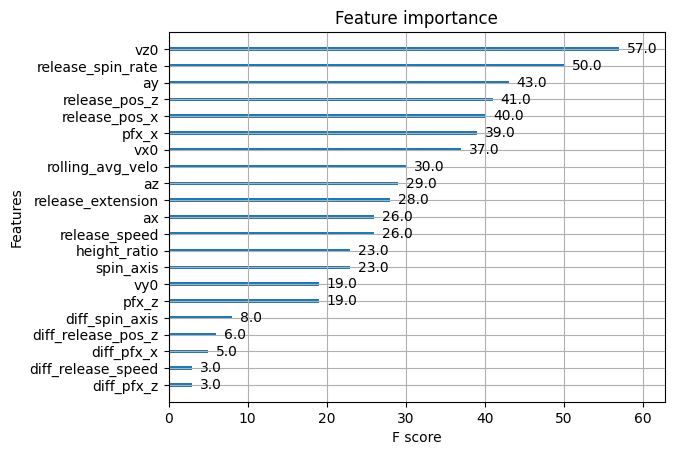

In [12]:
xgb.plot_importance(model)
plt.show()

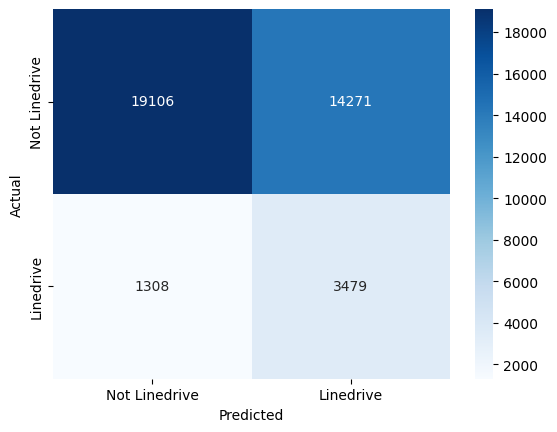

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:24:38,302] A new study created in memory with name: no-name-bc72f896-964b-4b08-82e3-5ea8a9a99d20


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68612
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67930
[19]	eval-logloss:0.67877
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67760
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67728
[24]	eval-logloss:0.67704
[25]	eval-logloss:0.67645
[26]	eval-logloss:0.67646
[27]	eval-logloss:0.67578
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67399
[31]	eval-logloss:0.67373
[32]	eval-logloss:0.67335
[33]	eval-logloss:0.67249
[34]	eval-logloss:0.67195
[35]	eval-logloss:0.67151
[36]	eval-logloss:0.67128
[37]	eval-logloss:0.67069
[38]	eval-logloss:0.67

[I 2023-11-15 11:24:39,834] Trial 0 finished with value: 0.648133534415749 and parameters: {'max_depth': 3, 'eta': 0.12781348552897145, 'subsample': 0.781228603692729, 'colsample_bytree': 0.608429810344088}. Best is trial 0 with value: 0.648133534415749.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64450
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.62393
[4]	eval-logloss:0.61218
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.57916
[7]	eval-logloss:0.56624
[8]	eval-logloss:0.55366
[9]	eval-logloss:0.54432
[10]	eval-logloss:0.53152
[11]	eval-logloss:0.52659
[12]	eval-logloss:0.51984
[13]	eval-logloss:0.51012
[14]	eval-logloss:0.49720
[15]	eval-logloss:0.49192
[16]	eval-logloss:0.48572
[17]	eval-logloss:0.47967
[18]	eval-logloss:0.47388
[19]	eval-logloss:0.46802
[20]	eval-logloss:0.45894
[21]	eval-logloss:0.45265
[22]	eval-logloss:0.44908
[23]	eval-logloss:0.44423
[24]	eval-logloss:0.43658
[25]	eval-logloss:0.43211
[26]	eval-logloss:0.42913
[27]	eval-logloss:0.42472
[28]	eval-logloss:0.41714
[29]	eval-logloss:0.41148
[30]	eval-logloss:0.40347
[31]	eval-logloss:0.39686
[32]	eval-logloss:0.38929
[33]	eval-logloss:0.38286
[34]	eval-logloss:0.37748
[35]	eval-logloss:0.37359
[36]	eval-logloss:0.36645
[37]	eval-logloss:0.36399
[38]	eval-logloss:0.36

[I 2023-11-15 11:24:42,187] Trial 1 finished with value: 0.18713088769072142 and parameters: {'max_depth': 8, 'eta': 0.28247665887512435, 'subsample': 0.8257260420716813, 'colsample_bytree': 0.9718113913039803}. Best is trial 1 with value: 0.18713088769072142.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67650
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67308
[11]	eval-logloss:0.67210
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66852
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66311
[19]	eval-logloss:0.66167
[20]	eval-logloss:0.66014
[21]	eval-logloss:0.65907
[22]	eval-logloss:0.65809
[23]	eval-logloss:0.65759
[24]	eval-logloss:0.65655
[25]	eval-logloss:0.65639
[26]	eval-logloss:0.65520
[27]	eval-logloss:0.65412
[28]	eval-logloss:0.65308
[29]	eval-logloss:0.65262
[30]	eval-logloss:0.65064
[31]	eval-logloss:0.64957
[32]	eval-logloss:0.64908
[33]	eval-logloss:0.64723
[34]	eval-logloss:0.64626
[35]	eval-logloss:0.64525
[36]	eval-logloss:0.64462
[37]	eval-logloss:0.64367
[38]	eval-logloss:0.64

[I 2023-11-15 11:24:43,795] Trial 2 finished with value: 0.5872098823742515 and parameters: {'max_depth': 4, 'eta': 0.18205637401244584, 'subsample': 0.8825873760392063, 'colsample_bytree': 0.6240532693585606}. Best is trial 1 with value: 0.18713088769072142.


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.64713
[2]	eval-logloss:0.63578
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.60106
[5]	eval-logloss:0.58297
[6]	eval-logloss:0.57287
[7]	eval-logloss:0.56322
[8]	eval-logloss:0.55414
[9]	eval-logloss:0.54969
[10]	eval-logloss:0.54119
[11]	eval-logloss:0.53335
[12]	eval-logloss:0.52429
[13]	eval-logloss:0.51706
[14]	eval-logloss:0.50732
[15]	eval-logloss:0.49765
[16]	eval-logloss:0.48660
[17]	eval-logloss:0.47991
[18]	eval-logloss:0.47466
[19]	eval-logloss:0.46630
[20]	eval-logloss:0.46028
[21]	eval-logloss:0.45344
[22]	eval-logloss:0.44470
[23]	eval-logloss:0.43512
[24]	eval-logloss:0.43077
[25]	eval-logloss:0.42772
[26]	eval-logloss:0.42132
[27]	eval-logloss:0.41382
[28]	eval-logloss:0.40507
[29]	eval-logloss:0.40196
[30]	eval-logloss:0.39961
[31]	eval-logloss:0.39185
[32]	eval-logloss:0.38482
[33]	eval-logloss:0.37782
[34]	eval-logloss:0.37406
[35]	eval-logloss:0.36939
[36]	eval-logloss:0.36369
[37]	eval-logloss:0.36140
[38]	eval-logloss:0.35

[I 2023-11-15 11:24:46,651] Trial 3 finished with value: 0.18117852705032983 and parameters: {'max_depth': 9, 'eta': 0.20440555714152342, 'subsample': 0.8422663864392225, 'colsample_bytree': 0.9820134357498762}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67454
[5]	eval-logloss:0.67050
[6]	eval-logloss:0.66796
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66169
[9]	eval-logloss:0.65890
[10]	eval-logloss:0.65606
[11]	eval-logloss:0.65390
[12]	eval-logloss:0.65199
[13]	eval-logloss:0.65080
[14]	eval-logloss:0.64875
[15]	eval-logloss:0.64607
[16]	eval-logloss:0.64378
[17]	eval-logloss:0.64202
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.63857
[20]	eval-logloss:0.63509
[21]	eval-logloss:0.63372
[22]	eval-logloss:0.63252
[23]	eval-logloss:0.63160
[24]	eval-logloss:0.63118
[25]	eval-logloss:0.62938
[26]	eval-logloss:0.62794
[27]	eval-logloss:0.62550
[28]	eval-logloss:0.62432
[29]	eval-logloss:0.62328
[30]	eval-logloss:0.62087
[31]	eval-logloss:0.62001
[32]	eval-logloss:0.61761
[33]	eval-logloss:0.61555
[34]	eval-logloss:0.61319
[35]	eval-logloss:0.61116
[36]	eval-logloss:0.61007
[37]	eval-logloss:0.60872
[38]	eval-logloss:0.60

[I 2023-11-15 11:24:48,296] Trial 4 finished with value: 0.521467427119195 and parameters: {'max_depth': 5, 'eta': 0.2053660071222642, 'subsample': 0.8210803997449442, 'colsample_bytree': 0.5193808367284058}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68557
[6]	eval-logloss:0.68447
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68243
[9]	eval-logloss:0.68155
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67836
[13]	eval-logloss:0.67765
[14]	eval-logloss:0.67718
[15]	eval-logloss:0.67615
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67343
[19]	eval-logloss:0.67286
[20]	eval-logloss:0.67176
[21]	eval-logloss:0.67094
[22]	eval-logloss:0.67031
[23]	eval-logloss:0.66996
[24]	eval-logloss:0.66930
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66781
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66637
[29]	eval-logloss:0.66576
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66447
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66309
[34]	eval-logloss:0.66219
[35]	eval-logloss:0.66156
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66040
[38]	eval-logloss:0.65

[I 2023-11-15 11:24:50,079] Trial 5 finished with value: 0.6245145092527 and parameters: {'max_depth': 5, 'eta': 0.05163771970813726, 'subsample': 0.6646323127426401, 'colsample_bytree': 0.608355464794305}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65185
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.64073
[7]	eval-logloss:0.63545
[8]	eval-logloss:0.63097
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.62170
[11]	eval-logloss:0.61593
[12]	eval-logloss:0.61309
[13]	eval-logloss:0.60791
[14]	eval-logloss:0.60247
[15]	eval-logloss:0.59781
[16]	eval-logloss:0.59459
[17]	eval-logloss:0.59107
[18]	eval-logloss:0.58649
[19]	eval-logloss:0.58229
[20]	eval-logloss:0.57646
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.56855
[23]	eval-logloss:0.56545
[24]	eval-logloss:0.56207
[25]	eval-logloss:0.55872
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55184
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54384
[30]	eval-logloss:0.54154
[31]	eval-logloss:0.53818
[32]	eval-logloss:0.53487
[33]	eval-logloss:0.53106
[34]	eval-logloss:0.52805
[35]	eval-logloss:0.52478
[36]	eval-logloss:0.52119
[37]	eval-logloss:0.51706
[38]	eval-logloss:0.51

[I 2023-11-15 11:24:52,608] Trial 6 finished with value: 0.3724808123704623 and parameters: {'max_depth': 9, 'eta': 0.07243078792376177, 'subsample': 0.8754592537751936, 'colsample_bytree': 0.5715760176171991}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64779
[4]	eval-logloss:0.64008
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.60853
[8]	eval-logloss:0.60534
[9]	eval-logloss:0.59712
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58145
[12]	eval-logloss:0.57471
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56427
[15]	eval-logloss:0.55592
[16]	eval-logloss:0.54754
[17]	eval-logloss:0.53950
[18]	eval-logloss:0.53698
[19]	eval-logloss:0.53195
[20]	eval-logloss:0.52541
[21]	eval-logloss:0.52045
[22]	eval-logloss:0.51423
[23]	eval-logloss:0.51186
[24]	eval-logloss:0.50669
[25]	eval-logloss:0.50004
[26]	eval-logloss:0.49643
[27]	eval-logloss:0.49378
[28]	eval-logloss:0.48928
[29]	eval-logloss:0.48672
[30]	eval-logloss:0.48268
[31]	eval-logloss:0.48060
[32]	eval-logloss:0.47780
[33]	eval-logloss:0.47345
[34]	eval-logloss:0.46848
[35]	eval-logloss:0.46300
[36]	eval-logloss:0.45987
[37]	eval-logloss:0.45644
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:54,724] Trial 7 finished with value: 0.2748926584670953 and parameters: {'max_depth': 7, 'eta': 0.2826094882908474, 'subsample': 0.6849395719440884, 'colsample_bytree': 0.8164425952035983}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66616
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65689
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64434
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63575
[11]	eval-logloss:0.63202
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.62773
[14]	eval-logloss:0.62319
[15]	eval-logloss:0.61884
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61304
[18]	eval-logloss:0.61119
[19]	eval-logloss:0.60831
[20]	eval-logloss:0.60399
[21]	eval-logloss:0.60116
[22]	eval-logloss:0.59811
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59242
[25]	eval-logloss:0.58868
[26]	eval-logloss:0.58705
[27]	eval-logloss:0.58312
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57623
[30]	eval-logloss:0.57293
[31]	eval-logloss:0.57112
[32]	eval-logloss:0.56737
[33]	eval-logloss:0.56521
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.55905
[36]	eval-logloss:0.55717
[37]	eval-logloss:0.55489
[38]	eval-logloss:0.55

[I 2023-11-15 11:24:56,732] Trial 8 finished with value: 0.428996882813316 and parameters: {'max_depth': 7, 'eta': 0.1211498978450407, 'subsample': 0.8044342380951496, 'colsample_bytree': 0.7312746967909414}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68462
[3]	eval-logloss:0.68215
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67507
[7]	eval-logloss:0.67356
[8]	eval-logloss:0.67214
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.66864
[11]	eval-logloss:0.66730
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66469
[14]	eval-logloss:0.66377
[15]	eval-logloss:0.66258
[16]	eval-logloss:0.65961
[17]	eval-logloss:0.65841
[18]	eval-logloss:0.65792
[19]	eval-logloss:0.65689
[20]	eval-logloss:0.65529
[21]	eval-logloss:0.65339
[22]	eval-logloss:0.65185
[23]	eval-logloss:0.65087
[24]	eval-logloss:0.65025
[25]	eval-logloss:0.64995
[26]	eval-logloss:0.64897
[27]	eval-logloss:0.64696
[28]	eval-logloss:0.64557
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64158
[31]	eval-logloss:0.64053
[32]	eval-logloss:0.63856
[33]	eval-logloss:0.63619
[34]	eval-logloss:0.63467
[35]	eval-logloss:0.63373
[36]	eval-logloss:0.63353
[37]	eval-logloss:0.63202
[38]	eval-logloss:0.63

[I 2023-11-15 11:24:58,273] Trial 9 finished with value: 0.5656945356197118 and parameters: {'max_depth': 4, 'eta': 0.225208138316061, 'subsample': 0.735215736791663, 'colsample_bytree': 0.8172351159523609}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68528
[5]	eval-logloss:0.68352
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67718
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67187
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66898
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66615
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66293
[20]	eval-logloss:0.66126
[21]	eval-logloss:0.65993
[22]	eval-logloss:0.65857
[23]	eval-logloss:0.65746
[24]	eval-logloss:0.65622
[25]	eval-logloss:0.65499
[26]	eval-logloss:0.65359
[27]	eval-logloss:0.65272
[28]	eval-logloss:0.65156
[29]	eval-logloss:0.65062
[30]	eval-logloss:0.64915
[31]	eval-logloss:0.64812
[32]	eval-logloss:0.64733
[33]	eval-logloss:0.64607
[34]	eval-logloss:0.64468
[35]	eval-logloss:0.64340
[36]	eval-logloss:0.64217
[37]	eval-logloss:0.64119
[38]	eval-logloss:0.64

[I 2023-11-15 11:25:01,510] Trial 10 finished with value: 0.5802184426867127 and parameters: {'max_depth': 9, 'eta': 0.013095426460763226, 'subsample': 0.6279304348804237, 'colsample_bytree': 0.9965760214556186}. Best is trial 3 with value: 0.18117852705032983.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61239
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.59498
[7]	eval-logloss:0.58362
[8]	eval-logloss:0.57062
[9]	eval-logloss:0.55840
[10]	eval-logloss:0.54474
[11]	eval-logloss:0.53961
[12]	eval-logloss:0.53238
[13]	eval-logloss:0.52609
[14]	eval-logloss:0.51440
[15]	eval-logloss:0.50467
[16]	eval-logloss:0.49768
[17]	eval-logloss:0.49158
[18]	eval-logloss:0.48395
[19]	eval-logloss:0.47537
[20]	eval-logloss:0.46874
[21]	eval-logloss:0.45984
[22]	eval-logloss:0.45139
[23]	eval-logloss:0.44691
[24]	eval-logloss:0.43871
[25]	eval-logloss:0.43213
[26]	eval-logloss:0.42732
[27]	eval-logloss:0.41734
[28]	eval-logloss:0.40993
[29]	eval-logloss:0.40543
[30]	eval-logloss:0.39964
[31]	eval-logloss:0.39709
[32]	eval-logloss:0.39238
[33]	eval-logloss:0.38470
[34]	eval-logloss:0.37903
[35]	eval-logloss:0.37353
[36]	eval-logloss:0.36718
[37]	eval-logloss:0.36477
[38]	eval-logloss:0.36

[I 2023-11-15 11:25:03,924] Trial 11 finished with value: 0.17657786722120944 and parameters: {'max_depth': 8, 'eta': 0.29573629602706075, 'subsample': 0.8412392378685294, 'colsample_bytree': 0.9703371271035535}. Best is trial 11 with value: 0.17657786722120944.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64021
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62288
[5]	eval-logloss:0.61210
[6]	eval-logloss:0.60518
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.59033
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.57278
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.55828
[13]	eval-logloss:0.55154
[14]	eval-logloss:0.54279
[15]	eval-logloss:0.53491
[16]	eval-logloss:0.52450
[17]	eval-logloss:0.52028
[18]	eval-logloss:0.51078
[19]	eval-logloss:0.50084
[20]	eval-logloss:0.49769
[21]	eval-logloss:0.49201
[22]	eval-logloss:0.48451
[23]	eval-logloss:0.47599
[24]	eval-logloss:0.47159
[25]	eval-logloss:0.46914
[26]	eval-logloss:0.46429
[27]	eval-logloss:0.45798
[28]	eval-logloss:0.45510
[29]	eval-logloss:0.45043
[30]	eval-logloss:0.44600
[31]	eval-logloss:0.44085
[32]	eval-logloss:0.43587
[33]	eval-logloss:0.43200
[34]	eval-logloss:0.42654
[35]	eval-logloss:0.42356
[36]	eval-logloss:0.41538
[37]	eval-logloss:0.41086
[38]	eval-logloss:0.40

[I 2023-11-15 11:25:06,335] Trial 12 finished with value: 0.22141434929498013 and parameters: {'max_depth': 8, 'eta': 0.2465773176427571, 'subsample': 0.8544292997252391, 'colsample_bytree': 0.9119005271017653}. Best is trial 11 with value: 0.17657786722120944.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.63127
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.60413
[6]	eval-logloss:0.58880
[7]	eval-logloss:0.57842
[8]	eval-logloss:0.56811
[9]	eval-logloss:0.56497
[10]	eval-logloss:0.55560
[11]	eval-logloss:0.54893
[12]	eval-logloss:0.54330
[13]	eval-logloss:0.53618
[14]	eval-logloss:0.52662
[15]	eval-logloss:0.51746
[16]	eval-logloss:0.50907
[17]	eval-logloss:0.50043
[18]	eval-logloss:0.49199
[19]	eval-logloss:0.48177
[20]	eval-logloss:0.47718
[21]	eval-logloss:0.47263
[22]	eval-logloss:0.46395
[23]	eval-logloss:0.45791
[24]	eval-logloss:0.45455
[25]	eval-logloss:0.44506
[26]	eval-logloss:0.44231
[27]	eval-logloss:0.43711
[28]	eval-logloss:0.43306
[29]	eval-logloss:0.42968
[30]	eval-logloss:0.42336
[31]	eval-logloss:0.42070
[32]	eval-logloss:0.41801
[33]	eval-logloss:0.41096
[34]	eval-logloss:0.40510
[35]	eval-logloss:0.39831
[36]	eval-logloss:0.39735
[37]	eval-logloss:0.39357
[38]	eval-logloss:0.39

[I 2023-11-15 11:25:08,810] Trial 13 finished with value: 0.22174478535213618 and parameters: {'max_depth': 8, 'eta': 0.24781847180496866, 'subsample': 0.7662103480716781, 'colsample_bytree': 0.9233509105508954}. Best is trial 11 with value: 0.17657786722120944.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63511
[2]	eval-logloss:0.60859
[3]	eval-logloss:0.59382
[4]	eval-logloss:0.57231
[5]	eval-logloss:0.55489
[6]	eval-logloss:0.54593
[7]	eval-logloss:0.53192
[8]	eval-logloss:0.51852
[9]	eval-logloss:0.50428
[10]	eval-logloss:0.48950
[11]	eval-logloss:0.47486
[12]	eval-logloss:0.46797
[13]	eval-logloss:0.45901
[14]	eval-logloss:0.45374
[15]	eval-logloss:0.44613
[16]	eval-logloss:0.43673
[17]	eval-logloss:0.42912
[18]	eval-logloss:0.42022
[19]	eval-logloss:0.41394
[20]	eval-logloss:0.40809
[21]	eval-logloss:0.40080
[22]	eval-logloss:0.38911
[23]	eval-logloss:0.38286
[24]	eval-logloss:0.37377
[25]	eval-logloss:0.36777
[26]	eval-logloss:0.36233
[27]	eval-logloss:0.35218
[28]	eval-logloss:0.34861
[29]	eval-logloss:0.33922
[30]	eval-logloss:0.33443
[31]	eval-logloss:0.32707
[32]	eval-logloss:0.32160
[33]	eval-logloss:0.31439
[34]	eval-logloss:0.30941
[35]	eval-logloss:0.30400
[36]	eval-logloss:0.29969
[37]	eval-logloss:0.29434
[38]	eval-logloss:0.28

[I 2023-11-15 11:25:12,045] Trial 14 finished with value: 0.11917517687408823 and parameters: {'max_depth': 9, 'eta': 0.29454836518820543, 'subsample': 0.8913857354249769, 'colsample_bytree': 0.9933040195389344}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66442
[2]	eval-logloss:0.64950
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63150
[5]	eval-logloss:0.62250
[6]	eval-logloss:0.61681
[7]	eval-logloss:0.61113
[8]	eval-logloss:0.60374
[9]	eval-logloss:0.59466
[10]	eval-logloss:0.58697
[11]	eval-logloss:0.58115
[12]	eval-logloss:0.57296
[13]	eval-logloss:0.56370
[14]	eval-logloss:0.55923
[15]	eval-logloss:0.55191
[16]	eval-logloss:0.54473
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53472
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52558
[21]	eval-logloss:0.51542
[22]	eval-logloss:0.50912
[23]	eval-logloss:0.50361
[24]	eval-logloss:0.49633
[25]	eval-logloss:0.49307
[26]	eval-logloss:0.48801
[27]	eval-logloss:0.48142
[28]	eval-logloss:0.47603
[29]	eval-logloss:0.47221
[30]	eval-logloss:0.46675
[31]	eval-logloss:0.46332
[32]	eval-logloss:0.46011
[33]	eval-logloss:0.45675
[34]	eval-logloss:0.45309
[35]	eval-logloss:0.44982
[36]	eval-logloss:0.44684
[37]	eval-logloss:0.44352
[38]	eval-logloss:0.44

[I 2023-11-15 11:25:14,584] Trial 15 finished with value: 0.2622543347268218 and parameters: {'max_depth': 7, 'eta': 0.29744008984031667, 'subsample': 0.8904245132111445, 'colsample_bytree': 0.9095790421230556}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65382
[5]	eval-logloss:0.64790
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.63973
[8]	eval-logloss:0.63347
[9]	eval-logloss:0.63015
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.61692
[12]	eval-logloss:0.61037
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.59991
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59166
[17]	eval-logloss:0.58562
[18]	eval-logloss:0.58104
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57232
[21]	eval-logloss:0.56793
[22]	eval-logloss:0.56540
[23]	eval-logloss:0.56340
[24]	eval-logloss:0.55977
[25]	eval-logloss:0.55686
[26]	eval-logloss:0.55243
[27]	eval-logloss:0.54705
[28]	eval-logloss:0.54463
[29]	eval-logloss:0.54122
[30]	eval-logloss:0.53790
[31]	eval-logloss:0.53303
[32]	eval-logloss:0.53015
[33]	eval-logloss:0.52686
[34]	eval-logloss:0.52184
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51442
[37]	eval-logloss:0.51194
[38]	eval-logloss:0.51

[I 2023-11-15 11:25:16,639] Trial 16 finished with value: 0.35926722415646056 and parameters: {'max_depth': 6, 'eta': 0.29744899814508813, 'subsample': 0.8984909413876334, 'colsample_bytree': 0.859846402426374}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63678
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.60141
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.57637
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.55113
[11]	eval-logloss:0.54541
[12]	eval-logloss:0.53954
[13]	eval-logloss:0.52903
[14]	eval-logloss:0.52082
[15]	eval-logloss:0.51044
[16]	eval-logloss:0.50365
[17]	eval-logloss:0.49827
[18]	eval-logloss:0.49215
[19]	eval-logloss:0.48529
[20]	eval-logloss:0.47958
[21]	eval-logloss:0.47162
[22]	eval-logloss:0.46592
[23]	eval-logloss:0.46280
[24]	eval-logloss:0.45296
[25]	eval-logloss:0.45054
[26]	eval-logloss:0.44658
[27]	eval-logloss:0.43956
[28]	eval-logloss:0.43562
[29]	eval-logloss:0.42899
[30]	eval-logloss:0.42464
[31]	eval-logloss:0.41907
[32]	eval-logloss:0.41750
[33]	eval-logloss:0.41115
[34]	eval-logloss:0.40844
[35]	eval-logloss:0.40482
[36]	eval-logloss:0.39697
[37]	eval-logloss:0.39353
[38]	eval-logloss:0.39

[I 2023-11-15 11:25:19,338] Trial 17 finished with value: 0.20074700094049888 and parameters: {'max_depth': 8, 'eta': 0.2582444361286719, 'subsample': 0.8488499905667212, 'colsample_bytree': 0.9485044137792884}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65950
[1]	eval-logloss:0.63570
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.59913
[4]	eval-logloss:0.58668
[5]	eval-logloss:0.56831
[6]	eval-logloss:0.55581
[7]	eval-logloss:0.53674
[8]	eval-logloss:0.52763
[9]	eval-logloss:0.51244
[10]	eval-logloss:0.50015
[11]	eval-logloss:0.49306
[12]	eval-logloss:0.48418
[13]	eval-logloss:0.47470
[14]	eval-logloss:0.46353
[15]	eval-logloss:0.45252
[16]	eval-logloss:0.44092
[17]	eval-logloss:0.43155
[18]	eval-logloss:0.42245
[19]	eval-logloss:0.41537
[20]	eval-logloss:0.40958
[21]	eval-logloss:0.40433
[22]	eval-logloss:0.40018
[23]	eval-logloss:0.38951
[24]	eval-logloss:0.38305
[25]	eval-logloss:0.37851
[26]	eval-logloss:0.37421
[27]	eval-logloss:0.36711
[28]	eval-logloss:0.36089
[29]	eval-logloss:0.35466
[30]	eval-logloss:0.34617
[31]	eval-logloss:0.33929
[32]	eval-logloss:0.33233
[33]	eval-logloss:0.32827
[34]	eval-logloss:0.32019
[35]	eval-logloss:0.31572
[36]	eval-logloss:0.31110
[37]	eval-logloss:0.30506
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:22,435] Trial 18 finished with value: 0.13143780395661558 and parameters: {'max_depth': 9, 'eta': 0.25635552466260275, 'subsample': 0.8063540192841916, 'colsample_bytree': 0.9958125377965097}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66321
[1]	eval-logloss:0.63809
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60301
[4]	eval-logloss:0.58659
[5]	eval-logloss:0.57188
[6]	eval-logloss:0.56273
[7]	eval-logloss:0.55120
[8]	eval-logloss:0.53854
[9]	eval-logloss:0.52466
[10]	eval-logloss:0.50210
[11]	eval-logloss:0.49330
[12]	eval-logloss:0.48569
[13]	eval-logloss:0.47654
[14]	eval-logloss:0.46479
[15]	eval-logloss:0.45763
[16]	eval-logloss:0.44752
[17]	eval-logloss:0.44340
[18]	eval-logloss:0.43390
[19]	eval-logloss:0.42355
[20]	eval-logloss:0.41659
[21]	eval-logloss:0.40955
[22]	eval-logloss:0.40005
[23]	eval-logloss:0.39114
[24]	eval-logloss:0.38626
[25]	eval-logloss:0.37810
[26]	eval-logloss:0.37178
[27]	eval-logloss:0.36358
[28]	eval-logloss:0.35909
[29]	eval-logloss:0.34958
[30]	eval-logloss:0.33824
[31]	eval-logloss:0.33489
[32]	eval-logloss:0.33036
[33]	eval-logloss:0.32514
[34]	eval-logloss:0.32120
[35]	eval-logloss:0.31876
[36]	eval-logloss:0.31338
[37]	eval-logloss:0.30826
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:25,693] Trial 19 finished with value: 0.12809716342301128 and parameters: {'max_depth': 9, 'eta': 0.2622563046904375, 'subsample': 0.7857560273439558, 'colsample_bytree': 0.996726217119538}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.66943
[4]	eval-logloss:0.66581
[5]	eval-logloss:0.66146
[6]	eval-logloss:0.65689
[7]	eval-logloss:0.65270
[8]	eval-logloss:0.65044
[9]	eval-logloss:0.64641
[10]	eval-logloss:0.64228
[11]	eval-logloss:0.63860
[12]	eval-logloss:0.63579
[13]	eval-logloss:0.63174
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62406
[16]	eval-logloss:0.61881
[17]	eval-logloss:0.61487
[18]	eval-logloss:0.61231
[19]	eval-logloss:0.61040
[20]	eval-logloss:0.60633
[21]	eval-logloss:0.60221
[22]	eval-logloss:0.60042
[23]	eval-logloss:0.59919
[24]	eval-logloss:0.59770
[25]	eval-logloss:0.59580
[26]	eval-logloss:0.59328
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58688
[29]	eval-logloss:0.58427
[30]	eval-logloss:0.58154
[31]	eval-logloss:0.57897
[32]	eval-logloss:0.57765
[33]	eval-logloss:0.57436
[34]	eval-logloss:0.57216
[35]	eval-logloss:0.57090
[36]	eval-logloss:0.56864
[37]	eval-logloss:0.56664
[38]	eval-logloss:0.56

[I 2023-11-15 11:25:27,869] Trial 20 finished with value: 0.45332658033515716 and parameters: {'max_depth': 6, 'eta': 0.1704537552317088, 'subsample': 0.7372095928554575, 'colsample_bytree': 0.8785378895252118}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66245
[1]	eval-logloss:0.64017
[2]	eval-logloss:0.62154
[3]	eval-logloss:0.60104
[4]	eval-logloss:0.58973
[5]	eval-logloss:0.57122
[6]	eval-logloss:0.55901
[7]	eval-logloss:0.54917
[8]	eval-logloss:0.53916
[9]	eval-logloss:0.52634
[10]	eval-logloss:0.50873
[11]	eval-logloss:0.50554
[12]	eval-logloss:0.49959
[13]	eval-logloss:0.48445
[14]	eval-logloss:0.47217
[15]	eval-logloss:0.46120
[16]	eval-logloss:0.45116
[17]	eval-logloss:0.44638
[18]	eval-logloss:0.43707
[19]	eval-logloss:0.43050
[20]	eval-logloss:0.42176
[21]	eval-logloss:0.41674
[22]	eval-logloss:0.41188
[23]	eval-logloss:0.40852
[24]	eval-logloss:0.40260
[25]	eval-logloss:0.39412
[26]	eval-logloss:0.38391
[27]	eval-logloss:0.37701
[28]	eval-logloss:0.37257
[29]	eval-logloss:0.36498
[30]	eval-logloss:0.35911
[31]	eval-logloss:0.35191
[32]	eval-logloss:0.34309
[33]	eval-logloss:0.33487
[34]	eval-logloss:0.32858
[35]	eval-logloss:0.32331
[36]	eval-logloss:0.31676
[37]	eval-logloss:0.31305
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:30,893] Trial 21 finished with value: 0.13511775672032328 and parameters: {'max_depth': 9, 'eta': 0.2570697192318623, 'subsample': 0.7968768336231862, 'colsample_bytree': 0.9979790143751198}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60176
[5]	eval-logloss:0.58193
[6]	eval-logloss:0.56037
[7]	eval-logloss:0.54983
[8]	eval-logloss:0.53804
[9]	eval-logloss:0.52784
[10]	eval-logloss:0.51298
[11]	eval-logloss:0.50670
[12]	eval-logloss:0.50064
[13]	eval-logloss:0.48974
[14]	eval-logloss:0.48164
[15]	eval-logloss:0.47618
[16]	eval-logloss:0.46489
[17]	eval-logloss:0.45533
[18]	eval-logloss:0.44475
[19]	eval-logloss:0.43598
[20]	eval-logloss:0.42585
[21]	eval-logloss:0.41901
[22]	eval-logloss:0.41108
[23]	eval-logloss:0.40458
[24]	eval-logloss:0.40145
[25]	eval-logloss:0.39618
[26]	eval-logloss:0.39166
[27]	eval-logloss:0.38479
[28]	eval-logloss:0.37962
[29]	eval-logloss:0.37481
[30]	eval-logloss:0.36956
[31]	eval-logloss:0.36667
[32]	eval-logloss:0.36124
[33]	eval-logloss:0.35503
[34]	eval-logloss:0.34889
[35]	eval-logloss:0.34489
[36]	eval-logloss:0.34142
[37]	eval-logloss:0.33781
[38]	eval-logloss:0.33

[I 2023-11-15 11:25:33,865] Trial 22 finished with value: 0.16157666418135422 and parameters: {'max_depth': 9, 'eta': 0.22756874979442168, 'subsample': 0.7582622407907766, 'colsample_bytree': 0.9524083468041037}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.63912
[2]	eval-logloss:0.61713
[3]	eval-logloss:0.60035
[4]	eval-logloss:0.58748
[5]	eval-logloss:0.57259
[6]	eval-logloss:0.56206
[7]	eval-logloss:0.54913
[8]	eval-logloss:0.53539
[9]	eval-logloss:0.52652
[10]	eval-logloss:0.51181
[11]	eval-logloss:0.50641
[12]	eval-logloss:0.49749
[13]	eval-logloss:0.48701
[14]	eval-logloss:0.47546
[15]	eval-logloss:0.46523
[16]	eval-logloss:0.45216
[17]	eval-logloss:0.44784
[18]	eval-logloss:0.44244
[19]	eval-logloss:0.43171
[20]	eval-logloss:0.42321
[21]	eval-logloss:0.41378
[22]	eval-logloss:0.40382
[23]	eval-logloss:0.40009
[24]	eval-logloss:0.38957
[25]	eval-logloss:0.38248
[26]	eval-logloss:0.37402
[27]	eval-logloss:0.36836
[28]	eval-logloss:0.36251
[29]	eval-logloss:0.35494
[30]	eval-logloss:0.34573
[31]	eval-logloss:0.34151
[32]	eval-logloss:0.33821
[33]	eval-logloss:0.33128
[34]	eval-logloss:0.32477
[35]	eval-logloss:0.32282
[36]	eval-logloss:0.31859
[37]	eval-logloss:0.31605
[38]	eval-logloss:0.31

[I 2023-11-15 11:25:37,121] Trial 23 finished with value: 0.1374585193547094 and parameters: {'max_depth': 9, 'eta': 0.2731539006025948, 'subsample': 0.8014515171822701, 'colsample_bytree': 0.9245686358279761}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.63462
[5]	eval-logloss:0.62520
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61487
[8]	eval-logloss:0.60667
[9]	eval-logloss:0.59752
[10]	eval-logloss:0.59143
[11]	eval-logloss:0.58236
[12]	eval-logloss:0.57558
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.55333
[16]	eval-logloss:0.54958
[17]	eval-logloss:0.54626
[18]	eval-logloss:0.53996
[19]	eval-logloss:0.53358
[20]	eval-logloss:0.52943
[21]	eval-logloss:0.52247
[22]	eval-logloss:0.51798
[23]	eval-logloss:0.51418
[24]	eval-logloss:0.50963
[25]	eval-logloss:0.50592
[26]	eval-logloss:0.50243
[27]	eval-logloss:0.49586
[28]	eval-logloss:0.49158
[29]	eval-logloss:0.48965
[30]	eval-logloss:0.48528
[31]	eval-logloss:0.47914
[32]	eval-logloss:0.47422
[33]	eval-logloss:0.46960
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.45971
[36]	eval-logloss:0.45552
[37]	eval-logloss:0.45045
[38]	eval-logloss:0.44

[I 2023-11-15 11:25:39,598] Trial 24 finished with value: 0.280606322603658 and parameters: {'max_depth': 7, 'eta': 0.26888901994473496, 'subsample': 0.8651299241925513, 'colsample_bytree': 0.9898337276145721}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62237
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.57948
[9]	eval-logloss:0.57025
[10]	eval-logloss:0.56462
[11]	eval-logloss:0.55838
[12]	eval-logloss:0.55433
[13]	eval-logloss:0.54626
[14]	eval-logloss:0.53690
[15]	eval-logloss:0.53161
[16]	eval-logloss:0.52306
[17]	eval-logloss:0.51727
[18]	eval-logloss:0.50867
[19]	eval-logloss:0.50113
[20]	eval-logloss:0.49568
[21]	eval-logloss:0.48761
[22]	eval-logloss:0.48096
[23]	eval-logloss:0.47464
[24]	eval-logloss:0.46700
[25]	eval-logloss:0.46311
[26]	eval-logloss:0.45676
[27]	eval-logloss:0.44872
[28]	eval-logloss:0.44521
[29]	eval-logloss:0.44185
[30]	eval-logloss:0.43767
[31]	eval-logloss:0.43409
[32]	eval-logloss:0.42963
[33]	eval-logloss:0.42351
[34]	eval-logloss:0.41917
[35]	eval-logloss:0.41765
[36]	eval-logloss:0.41353
[37]	eval-logloss:0.40998
[38]	eval-logloss:0.40

[I 2023-11-15 11:25:42,447] Trial 25 finished with value: 0.23481593627475358 and parameters: {'max_depth': 8, 'eta': 0.22422409181374492, 'subsample': 0.8179053960758457, 'colsample_bytree': 0.9374989777815753}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66231
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.61973
[3]	eval-logloss:0.60288
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57718
[6]	eval-logloss:0.55824
[7]	eval-logloss:0.55155
[8]	eval-logloss:0.54434
[9]	eval-logloss:0.53977
[10]	eval-logloss:0.52449
[11]	eval-logloss:0.51320
[12]	eval-logloss:0.50763
[13]	eval-logloss:0.49238
[14]	eval-logloss:0.48247
[15]	eval-logloss:0.47103
[16]	eval-logloss:0.46139
[17]	eval-logloss:0.45438
[18]	eval-logloss:0.44675
[19]	eval-logloss:0.44083
[20]	eval-logloss:0.43127
[21]	eval-logloss:0.42436
[22]	eval-logloss:0.41765
[23]	eval-logloss:0.41008
[24]	eval-logloss:0.40178
[25]	eval-logloss:0.39440
[26]	eval-logloss:0.38532
[27]	eval-logloss:0.37754
[28]	eval-logloss:0.37146
[29]	eval-logloss:0.36520
[30]	eval-logloss:0.35920
[31]	eval-logloss:0.35508
[32]	eval-logloss:0.34829
[33]	eval-logloss:0.34246
[34]	eval-logloss:0.33734
[35]	eval-logloss:0.33368
[36]	eval-logloss:0.33009
[37]	eval-logloss:0.32213
[38]	eval-logloss:0.31

[I 2023-11-15 11:25:45,729] Trial 26 finished with value: 0.13774393886595165 and parameters: {'max_depth': 9, 'eta': 0.2468736569657799, 'subsample': 0.8688181653899615, 'colsample_bytree': 0.8850198594150318}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63416
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61957
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.58985
[7]	eval-logloss:0.57801
[8]	eval-logloss:0.56445
[9]	eval-logloss:0.55805
[10]	eval-logloss:0.54473
[11]	eval-logloss:0.53836
[12]	eval-logloss:0.53302
[13]	eval-logloss:0.52399
[14]	eval-logloss:0.52050
[15]	eval-logloss:0.51089
[16]	eval-logloss:0.50174
[17]	eval-logloss:0.49271
[18]	eval-logloss:0.48805
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.47821
[21]	eval-logloss:0.46918
[22]	eval-logloss:0.45742
[23]	eval-logloss:0.45313
[24]	eval-logloss:0.45012
[25]	eval-logloss:0.44351
[26]	eval-logloss:0.43819
[27]	eval-logloss:0.43122
[28]	eval-logloss:0.42877
[29]	eval-logloss:0.42421
[30]	eval-logloss:0.41993
[31]	eval-logloss:0.41713
[32]	eval-logloss:0.40811
[33]	eval-logloss:0.40134
[34]	eval-logloss:0.39400
[35]	eval-logloss:0.39052
[36]	eval-logloss:0.38833
[37]	eval-logloss:0.38383
[38]	eval-logloss:0.37

[I 2023-11-15 11:25:48,473] Trial 27 finished with value: 0.19148524736204703 and parameters: {'max_depth': 8, 'eta': 0.270993070278941, 'subsample': 0.7843426891076001, 'colsample_bytree': 0.952718359145609}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.64021
[2]	eval-logloss:0.62540
[3]	eval-logloss:0.60999
[4]	eval-logloss:0.59474
[5]	eval-logloss:0.58258
[6]	eval-logloss:0.56881
[7]	eval-logloss:0.55694
[8]	eval-logloss:0.54757
[9]	eval-logloss:0.53381
[10]	eval-logloss:0.52072
[11]	eval-logloss:0.51275
[12]	eval-logloss:0.50592
[13]	eval-logloss:0.50108
[14]	eval-logloss:0.49375
[15]	eval-logloss:0.48271
[16]	eval-logloss:0.47207
[17]	eval-logloss:0.46406
[18]	eval-logloss:0.45938
[19]	eval-logloss:0.45253
[20]	eval-logloss:0.44893
[21]	eval-logloss:0.44034
[22]	eval-logloss:0.43188
[23]	eval-logloss:0.42530
[24]	eval-logloss:0.41940
[25]	eval-logloss:0.41379
[26]	eval-logloss:0.40981
[27]	eval-logloss:0.40148
[28]	eval-logloss:0.39490
[29]	eval-logloss:0.38848
[30]	eval-logloss:0.38436
[31]	eval-logloss:0.38022
[32]	eval-logloss:0.37611
[33]	eval-logloss:0.37016
[34]	eval-logloss:0.36129
[35]	eval-logloss:0.35920
[36]	eval-logloss:0.35441
[37]	eval-logloss:0.35132
[38]	eval-logloss:0.34

[I 2023-11-15 11:25:51,403] Trial 28 finished with value: 0.14895046671270532 and parameters: {'max_depth': 9, 'eta': 0.23644706624567016, 'subsample': 0.8977398666497043, 'colsample_bytree': 0.8490141647741901}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68570
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68191
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.67998
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67469
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67245
[15]	eval-logloss:0.67163
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66900
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66559
[21]	eval-logloss:0.66504
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66409
[24]	eval-logloss:0.66363
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66353
[27]	eval-logloss:0.66185
[28]	eval-logloss:0.66201
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.65911
[31]	eval-logloss:0.65883
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65597
[35]	eval-logloss:0.65525
[36]	eval-logloss:0.65567
[37]	eval-logloss:0.65503
[38]	eval-logloss:0.65

[I 2023-11-15 11:25:53,081] Trial 29 finished with value: 0.6148058748466368 and parameters: {'max_depth': 3, 'eta': 0.27639792538842717, 'subsample': 0.7722092126827087, 'colsample_bytree': 0.897905484041337}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66289
[3]	eval-logloss:0.65379
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.61648
[9]	eval-logloss:0.60969
[10]	eval-logloss:0.60402
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59621
[13]	eval-logloss:0.59008
[14]	eval-logloss:0.58701
[15]	eval-logloss:0.58228
[16]	eval-logloss:0.57670
[17]	eval-logloss:0.57254
[18]	eval-logloss:0.56884
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.55814
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54455
[23]	eval-logloss:0.53941
[24]	eval-logloss:0.53425
[25]	eval-logloss:0.52959
[26]	eval-logloss:0.52504
[27]	eval-logloss:0.52154
[28]	eval-logloss:0.51870
[29]	eval-logloss:0.51603
[30]	eval-logloss:0.51220
[31]	eval-logloss:0.50930
[32]	eval-logloss:0.50576
[33]	eval-logloss:0.49982
[34]	eval-logloss:0.49599
[35]	eval-logloss:0.49210
[36]	eval-logloss:0.48959
[37]	eval-logloss:0.48690
[38]	eval-logloss:0.48

[I 2023-11-15 11:25:55,294] Trial 30 finished with value: 0.32894251596826607 and parameters: {'max_depth': 7, 'eta': 0.20316726703801002, 'subsample': 0.7906100797628424, 'colsample_bytree': 0.9467882717975564}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66446
[1]	eval-logloss:0.64097
[2]	eval-logloss:0.62150
[3]	eval-logloss:0.60464
[4]	eval-logloss:0.59032
[5]	eval-logloss:0.57305
[6]	eval-logloss:0.56114
[7]	eval-logloss:0.54509
[8]	eval-logloss:0.53439
[9]	eval-logloss:0.51745
[10]	eval-logloss:0.50566
[11]	eval-logloss:0.49548
[12]	eval-logloss:0.48839
[13]	eval-logloss:0.47659
[14]	eval-logloss:0.46518
[15]	eval-logloss:0.45681
[16]	eval-logloss:0.44153
[17]	eval-logloss:0.43273
[18]	eval-logloss:0.42419
[19]	eval-logloss:0.41740
[20]	eval-logloss:0.41125
[21]	eval-logloss:0.40370
[22]	eval-logloss:0.39369
[23]	eval-logloss:0.38891
[24]	eval-logloss:0.38533
[25]	eval-logloss:0.37903
[26]	eval-logloss:0.37512
[27]	eval-logloss:0.36427
[28]	eval-logloss:0.36100
[29]	eval-logloss:0.35514
[30]	eval-logloss:0.35051
[31]	eval-logloss:0.34156
[32]	eval-logloss:0.33990
[33]	eval-logloss:0.33452
[34]	eval-logloss:0.32965
[35]	eval-logloss:0.32657
[36]	eval-logloss:0.32260
[37]	eval-logloss:0.31921
[38]	eval-logloss:0.31

[I 2023-11-15 11:25:58,036] Trial 31 finished with value: 0.1384432920516093 and parameters: {'max_depth': 9, 'eta': 0.2529003135747394, 'subsample': 0.7987079753574639, 'colsample_bytree': 0.9950629310335339}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66082
[1]	eval-logloss:0.63835
[2]	eval-logloss:0.61921
[3]	eval-logloss:0.59798
[4]	eval-logloss:0.58196
[5]	eval-logloss:0.56723
[6]	eval-logloss:0.55664
[7]	eval-logloss:0.54662
[8]	eval-logloss:0.53353
[9]	eval-logloss:0.51930
[10]	eval-logloss:0.50225
[11]	eval-logloss:0.48945
[12]	eval-logloss:0.48105
[13]	eval-logloss:0.47529
[14]	eval-logloss:0.46190
[15]	eval-logloss:0.45059
[16]	eval-logloss:0.44220
[17]	eval-logloss:0.43687
[18]	eval-logloss:0.42934
[19]	eval-logloss:0.41430
[20]	eval-logloss:0.40982
[21]	eval-logloss:0.40489
[22]	eval-logloss:0.39539
[23]	eval-logloss:0.39238
[24]	eval-logloss:0.38535
[25]	eval-logloss:0.38083
[26]	eval-logloss:0.37197
[27]	eval-logloss:0.36432
[28]	eval-logloss:0.35773
[29]	eval-logloss:0.35203
[30]	eval-logloss:0.34621
[31]	eval-logloss:0.33869
[32]	eval-logloss:0.33011
[33]	eval-logloss:0.32596
[34]	eval-logloss:0.31993
[35]	eval-logloss:0.31660
[36]	eval-logloss:0.31007
[37]	eval-logloss:0.30601
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:01,364] Trial 32 finished with value: 0.12783774658179495 and parameters: {'max_depth': 9, 'eta': 0.264065255166669, 'subsample': 0.8341380425778865, 'colsample_bytree': 0.9921261378306591}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.62924
[3]	eval-logloss:0.62196
[4]	eval-logloss:0.61012
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58421
[8]	eval-logloss:0.57248
[9]	eval-logloss:0.55878
[10]	eval-logloss:0.54977
[11]	eval-logloss:0.54495
[12]	eval-logloss:0.53864
[13]	eval-logloss:0.52738
[14]	eval-logloss:0.51827
[15]	eval-logloss:0.51120
[16]	eval-logloss:0.50255
[17]	eval-logloss:0.49504
[18]	eval-logloss:0.48629
[19]	eval-logloss:0.47182
[20]	eval-logloss:0.46558
[21]	eval-logloss:0.45947
[22]	eval-logloss:0.45107
[23]	eval-logloss:0.44810
[24]	eval-logloss:0.44259
[25]	eval-logloss:0.43885
[26]	eval-logloss:0.43062
[27]	eval-logloss:0.42549
[28]	eval-logloss:0.41682
[29]	eval-logloss:0.41005
[30]	eval-logloss:0.40078
[31]	eval-logloss:0.39746
[32]	eval-logloss:0.39229
[33]	eval-logloss:0.38941
[34]	eval-logloss:0.38392
[35]	eval-logloss:0.38129
[36]	eval-logloss:0.37662
[37]	eval-logloss:0.37296
[38]	eval-logloss:0.36

[I 2023-11-15 11:26:04,308] Trial 33 finished with value: 0.18076759389405928 and parameters: {'max_depth': 8, 'eta': 0.2868260653841154, 'subsample': 0.8319219617208771, 'colsample_bytree': 0.9623247547814735}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65525
[1]	eval-logloss:0.63123
[2]	eval-logloss:0.61186
[3]	eval-logloss:0.59724
[4]	eval-logloss:0.57684
[5]	eval-logloss:0.56071
[6]	eval-logloss:0.54664
[7]	eval-logloss:0.52942
[8]	eval-logloss:0.51497
[9]	eval-logloss:0.50127
[10]	eval-logloss:0.49377
[11]	eval-logloss:0.48589
[12]	eval-logloss:0.48085
[13]	eval-logloss:0.47292
[14]	eval-logloss:0.45376
[15]	eval-logloss:0.44156
[16]	eval-logloss:0.43550
[17]	eval-logloss:0.42917
[18]	eval-logloss:0.41894
[19]	eval-logloss:0.40794
[20]	eval-logloss:0.39901
[21]	eval-logloss:0.39380
[22]	eval-logloss:0.38613
[23]	eval-logloss:0.38284
[24]	eval-logloss:0.37837
[25]	eval-logloss:0.37096
[26]	eval-logloss:0.36373
[27]	eval-logloss:0.35604
[28]	eval-logloss:0.34527
[29]	eval-logloss:0.33977
[30]	eval-logloss:0.33467
[31]	eval-logloss:0.32888
[32]	eval-logloss:0.32266
[33]	eval-logloss:0.31422
[34]	eval-logloss:0.30900
[35]	eval-logloss:0.30401
[36]	eval-logloss:0.29751
[37]	eval-logloss:0.29322
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:07,521] Trial 34 finished with value: 0.11959155343074088 and parameters: {'max_depth': 9, 'eta': 0.29978034831356437, 'subsample': 0.8232200550609218, 'colsample_bytree': 0.9653968586536554}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66668
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61830
[4]	eval-logloss:0.60328
[5]	eval-logloss:0.59251
[6]	eval-logloss:0.57843
[7]	eval-logloss:0.56864
[8]	eval-logloss:0.55782
[9]	eval-logloss:0.55187
[10]	eval-logloss:0.53839
[11]	eval-logloss:0.52997
[12]	eval-logloss:0.52407
[13]	eval-logloss:0.51096
[14]	eval-logloss:0.50122
[15]	eval-logloss:0.49181
[16]	eval-logloss:0.48404
[17]	eval-logloss:0.47852
[18]	eval-logloss:0.47477
[19]	eval-logloss:0.46837
[20]	eval-logloss:0.46195
[21]	eval-logloss:0.45553
[22]	eval-logloss:0.44540
[23]	eval-logloss:0.44071
[24]	eval-logloss:0.43716
[25]	eval-logloss:0.43149
[26]	eval-logloss:0.42569
[27]	eval-logloss:0.42135
[28]	eval-logloss:0.41317
[29]	eval-logloss:0.40968
[30]	eval-logloss:0.40473
[31]	eval-logloss:0.40066
[32]	eval-logloss:0.39434
[33]	eval-logloss:0.38709
[34]	eval-logloss:0.38264
[35]	eval-logloss:0.37391
[36]	eval-logloss:0.36996
[37]	eval-logloss:0.36580
[38]	eval-logloss:0.36

[I 2023-11-15 11:26:10,368] Trial 35 finished with value: 0.17474202678588277 and parameters: {'max_depth': 8, 'eta': 0.2992006618994588, 'subsample': 0.8284042570170562, 'colsample_bytree': 0.9675147161735281}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66070
[1]	eval-logloss:0.63942
[2]	eval-logloss:0.61666
[3]	eval-logloss:0.60100
[4]	eval-logloss:0.58216
[5]	eval-logloss:0.56767
[6]	eval-logloss:0.55796
[7]	eval-logloss:0.54156
[8]	eval-logloss:0.52331
[9]	eval-logloss:0.51868
[10]	eval-logloss:0.50830
[11]	eval-logloss:0.49756
[12]	eval-logloss:0.48879
[13]	eval-logloss:0.47952
[14]	eval-logloss:0.46726
[15]	eval-logloss:0.45094
[16]	eval-logloss:0.44181
[17]	eval-logloss:0.43634
[18]	eval-logloss:0.43006
[19]	eval-logloss:0.41776
[20]	eval-logloss:0.41113
[21]	eval-logloss:0.40104
[22]	eval-logloss:0.39621
[23]	eval-logloss:0.38586
[24]	eval-logloss:0.37356
[25]	eval-logloss:0.37116
[26]	eval-logloss:0.36552
[27]	eval-logloss:0.35826
[28]	eval-logloss:0.35126
[29]	eval-logloss:0.34415
[30]	eval-logloss:0.34001
[31]	eval-logloss:0.33366
[32]	eval-logloss:0.32555
[33]	eval-logloss:0.32103
[34]	eval-logloss:0.31323
[35]	eval-logloss:0.30869
[36]	eval-logloss:0.30478
[37]	eval-logloss:0.29968
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:13,526] Trial 36 finished with value: 0.12473515100864303 and parameters: {'max_depth': 9, 'eta': 0.2788760968786715, 'subsample': 0.8603879182435907, 'colsample_bytree': 0.9285573481318306}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.63277
[3]	eval-logloss:0.61967
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.59614
[6]	eval-logloss:0.57837
[7]	eval-logloss:0.57034
[8]	eval-logloss:0.55948
[9]	eval-logloss:0.55211
[10]	eval-logloss:0.54066
[11]	eval-logloss:0.53670
[12]	eval-logloss:0.53057
[13]	eval-logloss:0.52451
[14]	eval-logloss:0.51608
[15]	eval-logloss:0.50931
[16]	eval-logloss:0.49920
[17]	eval-logloss:0.49218
[18]	eval-logloss:0.48273
[19]	eval-logloss:0.47927
[20]	eval-logloss:0.47314
[21]	eval-logloss:0.46504
[22]	eval-logloss:0.46130
[23]	eval-logloss:0.45521
[24]	eval-logloss:0.45374
[25]	eval-logloss:0.44435
[26]	eval-logloss:0.43456
[27]	eval-logloss:0.42586
[28]	eval-logloss:0.41995
[29]	eval-logloss:0.41074
[30]	eval-logloss:0.40743
[31]	eval-logloss:0.40262
[32]	eval-logloss:0.39963
[33]	eval-logloss:0.39581
[34]	eval-logloss:0.39191
[35]	eval-logloss:0.38680
[36]	eval-logloss:0.37930
[37]	eval-logloss:0.37547
[38]	eval-logloss:0.37

[I 2023-11-15 11:26:15,837] Trial 37 finished with value: 0.1873459905210282 and parameters: {'max_depth': 8, 'eta': 0.2782369758730771, 'subsample': 0.874346625809479, 'colsample_bytree': 0.9295494989393053}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67278
[4]	eval-logloss:0.66992
[5]	eval-logloss:0.66419
[6]	eval-logloss:0.66133
[7]	eval-logloss:0.65900
[8]	eval-logloss:0.65612
[9]	eval-logloss:0.65396
[10]	eval-logloss:0.64984
[11]	eval-logloss:0.64645
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.63962
[14]	eval-logloss:0.63852
[15]	eval-logloss:0.63550
[16]	eval-logloss:0.63179
[17]	eval-logloss:0.62998
[18]	eval-logloss:0.62726
[19]	eval-logloss:0.62527
[20]	eval-logloss:0.62234
[21]	eval-logloss:0.61924
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61377
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60863
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60361
[28]	eval-logloss:0.60111
[29]	eval-logloss:0.59897
[30]	eval-logloss:0.59531
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59273
[33]	eval-logloss:0.59097
[34]	eval-logloss:0.58832
[35]	eval-logloss:0.58377
[36]	eval-logloss:0.58150
[37]	eval-logloss:0.58026
[38]	eval-logloss:0.57

[I 2023-11-15 11:26:17,561] Trial 38 finished with value: 0.46529417089808256 and parameters: {'max_depth': 5, 'eta': 0.28266933422435003, 'subsample': 0.8625870541375624, 'colsample_bytree': 0.9683326803396777}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65711
[1]	eval-logloss:0.63711
[2]	eval-logloss:0.61019
[3]	eval-logloss:0.59336
[4]	eval-logloss:0.57652
[5]	eval-logloss:0.56335
[6]	eval-logloss:0.55767
[7]	eval-logloss:0.55057
[8]	eval-logloss:0.53084
[9]	eval-logloss:0.52204
[10]	eval-logloss:0.50877
[11]	eval-logloss:0.49637
[12]	eval-logloss:0.48299
[13]	eval-logloss:0.47615
[14]	eval-logloss:0.46280
[15]	eval-logloss:0.45376
[16]	eval-logloss:0.44519
[17]	eval-logloss:0.43161
[18]	eval-logloss:0.42712
[19]	eval-logloss:0.42002
[20]	eval-logloss:0.41486
[21]	eval-logloss:0.40959
[22]	eval-logloss:0.40140
[23]	eval-logloss:0.39168
[24]	eval-logloss:0.38275
[25]	eval-logloss:0.37810
[26]	eval-logloss:0.37336
[27]	eval-logloss:0.36359
[28]	eval-logloss:0.35411
[29]	eval-logloss:0.34880
[30]	eval-logloss:0.34127
[31]	eval-logloss:0.33671
[32]	eval-logloss:0.32947
[33]	eval-logloss:0.32318
[34]	eval-logloss:0.31764
[35]	eval-logloss:0.31360
[36]	eval-logloss:0.30920
[37]	eval-logloss:0.30643
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:20,214] Trial 39 finished with value: 0.12680519327471018 and parameters: {'max_depth': 9, 'eta': 0.28603093549053443, 'subsample': 0.8515775981328169, 'colsample_bytree': 0.9007781506300349}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65502
[1]	eval-logloss:0.62851
[2]	eval-logloss:0.61177
[3]	eval-logloss:0.59376
[4]	eval-logloss:0.58277
[5]	eval-logloss:0.57070
[6]	eval-logloss:0.55344
[7]	eval-logloss:0.54059
[8]	eval-logloss:0.52074
[9]	eval-logloss:0.50352
[10]	eval-logloss:0.49671
[11]	eval-logloss:0.48795
[12]	eval-logloss:0.48135
[13]	eval-logloss:0.47067
[14]	eval-logloss:0.45763
[15]	eval-logloss:0.44599
[16]	eval-logloss:0.43930
[17]	eval-logloss:0.43668
[18]	eval-logloss:0.43046
[19]	eval-logloss:0.41831
[20]	eval-logloss:0.41189
[21]	eval-logloss:0.40327
[22]	eval-logloss:0.39279
[23]	eval-logloss:0.38951
[24]	eval-logloss:0.38263
[25]	eval-logloss:0.37495
[26]	eval-logloss:0.36851
[27]	eval-logloss:0.36148
[28]	eval-logloss:0.35311
[29]	eval-logloss:0.34681
[30]	eval-logloss:0.33724
[31]	eval-logloss:0.32954
[32]	eval-logloss:0.32773
[33]	eval-logloss:0.32619
[34]	eval-logloss:0.32178
[35]	eval-logloss:0.32009
[36]	eval-logloss:0.31239
[37]	eval-logloss:0.30716
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:23,110] Trial 40 finished with value: 0.12012613043617355 and parameters: {'max_depth': 9, 'eta': 0.28577297396321144, 'subsample': 0.85338046591705, 'colsample_bytree': 0.8893333144034083}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63825
[2]	eval-logloss:0.61863
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.58006
[5]	eval-logloss:0.55974
[6]	eval-logloss:0.54392
[7]	eval-logloss:0.53103
[8]	eval-logloss:0.52302
[9]	eval-logloss:0.51841
[10]	eval-logloss:0.50223
[11]	eval-logloss:0.49549
[12]	eval-logloss:0.48494
[13]	eval-logloss:0.47171
[14]	eval-logloss:0.46084
[15]	eval-logloss:0.45520
[16]	eval-logloss:0.44359
[17]	eval-logloss:0.43502
[18]	eval-logloss:0.43005
[19]	eval-logloss:0.42481
[20]	eval-logloss:0.41953
[21]	eval-logloss:0.40896
[22]	eval-logloss:0.40346
[23]	eval-logloss:0.39648
[24]	eval-logloss:0.38341
[25]	eval-logloss:0.38009
[26]	eval-logloss:0.37324
[27]	eval-logloss:0.36487
[28]	eval-logloss:0.36131
[29]	eval-logloss:0.35364
[30]	eval-logloss:0.34905
[31]	eval-logloss:0.34371
[32]	eval-logloss:0.33953
[33]	eval-logloss:0.33394
[34]	eval-logloss:0.32529
[35]	eval-logloss:0.31959
[36]	eval-logloss:0.31220
[37]	eval-logloss:0.31028
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:25,861] Trial 41 finished with value: 0.12349604130283894 and parameters: {'max_depth': 9, 'eta': 0.28318957638793507, 'subsample': 0.884975455771335, 'colsample_bytree': 0.9094120715446821}. Best is trial 14 with value: 0.11917517687408823.


[0]	eval-logloss:0.65624
[1]	eval-logloss:0.63912
[2]	eval-logloss:0.61710
[3]	eval-logloss:0.58528
[4]	eval-logloss:0.57015
[5]	eval-logloss:0.55242
[6]	eval-logloss:0.53839
[7]	eval-logloss:0.52946
[8]	eval-logloss:0.52224
[9]	eval-logloss:0.50277
[10]	eval-logloss:0.48743
[11]	eval-logloss:0.47926
[12]	eval-logloss:0.47362
[13]	eval-logloss:0.45892
[14]	eval-logloss:0.45514
[15]	eval-logloss:0.44084
[16]	eval-logloss:0.43469
[17]	eval-logloss:0.42169
[18]	eval-logloss:0.41396
[19]	eval-logloss:0.40283
[20]	eval-logloss:0.39802
[21]	eval-logloss:0.38919
[22]	eval-logloss:0.37981
[23]	eval-logloss:0.37626
[24]	eval-logloss:0.37359
[25]	eval-logloss:0.36923
[26]	eval-logloss:0.36105
[27]	eval-logloss:0.35343
[28]	eval-logloss:0.34277
[29]	eval-logloss:0.33181
[30]	eval-logloss:0.32769
[31]	eval-logloss:0.32070
[32]	eval-logloss:0.31624
[33]	eval-logloss:0.31272
[34]	eval-logloss:0.30482
[35]	eval-logloss:0.29740
[36]	eval-logloss:0.29113
[37]	eval-logloss:0.28410
[38]	eval-logloss:0.27

[I 2023-11-15 11:26:28,562] Trial 42 finished with value: 0.11021893560596327 and parameters: {'max_depth': 9, 'eta': 0.2991430776417974, 'subsample': 0.8811758655341971, 'colsample_bytree': 0.9205145101849899}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.63790
[2]	eval-logloss:0.61016
[3]	eval-logloss:0.59471
[4]	eval-logloss:0.57894
[5]	eval-logloss:0.55407
[6]	eval-logloss:0.53756
[7]	eval-logloss:0.52125
[8]	eval-logloss:0.50535
[9]	eval-logloss:0.49183
[10]	eval-logloss:0.47505
[11]	eval-logloss:0.46325
[12]	eval-logloss:0.45428
[13]	eval-logloss:0.44541
[14]	eval-logloss:0.43388
[15]	eval-logloss:0.42612
[16]	eval-logloss:0.41834
[17]	eval-logloss:0.41210
[18]	eval-logloss:0.40671
[19]	eval-logloss:0.39691
[20]	eval-logloss:0.39023
[21]	eval-logloss:0.38315
[22]	eval-logloss:0.37484
[23]	eval-logloss:0.36770
[24]	eval-logloss:0.36238
[25]	eval-logloss:0.35934
[26]	eval-logloss:0.35400
[27]	eval-logloss:0.34321
[28]	eval-logloss:0.33579
[29]	eval-logloss:0.33039
[30]	eval-logloss:0.32570
[31]	eval-logloss:0.31958
[32]	eval-logloss:0.31241
[33]	eval-logloss:0.30441
[34]	eval-logloss:0.30141
[35]	eval-logloss:0.29869
[36]	eval-logloss:0.29549
[37]	eval-logloss:0.28936
[38]	eval-logloss:0.28

[I 2023-11-15 11:26:31,210] Trial 43 finished with value: 0.11685601894520993 and parameters: {'max_depth': 9, 'eta': 0.29049164315872883, 'subsample': 0.8785736982887941, 'colsample_bytree': 0.8678728719299548}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.65159
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61933
[4]	eval-logloss:0.60731
[5]	eval-logloss:0.59339
[6]	eval-logloss:0.58553
[7]	eval-logloss:0.57485
[8]	eval-logloss:0.56734
[9]	eval-logloss:0.55560
[10]	eval-logloss:0.54398
[11]	eval-logloss:0.53547
[12]	eval-logloss:0.52793
[13]	eval-logloss:0.51819
[14]	eval-logloss:0.51352
[15]	eval-logloss:0.50919
[16]	eval-logloss:0.50078
[17]	eval-logloss:0.49466
[18]	eval-logloss:0.48490
[19]	eval-logloss:0.48040
[20]	eval-logloss:0.47431
[21]	eval-logloss:0.46479
[22]	eval-logloss:0.45916
[23]	eval-logloss:0.45662
[24]	eval-logloss:0.45251
[25]	eval-logloss:0.44837
[26]	eval-logloss:0.44180
[27]	eval-logloss:0.43725
[28]	eval-logloss:0.43061
[29]	eval-logloss:0.42510
[30]	eval-logloss:0.41914
[31]	eval-logloss:0.41469
[32]	eval-logloss:0.40979
[33]	eval-logloss:0.40457
[34]	eval-logloss:0.40091
[35]	eval-logloss:0.39325
[36]	eval-logloss:0.39059
[37]	eval-logloss:0.38785
[38]	eval-logloss:0.38

[I 2023-11-15 11:26:33,443] Trial 44 finished with value: 0.1980449618091274 and parameters: {'max_depth': 8, 'eta': 0.2923381949792735, 'subsample': 0.8814595728535856, 'colsample_bytree': 0.8637681892341819}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63533
[3]	eval-logloss:0.62320
[4]	eval-logloss:0.60847
[5]	eval-logloss:0.59703
[6]	eval-logloss:0.57950
[7]	eval-logloss:0.57329
[8]	eval-logloss:0.56632
[9]	eval-logloss:0.55774
[10]	eval-logloss:0.54729
[11]	eval-logloss:0.53890
[12]	eval-logloss:0.52799
[13]	eval-logloss:0.51492
[14]	eval-logloss:0.50729
[15]	eval-logloss:0.49430
[16]	eval-logloss:0.48664
[17]	eval-logloss:0.47782
[18]	eval-logloss:0.47311
[19]	eval-logloss:0.46850
[20]	eval-logloss:0.46365
[21]	eval-logloss:0.45573
[22]	eval-logloss:0.44600
[23]	eval-logloss:0.44163
[24]	eval-logloss:0.43597
[25]	eval-logloss:0.42819
[26]	eval-logloss:0.41938
[27]	eval-logloss:0.41575
[28]	eval-logloss:0.41006
[29]	eval-logloss:0.40354
[30]	eval-logloss:0.39966
[31]	eval-logloss:0.39557
[32]	eval-logloss:0.39201
[33]	eval-logloss:0.38888
[34]	eval-logloss:0.38229
[35]	eval-logloss:0.37416
[36]	eval-logloss:0.37028
[37]	eval-logloss:0.36869
[38]	eval-logloss:0.36

[I 2023-11-15 11:26:35,796] Trial 45 finished with value: 0.17946490108556343 and parameters: {'max_depth': 8, 'eta': 0.2994791945496406, 'subsample': 0.8835796276448211, 'colsample_bytree': 0.834334805166711}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65747
[1]	eval-logloss:0.63643
[2]	eval-logloss:0.61588
[3]	eval-logloss:0.60081
[4]	eval-logloss:0.58941
[5]	eval-logloss:0.57630
[6]	eval-logloss:0.56956
[7]	eval-logloss:0.55821
[8]	eval-logloss:0.53752
[9]	eval-logloss:0.52202
[10]	eval-logloss:0.51316
[11]	eval-logloss:0.49413
[12]	eval-logloss:0.48348
[13]	eval-logloss:0.47775
[14]	eval-logloss:0.46587
[15]	eval-logloss:0.45816
[16]	eval-logloss:0.45028
[17]	eval-logloss:0.44380
[18]	eval-logloss:0.42939
[19]	eval-logloss:0.42303
[20]	eval-logloss:0.41029
[21]	eval-logloss:0.40406
[22]	eval-logloss:0.39568
[23]	eval-logloss:0.39007
[24]	eval-logloss:0.38160
[25]	eval-logloss:0.37510
[26]	eval-logloss:0.36643
[27]	eval-logloss:0.36404
[28]	eval-logloss:0.35920
[29]	eval-logloss:0.35173
[30]	eval-logloss:0.34649
[31]	eval-logloss:0.34069
[32]	eval-logloss:0.33512
[33]	eval-logloss:0.33024
[34]	eval-logloss:0.32792
[35]	eval-logloss:0.32114
[36]	eval-logloss:0.31572
[37]	eval-logloss:0.30969
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:38,537] Trial 46 finished with value: 0.13037430113871476 and parameters: {'max_depth': 9, 'eta': 0.2669543061462335, 'subsample': 0.8461945467732059, 'colsample_bytree': 0.7891953434555196}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65842
[1]	eval-logloss:0.63900
[2]	eval-logloss:0.61428
[3]	eval-logloss:0.59781
[4]	eval-logloss:0.58253
[5]	eval-logloss:0.56346
[6]	eval-logloss:0.54916
[7]	eval-logloss:0.53157
[8]	eval-logloss:0.51626
[9]	eval-logloss:0.51131
[10]	eval-logloss:0.50319
[11]	eval-logloss:0.49303
[12]	eval-logloss:0.48353
[13]	eval-logloss:0.47403
[14]	eval-logloss:0.45859
[15]	eval-logloss:0.44919
[16]	eval-logloss:0.44170
[17]	eval-logloss:0.43750
[18]	eval-logloss:0.43113
[19]	eval-logloss:0.41763
[20]	eval-logloss:0.41303
[21]	eval-logloss:0.40511
[22]	eval-logloss:0.40014
[23]	eval-logloss:0.39698
[24]	eval-logloss:0.39209
[25]	eval-logloss:0.38396
[26]	eval-logloss:0.37662
[27]	eval-logloss:0.37255
[28]	eval-logloss:0.36274
[29]	eval-logloss:0.35535
[30]	eval-logloss:0.34966
[31]	eval-logloss:0.34609
[32]	eval-logloss:0.33857
[33]	eval-logloss:0.33465
[34]	eval-logloss:0.32845
[35]	eval-logloss:0.32262
[36]	eval-logloss:0.31571
[37]	eval-logloss:0.31047
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:41,322] Trial 47 finished with value: 0.12041452533762988 and parameters: {'max_depth': 9, 'eta': 0.28681610938489766, 'subsample': 0.8682740473629271, 'colsample_bytree': 0.8776465142362141}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.63983
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.61728
[5]	eval-logloss:0.60254
[6]	eval-logloss:0.59161
[7]	eval-logloss:0.58516
[8]	eval-logloss:0.57844
[9]	eval-logloss:0.56816
[10]	eval-logloss:0.55521
[11]	eval-logloss:0.54473
[12]	eval-logloss:0.53401
[13]	eval-logloss:0.52188
[14]	eval-logloss:0.51491
[15]	eval-logloss:0.50989
[16]	eval-logloss:0.50031
[17]	eval-logloss:0.49563
[18]	eval-logloss:0.48745
[19]	eval-logloss:0.48530
[20]	eval-logloss:0.47952
[21]	eval-logloss:0.47305
[22]	eval-logloss:0.46793
[23]	eval-logloss:0.46056
[24]	eval-logloss:0.45660
[25]	eval-logloss:0.44986
[26]	eval-logloss:0.44466
[27]	eval-logloss:0.43755
[28]	eval-logloss:0.43335
[29]	eval-logloss:0.42941
[30]	eval-logloss:0.42638
[31]	eval-logloss:0.41793
[32]	eval-logloss:0.41496
[33]	eval-logloss:0.40973
[34]	eval-logloss:0.40517
[35]	eval-logloss:0.40327
[36]	eval-logloss:0.39727
[37]	eval-logloss:0.39397
[38]	eval-logloss:0.38

[I 2023-11-15 11:26:43,763] Trial 48 finished with value: 0.21408003306781484 and parameters: {'max_depth': 8, 'eta': 0.24098821781588145, 'subsample': 0.8996736052665658, 'colsample_bytree': 0.9676832052607955}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65432
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63854
[5]	eval-logloss:0.62649
[6]	eval-logloss:0.61474
[7]	eval-logloss:0.60897
[8]	eval-logloss:0.60263
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59123
[11]	eval-logloss:0.58365
[12]	eval-logloss:0.57840
[13]	eval-logloss:0.57589
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56225
[16]	eval-logloss:0.55573
[17]	eval-logloss:0.55077
[18]	eval-logloss:0.54555
[19]	eval-logloss:0.53968
[20]	eval-logloss:0.53365
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.51994
[23]	eval-logloss:0.51516
[24]	eval-logloss:0.50882
[25]	eval-logloss:0.50715
[26]	eval-logloss:0.50138
[27]	eval-logloss:0.49494
[28]	eval-logloss:0.48817
[29]	eval-logloss:0.48382
[30]	eval-logloss:0.47758
[31]	eval-logloss:0.47232
[32]	eval-logloss:0.47060
[33]	eval-logloss:0.46770
[34]	eval-logloss:0.46308
[35]	eval-logloss:0.46155
[36]	eval-logloss:0.45791
[37]	eval-logloss:0.45456
[38]	eval-logloss:0.44

[I 2023-11-15 11:26:45,907] Trial 49 finished with value: 0.28126317298598014 and parameters: {'max_depth': 7, 'eta': 0.27011125855822204, 'subsample': 0.8757504086046036, 'colsample_bytree': 0.887551637779874}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68005
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67549
[6]	eval-logloss:0.67356
[7]	eval-logloss:0.67262
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66877
[10]	eval-logloss:0.66608
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66180
[13]	eval-logloss:0.66059
[14]	eval-logloss:0.65849
[15]	eval-logloss:0.65561
[16]	eval-logloss:0.65331
[17]	eval-logloss:0.65250
[18]	eval-logloss:0.65081
[19]	eval-logloss:0.64844
[20]	eval-logloss:0.64655
[21]	eval-logloss:0.64534
[22]	eval-logloss:0.64423
[23]	eval-logloss:0.64349
[24]	eval-logloss:0.64278
[25]	eval-logloss:0.64053
[26]	eval-logloss:0.63928
[27]	eval-logloss:0.63773
[28]	eval-logloss:0.63668
[29]	eval-logloss:0.63590
[30]	eval-logloss:0.63303
[31]	eval-logloss:0.63248
[32]	eval-logloss:0.63149
[33]	eval-logloss:0.62949
[34]	eval-logloss:0.62823
[35]	eval-logloss:0.62687
[36]	eval-logloss:0.62553
[37]	eval-logloss:0.62417
[38]	eval-logloss:0.62

[I 2023-11-15 11:26:47,532] Trial 50 finished with value: 0.5491608715764521 and parameters: {'max_depth': 4, 'eta': 0.29863017733499353, 'subsample': 0.8463485245247475, 'colsample_bytree': 0.9190118594713312}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65765
[1]	eval-logloss:0.63789
[2]	eval-logloss:0.61055
[3]	eval-logloss:0.59369
[4]	eval-logloss:0.57997
[5]	eval-logloss:0.56847
[6]	eval-logloss:0.55464
[7]	eval-logloss:0.54343
[8]	eval-logloss:0.52813
[9]	eval-logloss:0.52085
[10]	eval-logloss:0.50730
[11]	eval-logloss:0.49561
[12]	eval-logloss:0.49132
[13]	eval-logloss:0.48256
[14]	eval-logloss:0.46975
[15]	eval-logloss:0.46067
[16]	eval-logloss:0.45458
[17]	eval-logloss:0.44139
[18]	eval-logloss:0.43607
[19]	eval-logloss:0.42737
[20]	eval-logloss:0.41897
[21]	eval-logloss:0.40760
[22]	eval-logloss:0.39737
[23]	eval-logloss:0.39375
[24]	eval-logloss:0.38791
[25]	eval-logloss:0.38222
[26]	eval-logloss:0.37837
[27]	eval-logloss:0.36837
[28]	eval-logloss:0.36008
[29]	eval-logloss:0.35400
[30]	eval-logloss:0.34519
[31]	eval-logloss:0.33711
[32]	eval-logloss:0.33086
[33]	eval-logloss:0.32421
[34]	eval-logloss:0.31957
[35]	eval-logloss:0.31589
[36]	eval-logloss:0.31328
[37]	eval-logloss:0.30772
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:50,306] Trial 51 finished with value: 0.12010850483854127 and parameters: {'max_depth': 9, 'eta': 0.28591775758608196, 'subsample': 0.8723334223060066, 'colsample_bytree': 0.872419304672811}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65790
[1]	eval-logloss:0.64060
[2]	eval-logloss:0.61896
[3]	eval-logloss:0.59918
[4]	eval-logloss:0.57789
[5]	eval-logloss:0.56983
[6]	eval-logloss:0.55876
[7]	eval-logloss:0.54980
[8]	eval-logloss:0.52941
[9]	eval-logloss:0.51944
[10]	eval-logloss:0.49954
[11]	eval-logloss:0.48721
[12]	eval-logloss:0.48165
[13]	eval-logloss:0.46203
[14]	eval-logloss:0.44811
[15]	eval-logloss:0.44166
[16]	eval-logloss:0.43457
[17]	eval-logloss:0.42418
[18]	eval-logloss:0.41813
[19]	eval-logloss:0.41240
[20]	eval-logloss:0.40578
[21]	eval-logloss:0.39956
[22]	eval-logloss:0.38733
[23]	eval-logloss:0.38467
[24]	eval-logloss:0.37960
[25]	eval-logloss:0.37581
[26]	eval-logloss:0.36901
[27]	eval-logloss:0.36151
[28]	eval-logloss:0.35627
[29]	eval-logloss:0.35111
[30]	eval-logloss:0.34522
[31]	eval-logloss:0.34042
[32]	eval-logloss:0.33684
[33]	eval-logloss:0.33376
[34]	eval-logloss:0.32704
[35]	eval-logloss:0.31735
[36]	eval-logloss:0.31209
[37]	eval-logloss:0.31024
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:52,931] Trial 52 finished with value: 0.12422436622275392 and parameters: {'max_depth': 9, 'eta': 0.28980193715646224, 'subsample': 0.8879034101476491, 'colsample_bytree': 0.9356194944183637}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63602
[2]	eval-logloss:0.62035
[3]	eval-logloss:0.60224
[4]	eval-logloss:0.58852
[5]	eval-logloss:0.57296
[6]	eval-logloss:0.55117
[7]	eval-logloss:0.53489
[8]	eval-logloss:0.52670
[9]	eval-logloss:0.51906
[10]	eval-logloss:0.50563
[11]	eval-logloss:0.50066
[12]	eval-logloss:0.48787
[13]	eval-logloss:0.47801
[14]	eval-logloss:0.46921
[15]	eval-logloss:0.46279
[16]	eval-logloss:0.45382
[17]	eval-logloss:0.44699
[18]	eval-logloss:0.43863
[19]	eval-logloss:0.43414
[20]	eval-logloss:0.42782
[21]	eval-logloss:0.41994
[22]	eval-logloss:0.40755
[23]	eval-logloss:0.40021
[24]	eval-logloss:0.39438
[25]	eval-logloss:0.39092
[26]	eval-logloss:0.38486
[27]	eval-logloss:0.37688
[28]	eval-logloss:0.36754
[29]	eval-logloss:0.36031
[30]	eval-logloss:0.35200
[31]	eval-logloss:0.34862
[32]	eval-logloss:0.34347
[33]	eval-logloss:0.33886
[34]	eval-logloss:0.33629
[35]	eval-logloss:0.33417
[36]	eval-logloss:0.32934
[37]	eval-logloss:0.32598
[38]	eval-logloss:0.32

[I 2023-11-15 11:26:55,685] Trial 53 finished with value: 0.14160543448464424 and parameters: {'max_depth': 9, 'eta': 0.2603285961555493, 'subsample': 0.8580527590890106, 'colsample_bytree': 0.8434198923580485}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65654
[1]	eval-logloss:0.63671
[2]	eval-logloss:0.61011
[3]	eval-logloss:0.59289
[4]	eval-logloss:0.57583
[5]	eval-logloss:0.56063
[6]	eval-logloss:0.54224
[7]	eval-logloss:0.53283
[8]	eval-logloss:0.52631
[9]	eval-logloss:0.51641
[10]	eval-logloss:0.50923
[11]	eval-logloss:0.49701
[12]	eval-logloss:0.49044
[13]	eval-logloss:0.47839
[14]	eval-logloss:0.47037
[15]	eval-logloss:0.46254
[16]	eval-logloss:0.45179
[17]	eval-logloss:0.44525
[18]	eval-logloss:0.44020
[19]	eval-logloss:0.42560
[20]	eval-logloss:0.41427
[21]	eval-logloss:0.40626
[22]	eval-logloss:0.39258
[23]	eval-logloss:0.38637
[24]	eval-logloss:0.38123
[25]	eval-logloss:0.37358
[26]	eval-logloss:0.36601
[27]	eval-logloss:0.35779
[28]	eval-logloss:0.35122
[29]	eval-logloss:0.34857
[30]	eval-logloss:0.34481
[31]	eval-logloss:0.33416
[32]	eval-logloss:0.32945
[33]	eval-logloss:0.32518
[34]	eval-logloss:0.31491
[35]	eval-logloss:0.30984
[36]	eval-logloss:0.30584
[37]	eval-logloss:0.30297
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:58,344] Trial 54 finished with value: 0.11456858427125195 and parameters: {'max_depth': 9, 'eta': 0.2997438097274338, 'subsample': 0.8737746620575456, 'colsample_bytree': 0.8731279046732854}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65695
[1]	eval-logloss:0.63509
[2]	eval-logloss:0.60416
[3]	eval-logloss:0.59110
[4]	eval-logloss:0.57602
[5]	eval-logloss:0.54948
[6]	eval-logloss:0.53034
[7]	eval-logloss:0.52208
[8]	eval-logloss:0.51501
[9]	eval-logloss:0.49912
[10]	eval-logloss:0.48256
[11]	eval-logloss:0.47367
[12]	eval-logloss:0.46597
[13]	eval-logloss:0.45304
[14]	eval-logloss:0.43854
[15]	eval-logloss:0.43110
[16]	eval-logloss:0.42048
[17]	eval-logloss:0.41239
[18]	eval-logloss:0.40458
[19]	eval-logloss:0.39786
[20]	eval-logloss:0.39035
[21]	eval-logloss:0.37772
[22]	eval-logloss:0.36900
[23]	eval-logloss:0.36507
[24]	eval-logloss:0.35707
[25]	eval-logloss:0.35411
[26]	eval-logloss:0.34729
[27]	eval-logloss:0.33743
[28]	eval-logloss:0.32907
[29]	eval-logloss:0.32333
[30]	eval-logloss:0.31695
[31]	eval-logloss:0.31261
[32]	eval-logloss:0.30634
[33]	eval-logloss:0.30073
[34]	eval-logloss:0.29675
[35]	eval-logloss:0.29415
[36]	eval-logloss:0.28988
[37]	eval-logloss:0.28445
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:01,215] Trial 55 finished with value: 0.11491934404458373 and parameters: {'max_depth': 9, 'eta': 0.29924557276372604, 'subsample': 0.8761450014665257, 'colsample_bytree': 0.8679475906577659}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.61003
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.58105
[7]	eval-logloss:0.56787
[8]	eval-logloss:0.56022
[9]	eval-logloss:0.54758
[10]	eval-logloss:0.53549
[11]	eval-logloss:0.52942
[12]	eval-logloss:0.52185
[13]	eval-logloss:0.51334
[14]	eval-logloss:0.50593
[15]	eval-logloss:0.49773
[16]	eval-logloss:0.49128
[17]	eval-logloss:0.48588
[18]	eval-logloss:0.47869
[19]	eval-logloss:0.47214
[20]	eval-logloss:0.46485
[21]	eval-logloss:0.46062
[22]	eval-logloss:0.45261
[23]	eval-logloss:0.44523
[24]	eval-logloss:0.43962
[25]	eval-logloss:0.43637
[26]	eval-logloss:0.43011
[27]	eval-logloss:0.42338
[28]	eval-logloss:0.41898
[29]	eval-logloss:0.41514
[30]	eval-logloss:0.41137
[31]	eval-logloss:0.40671
[32]	eval-logloss:0.40316
[33]	eval-logloss:0.39739
[34]	eval-logloss:0.39344
[35]	eval-logloss:0.38784
[36]	eval-logloss:0.38193
[37]	eval-logloss:0.38058
[38]	eval-logloss:0.37

[I 2023-11-15 11:27:03,789] Trial 56 finished with value: 0.1914071595271945 and parameters: {'max_depth': 8, 'eta': 0.2721323057292881, 'subsample': 0.8906383613751345, 'colsample_bytree': 0.9769234255076048}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.63028
[2]	eval-logloss:0.61224
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.58655
[5]	eval-logloss:0.57357
[6]	eval-logloss:0.55988
[7]	eval-logloss:0.54840
[8]	eval-logloss:0.53714
[9]	eval-logloss:0.52652
[10]	eval-logloss:0.51608
[11]	eval-logloss:0.50998
[12]	eval-logloss:0.50219
[13]	eval-logloss:0.49128
[14]	eval-logloss:0.47424
[15]	eval-logloss:0.46755
[16]	eval-logloss:0.45191
[17]	eval-logloss:0.44246
[18]	eval-logloss:0.42973
[19]	eval-logloss:0.42113
[20]	eval-logloss:0.41460
[21]	eval-logloss:0.40702
[22]	eval-logloss:0.39850
[23]	eval-logloss:0.38906
[24]	eval-logloss:0.38117
[25]	eval-logloss:0.37310
[26]	eval-logloss:0.36201
[27]	eval-logloss:0.35960
[28]	eval-logloss:0.35428
[29]	eval-logloss:0.34950
[30]	eval-logloss:0.34338
[31]	eval-logloss:0.33579
[32]	eval-logloss:0.32931
[33]	eval-logloss:0.31930
[34]	eval-logloss:0.31464
[35]	eval-logloss:0.31116
[36]	eval-logloss:0.30430
[37]	eval-logloss:0.30140
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:06,402] Trial 57 finished with value: 0.11095143931446104 and parameters: {'max_depth': 9, 'eta': 0.29911516223335205, 'subsample': 0.8371558935652131, 'colsample_bytree': 0.8194155253924441}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.64099
[2]	eval-logloss:0.61834
[3]	eval-logloss:0.59776
[4]	eval-logloss:0.58378
[5]	eval-logloss:0.57283
[6]	eval-logloss:0.56154
[7]	eval-logloss:0.54911
[8]	eval-logloss:0.53591
[9]	eval-logloss:0.53034
[10]	eval-logloss:0.51962
[11]	eval-logloss:0.50358
[12]	eval-logloss:0.49543
[13]	eval-logloss:0.48262
[14]	eval-logloss:0.47050
[15]	eval-logloss:0.45740
[16]	eval-logloss:0.44819
[17]	eval-logloss:0.44151
[18]	eval-logloss:0.43324
[19]	eval-logloss:0.42700
[20]	eval-logloss:0.42325
[21]	eval-logloss:0.41392
[22]	eval-logloss:0.40908
[23]	eval-logloss:0.40205
[24]	eval-logloss:0.39788
[25]	eval-logloss:0.39252
[26]	eval-logloss:0.38492
[27]	eval-logloss:0.37626
[28]	eval-logloss:0.36921
[29]	eval-logloss:0.36462
[30]	eval-logloss:0.35971
[31]	eval-logloss:0.35079
[32]	eval-logloss:0.34493
[33]	eval-logloss:0.34293
[34]	eval-logloss:0.33587
[35]	eval-logloss:0.33043
[36]	eval-logloss:0.32750
[37]	eval-logloss:0.32527
[38]	eval-logloss:0.32

[I 2023-11-15 11:27:09,053] Trial 58 finished with value: 0.1430579052043553 and parameters: {'max_depth': 9, 'eta': 0.25407150214810476, 'subsample': 0.8771817663610255, 'colsample_bytree': 0.8201298401524784}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62475
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60315
[6]	eval-logloss:0.59485
[7]	eval-logloss:0.58071
[8]	eval-logloss:0.56941
[9]	eval-logloss:0.56234
[10]	eval-logloss:0.55133
[11]	eval-logloss:0.54143
[12]	eval-logloss:0.53309
[13]	eval-logloss:0.52587
[14]	eval-logloss:0.52099
[15]	eval-logloss:0.50964
[16]	eval-logloss:0.49974
[17]	eval-logloss:0.49463
[18]	eval-logloss:0.48540
[19]	eval-logloss:0.47711
[20]	eval-logloss:0.47137
[21]	eval-logloss:0.46264
[22]	eval-logloss:0.45073
[23]	eval-logloss:0.44548
[24]	eval-logloss:0.44007
[25]	eval-logloss:0.43829
[26]	eval-logloss:0.43230
[27]	eval-logloss:0.42348
[28]	eval-logloss:0.42077
[29]	eval-logloss:0.41574
[30]	eval-logloss:0.40802
[31]	eval-logloss:0.40336
[32]	eval-logloss:0.39747
[33]	eval-logloss:0.39092
[34]	eval-logloss:0.38545
[35]	eval-logloss:0.37906
[36]	eval-logloss:0.37601
[37]	eval-logloss:0.37254
[38]	eval-logloss:0.37

[I 2023-11-15 11:27:11,394] Trial 59 finished with value: 0.19307770335650348 and parameters: {'max_depth': 8, 'eta': 0.2761348612059811, 'subsample': 0.8642421772589425, 'colsample_bytree': 0.861132934078878}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65572
[1]	eval-logloss:0.63819
[2]	eval-logloss:0.62054
[3]	eval-logloss:0.59788
[4]	eval-logloss:0.58556
[5]	eval-logloss:0.57132
[6]	eval-logloss:0.56046
[7]	eval-logloss:0.54923
[8]	eval-logloss:0.53874
[9]	eval-logloss:0.53332
[10]	eval-logloss:0.52214
[11]	eval-logloss:0.50953
[12]	eval-logloss:0.49154
[13]	eval-logloss:0.48419
[14]	eval-logloss:0.47406
[15]	eval-logloss:0.46250
[16]	eval-logloss:0.45622
[17]	eval-logloss:0.44992
[18]	eval-logloss:0.43763
[19]	eval-logloss:0.43046
[20]	eval-logloss:0.42454
[21]	eval-logloss:0.41272
[22]	eval-logloss:0.39886
[23]	eval-logloss:0.39321
[24]	eval-logloss:0.38687
[25]	eval-logloss:0.37520
[26]	eval-logloss:0.37033
[27]	eval-logloss:0.36326
[28]	eval-logloss:0.35619
[29]	eval-logloss:0.34919
[30]	eval-logloss:0.34376
[31]	eval-logloss:0.33598
[32]	eval-logloss:0.32804
[33]	eval-logloss:0.32350
[34]	eval-logloss:0.31956
[35]	eval-logloss:0.31717
[36]	eval-logloss:0.30992
[37]	eval-logloss:0.30619
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:13,986] Trial 60 finished with value: 0.11852763639088756 and parameters: {'max_depth': 9, 'eta': 0.2912999897492305, 'subsample': 0.8412678436970603, 'colsample_bytree': 0.7929586606281653}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65499
[1]	eval-logloss:0.63323
[2]	eval-logloss:0.61122
[3]	eval-logloss:0.59776
[4]	eval-logloss:0.57854
[5]	eval-logloss:0.56944
[6]	eval-logloss:0.55565
[7]	eval-logloss:0.54712
[8]	eval-logloss:0.53333
[9]	eval-logloss:0.52490
[10]	eval-logloss:0.51792
[11]	eval-logloss:0.50882
[12]	eval-logloss:0.50116
[13]	eval-logloss:0.49185
[14]	eval-logloss:0.47709
[15]	eval-logloss:0.46376
[16]	eval-logloss:0.45013
[17]	eval-logloss:0.44385
[18]	eval-logloss:0.43732
[19]	eval-logloss:0.42273
[20]	eval-logloss:0.41507
[21]	eval-logloss:0.40307
[22]	eval-logloss:0.39387
[23]	eval-logloss:0.38552
[24]	eval-logloss:0.38041
[25]	eval-logloss:0.37639
[26]	eval-logloss:0.36946
[27]	eval-logloss:0.35833
[28]	eval-logloss:0.35165
[29]	eval-logloss:0.34741
[30]	eval-logloss:0.34322
[31]	eval-logloss:0.33688
[32]	eval-logloss:0.33221
[33]	eval-logloss:0.32739
[34]	eval-logloss:0.32395
[35]	eval-logloss:0.31823
[36]	eval-logloss:0.31522
[37]	eval-logloss:0.31174
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:16,610] Trial 61 finished with value: 0.12425512266702839 and parameters: {'max_depth': 9, 'eta': 0.29166522873216144, 'subsample': 0.8448948370587497, 'colsample_bytree': 0.7831065500012282}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65490
[1]	eval-logloss:0.63617
[2]	eval-logloss:0.61600
[3]	eval-logloss:0.60650
[4]	eval-logloss:0.58548
[5]	eval-logloss:0.56252
[6]	eval-logloss:0.54900
[7]	eval-logloss:0.53779
[8]	eval-logloss:0.52517
[9]	eval-logloss:0.51426
[10]	eval-logloss:0.50340
[11]	eval-logloss:0.48891
[12]	eval-logloss:0.47648
[13]	eval-logloss:0.47317
[14]	eval-logloss:0.45955
[15]	eval-logloss:0.44776
[16]	eval-logloss:0.44016
[17]	eval-logloss:0.43339
[18]	eval-logloss:0.42401
[19]	eval-logloss:0.41362
[20]	eval-logloss:0.40255
[21]	eval-logloss:0.39404
[22]	eval-logloss:0.38779
[23]	eval-logloss:0.37790
[24]	eval-logloss:0.36546
[25]	eval-logloss:0.35801
[26]	eval-logloss:0.35319
[27]	eval-logloss:0.34838
[28]	eval-logloss:0.34588
[29]	eval-logloss:0.34114
[30]	eval-logloss:0.33183
[31]	eval-logloss:0.32427
[32]	eval-logloss:0.31888
[33]	eval-logloss:0.31405
[34]	eval-logloss:0.31070
[35]	eval-logloss:0.30725
[36]	eval-logloss:0.30125
[37]	eval-logloss:0.29736
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:19,507] Trial 62 finished with value: 0.11717135985802582 and parameters: {'max_depth': 9, 'eta': 0.2997933964714216, 'subsample': 0.8373674962837205, 'colsample_bytree': 0.8310485455213753}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65819
[1]	eval-logloss:0.63434
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60512
[4]	eval-logloss:0.58810
[5]	eval-logloss:0.56731
[6]	eval-logloss:0.55464
[7]	eval-logloss:0.54742
[8]	eval-logloss:0.53550
[9]	eval-logloss:0.52483
[10]	eval-logloss:0.51056
[11]	eval-logloss:0.50025
[12]	eval-logloss:0.48771
[13]	eval-logloss:0.48024
[14]	eval-logloss:0.47152
[15]	eval-logloss:0.45987
[16]	eval-logloss:0.45384
[17]	eval-logloss:0.44542
[18]	eval-logloss:0.44080
[19]	eval-logloss:0.43633
[20]	eval-logloss:0.42658
[21]	eval-logloss:0.41956
[22]	eval-logloss:0.41172
[23]	eval-logloss:0.40564
[24]	eval-logloss:0.39925
[25]	eval-logloss:0.39176
[26]	eval-logloss:0.38584
[27]	eval-logloss:0.37660
[28]	eval-logloss:0.36875
[29]	eval-logloss:0.36288
[30]	eval-logloss:0.35694
[31]	eval-logloss:0.34762
[32]	eval-logloss:0.34174
[33]	eval-logloss:0.33483
[34]	eval-logloss:0.33245
[35]	eval-logloss:0.32705
[36]	eval-logloss:0.32204
[37]	eval-logloss:0.31460
[38]	eval-logloss:0.31

[I 2023-11-15 11:27:22,308] Trial 63 finished with value: 0.14139660851296834 and parameters: {'max_depth': 9, 'eta': 0.2641980037545755, 'subsample': 0.8363883471053704, 'colsample_bytree': 0.8301793789849813}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66454
[1]	eval-logloss:0.63469
[2]	eval-logloss:0.61542
[3]	eval-logloss:0.60021
[4]	eval-logloss:0.58433
[5]	eval-logloss:0.57129
[6]	eval-logloss:0.54971
[7]	eval-logloss:0.53757
[8]	eval-logloss:0.51947
[9]	eval-logloss:0.50842
[10]	eval-logloss:0.49792
[11]	eval-logloss:0.48923
[12]	eval-logloss:0.48314
[13]	eval-logloss:0.47101
[14]	eval-logloss:0.45954
[15]	eval-logloss:0.44833
[16]	eval-logloss:0.43765
[17]	eval-logloss:0.43261
[18]	eval-logloss:0.42752
[19]	eval-logloss:0.41418
[20]	eval-logloss:0.40894
[21]	eval-logloss:0.39763
[22]	eval-logloss:0.39132
[23]	eval-logloss:0.38651
[24]	eval-logloss:0.38229
[25]	eval-logloss:0.37347
[26]	eval-logloss:0.37010
[27]	eval-logloss:0.36520
[28]	eval-logloss:0.35773
[29]	eval-logloss:0.35416
[30]	eval-logloss:0.34658
[31]	eval-logloss:0.33954
[32]	eval-logloss:0.32996
[33]	eval-logloss:0.32368
[34]	eval-logloss:0.31791
[35]	eval-logloss:0.31510
[36]	eval-logloss:0.30554
[37]	eval-logloss:0.30350
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:25,176] Trial 64 finished with value: 0.13395214687912385 and parameters: {'max_depth': 9, 'eta': 0.27699248404278287, 'subsample': 0.8122129340531454, 'colsample_bytree': 0.8021674396466689}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67658
[3]	eval-logloss:0.67231
[4]	eval-logloss:0.66785
[5]	eval-logloss:0.66389
[6]	eval-logloss:0.66133
[7]	eval-logloss:0.65885
[8]	eval-logloss:0.65473
[9]	eval-logloss:0.65136
[10]	eval-logloss:0.64692
[11]	eval-logloss:0.64424
[12]	eval-logloss:0.64170
[13]	eval-logloss:0.63637
[14]	eval-logloss:0.63199
[15]	eval-logloss:0.62739
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.61990
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61408
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60771
[23]	eval-logloss:0.60637
[24]	eval-logloss:0.60412
[25]	eval-logloss:0.60155
[26]	eval-logloss:0.59925
[27]	eval-logloss:0.59590
[28]	eval-logloss:0.59385
[29]	eval-logloss:0.59151
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58617
[32]	eval-logloss:0.58488
[33]	eval-logloss:0.58267
[34]	eval-logloss:0.58003
[35]	eval-logloss:0.57651
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.56

[I 2023-11-15 11:27:26,953] Trial 65 finished with value: 0.45758546866724004 and parameters: {'max_depth': 5, 'eta': 0.2999804939076269, 'subsample': 0.8381618481626113, 'colsample_bytree': 0.8475576596458181}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66519
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.63169
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61126
[5]	eval-logloss:0.60394
[6]	eval-logloss:0.59320
[7]	eval-logloss:0.58142
[8]	eval-logloss:0.56620
[9]	eval-logloss:0.55923
[10]	eval-logloss:0.54984
[11]	eval-logloss:0.54443
[12]	eval-logloss:0.53894
[13]	eval-logloss:0.53317
[14]	eval-logloss:0.52396
[15]	eval-logloss:0.51836
[16]	eval-logloss:0.51134
[17]	eval-logloss:0.50348
[18]	eval-logloss:0.49391
[19]	eval-logloss:0.48999
[20]	eval-logloss:0.48397
[21]	eval-logloss:0.47467
[22]	eval-logloss:0.46769
[23]	eval-logloss:0.46526
[24]	eval-logloss:0.45928
[25]	eval-logloss:0.45473
[26]	eval-logloss:0.44840
[27]	eval-logloss:0.44510
[28]	eval-logloss:0.43861
[29]	eval-logloss:0.43254
[30]	eval-logloss:0.42407
[31]	eval-logloss:0.41674
[32]	eval-logloss:0.41189
[33]	eval-logloss:0.40574
[34]	eval-logloss:0.40134
[35]	eval-logloss:0.39123
[36]	eval-logloss:0.38827
[37]	eval-logloss:0.38223
[38]	eval-logloss:0.37

[I 2023-11-15 11:27:29,289] Trial 66 finished with value: 0.1893288035359177 and parameters: {'max_depth': 8, 'eta': 0.28871265252887063, 'subsample': 0.8173433776212274, 'colsample_bytree': 0.7557515065276202}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68374
[6]	eval-logloss:0.68211
[7]	eval-logloss:0.68130
[8]	eval-logloss:0.67993
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67490
[13]	eval-logloss:0.67417
[14]	eval-logloss:0.67364
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66885
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66603
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66440
[25]	eval-logloss:0.66407
[26]	eval-logloss:0.66387
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66281
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66034
[31]	eval-logloss:0.65978
[32]	eval-logloss:0.65933
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65692
[36]	eval-logloss:0.65641
[37]	eval-logloss:0.65514
[38]	eval-logloss:0.65

[I 2023-11-15 11:27:30,887] Trial 67 finished with value: 0.6161704674077749 and parameters: {'max_depth': 3, 'eta': 0.2680848691264987, 'subsample': 0.8524202446943133, 'colsample_bytree': 0.8148518858051281}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65490
[1]	eval-logloss:0.62967
[2]	eval-logloss:0.60754
[3]	eval-logloss:0.58946
[4]	eval-logloss:0.57409
[5]	eval-logloss:0.56033
[6]	eval-logloss:0.54822
[7]	eval-logloss:0.53786
[8]	eval-logloss:0.52471
[9]	eval-logloss:0.51549
[10]	eval-logloss:0.50387
[11]	eval-logloss:0.49438
[12]	eval-logloss:0.49004
[13]	eval-logloss:0.47873
[14]	eval-logloss:0.46812
[15]	eval-logloss:0.45545
[16]	eval-logloss:0.44149
[17]	eval-logloss:0.43218
[18]	eval-logloss:0.42568
[19]	eval-logloss:0.42105
[20]	eval-logloss:0.41151
[21]	eval-logloss:0.40470
[22]	eval-logloss:0.39927
[23]	eval-logloss:0.38895
[24]	eval-logloss:0.38493
[25]	eval-logloss:0.37500
[26]	eval-logloss:0.36782
[27]	eval-logloss:0.36242
[28]	eval-logloss:0.35271
[29]	eval-logloss:0.34615
[30]	eval-logloss:0.33916
[31]	eval-logloss:0.33254
[32]	eval-logloss:0.32567
[33]	eval-logloss:0.31932
[34]	eval-logloss:0.31574
[35]	eval-logloss:0.30927
[36]	eval-logloss:0.30476
[37]	eval-logloss:0.29910
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:33,812] Trial 68 finished with value: 0.12174721490412539 and parameters: {'max_depth': 9, 'eta': 0.2779475248542219, 'subsample': 0.8267499486942416, 'colsample_bytree': 0.8607328536995276}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65564
[1]	eval-logloss:0.63618
[2]	eval-logloss:0.61821
[3]	eval-logloss:0.59653
[4]	eval-logloss:0.58227
[5]	eval-logloss:0.56786
[6]	eval-logloss:0.55177
[7]	eval-logloss:0.54318
[8]	eval-logloss:0.52739
[9]	eval-logloss:0.51619
[10]	eval-logloss:0.50802
[11]	eval-logloss:0.49319
[12]	eval-logloss:0.48441
[13]	eval-logloss:0.47936
[14]	eval-logloss:0.46924
[15]	eval-logloss:0.45476
[16]	eval-logloss:0.44760
[17]	eval-logloss:0.43965
[18]	eval-logloss:0.43399
[19]	eval-logloss:0.42260
[20]	eval-logloss:0.41204
[21]	eval-logloss:0.40749
[22]	eval-logloss:0.39363
[23]	eval-logloss:0.38597
[24]	eval-logloss:0.37689
[25]	eval-logloss:0.36942
[26]	eval-logloss:0.36038
[27]	eval-logloss:0.34939
[28]	eval-logloss:0.34454
[29]	eval-logloss:0.33986
[30]	eval-logloss:0.33631
[31]	eval-logloss:0.33070
[32]	eval-logloss:0.32729
[33]	eval-logloss:0.32211
[34]	eval-logloss:0.31802
[35]	eval-logloss:0.30953
[36]	eval-logloss:0.30485
[37]	eval-logloss:0.29683
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:36,847] Trial 69 finished with value: 0.1174256489789136 and parameters: {'max_depth': 9, 'eta': 0.2911484057555364, 'subsample': 0.8660599863808116, 'colsample_bytree': 0.8382272036810039}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61485
[5]	eval-logloss:0.60781
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.58792
[8]	eval-logloss:0.57658
[9]	eval-logloss:0.57238
[10]	eval-logloss:0.56163
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.54467
[13]	eval-logloss:0.53979
[14]	eval-logloss:0.53557
[15]	eval-logloss:0.52735
[16]	eval-logloss:0.51694
[17]	eval-logloss:0.51051
[18]	eval-logloss:0.50377
[19]	eval-logloss:0.49913
[20]	eval-logloss:0.49078
[21]	eval-logloss:0.47885
[22]	eval-logloss:0.47073
[23]	eval-logloss:0.46957
[24]	eval-logloss:0.46767
[25]	eval-logloss:0.46630
[26]	eval-logloss:0.45901
[27]	eval-logloss:0.45149
[28]	eval-logloss:0.44686
[29]	eval-logloss:0.43718
[30]	eval-logloss:0.43290
[31]	eval-logloss:0.42779
[32]	eval-logloss:0.42320
[33]	eval-logloss:0.41673
[34]	eval-logloss:0.41308
[35]	eval-logloss:0.40569
[36]	eval-logloss:0.40204
[37]	eval-logloss:0.39988
[38]	eval-logloss:0.39

[I 2023-11-15 11:27:39,189] Trial 70 finished with value: 0.2111152099768706 and parameters: {'max_depth': 8, 'eta': 0.25190870454843145, 'subsample': 0.879391432222699, 'colsample_bytree': 0.8485829493247694}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65486
[1]	eval-logloss:0.62929
[2]	eval-logloss:0.61220
[3]	eval-logloss:0.59615
[4]	eval-logloss:0.58444
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.54091
[7]	eval-logloss:0.52695
[8]	eval-logloss:0.51880
[9]	eval-logloss:0.50512
[10]	eval-logloss:0.49326
[11]	eval-logloss:0.48461
[12]	eval-logloss:0.47109
[13]	eval-logloss:0.46611
[14]	eval-logloss:0.45200
[15]	eval-logloss:0.44099
[16]	eval-logloss:0.43581
[17]	eval-logloss:0.43214
[18]	eval-logloss:0.42059
[19]	eval-logloss:0.40942
[20]	eval-logloss:0.40144
[21]	eval-logloss:0.39302
[22]	eval-logloss:0.38047
[23]	eval-logloss:0.37216
[24]	eval-logloss:0.36723
[25]	eval-logloss:0.36249
[26]	eval-logloss:0.35706
[27]	eval-logloss:0.35054
[28]	eval-logloss:0.34327
[29]	eval-logloss:0.33784
[30]	eval-logloss:0.33139
[31]	eval-logloss:0.32705
[32]	eval-logloss:0.31750
[33]	eval-logloss:0.31319
[34]	eval-logloss:0.30610
[35]	eval-logloss:0.30063
[36]	eval-logloss:0.29569
[37]	eval-logloss:0.29085
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:41,535] Trial 71 finished with value: 0.11928385853489053 and parameters: {'max_depth': 9, 'eta': 0.29169574425174194, 'subsample': 0.8599825879047406, 'colsample_bytree': 0.8261509002964275}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65787
[1]	eval-logloss:0.63938
[2]	eval-logloss:0.61297
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58337
[5]	eval-logloss:0.57199
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.54191
[8]	eval-logloss:0.53010
[9]	eval-logloss:0.52419
[10]	eval-logloss:0.51460
[11]	eval-logloss:0.50075
[12]	eval-logloss:0.49149
[13]	eval-logloss:0.47727
[14]	eval-logloss:0.46076
[15]	eval-logloss:0.45261
[16]	eval-logloss:0.43677
[17]	eval-logloss:0.43111
[18]	eval-logloss:0.42362
[19]	eval-logloss:0.41497
[20]	eval-logloss:0.40910
[21]	eval-logloss:0.40427
[22]	eval-logloss:0.39535
[23]	eval-logloss:0.39138
[24]	eval-logloss:0.38244
[25]	eval-logloss:0.37670
[26]	eval-logloss:0.37190
[27]	eval-logloss:0.36346
[28]	eval-logloss:0.35279
[29]	eval-logloss:0.34543
[30]	eval-logloss:0.34122
[31]	eval-logloss:0.33498
[32]	eval-logloss:0.33127
[33]	eval-logloss:0.32522
[34]	eval-logloss:0.32041
[35]	eval-logloss:0.31736
[36]	eval-logloss:0.31375
[37]	eval-logloss:0.31064
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:43,789] Trial 72 finished with value: 0.12400467023102753 and parameters: {'max_depth': 9, 'eta': 0.2932287594036237, 'subsample': 0.8693210712943813, 'colsample_bytree': 0.8708793837685516}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.63803
[2]	eval-logloss:0.61548
[3]	eval-logloss:0.59211
[4]	eval-logloss:0.57216
[5]	eval-logloss:0.55386
[6]	eval-logloss:0.53707
[7]	eval-logloss:0.52378
[8]	eval-logloss:0.50767
[9]	eval-logloss:0.50065
[10]	eval-logloss:0.48461
[11]	eval-logloss:0.47858
[12]	eval-logloss:0.46506
[13]	eval-logloss:0.46085
[14]	eval-logloss:0.45547
[15]	eval-logloss:0.44631
[16]	eval-logloss:0.43966
[17]	eval-logloss:0.43337
[18]	eval-logloss:0.42894
[19]	eval-logloss:0.41843
[20]	eval-logloss:0.41348
[21]	eval-logloss:0.40366
[22]	eval-logloss:0.39902
[23]	eval-logloss:0.39030
[24]	eval-logloss:0.38688
[25]	eval-logloss:0.38107
[26]	eval-logloss:0.37679
[27]	eval-logloss:0.37026
[28]	eval-logloss:0.36704
[29]	eval-logloss:0.36146
[30]	eval-logloss:0.35595
[31]	eval-logloss:0.34566
[32]	eval-logloss:0.33527
[33]	eval-logloss:0.33020
[34]	eval-logloss:0.32192
[35]	eval-logloss:0.31949
[36]	eval-logloss:0.31520
[37]	eval-logloss:0.30937
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:45,936] Trial 73 finished with value: 0.12521318134782627 and parameters: {'max_depth': 9, 'eta': 0.2825237569920942, 'subsample': 0.8928056975070262, 'colsample_bytree': 0.8400514585966834}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.63876
[2]	eval-logloss:0.62032
[3]	eval-logloss:0.60423
[4]	eval-logloss:0.58839
[5]	eval-logloss:0.57246
[6]	eval-logloss:0.55798
[7]	eval-logloss:0.54926
[8]	eval-logloss:0.53794
[9]	eval-logloss:0.52129
[10]	eval-logloss:0.51481
[11]	eval-logloss:0.50851
[12]	eval-logloss:0.50036
[13]	eval-logloss:0.48837
[14]	eval-logloss:0.47767
[15]	eval-logloss:0.46666
[16]	eval-logloss:0.45800
[17]	eval-logloss:0.44629
[18]	eval-logloss:0.43879
[19]	eval-logloss:0.43249
[20]	eval-logloss:0.42215
[21]	eval-logloss:0.41683
[22]	eval-logloss:0.41066
[23]	eval-logloss:0.40163
[24]	eval-logloss:0.39295
[25]	eval-logloss:0.39057
[26]	eval-logloss:0.38518
[27]	eval-logloss:0.38091
[28]	eval-logloss:0.37432
[29]	eval-logloss:0.37068
[30]	eval-logloss:0.36533
[31]	eval-logloss:0.35963
[32]	eval-logloss:0.35291
[33]	eval-logloss:0.34761
[34]	eval-logloss:0.34288
[35]	eval-logloss:0.33503
[36]	eval-logloss:0.33277
[37]	eval-logloss:0.32817
[38]	eval-logloss:0.32

[I 2023-11-15 11:27:48,238] Trial 74 finished with value: 0.13763263105268728 and parameters: {'max_depth': 9, 'eta': 0.2606931307692751, 'subsample': 0.8426344697551384, 'colsample_bytree': 0.8952353476475482}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65682
[1]	eval-logloss:0.63283
[2]	eval-logloss:0.61188
[3]	eval-logloss:0.59269
[4]	eval-logloss:0.58187
[5]	eval-logloss:0.56996
[6]	eval-logloss:0.55814
[7]	eval-logloss:0.54556
[8]	eval-logloss:0.53721
[9]	eval-logloss:0.52556
[10]	eval-logloss:0.51429
[11]	eval-logloss:0.49657
[12]	eval-logloss:0.48700
[13]	eval-logloss:0.47408
[14]	eval-logloss:0.46690
[15]	eval-logloss:0.46019
[16]	eval-logloss:0.45213
[17]	eval-logloss:0.44241
[18]	eval-logloss:0.43104
[19]	eval-logloss:0.42721
[20]	eval-logloss:0.42233
[21]	eval-logloss:0.41407
[22]	eval-logloss:0.40497
[23]	eval-logloss:0.39556
[24]	eval-logloss:0.38676
[25]	eval-logloss:0.38160
[26]	eval-logloss:0.37295
[27]	eval-logloss:0.36274
[28]	eval-logloss:0.35706
[29]	eval-logloss:0.35137
[30]	eval-logloss:0.34588
[31]	eval-logloss:0.33806
[32]	eval-logloss:0.33407
[33]	eval-logloss:0.32805
[34]	eval-logloss:0.32245
[35]	eval-logloss:0.31989
[36]	eval-logloss:0.31566
[37]	eval-logloss:0.30933
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:50,501] Trial 75 finished with value: 0.13031578693785223 and parameters: {'max_depth': 9, 'eta': 0.2724665651439472, 'subsample': 0.8584761267001102, 'colsample_bytree': 0.8138389083038797}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.63683
[2]	eval-logloss:0.61241
[3]	eval-logloss:0.59641
[4]	eval-logloss:0.57677
[5]	eval-logloss:0.56528
[6]	eval-logloss:0.54700
[7]	eval-logloss:0.53747
[8]	eval-logloss:0.51942
[9]	eval-logloss:0.51297
[10]	eval-logloss:0.49885
[11]	eval-logloss:0.49405
[12]	eval-logloss:0.48341
[13]	eval-logloss:0.46800
[14]	eval-logloss:0.45300
[15]	eval-logloss:0.43992
[16]	eval-logloss:0.42926
[17]	eval-logloss:0.42294
[18]	eval-logloss:0.40998
[19]	eval-logloss:0.40110
[20]	eval-logloss:0.39309
[21]	eval-logloss:0.38489
[22]	eval-logloss:0.37749
[23]	eval-logloss:0.36715
[24]	eval-logloss:0.36154
[25]	eval-logloss:0.35535
[26]	eval-logloss:0.34737
[27]	eval-logloss:0.34007
[28]	eval-logloss:0.33480
[29]	eval-logloss:0.33088
[30]	eval-logloss:0.32433
[31]	eval-logloss:0.31692
[32]	eval-logloss:0.31093
[33]	eval-logloss:0.30621
[34]	eval-logloss:0.30200
[35]	eval-logloss:0.29635
[36]	eval-logloss:0.29188
[37]	eval-logloss:0.28733
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:52,886] Trial 76 finished with value: 0.11933888057189009 and parameters: {'max_depth': 9, 'eta': 0.29414819232422246, 'subsample': 0.8691489261433186, 'colsample_bytree': 0.8523725637945592}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.63530
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.59273
[6]	eval-logloss:0.58325
[7]	eval-logloss:0.57383
[8]	eval-logloss:0.56675
[9]	eval-logloss:0.56094
[10]	eval-logloss:0.55203
[11]	eval-logloss:0.54644
[12]	eval-logloss:0.53791
[13]	eval-logloss:0.52955
[14]	eval-logloss:0.51850
[15]	eval-logloss:0.51030
[16]	eval-logloss:0.49957
[17]	eval-logloss:0.49091
[18]	eval-logloss:0.48545
[19]	eval-logloss:0.47554
[20]	eval-logloss:0.46780
[21]	eval-logloss:0.45632
[22]	eval-logloss:0.44958
[23]	eval-logloss:0.44501
[24]	eval-logloss:0.44162
[25]	eval-logloss:0.43673
[26]	eval-logloss:0.43245
[27]	eval-logloss:0.42650
[28]	eval-logloss:0.41794
[29]	eval-logloss:0.41494
[30]	eval-logloss:0.40939
[31]	eval-logloss:0.40568
[32]	eval-logloss:0.40224
[33]	eval-logloss:0.39922
[34]	eval-logloss:0.39240
[35]	eval-logloss:0.39054
[36]	eval-logloss:0.38457
[37]	eval-logloss:0.38174
[38]	eval-logloss:0.37

[I 2023-11-15 11:27:54,862] Trial 77 finished with value: 0.19217130647115868 and parameters: {'max_depth': 8, 'eta': 0.28115075967039477, 'subsample': 0.8849392305030457, 'colsample_bytree': 0.8748668727813249}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65597
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64363
[7]	eval-logloss:0.64002
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62231
[11]	eval-logloss:0.61835
[12]	eval-logloss:0.61601
[13]	eval-logloss:0.61174
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60005
[16]	eval-logloss:0.59452
[17]	eval-logloss:0.58950
[18]	eval-logloss:0.58559
[19]	eval-logloss:0.58079
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57481
[22]	eval-logloss:0.56964
[23]	eval-logloss:0.56468
[24]	eval-logloss:0.56020
[25]	eval-logloss:0.55789
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.55048
[28]	eval-logloss:0.54837
[29]	eval-logloss:0.54151
[30]	eval-logloss:0.53722
[31]	eval-logloss:0.53437
[32]	eval-logloss:0.53245
[33]	eval-logloss:0.52968
[34]	eval-logloss:0.52683
[35]	eval-logloss:0.52459
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.52060
[38]	eval-logloss:0.51

[I 2023-11-15 11:27:56,379] Trial 78 finished with value: 0.36408155962394834 and parameters: {'max_depth': 6, 'eta': 0.2906997918338078, 'subsample': 0.8385513091305846, 'colsample_bytree': 0.8356042426605594}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65472
[1]	eval-logloss:0.63386
[2]	eval-logloss:0.61153
[3]	eval-logloss:0.59788
[4]	eval-logloss:0.57888
[5]	eval-logloss:0.56412
[6]	eval-logloss:0.55345
[7]	eval-logloss:0.54657
[8]	eval-logloss:0.52822
[9]	eval-logloss:0.51671
[10]	eval-logloss:0.50130
[11]	eval-logloss:0.49618
[12]	eval-logloss:0.48820
[13]	eval-logloss:0.48226
[14]	eval-logloss:0.46405
[15]	eval-logloss:0.45389
[16]	eval-logloss:0.44330
[17]	eval-logloss:0.43766
[18]	eval-logloss:0.43010
[19]	eval-logloss:0.41618
[20]	eval-logloss:0.40928
[21]	eval-logloss:0.39856
[22]	eval-logloss:0.38617
[23]	eval-logloss:0.37638
[24]	eval-logloss:0.37271
[25]	eval-logloss:0.36446
[26]	eval-logloss:0.36116
[27]	eval-logloss:0.35301
[28]	eval-logloss:0.34379
[29]	eval-logloss:0.33960
[30]	eval-logloss:0.33142
[31]	eval-logloss:0.32294
[32]	eval-logloss:0.31803
[33]	eval-logloss:0.31362
[34]	eval-logloss:0.31089
[35]	eval-logloss:0.30267
[36]	eval-logloss:0.29953
[37]	eval-logloss:0.29720
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:58,794] Trial 79 finished with value: 0.11569542093665161 and parameters: {'max_depth': 9, 'eta': 0.29972410516632497, 'subsample': 0.8530053122975368, 'colsample_bytree': 0.9037539501550031}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63319
[3]	eval-logloss:0.61948
[4]	eval-logloss:0.60708
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.58656
[7]	eval-logloss:0.57409
[8]	eval-logloss:0.55601
[9]	eval-logloss:0.54200
[10]	eval-logloss:0.53295
[11]	eval-logloss:0.52886
[12]	eval-logloss:0.52092
[13]	eval-logloss:0.51459
[14]	eval-logloss:0.50666
[15]	eval-logloss:0.50179
[16]	eval-logloss:0.49247
[17]	eval-logloss:0.48301
[18]	eval-logloss:0.47647
[19]	eval-logloss:0.47409
[20]	eval-logloss:0.46474
[21]	eval-logloss:0.45732
[22]	eval-logloss:0.44970
[23]	eval-logloss:0.44757
[24]	eval-logloss:0.44555
[25]	eval-logloss:0.44293
[26]	eval-logloss:0.43898
[27]	eval-logloss:0.43213
[28]	eval-logloss:0.42080
[29]	eval-logloss:0.41246
[30]	eval-logloss:0.40552
[31]	eval-logloss:0.40069
[32]	eval-logloss:0.39698
[33]	eval-logloss:0.39182
[34]	eval-logloss:0.38664
[35]	eval-logloss:0.38368
[36]	eval-logloss:0.37783
[37]	eval-logloss:0.37469
[38]	eval-logloss:0.36

[I 2023-11-15 11:28:00,925] Trial 80 finished with value: 0.18103499378791157 and parameters: {'max_depth': 8, 'eta': 0.2989170976061385, 'subsample': 0.8539476071714063, 'colsample_bytree': 0.9077971042718957}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.63079
[2]	eval-logloss:0.61981
[3]	eval-logloss:0.59953
[4]	eval-logloss:0.58362
[5]	eval-logloss:0.56363
[6]	eval-logloss:0.54772
[7]	eval-logloss:0.53687
[8]	eval-logloss:0.52809
[9]	eval-logloss:0.51647
[10]	eval-logloss:0.50847
[11]	eval-logloss:0.50042
[12]	eval-logloss:0.49434
[13]	eval-logloss:0.48503
[14]	eval-logloss:0.47371
[15]	eval-logloss:0.46063
[16]	eval-logloss:0.44657
[17]	eval-logloss:0.44340
[18]	eval-logloss:0.43381
[19]	eval-logloss:0.42765
[20]	eval-logloss:0.41860
[21]	eval-logloss:0.41207
[22]	eval-logloss:0.39922
[23]	eval-logloss:0.39177
[24]	eval-logloss:0.38525
[25]	eval-logloss:0.37839
[26]	eval-logloss:0.37615
[27]	eval-logloss:0.36840
[28]	eval-logloss:0.35977
[29]	eval-logloss:0.35372
[30]	eval-logloss:0.34729
[31]	eval-logloss:0.34177
[32]	eval-logloss:0.33191
[33]	eval-logloss:0.32646
[34]	eval-logloss:0.32274
[35]	eval-logloss:0.31867
[36]	eval-logloss:0.31483
[37]	eval-logloss:0.31008
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:03,261] Trial 81 finished with value: 0.13213276667058593 and parameters: {'max_depth': 9, 'eta': 0.2806027971501351, 'subsample': 0.8294559314166257, 'colsample_bytree': 0.9004052674762778}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65684
[1]	eval-logloss:0.63243
[2]	eval-logloss:0.61904
[3]	eval-logloss:0.60357
[4]	eval-logloss:0.58397
[5]	eval-logloss:0.56032
[6]	eval-logloss:0.54861
[7]	eval-logloss:0.53687
[8]	eval-logloss:0.53065
[9]	eval-logloss:0.51540
[10]	eval-logloss:0.50169
[11]	eval-logloss:0.48966
[12]	eval-logloss:0.47745
[13]	eval-logloss:0.46896
[14]	eval-logloss:0.45712
[15]	eval-logloss:0.44996
[16]	eval-logloss:0.43724
[17]	eval-logloss:0.42469
[18]	eval-logloss:0.41914
[19]	eval-logloss:0.41148
[20]	eval-logloss:0.40578
[21]	eval-logloss:0.39623
[22]	eval-logloss:0.38822
[23]	eval-logloss:0.37500
[24]	eval-logloss:0.36864
[25]	eval-logloss:0.36277
[26]	eval-logloss:0.35562
[27]	eval-logloss:0.34935
[28]	eval-logloss:0.34332
[29]	eval-logloss:0.33991
[30]	eval-logloss:0.33602
[31]	eval-logloss:0.32637
[32]	eval-logloss:0.31942
[33]	eval-logloss:0.31213
[34]	eval-logloss:0.30481
[35]	eval-logloss:0.29614
[36]	eval-logloss:0.29242
[37]	eval-logloss:0.29008
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:05,541] Trial 82 finished with value: 0.12239043973100497 and parameters: {'max_depth': 9, 'eta': 0.28956706157250384, 'subsample': 0.8767080806876597, 'colsample_bytree': 0.8842238031651555}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65738
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.61743
[3]	eval-logloss:0.60089
[4]	eval-logloss:0.58542
[5]	eval-logloss:0.56805
[6]	eval-logloss:0.54928
[7]	eval-logloss:0.53816
[8]	eval-logloss:0.53000
[9]	eval-logloss:0.51951
[10]	eval-logloss:0.50892
[11]	eval-logloss:0.49275
[12]	eval-logloss:0.47849
[13]	eval-logloss:0.47254
[14]	eval-logloss:0.45711
[15]	eval-logloss:0.44908
[16]	eval-logloss:0.43941
[17]	eval-logloss:0.43231
[18]	eval-logloss:0.42501
[19]	eval-logloss:0.41767
[20]	eval-logloss:0.41362
[21]	eval-logloss:0.40736
[22]	eval-logloss:0.39616
[23]	eval-logloss:0.38840
[24]	eval-logloss:0.38304
[25]	eval-logloss:0.37618
[26]	eval-logloss:0.36938
[27]	eval-logloss:0.35943
[28]	eval-logloss:0.35594
[29]	eval-logloss:0.35133
[30]	eval-logloss:0.34561
[31]	eval-logloss:0.34272
[32]	eval-logloss:0.33836
[33]	eval-logloss:0.33312
[34]	eval-logloss:0.33073
[35]	eval-logloss:0.32484
[36]	eval-logloss:0.31624
[37]	eval-logloss:0.30902
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:07,696] Trial 83 finished with value: 0.12451187460116278 and parameters: {'max_depth': 9, 'eta': 0.2730538396704659, 'subsample': 0.8648936166121532, 'colsample_bytree': 0.8574561783749219}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.62280
[3]	eval-logloss:0.60028
[4]	eval-logloss:0.58517
[5]	eval-logloss:0.56275
[6]	eval-logloss:0.54914
[7]	eval-logloss:0.53618
[8]	eval-logloss:0.52803
[9]	eval-logloss:0.51159
[10]	eval-logloss:0.49934
[11]	eval-logloss:0.49037
[12]	eval-logloss:0.48332
[13]	eval-logloss:0.46850
[14]	eval-logloss:0.45702
[15]	eval-logloss:0.44457
[16]	eval-logloss:0.43065
[17]	eval-logloss:0.42386
[18]	eval-logloss:0.41426
[19]	eval-logloss:0.40975
[20]	eval-logloss:0.40509
[21]	eval-logloss:0.39358
[22]	eval-logloss:0.38815
[23]	eval-logloss:0.38257
[24]	eval-logloss:0.37713
[25]	eval-logloss:0.36787
[26]	eval-logloss:0.36325
[27]	eval-logloss:0.35526
[28]	eval-logloss:0.34639
[29]	eval-logloss:0.34112
[30]	eval-logloss:0.33626
[31]	eval-logloss:0.33067
[32]	eval-logloss:0.32560
[33]	eval-logloss:0.31972
[34]	eval-logloss:0.31413
[35]	eval-logloss:0.30505
[36]	eval-logloss:0.30000
[37]	eval-logloss:0.29361
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:09,836] Trial 84 finished with value: 0.11680639032958846 and parameters: {'max_depth': 9, 'eta': 0.29903462965294786, 'subsample': 0.8481971289815436, 'colsample_bytree': 0.9168085858223506}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65762
[1]	eval-logloss:0.63721
[2]	eval-logloss:0.61114
[3]	eval-logloss:0.58849
[4]	eval-logloss:0.57521
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.54627
[7]	eval-logloss:0.53862
[8]	eval-logloss:0.53125
[9]	eval-logloss:0.51487
[10]	eval-logloss:0.50420
[11]	eval-logloss:0.49819
[12]	eval-logloss:0.49244
[13]	eval-logloss:0.48633
[14]	eval-logloss:0.48153
[15]	eval-logloss:0.46853
[16]	eval-logloss:0.46238
[17]	eval-logloss:0.45607
[18]	eval-logloss:0.44792
[19]	eval-logloss:0.43756
[20]	eval-logloss:0.42655
[21]	eval-logloss:0.41849
[22]	eval-logloss:0.40618
[23]	eval-logloss:0.39824
[24]	eval-logloss:0.39519
[25]	eval-logloss:0.38268
[26]	eval-logloss:0.37753
[27]	eval-logloss:0.37089
[28]	eval-logloss:0.36530
[29]	eval-logloss:0.35700
[30]	eval-logloss:0.35192
[31]	eval-logloss:0.34417
[32]	eval-logloss:0.33759
[33]	eval-logloss:0.33329
[34]	eval-logloss:0.32700
[35]	eval-logloss:0.32305
[36]	eval-logloss:0.31435
[37]	eval-logloss:0.31225
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:12,097] Trial 85 finished with value: 0.1260419403808825 and parameters: {'max_depth': 9, 'eta': 0.2827310182678787, 'subsample': 0.8939387593757158, 'colsample_bytree': 0.891985177898007}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65382
[1]	eval-logloss:0.63425
[2]	eval-logloss:0.61839
[3]	eval-logloss:0.60239
[4]	eval-logloss:0.58350
[5]	eval-logloss:0.57632
[6]	eval-logloss:0.57082
[7]	eval-logloss:0.55818
[8]	eval-logloss:0.54188
[9]	eval-logloss:0.53120
[10]	eval-logloss:0.52257
[11]	eval-logloss:0.51366
[12]	eval-logloss:0.50519
[13]	eval-logloss:0.49913
[14]	eval-logloss:0.47880
[15]	eval-logloss:0.46536
[16]	eval-logloss:0.45900
[17]	eval-logloss:0.45089
[18]	eval-logloss:0.44172
[19]	eval-logloss:0.43321
[20]	eval-logloss:0.42420
[21]	eval-logloss:0.41501
[22]	eval-logloss:0.40570
[23]	eval-logloss:0.40134
[24]	eval-logloss:0.39409
[25]	eval-logloss:0.38837
[26]	eval-logloss:0.38084
[27]	eval-logloss:0.37029
[28]	eval-logloss:0.36000
[29]	eval-logloss:0.35518
[30]	eval-logloss:0.34906
[31]	eval-logloss:0.33934
[32]	eval-logloss:0.33431
[33]	eval-logloss:0.32993
[34]	eval-logloss:0.32095
[35]	eval-logloss:0.31827
[36]	eval-logloss:0.31488
[37]	eval-logloss:0.31083
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:14,375] Trial 86 finished with value: 0.11588360604135033 and parameters: {'max_depth': 9, 'eta': 0.2992983768800341, 'subsample': 0.8535004055453547, 'colsample_bytree': 0.9099866311538944}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.63686
[2]	eval-logloss:0.61929
[3]	eval-logloss:0.59498
[4]	eval-logloss:0.57826
[5]	eval-logloss:0.55982
[6]	eval-logloss:0.54537
[7]	eval-logloss:0.52819
[8]	eval-logloss:0.50950
[9]	eval-logloss:0.50016
[10]	eval-logloss:0.48213
[11]	eval-logloss:0.47239
[12]	eval-logloss:0.45956
[13]	eval-logloss:0.44822
[14]	eval-logloss:0.43769
[15]	eval-logloss:0.42719
[16]	eval-logloss:0.41616
[17]	eval-logloss:0.41132
[18]	eval-logloss:0.40421
[19]	eval-logloss:0.39693
[20]	eval-logloss:0.38916
[21]	eval-logloss:0.38354
[22]	eval-logloss:0.37944
[23]	eval-logloss:0.37594
[24]	eval-logloss:0.37099
[25]	eval-logloss:0.36255
[26]	eval-logloss:0.35920
[27]	eval-logloss:0.34997
[28]	eval-logloss:0.34303
[29]	eval-logloss:0.33713
[30]	eval-logloss:0.33058
[31]	eval-logloss:0.32813
[32]	eval-logloss:0.32089
[33]	eval-logloss:0.31380
[34]	eval-logloss:0.30574
[35]	eval-logloss:0.30159
[36]	eval-logloss:0.29911
[37]	eval-logloss:0.29431
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:16,586] Trial 87 finished with value: 0.11680002167705565 and parameters: {'max_depth': 9, 'eta': 0.29926960524571883, 'subsample': 0.8492903476448905, 'colsample_bytree': 0.9151489169665898}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63568
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61136
[5]	eval-logloss:0.60237
[6]	eval-logloss:0.59097
[7]	eval-logloss:0.57954
[8]	eval-logloss:0.56560
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.55285
[11]	eval-logloss:0.54320
[12]	eval-logloss:0.53479
[13]	eval-logloss:0.52792
[14]	eval-logloss:0.52078
[15]	eval-logloss:0.51325
[16]	eval-logloss:0.50549
[17]	eval-logloss:0.49536
[18]	eval-logloss:0.48927
[19]	eval-logloss:0.48677
[20]	eval-logloss:0.47923
[21]	eval-logloss:0.46897
[22]	eval-logloss:0.46469
[23]	eval-logloss:0.45939
[24]	eval-logloss:0.45407
[25]	eval-logloss:0.45136
[26]	eval-logloss:0.44763
[27]	eval-logloss:0.44187
[28]	eval-logloss:0.43517
[29]	eval-logloss:0.42707
[30]	eval-logloss:0.41849
[31]	eval-logloss:0.41274
[32]	eval-logloss:0.40648
[33]	eval-logloss:0.40056
[34]	eval-logloss:0.39596
[35]	eval-logloss:0.39354
[36]	eval-logloss:0.38789
[37]	eval-logloss:0.38617
[38]	eval-logloss:0.38

[I 2023-11-15 11:28:18,558] Trial 88 finished with value: 0.18903106352022192 and parameters: {'max_depth': 8, 'eta': 0.2664359842561931, 'subsample': 0.8496884905782174, 'colsample_bytree': 0.9398690250988313}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63956
[2]	eval-logloss:0.61654
[3]	eval-logloss:0.59966
[4]	eval-logloss:0.57970
[5]	eval-logloss:0.56323
[6]	eval-logloss:0.54579
[7]	eval-logloss:0.52840
[8]	eval-logloss:0.51426
[9]	eval-logloss:0.50503
[10]	eval-logloss:0.49257
[11]	eval-logloss:0.48517
[12]	eval-logloss:0.47995
[13]	eval-logloss:0.46779
[14]	eval-logloss:0.45896
[15]	eval-logloss:0.44839
[16]	eval-logloss:0.43588
[17]	eval-logloss:0.42805
[18]	eval-logloss:0.42044
[19]	eval-logloss:0.41052
[20]	eval-logloss:0.40199
[21]	eval-logloss:0.39586
[22]	eval-logloss:0.38827
[23]	eval-logloss:0.38185
[24]	eval-logloss:0.37501
[25]	eval-logloss:0.36567
[26]	eval-logloss:0.36117
[27]	eval-logloss:0.35638
[28]	eval-logloss:0.35113
[29]	eval-logloss:0.34553
[30]	eval-logloss:0.33586
[31]	eval-logloss:0.32668
[32]	eval-logloss:0.32128
[33]	eval-logloss:0.31584
[34]	eval-logloss:0.31189
[35]	eval-logloss:0.30751
[36]	eval-logloss:0.30463
[37]	eval-logloss:0.30040
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:20,872] Trial 89 finished with value: 0.12134293611614166 and parameters: {'max_depth': 9, 'eta': 0.2999022803872872, 'subsample': 0.8740859097257376, 'colsample_bytree': 0.9206668184788097}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65848
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.61777
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58227
[5]	eval-logloss:0.56344
[6]	eval-logloss:0.54967
[7]	eval-logloss:0.53941
[8]	eval-logloss:0.52960
[9]	eval-logloss:0.51416
[10]	eval-logloss:0.49586
[11]	eval-logloss:0.48338
[12]	eval-logloss:0.47837
[13]	eval-logloss:0.47117
[14]	eval-logloss:0.45851
[15]	eval-logloss:0.44727
[16]	eval-logloss:0.44049
[17]	eval-logloss:0.43189
[18]	eval-logloss:0.42458
[19]	eval-logloss:0.41767
[20]	eval-logloss:0.41240
[21]	eval-logloss:0.39981
[22]	eval-logloss:0.39138
[23]	eval-logloss:0.38811
[24]	eval-logloss:0.38180
[25]	eval-logloss:0.37750
[26]	eval-logloss:0.36916
[27]	eval-logloss:0.35879
[28]	eval-logloss:0.35199
[29]	eval-logloss:0.34302
[30]	eval-logloss:0.33770
[31]	eval-logloss:0.32987
[32]	eval-logloss:0.32218
[33]	eval-logloss:0.31502
[34]	eval-logloss:0.31245
[35]	eval-logloss:0.30680
[36]	eval-logloss:0.29841
[37]	eval-logloss:0.29041
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:23,071] Trial 90 finished with value: 0.12198464249904369 and parameters: {'max_depth': 9, 'eta': 0.2839495222935378, 'subsample': 0.8829391193073967, 'colsample_bytree': 0.9132640823919567}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65644
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.61244
[3]	eval-logloss:0.59100
[4]	eval-logloss:0.57043
[5]	eval-logloss:0.55507
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.53625
[8]	eval-logloss:0.52619
[9]	eval-logloss:0.51584
[10]	eval-logloss:0.49881
[11]	eval-logloss:0.48688
[12]	eval-logloss:0.47822
[13]	eval-logloss:0.46569
[14]	eval-logloss:0.45327
[15]	eval-logloss:0.44111
[16]	eval-logloss:0.43422
[17]	eval-logloss:0.42740
[18]	eval-logloss:0.41915
[19]	eval-logloss:0.40904
[20]	eval-logloss:0.40590
[21]	eval-logloss:0.39771
[22]	eval-logloss:0.39148
[23]	eval-logloss:0.38256
[24]	eval-logloss:0.37446
[25]	eval-logloss:0.37161
[26]	eval-logloss:0.36934
[27]	eval-logloss:0.35864
[28]	eval-logloss:0.34946
[29]	eval-logloss:0.34464
[30]	eval-logloss:0.33942
[31]	eval-logloss:0.33423
[32]	eval-logloss:0.32741
[33]	eval-logloss:0.31831
[34]	eval-logloss:0.31482
[35]	eval-logloss:0.31328
[36]	eval-logloss:0.31094
[37]	eval-logloss:0.30685
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:25,322] Trial 91 finished with value: 0.11981518448458904 and parameters: {'max_depth': 9, 'eta': 0.2949040642617961, 'subsample': 0.8577703395917172, 'colsample_bytree': 0.9019121423517298}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65941
[1]	eval-logloss:0.64151
[2]	eval-logloss:0.62552
[3]	eval-logloss:0.60622
[4]	eval-logloss:0.59152
[5]	eval-logloss:0.57526
[6]	eval-logloss:0.55975
[7]	eval-logloss:0.54901
[8]	eval-logloss:0.53447
[9]	eval-logloss:0.52193
[10]	eval-logloss:0.51685
[11]	eval-logloss:0.50848
[12]	eval-logloss:0.50433
[13]	eval-logloss:0.49216
[14]	eval-logloss:0.47961
[15]	eval-logloss:0.47200
[16]	eval-logloss:0.46064
[17]	eval-logloss:0.45646
[18]	eval-logloss:0.44997
[19]	eval-logloss:0.43835
[20]	eval-logloss:0.43116
[21]	eval-logloss:0.42410
[22]	eval-logloss:0.41893
[23]	eval-logloss:0.40810
[24]	eval-logloss:0.39728
[25]	eval-logloss:0.38822
[26]	eval-logloss:0.38431
[27]	eval-logloss:0.38155
[28]	eval-logloss:0.37576
[29]	eval-logloss:0.36670
[30]	eval-logloss:0.36087
[31]	eval-logloss:0.35577
[32]	eval-logloss:0.34984
[33]	eval-logloss:0.34269
[34]	eval-logloss:0.33728
[35]	eval-logloss:0.33413
[36]	eval-logloss:0.32736
[37]	eval-logloss:0.32275
[38]	eval-logloss:0.31

[I 2023-11-15 11:28:27,605] Trial 92 finished with value: 0.13158877188491439 and parameters: {'max_depth': 9, 'eta': 0.2756747993336105, 'subsample': 0.8330700656857882, 'colsample_bytree': 0.9217932170960244}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65708
[1]	eval-logloss:0.63184
[2]	eval-logloss:0.61319
[3]	eval-logloss:0.59106
[4]	eval-logloss:0.57925
[5]	eval-logloss:0.56544
[6]	eval-logloss:0.54038
[7]	eval-logloss:0.52406
[8]	eval-logloss:0.50801
[9]	eval-logloss:0.49313
[10]	eval-logloss:0.47645
[11]	eval-logloss:0.47142
[12]	eval-logloss:0.46534
[13]	eval-logloss:0.45577
[14]	eval-logloss:0.44463
[15]	eval-logloss:0.43429
[16]	eval-logloss:0.42413
[17]	eval-logloss:0.41891
[18]	eval-logloss:0.41040
[19]	eval-logloss:0.39740
[20]	eval-logloss:0.39238
[21]	eval-logloss:0.38428
[22]	eval-logloss:0.37802
[23]	eval-logloss:0.37087
[24]	eval-logloss:0.36637
[25]	eval-logloss:0.36233
[26]	eval-logloss:0.35722
[27]	eval-logloss:0.35380
[28]	eval-logloss:0.34613
[29]	eval-logloss:0.33492
[30]	eval-logloss:0.33203
[31]	eval-logloss:0.32813
[32]	eval-logloss:0.31647
[33]	eval-logloss:0.31324
[34]	eval-logloss:0.30696
[35]	eval-logloss:0.30384
[36]	eval-logloss:0.29724
[37]	eval-logloss:0.29349
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:29,805] Trial 93 finished with value: 0.12668768891225302 and parameters: {'max_depth': 9, 'eta': 0.2956322884776152, 'subsample': 0.823724655047708, 'colsample_bytree': 0.8798138362808121}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65584
[1]	eval-logloss:0.63546
[2]	eval-logloss:0.60825
[3]	eval-logloss:0.59153
[4]	eval-logloss:0.57278
[5]	eval-logloss:0.55218
[6]	eval-logloss:0.53861
[7]	eval-logloss:0.52847
[8]	eval-logloss:0.51739
[9]	eval-logloss:0.51003
[10]	eval-logloss:0.49992
[11]	eval-logloss:0.48739
[12]	eval-logloss:0.47872
[13]	eval-logloss:0.47270
[14]	eval-logloss:0.45540
[15]	eval-logloss:0.44373
[16]	eval-logloss:0.43677
[17]	eval-logloss:0.42734
[18]	eval-logloss:0.42130
[19]	eval-logloss:0.41439
[20]	eval-logloss:0.40917
[21]	eval-logloss:0.40399
[22]	eval-logloss:0.38791
[23]	eval-logloss:0.38084
[24]	eval-logloss:0.36953
[25]	eval-logloss:0.36093
[26]	eval-logloss:0.35249
[27]	eval-logloss:0.34700
[28]	eval-logloss:0.34040
[29]	eval-logloss:0.33283
[30]	eval-logloss:0.32452
[31]	eval-logloss:0.31801
[32]	eval-logloss:0.31566
[33]	eval-logloss:0.31281
[34]	eval-logloss:0.30732
[35]	eval-logloss:0.30271
[36]	eval-logloss:0.29863
[37]	eval-logloss:0.29434
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:32,107] Trial 94 finished with value: 0.1151365440024129 and parameters: {'max_depth': 9, 'eta': 0.2995909877920907, 'subsample': 0.8497366675801962, 'colsample_bytree': 0.9111903023882189}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65918
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.62300
[3]	eval-logloss:0.60041
[4]	eval-logloss:0.58261
[5]	eval-logloss:0.57581
[6]	eval-logloss:0.55636
[7]	eval-logloss:0.54261
[8]	eval-logloss:0.53421
[9]	eval-logloss:0.52016
[10]	eval-logloss:0.51258
[11]	eval-logloss:0.50322
[12]	eval-logloss:0.49349
[13]	eval-logloss:0.48011
[14]	eval-logloss:0.46700
[15]	eval-logloss:0.45676
[16]	eval-logloss:0.44972
[17]	eval-logloss:0.44011
[18]	eval-logloss:0.43304
[19]	eval-logloss:0.41913
[20]	eval-logloss:0.41282
[21]	eval-logloss:0.40282
[22]	eval-logloss:0.39901
[23]	eval-logloss:0.39394
[24]	eval-logloss:0.38460
[25]	eval-logloss:0.38200
[26]	eval-logloss:0.37184
[27]	eval-logloss:0.36336
[28]	eval-logloss:0.35526
[29]	eval-logloss:0.34843
[30]	eval-logloss:0.34288
[31]	eval-logloss:0.33746
[32]	eval-logloss:0.33025
[33]	eval-logloss:0.32181
[34]	eval-logloss:0.31637
[35]	eval-logloss:0.31136
[36]	eval-logloss:0.30358
[37]	eval-logloss:0.30078
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:34,440] Trial 95 finished with value: 0.12063037574552574 and parameters: {'max_depth': 9, 'eta': 0.2859680394786949, 'subsample': 0.8479812219903242, 'colsample_bytree': 0.9336904918816876}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63498
[2]	eval-logloss:0.61719
[3]	eval-logloss:0.59713
[4]	eval-logloss:0.58374
[5]	eval-logloss:0.56568
[6]	eval-logloss:0.55182
[7]	eval-logloss:0.53947
[8]	eval-logloss:0.53128
[9]	eval-logloss:0.51530
[10]	eval-logloss:0.49356
[11]	eval-logloss:0.48534
[12]	eval-logloss:0.47647
[13]	eval-logloss:0.47100
[14]	eval-logloss:0.45598
[15]	eval-logloss:0.44481
[16]	eval-logloss:0.43001
[17]	eval-logloss:0.42173
[18]	eval-logloss:0.41615
[19]	eval-logloss:0.40878
[20]	eval-logloss:0.40301
[21]	eval-logloss:0.39359
[22]	eval-logloss:0.38900
[23]	eval-logloss:0.38148
[24]	eval-logloss:0.37938
[25]	eval-logloss:0.37380
[26]	eval-logloss:0.36354
[27]	eval-logloss:0.35753
[28]	eval-logloss:0.35064
[29]	eval-logloss:0.34800
[30]	eval-logloss:0.33756
[31]	eval-logloss:0.33334
[32]	eval-logloss:0.32677
[33]	eval-logloss:0.32101
[34]	eval-logloss:0.31484
[35]	eval-logloss:0.31295
[36]	eval-logloss:0.30618
[37]	eval-logloss:0.30026
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:37,079] Trial 96 finished with value: 0.12196099282370426 and parameters: {'max_depth': 9, 'eta': 0.27847327638212593, 'subsample': 0.8551166982457139, 'colsample_bytree': 0.9081356497952258}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.62358
[3]	eval-logloss:0.60869
[4]	eval-logloss:0.59157
[5]	eval-logloss:0.57238
[6]	eval-logloss:0.56166
[7]	eval-logloss:0.54640
[8]	eval-logloss:0.53315
[9]	eval-logloss:0.52517
[10]	eval-logloss:0.51271
[11]	eval-logloss:0.50478
[12]	eval-logloss:0.49548
[13]	eval-logloss:0.49030
[14]	eval-logloss:0.48052
[15]	eval-logloss:0.47449
[16]	eval-logloss:0.46554
[17]	eval-logloss:0.45418
[18]	eval-logloss:0.44543
[19]	eval-logloss:0.43701
[20]	eval-logloss:0.42879
[21]	eval-logloss:0.41593
[22]	eval-logloss:0.41132
[23]	eval-logloss:0.39715
[24]	eval-logloss:0.39227
[25]	eval-logloss:0.38327
[26]	eval-logloss:0.37519
[27]	eval-logloss:0.36338
[28]	eval-logloss:0.35294
[29]	eval-logloss:0.34447
[30]	eval-logloss:0.33931
[31]	eval-logloss:0.33644
[32]	eval-logloss:0.33026
[33]	eval-logloss:0.32714
[34]	eval-logloss:0.31997
[35]	eval-logloss:0.31461
[36]	eval-logloss:0.31092
[37]	eval-logloss:0.30522
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:39,747] Trial 97 finished with value: 0.11875525768159127 and parameters: {'max_depth': 9, 'eta': 0.28710360581064054, 'subsample': 0.8714707563979067, 'colsample_bytree': 0.9475687472140125}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60699
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.58000
[7]	eval-logloss:0.57095
[8]	eval-logloss:0.56516
[9]	eval-logloss:0.55787
[10]	eval-logloss:0.54608
[11]	eval-logloss:0.53536
[12]	eval-logloss:0.52158
[13]	eval-logloss:0.51378
[14]	eval-logloss:0.50746
[15]	eval-logloss:0.49781
[16]	eval-logloss:0.48820
[17]	eval-logloss:0.48072
[18]	eval-logloss:0.47224
[19]	eval-logloss:0.46729
[20]	eval-logloss:0.46333
[21]	eval-logloss:0.45549
[22]	eval-logloss:0.44525
[23]	eval-logloss:0.44260
[24]	eval-logloss:0.43807
[25]	eval-logloss:0.42951
[26]	eval-logloss:0.42557
[27]	eval-logloss:0.41879
[28]	eval-logloss:0.41185
[29]	eval-logloss:0.40345
[30]	eval-logloss:0.39708
[31]	eval-logloss:0.39107
[32]	eval-logloss:0.38669
[33]	eval-logloss:0.38395
[34]	eval-logloss:0.38057
[35]	eval-logloss:0.37763
[36]	eval-logloss:0.37476
[37]	eval-logloss:0.36794
[38]	eval-logloss:0.36

[I 2023-11-15 11:28:42,081] Trial 98 finished with value: 0.185276280721418 and parameters: {'max_depth': 8, 'eta': 0.29424812409061674, 'subsample': 0.8630039235760131, 'colsample_bytree': 0.8925913086342232}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.64286
[2]	eval-logloss:0.62574
[3]	eval-logloss:0.60452
[4]	eval-logloss:0.58710
[5]	eval-logloss:0.57810
[6]	eval-logloss:0.56552
[7]	eval-logloss:0.55934
[8]	eval-logloss:0.55020
[9]	eval-logloss:0.54028
[10]	eval-logloss:0.52457
[11]	eval-logloss:0.51518
[12]	eval-logloss:0.50708
[13]	eval-logloss:0.49123
[14]	eval-logloss:0.48379
[15]	eval-logloss:0.47700
[16]	eval-logloss:0.46597
[17]	eval-logloss:0.45976
[18]	eval-logloss:0.45149
[19]	eval-logloss:0.44405
[20]	eval-logloss:0.43876
[21]	eval-logloss:0.42978
[22]	eval-logloss:0.42008
[23]	eval-logloss:0.41388
[24]	eval-logloss:0.40800
[25]	eval-logloss:0.40577
[26]	eval-logloss:0.39539
[27]	eval-logloss:0.38634
[28]	eval-logloss:0.37563
[29]	eval-logloss:0.36935
[30]	eval-logloss:0.36425
[31]	eval-logloss:0.35557
[32]	eval-logloss:0.34912
[33]	eval-logloss:0.34607
[34]	eval-logloss:0.33770
[35]	eval-logloss:0.33449
[36]	eval-logloss:0.33136
[37]	eval-logloss:0.32959
[38]	eval-logloss:0.32

[I 2023-11-15 11:28:44,629] Trial 99 finished with value: 0.13460765309139855 and parameters: {'max_depth': 9, 'eta': 0.26389793655133703, 'subsample': 0.8880310021547417, 'colsample_bytree': 0.9183448890636715}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60005
[6]	eval-logloss:0.58755
[7]	eval-logloss:0.57303
[8]	eval-logloss:0.56367
[9]	eval-logloss:0.55161
[10]	eval-logloss:0.54362
[11]	eval-logloss:0.53483
[12]	eval-logloss:0.52670
[13]	eval-logloss:0.51792
[14]	eval-logloss:0.51321
[15]	eval-logloss:0.50690
[16]	eval-logloss:0.50078
[17]	eval-logloss:0.48908
[18]	eval-logloss:0.48332
[19]	eval-logloss:0.47502
[20]	eval-logloss:0.47118
[21]	eval-logloss:0.46295
[22]	eval-logloss:0.45934
[23]	eval-logloss:0.45504
[24]	eval-logloss:0.45126
[25]	eval-logloss:0.44599
[26]	eval-logloss:0.43827
[27]	eval-logloss:0.43325
[28]	eval-logloss:0.42755
[29]	eval-logloss:0.42332
[30]	eval-logloss:0.42047
[31]	eval-logloss:0.41679
[32]	eval-logloss:0.41163
[33]	eval-logloss:0.40438
[34]	eval-logloss:0.40021
[35]	eval-logloss:0.39764
[36]	eval-logloss:0.39271
[37]	eval-logloss:0.39108
[38]	eval-logloss:0.38

[I 2023-11-15 11:28:46,850] Trial 100 finished with value: 0.19434737771193256 and parameters: {'max_depth': 8, 'eta': 0.27215435405475563, 'subsample': 0.8786530826199855, 'colsample_bytree': 0.9260956952776548}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.62248
[3]	eval-logloss:0.60642
[4]	eval-logloss:0.59052
[5]	eval-logloss:0.57449
[6]	eval-logloss:0.55914
[7]	eval-logloss:0.54925
[8]	eval-logloss:0.52896
[9]	eval-logloss:0.51166
[10]	eval-logloss:0.49384
[11]	eval-logloss:0.48591
[12]	eval-logloss:0.47179
[13]	eval-logloss:0.46170
[14]	eval-logloss:0.44708
[15]	eval-logloss:0.44059
[16]	eval-logloss:0.43150
[17]	eval-logloss:0.42517
[18]	eval-logloss:0.41698
[19]	eval-logloss:0.41052
[20]	eval-logloss:0.40463
[21]	eval-logloss:0.39304
[22]	eval-logloss:0.38226
[23]	eval-logloss:0.37860
[24]	eval-logloss:0.37376
[25]	eval-logloss:0.36443
[26]	eval-logloss:0.35671
[27]	eval-logloss:0.35295
[28]	eval-logloss:0.34504
[29]	eval-logloss:0.33781
[30]	eval-logloss:0.33170
[31]	eval-logloss:0.32611
[32]	eval-logloss:0.32088
[33]	eval-logloss:0.31145
[34]	eval-logloss:0.30463
[35]	eval-logloss:0.29909
[36]	eval-logloss:0.29622
[37]	eval-logloss:0.29435
[38]	eval-logloss:0.28

[I 2023-11-15 11:28:49,508] Trial 101 finished with value: 0.11815271260608967 and parameters: {'max_depth': 9, 'eta': 0.29997259768669277, 'subsample': 0.8410126060625767, 'colsample_bytree': 0.8663451130068145}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.60693
[3]	eval-logloss:0.58864
[4]	eval-logloss:0.57246
[5]	eval-logloss:0.55563
[6]	eval-logloss:0.53778
[7]	eval-logloss:0.52125
[8]	eval-logloss:0.50377
[9]	eval-logloss:0.49514
[10]	eval-logloss:0.48837
[11]	eval-logloss:0.47786
[12]	eval-logloss:0.46589
[13]	eval-logloss:0.45614
[14]	eval-logloss:0.43787
[15]	eval-logloss:0.42838
[16]	eval-logloss:0.42230
[17]	eval-logloss:0.41627
[18]	eval-logloss:0.41141
[19]	eval-logloss:0.40274
[20]	eval-logloss:0.39587
[21]	eval-logloss:0.38937
[22]	eval-logloss:0.38329
[23]	eval-logloss:0.37625
[24]	eval-logloss:0.37170
[25]	eval-logloss:0.36637
[26]	eval-logloss:0.36241
[27]	eval-logloss:0.35340
[28]	eval-logloss:0.34707
[29]	eval-logloss:0.34051
[30]	eval-logloss:0.33233
[31]	eval-logloss:0.32384
[32]	eval-logloss:0.31609
[33]	eval-logloss:0.30999
[34]	eval-logloss:0.30706
[35]	eval-logloss:0.30255
[36]	eval-logloss:0.29990
[37]	eval-logloss:0.29705
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:52,178] Trial 102 finished with value: 0.1226934124041441 and parameters: {'max_depth': 9, 'eta': 0.2997213137052717, 'subsample': 0.8479659614727302, 'colsample_bytree': 0.8859720151262411}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65692
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.61759
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.58503
[5]	eval-logloss:0.56375
[6]	eval-logloss:0.54571
[7]	eval-logloss:0.53701
[8]	eval-logloss:0.53044
[9]	eval-logloss:0.51022
[10]	eval-logloss:0.50149
[11]	eval-logloss:0.49031
[12]	eval-logloss:0.48414
[13]	eval-logloss:0.47005
[14]	eval-logloss:0.45368
[15]	eval-logloss:0.44442
[16]	eval-logloss:0.43496
[17]	eval-logloss:0.42604
[18]	eval-logloss:0.41743
[19]	eval-logloss:0.41299
[20]	eval-logloss:0.40522
[21]	eval-logloss:0.40121
[22]	eval-logloss:0.39383
[23]	eval-logloss:0.38739
[24]	eval-logloss:0.38123
[25]	eval-logloss:0.37266
[26]	eval-logloss:0.36935
[27]	eval-logloss:0.36622
[28]	eval-logloss:0.35844
[29]	eval-logloss:0.35080
[30]	eval-logloss:0.34270
[31]	eval-logloss:0.33643
[32]	eval-logloss:0.33173
[33]	eval-logloss:0.32731
[34]	eval-logloss:0.32080
[35]	eval-logloss:0.31511
[36]	eval-logloss:0.30890
[37]	eval-logloss:0.30427
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:54,893] Trial 103 finished with value: 0.11897613332605994 and parameters: {'max_depth': 9, 'eta': 0.2886369809756161, 'subsample': 0.8323558662154773, 'colsample_bytree': 0.8708586158381232}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65620
[1]	eval-logloss:0.63602
[2]	eval-logloss:0.61967
[3]	eval-logloss:0.60332
[4]	eval-logloss:0.58126
[5]	eval-logloss:0.56293
[6]	eval-logloss:0.55073
[7]	eval-logloss:0.53861
[8]	eval-logloss:0.52128
[9]	eval-logloss:0.50466
[10]	eval-logloss:0.49857
[11]	eval-logloss:0.49108
[12]	eval-logloss:0.48501
[13]	eval-logloss:0.48070
[14]	eval-logloss:0.46475
[15]	eval-logloss:0.45539
[16]	eval-logloss:0.44139
[17]	eval-logloss:0.43181
[18]	eval-logloss:0.41664
[19]	eval-logloss:0.40747
[20]	eval-logloss:0.40243
[21]	eval-logloss:0.39515
[22]	eval-logloss:0.38920
[23]	eval-logloss:0.38384
[24]	eval-logloss:0.37814
[25]	eval-logloss:0.37434
[26]	eval-logloss:0.37270
[27]	eval-logloss:0.36317
[28]	eval-logloss:0.35667
[29]	eval-logloss:0.34773
[30]	eval-logloss:0.33922
[31]	eval-logloss:0.33479
[32]	eval-logloss:0.33190
[33]	eval-logloss:0.32410
[34]	eval-logloss:0.31712
[35]	eval-logloss:0.31382
[36]	eval-logloss:0.30554
[37]	eval-logloss:0.30054
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:57,494] Trial 104 finished with value: 0.1193628938384256 and parameters: {'max_depth': 9, 'eta': 0.2939378389290375, 'subsample': 0.8611021372602551, 'colsample_bytree': 0.904842945058087}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65672
[1]	eval-logloss:0.63712
[2]	eval-logloss:0.61600
[3]	eval-logloss:0.59639
[4]	eval-logloss:0.58469
[5]	eval-logloss:0.57442
[6]	eval-logloss:0.56408
[7]	eval-logloss:0.55721
[8]	eval-logloss:0.54166
[9]	eval-logloss:0.52818
[10]	eval-logloss:0.51250
[11]	eval-logloss:0.50397
[12]	eval-logloss:0.48801
[13]	eval-logloss:0.48244
[14]	eval-logloss:0.47253
[15]	eval-logloss:0.46235
[16]	eval-logloss:0.45528
[17]	eval-logloss:0.44840
[18]	eval-logloss:0.44058
[19]	eval-logloss:0.42641
[20]	eval-logloss:0.41949
[21]	eval-logloss:0.41073
[22]	eval-logloss:0.40131
[23]	eval-logloss:0.39438
[24]	eval-logloss:0.38801
[25]	eval-logloss:0.38269
[26]	eval-logloss:0.37362
[27]	eval-logloss:0.36484
[28]	eval-logloss:0.36260
[29]	eval-logloss:0.35516
[30]	eval-logloss:0.34928
[31]	eval-logloss:0.34363
[32]	eval-logloss:0.34085
[33]	eval-logloss:0.33336
[34]	eval-logloss:0.32977
[35]	eval-logloss:0.32677
[36]	eval-logloss:0.32096
[37]	eval-logloss:0.31623
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:00,126] Trial 105 finished with value: 0.13155579075070878 and parameters: {'max_depth': 9, 'eta': 0.2814046656483539, 'subsample': 0.8527405435924196, 'colsample_bytree': 0.877217317068913}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65948
[1]	eval-logloss:0.63315
[2]	eval-logloss:0.61555
[3]	eval-logloss:0.59846
[4]	eval-logloss:0.58255
[5]	eval-logloss:0.57158
[6]	eval-logloss:0.56045
[7]	eval-logloss:0.54232
[8]	eval-logloss:0.53183
[9]	eval-logloss:0.52324
[10]	eval-logloss:0.50815
[11]	eval-logloss:0.49459
[12]	eval-logloss:0.47940
[13]	eval-logloss:0.47184
[14]	eval-logloss:0.45781
[15]	eval-logloss:0.44903
[16]	eval-logloss:0.44076
[17]	eval-logloss:0.43411
[18]	eval-logloss:0.42222
[19]	eval-logloss:0.41147
[20]	eval-logloss:0.40592
[21]	eval-logloss:0.40023
[22]	eval-logloss:0.39235
[23]	eval-logloss:0.38641
[24]	eval-logloss:0.38225
[25]	eval-logloss:0.37610
[26]	eval-logloss:0.36458
[27]	eval-logloss:0.35831
[28]	eval-logloss:0.34659
[29]	eval-logloss:0.34267
[30]	eval-logloss:0.33451
[31]	eval-logloss:0.32671
[32]	eval-logloss:0.32307
[33]	eval-logloss:0.31642
[34]	eval-logloss:0.30746
[35]	eval-logloss:0.29951
[36]	eval-logloss:0.29269
[37]	eval-logloss:0.28932
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:02,708] Trial 106 finished with value: 0.12089049411750924 and parameters: {'max_depth': 9, 'eta': 0.2865723725129071, 'subsample': 0.8434951022014333, 'colsample_bytree': 0.9572181276403742}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.64032
[2]	eval-logloss:0.61478
[3]	eval-logloss:0.59381
[4]	eval-logloss:0.58581
[5]	eval-logloss:0.57169
[6]	eval-logloss:0.55828
[7]	eval-logloss:0.55048
[8]	eval-logloss:0.53448
[9]	eval-logloss:0.52738
[10]	eval-logloss:0.51319
[11]	eval-logloss:0.50667
[12]	eval-logloss:0.50169
[13]	eval-logloss:0.48523
[14]	eval-logloss:0.46861
[15]	eval-logloss:0.45925
[16]	eval-logloss:0.45388
[17]	eval-logloss:0.44466
[18]	eval-logloss:0.43281
[19]	eval-logloss:0.42736
[20]	eval-logloss:0.42041
[21]	eval-logloss:0.40871
[22]	eval-logloss:0.40272
[23]	eval-logloss:0.38856
[24]	eval-logloss:0.38002
[25]	eval-logloss:0.37473
[26]	eval-logloss:0.36741
[27]	eval-logloss:0.35907
[28]	eval-logloss:0.35026
[29]	eval-logloss:0.34012
[30]	eval-logloss:0.33525
[31]	eval-logloss:0.33039
[32]	eval-logloss:0.32188
[33]	eval-logloss:0.31764
[34]	eval-logloss:0.31151
[35]	eval-logloss:0.30682
[36]	eval-logloss:0.30129
[37]	eval-logloss:0.29687
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:05,278] Trial 107 finished with value: 0.11716113244869296 and parameters: {'max_depth': 9, 'eta': 0.29433102502034236, 'subsample': 0.8732258396504632, 'colsample_bytree': 0.9393943670829821}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.60562
[5]	eval-logloss:0.59250
[6]	eval-logloss:0.58513
[7]	eval-logloss:0.57655
[8]	eval-logloss:0.56866
[9]	eval-logloss:0.56244
[10]	eval-logloss:0.54516
[11]	eval-logloss:0.53945
[12]	eval-logloss:0.53187
[13]	eval-logloss:0.52051
[14]	eval-logloss:0.51451
[15]	eval-logloss:0.50566
[16]	eval-logloss:0.49985
[17]	eval-logloss:0.49125
[18]	eval-logloss:0.48265
[19]	eval-logloss:0.47327
[20]	eval-logloss:0.46695
[21]	eval-logloss:0.46004
[22]	eval-logloss:0.45560
[23]	eval-logloss:0.45081
[24]	eval-logloss:0.44588
[25]	eval-logloss:0.44210
[26]	eval-logloss:0.43702
[27]	eval-logloss:0.42834
[28]	eval-logloss:0.42498
[29]	eval-logloss:0.42056
[30]	eval-logloss:0.41373
[31]	eval-logloss:0.40939
[32]	eval-logloss:0.40483
[33]	eval-logloss:0.40044
[34]	eval-logloss:0.39645
[35]	eval-logloss:0.39067
[36]	eval-logloss:0.38762
[37]	eval-logloss:0.38358
[38]	eval-logloss:0.37

[I 2023-11-15 11:29:07,577] Trial 108 finished with value: 0.19568691730793342 and parameters: {'max_depth': 8, 'eta': 0.27656534762896273, 'subsample': 0.8691915952759469, 'colsample_bytree': 0.9340242984226025}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65683
[1]	eval-logloss:0.63953
[2]	eval-logloss:0.61612
[3]	eval-logloss:0.60074
[4]	eval-logloss:0.58733
[5]	eval-logloss:0.56574
[6]	eval-logloss:0.55015
[7]	eval-logloss:0.53206
[8]	eval-logloss:0.51714
[9]	eval-logloss:0.50064
[10]	eval-logloss:0.48843
[11]	eval-logloss:0.47536
[12]	eval-logloss:0.46459
[13]	eval-logloss:0.46185
[14]	eval-logloss:0.45728
[15]	eval-logloss:0.44351
[16]	eval-logloss:0.43817
[17]	eval-logloss:0.42964
[18]	eval-logloss:0.42171
[19]	eval-logloss:0.40892
[20]	eval-logloss:0.40275
[21]	eval-logloss:0.39477
[22]	eval-logloss:0.38882
[23]	eval-logloss:0.38486
[24]	eval-logloss:0.37947
[25]	eval-logloss:0.37109
[26]	eval-logloss:0.36047
[27]	eval-logloss:0.35218
[28]	eval-logloss:0.34482
[29]	eval-logloss:0.34024
[30]	eval-logloss:0.33104
[31]	eval-logloss:0.32593
[32]	eval-logloss:0.32147
[33]	eval-logloss:0.31666
[34]	eval-logloss:0.30875
[35]	eval-logloss:0.30141
[36]	eval-logloss:0.29769
[37]	eval-logloss:0.29489
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:09,980] Trial 109 finished with value: 0.1158645889489102 and parameters: {'max_depth': 9, 'eta': 0.2938438408918194, 'subsample': 0.8809506035069256, 'colsample_bytree': 0.9477862614647117}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65943
[1]	eval-logloss:0.63221
[2]	eval-logloss:0.61336
[3]	eval-logloss:0.60298
[4]	eval-logloss:0.58492
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.55563
[7]	eval-logloss:0.54500
[8]	eval-logloss:0.53484
[9]	eval-logloss:0.52172
[10]	eval-logloss:0.50498
[11]	eval-logloss:0.50063
[12]	eval-logloss:0.49295
[13]	eval-logloss:0.48434
[14]	eval-logloss:0.47144
[15]	eval-logloss:0.46286
[16]	eval-logloss:0.45143
[17]	eval-logloss:0.43898
[18]	eval-logloss:0.43259
[19]	eval-logloss:0.42315
[20]	eval-logloss:0.41602
[21]	eval-logloss:0.40533
[22]	eval-logloss:0.40008
[23]	eval-logloss:0.39319
[24]	eval-logloss:0.38734
[25]	eval-logloss:0.37591
[26]	eval-logloss:0.36659
[27]	eval-logloss:0.35728
[28]	eval-logloss:0.35168
[29]	eval-logloss:0.34369
[30]	eval-logloss:0.33820
[31]	eval-logloss:0.32963
[32]	eval-logloss:0.32819
[33]	eval-logloss:0.32359
[34]	eval-logloss:0.32047
[35]	eval-logloss:0.31296
[36]	eval-logloss:0.30702
[37]	eval-logloss:0.30334
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:12,222] Trial 110 finished with value: 0.130496943978654 and parameters: {'max_depth': 9, 'eta': 0.2683085189057856, 'subsample': 0.8969787809691817, 'colsample_bytree': 0.9134910595391583}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65795
[1]	eval-logloss:0.64019
[2]	eval-logloss:0.61787
[3]	eval-logloss:0.60256
[4]	eval-logloss:0.58210
[5]	eval-logloss:0.56675
[6]	eval-logloss:0.55129
[7]	eval-logloss:0.54410
[8]	eval-logloss:0.53281
[9]	eval-logloss:0.52832
[10]	eval-logloss:0.51180
[11]	eval-logloss:0.49977
[12]	eval-logloss:0.49009
[13]	eval-logloss:0.48313
[14]	eval-logloss:0.46552
[15]	eval-logloss:0.45943
[16]	eval-logloss:0.45125
[17]	eval-logloss:0.44318
[18]	eval-logloss:0.43217
[19]	eval-logloss:0.42376
[20]	eval-logloss:0.41485
[21]	eval-logloss:0.40733
[22]	eval-logloss:0.40288
[23]	eval-logloss:0.39631
[24]	eval-logloss:0.39238
[25]	eval-logloss:0.39087
[26]	eval-logloss:0.37849
[27]	eval-logloss:0.37168
[28]	eval-logloss:0.36536
[29]	eval-logloss:0.35603
[30]	eval-logloss:0.35081
[31]	eval-logloss:0.34583
[32]	eval-logloss:0.33841
[33]	eval-logloss:0.33082
[34]	eval-logloss:0.32529
[35]	eval-logloss:0.31655
[36]	eval-logloss:0.31361
[37]	eval-logloss:0.31063
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:14,576] Trial 111 finished with value: 0.11630302304686982 and parameters: {'max_depth': 9, 'eta': 0.29119448743857274, 'subsample': 0.8833515973446595, 'colsample_bytree': 0.9514458008924703}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.64062
[2]	eval-logloss:0.61987
[3]	eval-logloss:0.60014
[4]	eval-logloss:0.58277
[5]	eval-logloss:0.56820
[6]	eval-logloss:0.55935
[7]	eval-logloss:0.54349
[8]	eval-logloss:0.53554
[9]	eval-logloss:0.52210
[10]	eval-logloss:0.50673
[11]	eval-logloss:0.50346
[12]	eval-logloss:0.49562
[13]	eval-logloss:0.47997
[14]	eval-logloss:0.47213
[15]	eval-logloss:0.45799
[16]	eval-logloss:0.44898
[17]	eval-logloss:0.43824
[18]	eval-logloss:0.43008
[19]	eval-logloss:0.41686
[20]	eval-logloss:0.41230
[21]	eval-logloss:0.40140
[22]	eval-logloss:0.39038
[23]	eval-logloss:0.38331
[24]	eval-logloss:0.38078
[25]	eval-logloss:0.37775
[26]	eval-logloss:0.37401
[27]	eval-logloss:0.36662
[28]	eval-logloss:0.36178
[29]	eval-logloss:0.35256
[30]	eval-logloss:0.34637
[31]	eval-logloss:0.34104
[32]	eval-logloss:0.33661
[33]	eval-logloss:0.33197
[34]	eval-logloss:0.32674
[35]	eval-logloss:0.32059
[36]	eval-logloss:0.31747
[37]	eval-logloss:0.31083
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:16,858] Trial 112 finished with value: 0.1227502373138537 and parameters: {'max_depth': 9, 'eta': 0.28964328278201285, 'subsample': 0.8878667019513139, 'colsample_bytree': 0.9555841535725134}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65766
[1]	eval-logloss:0.64081
[2]	eval-logloss:0.61846
[3]	eval-logloss:0.59720
[4]	eval-logloss:0.58274
[5]	eval-logloss:0.57013
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.54724
[8]	eval-logloss:0.53825
[9]	eval-logloss:0.52189
[10]	eval-logloss:0.50765
[11]	eval-logloss:0.50065
[12]	eval-logloss:0.48644
[13]	eval-logloss:0.47319
[14]	eval-logloss:0.46689
[15]	eval-logloss:0.46032
[16]	eval-logloss:0.44822
[17]	eval-logloss:0.43637
[18]	eval-logloss:0.43117
[19]	eval-logloss:0.41971
[20]	eval-logloss:0.41353
[21]	eval-logloss:0.40590
[22]	eval-logloss:0.39802
[23]	eval-logloss:0.38615
[24]	eval-logloss:0.38339
[25]	eval-logloss:0.38008
[26]	eval-logloss:0.37519
[27]	eval-logloss:0.36691
[28]	eval-logloss:0.35846
[29]	eval-logloss:0.35167
[30]	eval-logloss:0.34478
[31]	eval-logloss:0.33829
[32]	eval-logloss:0.33300
[33]	eval-logloss:0.32677
[34]	eval-logloss:0.31913
[35]	eval-logloss:0.31060
[36]	eval-logloss:0.30366
[37]	eval-logloss:0.30043
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:19,131] Trial 113 finished with value: 0.12558913376657582 and parameters: {'max_depth': 9, 'eta': 0.2822074761508638, 'subsample': 0.8796332303134837, 'colsample_bytree': 0.9793187354354069}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65703
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.60785
[3]	eval-logloss:0.59214
[4]	eval-logloss:0.57221
[5]	eval-logloss:0.55719
[6]	eval-logloss:0.54160
[7]	eval-logloss:0.53432
[8]	eval-logloss:0.52478
[9]	eval-logloss:0.50451
[10]	eval-logloss:0.49445
[11]	eval-logloss:0.48199
[12]	eval-logloss:0.47367
[13]	eval-logloss:0.45824
[14]	eval-logloss:0.44742
[15]	eval-logloss:0.43842
[16]	eval-logloss:0.43041
[17]	eval-logloss:0.42148
[18]	eval-logloss:0.41172
[19]	eval-logloss:0.40551
[20]	eval-logloss:0.39710
[21]	eval-logloss:0.38516
[22]	eval-logloss:0.38143
[23]	eval-logloss:0.37493
[24]	eval-logloss:0.36890
[25]	eval-logloss:0.36142
[26]	eval-logloss:0.35492
[27]	eval-logloss:0.34959
[28]	eval-logloss:0.34028
[29]	eval-logloss:0.33161
[30]	eval-logloss:0.32890
[31]	eval-logloss:0.32650
[32]	eval-logloss:0.32259
[33]	eval-logloss:0.31314
[34]	eval-logloss:0.31039
[35]	eval-logloss:0.30094
[36]	eval-logloss:0.29694
[37]	eval-logloss:0.29229
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:21,336] Trial 114 finished with value: 0.11788197239030591 and parameters: {'max_depth': 9, 'eta': 0.29411684089593565, 'subsample': 0.8919170476911166, 'colsample_bytree': 0.9464031622456934}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65698
[1]	eval-logloss:0.63158
[2]	eval-logloss:0.61096
[3]	eval-logloss:0.59554
[4]	eval-logloss:0.57230
[5]	eval-logloss:0.55446
[6]	eval-logloss:0.53550
[7]	eval-logloss:0.52671
[8]	eval-logloss:0.51462
[9]	eval-logloss:0.50288
[10]	eval-logloss:0.49101
[11]	eval-logloss:0.48116
[12]	eval-logloss:0.47158
[13]	eval-logloss:0.46852
[14]	eval-logloss:0.46084
[15]	eval-logloss:0.45369
[16]	eval-logloss:0.44604
[17]	eval-logloss:0.43411
[18]	eval-logloss:0.42617
[19]	eval-logloss:0.42017
[20]	eval-logloss:0.41176
[21]	eval-logloss:0.40028
[22]	eval-logloss:0.39227
[23]	eval-logloss:0.38710
[24]	eval-logloss:0.38266
[25]	eval-logloss:0.37902
[26]	eval-logloss:0.37275
[27]	eval-logloss:0.36878
[28]	eval-logloss:0.36187
[29]	eval-logloss:0.35348
[30]	eval-logloss:0.34986
[31]	eval-logloss:0.34347
[32]	eval-logloss:0.33457
[33]	eval-logloss:0.32972
[34]	eval-logloss:0.32445
[35]	eval-logloss:0.31969
[36]	eval-logloss:0.31419
[37]	eval-logloss:0.31034
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:23,615] Trial 115 finished with value: 0.12240385495238401 and parameters: {'max_depth': 9, 'eta': 0.2856541900653592, 'subsample': 0.8645697744583742, 'colsample_bytree': 0.897390377486622}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.66904
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65148
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.64094
[8]	eval-logloss:0.63739
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.62624
[11]	eval-logloss:0.62249
[12]	eval-logloss:0.61940
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61180
[15]	eval-logloss:0.60561
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59520
[18]	eval-logloss:0.59117
[19]	eval-logloss:0.58970
[20]	eval-logloss:0.58349
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57133
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56433
[25]	eval-logloss:0.56184
[26]	eval-logloss:0.55978
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55114
[29]	eval-logloss:0.54643
[30]	eval-logloss:0.54299
[31]	eval-logloss:0.54106
[32]	eval-logloss:0.53959
[33]	eval-logloss:0.53648
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52388
[37]	eval-logloss:0.52225
[38]	eval-logloss:0.51

[I 2023-11-15 11:29:25,093] Trial 116 finished with value: 0.3679519799783355 and parameters: {'max_depth': 6, 'eta': 0.2770421027627508, 'subsample': 0.8817981578688958, 'colsample_bytree': 0.9280487641164569}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65761
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.61879
[3]	eval-logloss:0.59370
[4]	eval-logloss:0.58241
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.54574
[7]	eval-logloss:0.53452
[8]	eval-logloss:0.51618
[9]	eval-logloss:0.49836
[10]	eval-logloss:0.48334
[11]	eval-logloss:0.47631
[12]	eval-logloss:0.47261
[13]	eval-logloss:0.46081
[14]	eval-logloss:0.45071
[15]	eval-logloss:0.44305
[16]	eval-logloss:0.43531
[17]	eval-logloss:0.42691
[18]	eval-logloss:0.42024
[19]	eval-logloss:0.41260
[20]	eval-logloss:0.40150
[21]	eval-logloss:0.39468
[22]	eval-logloss:0.38616
[23]	eval-logloss:0.37839
[24]	eval-logloss:0.36823
[25]	eval-logloss:0.35962
[26]	eval-logloss:0.35579
[27]	eval-logloss:0.34578
[28]	eval-logloss:0.33767
[29]	eval-logloss:0.33163
[30]	eval-logloss:0.32833
[31]	eval-logloss:0.31964
[32]	eval-logloss:0.31219
[33]	eval-logloss:0.30493
[34]	eval-logloss:0.30262
[35]	eval-logloss:0.29562
[36]	eval-logloss:0.29082
[37]	eval-logloss:0.28746
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:27,252] Trial 117 finished with value: 0.11280309389283368 and parameters: {'max_depth': 9, 'eta': 0.29442333238441704, 'subsample': 0.8862881194842498, 'colsample_bytree': 0.9133631580294033}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63564
[2]	eval-logloss:0.61369
[3]	eval-logloss:0.60004
[4]	eval-logloss:0.58391
[5]	eval-logloss:0.57232
[6]	eval-logloss:0.55241
[7]	eval-logloss:0.54212
[8]	eval-logloss:0.53253
[9]	eval-logloss:0.51876
[10]	eval-logloss:0.50295
[11]	eval-logloss:0.49112
[12]	eval-logloss:0.48017
[13]	eval-logloss:0.47179
[14]	eval-logloss:0.46210
[15]	eval-logloss:0.44729
[16]	eval-logloss:0.43660
[17]	eval-logloss:0.43156
[18]	eval-logloss:0.42432
[19]	eval-logloss:0.41594
[20]	eval-logloss:0.40735
[21]	eval-logloss:0.39737
[22]	eval-logloss:0.38882
[23]	eval-logloss:0.38582
[24]	eval-logloss:0.38258
[25]	eval-logloss:0.37363
[26]	eval-logloss:0.36903
[27]	eval-logloss:0.35982
[28]	eval-logloss:0.35054
[29]	eval-logloss:0.34736
[30]	eval-logloss:0.33839
[31]	eval-logloss:0.33323
[32]	eval-logloss:0.32487
[33]	eval-logloss:0.32116
[34]	eval-logloss:0.31446
[35]	eval-logloss:0.31101
[36]	eval-logloss:0.30380
[37]	eval-logloss:0.30126
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:29,415] Trial 118 finished with value: 0.11651781044677101 and parameters: {'max_depth': 9, 'eta': 0.29359386340711097, 'subsample': 0.8990778354521033, 'colsample_bytree': 0.9162810434712809}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.64229
[2]	eval-logloss:0.62128
[3]	eval-logloss:0.61016
[4]	eval-logloss:0.59239
[5]	eval-logloss:0.57220
[6]	eval-logloss:0.56052
[7]	eval-logloss:0.54958
[8]	eval-logloss:0.54293
[9]	eval-logloss:0.52330
[10]	eval-logloss:0.50532
[11]	eval-logloss:0.49926
[12]	eval-logloss:0.48945
[13]	eval-logloss:0.48332
[14]	eval-logloss:0.46703
[15]	eval-logloss:0.45315
[16]	eval-logloss:0.44508
[17]	eval-logloss:0.43883
[18]	eval-logloss:0.43392
[19]	eval-logloss:0.42708
[20]	eval-logloss:0.42114
[21]	eval-logloss:0.40839
[22]	eval-logloss:0.39572
[23]	eval-logloss:0.39106
[24]	eval-logloss:0.37987
[25]	eval-logloss:0.37573
[26]	eval-logloss:0.36887
[27]	eval-logloss:0.36123
[28]	eval-logloss:0.35245
[29]	eval-logloss:0.34704
[30]	eval-logloss:0.34256
[31]	eval-logloss:0.33599
[32]	eval-logloss:0.32806
[33]	eval-logloss:0.32348
[34]	eval-logloss:0.31494
[35]	eval-logloss:0.31210
[36]	eval-logloss:0.30507
[37]	eval-logloss:0.30156
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:31,611] Trial 119 finished with value: 0.13194478837738938 and parameters: {'max_depth': 9, 'eta': 0.27178734361132406, 'subsample': 0.8866151495452375, 'colsample_bytree': 0.9450450709862617}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65626
[1]	eval-logloss:0.63377
[2]	eval-logloss:0.61071
[3]	eval-logloss:0.59059
[4]	eval-logloss:0.57697
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.55413
[7]	eval-logloss:0.54297
[8]	eval-logloss:0.53225
[9]	eval-logloss:0.51663
[10]	eval-logloss:0.50457
[11]	eval-logloss:0.49313
[12]	eval-logloss:0.48162
[13]	eval-logloss:0.47280
[14]	eval-logloss:0.46351
[15]	eval-logloss:0.45357
[16]	eval-logloss:0.43979
[17]	eval-logloss:0.43282
[18]	eval-logloss:0.42423
[19]	eval-logloss:0.41287
[20]	eval-logloss:0.40676
[21]	eval-logloss:0.40116
[22]	eval-logloss:0.39785
[23]	eval-logloss:0.38946
[24]	eval-logloss:0.38634
[25]	eval-logloss:0.38190
[26]	eval-logloss:0.37783
[27]	eval-logloss:0.36851
[28]	eval-logloss:0.36275
[29]	eval-logloss:0.35562
[30]	eval-logloss:0.35161
[31]	eval-logloss:0.34491
[32]	eval-logloss:0.33908
[33]	eval-logloss:0.33607
[34]	eval-logloss:0.32653
[35]	eval-logloss:0.32304
[36]	eval-logloss:0.31903
[37]	eval-logloss:0.31443
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:33,929] Trial 120 finished with value: 0.12579081842838194 and parameters: {'max_depth': 9, 'eta': 0.29246453459960875, 'subsample': 0.8980939099759487, 'colsample_bytree': 0.9595816013022463}. Best is trial 42 with value: 0.11021893560596327.


[0]	eval-logloss:0.65689
[1]	eval-logloss:0.63375
[2]	eval-logloss:0.60644
[3]	eval-logloss:0.59034
[4]	eval-logloss:0.56514
[5]	eval-logloss:0.54932
[6]	eval-logloss:0.53863
[7]	eval-logloss:0.52271
[8]	eval-logloss:0.50717
[9]	eval-logloss:0.49788
[10]	eval-logloss:0.48967
[11]	eval-logloss:0.47517
[12]	eval-logloss:0.46977
[13]	eval-logloss:0.46182
[14]	eval-logloss:0.45100
[15]	eval-logloss:0.43769
[16]	eval-logloss:0.42597
[17]	eval-logloss:0.42044
[18]	eval-logloss:0.41294
[19]	eval-logloss:0.39985
[20]	eval-logloss:0.39302
[21]	eval-logloss:0.38548
[22]	eval-logloss:0.37330
[23]	eval-logloss:0.36928
[24]	eval-logloss:0.35686
[25]	eval-logloss:0.35355
[26]	eval-logloss:0.34685
[27]	eval-logloss:0.34400
[28]	eval-logloss:0.33521
[29]	eval-logloss:0.32864
[30]	eval-logloss:0.32256
[31]	eval-logloss:0.31740
[32]	eval-logloss:0.31118
[33]	eval-logloss:0.30584
[34]	eval-logloss:0.29627
[35]	eval-logloss:0.28799
[36]	eval-logloss:0.28351
[37]	eval-logloss:0.27897
[38]	eval-logloss:0.27

[I 2023-11-15 11:29:36,320] Trial 121 finished with value: 0.1068296956212977 and parameters: {'max_depth': 9, 'eta': 0.2999647652906118, 'subsample': 0.892400345683219, 'colsample_bytree': 0.9144313023471307}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65697
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.61505
[3]	eval-logloss:0.59357
[4]	eval-logloss:0.57869
[5]	eval-logloss:0.56700
[6]	eval-logloss:0.55078
[7]	eval-logloss:0.54212
[8]	eval-logloss:0.53310
[9]	eval-logloss:0.52444
[10]	eval-logloss:0.50371
[11]	eval-logloss:0.49262
[12]	eval-logloss:0.48139
[13]	eval-logloss:0.47027
[14]	eval-logloss:0.46317
[15]	eval-logloss:0.45741
[16]	eval-logloss:0.44843
[17]	eval-logloss:0.43711
[18]	eval-logloss:0.43280
[19]	eval-logloss:0.42579
[20]	eval-logloss:0.41953
[21]	eval-logloss:0.40586
[22]	eval-logloss:0.39951
[23]	eval-logloss:0.39144
[24]	eval-logloss:0.38491
[25]	eval-logloss:0.37542
[26]	eval-logloss:0.37145
[27]	eval-logloss:0.36420
[28]	eval-logloss:0.35987
[29]	eval-logloss:0.35286
[30]	eval-logloss:0.34539
[31]	eval-logloss:0.33895
[32]	eval-logloss:0.33431
[33]	eval-logloss:0.33087
[34]	eval-logloss:0.32381
[35]	eval-logloss:0.31761
[36]	eval-logloss:0.31413
[37]	eval-logloss:0.31123
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:38,810] Trial 122 finished with value: 0.11856424735975814 and parameters: {'max_depth': 9, 'eta': 0.28738514005653787, 'subsample': 0.8999189429732919, 'colsample_bytree': 0.9328526230308807}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65703
[1]	eval-logloss:0.63665
[2]	eval-logloss:0.61130
[3]	eval-logloss:0.59386
[4]	eval-logloss:0.58045
[5]	eval-logloss:0.55547
[6]	eval-logloss:0.54011
[7]	eval-logloss:0.52941
[8]	eval-logloss:0.51744
[9]	eval-logloss:0.50242
[10]	eval-logloss:0.49355
[11]	eval-logloss:0.48618
[12]	eval-logloss:0.47499
[13]	eval-logloss:0.46821
[14]	eval-logloss:0.45153
[15]	eval-logloss:0.44663
[16]	eval-logloss:0.43722
[17]	eval-logloss:0.42275
[18]	eval-logloss:0.41635
[19]	eval-logloss:0.40637
[20]	eval-logloss:0.39981
[21]	eval-logloss:0.39224
[22]	eval-logloss:0.38837
[23]	eval-logloss:0.38115
[24]	eval-logloss:0.37348
[25]	eval-logloss:0.37102
[26]	eval-logloss:0.36344
[27]	eval-logloss:0.35641
[28]	eval-logloss:0.34707
[29]	eval-logloss:0.34062
[30]	eval-logloss:0.33079
[31]	eval-logloss:0.32439
[32]	eval-logloss:0.32129
[33]	eval-logloss:0.31480
[34]	eval-logloss:0.30873
[35]	eval-logloss:0.30371
[36]	eval-logloss:0.30124
[37]	eval-logloss:0.29657
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:41,236] Trial 123 finished with value: 0.11724873476497986 and parameters: {'max_depth': 9, 'eta': 0.2949905807305462, 'subsample': 0.890089285554829, 'colsample_bytree': 0.9092113350242619}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.63784
[2]	eval-logloss:0.62031
[3]	eval-logloss:0.60288
[4]	eval-logloss:0.58293
[5]	eval-logloss:0.56616
[6]	eval-logloss:0.55002
[7]	eval-logloss:0.53354
[8]	eval-logloss:0.52025
[9]	eval-logloss:0.51132
[10]	eval-logloss:0.49359
[11]	eval-logloss:0.48441
[12]	eval-logloss:0.47644
[13]	eval-logloss:0.46339
[14]	eval-logloss:0.45243
[15]	eval-logloss:0.44159
[16]	eval-logloss:0.43046
[17]	eval-logloss:0.42575
[18]	eval-logloss:0.41915
[19]	eval-logloss:0.41468
[20]	eval-logloss:0.40761
[21]	eval-logloss:0.40007
[22]	eval-logloss:0.39293
[23]	eval-logloss:0.38849
[24]	eval-logloss:0.38378
[25]	eval-logloss:0.37510
[26]	eval-logloss:0.37298
[27]	eval-logloss:0.36639
[28]	eval-logloss:0.36180
[29]	eval-logloss:0.35030
[30]	eval-logloss:0.34637
[31]	eval-logloss:0.34116
[32]	eval-logloss:0.33597
[33]	eval-logloss:0.33220
[34]	eval-logloss:0.32499
[35]	eval-logloss:0.31975
[36]	eval-logloss:0.31347
[37]	eval-logloss:0.30752
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:43,432] Trial 124 finished with value: 0.12174772931313903 and parameters: {'max_depth': 9, 'eta': 0.282897647323734, 'subsample': 0.8927928436713751, 'colsample_bytree': 0.8930260773687044}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63968
[2]	eval-logloss:0.61719
[3]	eval-logloss:0.60176
[4]	eval-logloss:0.57998
[5]	eval-logloss:0.55887
[6]	eval-logloss:0.54954
[7]	eval-logloss:0.53248
[8]	eval-logloss:0.52213
[9]	eval-logloss:0.50613
[10]	eval-logloss:0.49050
[11]	eval-logloss:0.47216
[12]	eval-logloss:0.46115
[13]	eval-logloss:0.45345
[14]	eval-logloss:0.44127
[15]	eval-logloss:0.43038
[16]	eval-logloss:0.41805
[17]	eval-logloss:0.40945
[18]	eval-logloss:0.39901
[19]	eval-logloss:0.39266
[20]	eval-logloss:0.38937
[21]	eval-logloss:0.38452
[22]	eval-logloss:0.37641
[23]	eval-logloss:0.37034
[24]	eval-logloss:0.36110
[25]	eval-logloss:0.35820
[26]	eval-logloss:0.35054
[27]	eval-logloss:0.34374
[28]	eval-logloss:0.33822
[29]	eval-logloss:0.33214
[30]	eval-logloss:0.32824
[31]	eval-logloss:0.32127
[32]	eval-logloss:0.31512
[33]	eval-logloss:0.30853
[34]	eval-logloss:0.30466
[35]	eval-logloss:0.29775
[36]	eval-logloss:0.29527
[37]	eval-logloss:0.29300
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:45,674] Trial 125 finished with value: 0.11889495218986355 and parameters: {'max_depth': 9, 'eta': 0.29394646174835687, 'subsample': 0.8829055286889084, 'colsample_bytree': 0.9234519573419313}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63280
[2]	eval-logloss:0.62001
[3]	eval-logloss:0.59927
[4]	eval-logloss:0.58109
[5]	eval-logloss:0.56755
[6]	eval-logloss:0.56077
[7]	eval-logloss:0.55235
[8]	eval-logloss:0.53605
[9]	eval-logloss:0.52227
[10]	eval-logloss:0.50810
[11]	eval-logloss:0.50147
[12]	eval-logloss:0.49480
[13]	eval-logloss:0.48541
[14]	eval-logloss:0.47177
[15]	eval-logloss:0.46385
[16]	eval-logloss:0.45648
[17]	eval-logloss:0.44662
[18]	eval-logloss:0.44007
[19]	eval-logloss:0.43420
[20]	eval-logloss:0.42964
[21]	eval-logloss:0.41861
[22]	eval-logloss:0.40556
[23]	eval-logloss:0.40176
[24]	eval-logloss:0.39319
[25]	eval-logloss:0.39027
[26]	eval-logloss:0.38026
[27]	eval-logloss:0.37161
[28]	eval-logloss:0.36605
[29]	eval-logloss:0.36239
[30]	eval-logloss:0.35591
[31]	eval-logloss:0.34879
[32]	eval-logloss:0.34308
[33]	eval-logloss:0.33982
[34]	eval-logloss:0.33088
[35]	eval-logloss:0.32281
[36]	eval-logloss:0.31805
[37]	eval-logloss:0.31596
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:47,891] Trial 126 finished with value: 0.12661961021011287 and parameters: {'max_depth': 9, 'eta': 0.2810970269952687, 'subsample': 0.8798291482877244, 'colsample_bytree': 0.9005858351551798}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65760
[1]	eval-logloss:0.63752
[2]	eval-logloss:0.60961
[3]	eval-logloss:0.59377
[4]	eval-logloss:0.57973
[5]	eval-logloss:0.55917
[6]	eval-logloss:0.55245
[7]	eval-logloss:0.54244
[8]	eval-logloss:0.53370
[9]	eval-logloss:0.52870
[10]	eval-logloss:0.51333
[11]	eval-logloss:0.50605
[12]	eval-logloss:0.49301
[13]	eval-logloss:0.47997
[14]	eval-logloss:0.47063
[15]	eval-logloss:0.45780
[16]	eval-logloss:0.45204
[17]	eval-logloss:0.44145
[18]	eval-logloss:0.43083
[19]	eval-logloss:0.42355
[20]	eval-logloss:0.41527
[21]	eval-logloss:0.41012
[22]	eval-logloss:0.40147
[23]	eval-logloss:0.39964
[24]	eval-logloss:0.39009
[25]	eval-logloss:0.38418
[26]	eval-logloss:0.37887
[27]	eval-logloss:0.37032
[28]	eval-logloss:0.36750
[29]	eval-logloss:0.36315
[30]	eval-logloss:0.35434
[31]	eval-logloss:0.34809
[32]	eval-logloss:0.34164
[33]	eval-logloss:0.33719
[34]	eval-logloss:0.33198
[35]	eval-logloss:0.32769
[36]	eval-logloss:0.32127
[37]	eval-logloss:0.31733
[38]	eval-logloss:0.31

[I 2023-11-15 11:29:50,113] Trial 127 finished with value: 0.12607383766546998 and parameters: {'max_depth': 9, 'eta': 0.2884829834909146, 'subsample': 0.873591098085596, 'colsample_bytree': 0.8826884202305817}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65578
[1]	eval-logloss:0.62771
[2]	eval-logloss:0.61159
[3]	eval-logloss:0.59295
[4]	eval-logloss:0.57284
[5]	eval-logloss:0.55247
[6]	eval-logloss:0.54254
[7]	eval-logloss:0.52973
[8]	eval-logloss:0.51791
[9]	eval-logloss:0.51131
[10]	eval-logloss:0.49718
[11]	eval-logloss:0.48899
[12]	eval-logloss:0.47906
[13]	eval-logloss:0.47075
[14]	eval-logloss:0.46478
[15]	eval-logloss:0.45873
[16]	eval-logloss:0.44919
[17]	eval-logloss:0.44174
[18]	eval-logloss:0.43312
[19]	eval-logloss:0.42881
[20]	eval-logloss:0.42244
[21]	eval-logloss:0.41268
[22]	eval-logloss:0.40299
[23]	eval-logloss:0.39711
[24]	eval-logloss:0.39145
[25]	eval-logloss:0.38242
[26]	eval-logloss:0.37030
[27]	eval-logloss:0.36021
[28]	eval-logloss:0.35457
[29]	eval-logloss:0.34835
[30]	eval-logloss:0.34554
[31]	eval-logloss:0.33793
[32]	eval-logloss:0.32819
[33]	eval-logloss:0.32192
[34]	eval-logloss:0.31681
[35]	eval-logloss:0.31309
[36]	eval-logloss:0.30548
[37]	eval-logloss:0.29867
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:52,442] Trial 128 finished with value: 0.11463293206107551 and parameters: {'max_depth': 9, 'eta': 0.29917425612746773, 'subsample': 0.8999578500508921, 'colsample_bytree': 0.911963564792223}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66009
[1]	eval-logloss:0.64205
[2]	eval-logloss:0.62170
[3]	eval-logloss:0.59234
[4]	eval-logloss:0.58267
[5]	eval-logloss:0.56311
[6]	eval-logloss:0.54952
[7]	eval-logloss:0.54076
[8]	eval-logloss:0.53003
[9]	eval-logloss:0.51983
[10]	eval-logloss:0.50612
[11]	eval-logloss:0.49898
[12]	eval-logloss:0.48954
[13]	eval-logloss:0.48252
[14]	eval-logloss:0.47126
[15]	eval-logloss:0.46231
[16]	eval-logloss:0.45192
[17]	eval-logloss:0.44284
[18]	eval-logloss:0.43412
[19]	eval-logloss:0.42287
[20]	eval-logloss:0.41990
[21]	eval-logloss:0.41131
[22]	eval-logloss:0.40110
[23]	eval-logloss:0.39249
[24]	eval-logloss:0.38355
[25]	eval-logloss:0.38029
[26]	eval-logloss:0.37601
[27]	eval-logloss:0.36979
[28]	eval-logloss:0.36207
[29]	eval-logloss:0.35350
[30]	eval-logloss:0.34749
[31]	eval-logloss:0.34227
[32]	eval-logloss:0.33724
[33]	eval-logloss:0.33362
[34]	eval-logloss:0.32644
[35]	eval-logloss:0.32264
[36]	eval-logloss:0.31690
[37]	eval-logloss:0.31386
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:54,750] Trial 129 finished with value: 0.1323687988848501 and parameters: {'max_depth': 9, 'eta': 0.25994551662537635, 'subsample': 0.8945877904752739, 'colsample_bytree': 0.9419314851919459}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66834
[2]	eval-logloss:0.65746
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63904
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62709
[7]	eval-logloss:0.62111
[8]	eval-logloss:0.61653
[9]	eval-logloss:0.60888
[10]	eval-logloss:0.60058
[11]	eval-logloss:0.59483
[12]	eval-logloss:0.58778
[13]	eval-logloss:0.58327
[14]	eval-logloss:0.57663
[15]	eval-logloss:0.56886
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56105
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.54864
[20]	eval-logloss:0.54644
[21]	eval-logloss:0.54283
[22]	eval-logloss:0.53653
[23]	eval-logloss:0.53469
[24]	eval-logloss:0.53051
[25]	eval-logloss:0.52904
[26]	eval-logloss:0.52490
[27]	eval-logloss:0.51885
[28]	eval-logloss:0.51310
[29]	eval-logloss:0.50992
[30]	eval-logloss:0.50744
[31]	eval-logloss:0.50493
[32]	eval-logloss:0.50260
[33]	eval-logloss:0.50053
[34]	eval-logloss:0.49506
[35]	eval-logloss:0.48948
[36]	eval-logloss:0.48448
[37]	eval-logloss:0.48135
[38]	eval-logloss:0.47

[I 2023-11-15 11:29:56,731] Trial 130 finished with value: 0.3126258082064905 and parameters: {'max_depth': 8, 'eta': 0.14656373155341482, 'subsample': 0.8853626315727037, 'colsample_bytree': 0.9289699530708341}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65794
[1]	eval-logloss:0.63968
[2]	eval-logloss:0.62003
[3]	eval-logloss:0.60141
[4]	eval-logloss:0.58319
[5]	eval-logloss:0.55809
[6]	eval-logloss:0.53920
[7]	eval-logloss:0.52983
[8]	eval-logloss:0.52120
[9]	eval-logloss:0.50944
[10]	eval-logloss:0.48852
[11]	eval-logloss:0.48211
[12]	eval-logloss:0.47388
[13]	eval-logloss:0.46033
[14]	eval-logloss:0.45336
[15]	eval-logloss:0.44166
[16]	eval-logloss:0.43109
[17]	eval-logloss:0.42284
[18]	eval-logloss:0.41651
[19]	eval-logloss:0.41130
[20]	eval-logloss:0.40686
[21]	eval-logloss:0.39803
[22]	eval-logloss:0.39399
[23]	eval-logloss:0.38601
[24]	eval-logloss:0.37826
[25]	eval-logloss:0.37181
[26]	eval-logloss:0.36439
[27]	eval-logloss:0.35850
[28]	eval-logloss:0.35135
[29]	eval-logloss:0.34346
[30]	eval-logloss:0.33688
[31]	eval-logloss:0.33240
[32]	eval-logloss:0.32799
[33]	eval-logloss:0.32443
[34]	eval-logloss:0.31505
[35]	eval-logloss:0.31145
[36]	eval-logloss:0.30828
[37]	eval-logloss:0.30207
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:58,931] Trial 131 finished with value: 0.11281321841971277 and parameters: {'max_depth': 9, 'eta': 0.29890319113370306, 'subsample': 0.8679648147223568, 'colsample_bytree': 0.9156563220230833}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63752
[2]	eval-logloss:0.60926
[3]	eval-logloss:0.59336
[4]	eval-logloss:0.57892
[5]	eval-logloss:0.56753
[6]	eval-logloss:0.55175
[7]	eval-logloss:0.54064
[8]	eval-logloss:0.53543
[9]	eval-logloss:0.52805
[10]	eval-logloss:0.51627
[11]	eval-logloss:0.50786
[12]	eval-logloss:0.49685
[13]	eval-logloss:0.49036
[14]	eval-logloss:0.48334
[15]	eval-logloss:0.47536
[16]	eval-logloss:0.46463
[17]	eval-logloss:0.46010
[18]	eval-logloss:0.45203
[19]	eval-logloss:0.43934
[20]	eval-logloss:0.43183
[21]	eval-logloss:0.41992
[22]	eval-logloss:0.41089
[23]	eval-logloss:0.40476
[24]	eval-logloss:0.39946
[25]	eval-logloss:0.39334
[26]	eval-logloss:0.38289
[27]	eval-logloss:0.37314
[28]	eval-logloss:0.36398
[29]	eval-logloss:0.35431
[30]	eval-logloss:0.34558
[31]	eval-logloss:0.34124
[32]	eval-logloss:0.33324
[33]	eval-logloss:0.32478
[34]	eval-logloss:0.32170
[35]	eval-logloss:0.31663
[36]	eval-logloss:0.31243
[37]	eval-logloss:0.31038
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:01,212] Trial 132 finished with value: 0.12198021594832173 and parameters: {'max_depth': 9, 'eta': 0.2928864125021017, 'subsample': 0.8723094500419961, 'colsample_bytree': 0.9077917405427417}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.62727
[2]	eval-logloss:0.60588
[3]	eval-logloss:0.58818
[4]	eval-logloss:0.57114
[5]	eval-logloss:0.56148
[6]	eval-logloss:0.54992
[7]	eval-logloss:0.53248
[8]	eval-logloss:0.51675
[9]	eval-logloss:0.50789
[10]	eval-logloss:0.49309
[11]	eval-logloss:0.48421
[12]	eval-logloss:0.47582
[13]	eval-logloss:0.46466
[14]	eval-logloss:0.45685
[15]	eval-logloss:0.44617
[16]	eval-logloss:0.43635
[17]	eval-logloss:0.42830
[18]	eval-logloss:0.42334
[19]	eval-logloss:0.41624
[20]	eval-logloss:0.40886
[21]	eval-logloss:0.39727
[22]	eval-logloss:0.39352
[23]	eval-logloss:0.38561
[24]	eval-logloss:0.37507
[25]	eval-logloss:0.37187
[26]	eval-logloss:0.36411
[27]	eval-logloss:0.35780
[28]	eval-logloss:0.34907
[29]	eval-logloss:0.34079
[30]	eval-logloss:0.33288
[31]	eval-logloss:0.33001
[32]	eval-logloss:0.32402
[33]	eval-logloss:0.31489
[34]	eval-logloss:0.30765
[35]	eval-logloss:0.30475
[36]	eval-logloss:0.29746
[37]	eval-logloss:0.29576
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:03,536] Trial 133 finished with value: 0.11535939269461505 and parameters: {'max_depth': 9, 'eta': 0.2999910780874786, 'subsample': 0.8988937350942845, 'colsample_bytree': 0.900776105674628}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65596
[1]	eval-logloss:0.63626
[2]	eval-logloss:0.60737
[3]	eval-logloss:0.59193
[4]	eval-logloss:0.57898
[5]	eval-logloss:0.56190
[6]	eval-logloss:0.55182
[7]	eval-logloss:0.54344
[8]	eval-logloss:0.53513
[9]	eval-logloss:0.52099
[10]	eval-logloss:0.50380
[11]	eval-logloss:0.49089
[12]	eval-logloss:0.48208
[13]	eval-logloss:0.47008
[14]	eval-logloss:0.46007
[15]	eval-logloss:0.45224
[16]	eval-logloss:0.43787
[17]	eval-logloss:0.43101
[18]	eval-logloss:0.42519
[19]	eval-logloss:0.41628
[20]	eval-logloss:0.41032
[21]	eval-logloss:0.40271
[22]	eval-logloss:0.39128
[23]	eval-logloss:0.38541
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.36943
[26]	eval-logloss:0.36198
[27]	eval-logloss:0.35928
[28]	eval-logloss:0.35318
[29]	eval-logloss:0.34156
[30]	eval-logloss:0.33615
[31]	eval-logloss:0.32695
[32]	eval-logloss:0.32270
[33]	eval-logloss:0.31960
[34]	eval-logloss:0.31691
[35]	eval-logloss:0.30785
[36]	eval-logloss:0.30029
[37]	eval-logloss:0.29564
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:05,688] Trial 134 finished with value: 0.11763035851284441 and parameters: {'max_depth': 9, 'eta': 0.2997184821804007, 'subsample': 0.8894249271674677, 'colsample_bytree': 0.8941903061790357}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.60994
[3]	eval-logloss:0.59273
[4]	eval-logloss:0.57955
[5]	eval-logloss:0.56999
[6]	eval-logloss:0.56420
[7]	eval-logloss:0.55342
[8]	eval-logloss:0.53743
[9]	eval-logloss:0.52984
[10]	eval-logloss:0.51283
[11]	eval-logloss:0.50855
[12]	eval-logloss:0.49440
[13]	eval-logloss:0.48688
[14]	eval-logloss:0.47562
[15]	eval-logloss:0.46795
[16]	eval-logloss:0.46139
[17]	eval-logloss:0.45267
[18]	eval-logloss:0.44116
[19]	eval-logloss:0.42719
[20]	eval-logloss:0.41627
[21]	eval-logloss:0.40779
[22]	eval-logloss:0.40459
[23]	eval-logloss:0.39884
[24]	eval-logloss:0.39116
[25]	eval-logloss:0.38806
[26]	eval-logloss:0.38216
[27]	eval-logloss:0.37344
[28]	eval-logloss:0.36720
[29]	eval-logloss:0.35344
[30]	eval-logloss:0.34840
[31]	eval-logloss:0.34128
[32]	eval-logloss:0.33557
[33]	eval-logloss:0.32864
[34]	eval-logloss:0.32187
[35]	eval-logloss:0.31875
[36]	eval-logloss:0.31248
[37]	eval-logloss:0.30762
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:07,937] Trial 135 finished with value: 0.12410926787329436 and parameters: {'max_depth': 9, 'eta': 0.28774120431332917, 'subsample': 0.8665280019142777, 'colsample_bytree': 0.8864033256779198}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67575
[6]	eval-logloss:0.67352
[7]	eval-logloss:0.67175
[8]	eval-logloss:0.67061
[9]	eval-logloss:0.66843
[10]	eval-logloss:0.66530
[11]	eval-logloss:0.66290
[12]	eval-logloss:0.66108
[13]	eval-logloss:0.65940
[14]	eval-logloss:0.65863
[15]	eval-logloss:0.65637
[16]	eval-logloss:0.65462
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65126
[19]	eval-logloss:0.64999
[20]	eval-logloss:0.64812
[21]	eval-logloss:0.64623
[22]	eval-logloss:0.64449
[23]	eval-logloss:0.64342
[24]	eval-logloss:0.64202
[25]	eval-logloss:0.64131
[26]	eval-logloss:0.64016
[27]	eval-logloss:0.63773
[28]	eval-logloss:0.63649
[29]	eval-logloss:0.63485
[30]	eval-logloss:0.63263
[31]	eval-logloss:0.63147
[32]	eval-logloss:0.63064
[33]	eval-logloss:0.62883
[34]	eval-logloss:0.62753
[35]	eval-logloss:0.62607
[36]	eval-logloss:0.62472
[37]	eval-logloss:0.62285
[38]	eval-logloss:0.62

[I 2023-11-15 11:30:09,286] Trial 136 finished with value: 0.5493329698826515 and parameters: {'max_depth': 4, 'eta': 0.27821969270599683, 'subsample': 0.8777849627902307, 'colsample_bytree': 0.9708855800270503}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65590
[1]	eval-logloss:0.63637
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.59577
[4]	eval-logloss:0.58039
[5]	eval-logloss:0.56432
[6]	eval-logloss:0.55158
[7]	eval-logloss:0.53717
[8]	eval-logloss:0.52226
[9]	eval-logloss:0.50388
[10]	eval-logloss:0.49920
[11]	eval-logloss:0.48905
[12]	eval-logloss:0.48164
[13]	eval-logloss:0.47587
[14]	eval-logloss:0.46706
[15]	eval-logloss:0.45527
[16]	eval-logloss:0.44811
[17]	eval-logloss:0.43713
[18]	eval-logloss:0.42621
[19]	eval-logloss:0.41573
[20]	eval-logloss:0.41141
[21]	eval-logloss:0.40642
[22]	eval-logloss:0.40087
[23]	eval-logloss:0.39655
[24]	eval-logloss:0.38794
[25]	eval-logloss:0.38149
[26]	eval-logloss:0.37227
[27]	eval-logloss:0.36448
[28]	eval-logloss:0.35324
[29]	eval-logloss:0.34468
[30]	eval-logloss:0.33561
[31]	eval-logloss:0.33312
[32]	eval-logloss:0.32519
[33]	eval-logloss:0.31662
[34]	eval-logloss:0.31299
[35]	eval-logloss:0.30613
[36]	eval-logloss:0.30028
[37]	eval-logloss:0.29108
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:11,568] Trial 137 finished with value: 0.11728243817023812 and parameters: {'max_depth': 9, 'eta': 0.29949058462936357, 'subsample': 0.8575095084455556, 'colsample_bytree': 0.9057484383869633}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65842
[1]	eval-logloss:0.64246
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.60797
[4]	eval-logloss:0.58928
[5]	eval-logloss:0.56850
[6]	eval-logloss:0.55609
[7]	eval-logloss:0.54611
[8]	eval-logloss:0.54215
[9]	eval-logloss:0.52723
[10]	eval-logloss:0.51057
[11]	eval-logloss:0.49853
[12]	eval-logloss:0.48919
[13]	eval-logloss:0.47631
[14]	eval-logloss:0.47031
[15]	eval-logloss:0.45649
[16]	eval-logloss:0.44006
[17]	eval-logloss:0.43152
[18]	eval-logloss:0.42702
[19]	eval-logloss:0.41838
[20]	eval-logloss:0.41422
[21]	eval-logloss:0.40618
[22]	eval-logloss:0.39698
[23]	eval-logloss:0.38787
[24]	eval-logloss:0.38064
[25]	eval-logloss:0.36758
[26]	eval-logloss:0.36000
[27]	eval-logloss:0.35223
[28]	eval-logloss:0.34579
[29]	eval-logloss:0.34254
[30]	eval-logloss:0.33756
[31]	eval-logloss:0.33251
[32]	eval-logloss:0.32661
[33]	eval-logloss:0.32018
[34]	eval-logloss:0.31451
[35]	eval-logloss:0.31120
[36]	eval-logloss:0.30523
[37]	eval-logloss:0.30303
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:13,941] Trial 138 finished with value: 0.12172971677503938 and parameters: {'max_depth': 9, 'eta': 0.2846336893990912, 'subsample': 0.8857309896739994, 'colsample_bytree': 0.9541885854686367}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63598
[2]	eval-logloss:0.60941
[3]	eval-logloss:0.59302
[4]	eval-logloss:0.57254
[5]	eval-logloss:0.55840
[6]	eval-logloss:0.54132
[7]	eval-logloss:0.53194
[8]	eval-logloss:0.52152
[9]	eval-logloss:0.50542
[10]	eval-logloss:0.48724
[11]	eval-logloss:0.48353
[12]	eval-logloss:0.48051
[13]	eval-logloss:0.46892
[14]	eval-logloss:0.45590
[15]	eval-logloss:0.44935
[16]	eval-logloss:0.44071
[17]	eval-logloss:0.43366
[18]	eval-logloss:0.42625
[19]	eval-logloss:0.41694
[20]	eval-logloss:0.40789
[21]	eval-logloss:0.39601
[22]	eval-logloss:0.38823
[23]	eval-logloss:0.37439
[24]	eval-logloss:0.36953
[25]	eval-logloss:0.36309
[26]	eval-logloss:0.35519
[27]	eval-logloss:0.34655
[28]	eval-logloss:0.33472
[29]	eval-logloss:0.33189
[30]	eval-logloss:0.32701
[31]	eval-logloss:0.31609
[32]	eval-logloss:0.31098
[33]	eval-logloss:0.30330
[34]	eval-logloss:0.29813
[35]	eval-logloss:0.29271
[36]	eval-logloss:0.28946
[37]	eval-logloss:0.28683
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:16,223] Trial 139 finished with value: 0.1107297202090248 and parameters: {'max_depth': 9, 'eta': 0.289544554806885, 'subsample': 0.8914318885369538, 'colsample_bytree': 0.9232350067926064}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63986
[2]	eval-logloss:0.61886
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.58212
[5]	eval-logloss:0.55897
[6]	eval-logloss:0.54899
[7]	eval-logloss:0.53540
[8]	eval-logloss:0.52864
[9]	eval-logloss:0.52250
[10]	eval-logloss:0.50954
[11]	eval-logloss:0.50028
[12]	eval-logloss:0.49078
[13]	eval-logloss:0.48202
[14]	eval-logloss:0.47238
[15]	eval-logloss:0.46157
[16]	eval-logloss:0.45239
[17]	eval-logloss:0.44305
[18]	eval-logloss:0.43481
[19]	eval-logloss:0.42887
[20]	eval-logloss:0.42379
[21]	eval-logloss:0.41411
[22]	eval-logloss:0.40527
[23]	eval-logloss:0.39770
[24]	eval-logloss:0.38966
[25]	eval-logloss:0.38680
[26]	eval-logloss:0.38234
[27]	eval-logloss:0.37769
[28]	eval-logloss:0.37213
[29]	eval-logloss:0.36000
[30]	eval-logloss:0.35298
[31]	eval-logloss:0.34778
[32]	eval-logloss:0.34354
[33]	eval-logloss:0.33697
[34]	eval-logloss:0.33368
[35]	eval-logloss:0.32711
[36]	eval-logloss:0.32432
[37]	eval-logloss:0.32122
[38]	eval-logloss:0.31

[I 2023-11-15 11:30:18,425] Trial 140 finished with value: 0.13076419331078687 and parameters: {'max_depth': 9, 'eta': 0.27287168988721494, 'subsample': 0.894375697527224, 'colsample_bytree': 0.9240409556115211}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65731
[1]	eval-logloss:0.64006
[2]	eval-logloss:0.61656
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.58200
[5]	eval-logloss:0.56796
[6]	eval-logloss:0.56155
[7]	eval-logloss:0.55296
[8]	eval-logloss:0.54167
[9]	eval-logloss:0.53203
[10]	eval-logloss:0.51599
[11]	eval-logloss:0.49882
[12]	eval-logloss:0.48802
[13]	eval-logloss:0.47581
[14]	eval-logloss:0.45902
[15]	eval-logloss:0.45281
[16]	eval-logloss:0.44332
[17]	eval-logloss:0.43367
[18]	eval-logloss:0.42413
[19]	eval-logloss:0.41687
[20]	eval-logloss:0.40377
[21]	eval-logloss:0.39413
[22]	eval-logloss:0.38986
[23]	eval-logloss:0.37801
[24]	eval-logloss:0.37468
[25]	eval-logloss:0.36862
[26]	eval-logloss:0.35874
[27]	eval-logloss:0.35302
[28]	eval-logloss:0.33955
[29]	eval-logloss:0.33541
[30]	eval-logloss:0.33059
[31]	eval-logloss:0.32548
[32]	eval-logloss:0.32283
[33]	eval-logloss:0.31569
[34]	eval-logloss:0.30950
[35]	eval-logloss:0.30548
[36]	eval-logloss:0.29914
[37]	eval-logloss:0.29684
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:20,669] Trial 141 finished with value: 0.11833045621084462 and parameters: {'max_depth': 9, 'eta': 0.28951526769467045, 'subsample': 0.875810110609487, 'colsample_bytree': 0.9359232527268322}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65679
[1]	eval-logloss:0.63508
[2]	eval-logloss:0.60757
[3]	eval-logloss:0.59051
[4]	eval-logloss:0.57740
[5]	eval-logloss:0.56033
[6]	eval-logloss:0.54799
[7]	eval-logloss:0.53668
[8]	eval-logloss:0.52874
[9]	eval-logloss:0.52219
[10]	eval-logloss:0.50402
[11]	eval-logloss:0.48662
[12]	eval-logloss:0.47901
[13]	eval-logloss:0.46483
[14]	eval-logloss:0.45826
[15]	eval-logloss:0.44836
[16]	eval-logloss:0.43555
[17]	eval-logloss:0.43048
[18]	eval-logloss:0.42418
[19]	eval-logloss:0.41895
[20]	eval-logloss:0.41264
[21]	eval-logloss:0.40569
[22]	eval-logloss:0.39249
[23]	eval-logloss:0.38241
[24]	eval-logloss:0.37673
[25]	eval-logloss:0.36917
[26]	eval-logloss:0.36435
[27]	eval-logloss:0.35601
[28]	eval-logloss:0.34710
[29]	eval-logloss:0.34288
[30]	eval-logloss:0.33681
[31]	eval-logloss:0.33270
[32]	eval-logloss:0.32822
[33]	eval-logloss:0.32154
[34]	eval-logloss:0.31555
[35]	eval-logloss:0.31004
[36]	eval-logloss:0.30521
[37]	eval-logloss:0.29840
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:22,939] Trial 142 finished with value: 0.11481705481331632 and parameters: {'max_depth': 9, 'eta': 0.29994524679060725, 'subsample': 0.890974268702035, 'colsample_bytree': 0.9131526958475363}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65020
[3]	eval-logloss:0.64225
[4]	eval-logloss:0.63522
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61149
[7]	eval-logloss:0.60526
[8]	eval-logloss:0.59883
[9]	eval-logloss:0.59361
[10]	eval-logloss:0.58335
[11]	eval-logloss:0.57776
[12]	eval-logloss:0.57375
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.55826
[15]	eval-logloss:0.55333
[16]	eval-logloss:0.54498
[17]	eval-logloss:0.53894
[18]	eval-logloss:0.53582
[19]	eval-logloss:0.52653
[20]	eval-logloss:0.52228
[21]	eval-logloss:0.51505
[22]	eval-logloss:0.51125
[23]	eval-logloss:0.50625
[24]	eval-logloss:0.49889
[25]	eval-logloss:0.49498
[26]	eval-logloss:0.49070
[27]	eval-logloss:0.48442
[28]	eval-logloss:0.47638
[29]	eval-logloss:0.47329
[30]	eval-logloss:0.46816
[31]	eval-logloss:0.46292
[32]	eval-logloss:0.45846
[33]	eval-logloss:0.45478
[34]	eval-logloss:0.45217
[35]	eval-logloss:0.44931
[36]	eval-logloss:0.44641
[37]	eval-logloss:0.44474
[38]	eval-logloss:0.44

[I 2023-11-15 11:30:24,673] Trial 143 finished with value: 0.25600917014368574 and parameters: {'max_depth': 7, 'eta': 0.29572397421215196, 'subsample': 0.8914679720493018, 'colsample_bytree': 0.8992064920910617}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61542
[4]	eval-logloss:0.59850
[5]	eval-logloss:0.58101
[6]	eval-logloss:0.57062
[7]	eval-logloss:0.56033
[8]	eval-logloss:0.55090
[9]	eval-logloss:0.54169
[10]	eval-logloss:0.53296
[11]	eval-logloss:0.52734
[12]	eval-logloss:0.51972
[13]	eval-logloss:0.51299
[14]	eval-logloss:0.50773
[15]	eval-logloss:0.49797
[16]	eval-logloss:0.49080
[17]	eval-logloss:0.48709
[18]	eval-logloss:0.47863
[19]	eval-logloss:0.46971
[20]	eval-logloss:0.46495
[21]	eval-logloss:0.45606
[22]	eval-logloss:0.45399
[23]	eval-logloss:0.45021
[24]	eval-logloss:0.44189
[25]	eval-logloss:0.43733
[26]	eval-logloss:0.43184
[27]	eval-logloss:0.42353
[28]	eval-logloss:0.41762
[29]	eval-logloss:0.41136
[30]	eval-logloss:0.40634
[31]	eval-logloss:0.40215
[32]	eval-logloss:0.39779
[33]	eval-logloss:0.39110
[34]	eval-logloss:0.38758
[35]	eval-logloss:0.38138
[36]	eval-logloss:0.37655
[37]	eval-logloss:0.37434
[38]	eval-logloss:0.37

[I 2023-11-15 11:30:26,978] Trial 144 finished with value: 0.18605426476103434 and parameters: {'max_depth': 9, 'eta': 0.205451747424581, 'subsample': 0.8683375399529821, 'colsample_bytree': 0.8790468184288498}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.63655
[2]	eval-logloss:0.61075
[3]	eval-logloss:0.59716
[4]	eval-logloss:0.57261
[5]	eval-logloss:0.55156
[6]	eval-logloss:0.54354
[7]	eval-logloss:0.52791
[8]	eval-logloss:0.51802
[9]	eval-logloss:0.50460
[10]	eval-logloss:0.49071
[11]	eval-logloss:0.47782
[12]	eval-logloss:0.47481
[13]	eval-logloss:0.47116
[14]	eval-logloss:0.45552
[15]	eval-logloss:0.44519
[16]	eval-logloss:0.43760
[17]	eval-logloss:0.42857
[18]	eval-logloss:0.41523
[19]	eval-logloss:0.40912
[20]	eval-logloss:0.40510
[21]	eval-logloss:0.39547
[22]	eval-logloss:0.38740
[23]	eval-logloss:0.37671
[24]	eval-logloss:0.36860
[25]	eval-logloss:0.35979
[26]	eval-logloss:0.35177
[27]	eval-logloss:0.34293
[28]	eval-logloss:0.33792
[29]	eval-logloss:0.33016
[30]	eval-logloss:0.32334
[31]	eval-logloss:0.31692
[32]	eval-logloss:0.31399
[33]	eval-logloss:0.30706
[34]	eval-logloss:0.30514
[35]	eval-logloss:0.30206
[36]	eval-logloss:0.29609
[37]	eval-logloss:0.29232
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:29,324] Trial 145 finished with value: 0.10724345053442733 and parameters: {'max_depth': 9, 'eta': 0.29983309430781435, 'subsample': 0.8952836930348744, 'colsample_bytree': 0.9153946056092216}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65898
[1]	eval-logloss:0.64044
[2]	eval-logloss:0.61600
[3]	eval-logloss:0.59815
[4]	eval-logloss:0.58154
[5]	eval-logloss:0.56531
[6]	eval-logloss:0.55235
[7]	eval-logloss:0.53930
[8]	eval-logloss:0.52913
[9]	eval-logloss:0.51947
[10]	eval-logloss:0.50217
[11]	eval-logloss:0.49379
[12]	eval-logloss:0.48794
[13]	eval-logloss:0.47940
[14]	eval-logloss:0.46308
[15]	eval-logloss:0.45489
[16]	eval-logloss:0.43820
[17]	eval-logloss:0.42746
[18]	eval-logloss:0.41843
[19]	eval-logloss:0.40605
[20]	eval-logloss:0.39646
[21]	eval-logloss:0.38963
[22]	eval-logloss:0.38041
[23]	eval-logloss:0.37620
[24]	eval-logloss:0.36969
[25]	eval-logloss:0.36627
[26]	eval-logloss:0.35680
[27]	eval-logloss:0.34863
[28]	eval-logloss:0.34304
[29]	eval-logloss:0.34078
[30]	eval-logloss:0.33745
[31]	eval-logloss:0.33369
[32]	eval-logloss:0.32838
[33]	eval-logloss:0.32614
[34]	eval-logloss:0.31835
[35]	eval-logloss:0.31198
[36]	eval-logloss:0.30685
[37]	eval-logloss:0.30216
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:31,638] Trial 146 finished with value: 0.11778121596173342 and parameters: {'max_depth': 9, 'eta': 0.2841633569830725, 'subsample': 0.8954097616016548, 'colsample_bytree': 0.9192423914868902}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65605
[1]	eval-logloss:0.63647
[2]	eval-logloss:0.60611
[3]	eval-logloss:0.59003
[4]	eval-logloss:0.58211
[5]	eval-logloss:0.55451
[6]	eval-logloss:0.54411
[7]	eval-logloss:0.53302
[8]	eval-logloss:0.52096
[9]	eval-logloss:0.51393
[10]	eval-logloss:0.49350
[11]	eval-logloss:0.48293
[12]	eval-logloss:0.47370
[13]	eval-logloss:0.46504
[14]	eval-logloss:0.45685
[15]	eval-logloss:0.44511
[16]	eval-logloss:0.43710
[17]	eval-logloss:0.42495
[18]	eval-logloss:0.41941
[19]	eval-logloss:0.41227
[20]	eval-logloss:0.39947
[21]	eval-logloss:0.39049
[22]	eval-logloss:0.38161
[23]	eval-logloss:0.37564
[24]	eval-logloss:0.37235
[25]	eval-logloss:0.36332
[26]	eval-logloss:0.35340
[27]	eval-logloss:0.34557
[28]	eval-logloss:0.33959
[29]	eval-logloss:0.33753
[30]	eval-logloss:0.33222
[31]	eval-logloss:0.32692
[32]	eval-logloss:0.32225
[33]	eval-logloss:0.31785
[34]	eval-logloss:0.31052
[35]	eval-logloss:0.30413
[36]	eval-logloss:0.30001
[37]	eval-logloss:0.29715
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:33,840] Trial 147 finished with value: 0.11868860971836231 and parameters: {'max_depth': 9, 'eta': 0.29946326168922704, 'subsample': 0.8889615326987532, 'colsample_bytree': 0.8947115770902946}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65633
[1]	eval-logloss:0.63541
[2]	eval-logloss:0.61052
[3]	eval-logloss:0.59215
[4]	eval-logloss:0.57573
[5]	eval-logloss:0.55763
[6]	eval-logloss:0.54496
[7]	eval-logloss:0.53513
[8]	eval-logloss:0.52139
[9]	eval-logloss:0.50419
[10]	eval-logloss:0.49280
[11]	eval-logloss:0.48432
[12]	eval-logloss:0.46908
[13]	eval-logloss:0.46093
[14]	eval-logloss:0.44909
[15]	eval-logloss:0.43849
[16]	eval-logloss:0.42707
[17]	eval-logloss:0.41576
[18]	eval-logloss:0.40888
[19]	eval-logloss:0.39848
[20]	eval-logloss:0.39255
[21]	eval-logloss:0.38402
[22]	eval-logloss:0.37524
[23]	eval-logloss:0.36754
[24]	eval-logloss:0.36437
[25]	eval-logloss:0.35858
[26]	eval-logloss:0.35365
[27]	eval-logloss:0.34847
[28]	eval-logloss:0.34255
[29]	eval-logloss:0.33387
[30]	eval-logloss:0.32943
[31]	eval-logloss:0.32529
[32]	eval-logloss:0.31839
[33]	eval-logloss:0.31136
[34]	eval-logloss:0.30620
[35]	eval-logloss:0.29983
[36]	eval-logloss:0.29733
[37]	eval-logloss:0.29145
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:36,031] Trial 148 finished with value: 0.11874947738655374 and parameters: {'max_depth': 9, 'eta': 0.2936881686402223, 'subsample': 0.8993195411585286, 'colsample_bytree': 0.8586319333071448}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65809
[1]	eval-logloss:0.64132
[2]	eval-logloss:0.61797
[3]	eval-logloss:0.60320
[4]	eval-logloss:0.57602
[5]	eval-logloss:0.56871
[6]	eval-logloss:0.54769
[7]	eval-logloss:0.53895
[8]	eval-logloss:0.53088
[9]	eval-logloss:0.51887
[10]	eval-logloss:0.50750
[11]	eval-logloss:0.50032
[12]	eval-logloss:0.48472
[13]	eval-logloss:0.47307
[14]	eval-logloss:0.46104
[15]	eval-logloss:0.44805
[16]	eval-logloss:0.43755
[17]	eval-logloss:0.42981
[18]	eval-logloss:0.41926
[19]	eval-logloss:0.41269
[20]	eval-logloss:0.40867
[21]	eval-logloss:0.40105
[22]	eval-logloss:0.39287
[23]	eval-logloss:0.38356
[24]	eval-logloss:0.38055
[25]	eval-logloss:0.37516
[26]	eval-logloss:0.36531
[27]	eval-logloss:0.35629
[28]	eval-logloss:0.34811
[29]	eval-logloss:0.34077
[30]	eval-logloss:0.33517
[31]	eval-logloss:0.32966
[32]	eval-logloss:0.32217
[33]	eval-logloss:0.31604
[34]	eval-logloss:0.30920
[35]	eval-logloss:0.30652
[36]	eval-logloss:0.30459
[37]	eval-logloss:0.29662
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:38,348] Trial 149 finished with value: 0.12417990895404046 and parameters: {'max_depth': 9, 'eta': 0.2812255589245042, 'subsample': 0.8805714327479384, 'colsample_bytree': 0.9262386007816491}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65728
[1]	eval-logloss:0.63376
[2]	eval-logloss:0.62055
[3]	eval-logloss:0.60424
[4]	eval-logloss:0.58331
[5]	eval-logloss:0.56861
[6]	eval-logloss:0.54047
[7]	eval-logloss:0.52794
[8]	eval-logloss:0.51763
[9]	eval-logloss:0.50181
[10]	eval-logloss:0.49149
[11]	eval-logloss:0.48555
[12]	eval-logloss:0.47484
[13]	eval-logloss:0.45937
[14]	eval-logloss:0.44630
[15]	eval-logloss:0.43918
[16]	eval-logloss:0.42939
[17]	eval-logloss:0.41875
[18]	eval-logloss:0.40921
[19]	eval-logloss:0.40445
[20]	eval-logloss:0.39647
[21]	eval-logloss:0.38757
[22]	eval-logloss:0.37887
[23]	eval-logloss:0.37412
[24]	eval-logloss:0.36978
[25]	eval-logloss:0.36470
[26]	eval-logloss:0.35902
[27]	eval-logloss:0.35076
[28]	eval-logloss:0.34629
[29]	eval-logloss:0.33477
[30]	eval-logloss:0.33270
[31]	eval-logloss:0.32355
[32]	eval-logloss:0.32084
[33]	eval-logloss:0.31421
[34]	eval-logloss:0.31014
[35]	eval-logloss:0.30357
[36]	eval-logloss:0.29705
[37]	eval-logloss:0.29302
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:40,630] Trial 150 finished with value: 0.12304151218698688 and parameters: {'max_depth': 9, 'eta': 0.28864537397841555, 'subsample': 0.8867213366442764, 'colsample_bytree': 0.8874029518277913}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65594
[1]	eval-logloss:0.63659
[2]	eval-logloss:0.60333
[3]	eval-logloss:0.58708
[4]	eval-logloss:0.56815
[5]	eval-logloss:0.55122
[6]	eval-logloss:0.54035
[7]	eval-logloss:0.52998
[8]	eval-logloss:0.51597
[9]	eval-logloss:0.50099
[10]	eval-logloss:0.48499
[11]	eval-logloss:0.47921
[12]	eval-logloss:0.46577
[13]	eval-logloss:0.45567
[14]	eval-logloss:0.44634
[15]	eval-logloss:0.44122
[16]	eval-logloss:0.43071
[17]	eval-logloss:0.41961
[18]	eval-logloss:0.41086
[19]	eval-logloss:0.40245
[20]	eval-logloss:0.38945
[21]	eval-logloss:0.38091
[22]	eval-logloss:0.37153
[23]	eval-logloss:0.36490
[24]	eval-logloss:0.35711
[25]	eval-logloss:0.34867
[26]	eval-logloss:0.34333
[27]	eval-logloss:0.33450
[28]	eval-logloss:0.32927
[29]	eval-logloss:0.32484
[30]	eval-logloss:0.32017
[31]	eval-logloss:0.31185
[32]	eval-logloss:0.30711
[33]	eval-logloss:0.30514
[34]	eval-logloss:0.30069
[35]	eval-logloss:0.29714
[36]	eval-logloss:0.29154
[37]	eval-logloss:0.28795
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:42,754] Trial 151 finished with value: 0.1202263651191157 and parameters: {'max_depth': 9, 'eta': 0.29905507790689845, 'subsample': 0.8759893213874241, 'colsample_bytree': 0.9119663641554321}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.62002
[3]	eval-logloss:0.60208
[4]	eval-logloss:0.58614
[5]	eval-logloss:0.56748
[6]	eval-logloss:0.55031
[7]	eval-logloss:0.53965
[8]	eval-logloss:0.52175
[9]	eval-logloss:0.51563
[10]	eval-logloss:0.50027
[11]	eval-logloss:0.49009
[12]	eval-logloss:0.47956
[13]	eval-logloss:0.46866
[14]	eval-logloss:0.46048
[15]	eval-logloss:0.44624
[16]	eval-logloss:0.43596
[17]	eval-logloss:0.42743
[18]	eval-logloss:0.41824
[19]	eval-logloss:0.40512
[20]	eval-logloss:0.40016
[21]	eval-logloss:0.39284
[22]	eval-logloss:0.38812
[23]	eval-logloss:0.38375
[24]	eval-logloss:0.37510
[25]	eval-logloss:0.37130
[26]	eval-logloss:0.36264
[27]	eval-logloss:0.35389
[28]	eval-logloss:0.34892
[29]	eval-logloss:0.34215
[30]	eval-logloss:0.33587
[31]	eval-logloss:0.33024
[32]	eval-logloss:0.32203
[33]	eval-logloss:0.31683
[34]	eval-logloss:0.30787
[35]	eval-logloss:0.30277
[36]	eval-logloss:0.29714
[37]	eval-logloss:0.29316
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:44,925] Trial 152 finished with value: 0.1185371346936034 and parameters: {'max_depth': 9, 'eta': 0.29145548340595967, 'subsample': 0.8611200434557698, 'colsample_bytree': 0.9072040047366025}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65686
[1]	eval-logloss:0.63540
[2]	eval-logloss:0.60985
[3]	eval-logloss:0.59172
[4]	eval-logloss:0.57759
[5]	eval-logloss:0.56775
[6]	eval-logloss:0.55759
[7]	eval-logloss:0.54443
[8]	eval-logloss:0.52958
[9]	eval-logloss:0.52034
[10]	eval-logloss:0.50242
[11]	eval-logloss:0.49015
[12]	eval-logloss:0.47703
[13]	eval-logloss:0.47032
[14]	eval-logloss:0.46076
[15]	eval-logloss:0.45164
[16]	eval-logloss:0.44095
[17]	eval-logloss:0.43497
[18]	eval-logloss:0.42743
[19]	eval-logloss:0.42060
[20]	eval-logloss:0.41317
[21]	eval-logloss:0.40275
[22]	eval-logloss:0.38804
[23]	eval-logloss:0.38288
[24]	eval-logloss:0.37826
[25]	eval-logloss:0.37109
[26]	eval-logloss:0.36362
[27]	eval-logloss:0.35501
[28]	eval-logloss:0.34904
[29]	eval-logloss:0.34597
[30]	eval-logloss:0.34088
[31]	eval-logloss:0.33257
[32]	eval-logloss:0.32871
[33]	eval-logloss:0.32318
[34]	eval-logloss:0.31690
[35]	eval-logloss:0.31260
[36]	eval-logloss:0.30753
[37]	eval-logloss:0.30115
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:47,165] Trial 153 finished with value: 0.11647705622623283 and parameters: {'max_depth': 9, 'eta': 0.294079483238658, 'subsample': 0.8914353643912151, 'colsample_bytree': 0.8703897940768602}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63754
[2]	eval-logloss:0.60949
[3]	eval-logloss:0.58950
[4]	eval-logloss:0.57569
[5]	eval-logloss:0.55470
[6]	eval-logloss:0.54371
[7]	eval-logloss:0.53364
[8]	eval-logloss:0.52661
[9]	eval-logloss:0.51856
[10]	eval-logloss:0.50506
[11]	eval-logloss:0.48811
[12]	eval-logloss:0.47363
[13]	eval-logloss:0.46925
[14]	eval-logloss:0.45916
[15]	eval-logloss:0.45013
[16]	eval-logloss:0.44232
[17]	eval-logloss:0.43358
[18]	eval-logloss:0.42515
[19]	eval-logloss:0.41960
[20]	eval-logloss:0.41422
[21]	eval-logloss:0.40794
[22]	eval-logloss:0.39904
[23]	eval-logloss:0.39079
[24]	eval-logloss:0.38616
[25]	eval-logloss:0.38166
[26]	eval-logloss:0.37354
[27]	eval-logloss:0.36565
[28]	eval-logloss:0.35525
[29]	eval-logloss:0.35092
[30]	eval-logloss:0.34599
[31]	eval-logloss:0.33905
[32]	eval-logloss:0.32906
[33]	eval-logloss:0.32734
[34]	eval-logloss:0.32328
[35]	eval-logloss:0.31901
[36]	eval-logloss:0.31151
[37]	eval-logloss:0.30684
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:49,251] Trial 154 finished with value: 0.11581068318397329 and parameters: {'max_depth': 9, 'eta': 0.29997937034641553, 'subsample': 0.8688160309254429, 'colsample_bytree': 0.9024215218299282}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63936
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60507
[4]	eval-logloss:0.58498
[5]	eval-logloss:0.56470
[6]	eval-logloss:0.55488
[7]	eval-logloss:0.54271
[8]	eval-logloss:0.52823
[9]	eval-logloss:0.51305
[10]	eval-logloss:0.49942
[11]	eval-logloss:0.49086
[12]	eval-logloss:0.47785
[13]	eval-logloss:0.46491
[14]	eval-logloss:0.45754
[15]	eval-logloss:0.44022
[16]	eval-logloss:0.43388
[17]	eval-logloss:0.42849
[18]	eval-logloss:0.41898
[19]	eval-logloss:0.41281
[20]	eval-logloss:0.40629
[21]	eval-logloss:0.39959
[22]	eval-logloss:0.39424
[23]	eval-logloss:0.38897
[24]	eval-logloss:0.38084
[25]	eval-logloss:0.37093
[26]	eval-logloss:0.36463
[27]	eval-logloss:0.35725
[28]	eval-logloss:0.34985
[29]	eval-logloss:0.34229
[30]	eval-logloss:0.33819
[31]	eval-logloss:0.33207
[32]	eval-logloss:0.32824
[33]	eval-logloss:0.32276
[34]	eval-logloss:0.31734
[35]	eval-logloss:0.30901
[36]	eval-logloss:0.30516
[37]	eval-logloss:0.30040
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:51,519] Trial 155 finished with value: 0.11994385761228567 and parameters: {'max_depth': 9, 'eta': 0.2999136367927233, 'subsample': 0.8691255391635986, 'colsample_bytree': 0.9336609974729956}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.61439
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.57635
[5]	eval-logloss:0.56684
[6]	eval-logloss:0.55038
[7]	eval-logloss:0.54023
[8]	eval-logloss:0.52788
[9]	eval-logloss:0.51473
[10]	eval-logloss:0.50123
[11]	eval-logloss:0.49331
[12]	eval-logloss:0.48547
[13]	eval-logloss:0.46905
[14]	eval-logloss:0.45387
[15]	eval-logloss:0.44613
[16]	eval-logloss:0.43644
[17]	eval-logloss:0.43228
[18]	eval-logloss:0.42644
[19]	eval-logloss:0.41940
[20]	eval-logloss:0.40829
[21]	eval-logloss:0.40016
[22]	eval-logloss:0.38810
[23]	eval-logloss:0.38346
[24]	eval-logloss:0.37334
[25]	eval-logloss:0.36832
[26]	eval-logloss:0.36440
[27]	eval-logloss:0.35507
[28]	eval-logloss:0.34979
[29]	eval-logloss:0.34089
[30]	eval-logloss:0.33278
[31]	eval-logloss:0.32754
[32]	eval-logloss:0.32117
[33]	eval-logloss:0.31907
[34]	eval-logloss:0.31212
[35]	eval-logloss:0.30599
[36]	eval-logloss:0.29887
[37]	eval-logloss:0.29585
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:53,834] Trial 156 finished with value: 0.11662440319783238 and parameters: {'max_depth': 9, 'eta': 0.28451898520210056, 'subsample': 0.8825959067186282, 'colsample_bytree': 0.9018716407520256}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.64338
[2]	eval-logloss:0.62260
[3]	eval-logloss:0.60638
[4]	eval-logloss:0.58555
[5]	eval-logloss:0.57032
[6]	eval-logloss:0.55031
[7]	eval-logloss:0.53615
[8]	eval-logloss:0.52437
[9]	eval-logloss:0.50991
[10]	eval-logloss:0.49809
[11]	eval-logloss:0.49256
[12]	eval-logloss:0.48493
[13]	eval-logloss:0.46829
[14]	eval-logloss:0.45878
[15]	eval-logloss:0.45233
[16]	eval-logloss:0.43916
[17]	eval-logloss:0.43277
[18]	eval-logloss:0.42340
[19]	eval-logloss:0.41855
[20]	eval-logloss:0.41206
[21]	eval-logloss:0.40914
[22]	eval-logloss:0.40194
[23]	eval-logloss:0.39139
[24]	eval-logloss:0.38697
[25]	eval-logloss:0.37978
[26]	eval-logloss:0.37396
[27]	eval-logloss:0.36881
[28]	eval-logloss:0.36501
[29]	eval-logloss:0.35590
[30]	eval-logloss:0.35090
[31]	eval-logloss:0.34634
[32]	eval-logloss:0.34377
[33]	eval-logloss:0.33727
[34]	eval-logloss:0.33187
[35]	eval-logloss:0.32556
[36]	eval-logloss:0.31864
[37]	eval-logloss:0.31551
[38]	eval-logloss:0.31

[I 2023-11-15 11:30:56,074] Trial 157 finished with value: 0.13447212689127755 and parameters: {'max_depth': 9, 'eta': 0.27723725335388677, 'subsample': 0.8947984168633217, 'colsample_bytree': 0.9180607987377515}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.60476
[3]	eval-logloss:0.59001
[4]	eval-logloss:0.57121
[5]	eval-logloss:0.55138
[6]	eval-logloss:0.53429
[7]	eval-logloss:0.52447
[8]	eval-logloss:0.51611
[9]	eval-logloss:0.50802
[10]	eval-logloss:0.49838
[11]	eval-logloss:0.48223
[12]	eval-logloss:0.47493
[13]	eval-logloss:0.46803
[14]	eval-logloss:0.46474
[15]	eval-logloss:0.45385
[16]	eval-logloss:0.44411
[17]	eval-logloss:0.43876
[18]	eval-logloss:0.42866
[19]	eval-logloss:0.41789
[20]	eval-logloss:0.41063
[21]	eval-logloss:0.40589
[22]	eval-logloss:0.40189
[23]	eval-logloss:0.39473
[24]	eval-logloss:0.38982
[25]	eval-logloss:0.38446
[26]	eval-logloss:0.37929
[27]	eval-logloss:0.36739
[28]	eval-logloss:0.35904
[29]	eval-logloss:0.35376
[30]	eval-logloss:0.34621
[31]	eval-logloss:0.34113
[32]	eval-logloss:0.33743
[33]	eval-logloss:0.33164
[34]	eval-logloss:0.32766
[35]	eval-logloss:0.32345
[36]	eval-logloss:0.31744
[37]	eval-logloss:0.31086
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:58,249] Trial 158 finished with value: 0.12903656862842017 and parameters: {'max_depth': 9, 'eta': 0.28886109898417983, 'subsample': 0.875772973044504, 'colsample_bytree': 0.8802328202481735}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65641
[1]	eval-logloss:0.62825
[2]	eval-logloss:0.60724
[3]	eval-logloss:0.59396
[4]	eval-logloss:0.57705
[5]	eval-logloss:0.55395
[6]	eval-logloss:0.54227
[7]	eval-logloss:0.53144
[8]	eval-logloss:0.51750
[9]	eval-logloss:0.50738
[10]	eval-logloss:0.49671
[11]	eval-logloss:0.48766
[12]	eval-logloss:0.48194
[13]	eval-logloss:0.46812
[14]	eval-logloss:0.45367
[15]	eval-logloss:0.44057
[16]	eval-logloss:0.43438
[17]	eval-logloss:0.42898
[18]	eval-logloss:0.42168
[19]	eval-logloss:0.41655
[20]	eval-logloss:0.40430
[21]	eval-logloss:0.39148
[22]	eval-logloss:0.38413
[23]	eval-logloss:0.37794
[24]	eval-logloss:0.37438
[25]	eval-logloss:0.37056
[26]	eval-logloss:0.36511
[27]	eval-logloss:0.35683
[28]	eval-logloss:0.34652
[29]	eval-logloss:0.33928
[30]	eval-logloss:0.33299
[31]	eval-logloss:0.33005
[32]	eval-logloss:0.32450
[33]	eval-logloss:0.32075
[34]	eval-logloss:0.31442
[35]	eval-logloss:0.31152
[36]	eval-logloss:0.30845
[37]	eval-logloss:0.30191
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:00,517] Trial 159 finished with value: 0.12313152071406816 and parameters: {'max_depth': 9, 'eta': 0.29446280661953533, 'subsample': 0.8989708595247029, 'colsample_bytree': 0.8923713502608387}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65755
[1]	eval-logloss:0.63876
[2]	eval-logloss:0.61496
[3]	eval-logloss:0.59567
[4]	eval-logloss:0.58210
[5]	eval-logloss:0.56590
[6]	eval-logloss:0.54831
[7]	eval-logloss:0.54009
[8]	eval-logloss:0.52529
[9]	eval-logloss:0.51598
[10]	eval-logloss:0.49961
[11]	eval-logloss:0.49302
[12]	eval-logloss:0.48138
[13]	eval-logloss:0.47233
[14]	eval-logloss:0.46165
[15]	eval-logloss:0.44550
[16]	eval-logloss:0.43640
[17]	eval-logloss:0.42888
[18]	eval-logloss:0.42105
[19]	eval-logloss:0.41537
[20]	eval-logloss:0.41104
[21]	eval-logloss:0.40086
[22]	eval-logloss:0.39247
[23]	eval-logloss:0.38818
[24]	eval-logloss:0.38227
[25]	eval-logloss:0.37211
[26]	eval-logloss:0.37029
[27]	eval-logloss:0.36361
[28]	eval-logloss:0.35239
[29]	eval-logloss:0.34634
[30]	eval-logloss:0.33996
[31]	eval-logloss:0.32969
[32]	eval-logloss:0.32224
[33]	eval-logloss:0.31863
[34]	eval-logloss:0.31251
[35]	eval-logloss:0.30634
[36]	eval-logloss:0.29798
[37]	eval-logloss:0.29619
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:02,739] Trial 160 finished with value: 0.12085990132380203 and parameters: {'max_depth': 9, 'eta': 0.2996906422729808, 'subsample': 0.8645898687546117, 'colsample_bytree': 0.919320009682937}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65472
[1]	eval-logloss:0.63136
[2]	eval-logloss:0.60925
[3]	eval-logloss:0.59403
[4]	eval-logloss:0.58076
[5]	eval-logloss:0.56432
[6]	eval-logloss:0.55596
[7]	eval-logloss:0.54626
[8]	eval-logloss:0.53243
[9]	eval-logloss:0.52217
[10]	eval-logloss:0.51192
[11]	eval-logloss:0.50051
[12]	eval-logloss:0.49327
[13]	eval-logloss:0.47540
[14]	eval-logloss:0.45606
[15]	eval-logloss:0.44851
[16]	eval-logloss:0.44055
[17]	eval-logloss:0.43301
[18]	eval-logloss:0.42697
[19]	eval-logloss:0.41961
[20]	eval-logloss:0.41289
[21]	eval-logloss:0.40242
[22]	eval-logloss:0.39578
[23]	eval-logloss:0.38979
[24]	eval-logloss:0.38089
[25]	eval-logloss:0.37460
[26]	eval-logloss:0.37059
[27]	eval-logloss:0.36495
[28]	eval-logloss:0.35789
[29]	eval-logloss:0.35518
[30]	eval-logloss:0.35152
[31]	eval-logloss:0.34726
[32]	eval-logloss:0.34059
[33]	eval-logloss:0.33454
[34]	eval-logloss:0.32560
[35]	eval-logloss:0.32239
[36]	eval-logloss:0.31667
[37]	eval-logloss:0.31421
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:04,874] Trial 161 finished with value: 0.12716559504404482 and parameters: {'max_depth': 9, 'eta': 0.2948824859752348, 'subsample': 0.8538101907827376, 'colsample_bytree': 0.9084149662648698}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.61904
[3]	eval-logloss:0.59897
[4]	eval-logloss:0.58119
[5]	eval-logloss:0.56815
[6]	eval-logloss:0.55658
[7]	eval-logloss:0.54888
[8]	eval-logloss:0.53699
[9]	eval-logloss:0.52852
[10]	eval-logloss:0.52016
[11]	eval-logloss:0.50748
[12]	eval-logloss:0.49907
[13]	eval-logloss:0.49105
[14]	eval-logloss:0.48072
[15]	eval-logloss:0.46888
[16]	eval-logloss:0.45796
[17]	eval-logloss:0.44861
[18]	eval-logloss:0.43501
[19]	eval-logloss:0.42961
[20]	eval-logloss:0.42201
[21]	eval-logloss:0.41339
[22]	eval-logloss:0.40705
[23]	eval-logloss:0.39992
[24]	eval-logloss:0.39537
[25]	eval-logloss:0.39079
[26]	eval-logloss:0.37819
[27]	eval-logloss:0.36822
[28]	eval-logloss:0.35753
[29]	eval-logloss:0.35199
[30]	eval-logloss:0.34721
[31]	eval-logloss:0.34317
[32]	eval-logloss:0.33690
[33]	eval-logloss:0.32605
[34]	eval-logloss:0.32117
[35]	eval-logloss:0.31478
[36]	eval-logloss:0.31095
[37]	eval-logloss:0.30786
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:07,051] Trial 162 finished with value: 0.1180297894140095 and parameters: {'max_depth': 9, 'eta': 0.28891148773972153, 'subsample': 0.8843969546363114, 'colsample_bytree': 0.9285871661077063}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65714
[1]	eval-logloss:0.63868
[2]	eval-logloss:0.61628
[3]	eval-logloss:0.59685
[4]	eval-logloss:0.57794
[5]	eval-logloss:0.55999
[6]	eval-logloss:0.54535
[7]	eval-logloss:0.53303
[8]	eval-logloss:0.51048
[9]	eval-logloss:0.49420
[10]	eval-logloss:0.47726
[11]	eval-logloss:0.46452
[12]	eval-logloss:0.45964
[13]	eval-logloss:0.45484
[14]	eval-logloss:0.44299
[15]	eval-logloss:0.42744
[16]	eval-logloss:0.41908
[17]	eval-logloss:0.41049
[18]	eval-logloss:0.40507
[19]	eval-logloss:0.40008
[20]	eval-logloss:0.39477
[21]	eval-logloss:0.38361
[22]	eval-logloss:0.37373
[23]	eval-logloss:0.36097
[24]	eval-logloss:0.35680
[25]	eval-logloss:0.35369
[26]	eval-logloss:0.34540
[27]	eval-logloss:0.33816
[28]	eval-logloss:0.33077
[29]	eval-logloss:0.32585
[30]	eval-logloss:0.31915
[31]	eval-logloss:0.30893
[32]	eval-logloss:0.30599
[33]	eval-logloss:0.30421
[34]	eval-logloss:0.30032
[35]	eval-logloss:0.29775
[36]	eval-logloss:0.29346
[37]	eval-logloss:0.28817
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:09,247] Trial 163 finished with value: 0.11012243087873085 and parameters: {'max_depth': 9, 'eta': 0.29970929514188, 'subsample': 0.8888066821072789, 'colsample_bytree': 0.9408863820611658}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65865
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.61753
[3]	eval-logloss:0.59428
[4]	eval-logloss:0.57980
[5]	eval-logloss:0.56181
[6]	eval-logloss:0.55265
[7]	eval-logloss:0.54165
[8]	eval-logloss:0.52811
[9]	eval-logloss:0.51620
[10]	eval-logloss:0.50571
[11]	eval-logloss:0.49585
[12]	eval-logloss:0.47585
[13]	eval-logloss:0.47117
[14]	eval-logloss:0.45980
[15]	eval-logloss:0.45427
[16]	eval-logloss:0.44161
[17]	eval-logloss:0.43581
[18]	eval-logloss:0.42391
[19]	eval-logloss:0.41011
[20]	eval-logloss:0.40361
[21]	eval-logloss:0.39794
[22]	eval-logloss:0.38716
[23]	eval-logloss:0.38156
[24]	eval-logloss:0.37270
[25]	eval-logloss:0.36391
[26]	eval-logloss:0.35824
[27]	eval-logloss:0.34961
[28]	eval-logloss:0.34544
[29]	eval-logloss:0.33970
[30]	eval-logloss:0.33389
[31]	eval-logloss:0.32814
[32]	eval-logloss:0.32251
[33]	eval-logloss:0.31772
[34]	eval-logloss:0.31218
[35]	eval-logloss:0.30954
[36]	eval-logloss:0.30570
[37]	eval-logloss:0.30249
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:11,482] Trial 164 finished with value: 0.11977568685588583 and parameters: {'max_depth': 9, 'eta': 0.2829703711161359, 'subsample': 0.8900734323972316, 'colsample_bytree': 0.9429003422069626}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.64040
[2]	eval-logloss:0.62235
[3]	eval-logloss:0.60360
[4]	eval-logloss:0.59153
[5]	eval-logloss:0.56714
[6]	eval-logloss:0.56077
[7]	eval-logloss:0.54803
[8]	eval-logloss:0.53744
[9]	eval-logloss:0.51726
[10]	eval-logloss:0.50132
[11]	eval-logloss:0.49394
[12]	eval-logloss:0.48497
[13]	eval-logloss:0.47692
[14]	eval-logloss:0.45952
[15]	eval-logloss:0.45276
[16]	eval-logloss:0.43966
[17]	eval-logloss:0.42956
[18]	eval-logloss:0.42070
[19]	eval-logloss:0.41431
[20]	eval-logloss:0.40878
[21]	eval-logloss:0.39956
[22]	eval-logloss:0.38738
[23]	eval-logloss:0.37927
[24]	eval-logloss:0.36897
[25]	eval-logloss:0.36268
[26]	eval-logloss:0.35812
[27]	eval-logloss:0.34710
[28]	eval-logloss:0.33952
[29]	eval-logloss:0.33491
[30]	eval-logloss:0.33070
[31]	eval-logloss:0.32147
[32]	eval-logloss:0.31826
[33]	eval-logloss:0.31284
[34]	eval-logloss:0.30478
[35]	eval-logloss:0.30012
[36]	eval-logloss:0.29597
[37]	eval-logloss:0.29061
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:13,865] Trial 165 finished with value: 0.11570559109542418 and parameters: {'max_depth': 9, 'eta': 0.29400990106030506, 'subsample': 0.8720782447925467, 'colsample_bytree': 0.94002756797567}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65876
[1]	eval-logloss:0.63788
[2]	eval-logloss:0.61419
[3]	eval-logloss:0.59407
[4]	eval-logloss:0.58536
[5]	eval-logloss:0.56596
[6]	eval-logloss:0.55746
[7]	eval-logloss:0.54312
[8]	eval-logloss:0.52902
[9]	eval-logloss:0.52165
[10]	eval-logloss:0.50296
[11]	eval-logloss:0.49785
[12]	eval-logloss:0.48787
[13]	eval-logloss:0.47696
[14]	eval-logloss:0.46702
[15]	eval-logloss:0.45267
[16]	eval-logloss:0.44351
[17]	eval-logloss:0.44018
[18]	eval-logloss:0.43384
[19]	eval-logloss:0.42740
[20]	eval-logloss:0.41806
[21]	eval-logloss:0.40449
[22]	eval-logloss:0.39397
[23]	eval-logloss:0.38873
[24]	eval-logloss:0.38004
[25]	eval-logloss:0.37605
[26]	eval-logloss:0.36887
[27]	eval-logloss:0.36215
[28]	eval-logloss:0.35430
[29]	eval-logloss:0.35081
[30]	eval-logloss:0.34434
[31]	eval-logloss:0.33947
[32]	eval-logloss:0.33519
[33]	eval-logloss:0.32400
[34]	eval-logloss:0.31725
[35]	eval-logloss:0.31058
[36]	eval-logloss:0.30741
[37]	eval-logloss:0.30408
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:16,189] Trial 166 finished with value: 0.12336124730292145 and parameters: {'max_depth': 9, 'eta': 0.2890636542044378, 'subsample': 0.8700300047680062, 'colsample_bytree': 0.936481106457926}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63602
[2]	eval-logloss:0.60542
[3]	eval-logloss:0.59237
[4]	eval-logloss:0.57556
[5]	eval-logloss:0.55340
[6]	eval-logloss:0.53364
[7]	eval-logloss:0.52366
[8]	eval-logloss:0.51898
[9]	eval-logloss:0.50400
[10]	eval-logloss:0.48661
[11]	eval-logloss:0.47459
[12]	eval-logloss:0.45950
[13]	eval-logloss:0.45091
[14]	eval-logloss:0.44470
[15]	eval-logloss:0.43639
[16]	eval-logloss:0.42611
[17]	eval-logloss:0.41683
[18]	eval-logloss:0.41317
[19]	eval-logloss:0.40164
[20]	eval-logloss:0.39100
[21]	eval-logloss:0.38022
[22]	eval-logloss:0.36526
[23]	eval-logloss:0.35852
[24]	eval-logloss:0.35583
[25]	eval-logloss:0.34972
[26]	eval-logloss:0.34175
[27]	eval-logloss:0.33727
[28]	eval-logloss:0.33200
[29]	eval-logloss:0.32435
[30]	eval-logloss:0.31840
[31]	eval-logloss:0.31315
[32]	eval-logloss:0.30923
[33]	eval-logloss:0.30353
[34]	eval-logloss:0.30050
[35]	eval-logloss:0.29615
[36]	eval-logloss:0.29123
[37]	eval-logloss:0.28499
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:18,565] Trial 167 finished with value: 0.11874850693154992 and parameters: {'max_depth': 9, 'eta': 0.29510275339207026, 'subsample': 0.8756651456624543, 'colsample_bytree': 0.8513957777539594}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63028
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.59899
[4]	eval-logloss:0.58248
[5]	eval-logloss:0.55897
[6]	eval-logloss:0.54126
[7]	eval-logloss:0.53555
[8]	eval-logloss:0.52198
[9]	eval-logloss:0.50787
[10]	eval-logloss:0.49403
[11]	eval-logloss:0.47698
[12]	eval-logloss:0.46909
[13]	eval-logloss:0.46092
[14]	eval-logloss:0.45313
[15]	eval-logloss:0.44420
[16]	eval-logloss:0.43522
[17]	eval-logloss:0.42857
[18]	eval-logloss:0.42303
[19]	eval-logloss:0.41502
[20]	eval-logloss:0.40977
[21]	eval-logloss:0.39452
[22]	eval-logloss:0.38683
[23]	eval-logloss:0.37971
[24]	eval-logloss:0.37693
[25]	eval-logloss:0.37394
[26]	eval-logloss:0.36473
[27]	eval-logloss:0.35563
[28]	eval-logloss:0.34873
[29]	eval-logloss:0.34492
[30]	eval-logloss:0.33906
[31]	eval-logloss:0.33332
[32]	eval-logloss:0.32996
[33]	eval-logloss:0.32833
[34]	eval-logloss:0.32262
[35]	eval-logloss:0.31753
[36]	eval-logloss:0.31157
[37]	eval-logloss:0.30994
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:20,918] Trial 168 finished with value: 0.1275611487035717 and parameters: {'max_depth': 9, 'eta': 0.27910408330521097, 'subsample': 0.8994386807214994, 'colsample_bytree': 0.9013337794895637}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66072
[1]	eval-logloss:0.63890
[2]	eval-logloss:0.61537
[3]	eval-logloss:0.59116
[4]	eval-logloss:0.57098
[5]	eval-logloss:0.56129
[6]	eval-logloss:0.54853
[7]	eval-logloss:0.53104
[8]	eval-logloss:0.51299
[9]	eval-logloss:0.50703
[10]	eval-logloss:0.49293
[11]	eval-logloss:0.48283
[12]	eval-logloss:0.47310
[13]	eval-logloss:0.46549
[14]	eval-logloss:0.45336
[15]	eval-logloss:0.44376
[16]	eval-logloss:0.43507
[17]	eval-logloss:0.42706
[18]	eval-logloss:0.41173
[19]	eval-logloss:0.40653
[20]	eval-logloss:0.39908
[21]	eval-logloss:0.39162
[22]	eval-logloss:0.38413
[23]	eval-logloss:0.37346
[24]	eval-logloss:0.36500
[25]	eval-logloss:0.36061
[26]	eval-logloss:0.35038
[27]	eval-logloss:0.34188
[28]	eval-logloss:0.33766
[29]	eval-logloss:0.33091
[30]	eval-logloss:0.32488
[31]	eval-logloss:0.32210
[32]	eval-logloss:0.31932
[33]	eval-logloss:0.30983
[34]	eval-logloss:0.30532
[35]	eval-logloss:0.29823
[36]	eval-logloss:0.29257
[37]	eval-logloss:0.28602
[38]	eval-logloss:0.27

[I 2023-11-15 11:31:23,556] Trial 169 finished with value: 0.11320553864244172 and parameters: {'max_depth': 9, 'eta': 0.29986950910548743, 'subsample': 0.777066136073926, 'colsample_bytree': 0.9195052279447381}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63584
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62315
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.60427
[11]	eval-logloss:0.59878
[12]	eval-logloss:0.59253
[13]	eval-logloss:0.58786
[14]	eval-logloss:0.58205
[15]	eval-logloss:0.57729
[16]	eval-logloss:0.56935
[17]	eval-logloss:0.56360
[18]	eval-logloss:0.55991
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55104
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54283
[23]	eval-logloss:0.53753
[24]	eval-logloss:0.53261
[25]	eval-logloss:0.52848
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52066
[28]	eval-logloss:0.51664
[29]	eval-logloss:0.51435
[30]	eval-logloss:0.51126
[31]	eval-logloss:0.50919
[32]	eval-logloss:0.50499
[33]	eval-logloss:0.50263
[34]	eval-logloss:0.49755
[35]	eval-logloss:0.49421
[36]	eval-logloss:0.49080
[37]	eval-logloss:0.48635
[38]	eval-logloss:0.48

[I 2023-11-15 11:31:26,176] Trial 170 finished with value: 0.33044311205287286 and parameters: {'max_depth': 9, 'eta': 0.09046413171215625, 'subsample': 0.7916731317798723, 'colsample_bytree': 0.922804335065833}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.63757
[2]	eval-logloss:0.61935
[3]	eval-logloss:0.59920
[4]	eval-logloss:0.58572
[5]	eval-logloss:0.56168
[6]	eval-logloss:0.54862
[7]	eval-logloss:0.53096
[8]	eval-logloss:0.51956
[9]	eval-logloss:0.50873
[10]	eval-logloss:0.49835
[11]	eval-logloss:0.48161
[12]	eval-logloss:0.47554
[13]	eval-logloss:0.46481
[14]	eval-logloss:0.45463
[15]	eval-logloss:0.44140
[16]	eval-logloss:0.43181
[17]	eval-logloss:0.42719
[18]	eval-logloss:0.41536
[19]	eval-logloss:0.40925
[20]	eval-logloss:0.40267
[21]	eval-logloss:0.39466
[22]	eval-logloss:0.38892
[23]	eval-logloss:0.38206
[24]	eval-logloss:0.37099
[25]	eval-logloss:0.36336
[26]	eval-logloss:0.35512
[27]	eval-logloss:0.34707
[28]	eval-logloss:0.34193
[29]	eval-logloss:0.33813
[30]	eval-logloss:0.33540
[31]	eval-logloss:0.32927
[32]	eval-logloss:0.32418
[33]	eval-logloss:0.31947
[34]	eval-logloss:0.31449
[35]	eval-logloss:0.31134
[36]	eval-logloss:0.30272
[37]	eval-logloss:0.30030
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:28,981] Trial 171 finished with value: 0.12084867547953226 and parameters: {'max_depth': 9, 'eta': 0.2990548001140972, 'subsample': 0.8607707170816677, 'colsample_bytree': 0.9155174933192826}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.63526
[2]	eval-logloss:0.61432
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58469
[5]	eval-logloss:0.56680
[6]	eval-logloss:0.54373
[7]	eval-logloss:0.53004
[8]	eval-logloss:0.51837
[9]	eval-logloss:0.50574
[10]	eval-logloss:0.48997
[11]	eval-logloss:0.47864
[12]	eval-logloss:0.47166
[13]	eval-logloss:0.46316
[14]	eval-logloss:0.45645
[15]	eval-logloss:0.45061
[16]	eval-logloss:0.44368
[17]	eval-logloss:0.43958
[18]	eval-logloss:0.43082
[19]	eval-logloss:0.42178
[20]	eval-logloss:0.40860
[21]	eval-logloss:0.40187
[22]	eval-logloss:0.39628
[23]	eval-logloss:0.39419
[24]	eval-logloss:0.38337
[25]	eval-logloss:0.37831
[26]	eval-logloss:0.37174
[27]	eval-logloss:0.36360
[28]	eval-logloss:0.35606
[29]	eval-logloss:0.35090
[30]	eval-logloss:0.34509
[31]	eval-logloss:0.34169
[32]	eval-logloss:0.33792
[33]	eval-logloss:0.33071
[34]	eval-logloss:0.32298
[35]	eval-logloss:0.31871
[36]	eval-logloss:0.30925
[37]	eval-logloss:0.30507
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:31,554] Trial 172 finished with value: 0.12430772776326361 and parameters: {'max_depth': 9, 'eta': 0.28999518274827474, 'subsample': 0.7585657610982754, 'colsample_bytree': 0.9312970691953711}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.64224
[2]	eval-logloss:0.62328
[3]	eval-logloss:0.60219
[4]	eval-logloss:0.58979
[5]	eval-logloss:0.57245
[6]	eval-logloss:0.56096
[7]	eval-logloss:0.54996
[8]	eval-logloss:0.53897
[9]	eval-logloss:0.52914
[10]	eval-logloss:0.51961
[11]	eval-logloss:0.51337
[12]	eval-logloss:0.49999
[13]	eval-logloss:0.49240
[14]	eval-logloss:0.48564
[15]	eval-logloss:0.47370
[16]	eval-logloss:0.46891
[17]	eval-logloss:0.46156
[18]	eval-logloss:0.45510
[19]	eval-logloss:0.44411
[20]	eval-logloss:0.43838
[21]	eval-logloss:0.42827
[22]	eval-logloss:0.42538
[23]	eval-logloss:0.41573
[24]	eval-logloss:0.41126
[25]	eval-logloss:0.40833
[26]	eval-logloss:0.39981
[27]	eval-logloss:0.39410
[28]	eval-logloss:0.38461
[29]	eval-logloss:0.37967
[30]	eval-logloss:0.37561
[31]	eval-logloss:0.37109
[32]	eval-logloss:0.36370
[33]	eval-logloss:0.35992
[34]	eval-logloss:0.35383
[35]	eval-logloss:0.34980
[36]	eval-logloss:0.34617
[37]	eval-logloss:0.34019
[38]	eval-logloss:0.33

[I 2023-11-15 11:31:34,121] Trial 173 finished with value: 0.15564411227221647 and parameters: {'max_depth': 9, 'eta': 0.24258820103971943, 'subsample': 0.8876021447997878, 'colsample_bytree': 0.8888392028645881}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65649
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.59877
[3]	eval-logloss:0.57982
[4]	eval-logloss:0.56486
[5]	eval-logloss:0.54572
[6]	eval-logloss:0.53238
[7]	eval-logloss:0.52400
[8]	eval-logloss:0.50946
[9]	eval-logloss:0.49790
[10]	eval-logloss:0.49053
[11]	eval-logloss:0.47939
[12]	eval-logloss:0.47033
[13]	eval-logloss:0.46638
[14]	eval-logloss:0.45993
[15]	eval-logloss:0.45072
[16]	eval-logloss:0.44385
[17]	eval-logloss:0.43298
[18]	eval-logloss:0.42440
[19]	eval-logloss:0.41882
[20]	eval-logloss:0.41031
[21]	eval-logloss:0.40196
[22]	eval-logloss:0.39953
[23]	eval-logloss:0.39180
[24]	eval-logloss:0.38100
[25]	eval-logloss:0.37631
[26]	eval-logloss:0.37047
[27]	eval-logloss:0.36029
[28]	eval-logloss:0.35613
[29]	eval-logloss:0.34587
[30]	eval-logloss:0.33989
[31]	eval-logloss:0.33496
[32]	eval-logloss:0.33103
[33]	eval-logloss:0.32368
[34]	eval-logloss:0.31544
[35]	eval-logloss:0.30967
[36]	eval-logloss:0.30222
[37]	eval-logloss:0.29857
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:36,560] Trial 174 finished with value: 0.11667140895649147 and parameters: {'max_depth': 9, 'eta': 0.2993269059190383, 'subsample': 0.8925764432005349, 'colsample_bytree': 0.9107790151710173}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65400
[1]	eval-logloss:0.63259
[2]	eval-logloss:0.61157
[3]	eval-logloss:0.59582
[4]	eval-logloss:0.57376
[5]	eval-logloss:0.56163
[6]	eval-logloss:0.54352
[7]	eval-logloss:0.53103
[8]	eval-logloss:0.51706
[9]	eval-logloss:0.50566
[10]	eval-logloss:0.49266
[11]	eval-logloss:0.48493
[12]	eval-logloss:0.47774
[13]	eval-logloss:0.46319
[14]	eval-logloss:0.45644
[15]	eval-logloss:0.44802
[16]	eval-logloss:0.43922
[17]	eval-logloss:0.43290
[18]	eval-logloss:0.42534
[19]	eval-logloss:0.41451
[20]	eval-logloss:0.40934
[21]	eval-logloss:0.40184
[22]	eval-logloss:0.39581
[23]	eval-logloss:0.39301
[24]	eval-logloss:0.38569
[25]	eval-logloss:0.37929
[26]	eval-logloss:0.37634
[27]	eval-logloss:0.36836
[28]	eval-logloss:0.36186
[29]	eval-logloss:0.35579
[30]	eval-logloss:0.35183
[31]	eval-logloss:0.34678
[32]	eval-logloss:0.33759
[33]	eval-logloss:0.33031
[34]	eval-logloss:0.32054
[35]	eval-logloss:0.31461
[36]	eval-logloss:0.30729
[37]	eval-logloss:0.30432
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:39,231] Trial 175 finished with value: 0.12315570148699222 and parameters: {'max_depth': 9, 'eta': 0.2846778004993233, 'subsample': 0.8114152204048777, 'colsample_bytree': 0.8993102920355912}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63475
[2]	eval-logloss:0.61123
[3]	eval-logloss:0.59503
[4]	eval-logloss:0.57361
[5]	eval-logloss:0.56058
[6]	eval-logloss:0.53763
[7]	eval-logloss:0.52814
[8]	eval-logloss:0.52022
[9]	eval-logloss:0.51256
[10]	eval-logloss:0.49193
[11]	eval-logloss:0.48242
[12]	eval-logloss:0.47365
[13]	eval-logloss:0.46335
[14]	eval-logloss:0.45627
[15]	eval-logloss:0.44697
[16]	eval-logloss:0.43865
[17]	eval-logloss:0.43109
[18]	eval-logloss:0.42310
[19]	eval-logloss:0.41647
[20]	eval-logloss:0.41075
[21]	eval-logloss:0.40357
[22]	eval-logloss:0.39197
[23]	eval-logloss:0.37934
[24]	eval-logloss:0.37379
[25]	eval-logloss:0.36615
[26]	eval-logloss:0.35927
[27]	eval-logloss:0.35425
[28]	eval-logloss:0.34690
[29]	eval-logloss:0.34018
[30]	eval-logloss:0.33253
[31]	eval-logloss:0.32536
[32]	eval-logloss:0.32069
[33]	eval-logloss:0.31619
[34]	eval-logloss:0.31200
[35]	eval-logloss:0.30657
[36]	eval-logloss:0.30276
[37]	eval-logloss:0.29923
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:41,892] Trial 176 finished with value: 0.1244901665627748 and parameters: {'max_depth': 9, 'eta': 0.29375776159188216, 'subsample': 0.8809363130003417, 'colsample_bytree': 0.8685069750778751}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.64090
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.60663
[4]	eval-logloss:0.59588
[5]	eval-logloss:0.57244
[6]	eval-logloss:0.55979
[7]	eval-logloss:0.55170
[8]	eval-logloss:0.53888
[9]	eval-logloss:0.52795
[10]	eval-logloss:0.50922
[11]	eval-logloss:0.50097
[12]	eval-logloss:0.49226
[13]	eval-logloss:0.48474
[14]	eval-logloss:0.46852
[15]	eval-logloss:0.46325
[16]	eval-logloss:0.44798
[17]	eval-logloss:0.43960
[18]	eval-logloss:0.42929
[19]	eval-logloss:0.42183
[20]	eval-logloss:0.41541
[21]	eval-logloss:0.40359
[22]	eval-logloss:0.39763
[23]	eval-logloss:0.39189
[24]	eval-logloss:0.38649
[25]	eval-logloss:0.37912
[26]	eval-logloss:0.37053
[27]	eval-logloss:0.36131
[28]	eval-logloss:0.35181
[29]	eval-logloss:0.34305
[30]	eval-logloss:0.33709
[31]	eval-logloss:0.33286
[32]	eval-logloss:0.32581
[33]	eval-logloss:0.31905
[34]	eval-logloss:0.31168
[35]	eval-logloss:0.30803
[36]	eval-logloss:0.30280
[37]	eval-logloss:0.29956
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:44,411] Trial 177 finished with value: 0.11813029619459212 and parameters: {'max_depth': 9, 'eta': 0.28959181329181793, 'subsample': 0.87266988985223, 'colsample_bytree': 0.923755822195874}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67581
[6]	eval-logloss:0.67324
[7]	eval-logloss:0.67174
[8]	eval-logloss:0.67040
[9]	eval-logloss:0.66807
[10]	eval-logloss:0.66481
[11]	eval-logloss:0.66326
[12]	eval-logloss:0.66169
[13]	eval-logloss:0.65905
[14]	eval-logloss:0.65800
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65251
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64718
[20]	eval-logloss:0.64522
[21]	eval-logloss:0.64431
[22]	eval-logloss:0.64386
[23]	eval-logloss:0.64205
[24]	eval-logloss:0.64089
[25]	eval-logloss:0.63877
[26]	eval-logloss:0.63733
[27]	eval-logloss:0.63481
[28]	eval-logloss:0.63408
[29]	eval-logloss:0.63201
[30]	eval-logloss:0.62923
[31]	eval-logloss:0.62788
[32]	eval-logloss:0.62652
[33]	eval-logloss:0.62490
[34]	eval-logloss:0.62397
[35]	eval-logloss:0.62209
[36]	eval-logloss:0.62059
[37]	eval-logloss:0.61979
[38]	eval-logloss:0.61

[I 2023-11-15 11:31:45,728] Trial 178 finished with value: 0.5419989269609523 and parameters: {'max_depth': 4, 'eta': 0.2951010227704043, 'subsample': 0.8661117358857098, 'colsample_bytree': 0.9417810156285182}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.63873
[2]	eval-logloss:0.61844
[3]	eval-logloss:0.60693
[4]	eval-logloss:0.59547
[5]	eval-logloss:0.58446
[6]	eval-logloss:0.57087
[7]	eval-logloss:0.55887
[8]	eval-logloss:0.54222
[9]	eval-logloss:0.52033
[10]	eval-logloss:0.50057
[11]	eval-logloss:0.49328
[12]	eval-logloss:0.48508
[13]	eval-logloss:0.47398
[14]	eval-logloss:0.46025
[15]	eval-logloss:0.45606
[16]	eval-logloss:0.44359
[17]	eval-logloss:0.43764
[18]	eval-logloss:0.42634
[19]	eval-logloss:0.41595
[20]	eval-logloss:0.40812
[21]	eval-logloss:0.39813
[22]	eval-logloss:0.39383
[23]	eval-logloss:0.38909
[24]	eval-logloss:0.37880
[25]	eval-logloss:0.37354
[26]	eval-logloss:0.37048
[27]	eval-logloss:0.36034
[28]	eval-logloss:0.35452
[29]	eval-logloss:0.34945
[30]	eval-logloss:0.34276
[31]	eval-logloss:0.33950
[32]	eval-logloss:0.33712
[33]	eval-logloss:0.32930
[34]	eval-logloss:0.32217
[35]	eval-logloss:0.31409
[36]	eval-logloss:0.30701
[37]	eval-logloss:0.30317
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:48,123] Trial 179 finished with value: 0.11864484943983444 and parameters: {'max_depth': 9, 'eta': 0.28614777781311673, 'subsample': 0.773089264043768, 'colsample_bytree': 0.9608085041635503}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.64117
[2]	eval-logloss:0.61938
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58756
[5]	eval-logloss:0.56579
[6]	eval-logloss:0.54300
[7]	eval-logloss:0.53172
[8]	eval-logloss:0.52671
[9]	eval-logloss:0.51549
[10]	eval-logloss:0.49527
[11]	eval-logloss:0.48602
[12]	eval-logloss:0.47787
[13]	eval-logloss:0.46001
[14]	eval-logloss:0.45016
[15]	eval-logloss:0.43910
[16]	eval-logloss:0.42928
[17]	eval-logloss:0.41837
[18]	eval-logloss:0.40755
[19]	eval-logloss:0.40193
[20]	eval-logloss:0.39290
[21]	eval-logloss:0.38716
[22]	eval-logloss:0.38081
[23]	eval-logloss:0.37526
[24]	eval-logloss:0.37370
[25]	eval-logloss:0.36456
[26]	eval-logloss:0.36059
[27]	eval-logloss:0.35219
[28]	eval-logloss:0.34954
[29]	eval-logloss:0.34492
[30]	eval-logloss:0.33858
[31]	eval-logloss:0.33390
[32]	eval-logloss:0.32440
[33]	eval-logloss:0.31653
[34]	eval-logloss:0.30923
[35]	eval-logloss:0.30338
[36]	eval-logloss:0.29842
[37]	eval-logloss:0.29602
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:50,522] Trial 180 finished with value: 0.11916188565941437 and parameters: {'max_depth': 9, 'eta': 0.29535823578573134, 'subsample': 0.7488788582857525, 'colsample_bytree': 0.9143982685510827}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65603
[1]	eval-logloss:0.63865
[2]	eval-logloss:0.61496
[3]	eval-logloss:0.59876
[4]	eval-logloss:0.58072
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.54800
[7]	eval-logloss:0.53242
[8]	eval-logloss:0.51310
[9]	eval-logloss:0.50553
[10]	eval-logloss:0.49072
[11]	eval-logloss:0.48565
[12]	eval-logloss:0.48099
[13]	eval-logloss:0.46772
[14]	eval-logloss:0.46037
[15]	eval-logloss:0.44990
[16]	eval-logloss:0.43778
[17]	eval-logloss:0.42649
[18]	eval-logloss:0.41906
[19]	eval-logloss:0.40422
[20]	eval-logloss:0.39784
[21]	eval-logloss:0.38823
[22]	eval-logloss:0.37594
[23]	eval-logloss:0.37174
[24]	eval-logloss:0.36494
[25]	eval-logloss:0.35960
[26]	eval-logloss:0.35307
[27]	eval-logloss:0.34937
[28]	eval-logloss:0.34497
[29]	eval-logloss:0.33438
[30]	eval-logloss:0.33043
[31]	eval-logloss:0.32573
[32]	eval-logloss:0.31691
[33]	eval-logloss:0.31123
[34]	eval-logloss:0.30592
[35]	eval-logloss:0.29978
[36]	eval-logloss:0.29628
[37]	eval-logloss:0.29016
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:52,838] Trial 181 finished with value: 0.11456312898242048 and parameters: {'max_depth': 9, 'eta': 0.29954776471086014, 'subsample': 0.8815540774702405, 'colsample_bytree': 0.9467661074457157}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65820
[1]	eval-logloss:0.63368
[2]	eval-logloss:0.60970
[3]	eval-logloss:0.59349
[4]	eval-logloss:0.57594
[5]	eval-logloss:0.55791
[6]	eval-logloss:0.54202
[7]	eval-logloss:0.53107
[8]	eval-logloss:0.51571
[9]	eval-logloss:0.50874
[10]	eval-logloss:0.49416
[11]	eval-logloss:0.47765
[12]	eval-logloss:0.47108
[13]	eval-logloss:0.46082
[14]	eval-logloss:0.45184
[15]	eval-logloss:0.43761
[16]	eval-logloss:0.42462
[17]	eval-logloss:0.41620
[18]	eval-logloss:0.40922
[19]	eval-logloss:0.39869
[20]	eval-logloss:0.39502
[21]	eval-logloss:0.38809
[22]	eval-logloss:0.38084
[23]	eval-logloss:0.37674
[24]	eval-logloss:0.36991
[25]	eval-logloss:0.35800
[26]	eval-logloss:0.34892
[27]	eval-logloss:0.34186
[28]	eval-logloss:0.33350
[29]	eval-logloss:0.32525
[30]	eval-logloss:0.31707
[31]	eval-logloss:0.31166
[32]	eval-logloss:0.30825
[33]	eval-logloss:0.30618
[34]	eval-logloss:0.30453
[35]	eval-logloss:0.29869
[36]	eval-logloss:0.29210
[37]	eval-logloss:0.28692
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:55,104] Trial 182 finished with value: 0.11836979753794803 and parameters: {'max_depth': 9, 'eta': 0.29886586989529706, 'subsample': 0.7991115474247156, 'colsample_bytree': 0.9370977740560836}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64389
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.61374
[4]	eval-logloss:0.60184
[5]	eval-logloss:0.58926
[6]	eval-logloss:0.56790
[7]	eval-logloss:0.55817
[8]	eval-logloss:0.54771
[9]	eval-logloss:0.53482
[10]	eval-logloss:0.52954
[11]	eval-logloss:0.51766
[12]	eval-logloss:0.51120
[13]	eval-logloss:0.50218
[14]	eval-logloss:0.49774
[15]	eval-logloss:0.48408
[16]	eval-logloss:0.47466
[17]	eval-logloss:0.46400
[18]	eval-logloss:0.45618
[19]	eval-logloss:0.44919
[20]	eval-logloss:0.44294
[21]	eval-logloss:0.43543
[22]	eval-logloss:0.43047
[23]	eval-logloss:0.42759
[24]	eval-logloss:0.42162
[25]	eval-logloss:0.41795
[26]	eval-logloss:0.41291
[27]	eval-logloss:0.40606
[28]	eval-logloss:0.40205
[29]	eval-logloss:0.39619
[30]	eval-logloss:0.39173
[31]	eval-logloss:0.38901
[32]	eval-logloss:0.38342
[33]	eval-logloss:0.37344
[34]	eval-logloss:0.36690
[35]	eval-logloss:0.36194
[36]	eval-logloss:0.35641
[37]	eval-logloss:0.35196
[38]	eval-logloss:0.34

[I 2023-11-15 11:31:57,230] Trial 183 finished with value: 0.16045762817972414 and parameters: {'max_depth': 9, 'eta': 0.23121343566083868, 'subsample': 0.881611057162445, 'colsample_bytree': 0.9497374934942285}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.63350
[2]	eval-logloss:0.60913
[3]	eval-logloss:0.59081
[4]	eval-logloss:0.57966
[5]	eval-logloss:0.56536
[6]	eval-logloss:0.55390
[7]	eval-logloss:0.54856
[8]	eval-logloss:0.53935
[9]	eval-logloss:0.52724
[10]	eval-logloss:0.50681
[11]	eval-logloss:0.50041
[12]	eval-logloss:0.48939
[13]	eval-logloss:0.47331
[14]	eval-logloss:0.46482
[15]	eval-logloss:0.45480
[16]	eval-logloss:0.43751
[17]	eval-logloss:0.43071
[18]	eval-logloss:0.42315
[19]	eval-logloss:0.41869
[20]	eval-logloss:0.41122
[21]	eval-logloss:0.40346
[22]	eval-logloss:0.39905
[23]	eval-logloss:0.39618
[24]	eval-logloss:0.38591
[25]	eval-logloss:0.37811
[26]	eval-logloss:0.36907
[27]	eval-logloss:0.36122
[28]	eval-logloss:0.35754
[29]	eval-logloss:0.35219
[30]	eval-logloss:0.34531
[31]	eval-logloss:0.34320
[32]	eval-logloss:0.33608
[33]	eval-logloss:0.33097
[34]	eval-logloss:0.32601
[35]	eval-logloss:0.32301
[36]	eval-logloss:0.31810
[37]	eval-logloss:0.31192
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:59,450] Trial 184 finished with value: 0.125360051355787 and parameters: {'max_depth': 9, 'eta': 0.2914148516513834, 'subsample': 0.7150358851087255, 'colsample_bytree': 0.9017920632566898}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65712
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61811
[3]	eval-logloss:0.60572
[4]	eval-logloss:0.58217
[5]	eval-logloss:0.56138
[6]	eval-logloss:0.54641
[7]	eval-logloss:0.53435
[8]	eval-logloss:0.52106
[9]	eval-logloss:0.50243
[10]	eval-logloss:0.49245
[11]	eval-logloss:0.48164
[12]	eval-logloss:0.47726
[13]	eval-logloss:0.46198
[14]	eval-logloss:0.45067
[15]	eval-logloss:0.43660
[16]	eval-logloss:0.42827
[17]	eval-logloss:0.41594
[18]	eval-logloss:0.41274
[19]	eval-logloss:0.40672
[20]	eval-logloss:0.39917
[21]	eval-logloss:0.39217
[22]	eval-logloss:0.38876
[23]	eval-logloss:0.38524
[24]	eval-logloss:0.38091
[25]	eval-logloss:0.37666
[26]	eval-logloss:0.36811
[27]	eval-logloss:0.35663
[28]	eval-logloss:0.35183
[29]	eval-logloss:0.34039
[30]	eval-logloss:0.33370
[31]	eval-logloss:0.32378
[32]	eval-logloss:0.32218
[33]	eval-logloss:0.31645
[34]	eval-logloss:0.30930
[35]	eval-logloss:0.30468
[36]	eval-logloss:0.29782
[37]	eval-logloss:0.29315
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:01,863] Trial 185 finished with value: 0.11541017409891677 and parameters: {'max_depth': 9, 'eta': 0.29989968178806187, 'subsample': 0.886029756169461, 'colsample_bytree': 0.9269870448308921}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65736
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.62645
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.59382
[7]	eval-logloss:0.58633
[8]	eval-logloss:0.57333
[9]	eval-logloss:0.56830
[10]	eval-logloss:0.55633
[11]	eval-logloss:0.54767
[12]	eval-logloss:0.53884
[13]	eval-logloss:0.53109
[14]	eval-logloss:0.52561
[15]	eval-logloss:0.51297
[16]	eval-logloss:0.50568
[17]	eval-logloss:0.49997
[18]	eval-logloss:0.48997
[19]	eval-logloss:0.48580
[20]	eval-logloss:0.47642
[21]	eval-logloss:0.47164
[22]	eval-logloss:0.46770
[23]	eval-logloss:0.46139
[24]	eval-logloss:0.45238
[25]	eval-logloss:0.45010
[26]	eval-logloss:0.44672
[27]	eval-logloss:0.44012
[28]	eval-logloss:0.43419
[29]	eval-logloss:0.43031
[30]	eval-logloss:0.42575
[31]	eval-logloss:0.42147
[32]	eval-logloss:0.41503
[33]	eval-logloss:0.40788
[34]	eval-logloss:0.40420
[35]	eval-logloss:0.40069
[36]	eval-logloss:0.39688
[37]	eval-logloss:0.39471
[38]	eval-logloss:0.39

[I 2023-11-15 11:32:04,180] Trial 186 finished with value: 0.21240091456047083 and parameters: {'max_depth': 9, 'eta': 0.16892239943820003, 'subsample': 0.8863248641211093, 'colsample_bytree': 0.927036597968621}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65831
[1]	eval-logloss:0.64147
[2]	eval-logloss:0.61741
[3]	eval-logloss:0.59453
[4]	eval-logloss:0.57453
[5]	eval-logloss:0.55579
[6]	eval-logloss:0.54712
[7]	eval-logloss:0.53124
[8]	eval-logloss:0.51599
[9]	eval-logloss:0.50380
[10]	eval-logloss:0.48974
[11]	eval-logloss:0.48138
[12]	eval-logloss:0.47641
[13]	eval-logloss:0.46970
[14]	eval-logloss:0.45874
[15]	eval-logloss:0.45032
[16]	eval-logloss:0.43942
[17]	eval-logloss:0.42659
[18]	eval-logloss:0.42159
[19]	eval-logloss:0.41651
[20]	eval-logloss:0.41112
[21]	eval-logloss:0.40124
[22]	eval-logloss:0.39453
[23]	eval-logloss:0.38812
[24]	eval-logloss:0.37646
[25]	eval-logloss:0.37047
[26]	eval-logloss:0.36110
[27]	eval-logloss:0.35196
[28]	eval-logloss:0.34579
[29]	eval-logloss:0.34161
[30]	eval-logloss:0.33362
[31]	eval-logloss:0.32372
[32]	eval-logloss:0.31912
[33]	eval-logloss:0.31090
[34]	eval-logloss:0.30414
[35]	eval-logloss:0.29753
[36]	eval-logloss:0.29197
[37]	eval-logloss:0.28952
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:06,414] Trial 187 finished with value: 0.116195862420562 and parameters: {'max_depth': 9, 'eta': 0.2885663965853199, 'subsample': 0.8947227002518162, 'colsample_bytree': 0.9651987301136273}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65887
[1]	eval-logloss:0.64015
[2]	eval-logloss:0.61850
[3]	eval-logloss:0.59989
[4]	eval-logloss:0.58730
[5]	eval-logloss:0.56989
[6]	eval-logloss:0.55826
[7]	eval-logloss:0.54307
[8]	eval-logloss:0.52619
[9]	eval-logloss:0.51818
[10]	eval-logloss:0.50424
[11]	eval-logloss:0.48797
[12]	eval-logloss:0.47437
[13]	eval-logloss:0.46355
[14]	eval-logloss:0.46048
[15]	eval-logloss:0.45583
[16]	eval-logloss:0.45103
[17]	eval-logloss:0.43977
[18]	eval-logloss:0.42470
[19]	eval-logloss:0.41930
[20]	eval-logloss:0.41342
[21]	eval-logloss:0.40356
[22]	eval-logloss:0.39683
[23]	eval-logloss:0.38726
[24]	eval-logloss:0.37492
[25]	eval-logloss:0.36615
[26]	eval-logloss:0.35555
[27]	eval-logloss:0.35086
[28]	eval-logloss:0.34673
[29]	eval-logloss:0.34005
[30]	eval-logloss:0.33526
[31]	eval-logloss:0.32869
[32]	eval-logloss:0.32232
[33]	eval-logloss:0.31789
[34]	eval-logloss:0.30927
[35]	eval-logloss:0.30596
[36]	eval-logloss:0.30176
[37]	eval-logloss:0.29576
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:08,604] Trial 188 finished with value: 0.12266707670280982 and parameters: {'max_depth': 9, 'eta': 0.28119933589869506, 'subsample': 0.8886181707550714, 'colsample_bytree': 0.9421752646866556}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.63054
[3]	eval-logloss:0.61487
[4]	eval-logloss:0.60292
[5]	eval-logloss:0.58311
[6]	eval-logloss:0.55992
[7]	eval-logloss:0.55075
[8]	eval-logloss:0.54279
[9]	eval-logloss:0.53284
[10]	eval-logloss:0.51908
[11]	eval-logloss:0.51273
[12]	eval-logloss:0.50625
[13]	eval-logloss:0.49924
[14]	eval-logloss:0.49157
[15]	eval-logloss:0.48161
[16]	eval-logloss:0.47645
[17]	eval-logloss:0.47185
[18]	eval-logloss:0.46232
[19]	eval-logloss:0.45630
[20]	eval-logloss:0.45242
[21]	eval-logloss:0.44288
[22]	eval-logloss:0.43604
[23]	eval-logloss:0.42989
[24]	eval-logloss:0.42260
[25]	eval-logloss:0.41670
[26]	eval-logloss:0.40665
[27]	eval-logloss:0.39896
[28]	eval-logloss:0.39187
[29]	eval-logloss:0.38646
[30]	eval-logloss:0.38095
[31]	eval-logloss:0.37619
[32]	eval-logloss:0.37130
[33]	eval-logloss:0.36988
[34]	eval-logloss:0.36358
[35]	eval-logloss:0.35822
[36]	eval-logloss:0.35242
[37]	eval-logloss:0.34806
[38]	eval-logloss:0.34

[I 2023-11-15 11:32:10,758] Trial 189 finished with value: 0.16271658098866496 and parameters: {'max_depth': 9, 'eta': 0.21850104314637414, 'subsample': 0.8775270072827424, 'colsample_bytree': 0.9195901125133349}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65118
[1]	eval-logloss:0.62390
[2]	eval-logloss:0.60341
[3]	eval-logloss:0.59000
[4]	eval-logloss:0.57334
[5]	eval-logloss:0.55167
[6]	eval-logloss:0.53542
[7]	eval-logloss:0.52715
[8]	eval-logloss:0.51191
[9]	eval-logloss:0.49498
[10]	eval-logloss:0.48679
[11]	eval-logloss:0.47929
[12]	eval-logloss:0.47299
[13]	eval-logloss:0.45949
[14]	eval-logloss:0.44005
[15]	eval-logloss:0.43217
[16]	eval-logloss:0.42335
[17]	eval-logloss:0.41599
[18]	eval-logloss:0.41025
[19]	eval-logloss:0.40029
[20]	eval-logloss:0.39407
[21]	eval-logloss:0.38225
[22]	eval-logloss:0.37264
[23]	eval-logloss:0.36759
[24]	eval-logloss:0.35924
[25]	eval-logloss:0.35537
[26]	eval-logloss:0.35035
[27]	eval-logloss:0.34324
[28]	eval-logloss:0.33694
[29]	eval-logloss:0.33473
[30]	eval-logloss:0.32798
[31]	eval-logloss:0.32161
[32]	eval-logloss:0.31322
[33]	eval-logloss:0.30994
[34]	eval-logloss:0.30608
[35]	eval-logloss:0.30295
[36]	eval-logloss:0.29540
[37]	eval-logloss:0.29251
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:12,964] Trial 190 finished with value: 0.11105745072835659 and parameters: {'max_depth': 9, 'eta': 0.2997337312544678, 'subsample': 0.8218975515046357, 'colsample_bytree': 0.930233006435866}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65220
[1]	eval-logloss:0.62583
[2]	eval-logloss:0.60541
[3]	eval-logloss:0.59040
[4]	eval-logloss:0.57179
[5]	eval-logloss:0.55786
[6]	eval-logloss:0.54475
[7]	eval-logloss:0.53769
[8]	eval-logloss:0.52482
[9]	eval-logloss:0.50955
[10]	eval-logloss:0.49602
[11]	eval-logloss:0.48550
[12]	eval-logloss:0.47532
[13]	eval-logloss:0.45925
[14]	eval-logloss:0.44838
[15]	eval-logloss:0.43749
[16]	eval-logloss:0.42921
[17]	eval-logloss:0.41865
[18]	eval-logloss:0.41165
[19]	eval-logloss:0.40266
[20]	eval-logloss:0.39664
[21]	eval-logloss:0.38785
[22]	eval-logloss:0.38447
[23]	eval-logloss:0.37566
[24]	eval-logloss:0.37020
[25]	eval-logloss:0.36051
[26]	eval-logloss:0.35453
[27]	eval-logloss:0.34341
[28]	eval-logloss:0.34037
[29]	eval-logloss:0.33306
[30]	eval-logloss:0.32824
[31]	eval-logloss:0.31976
[32]	eval-logloss:0.31214
[33]	eval-logloss:0.30652
[34]	eval-logloss:0.30229
[35]	eval-logloss:0.29591
[36]	eval-logloss:0.28990
[37]	eval-logloss:0.28421
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:15,160] Trial 191 finished with value: 0.11039247289078466 and parameters: {'max_depth': 9, 'eta': 0.29495491692602593, 'subsample': 0.8261149878211862, 'colsample_bytree': 0.929940778451058}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65188
[1]	eval-logloss:0.62415
[2]	eval-logloss:0.60564
[3]	eval-logloss:0.59118
[4]	eval-logloss:0.57597
[5]	eval-logloss:0.55666
[6]	eval-logloss:0.54775
[7]	eval-logloss:0.53667
[8]	eval-logloss:0.52426
[9]	eval-logloss:0.50945
[10]	eval-logloss:0.49128
[11]	eval-logloss:0.48208
[12]	eval-logloss:0.47496
[13]	eval-logloss:0.46102
[14]	eval-logloss:0.44700
[15]	eval-logloss:0.43543
[16]	eval-logloss:0.42507
[17]	eval-logloss:0.42092
[18]	eval-logloss:0.41385
[19]	eval-logloss:0.40532
[20]	eval-logloss:0.40110
[21]	eval-logloss:0.39386
[22]	eval-logloss:0.39069
[23]	eval-logloss:0.38374
[24]	eval-logloss:0.37806
[25]	eval-logloss:0.37135
[26]	eval-logloss:0.36198
[27]	eval-logloss:0.35550
[28]	eval-logloss:0.35055
[29]	eval-logloss:0.34118
[30]	eval-logloss:0.33207
[31]	eval-logloss:0.32686
[32]	eval-logloss:0.32574
[33]	eval-logloss:0.31831
[34]	eval-logloss:0.31171
[35]	eval-logloss:0.30689
[36]	eval-logloss:0.29954
[37]	eval-logloss:0.29567
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:17,365] Trial 192 finished with value: 0.11386542956484821 and parameters: {'max_depth': 9, 'eta': 0.29452847503252283, 'subsample': 0.8278508741301509, 'colsample_bytree': 0.9261250426981248}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65288
[1]	eval-logloss:0.62500
[2]	eval-logloss:0.60171
[3]	eval-logloss:0.58332
[4]	eval-logloss:0.57273
[5]	eval-logloss:0.55090
[6]	eval-logloss:0.53492
[7]	eval-logloss:0.52432
[8]	eval-logloss:0.50526
[9]	eval-logloss:0.49700
[10]	eval-logloss:0.48443
[11]	eval-logloss:0.47780
[12]	eval-logloss:0.47056
[13]	eval-logloss:0.46220
[14]	eval-logloss:0.44766
[15]	eval-logloss:0.43636
[16]	eval-logloss:0.42618
[17]	eval-logloss:0.41887
[18]	eval-logloss:0.40888
[19]	eval-logloss:0.40038
[20]	eval-logloss:0.39170
[21]	eval-logloss:0.38715
[22]	eval-logloss:0.38180
[23]	eval-logloss:0.37654
[24]	eval-logloss:0.37062
[25]	eval-logloss:0.36238
[26]	eval-logloss:0.36013
[27]	eval-logloss:0.35289
[28]	eval-logloss:0.34972
[29]	eval-logloss:0.34398
[30]	eval-logloss:0.33773
[31]	eval-logloss:0.33494
[32]	eval-logloss:0.32725
[33]	eval-logloss:0.31999
[34]	eval-logloss:0.31453
[35]	eval-logloss:0.30821
[36]	eval-logloss:0.30265
[37]	eval-logloss:0.29916
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:19,623] Trial 193 finished with value: 0.11824538206650645 and parameters: {'max_depth': 9, 'eta': 0.2935916257960727, 'subsample': 0.8247736527784554, 'colsample_bytree': 0.9285176183114839}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.64166
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.61925
[6]	eval-logloss:0.61056
[7]	eval-logloss:0.60191
[8]	eval-logloss:0.59492
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.57481
[11]	eval-logloss:0.57074
[12]	eval-logloss:0.56566
[13]	eval-logloss:0.55893
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54511
[16]	eval-logloss:0.53825
[17]	eval-logloss:0.53452
[18]	eval-logloss:0.53130
[19]	eval-logloss:0.52722
[20]	eval-logloss:0.52407
[21]	eval-logloss:0.51756
[22]	eval-logloss:0.51497
[23]	eval-logloss:0.51106
[24]	eval-logloss:0.50419
[25]	eval-logloss:0.50029
[26]	eval-logloss:0.49506
[27]	eval-logloss:0.48818
[28]	eval-logloss:0.48104
[29]	eval-logloss:0.47500
[30]	eval-logloss:0.47050
[31]	eval-logloss:0.46512
[32]	eval-logloss:0.46081
[33]	eval-logloss:0.45758
[34]	eval-logloss:0.45625
[35]	eval-logloss:0.45381
[36]	eval-logloss:0.45070
[37]	eval-logloss:0.44619
[38]	eval-logloss:0.43

[I 2023-11-15 11:32:21,321] Trial 194 finished with value: 0.2644850679533519 and parameters: {'max_depth': 7, 'eta': 0.29990534720443, 'subsample': 0.8164701217259085, 'colsample_bytree': 0.9333309201998367}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.63812
[2]	eval-logloss:0.62051
[3]	eval-logloss:0.59524
[4]	eval-logloss:0.58196
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.54841
[7]	eval-logloss:0.53526
[8]	eval-logloss:0.51815
[9]	eval-logloss:0.49784
[10]	eval-logloss:0.48358
[11]	eval-logloss:0.47496
[12]	eval-logloss:0.46699
[13]	eval-logloss:0.45339
[14]	eval-logloss:0.43755
[15]	eval-logloss:0.42985
[16]	eval-logloss:0.42178
[17]	eval-logloss:0.41619
[18]	eval-logloss:0.40862
[19]	eval-logloss:0.40068
[20]	eval-logloss:0.39384
[21]	eval-logloss:0.39011
[22]	eval-logloss:0.38578
[23]	eval-logloss:0.37781
[24]	eval-logloss:0.37181
[25]	eval-logloss:0.36697
[26]	eval-logloss:0.36296
[27]	eval-logloss:0.35499
[28]	eval-logloss:0.34358
[29]	eval-logloss:0.34004
[30]	eval-logloss:0.33383
[31]	eval-logloss:0.32440
[32]	eval-logloss:0.31976
[33]	eval-logloss:0.31691
[34]	eval-logloss:0.31276
[35]	eval-logloss:0.30559
[36]	eval-logloss:0.29832
[37]	eval-logloss:0.29444
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:23,651] Trial 195 finished with value: 0.11972740299137197 and parameters: {'max_depth': 9, 'eta': 0.2887558354925711, 'subsample': 0.8282239011161048, 'colsample_bytree': 0.9519572545313564}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65327
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.60674
[3]	eval-logloss:0.59255
[4]	eval-logloss:0.57049
[5]	eval-logloss:0.54622
[6]	eval-logloss:0.53709
[7]	eval-logloss:0.52959
[8]	eval-logloss:0.51973
[9]	eval-logloss:0.50711
[10]	eval-logloss:0.49468
[11]	eval-logloss:0.48945
[12]	eval-logloss:0.48032
[13]	eval-logloss:0.47310
[14]	eval-logloss:0.45893
[15]	eval-logloss:0.44825
[16]	eval-logloss:0.43260
[17]	eval-logloss:0.42375
[18]	eval-logloss:0.41678
[19]	eval-logloss:0.40764
[20]	eval-logloss:0.39597
[21]	eval-logloss:0.38747
[22]	eval-logloss:0.38013
[23]	eval-logloss:0.37875
[24]	eval-logloss:0.37028
[25]	eval-logloss:0.36444
[26]	eval-logloss:0.36013
[27]	eval-logloss:0.35608
[28]	eval-logloss:0.35347
[29]	eval-logloss:0.34623
[30]	eval-logloss:0.34118
[31]	eval-logloss:0.33338
[32]	eval-logloss:0.32812
[33]	eval-logloss:0.32481
[34]	eval-logloss:0.31902
[35]	eval-logloss:0.31575
[36]	eval-logloss:0.31059
[37]	eval-logloss:0.30525
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:25,954] Trial 196 finished with value: 0.11853000193364427 and parameters: {'max_depth': 9, 'eta': 0.2999451969530527, 'subsample': 0.8313841253192193, 'colsample_bytree': 0.9140872180262027}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65329
[1]	eval-logloss:0.62677
[2]	eval-logloss:0.60681
[3]	eval-logloss:0.59247
[4]	eval-logloss:0.58166
[5]	eval-logloss:0.56663
[6]	eval-logloss:0.54600
[7]	eval-logloss:0.53563
[8]	eval-logloss:0.52046
[9]	eval-logloss:0.51134
[10]	eval-logloss:0.49492
[11]	eval-logloss:0.48354
[12]	eval-logloss:0.47572
[13]	eval-logloss:0.46772
[14]	eval-logloss:0.45675
[15]	eval-logloss:0.44953
[16]	eval-logloss:0.44026
[17]	eval-logloss:0.43380
[18]	eval-logloss:0.42583
[19]	eval-logloss:0.41373
[20]	eval-logloss:0.40624
[21]	eval-logloss:0.39971
[22]	eval-logloss:0.39035
[23]	eval-logloss:0.38741
[24]	eval-logloss:0.37770
[25]	eval-logloss:0.36860
[26]	eval-logloss:0.36184
[27]	eval-logloss:0.35199
[28]	eval-logloss:0.35027
[29]	eval-logloss:0.34260
[30]	eval-logloss:0.33784
[31]	eval-logloss:0.33490
[32]	eval-logloss:0.33046
[33]	eval-logloss:0.32193
[34]	eval-logloss:0.31583
[35]	eval-logloss:0.31278
[36]	eval-logloss:0.30401
[37]	eval-logloss:0.30061
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:28,084] Trial 197 finished with value: 0.12001195066858392 and parameters: {'max_depth': 9, 'eta': 0.28323955489556096, 'subsample': 0.8209831800541079, 'colsample_bytree': 0.9222442089350803}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65677
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61654
[3]	eval-logloss:0.59937
[4]	eval-logloss:0.58255
[5]	eval-logloss:0.56691
[6]	eval-logloss:0.55645
[7]	eval-logloss:0.54218
[8]	eval-logloss:0.52702
[9]	eval-logloss:0.52089
[10]	eval-logloss:0.50639
[11]	eval-logloss:0.49978
[12]	eval-logloss:0.48744
[13]	eval-logloss:0.48389
[14]	eval-logloss:0.46896
[15]	eval-logloss:0.45859
[16]	eval-logloss:0.44570
[17]	eval-logloss:0.43674
[18]	eval-logloss:0.42730
[19]	eval-logloss:0.41945
[20]	eval-logloss:0.41274
[21]	eval-logloss:0.40473
[22]	eval-logloss:0.39787
[23]	eval-logloss:0.39096
[24]	eval-logloss:0.38670
[25]	eval-logloss:0.38313
[26]	eval-logloss:0.38021
[27]	eval-logloss:0.36931
[28]	eval-logloss:0.36002
[29]	eval-logloss:0.35012
[30]	eval-logloss:0.34676
[31]	eval-logloss:0.34330
[32]	eval-logloss:0.33498
[33]	eval-logloss:0.32914
[34]	eval-logloss:0.32421
[35]	eval-logloss:0.31662
[36]	eval-logloss:0.30805
[37]	eval-logloss:0.30462
[38]	eval-logloss:0.30

[I 2023-11-15 11:32:30,274] Trial 198 finished with value: 0.12137515043167471 and parameters: {'max_depth': 9, 'eta': 0.2937074575808983, 'subsample': 0.8408648724305998, 'colsample_bytree': 0.912074356095009}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65270
[1]	eval-logloss:0.62707
[2]	eval-logloss:0.60886
[3]	eval-logloss:0.59420
[4]	eval-logloss:0.57889
[5]	eval-logloss:0.55463
[6]	eval-logloss:0.54105
[7]	eval-logloss:0.52068
[8]	eval-logloss:0.50987
[9]	eval-logloss:0.49967
[10]	eval-logloss:0.48478
[11]	eval-logloss:0.47336
[12]	eval-logloss:0.46457
[13]	eval-logloss:0.45180
[14]	eval-logloss:0.44434
[15]	eval-logloss:0.43657
[16]	eval-logloss:0.42652
[17]	eval-logloss:0.41800
[18]	eval-logloss:0.40990
[19]	eval-logloss:0.40227
[20]	eval-logloss:0.39468
[21]	eval-logloss:0.38380
[22]	eval-logloss:0.37191
[23]	eval-logloss:0.36975
[24]	eval-logloss:0.36204
[25]	eval-logloss:0.35683
[26]	eval-logloss:0.34931
[27]	eval-logloss:0.34132
[28]	eval-logloss:0.33546
[29]	eval-logloss:0.33150
[30]	eval-logloss:0.32658
[31]	eval-logloss:0.32209
[32]	eval-logloss:0.31398
[33]	eval-logloss:0.30600
[34]	eval-logloss:0.30086
[35]	eval-logloss:0.29442
[36]	eval-logloss:0.28878
[37]	eval-logloss:0.28530
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:32,576] Trial 199 finished with value: 0.11531516385901283 and parameters: {'max_depth': 9, 'eta': 0.2879782506985753, 'subsample': 0.8129582524781754, 'colsample_bytree': 0.924495186222001}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65748
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.61635
[3]	eval-logloss:0.60603
[4]	eval-logloss:0.59324
[5]	eval-logloss:0.57417
[6]	eval-logloss:0.56031
[7]	eval-logloss:0.54322
[8]	eval-logloss:0.53186
[9]	eval-logloss:0.51739
[10]	eval-logloss:0.50356
[11]	eval-logloss:0.49906
[12]	eval-logloss:0.49195
[13]	eval-logloss:0.48243
[14]	eval-logloss:0.47951
[15]	eval-logloss:0.47247
[16]	eval-logloss:0.46083
[17]	eval-logloss:0.45526
[18]	eval-logloss:0.44504
[19]	eval-logloss:0.43555
[20]	eval-logloss:0.42346
[21]	eval-logloss:0.41853
[22]	eval-logloss:0.41465
[23]	eval-logloss:0.40440
[24]	eval-logloss:0.39756
[25]	eval-logloss:0.38948
[26]	eval-logloss:0.38105
[27]	eval-logloss:0.37565
[28]	eval-logloss:0.36812
[29]	eval-logloss:0.35932
[30]	eval-logloss:0.35240
[31]	eval-logloss:0.34559
[32]	eval-logloss:0.33912
[33]	eval-logloss:0.33581
[34]	eval-logloss:0.33179
[35]	eval-logloss:0.32779
[36]	eval-logloss:0.32052
[37]	eval-logloss:0.31543
[38]	eval-logloss:0.31

[I 2023-11-15 11:32:34,901] Trial 200 finished with value: 0.13485390779626838 and parameters: {'max_depth': 9, 'eta': 0.27746006261024825, 'subsample': 0.8059779321949494, 'colsample_bytree': 0.8922756087121549}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65220
[1]	eval-logloss:0.62565
[2]	eval-logloss:0.60552
[3]	eval-logloss:0.59218
[4]	eval-logloss:0.57140
[5]	eval-logloss:0.55191
[6]	eval-logloss:0.53438
[7]	eval-logloss:0.52536
[8]	eval-logloss:0.51227
[9]	eval-logloss:0.50411
[10]	eval-logloss:0.47996
[11]	eval-logloss:0.47592
[12]	eval-logloss:0.46720
[13]	eval-logloss:0.45789
[14]	eval-logloss:0.44533
[15]	eval-logloss:0.43435
[16]	eval-logloss:0.42424
[17]	eval-logloss:0.41298
[18]	eval-logloss:0.40520
[19]	eval-logloss:0.39763
[20]	eval-logloss:0.38737
[21]	eval-logloss:0.38130
[22]	eval-logloss:0.37912
[23]	eval-logloss:0.37699
[24]	eval-logloss:0.36611
[25]	eval-logloss:0.36297
[26]	eval-logloss:0.36022
[27]	eval-logloss:0.35171
[28]	eval-logloss:0.34707
[29]	eval-logloss:0.33963
[30]	eval-logloss:0.33337
[31]	eval-logloss:0.32594
[32]	eval-logloss:0.32382
[33]	eval-logloss:0.31809
[34]	eval-logloss:0.31465
[35]	eval-logloss:0.31201
[36]	eval-logloss:0.30301
[37]	eval-logloss:0.29853
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:37,018] Trial 201 finished with value: 0.12023659610045428 and parameters: {'max_depth': 9, 'eta': 0.29322908143530635, 'subsample': 0.8209373694576126, 'colsample_bytree': 0.9301579926148447}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.61672
[3]	eval-logloss:0.59893
[4]	eval-logloss:0.58425
[5]	eval-logloss:0.57288
[6]	eval-logloss:0.56092
[7]	eval-logloss:0.55058
[8]	eval-logloss:0.54344
[9]	eval-logloss:0.53351
[10]	eval-logloss:0.51883
[11]	eval-logloss:0.51103
[12]	eval-logloss:0.50550
[13]	eval-logloss:0.49680
[14]	eval-logloss:0.48576
[15]	eval-logloss:0.47334
[16]	eval-logloss:0.46174
[17]	eval-logloss:0.45675
[18]	eval-logloss:0.44752
[19]	eval-logloss:0.43381
[20]	eval-logloss:0.42648
[21]	eval-logloss:0.41784
[22]	eval-logloss:0.41285
[23]	eval-logloss:0.40860
[24]	eval-logloss:0.40057
[25]	eval-logloss:0.39407
[26]	eval-logloss:0.38717
[27]	eval-logloss:0.37929
[28]	eval-logloss:0.37637
[29]	eval-logloss:0.36948
[30]	eval-logloss:0.36322
[31]	eval-logloss:0.35924
[32]	eval-logloss:0.35112
[33]	eval-logloss:0.34706
[34]	eval-logloss:0.34314
[35]	eval-logloss:0.34085
[36]	eval-logloss:0.33602
[37]	eval-logloss:0.33246
[38]	eval-logloss:0.32

[I 2023-11-15 11:32:39,261] Trial 202 finished with value: 0.134694834474421 and parameters: {'max_depth': 9, 'eta': 0.2517874739550881, 'subsample': 0.8284646708636425, 'colsample_bytree': 0.9223855390450968}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65604
[1]	eval-logloss:0.63436
[2]	eval-logloss:0.61395
[3]	eval-logloss:0.59463
[4]	eval-logloss:0.57404
[5]	eval-logloss:0.54818
[6]	eval-logloss:0.53264
[7]	eval-logloss:0.51998
[8]	eval-logloss:0.50431
[9]	eval-logloss:0.48930
[10]	eval-logloss:0.48548
[11]	eval-logloss:0.47894
[12]	eval-logloss:0.47322
[13]	eval-logloss:0.46893
[14]	eval-logloss:0.45448
[15]	eval-logloss:0.44419
[16]	eval-logloss:0.43038
[17]	eval-logloss:0.42765
[18]	eval-logloss:0.42024
[19]	eval-logloss:0.41591
[20]	eval-logloss:0.40471
[21]	eval-logloss:0.39206
[22]	eval-logloss:0.38798
[23]	eval-logloss:0.38089
[24]	eval-logloss:0.37380
[25]	eval-logloss:0.37025
[26]	eval-logloss:0.36248
[27]	eval-logloss:0.35412
[28]	eval-logloss:0.34447
[29]	eval-logloss:0.33402
[30]	eval-logloss:0.32898
[31]	eval-logloss:0.32033
[32]	eval-logloss:0.31420
[33]	eval-logloss:0.31007
[34]	eval-logloss:0.30336
[35]	eval-logloss:0.29871
[36]	eval-logloss:0.29468
[37]	eval-logloss:0.29149
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:41,496] Trial 203 finished with value: 0.11766917862535471 and parameters: {'max_depth': 9, 'eta': 0.2871630165386835, 'subsample': 0.8375028893353054, 'colsample_bytree': 0.9465149160857592}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65576
[1]	eval-logloss:0.63768
[2]	eval-logloss:0.61977
[3]	eval-logloss:0.59994
[4]	eval-logloss:0.58417
[5]	eval-logloss:0.56170
[6]	eval-logloss:0.54703
[7]	eval-logloss:0.53395
[8]	eval-logloss:0.51906
[9]	eval-logloss:0.50376
[10]	eval-logloss:0.48416
[11]	eval-logloss:0.47933
[12]	eval-logloss:0.47403
[13]	eval-logloss:0.46641
[14]	eval-logloss:0.45084
[15]	eval-logloss:0.44219
[16]	eval-logloss:0.43093
[17]	eval-logloss:0.42557
[18]	eval-logloss:0.41825
[19]	eval-logloss:0.40589
[20]	eval-logloss:0.39948
[21]	eval-logloss:0.38550
[22]	eval-logloss:0.37850
[23]	eval-logloss:0.37298
[24]	eval-logloss:0.36326
[25]	eval-logloss:0.36000
[26]	eval-logloss:0.35598
[27]	eval-logloss:0.35019
[28]	eval-logloss:0.34629
[29]	eval-logloss:0.34091
[30]	eval-logloss:0.33182
[31]	eval-logloss:0.32736
[32]	eval-logloss:0.31688
[33]	eval-logloss:0.31091
[34]	eval-logloss:0.30662
[35]	eval-logloss:0.30127
[36]	eval-logloss:0.29784
[37]	eval-logloss:0.29189
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:43,715] Trial 204 finished with value: 0.1151926099242857 and parameters: {'max_depth': 9, 'eta': 0.2952524737811949, 'subsample': 0.8087609682634846, 'colsample_bytree': 0.8408742665307904}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65501
[1]	eval-logloss:0.63617
[2]	eval-logloss:0.61673
[3]	eval-logloss:0.60245
[4]	eval-logloss:0.58703
[5]	eval-logloss:0.57359
[6]	eval-logloss:0.55699
[7]	eval-logloss:0.54116
[8]	eval-logloss:0.52512
[9]	eval-logloss:0.50740
[10]	eval-logloss:0.49086
[11]	eval-logloss:0.48077
[12]	eval-logloss:0.47384
[13]	eval-logloss:0.46467
[14]	eval-logloss:0.45606
[15]	eval-logloss:0.45217
[16]	eval-logloss:0.44284
[17]	eval-logloss:0.43319
[18]	eval-logloss:0.42677
[19]	eval-logloss:0.42073
[20]	eval-logloss:0.41502
[21]	eval-logloss:0.40355
[22]	eval-logloss:0.39288
[23]	eval-logloss:0.38599
[24]	eval-logloss:0.37905
[25]	eval-logloss:0.37027
[26]	eval-logloss:0.36654
[27]	eval-logloss:0.35846
[28]	eval-logloss:0.35273
[29]	eval-logloss:0.34744
[30]	eval-logloss:0.34189
[31]	eval-logloss:0.33596
[32]	eval-logloss:0.32559
[33]	eval-logloss:0.32050
[34]	eval-logloss:0.31660
[35]	eval-logloss:0.31193
[36]	eval-logloss:0.30612
[37]	eval-logloss:0.30037
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:45,916] Trial 205 finished with value: 0.12099642531835231 and parameters: {'max_depth': 9, 'eta': 0.292630384808032, 'subsample': 0.8128101749232539, 'colsample_bytree': 0.842843914054134}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.63494
[2]	eval-logloss:0.61840
[3]	eval-logloss:0.60130
[4]	eval-logloss:0.58942
[5]	eval-logloss:0.56861
[6]	eval-logloss:0.55284
[7]	eval-logloss:0.54019
[8]	eval-logloss:0.52463
[9]	eval-logloss:0.50664
[10]	eval-logloss:0.49826
[11]	eval-logloss:0.48976
[12]	eval-logloss:0.48314
[13]	eval-logloss:0.47775
[14]	eval-logloss:0.46505
[15]	eval-logloss:0.45439
[16]	eval-logloss:0.44636
[17]	eval-logloss:0.43669
[18]	eval-logloss:0.42648
[19]	eval-logloss:0.41802
[20]	eval-logloss:0.41161
[21]	eval-logloss:0.40296
[22]	eval-logloss:0.39220
[23]	eval-logloss:0.38568
[24]	eval-logloss:0.37796
[25]	eval-logloss:0.37366
[26]	eval-logloss:0.36855
[27]	eval-logloss:0.36167
[28]	eval-logloss:0.35516
[29]	eval-logloss:0.34283
[30]	eval-logloss:0.33595
[31]	eval-logloss:0.33086
[32]	eval-logloss:0.32714
[33]	eval-logloss:0.32224
[34]	eval-logloss:0.31865
[35]	eval-logloss:0.31074
[36]	eval-logloss:0.30800
[37]	eval-logloss:0.30364
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:48,092] Trial 206 finished with value: 0.12138775076215394 and parameters: {'max_depth': 9, 'eta': 0.286077500323149, 'subsample': 0.810439667982494, 'colsample_bytree': 0.8591763172113716}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.65974
[4]	eval-logloss:0.65425
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63559
[8]	eval-logloss:0.62741
[9]	eval-logloss:0.62344
[10]	eval-logloss:0.61781
[11]	eval-logloss:0.61147
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60189
[14]	eval-logloss:0.59484
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.57899
[18]	eval-logloss:0.57449
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.56736
[21]	eval-logloss:0.56251
[22]	eval-logloss:0.55873
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55043
[25]	eval-logloss:0.54720
[26]	eval-logloss:0.54346
[27]	eval-logloss:0.53882
[28]	eval-logloss:0.53625
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.52756
[31]	eval-logloss:0.52493
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.51844
[34]	eval-logloss:0.51482
[35]	eval-logloss:0.51195
[36]	eval-logloss:0.51076
[37]	eval-logloss:0.50787
[38]	eval-logloss:0.50

[I 2023-11-15 11:32:49,814] Trial 207 finished with value: 0.35909432302641386 and parameters: {'max_depth': 6, 'eta': 0.2999943330112611, 'subsample': 0.8059382273928906, 'colsample_bytree': 0.735554240880077}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63127
[2]	eval-logloss:0.61033
[3]	eval-logloss:0.59320
[4]	eval-logloss:0.57799
[5]	eval-logloss:0.55725
[6]	eval-logloss:0.54305
[7]	eval-logloss:0.53117
[8]	eval-logloss:0.51771
[9]	eval-logloss:0.50483
[10]	eval-logloss:0.49316
[11]	eval-logloss:0.48356
[12]	eval-logloss:0.47563
[13]	eval-logloss:0.46393
[14]	eval-logloss:0.45600
[15]	eval-logloss:0.44707
[16]	eval-logloss:0.43779
[17]	eval-logloss:0.42744
[18]	eval-logloss:0.42299
[19]	eval-logloss:0.41055
[20]	eval-logloss:0.40187
[21]	eval-logloss:0.39461
[22]	eval-logloss:0.38267
[23]	eval-logloss:0.38068
[24]	eval-logloss:0.37355
[25]	eval-logloss:0.36540
[26]	eval-logloss:0.35744
[27]	eval-logloss:0.35055
[28]	eval-logloss:0.34159
[29]	eval-logloss:0.33527
[30]	eval-logloss:0.32773
[31]	eval-logloss:0.32030
[32]	eval-logloss:0.31491
[33]	eval-logloss:0.30792
[34]	eval-logloss:0.30463
[35]	eval-logloss:0.29916
[36]	eval-logloss:0.29753
[37]	eval-logloss:0.29377
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:52,186] Trial 208 finished with value: 0.11851156287031563 and parameters: {'max_depth': 9, 'eta': 0.2935311146366751, 'subsample': 0.7925161131628674, 'colsample_bytree': 0.9101944441151436}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68354
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67669
[4]	eval-logloss:0.67421
[5]	eval-logloss:0.67058
[6]	eval-logloss:0.66796
[7]	eval-logloss:0.66668
[8]	eval-logloss:0.66454
[9]	eval-logloss:0.66199
[10]	eval-logloss:0.65789
[11]	eval-logloss:0.65586
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65214
[14]	eval-logloss:0.64981
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64437
[17]	eval-logloss:0.64228
[18]	eval-logloss:0.63986
[19]	eval-logloss:0.63756
[20]	eval-logloss:0.63471
[21]	eval-logloss:0.63380
[22]	eval-logloss:0.63282
[23]	eval-logloss:0.63028
[24]	eval-logloss:0.62854
[25]	eval-logloss:0.62679
[26]	eval-logloss:0.62488
[27]	eval-logloss:0.62347
[28]	eval-logloss:0.62128
[29]	eval-logloss:0.61785
[30]	eval-logloss:0.61575
[31]	eval-logloss:0.61359
[32]	eval-logloss:0.61170
[33]	eval-logloss:0.61042
[34]	eval-logloss:0.60907
[35]	eval-logloss:0.60689
[36]	eval-logloss:0.60544
[37]	eval-logloss:0.60450
[38]	eval-logloss:0.60

[I 2023-11-15 11:32:53,713] Trial 209 finished with value: 0.5119201751654394 and parameters: {'max_depth': 5, 'eta': 0.1978520767198885, 'subsample': 0.8328215446798645, 'colsample_bytree': 0.8326052665560578}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65524
[1]	eval-logloss:0.63465
[2]	eval-logloss:0.61552
[3]	eval-logloss:0.58903
[4]	eval-logloss:0.57318
[5]	eval-logloss:0.55454
[6]	eval-logloss:0.53978
[7]	eval-logloss:0.52480
[8]	eval-logloss:0.51910
[9]	eval-logloss:0.51030
[10]	eval-logloss:0.49943
[11]	eval-logloss:0.49400
[12]	eval-logloss:0.48401
[13]	eval-logloss:0.47918
[14]	eval-logloss:0.46416
[15]	eval-logloss:0.45400
[16]	eval-logloss:0.44485
[17]	eval-logloss:0.44145
[18]	eval-logloss:0.43161
[19]	eval-logloss:0.42296
[20]	eval-logloss:0.41172
[21]	eval-logloss:0.40249
[22]	eval-logloss:0.39223
[23]	eval-logloss:0.38420
[24]	eval-logloss:0.37465
[25]	eval-logloss:0.36841
[26]	eval-logloss:0.36379
[27]	eval-logloss:0.35631
[28]	eval-logloss:0.35387
[29]	eval-logloss:0.34777
[30]	eval-logloss:0.34434
[31]	eval-logloss:0.33662
[32]	eval-logloss:0.33104
[33]	eval-logloss:0.31956
[34]	eval-logloss:0.31587
[35]	eval-logloss:0.31301
[36]	eval-logloss:0.30985
[37]	eval-logloss:0.30545
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:55,924] Trial 210 finished with value: 0.1338539764662323 and parameters: {'max_depth': 9, 'eta': 0.2849967495339273, 'subsample': 0.8246725011738905, 'colsample_bytree': 0.8470284699916024}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65215
[1]	eval-logloss:0.62444
[2]	eval-logloss:0.60325
[3]	eval-logloss:0.59016
[4]	eval-logloss:0.57491
[5]	eval-logloss:0.56317
[6]	eval-logloss:0.54679
[7]	eval-logloss:0.53123
[8]	eval-logloss:0.51277
[9]	eval-logloss:0.50784
[10]	eval-logloss:0.49153
[11]	eval-logloss:0.48432
[12]	eval-logloss:0.47938
[13]	eval-logloss:0.46468
[14]	eval-logloss:0.44998
[15]	eval-logloss:0.44264
[16]	eval-logloss:0.43694
[17]	eval-logloss:0.43264
[18]	eval-logloss:0.42665
[19]	eval-logloss:0.42205
[20]	eval-logloss:0.41380
[21]	eval-logloss:0.40756
[22]	eval-logloss:0.39630
[23]	eval-logloss:0.38896
[24]	eval-logloss:0.37688
[25]	eval-logloss:0.36741
[26]	eval-logloss:0.36105
[27]	eval-logloss:0.35115
[28]	eval-logloss:0.34261
[29]	eval-logloss:0.33251
[30]	eval-logloss:0.32710
[31]	eval-logloss:0.32221
[32]	eval-logloss:0.31634
[33]	eval-logloss:0.30521
[34]	eval-logloss:0.29836
[35]	eval-logloss:0.29389
[36]	eval-logloss:0.29040
[37]	eval-logloss:0.28689
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:58,119] Trial 211 finished with value: 0.11764896587938012 and parameters: {'max_depth': 9, 'eta': 0.2936319190334041, 'subsample': 0.8164707421359514, 'colsample_bytree': 0.9337478836879666}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68357
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68151
[8]	eval-logloss:0.68087
[9]	eval-logloss:0.67998
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67710
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67296
[16]	eval-logloss:0.67174
[17]	eval-logloss:0.67036
[18]	eval-logloss:0.66922
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66689
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66566
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66450
[26]	eval-logloss:0.66376
[27]	eval-logloss:0.66260
[28]	eval-logloss:0.66208
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65847
[33]	eval-logloss:0.65737
[34]	eval-logloss:0.65690
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65571
[37]	eval-logloss:0.65511
[38]	eval-logloss:0.65

[I 2023-11-15 11:32:59,282] Trial 212 finished with value: 0.6156359976672708 and parameters: {'max_depth': 3, 'eta': 0.29580404497744134, 'subsample': 0.8999600642776886, 'colsample_bytree': 0.7689698950815672}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65796
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.61370
[3]	eval-logloss:0.59661
[4]	eval-logloss:0.58240
[5]	eval-logloss:0.56572
[6]	eval-logloss:0.55660
[7]	eval-logloss:0.54813
[8]	eval-logloss:0.52812
[9]	eval-logloss:0.52075
[10]	eval-logloss:0.51211
[11]	eval-logloss:0.50045
[12]	eval-logloss:0.49555
[13]	eval-logloss:0.48773
[14]	eval-logloss:0.47257
[15]	eval-logloss:0.46099
[16]	eval-logloss:0.45070
[17]	eval-logloss:0.44058
[18]	eval-logloss:0.43154
[19]	eval-logloss:0.41959
[20]	eval-logloss:0.40546
[21]	eval-logloss:0.40085
[22]	eval-logloss:0.38982
[23]	eval-logloss:0.38059
[24]	eval-logloss:0.37385
[25]	eval-logloss:0.36688
[26]	eval-logloss:0.36349
[27]	eval-logloss:0.35454
[28]	eval-logloss:0.35018
[29]	eval-logloss:0.34517
[30]	eval-logloss:0.33742
[31]	eval-logloss:0.33171
[32]	eval-logloss:0.32891
[33]	eval-logloss:0.32106
[34]	eval-logloss:0.31418
[35]	eval-logloss:0.31058
[36]	eval-logloss:0.30030
[37]	eval-logloss:0.29711
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:01,569] Trial 213 finished with value: 0.1148873271530773 and parameters: {'max_depth': 9, 'eta': 0.2999288740839379, 'subsample': 0.8915975858141537, 'colsample_bytree': 0.8227207515766405}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65770
[1]	eval-logloss:0.63782
[2]	eval-logloss:0.61633
[3]	eval-logloss:0.60226
[4]	eval-logloss:0.58883
[5]	eval-logloss:0.56455
[6]	eval-logloss:0.54584
[7]	eval-logloss:0.53845
[8]	eval-logloss:0.52930
[9]	eval-logloss:0.52010
[10]	eval-logloss:0.50730
[11]	eval-logloss:0.49498
[12]	eval-logloss:0.47862
[13]	eval-logloss:0.46897
[14]	eval-logloss:0.46017
[15]	eval-logloss:0.45508
[16]	eval-logloss:0.44461
[17]	eval-logloss:0.43818
[18]	eval-logloss:0.42515
[19]	eval-logloss:0.41688
[20]	eval-logloss:0.40499
[21]	eval-logloss:0.39910
[22]	eval-logloss:0.39237
[23]	eval-logloss:0.38722
[24]	eval-logloss:0.38010
[25]	eval-logloss:0.37493
[26]	eval-logloss:0.37116
[27]	eval-logloss:0.36180
[28]	eval-logloss:0.35893
[29]	eval-logloss:0.35569
[30]	eval-logloss:0.35043
[31]	eval-logloss:0.34307
[32]	eval-logloss:0.33691
[33]	eval-logloss:0.33152
[34]	eval-logloss:0.32763
[35]	eval-logloss:0.32046
[36]	eval-logloss:0.31502
[37]	eval-logloss:0.30859
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:03,788] Trial 214 finished with value: 0.13048290389612638 and parameters: {'max_depth': 9, 'eta': 0.2891660447397814, 'subsample': 0.893128090209094, 'colsample_bytree': 0.810810778536772}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63069
[2]	eval-logloss:0.61086
[3]	eval-logloss:0.59229
[4]	eval-logloss:0.58235
[5]	eval-logloss:0.56377
[6]	eval-logloss:0.54619
[7]	eval-logloss:0.53627
[8]	eval-logloss:0.52303
[9]	eval-logloss:0.51517
[10]	eval-logloss:0.50042
[11]	eval-logloss:0.49296
[12]	eval-logloss:0.48501
[13]	eval-logloss:0.47360
[14]	eval-logloss:0.46534
[15]	eval-logloss:0.45509
[16]	eval-logloss:0.43913
[17]	eval-logloss:0.43167
[18]	eval-logloss:0.42463
[19]	eval-logloss:0.41579
[20]	eval-logloss:0.41021
[21]	eval-logloss:0.40088
[22]	eval-logloss:0.39070
[23]	eval-logloss:0.38029
[24]	eval-logloss:0.37293
[25]	eval-logloss:0.36528
[26]	eval-logloss:0.35797
[27]	eval-logloss:0.34734
[28]	eval-logloss:0.34324
[29]	eval-logloss:0.33721
[30]	eval-logloss:0.33286
[31]	eval-logloss:0.33008
[32]	eval-logloss:0.32479
[33]	eval-logloss:0.31871
[34]	eval-logloss:0.31436
[35]	eval-logloss:0.30697
[36]	eval-logloss:0.30440
[37]	eval-logloss:0.29684
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:06,008] Trial 215 finished with value: 0.12115507562705623 and parameters: {'max_depth': 9, 'eta': 0.2999402122394568, 'subsample': 0.7787158787336245, 'colsample_bytree': 0.8227881748162164}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65305
[1]	eval-logloss:0.63396
[2]	eval-logloss:0.61244
[3]	eval-logloss:0.59101
[4]	eval-logloss:0.57869
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.54616
[7]	eval-logloss:0.53196
[8]	eval-logloss:0.51248
[9]	eval-logloss:0.50465
[10]	eval-logloss:0.49748
[11]	eval-logloss:0.48687
[12]	eval-logloss:0.48060
[13]	eval-logloss:0.47154
[14]	eval-logloss:0.46582
[15]	eval-logloss:0.45584
[16]	eval-logloss:0.44883
[17]	eval-logloss:0.44126
[18]	eval-logloss:0.42909
[19]	eval-logloss:0.42011
[20]	eval-logloss:0.40771
[21]	eval-logloss:0.39600
[22]	eval-logloss:0.39118
[23]	eval-logloss:0.38249
[24]	eval-logloss:0.37871
[25]	eval-logloss:0.37555
[26]	eval-logloss:0.36850
[27]	eval-logloss:0.36548
[28]	eval-logloss:0.35728
[29]	eval-logloss:0.35047
[30]	eval-logloss:0.34202
[31]	eval-logloss:0.33352
[32]	eval-logloss:0.32427
[33]	eval-logloss:0.31787
[34]	eval-logloss:0.30995
[35]	eval-logloss:0.30443
[36]	eval-logloss:0.30099
[37]	eval-logloss:0.29901
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:08,162] Trial 216 finished with value: 0.12228767401544441 and parameters: {'max_depth': 9, 'eta': 0.28952140941723264, 'subsample': 0.8188107507983244, 'colsample_bytree': 0.8067575976772258}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65722
[1]	eval-logloss:0.63709
[2]	eval-logloss:0.61441
[3]	eval-logloss:0.59617
[4]	eval-logloss:0.57975
[5]	eval-logloss:0.55669
[6]	eval-logloss:0.53988
[7]	eval-logloss:0.52903
[8]	eval-logloss:0.51452
[9]	eval-logloss:0.50756
[10]	eval-logloss:0.50095
[11]	eval-logloss:0.49388
[12]	eval-logloss:0.48416
[13]	eval-logloss:0.46881
[14]	eval-logloss:0.46604
[15]	eval-logloss:0.45849
[16]	eval-logloss:0.44512
[17]	eval-logloss:0.43730
[18]	eval-logloss:0.42753
[19]	eval-logloss:0.41929
[20]	eval-logloss:0.41513
[21]	eval-logloss:0.40318
[22]	eval-logloss:0.39547
[23]	eval-logloss:0.38956
[24]	eval-logloss:0.37616
[25]	eval-logloss:0.37241
[26]	eval-logloss:0.36790
[27]	eval-logloss:0.36156
[28]	eval-logloss:0.35476
[29]	eval-logloss:0.35170
[30]	eval-logloss:0.34672
[31]	eval-logloss:0.33507
[32]	eval-logloss:0.32925
[33]	eval-logloss:0.32461
[34]	eval-logloss:0.31542
[35]	eval-logloss:0.31116
[36]	eval-logloss:0.30397
[37]	eval-logloss:0.29943
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:10,296] Trial 217 finished with value: 0.11616498251260024 and parameters: {'max_depth': 9, 'eta': 0.29427247213639207, 'subsample': 0.8930823119830253, 'colsample_bytree': 0.8244709987334113}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.63559
[2]	eval-logloss:0.62195
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.58645
[5]	eval-logloss:0.56625
[6]	eval-logloss:0.55468
[7]	eval-logloss:0.53513
[8]	eval-logloss:0.52265
[9]	eval-logloss:0.50881
[10]	eval-logloss:0.49640
[11]	eval-logloss:0.49042
[12]	eval-logloss:0.47954
[13]	eval-logloss:0.46885
[14]	eval-logloss:0.45838
[15]	eval-logloss:0.44944
[16]	eval-logloss:0.44249
[17]	eval-logloss:0.43226
[18]	eval-logloss:0.42445
[19]	eval-logloss:0.41809
[20]	eval-logloss:0.41105
[21]	eval-logloss:0.40553
[22]	eval-logloss:0.39163
[23]	eval-logloss:0.38266
[24]	eval-logloss:0.37806
[25]	eval-logloss:0.36461
[26]	eval-logloss:0.36172
[27]	eval-logloss:0.35908
[28]	eval-logloss:0.35284
[29]	eval-logloss:0.34766
[30]	eval-logloss:0.33810
[31]	eval-logloss:0.32995
[32]	eval-logloss:0.32645
[33]	eval-logloss:0.31515
[34]	eval-logloss:0.30741
[35]	eval-logloss:0.29926
[36]	eval-logloss:0.29650
[37]	eval-logloss:0.29220
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:12,515] Trial 218 finished with value: 0.11897888129456323 and parameters: {'max_depth': 9, 'eta': 0.2999741299552974, 'subsample': 0.8356863439336235, 'colsample_bytree': 0.8427847160238674}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65698
[1]	eval-logloss:0.63878
[2]	eval-logloss:0.62151
[3]	eval-logloss:0.60422
[4]	eval-logloss:0.58924
[5]	eval-logloss:0.57446
[6]	eval-logloss:0.55308
[7]	eval-logloss:0.53365
[8]	eval-logloss:0.51691
[9]	eval-logloss:0.50429
[10]	eval-logloss:0.49024
[11]	eval-logloss:0.48215
[12]	eval-logloss:0.47822
[13]	eval-logloss:0.46970
[14]	eval-logloss:0.45695
[15]	eval-logloss:0.44517
[16]	eval-logloss:0.43578
[17]	eval-logloss:0.42752
[18]	eval-logloss:0.42054
[19]	eval-logloss:0.41814
[20]	eval-logloss:0.41272
[21]	eval-logloss:0.40756
[22]	eval-logloss:0.40447
[23]	eval-logloss:0.40151
[24]	eval-logloss:0.38879
[25]	eval-logloss:0.38428
[26]	eval-logloss:0.37617
[27]	eval-logloss:0.36763
[28]	eval-logloss:0.36089
[29]	eval-logloss:0.35241
[30]	eval-logloss:0.34132
[31]	eval-logloss:0.33431
[32]	eval-logloss:0.32680
[33]	eval-logloss:0.31949
[34]	eval-logloss:0.31397
[35]	eval-logloss:0.31103
[36]	eval-logloss:0.30429
[37]	eval-logloss:0.30051
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:14,731] Trial 219 finished with value: 0.12189302982312604 and parameters: {'max_depth': 9, 'eta': 0.28200262164181866, 'subsample': 0.8088700722259832, 'colsample_bytree': 0.7948769282556771}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.63862
[2]	eval-logloss:0.61829
[3]	eval-logloss:0.60204
[4]	eval-logloss:0.58923
[5]	eval-logloss:0.56834
[6]	eval-logloss:0.55512
[7]	eval-logloss:0.53833
[8]	eval-logloss:0.52953
[9]	eval-logloss:0.52503
[10]	eval-logloss:0.51357
[11]	eval-logloss:0.50594
[12]	eval-logloss:0.49659
[13]	eval-logloss:0.49158
[14]	eval-logloss:0.47944
[15]	eval-logloss:0.46796
[16]	eval-logloss:0.46224
[17]	eval-logloss:0.45465
[18]	eval-logloss:0.44882
[19]	eval-logloss:0.44041
[20]	eval-logloss:0.42891
[21]	eval-logloss:0.42101
[22]	eval-logloss:0.41248
[23]	eval-logloss:0.40800
[24]	eval-logloss:0.40336
[25]	eval-logloss:0.39479
[26]	eval-logloss:0.38981
[27]	eval-logloss:0.38386
[28]	eval-logloss:0.37930
[29]	eval-logloss:0.37402
[30]	eval-logloss:0.36736
[31]	eval-logloss:0.36246
[32]	eval-logloss:0.35694
[33]	eval-logloss:0.35058
[34]	eval-logloss:0.34490
[35]	eval-logloss:0.33959
[36]	eval-logloss:0.33384
[37]	eval-logloss:0.32934
[38]	eval-logloss:0.32

[I 2023-11-15 11:33:16,831] Trial 220 finished with value: 0.14781213796090412 and parameters: {'max_depth': 9, 'eta': 0.24632021941844195, 'subsample': 0.7996509183720316, 'colsample_bytree': 0.831595280138228}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65701
[1]	eval-logloss:0.64043
[2]	eval-logloss:0.61762
[3]	eval-logloss:0.60424
[4]	eval-logloss:0.58627
[5]	eval-logloss:0.56367
[6]	eval-logloss:0.54846
[7]	eval-logloss:0.53826
[8]	eval-logloss:0.53263
[9]	eval-logloss:0.52223
[10]	eval-logloss:0.50122
[11]	eval-logloss:0.48628
[12]	eval-logloss:0.47675
[13]	eval-logloss:0.46854
[14]	eval-logloss:0.46474
[15]	eval-logloss:0.44525
[16]	eval-logloss:0.43901
[17]	eval-logloss:0.43079
[18]	eval-logloss:0.41793
[19]	eval-logloss:0.40670
[20]	eval-logloss:0.39421
[21]	eval-logloss:0.38309
[22]	eval-logloss:0.37661
[23]	eval-logloss:0.37452
[24]	eval-logloss:0.36575
[25]	eval-logloss:0.35928
[26]	eval-logloss:0.35209
[27]	eval-logloss:0.34220
[28]	eval-logloss:0.33518
[29]	eval-logloss:0.32764
[30]	eval-logloss:0.32274
[31]	eval-logloss:0.31489
[32]	eval-logloss:0.30874
[33]	eval-logloss:0.30327
[34]	eval-logloss:0.29908
[35]	eval-logloss:0.29739
[36]	eval-logloss:0.28945
[37]	eval-logloss:0.28511
[38]	eval-logloss:0.27

[I 2023-11-15 11:33:19,004] Trial 221 finished with value: 0.11841392892069726 and parameters: {'max_depth': 9, 'eta': 0.29957451191630996, 'subsample': 0.8856169264973156, 'colsample_bytree': 0.9188552655220357}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65640
[1]	eval-logloss:0.63676
[2]	eval-logloss:0.60749
[3]	eval-logloss:0.59284
[4]	eval-logloss:0.57349
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54952
[7]	eval-logloss:0.53434
[8]	eval-logloss:0.52763
[9]	eval-logloss:0.51932
[10]	eval-logloss:0.50538
[11]	eval-logloss:0.49316
[12]	eval-logloss:0.48391
[13]	eval-logloss:0.47961
[14]	eval-logloss:0.46735
[15]	eval-logloss:0.45605
[16]	eval-logloss:0.44897
[17]	eval-logloss:0.43750
[18]	eval-logloss:0.42882
[19]	eval-logloss:0.42065
[20]	eval-logloss:0.41057
[21]	eval-logloss:0.40106
[22]	eval-logloss:0.39691
[23]	eval-logloss:0.39227
[24]	eval-logloss:0.38340
[25]	eval-logloss:0.37948
[26]	eval-logloss:0.37483
[27]	eval-logloss:0.36302
[28]	eval-logloss:0.35704
[29]	eval-logloss:0.35228
[30]	eval-logloss:0.34619
[31]	eval-logloss:0.33947
[32]	eval-logloss:0.33542
[33]	eval-logloss:0.33172
[34]	eval-logloss:0.32709
[35]	eval-logloss:0.31732
[36]	eval-logloss:0.31100
[37]	eval-logloss:0.30742
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:21,165] Trial 222 finished with value: 0.12211479440551853 and parameters: {'max_depth': 9, 'eta': 0.2949755502513503, 'subsample': 0.8891966977979584, 'colsample_bytree': 0.9068212212945376}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.59443
[4]	eval-logloss:0.58000
[5]	eval-logloss:0.55852
[6]	eval-logloss:0.54593
[7]	eval-logloss:0.53867
[8]	eval-logloss:0.53129
[9]	eval-logloss:0.52108
[10]	eval-logloss:0.50015
[11]	eval-logloss:0.48817
[12]	eval-logloss:0.47980
[13]	eval-logloss:0.46100
[14]	eval-logloss:0.45307
[15]	eval-logloss:0.44415
[16]	eval-logloss:0.43850
[17]	eval-logloss:0.43358
[18]	eval-logloss:0.42520
[19]	eval-logloss:0.41772
[20]	eval-logloss:0.40725
[21]	eval-logloss:0.39942
[22]	eval-logloss:0.38901
[23]	eval-logloss:0.38401
[24]	eval-logloss:0.37453
[25]	eval-logloss:0.36748
[26]	eval-logloss:0.36082
[27]	eval-logloss:0.35476
[28]	eval-logloss:0.35104
[29]	eval-logloss:0.34641
[30]	eval-logloss:0.34203
[31]	eval-logloss:0.33451
[32]	eval-logloss:0.32814
[33]	eval-logloss:0.32642
[34]	eval-logloss:0.31918
[35]	eval-logloss:0.31682
[36]	eval-logloss:0.30965
[37]	eval-logloss:0.30341
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:23,280] Trial 223 finished with value: 0.12898328056028774 and parameters: {'max_depth': 9, 'eta': 0.29023691208298585, 'subsample': 0.8998826047686396, 'colsample_bytree': 0.8199963427754664}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65745
[1]	eval-logloss:0.63953
[2]	eval-logloss:0.61702
[3]	eval-logloss:0.60174
[4]	eval-logloss:0.57163
[5]	eval-logloss:0.55409
[6]	eval-logloss:0.54286
[7]	eval-logloss:0.52831
[8]	eval-logloss:0.52096
[9]	eval-logloss:0.51055
[10]	eval-logloss:0.49046
[11]	eval-logloss:0.47871
[12]	eval-logloss:0.46665
[13]	eval-logloss:0.45482
[14]	eval-logloss:0.44084
[15]	eval-logloss:0.43496
[16]	eval-logloss:0.42710
[17]	eval-logloss:0.41835
[18]	eval-logloss:0.40922
[19]	eval-logloss:0.40123
[20]	eval-logloss:0.39502
[21]	eval-logloss:0.38829
[22]	eval-logloss:0.38072
[23]	eval-logloss:0.37107
[24]	eval-logloss:0.36454
[25]	eval-logloss:0.35724
[26]	eval-logloss:0.35061
[27]	eval-logloss:0.34290
[28]	eval-logloss:0.33690
[29]	eval-logloss:0.33044
[30]	eval-logloss:0.32136
[31]	eval-logloss:0.31294
[32]	eval-logloss:0.30991
[33]	eval-logloss:0.30279
[34]	eval-logloss:0.29576
[35]	eval-logloss:0.29174
[36]	eval-logloss:0.28673
[37]	eval-logloss:0.28150
[38]	eval-logloss:0.27

[I 2023-11-15 11:33:25,556] Trial 224 finished with value: 0.11348785769450252 and parameters: {'max_depth': 9, 'eta': 0.29479911332020103, 'subsample': 0.8836891457792048, 'colsample_bytree': 0.9250286412881545}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65613
[1]	eval-logloss:0.63592
[2]	eval-logloss:0.61080
[3]	eval-logloss:0.59334
[4]	eval-logloss:0.57304
[5]	eval-logloss:0.55960
[6]	eval-logloss:0.54416
[7]	eval-logloss:0.53435
[8]	eval-logloss:0.52572
[9]	eval-logloss:0.51870
[10]	eval-logloss:0.50624
[11]	eval-logloss:0.49986
[12]	eval-logloss:0.48764
[13]	eval-logloss:0.48157
[14]	eval-logloss:0.47113
[15]	eval-logloss:0.46277
[16]	eval-logloss:0.44918
[17]	eval-logloss:0.44235
[18]	eval-logloss:0.42833
[19]	eval-logloss:0.42278
[20]	eval-logloss:0.41623
[21]	eval-logloss:0.40881
[22]	eval-logloss:0.40423
[23]	eval-logloss:0.39298
[24]	eval-logloss:0.38376
[25]	eval-logloss:0.37233
[26]	eval-logloss:0.36678
[27]	eval-logloss:0.35819
[28]	eval-logloss:0.35316
[29]	eval-logloss:0.34598
[30]	eval-logloss:0.34034
[31]	eval-logloss:0.33510
[32]	eval-logloss:0.33108
[33]	eval-logloss:0.32454
[34]	eval-logloss:0.31679
[35]	eval-logloss:0.30874
[36]	eval-logloss:0.30585
[37]	eval-logloss:0.30402
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:27,843] Trial 225 finished with value: 0.11595138112449112 and parameters: {'max_depth': 9, 'eta': 0.29375930546189366, 'subsample': 0.8808639076329384, 'colsample_bytree': 0.8800987213381342}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65724
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.62153
[3]	eval-logloss:0.60687
[4]	eval-logloss:0.58972
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.56124
[7]	eval-logloss:0.54333
[8]	eval-logloss:0.52860
[9]	eval-logloss:0.51029
[10]	eval-logloss:0.49825
[11]	eval-logloss:0.48351
[12]	eval-logloss:0.47162
[13]	eval-logloss:0.46804
[14]	eval-logloss:0.46153
[15]	eval-logloss:0.45466
[16]	eval-logloss:0.45168
[17]	eval-logloss:0.44509
[18]	eval-logloss:0.44181
[19]	eval-logloss:0.43705
[20]	eval-logloss:0.42904
[21]	eval-logloss:0.42009
[22]	eval-logloss:0.41453
[23]	eval-logloss:0.41012
[24]	eval-logloss:0.40408
[25]	eval-logloss:0.39634
[26]	eval-logloss:0.39083
[27]	eval-logloss:0.38214
[28]	eval-logloss:0.37541
[29]	eval-logloss:0.37288
[30]	eval-logloss:0.36820
[31]	eval-logloss:0.36005
[32]	eval-logloss:0.35154
[33]	eval-logloss:0.34716
[34]	eval-logloss:0.33788
[35]	eval-logloss:0.33383
[36]	eval-logloss:0.32554
[37]	eval-logloss:0.31912
[38]	eval-logloss:0.31

[I 2023-11-15 11:33:29,921] Trial 226 finished with value: 0.1326476728334081 and parameters: {'max_depth': 9, 'eta': 0.28736665874148365, 'subsample': 0.8928559335403417, 'colsample_bytree': 0.6598008296363106}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65288
[1]	eval-logloss:0.62455
[2]	eval-logloss:0.60133
[3]	eval-logloss:0.58310
[4]	eval-logloss:0.57150
[5]	eval-logloss:0.55291
[6]	eval-logloss:0.53569
[7]	eval-logloss:0.52273
[8]	eval-logloss:0.50852
[9]	eval-logloss:0.49723
[10]	eval-logloss:0.48032
[11]	eval-logloss:0.47149
[12]	eval-logloss:0.46499
[13]	eval-logloss:0.45849
[14]	eval-logloss:0.44795
[15]	eval-logloss:0.44281
[16]	eval-logloss:0.42944
[17]	eval-logloss:0.42063
[18]	eval-logloss:0.40895
[19]	eval-logloss:0.40442
[20]	eval-logloss:0.39796
[21]	eval-logloss:0.38909
[22]	eval-logloss:0.37645
[23]	eval-logloss:0.36924
[24]	eval-logloss:0.36667
[25]	eval-logloss:0.35893
[26]	eval-logloss:0.35366
[27]	eval-logloss:0.34614
[28]	eval-logloss:0.33743
[29]	eval-logloss:0.32667
[30]	eval-logloss:0.32189
[31]	eval-logloss:0.31548
[32]	eval-logloss:0.31106
[33]	eval-logloss:0.30445
[34]	eval-logloss:0.29928
[35]	eval-logloss:0.29767
[36]	eval-logloss:0.29304
[37]	eval-logloss:0.28981
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:32,234] Trial 227 finished with value: 0.11422008144821973 and parameters: {'max_depth': 9, 'eta': 0.29436522498619067, 'subsample': 0.8239909227739898, 'colsample_bytree': 0.9164160320803201}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65442
[1]	eval-logloss:0.62899
[2]	eval-logloss:0.61058
[3]	eval-logloss:0.59773
[4]	eval-logloss:0.58262
[5]	eval-logloss:0.56540
[6]	eval-logloss:0.55327
[7]	eval-logloss:0.53940
[8]	eval-logloss:0.52928
[9]	eval-logloss:0.51279
[10]	eval-logloss:0.49903
[11]	eval-logloss:0.48312
[12]	eval-logloss:0.47676
[13]	eval-logloss:0.46946
[14]	eval-logloss:0.45272
[15]	eval-logloss:0.44239
[16]	eval-logloss:0.43090
[17]	eval-logloss:0.42400
[18]	eval-logloss:0.41756
[19]	eval-logloss:0.41131
[20]	eval-logloss:0.40118
[21]	eval-logloss:0.39171
[22]	eval-logloss:0.38442
[23]	eval-logloss:0.37595
[24]	eval-logloss:0.36568
[25]	eval-logloss:0.36005
[26]	eval-logloss:0.35411
[27]	eval-logloss:0.34695
[28]	eval-logloss:0.34273
[29]	eval-logloss:0.34004
[30]	eval-logloss:0.33279
[31]	eval-logloss:0.32967
[32]	eval-logloss:0.32281
[33]	eval-logloss:0.32130
[34]	eval-logloss:0.31721
[35]	eval-logloss:0.31519
[36]	eval-logloss:0.30935
[37]	eval-logloss:0.30520
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:34,468] Trial 228 finished with value: 0.1218677488919634 and parameters: {'max_depth': 9, 'eta': 0.27365073272632157, 'subsample': 0.8216011577581955, 'colsample_bytree': 0.9383456203943843}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68444
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67400
[10]	eval-logloss:0.67258
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66777
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66473
[16]	eval-logloss:0.66325
[17]	eval-logloss:0.66228
[18]	eval-logloss:0.66101
[19]	eval-logloss:0.65963
[20]	eval-logloss:0.65835
[21]	eval-logloss:0.65694
[22]	eval-logloss:0.65518
[23]	eval-logloss:0.65382
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65104
[26]	eval-logloss:0.64935
[27]	eval-logloss:0.64807
[28]	eval-logloss:0.64673
[29]	eval-logloss:0.64539
[30]	eval-logloss:0.64397
[31]	eval-logloss:0.64303
[32]	eval-logloss:0.64178
[33]	eval-logloss:0.64094
[34]	eval-logloss:0.63998
[35]	eval-logloss:0.63843
[36]	eval-logloss:0.63708
[37]	eval-logloss:0.63603
[38]	eval-logloss:0.63

[I 2023-11-15 11:33:36,702] Trial 229 finished with value: 0.5759485985462962 and parameters: {'max_depth': 9, 'eta': 0.01465960847300632, 'subsample': 0.8250445787383264, 'colsample_bytree': 0.8574672311286837}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65299
[1]	eval-logloss:0.62658
[2]	eval-logloss:0.60689
[3]	eval-logloss:0.59327
[4]	eval-logloss:0.58351
[5]	eval-logloss:0.56354
[6]	eval-logloss:0.54947
[7]	eval-logloss:0.53806
[8]	eval-logloss:0.51949
[9]	eval-logloss:0.51039
[10]	eval-logloss:0.49329
[11]	eval-logloss:0.48540
[12]	eval-logloss:0.47782
[13]	eval-logloss:0.46471
[14]	eval-logloss:0.45440
[15]	eval-logloss:0.43996
[16]	eval-logloss:0.42932
[17]	eval-logloss:0.42234
[18]	eval-logloss:0.41351
[19]	eval-logloss:0.40578
[20]	eval-logloss:0.39967
[21]	eval-logloss:0.39071
[22]	eval-logloss:0.37884
[23]	eval-logloss:0.37609
[24]	eval-logloss:0.36922
[25]	eval-logloss:0.36542
[26]	eval-logloss:0.36325
[27]	eval-logloss:0.35318
[28]	eval-logloss:0.34224
[29]	eval-logloss:0.33655
[30]	eval-logloss:0.32885
[31]	eval-logloss:0.31965
[32]	eval-logloss:0.31512
[33]	eval-logloss:0.30638
[34]	eval-logloss:0.30221
[35]	eval-logloss:0.30018
[36]	eval-logloss:0.29290
[37]	eval-logloss:0.28899
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:38,963] Trial 230 finished with value: 0.11919504007487518 and parameters: {'max_depth': 9, 'eta': 0.2897017113475378, 'subsample': 0.8153297019131642, 'colsample_bytree': 0.9184223864365523}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65788
[1]	eval-logloss:0.63293
[2]	eval-logloss:0.61352
[3]	eval-logloss:0.59290
[4]	eval-logloss:0.57210
[5]	eval-logloss:0.55756
[6]	eval-logloss:0.54147
[7]	eval-logloss:0.52915
[8]	eval-logloss:0.52024
[9]	eval-logloss:0.51254
[10]	eval-logloss:0.49763
[11]	eval-logloss:0.48763
[12]	eval-logloss:0.47836
[13]	eval-logloss:0.47156
[14]	eval-logloss:0.45886
[15]	eval-logloss:0.45067
[16]	eval-logloss:0.43824
[17]	eval-logloss:0.43397
[18]	eval-logloss:0.42485
[19]	eval-logloss:0.41473
[20]	eval-logloss:0.40868
[21]	eval-logloss:0.39309
[22]	eval-logloss:0.38318
[23]	eval-logloss:0.37195
[24]	eval-logloss:0.36777
[25]	eval-logloss:0.36086
[26]	eval-logloss:0.35761
[27]	eval-logloss:0.35031
[28]	eval-logloss:0.34199
[29]	eval-logloss:0.33670
[30]	eval-logloss:0.33054
[31]	eval-logloss:0.32359
[32]	eval-logloss:0.31795
[33]	eval-logloss:0.30904
[34]	eval-logloss:0.30013
[35]	eval-logloss:0.29367
[36]	eval-logloss:0.28546
[37]	eval-logloss:0.28292
[38]	eval-logloss:0.27

[I 2023-11-15 11:33:41,347] Trial 231 finished with value: 0.11772202602412249 and parameters: {'max_depth': 9, 'eta': 0.2999853827837144, 'subsample': 0.8341529448358861, 'colsample_bytree': 0.9118886154740812}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.63666
[2]	eval-logloss:0.61633
[3]	eval-logloss:0.60360
[4]	eval-logloss:0.58760
[5]	eval-logloss:0.56859
[6]	eval-logloss:0.56100
[7]	eval-logloss:0.54320
[8]	eval-logloss:0.52384
[9]	eval-logloss:0.50899
[10]	eval-logloss:0.48991
[11]	eval-logloss:0.48078
[12]	eval-logloss:0.47243
[13]	eval-logloss:0.45865
[14]	eval-logloss:0.44699
[15]	eval-logloss:0.43600
[16]	eval-logloss:0.42485
[17]	eval-logloss:0.41535
[18]	eval-logloss:0.40611
[19]	eval-logloss:0.39786
[20]	eval-logloss:0.38609
[21]	eval-logloss:0.37588
[22]	eval-logloss:0.36547
[23]	eval-logloss:0.35758
[24]	eval-logloss:0.34838
[25]	eval-logloss:0.34196
[26]	eval-logloss:0.33484
[27]	eval-logloss:0.33020
[28]	eval-logloss:0.32550
[29]	eval-logloss:0.31904
[30]	eval-logloss:0.31240
[31]	eval-logloss:0.30811
[32]	eval-logloss:0.30376
[33]	eval-logloss:0.29710
[34]	eval-logloss:0.29059
[35]	eval-logloss:0.28677
[36]	eval-logloss:0.28573
[37]	eval-logloss:0.28059
[38]	eval-logloss:0.27

[I 2023-11-15 11:33:43,579] Trial 232 finished with value: 0.11320765626627298 and parameters: {'max_depth': 9, 'eta': 0.2944722912168332, 'subsample': 0.8031592897420349, 'colsample_bytree': 0.9011543452001146}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.62819
[2]	eval-logloss:0.60644
[3]	eval-logloss:0.59086
[4]	eval-logloss:0.57464
[5]	eval-logloss:0.55965
[6]	eval-logloss:0.54424
[7]	eval-logloss:0.53614
[8]	eval-logloss:0.51998
[9]	eval-logloss:0.51129
[10]	eval-logloss:0.49153
[11]	eval-logloss:0.48002
[12]	eval-logloss:0.47598
[13]	eval-logloss:0.46350
[14]	eval-logloss:0.45147
[15]	eval-logloss:0.44334
[16]	eval-logloss:0.43201
[17]	eval-logloss:0.42230
[18]	eval-logloss:0.41804
[19]	eval-logloss:0.40766
[20]	eval-logloss:0.40254
[21]	eval-logloss:0.39235
[22]	eval-logloss:0.37992
[23]	eval-logloss:0.37434
[24]	eval-logloss:0.36739
[25]	eval-logloss:0.35582
[26]	eval-logloss:0.35249
[27]	eval-logloss:0.34532
[28]	eval-logloss:0.33748
[29]	eval-logloss:0.33224
[30]	eval-logloss:0.32700
[31]	eval-logloss:0.32369
[32]	eval-logloss:0.31885
[33]	eval-logloss:0.31293
[34]	eval-logloss:0.31018
[35]	eval-logloss:0.30842
[36]	eval-logloss:0.30296
[37]	eval-logloss:0.29967
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:45,695] Trial 233 finished with value: 0.12090790511834844 and parameters: {'max_depth': 9, 'eta': 0.2933562484957011, 'subsample': 0.8039023704872439, 'colsample_bytree': 0.9289557364642196}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65216
[1]	eval-logloss:0.63086
[2]	eval-logloss:0.61107
[3]	eval-logloss:0.59977
[4]	eval-logloss:0.57857
[5]	eval-logloss:0.55625
[6]	eval-logloss:0.54387
[7]	eval-logloss:0.53409
[8]	eval-logloss:0.51494
[9]	eval-logloss:0.50453
[10]	eval-logloss:0.49553
[11]	eval-logloss:0.48772
[12]	eval-logloss:0.47760
[13]	eval-logloss:0.46536
[14]	eval-logloss:0.45562
[15]	eval-logloss:0.44728
[16]	eval-logloss:0.43974
[17]	eval-logloss:0.43115
[18]	eval-logloss:0.42453
[19]	eval-logloss:0.41324
[20]	eval-logloss:0.40531
[21]	eval-logloss:0.39694
[22]	eval-logloss:0.38679
[23]	eval-logloss:0.38194
[24]	eval-logloss:0.37659
[25]	eval-logloss:0.36723
[26]	eval-logloss:0.35929
[27]	eval-logloss:0.35487
[28]	eval-logloss:0.35160
[29]	eval-logloss:0.34569
[30]	eval-logloss:0.34018
[31]	eval-logloss:0.33239
[32]	eval-logloss:0.32432
[33]	eval-logloss:0.31711
[34]	eval-logloss:0.31560
[35]	eval-logloss:0.31160
[36]	eval-logloss:0.30632
[37]	eval-logloss:0.30048
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:47,886] Trial 234 finished with value: 0.1103744659448564 and parameters: {'max_depth': 9, 'eta': 0.2945066948393984, 'subsample': 0.8148520076404547, 'colsample_bytree': 0.8973857020291257}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64679
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.61543
[6]	eval-logloss:0.60381
[7]	eval-logloss:0.59570
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58304
[10]	eval-logloss:0.57725
[11]	eval-logloss:0.56895
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.55697
[14]	eval-logloss:0.54808
[15]	eval-logloss:0.54438
[16]	eval-logloss:0.53665
[17]	eval-logloss:0.53165
[18]	eval-logloss:0.52824
[19]	eval-logloss:0.52181
[20]	eval-logloss:0.51669
[21]	eval-logloss:0.50941
[22]	eval-logloss:0.50633
[23]	eval-logloss:0.50212
[24]	eval-logloss:0.49687
[25]	eval-logloss:0.49337
[26]	eval-logloss:0.48905
[27]	eval-logloss:0.48212
[28]	eval-logloss:0.47721
[29]	eval-logloss:0.47271
[30]	eval-logloss:0.46975
[31]	eval-logloss:0.46438
[32]	eval-logloss:0.46100
[33]	eval-logloss:0.45769
[34]	eval-logloss:0.45262
[35]	eval-logloss:0.45036
[36]	eval-logloss:0.44526
[37]	eval-logloss:0.44108
[38]	eval-logloss:0.43

[I 2023-11-15 11:33:50,026] Trial 235 finished with value: 0.26785976439222836 and parameters: {'max_depth': 9, 'eta': 0.12607241039600017, 'subsample': 0.8207243191443209, 'colsample_bytree': 0.8930909564201537}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65110
[1]	eval-logloss:0.62571
[2]	eval-logloss:0.60696
[3]	eval-logloss:0.59425
[4]	eval-logloss:0.57032
[5]	eval-logloss:0.55678
[6]	eval-logloss:0.55135
[7]	eval-logloss:0.53714
[8]	eval-logloss:0.52208
[9]	eval-logloss:0.50747
[10]	eval-logloss:0.48795
[11]	eval-logloss:0.48532
[12]	eval-logloss:0.47614
[13]	eval-logloss:0.46968
[14]	eval-logloss:0.45963
[15]	eval-logloss:0.44873
[16]	eval-logloss:0.43957
[17]	eval-logloss:0.43231
[18]	eval-logloss:0.42105
[19]	eval-logloss:0.41182
[20]	eval-logloss:0.40254
[21]	eval-logloss:0.39939
[22]	eval-logloss:0.38860
[23]	eval-logloss:0.38099
[24]	eval-logloss:0.37055
[25]	eval-logloss:0.36364
[26]	eval-logloss:0.35740
[27]	eval-logloss:0.34814
[28]	eval-logloss:0.34051
[29]	eval-logloss:0.33225
[30]	eval-logloss:0.32200
[31]	eval-logloss:0.31210
[32]	eval-logloss:0.30604
[33]	eval-logloss:0.30096
[34]	eval-logloss:0.29458
[35]	eval-logloss:0.28890
[36]	eval-logloss:0.28607
[37]	eval-logloss:0.28300
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:52,130] Trial 236 finished with value: 0.1180205490222535 and parameters: {'max_depth': 9, 'eta': 0.2941472124150282, 'subsample': 0.8276160409895218, 'colsample_bytree': 0.904036124788525}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65480
[1]	eval-logloss:0.63273
[2]	eval-logloss:0.61078
[3]	eval-logloss:0.60140
[4]	eval-logloss:0.57997
[5]	eval-logloss:0.55867
[6]	eval-logloss:0.54306
[7]	eval-logloss:0.52815
[8]	eval-logloss:0.51735
[9]	eval-logloss:0.50510
[10]	eval-logloss:0.49591
[11]	eval-logloss:0.49029
[12]	eval-logloss:0.48165
[13]	eval-logloss:0.47394
[14]	eval-logloss:0.46556
[15]	eval-logloss:0.45399
[16]	eval-logloss:0.44528
[17]	eval-logloss:0.43769
[18]	eval-logloss:0.42763
[19]	eval-logloss:0.41219
[20]	eval-logloss:0.40446
[21]	eval-logloss:0.39673
[22]	eval-logloss:0.38816
[23]	eval-logloss:0.38111
[24]	eval-logloss:0.37763
[25]	eval-logloss:0.36949
[26]	eval-logloss:0.36604
[27]	eval-logloss:0.35822
[28]	eval-logloss:0.35107
[29]	eval-logloss:0.34762
[30]	eval-logloss:0.34410
[31]	eval-logloss:0.33807
[32]	eval-logloss:0.33432
[33]	eval-logloss:0.32561
[34]	eval-logloss:0.32120
[35]	eval-logloss:0.31392
[36]	eval-logloss:0.30872
[37]	eval-logloss:0.30409
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:54,295] Trial 237 finished with value: 0.11564774956799727 and parameters: {'max_depth': 9, 'eta': 0.2948347002047766, 'subsample': 0.84403100326506, 'colsample_bytree': 0.8687328649115474}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.63527
[2]	eval-logloss:0.61506
[3]	eval-logloss:0.59936
[4]	eval-logloss:0.58678
[5]	eval-logloss:0.57106
[6]	eval-logloss:0.55773
[7]	eval-logloss:0.54540
[8]	eval-logloss:0.52635
[9]	eval-logloss:0.51646
[10]	eval-logloss:0.49861
[11]	eval-logloss:0.48924
[12]	eval-logloss:0.48449
[13]	eval-logloss:0.47284
[14]	eval-logloss:0.46538
[15]	eval-logloss:0.45513
[16]	eval-logloss:0.44131
[17]	eval-logloss:0.43442
[18]	eval-logloss:0.42782
[19]	eval-logloss:0.41739
[20]	eval-logloss:0.40916
[21]	eval-logloss:0.40362
[22]	eval-logloss:0.39674
[23]	eval-logloss:0.38843
[24]	eval-logloss:0.38011
[25]	eval-logloss:0.37081
[26]	eval-logloss:0.36744
[27]	eval-logloss:0.35968
[28]	eval-logloss:0.35292
[29]	eval-logloss:0.35020
[30]	eval-logloss:0.34565
[31]	eval-logloss:0.33927
[32]	eval-logloss:0.33774
[33]	eval-logloss:0.33210
[34]	eval-logloss:0.32310
[35]	eval-logloss:0.31611
[36]	eval-logloss:0.31400
[37]	eval-logloss:0.31146
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:56,538] Trial 238 finished with value: 0.1339775484136263 and parameters: {'max_depth': 9, 'eta': 0.25811044969059604, 'subsample': 0.7907367840105793, 'colsample_bytree': 0.8790006558421339}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.63830
[2]	eval-logloss:0.61991
[3]	eval-logloss:0.61008
[4]	eval-logloss:0.59968
[5]	eval-logloss:0.57665
[6]	eval-logloss:0.56360
[7]	eval-logloss:0.55360
[8]	eval-logloss:0.53897
[9]	eval-logloss:0.52799
[10]	eval-logloss:0.51427
[11]	eval-logloss:0.50704
[12]	eval-logloss:0.49944
[13]	eval-logloss:0.48510
[14]	eval-logloss:0.47863
[15]	eval-logloss:0.46910
[16]	eval-logloss:0.45649
[17]	eval-logloss:0.45174
[18]	eval-logloss:0.44178
[19]	eval-logloss:0.43082
[20]	eval-logloss:0.42464
[21]	eval-logloss:0.41643
[22]	eval-logloss:0.40809
[23]	eval-logloss:0.40398
[24]	eval-logloss:0.40202
[25]	eval-logloss:0.39573
[26]	eval-logloss:0.38844
[27]	eval-logloss:0.37917
[28]	eval-logloss:0.37600
[29]	eval-logloss:0.36807
[30]	eval-logloss:0.36168
[31]	eval-logloss:0.35535
[32]	eval-logloss:0.35111
[33]	eval-logloss:0.34681
[34]	eval-logloss:0.34243
[35]	eval-logloss:0.33921
[36]	eval-logloss:0.33516
[37]	eval-logloss:0.33181
[38]	eval-logloss:0.32

[I 2023-11-15 11:33:58,796] Trial 239 finished with value: 0.153455873836209 and parameters: {'max_depth': 9, 'eta': 0.23652940524718044, 'subsample': 0.7864456151807864, 'colsample_bytree': 0.8981151807103951}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65975
[1]	eval-logloss:0.63411
[2]	eval-logloss:0.61086
[3]	eval-logloss:0.59158
[4]	eval-logloss:0.57698
[5]	eval-logloss:0.56296
[6]	eval-logloss:0.55052
[7]	eval-logloss:0.54291
[8]	eval-logloss:0.52888
[9]	eval-logloss:0.52230
[10]	eval-logloss:0.50776
[11]	eval-logloss:0.49726
[12]	eval-logloss:0.48873
[13]	eval-logloss:0.48080
[14]	eval-logloss:0.47018
[15]	eval-logloss:0.46260
[16]	eval-logloss:0.44827
[17]	eval-logloss:0.44123
[18]	eval-logloss:0.42696
[19]	eval-logloss:0.41508
[20]	eval-logloss:0.40866
[21]	eval-logloss:0.40147
[22]	eval-logloss:0.39313
[23]	eval-logloss:0.38890
[24]	eval-logloss:0.38249
[25]	eval-logloss:0.37274
[26]	eval-logloss:0.36804
[27]	eval-logloss:0.36000
[28]	eval-logloss:0.35169
[29]	eval-logloss:0.34474
[30]	eval-logloss:0.33673
[31]	eval-logloss:0.33330
[32]	eval-logloss:0.33195
[33]	eval-logloss:0.32546
[34]	eval-logloss:0.31933
[35]	eval-logloss:0.31393
[36]	eval-logloss:0.30690
[37]	eval-logloss:0.29897
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:01,058] Trial 240 finished with value: 0.12762822967664006 and parameters: {'max_depth': 9, 'eta': 0.2817720840342565, 'subsample': 0.7992729729783989, 'colsample_bytree': 0.9145842269433776}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65310
[1]	eval-logloss:0.62669
[2]	eval-logloss:0.61429
[3]	eval-logloss:0.59301
[4]	eval-logloss:0.57848
[5]	eval-logloss:0.56558
[6]	eval-logloss:0.55354
[7]	eval-logloss:0.53964
[8]	eval-logloss:0.52873
[9]	eval-logloss:0.51772
[10]	eval-logloss:0.50582
[11]	eval-logloss:0.49833
[12]	eval-logloss:0.49091
[13]	eval-logloss:0.47491
[14]	eval-logloss:0.46716
[15]	eval-logloss:0.46177
[16]	eval-logloss:0.45074
[17]	eval-logloss:0.44277
[18]	eval-logloss:0.43605
[19]	eval-logloss:0.43081
[20]	eval-logloss:0.42447
[21]	eval-logloss:0.41437
[22]	eval-logloss:0.40779
[23]	eval-logloss:0.39467
[24]	eval-logloss:0.39026
[25]	eval-logloss:0.37684
[26]	eval-logloss:0.37301
[27]	eval-logloss:0.36565
[28]	eval-logloss:0.36055
[29]	eval-logloss:0.35115
[30]	eval-logloss:0.34442
[31]	eval-logloss:0.33840
[32]	eval-logloss:0.33048
[33]	eval-logloss:0.32358
[34]	eval-logloss:0.32087
[35]	eval-logloss:0.31808
[36]	eval-logloss:0.31376
[37]	eval-logloss:0.30790
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:03,280] Trial 241 finished with value: 0.11889039544602982 and parameters: {'max_depth': 9, 'eta': 0.28864032106482546, 'subsample': 0.813961628713364, 'colsample_bytree': 0.9204639117166795}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65480
[1]	eval-logloss:0.63683
[2]	eval-logloss:0.61580
[3]	eval-logloss:0.58947
[4]	eval-logloss:0.57794
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54239
[7]	eval-logloss:0.52647
[8]	eval-logloss:0.50955
[9]	eval-logloss:0.50067
[10]	eval-logloss:0.49247
[11]	eval-logloss:0.48863
[12]	eval-logloss:0.48165
[13]	eval-logloss:0.46962
[14]	eval-logloss:0.45605
[15]	eval-logloss:0.44601
[16]	eval-logloss:0.44092
[17]	eval-logloss:0.43619
[18]	eval-logloss:0.43191
[19]	eval-logloss:0.42130
[20]	eval-logloss:0.41408
[21]	eval-logloss:0.40718
[22]	eval-logloss:0.40117
[23]	eval-logloss:0.39386
[24]	eval-logloss:0.38398
[25]	eval-logloss:0.38003
[26]	eval-logloss:0.37768
[27]	eval-logloss:0.37063
[28]	eval-logloss:0.36324
[29]	eval-logloss:0.35953
[30]	eval-logloss:0.35258
[31]	eval-logloss:0.34182
[32]	eval-logloss:0.33344
[33]	eval-logloss:0.32984
[34]	eval-logloss:0.32631
[35]	eval-logloss:0.31978
[36]	eval-logloss:0.31310
[37]	eval-logloss:0.30699
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:05,497] Trial 242 finished with value: 0.11625921736104758 and parameters: {'max_depth': 9, 'eta': 0.2958358469769396, 'subsample': 0.8078602679991971, 'colsample_bytree': 0.9281197410892065}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65690
[1]	eval-logloss:0.63056
[2]	eval-logloss:0.60578
[3]	eval-logloss:0.58843
[4]	eval-logloss:0.57385
[5]	eval-logloss:0.56259
[6]	eval-logloss:0.54776
[7]	eval-logloss:0.53696
[8]	eval-logloss:0.52270
[9]	eval-logloss:0.51237
[10]	eval-logloss:0.49871
[11]	eval-logloss:0.48652
[12]	eval-logloss:0.47835
[13]	eval-logloss:0.47382
[14]	eval-logloss:0.46176
[15]	eval-logloss:0.45634
[16]	eval-logloss:0.44696
[17]	eval-logloss:0.43848
[18]	eval-logloss:0.43545
[19]	eval-logloss:0.42193
[20]	eval-logloss:0.41703
[21]	eval-logloss:0.40566
[22]	eval-logloss:0.40034
[23]	eval-logloss:0.39074
[24]	eval-logloss:0.38488
[25]	eval-logloss:0.37966
[26]	eval-logloss:0.37131
[27]	eval-logloss:0.36717
[28]	eval-logloss:0.36381
[29]	eval-logloss:0.36154
[30]	eval-logloss:0.35168
[31]	eval-logloss:0.34121
[32]	eval-logloss:0.33607
[33]	eval-logloss:0.32709
[34]	eval-logloss:0.32204
[35]	eval-logloss:0.31532
[36]	eval-logloss:0.30914
[37]	eval-logloss:0.30598
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:07,748] Trial 243 finished with value: 0.12684869697053663 and parameters: {'max_depth': 9, 'eta': 0.28605520804767565, 'subsample': 0.8280351808817351, 'colsample_bytree': 0.9091498138882942}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64710
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62031
[5]	eval-logloss:0.60892
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59004
[8]	eval-logloss:0.58115
[9]	eval-logloss:0.57572
[10]	eval-logloss:0.56646
[11]	eval-logloss:0.56019
[12]	eval-logloss:0.55509
[13]	eval-logloss:0.55028
[14]	eval-logloss:0.54102
[15]	eval-logloss:0.53490
[16]	eval-logloss:0.52612
[17]	eval-logloss:0.51791
[18]	eval-logloss:0.50909
[19]	eval-logloss:0.50370
[20]	eval-logloss:0.49932
[21]	eval-logloss:0.49181
[22]	eval-logloss:0.48911
[23]	eval-logloss:0.48425
[24]	eval-logloss:0.48129
[25]	eval-logloss:0.47909
[26]	eval-logloss:0.47420
[27]	eval-logloss:0.46878
[28]	eval-logloss:0.46452
[29]	eval-logloss:0.45871
[30]	eval-logloss:0.45476
[31]	eval-logloss:0.45162
[32]	eval-logloss:0.44629
[33]	eval-logloss:0.44148
[34]	eval-logloss:0.43714
[35]	eval-logloss:0.43449
[36]	eval-logloss:0.43000
[37]	eval-logloss:0.42579
[38]	eval-logloss:0.42

[I 2023-11-15 11:34:09,847] Trial 244 finished with value: 0.25154299802188346 and parameters: {'max_depth': 9, 'eta': 0.13705506176885082, 'subsample': 0.8114473042670197, 'colsample_bytree': 0.9428679542680526}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65158
[1]	eval-logloss:0.62312
[2]	eval-logloss:0.59885
[3]	eval-logloss:0.58927
[4]	eval-logloss:0.57700
[5]	eval-logloss:0.55689
[6]	eval-logloss:0.54304
[7]	eval-logloss:0.53158
[8]	eval-logloss:0.51678
[9]	eval-logloss:0.50339
[10]	eval-logloss:0.48836
[11]	eval-logloss:0.47302
[12]	eval-logloss:0.46887
[13]	eval-logloss:0.45665
[14]	eval-logloss:0.44347
[15]	eval-logloss:0.43366
[16]	eval-logloss:0.42706
[17]	eval-logloss:0.42144
[18]	eval-logloss:0.41383
[19]	eval-logloss:0.41012
[20]	eval-logloss:0.40473
[21]	eval-logloss:0.39976
[22]	eval-logloss:0.39479
[23]	eval-logloss:0.38997
[24]	eval-logloss:0.38202
[25]	eval-logloss:0.37697
[26]	eval-logloss:0.37211
[27]	eval-logloss:0.36387
[28]	eval-logloss:0.35834
[29]	eval-logloss:0.35257
[30]	eval-logloss:0.34596
[31]	eval-logloss:0.34162
[32]	eval-logloss:0.33306
[33]	eval-logloss:0.33036
[34]	eval-logloss:0.32295
[35]	eval-logloss:0.31552
[36]	eval-logloss:0.30767
[37]	eval-logloss:0.30454
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:12,096] Trial 245 finished with value: 0.12469054657989487 and parameters: {'max_depth': 9, 'eta': 0.2947479666667807, 'subsample': 0.8182328330878189, 'colsample_bytree': 0.8854119749368411}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.62730
[4]	eval-logloss:0.61747
[5]	eval-logloss:0.60072
[6]	eval-logloss:0.58590
[7]	eval-logloss:0.57552
[8]	eval-logloss:0.56867
[9]	eval-logloss:0.55965
[10]	eval-logloss:0.55144
[11]	eval-logloss:0.54616
[12]	eval-logloss:0.53750
[13]	eval-logloss:0.53452
[14]	eval-logloss:0.53152
[15]	eval-logloss:0.52314
[16]	eval-logloss:0.51852
[17]	eval-logloss:0.51327
[18]	eval-logloss:0.50657
[19]	eval-logloss:0.49976
[20]	eval-logloss:0.49125
[21]	eval-logloss:0.48282
[22]	eval-logloss:0.47788
[23]	eval-logloss:0.47268
[24]	eval-logloss:0.46863
[25]	eval-logloss:0.46315
[26]	eval-logloss:0.45467
[27]	eval-logloss:0.44600
[28]	eval-logloss:0.44126
[29]	eval-logloss:0.43488
[30]	eval-logloss:0.43035
[31]	eval-logloss:0.42727
[32]	eval-logloss:0.42072
[33]	eval-logloss:0.41836
[34]	eval-logloss:0.41487
[35]	eval-logloss:0.41311
[36]	eval-logloss:0.40861
[37]	eval-logloss:0.40566
[38]	eval-logloss:0.40

[I 2023-11-15 11:34:14,223] Trial 246 finished with value: 0.22626462303968178 and parameters: {'max_depth': 9, 'eta': 0.17017943452412113, 'subsample': 0.8824697761085478, 'colsample_bytree': 0.5043231934703047}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65259
[1]	eval-logloss:0.62610
[2]	eval-logloss:0.60611
[3]	eval-logloss:0.59025
[4]	eval-logloss:0.57809
[5]	eval-logloss:0.56150
[6]	eval-logloss:0.54264
[7]	eval-logloss:0.52899
[8]	eval-logloss:0.51526
[9]	eval-logloss:0.51003
[10]	eval-logloss:0.49647
[11]	eval-logloss:0.48977
[12]	eval-logloss:0.48275
[13]	eval-logloss:0.47531
[14]	eval-logloss:0.46495
[15]	eval-logloss:0.45358
[16]	eval-logloss:0.44122
[17]	eval-logloss:0.43225
[18]	eval-logloss:0.42443
[19]	eval-logloss:0.41306
[20]	eval-logloss:0.40625
[21]	eval-logloss:0.39436
[22]	eval-logloss:0.38377
[23]	eval-logloss:0.37126
[24]	eval-logloss:0.36776
[25]	eval-logloss:0.36321
[26]	eval-logloss:0.36061
[27]	eval-logloss:0.35356
[28]	eval-logloss:0.34798
[29]	eval-logloss:0.34156
[30]	eval-logloss:0.33433
[31]	eval-logloss:0.32942
[32]	eval-logloss:0.32475
[33]	eval-logloss:0.31734
[34]	eval-logloss:0.31189
[35]	eval-logloss:0.30738
[36]	eval-logloss:0.29964
[37]	eval-logloss:0.29595
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:16,528] Trial 247 finished with value: 0.114742498220796 and parameters: {'max_depth': 9, 'eta': 0.29017243368990087, 'subsample': 0.8226471723383353, 'colsample_bytree': 0.9220253839558245}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65358
[1]	eval-logloss:0.62842
[2]	eval-logloss:0.61343
[3]	eval-logloss:0.59439
[4]	eval-logloss:0.57551
[5]	eval-logloss:0.55677
[6]	eval-logloss:0.54241
[7]	eval-logloss:0.52350
[8]	eval-logloss:0.51793
[9]	eval-logloss:0.50656
[10]	eval-logloss:0.49144
[11]	eval-logloss:0.48256
[12]	eval-logloss:0.47747
[13]	eval-logloss:0.46303
[14]	eval-logloss:0.45013
[15]	eval-logloss:0.44125
[16]	eval-logloss:0.43180
[17]	eval-logloss:0.42343
[18]	eval-logloss:0.41570
[19]	eval-logloss:0.40316
[20]	eval-logloss:0.39788
[21]	eval-logloss:0.39170
[22]	eval-logloss:0.38760
[23]	eval-logloss:0.38360
[24]	eval-logloss:0.37839
[25]	eval-logloss:0.37327
[26]	eval-logloss:0.37038
[27]	eval-logloss:0.36511
[28]	eval-logloss:0.35648
[29]	eval-logloss:0.35237
[30]	eval-logloss:0.34543
[31]	eval-logloss:0.34000
[32]	eval-logloss:0.32798
[33]	eval-logloss:0.32032
[34]	eval-logloss:0.31140
[35]	eval-logloss:0.30343
[36]	eval-logloss:0.29825
[37]	eval-logloss:0.29328
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:18,710] Trial 248 finished with value: 0.1161555784337585 and parameters: {'max_depth': 9, 'eta': 0.29994177440348224, 'subsample': 0.8320727857046879, 'colsample_bytree': 0.9141879397394949}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65318
[1]	eval-logloss:0.62530
[2]	eval-logloss:0.60220
[3]	eval-logloss:0.58470
[4]	eval-logloss:0.57249
[5]	eval-logloss:0.55546
[6]	eval-logloss:0.54154
[7]	eval-logloss:0.52740
[8]	eval-logloss:0.51422
[9]	eval-logloss:0.49747
[10]	eval-logloss:0.48365
[11]	eval-logloss:0.47730
[12]	eval-logloss:0.47102
[13]	eval-logloss:0.46074
[14]	eval-logloss:0.44901
[15]	eval-logloss:0.43843
[16]	eval-logloss:0.42656
[17]	eval-logloss:0.41988
[18]	eval-logloss:0.40915
[19]	eval-logloss:0.39837
[20]	eval-logloss:0.39312
[21]	eval-logloss:0.38281
[22]	eval-logloss:0.37268
[23]	eval-logloss:0.36747
[24]	eval-logloss:0.36290
[25]	eval-logloss:0.35346
[26]	eval-logloss:0.35050
[27]	eval-logloss:0.34206
[28]	eval-logloss:0.33500
[29]	eval-logloss:0.32637
[30]	eval-logloss:0.32079
[31]	eval-logloss:0.31359
[32]	eval-logloss:0.30781
[33]	eval-logloss:0.30569
[34]	eval-logloss:0.30198
[35]	eval-logloss:0.29526
[36]	eval-logloss:0.29145
[37]	eval-logloss:0.28303
[38]	eval-logloss:0.27

[I 2023-11-15 11:34:21,079] Trial 249 finished with value: 0.11553681390697615 and parameters: {'max_depth': 9, 'eta': 0.2908284850814568, 'subsample': 0.8249297787551749, 'colsample_bytree': 0.9372300699070677}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63571
[2]	eval-logloss:0.61262
[3]	eval-logloss:0.59834
[4]	eval-logloss:0.57653
[5]	eval-logloss:0.55315
[6]	eval-logloss:0.52904
[7]	eval-logloss:0.51904
[8]	eval-logloss:0.50886
[9]	eval-logloss:0.50080
[10]	eval-logloss:0.48874
[11]	eval-logloss:0.47933
[12]	eval-logloss:0.47250
[13]	eval-logloss:0.46256
[14]	eval-logloss:0.45741
[15]	eval-logloss:0.44833
[16]	eval-logloss:0.43875
[17]	eval-logloss:0.43604
[18]	eval-logloss:0.42844
[19]	eval-logloss:0.42209
[20]	eval-logloss:0.41578
[21]	eval-logloss:0.40734
[22]	eval-logloss:0.40083
[23]	eval-logloss:0.39245
[24]	eval-logloss:0.38140
[25]	eval-logloss:0.37782
[26]	eval-logloss:0.36922
[27]	eval-logloss:0.35746
[28]	eval-logloss:0.34640
[29]	eval-logloss:0.33951
[30]	eval-logloss:0.33293
[31]	eval-logloss:0.32884
[32]	eval-logloss:0.32589
[33]	eval-logloss:0.32033
[34]	eval-logloss:0.31482
[35]	eval-logloss:0.30903
[36]	eval-logloss:0.30527
[37]	eval-logloss:0.29922
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:23,288] Trial 250 finished with value: 0.12135263595365177 and parameters: {'max_depth': 9, 'eta': 0.2949274177057315, 'subsample': 0.8775431085406494, 'colsample_bytree': 0.8021161802564984}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.63648
[2]	eval-logloss:0.61538
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.57718
[5]	eval-logloss:0.55429
[6]	eval-logloss:0.54020
[7]	eval-logloss:0.52290
[8]	eval-logloss:0.50799
[9]	eval-logloss:0.50004
[10]	eval-logloss:0.48659
[11]	eval-logloss:0.48119
[12]	eval-logloss:0.47048
[13]	eval-logloss:0.46487
[14]	eval-logloss:0.44894
[15]	eval-logloss:0.43374
[16]	eval-logloss:0.42379
[17]	eval-logloss:0.41396
[18]	eval-logloss:0.40658
[19]	eval-logloss:0.40038
[20]	eval-logloss:0.39114
[21]	eval-logloss:0.38382
[22]	eval-logloss:0.37572
[23]	eval-logloss:0.36983
[24]	eval-logloss:0.36657
[25]	eval-logloss:0.36298
[26]	eval-logloss:0.35916
[27]	eval-logloss:0.35287
[28]	eval-logloss:0.34331
[29]	eval-logloss:0.33707
[30]	eval-logloss:0.33093
[31]	eval-logloss:0.32494
[32]	eval-logloss:0.31746
[33]	eval-logloss:0.31454
[34]	eval-logloss:0.30968
[35]	eval-logloss:0.30567
[36]	eval-logloss:0.29959
[37]	eval-logloss:0.29729
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:25,575] Trial 251 finished with value: 0.12122674246449736 and parameters: {'max_depth': 9, 'eta': 0.2998129361708635, 'subsample': 0.8409287137840384, 'colsample_bytree': 0.8977304505476247}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.62211
[3]	eval-logloss:0.60412
[4]	eval-logloss:0.58727
[5]	eval-logloss:0.57392
[6]	eval-logloss:0.55916
[7]	eval-logloss:0.55045
[8]	eval-logloss:0.54165
[9]	eval-logloss:0.53083
[10]	eval-logloss:0.51108
[11]	eval-logloss:0.49951
[12]	eval-logloss:0.49442
[13]	eval-logloss:0.48303
[14]	eval-logloss:0.47508
[15]	eval-logloss:0.46212
[16]	eval-logloss:0.45104
[17]	eval-logloss:0.44294
[18]	eval-logloss:0.43913
[19]	eval-logloss:0.43274
[20]	eval-logloss:0.42580
[21]	eval-logloss:0.41720
[22]	eval-logloss:0.40736
[23]	eval-logloss:0.40176
[24]	eval-logloss:0.39799
[25]	eval-logloss:0.38901
[26]	eval-logloss:0.37854
[27]	eval-logloss:0.37482
[28]	eval-logloss:0.36304
[29]	eval-logloss:0.35255
[30]	eval-logloss:0.34658
[31]	eval-logloss:0.34285
[32]	eval-logloss:0.33756
[33]	eval-logloss:0.33389
[34]	eval-logloss:0.32974
[35]	eval-logloss:0.32765
[36]	eval-logloss:0.31926
[37]	eval-logloss:0.31638
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:27,962] Trial 252 finished with value: 0.12638713193739703 and parameters: {'max_depth': 9, 'eta': 0.28321712780009056, 'subsample': 0.8860870814189038, 'colsample_bytree': 0.9077850054090685}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65330
[3]	eval-logloss:0.64453
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.61685
[7]	eval-logloss:0.60901
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.58587
[11]	eval-logloss:0.58047
[12]	eval-logloss:0.57385
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.55940
[15]	eval-logloss:0.55548
[16]	eval-logloss:0.54705
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53146
[20]	eval-logloss:0.52787
[21]	eval-logloss:0.52174
[22]	eval-logloss:0.51874
[23]	eval-logloss:0.51131
[24]	eval-logloss:0.50725
[25]	eval-logloss:0.50228
[26]	eval-logloss:0.49722
[27]	eval-logloss:0.49479
[28]	eval-logloss:0.49029
[29]	eval-logloss:0.48579
[30]	eval-logloss:0.48190
[31]	eval-logloss:0.47889
[32]	eval-logloss:0.47566
[33]	eval-logloss:0.47309
[34]	eval-logloss:0.46989
[35]	eval-logloss:0.46612
[36]	eval-logloss:0.46090
[37]	eval-logloss:0.45601
[38]	eval-logloss:0.45

[I 2023-11-15 11:34:30,249] Trial 253 finished with value: 0.2903642924206304 and parameters: {'max_depth': 9, 'eta': 0.1135921174840355, 'subsample': 0.7953900542505865, 'colsample_bytree': 0.8518336856948501}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65211
[1]	eval-logloss:0.62529
[2]	eval-logloss:0.60639
[3]	eval-logloss:0.59300
[4]	eval-logloss:0.57725
[5]	eval-logloss:0.55506
[6]	eval-logloss:0.53808
[7]	eval-logloss:0.52457
[8]	eval-logloss:0.51546
[9]	eval-logloss:0.49980
[10]	eval-logloss:0.49372
[11]	eval-logloss:0.48779
[12]	eval-logloss:0.48135
[13]	eval-logloss:0.46699
[14]	eval-logloss:0.45267
[15]	eval-logloss:0.44578
[16]	eval-logloss:0.43486
[17]	eval-logloss:0.42806
[18]	eval-logloss:0.41501
[19]	eval-logloss:0.40834
[20]	eval-logloss:0.40267
[21]	eval-logloss:0.39446
[22]	eval-logloss:0.38687
[23]	eval-logloss:0.37933
[24]	eval-logloss:0.36951
[25]	eval-logloss:0.36323
[26]	eval-logloss:0.35490
[27]	eval-logloss:0.34864
[28]	eval-logloss:0.34074
[29]	eval-logloss:0.33670
[30]	eval-logloss:0.32969
[31]	eval-logloss:0.32109
[32]	eval-logloss:0.31638
[33]	eval-logloss:0.30476
[34]	eval-logloss:0.29859
[35]	eval-logloss:0.29489
[36]	eval-logloss:0.28978
[37]	eval-logloss:0.28437
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:32,597] Trial 254 finished with value: 0.11059746774314924 and parameters: {'max_depth': 9, 'eta': 0.29123492355813496, 'subsample': 0.8219154006340883, 'colsample_bytree': 0.9223155891567898}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65215
[1]	eval-logloss:0.62559
[2]	eval-logloss:0.60552
[3]	eval-logloss:0.59129
[4]	eval-logloss:0.57722
[5]	eval-logloss:0.56063
[6]	eval-logloss:0.54166
[7]	eval-logloss:0.53240
[8]	eval-logloss:0.52687
[9]	eval-logloss:0.51415
[10]	eval-logloss:0.49819
[11]	eval-logloss:0.48608
[12]	eval-logloss:0.47860
[13]	eval-logloss:0.46391
[14]	eval-logloss:0.44979
[15]	eval-logloss:0.44018
[16]	eval-logloss:0.42859
[17]	eval-logloss:0.42426
[18]	eval-logloss:0.41351
[19]	eval-logloss:0.40535
[20]	eval-logloss:0.39826
[21]	eval-logloss:0.38819
[22]	eval-logloss:0.38249
[23]	eval-logloss:0.37639
[24]	eval-logloss:0.36949
[25]	eval-logloss:0.36594
[26]	eval-logloss:0.36071
[27]	eval-logloss:0.35095
[28]	eval-logloss:0.33911
[29]	eval-logloss:0.33508
[30]	eval-logloss:0.32632
[31]	eval-logloss:0.32013
[32]	eval-logloss:0.31227
[33]	eval-logloss:0.30329
[34]	eval-logloss:0.30056
[35]	eval-logloss:0.29858
[36]	eval-logloss:0.29594
[37]	eval-logloss:0.29309
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:34,790] Trial 255 finished with value: 0.11746608352724165 and parameters: {'max_depth': 9, 'eta': 0.29056266714468815, 'subsample': 0.8216687448733491, 'colsample_bytree': 0.9207488602080727}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63575
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.59729
[4]	eval-logloss:0.58096
[5]	eval-logloss:0.56286
[6]	eval-logloss:0.55104
[7]	eval-logloss:0.53964
[8]	eval-logloss:0.52955
[9]	eval-logloss:0.51450
[10]	eval-logloss:0.49821
[11]	eval-logloss:0.49332
[12]	eval-logloss:0.48744
[13]	eval-logloss:0.47269
[14]	eval-logloss:0.46389
[15]	eval-logloss:0.44980
[16]	eval-logloss:0.44161
[17]	eval-logloss:0.43582
[18]	eval-logloss:0.42729
[19]	eval-logloss:0.41579
[20]	eval-logloss:0.40917
[21]	eval-logloss:0.40253
[22]	eval-logloss:0.39500
[23]	eval-logloss:0.39155
[24]	eval-logloss:0.38312
[25]	eval-logloss:0.37610
[26]	eval-logloss:0.37094
[27]	eval-logloss:0.36258
[28]	eval-logloss:0.35714
[29]	eval-logloss:0.35063
[30]	eval-logloss:0.34576
[31]	eval-logloss:0.33546
[32]	eval-logloss:0.32923
[33]	eval-logloss:0.32234
[34]	eval-logloss:0.31749
[35]	eval-logloss:0.31165
[36]	eval-logloss:0.30589
[37]	eval-logloss:0.30258
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:37,001] Trial 256 finished with value: 0.12740666278386728 and parameters: {'max_depth': 9, 'eta': 0.27823385275591983, 'subsample': 0.8360705295795299, 'colsample_bytree': 0.9321579873604818}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65559
[1]	eval-logloss:0.62625
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.59816
[4]	eval-logloss:0.58266
[5]	eval-logloss:0.55985
[6]	eval-logloss:0.54589
[7]	eval-logloss:0.53653
[8]	eval-logloss:0.53299
[9]	eval-logloss:0.52176
[10]	eval-logloss:0.50882
[11]	eval-logloss:0.50042
[12]	eval-logloss:0.49691
[13]	eval-logloss:0.48431
[14]	eval-logloss:0.47624
[15]	eval-logloss:0.46741
[16]	eval-logloss:0.45961
[17]	eval-logloss:0.45212
[18]	eval-logloss:0.44276
[19]	eval-logloss:0.43633
[20]	eval-logloss:0.42718
[21]	eval-logloss:0.42321
[22]	eval-logloss:0.41341
[23]	eval-logloss:0.41172
[24]	eval-logloss:0.39683
[25]	eval-logloss:0.38971
[26]	eval-logloss:0.37710
[27]	eval-logloss:0.37362
[28]	eval-logloss:0.36410
[29]	eval-logloss:0.35503
[30]	eval-logloss:0.34818
[31]	eval-logloss:0.33809
[32]	eval-logloss:0.33240
[33]	eval-logloss:0.32468
[34]	eval-logloss:0.31641
[35]	eval-logloss:0.31229
[36]	eval-logloss:0.30968
[37]	eval-logloss:0.30736
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:39,276] Trial 257 finished with value: 0.1165761166125018 and parameters: {'max_depth': 9, 'eta': 0.2999894172387704, 'subsample': 0.8292420485887962, 'colsample_bytree': 0.890128395382206}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62288
[4]	eval-logloss:0.61457
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.58635
[7]	eval-logloss:0.57387
[8]	eval-logloss:0.56721
[9]	eval-logloss:0.55762
[10]	eval-logloss:0.54646
[11]	eval-logloss:0.53755
[12]	eval-logloss:0.52456
[13]	eval-logloss:0.51347
[14]	eval-logloss:0.50557
[15]	eval-logloss:0.49646
[16]	eval-logloss:0.48653
[17]	eval-logloss:0.47925
[18]	eval-logloss:0.47564
[19]	eval-logloss:0.46983
[20]	eval-logloss:0.46206
[21]	eval-logloss:0.45573
[22]	eval-logloss:0.44821
[23]	eval-logloss:0.44411
[24]	eval-logloss:0.43662
[25]	eval-logloss:0.43329
[26]	eval-logloss:0.42843
[27]	eval-logloss:0.42254
[28]	eval-logloss:0.41877
[29]	eval-logloss:0.41604
[30]	eval-logloss:0.41196
[31]	eval-logloss:0.40764
[32]	eval-logloss:0.40328
[33]	eval-logloss:0.39651
[34]	eval-logloss:0.39259
[35]	eval-logloss:0.39035
[36]	eval-logloss:0.38347
[37]	eval-logloss:0.37456
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:41,502] Trial 258 finished with value: 0.20971883787008316 and parameters: {'max_depth': 9, 'eta': 0.17992813756337958, 'subsample': 0.6100477917413099, 'colsample_bytree': 0.9217503766931158}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65828
[1]	eval-logloss:0.64024
[2]	eval-logloss:0.61956
[3]	eval-logloss:0.60075
[4]	eval-logloss:0.57580
[5]	eval-logloss:0.55931
[6]	eval-logloss:0.55202
[7]	eval-logloss:0.54366
[8]	eval-logloss:0.53409
[9]	eval-logloss:0.52236
[10]	eval-logloss:0.50722
[11]	eval-logloss:0.49698
[12]	eval-logloss:0.48488
[13]	eval-logloss:0.48085
[14]	eval-logloss:0.46889
[15]	eval-logloss:0.45913
[16]	eval-logloss:0.45223
[17]	eval-logloss:0.44337
[18]	eval-logloss:0.43243
[19]	eval-logloss:0.42730
[20]	eval-logloss:0.42202
[21]	eval-logloss:0.41358
[22]	eval-logloss:0.40632
[23]	eval-logloss:0.39846
[24]	eval-logloss:0.39357
[25]	eval-logloss:0.39160
[26]	eval-logloss:0.38163
[27]	eval-logloss:0.37327
[28]	eval-logloss:0.36464
[29]	eval-logloss:0.35638
[30]	eval-logloss:0.34977
[31]	eval-logloss:0.34038
[32]	eval-logloss:0.33757
[33]	eval-logloss:0.33152
[34]	eval-logloss:0.32756
[35]	eval-logloss:0.32064
[36]	eval-logloss:0.31630
[37]	eval-logloss:0.31230
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:43,733] Trial 259 finished with value: 0.12541662644768223 and parameters: {'max_depth': 9, 'eta': 0.2857721480471159, 'subsample': 0.88973512436398, 'colsample_bytree': 0.955055688321367}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66049
[1]	eval-logloss:0.63127
[2]	eval-logloss:0.60859
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58161
[5]	eval-logloss:0.56438
[6]	eval-logloss:0.54793
[7]	eval-logloss:0.54042
[8]	eval-logloss:0.52436
[9]	eval-logloss:0.51377
[10]	eval-logloss:0.49640
[11]	eval-logloss:0.49163
[12]	eval-logloss:0.48467
[13]	eval-logloss:0.47560
[14]	eval-logloss:0.46443
[15]	eval-logloss:0.45150
[16]	eval-logloss:0.43983
[17]	eval-logloss:0.43401
[18]	eval-logloss:0.42703
[19]	eval-logloss:0.42197
[20]	eval-logloss:0.40959
[21]	eval-logloss:0.40047
[22]	eval-logloss:0.39441
[23]	eval-logloss:0.38648
[24]	eval-logloss:0.37953
[25]	eval-logloss:0.37013
[26]	eval-logloss:0.36324
[27]	eval-logloss:0.35730
[28]	eval-logloss:0.35068
[29]	eval-logloss:0.34862
[30]	eval-logloss:0.34226
[31]	eval-logloss:0.33458
[32]	eval-logloss:0.32902
[33]	eval-logloss:0.32299
[34]	eval-logloss:0.31616
[35]	eval-logloss:0.30969
[36]	eval-logloss:0.30602
[37]	eval-logloss:0.30173
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:45,943] Trial 260 finished with value: 0.11719983440049116 and parameters: {'max_depth': 9, 'eta': 0.290936516368799, 'subsample': 0.7807080226377086, 'colsample_bytree': 0.9048830187646958}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65313
[1]	eval-logloss:0.62521
[2]	eval-logloss:0.60795
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.58389
[5]	eval-logloss:0.56787
[6]	eval-logloss:0.55585
[7]	eval-logloss:0.54229
[8]	eval-logloss:0.52522
[9]	eval-logloss:0.51345
[10]	eval-logloss:0.49893
[11]	eval-logloss:0.49332
[12]	eval-logloss:0.48600
[13]	eval-logloss:0.46967
[14]	eval-logloss:0.46177
[15]	eval-logloss:0.45029
[16]	eval-logloss:0.43714
[17]	eval-logloss:0.42915
[18]	eval-logloss:0.41903
[19]	eval-logloss:0.41278
[20]	eval-logloss:0.40654
[21]	eval-logloss:0.39491
[22]	eval-logloss:0.38476
[23]	eval-logloss:0.37987
[24]	eval-logloss:0.37449
[25]	eval-logloss:0.36743
[26]	eval-logloss:0.35811
[27]	eval-logloss:0.35149
[28]	eval-logloss:0.34187
[29]	eval-logloss:0.33608
[30]	eval-logloss:0.32725
[31]	eval-logloss:0.32384
[32]	eval-logloss:0.31872
[33]	eval-logloss:0.31196
[34]	eval-logloss:0.30597
[35]	eval-logloss:0.30062
[36]	eval-logloss:0.29260
[37]	eval-logloss:0.29047
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:48,146] Trial 261 finished with value: 0.1200969994782449 and parameters: {'max_depth': 9, 'eta': 0.29283162625498577, 'subsample': 0.8174708438392664, 'colsample_bytree': 0.9330273955069698}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65692
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.61474
[3]	eval-logloss:0.59691
[4]	eval-logloss:0.58051
[5]	eval-logloss:0.55646
[6]	eval-logloss:0.53476
[7]	eval-logloss:0.52476
[8]	eval-logloss:0.51438
[9]	eval-logloss:0.50015
[10]	eval-logloss:0.48552
[11]	eval-logloss:0.48152
[12]	eval-logloss:0.46602
[13]	eval-logloss:0.45766
[14]	eval-logloss:0.44728
[15]	eval-logloss:0.43148
[16]	eval-logloss:0.42539
[17]	eval-logloss:0.41106
[18]	eval-logloss:0.40323
[19]	eval-logloss:0.39732
[20]	eval-logloss:0.38924
[21]	eval-logloss:0.37951
[22]	eval-logloss:0.37373
[23]	eval-logloss:0.37041
[24]	eval-logloss:0.36756
[25]	eval-logloss:0.36499
[26]	eval-logloss:0.36098
[27]	eval-logloss:0.35117
[28]	eval-logloss:0.34504
[29]	eval-logloss:0.33796
[30]	eval-logloss:0.33369
[31]	eval-logloss:0.32815
[32]	eval-logloss:0.32345
[33]	eval-logloss:0.31634
[34]	eval-logloss:0.31199
[35]	eval-logloss:0.31004
[36]	eval-logloss:0.30594
[37]	eval-logloss:0.30202
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:50,353] Trial 262 finished with value: 0.12179954384789572 and parameters: {'max_depth': 9, 'eta': 0.2999913650715753, 'subsample': 0.877194259328542, 'colsample_bytree': 0.7800180035688986}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65426
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.60371
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58606
[8]	eval-logloss:0.57797
[9]	eval-logloss:0.56521
[10]	eval-logloss:0.55481
[11]	eval-logloss:0.54897
[12]	eval-logloss:0.54276
[13]	eval-logloss:0.53527
[14]	eval-logloss:0.53170
[15]	eval-logloss:0.52285
[16]	eval-logloss:0.51355
[17]	eval-logloss:0.50641
[18]	eval-logloss:0.49990
[19]	eval-logloss:0.49544
[20]	eval-logloss:0.48783
[21]	eval-logloss:0.48381
[22]	eval-logloss:0.48090
[23]	eval-logloss:0.47819
[24]	eval-logloss:0.46869
[25]	eval-logloss:0.46519
[26]	eval-logloss:0.46007
[27]	eval-logloss:0.45388
[28]	eval-logloss:0.44830
[29]	eval-logloss:0.44440
[30]	eval-logloss:0.44073
[31]	eval-logloss:0.43567
[32]	eval-logloss:0.43210
[33]	eval-logloss:0.43039
[34]	eval-logloss:0.42621
[35]	eval-logloss:0.42098
[36]	eval-logloss:0.41266
[37]	eval-logloss:0.41000
[38]	eval-logloss:0.40

[I 2023-11-15 11:34:52,602] Trial 263 finished with value: 0.22410523863047732 and parameters: {'max_depth': 9, 'eta': 0.16181660808688567, 'subsample': 0.8844348096343708, 'colsample_bytree': 0.9152866538396048}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.63819
[2]	eval-logloss:0.61246
[3]	eval-logloss:0.59575
[4]	eval-logloss:0.58267
[5]	eval-logloss:0.55812
[6]	eval-logloss:0.54546
[7]	eval-logloss:0.53562
[8]	eval-logloss:0.52502
[9]	eval-logloss:0.51280
[10]	eval-logloss:0.49353
[11]	eval-logloss:0.48503
[12]	eval-logloss:0.47357
[13]	eval-logloss:0.46261
[14]	eval-logloss:0.45175
[15]	eval-logloss:0.44227
[16]	eval-logloss:0.43632
[17]	eval-logloss:0.43180
[18]	eval-logloss:0.42108
[19]	eval-logloss:0.41243
[20]	eval-logloss:0.40562
[21]	eval-logloss:0.39814
[22]	eval-logloss:0.39200
[23]	eval-logloss:0.38699
[24]	eval-logloss:0.37922
[25]	eval-logloss:0.36895
[26]	eval-logloss:0.36038
[27]	eval-logloss:0.35252
[28]	eval-logloss:0.34344
[29]	eval-logloss:0.33866
[30]	eval-logloss:0.33523
[31]	eval-logloss:0.33027
[32]	eval-logloss:0.32533
[33]	eval-logloss:0.31880
[34]	eval-logloss:0.31451
[35]	eval-logloss:0.31245
[36]	eval-logloss:0.30451
[37]	eval-logloss:0.30133
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:54,954] Trial 264 finished with value: 0.1265588806874302 and parameters: {'max_depth': 9, 'eta': 0.285498548256975, 'subsample': 0.8936887298893764, 'colsample_bytree': 0.946266592967668}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63194
[2]	eval-logloss:0.61229
[3]	eval-logloss:0.59811
[4]	eval-logloss:0.57959
[5]	eval-logloss:0.55459
[6]	eval-logloss:0.54275
[7]	eval-logloss:0.53670
[8]	eval-logloss:0.52392
[9]	eval-logloss:0.51607
[10]	eval-logloss:0.50272
[11]	eval-logloss:0.48919
[12]	eval-logloss:0.48604
[13]	eval-logloss:0.47888
[14]	eval-logloss:0.46805
[15]	eval-logloss:0.45571
[16]	eval-logloss:0.45045
[17]	eval-logloss:0.44493
[18]	eval-logloss:0.43298
[19]	eval-logloss:0.42121
[20]	eval-logloss:0.41381
[21]	eval-logloss:0.40476
[22]	eval-logloss:0.40033
[23]	eval-logloss:0.39485
[24]	eval-logloss:0.38946
[25]	eval-logloss:0.38044
[26]	eval-logloss:0.37300
[27]	eval-logloss:0.36623
[28]	eval-logloss:0.35683
[29]	eval-logloss:0.35065
[30]	eval-logloss:0.34380
[31]	eval-logloss:0.33630
[32]	eval-logloss:0.33124
[33]	eval-logloss:0.32875
[34]	eval-logloss:0.32214
[35]	eval-logloss:0.31642
[36]	eval-logloss:0.30775
[37]	eval-logloss:0.30414
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:57,169] Trial 265 finished with value: 0.11970357473035201 and parameters: {'max_depth': 9, 'eta': 0.2943971435566399, 'subsample': 0.8230670864082162, 'colsample_bytree': 0.8983480104327909}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.63739
[2]	eval-logloss:0.61155
[3]	eval-logloss:0.59588
[4]	eval-logloss:0.58426
[5]	eval-logloss:0.56298
[6]	eval-logloss:0.55024
[7]	eval-logloss:0.53839
[8]	eval-logloss:0.53142
[9]	eval-logloss:0.52587
[10]	eval-logloss:0.50814
[11]	eval-logloss:0.49885
[12]	eval-logloss:0.48916
[13]	eval-logloss:0.47659
[14]	eval-logloss:0.46208
[15]	eval-logloss:0.45451
[16]	eval-logloss:0.44910
[17]	eval-logloss:0.44435
[18]	eval-logloss:0.43711
[19]	eval-logloss:0.43103
[20]	eval-logloss:0.41892
[21]	eval-logloss:0.41229
[22]	eval-logloss:0.39924
[23]	eval-logloss:0.39484
[24]	eval-logloss:0.38601
[25]	eval-logloss:0.37711
[26]	eval-logloss:0.37314
[27]	eval-logloss:0.36277
[28]	eval-logloss:0.35439
[29]	eval-logloss:0.34986
[30]	eval-logloss:0.34472
[31]	eval-logloss:0.34003
[32]	eval-logloss:0.33395
[33]	eval-logloss:0.32706
[34]	eval-logloss:0.32179
[35]	eval-logloss:0.31921
[36]	eval-logloss:0.31086
[37]	eval-logloss:0.30601
[38]	eval-logloss:0.30

[I 2023-11-15 11:35:00,648] Trial 266 finished with value: 0.12774643166320931 and parameters: {'max_depth': 9, 'eta': 0.2802947108870212, 'subsample': 0.8912613225928447, 'colsample_bytree': 0.9265336630725065}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.63905
[2]	eval-logloss:0.60915
[3]	eval-logloss:0.59027
[4]	eval-logloss:0.57551
[5]	eval-logloss:0.56343
[6]	eval-logloss:0.54750
[7]	eval-logloss:0.54014
[8]	eval-logloss:0.53049
[9]	eval-logloss:0.51920
[10]	eval-logloss:0.50628
[11]	eval-logloss:0.48893
[12]	eval-logloss:0.48453
[13]	eval-logloss:0.47827
[14]	eval-logloss:0.47488
[15]	eval-logloss:0.46213
[16]	eval-logloss:0.44901
[17]	eval-logloss:0.44231
[18]	eval-logloss:0.43518
[19]	eval-logloss:0.42346
[20]	eval-logloss:0.41462
[21]	eval-logloss:0.40377
[22]	eval-logloss:0.39461
[23]	eval-logloss:0.39003
[24]	eval-logloss:0.38738
[25]	eval-logloss:0.38401
[26]	eval-logloss:0.37840
[27]	eval-logloss:0.37009
[28]	eval-logloss:0.36348
[29]	eval-logloss:0.35567
[30]	eval-logloss:0.34529
[31]	eval-logloss:0.34158
[32]	eval-logloss:0.33395
[33]	eval-logloss:0.32828
[34]	eval-logloss:0.32275
[35]	eval-logloss:0.31860
[36]	eval-logloss:0.31483
[37]	eval-logloss:0.31309
[38]	eval-logloss:0.30

[I 2023-11-15 11:35:04,167] Trial 267 finished with value: 0.12552173832510508 and parameters: {'max_depth': 9, 'eta': 0.28934048016894565, 'subsample': 0.8483033310477442, 'colsample_bytree': 0.8712183587041529}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66215
[1]	eval-logloss:0.63654
[2]	eval-logloss:0.61728
[3]	eval-logloss:0.60417
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.57439
[6]	eval-logloss:0.56031
[7]	eval-logloss:0.54544
[8]	eval-logloss:0.52987
[9]	eval-logloss:0.51560
[10]	eval-logloss:0.50744
[11]	eval-logloss:0.50198
[12]	eval-logloss:0.49522
[13]	eval-logloss:0.48400
[14]	eval-logloss:0.47297
[15]	eval-logloss:0.46364
[16]	eval-logloss:0.45269
[17]	eval-logloss:0.44634
[18]	eval-logloss:0.43793
[19]	eval-logloss:0.43076
[20]	eval-logloss:0.42386
[21]	eval-logloss:0.41394
[22]	eval-logloss:0.40556
[23]	eval-logloss:0.39441
[24]	eval-logloss:0.38938
[25]	eval-logloss:0.38377
[26]	eval-logloss:0.37799
[27]	eval-logloss:0.36962
[28]	eval-logloss:0.36451
[29]	eval-logloss:0.35953
[30]	eval-logloss:0.35480
[31]	eval-logloss:0.34709
[32]	eval-logloss:0.34342
[33]	eval-logloss:0.33768
[34]	eval-logloss:0.33155
[35]	eval-logloss:0.32870
[36]	eval-logloss:0.32264
[37]	eval-logloss:0.31645
[38]	eval-logloss:0.31

[I 2023-11-15 11:35:06,993] Trial 268 finished with value: 0.13103181858751137 and parameters: {'max_depth': 9, 'eta': 0.267775201589185, 'subsample': 0.7664059200840669, 'colsample_bytree': 0.9089896465622013}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.62208
[4]	eval-logloss:0.61042
[5]	eval-logloss:0.59317
[6]	eval-logloss:0.57871
[7]	eval-logloss:0.56906
[8]	eval-logloss:0.55799
[9]	eval-logloss:0.54613
[10]	eval-logloss:0.53621
[11]	eval-logloss:0.52781
[12]	eval-logloss:0.52204
[13]	eval-logloss:0.51485
[14]	eval-logloss:0.50755
[15]	eval-logloss:0.50083
[16]	eval-logloss:0.49287
[17]	eval-logloss:0.48552
[18]	eval-logloss:0.47660
[19]	eval-logloss:0.46813
[20]	eval-logloss:0.46216
[21]	eval-logloss:0.45110
[22]	eval-logloss:0.44596
[23]	eval-logloss:0.44335
[24]	eval-logloss:0.43978
[25]	eval-logloss:0.43328
[26]	eval-logloss:0.42711
[27]	eval-logloss:0.42003
[28]	eval-logloss:0.41150
[29]	eval-logloss:0.40771
[30]	eval-logloss:0.40418
[31]	eval-logloss:0.40157
[32]	eval-logloss:0.39676
[33]	eval-logloss:0.39293
[34]	eval-logloss:0.38791
[35]	eval-logloss:0.38376
[36]	eval-logloss:0.37820
[37]	eval-logloss:0.37435
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:09,815] Trial 269 finished with value: 0.19258332004945092 and parameters: {'max_depth': 9, 'eta': 0.18892350046242062, 'subsample': 0.8744224811856683, 'colsample_bytree': 0.9365510992670848}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.64651
[2]	eval-logloss:0.62691
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.59194
[5]	eval-logloss:0.57427
[6]	eval-logloss:0.56070
[7]	eval-logloss:0.55341
[8]	eval-logloss:0.54533
[9]	eval-logloss:0.53564
[10]	eval-logloss:0.52138
[11]	eval-logloss:0.51287
[12]	eval-logloss:0.50400
[13]	eval-logloss:0.49471
[14]	eval-logloss:0.48117
[15]	eval-logloss:0.47477
[16]	eval-logloss:0.46398
[17]	eval-logloss:0.45701
[18]	eval-logloss:0.44848
[19]	eval-logloss:0.44389
[20]	eval-logloss:0.43643
[21]	eval-logloss:0.42771
[22]	eval-logloss:0.42268
[23]	eval-logloss:0.41933
[24]	eval-logloss:0.41202
[25]	eval-logloss:0.40847
[26]	eval-logloss:0.40137
[27]	eval-logloss:0.39287
[28]	eval-logloss:0.38737
[29]	eval-logloss:0.38078
[30]	eval-logloss:0.37618
[31]	eval-logloss:0.36673
[32]	eval-logloss:0.36258
[33]	eval-logloss:0.35779
[34]	eval-logloss:0.35286
[35]	eval-logloss:0.35036
[36]	eval-logloss:0.34644
[37]	eval-logloss:0.34255
[38]	eval-logloss:0.33

[I 2023-11-15 11:35:12,256] Trial 270 finished with value: 0.15424482661477493 and parameters: {'max_depth': 9, 'eta': 0.24131370965106047, 'subsample': 0.8813329376512352, 'colsample_bytree': 0.919164921173172}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66378
[1]	eval-logloss:0.63714
[2]	eval-logloss:0.61299
[3]	eval-logloss:0.59715
[4]	eval-logloss:0.58523
[5]	eval-logloss:0.56486
[6]	eval-logloss:0.54610
[7]	eval-logloss:0.52858
[8]	eval-logloss:0.52245
[9]	eval-logloss:0.50560
[10]	eval-logloss:0.49361
[11]	eval-logloss:0.48762
[12]	eval-logloss:0.48206
[13]	eval-logloss:0.46525
[14]	eval-logloss:0.45321
[15]	eval-logloss:0.44587
[16]	eval-logloss:0.43751
[17]	eval-logloss:0.43175
[18]	eval-logloss:0.42338
[19]	eval-logloss:0.41554
[20]	eval-logloss:0.40463
[21]	eval-logloss:0.39493
[22]	eval-logloss:0.39048
[23]	eval-logloss:0.38411
[24]	eval-logloss:0.37570
[25]	eval-logloss:0.37043
[26]	eval-logloss:0.36500
[27]	eval-logloss:0.35849
[28]	eval-logloss:0.35537
[29]	eval-logloss:0.35181
[30]	eval-logloss:0.34585
[31]	eval-logloss:0.34068
[32]	eval-logloss:0.33133
[33]	eval-logloss:0.32456
[34]	eval-logloss:0.31826
[35]	eval-logloss:0.30977
[36]	eval-logloss:0.30593
[37]	eval-logloss:0.30215
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:14,671] Trial 271 finished with value: 0.12615855384840385 and parameters: {'max_depth': 9, 'eta': 0.2949644458067325, 'subsample': 0.6592152350842245, 'colsample_bytree': 0.8908003964993424}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65693
[1]	eval-logloss:0.63219
[2]	eval-logloss:0.61745
[3]	eval-logloss:0.59795
[4]	eval-logloss:0.58002
[5]	eval-logloss:0.56327
[6]	eval-logloss:0.54607
[7]	eval-logloss:0.53572
[8]	eval-logloss:0.52273
[9]	eval-logloss:0.51352
[10]	eval-logloss:0.49617
[11]	eval-logloss:0.48773
[12]	eval-logloss:0.48316
[13]	eval-logloss:0.47709
[14]	eval-logloss:0.46452
[15]	eval-logloss:0.45769
[16]	eval-logloss:0.44595
[17]	eval-logloss:0.44029
[18]	eval-logloss:0.43412
[19]	eval-logloss:0.42231
[20]	eval-logloss:0.40879
[21]	eval-logloss:0.39911
[22]	eval-logloss:0.39286
[23]	eval-logloss:0.38619
[24]	eval-logloss:0.37935
[25]	eval-logloss:0.37160
[26]	eval-logloss:0.36758
[27]	eval-logloss:0.35993
[28]	eval-logloss:0.35158
[29]	eval-logloss:0.34455
[30]	eval-logloss:0.33925
[31]	eval-logloss:0.33374
[32]	eval-logloss:0.32843
[33]	eval-logloss:0.32293
[34]	eval-logloss:0.32009
[35]	eval-logloss:0.31287
[36]	eval-logloss:0.30379
[37]	eval-logloss:0.30005
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:18,078] Trial 272 finished with value: 0.12509940869172553 and parameters: {'max_depth': 9, 'eta': 0.2861835843291195, 'subsample': 0.8344469440575608, 'colsample_bytree': 0.9052854288513523}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65695
[1]	eval-logloss:0.63029
[2]	eval-logloss:0.61155
[3]	eval-logloss:0.59561
[4]	eval-logloss:0.58157
[5]	eval-logloss:0.56700
[6]	eval-logloss:0.55444
[7]	eval-logloss:0.54248
[8]	eval-logloss:0.53174
[9]	eval-logloss:0.52291
[10]	eval-logloss:0.50892
[11]	eval-logloss:0.50146
[12]	eval-logloss:0.49382
[13]	eval-logloss:0.47542
[14]	eval-logloss:0.46544
[15]	eval-logloss:0.45183
[16]	eval-logloss:0.44507
[17]	eval-logloss:0.43790
[18]	eval-logloss:0.43325
[19]	eval-logloss:0.42296
[20]	eval-logloss:0.41280
[21]	eval-logloss:0.40143
[22]	eval-logloss:0.39537
[23]	eval-logloss:0.38810
[24]	eval-logloss:0.38239
[25]	eval-logloss:0.37607
[26]	eval-logloss:0.37216
[27]	eval-logloss:0.36110
[28]	eval-logloss:0.35465
[29]	eval-logloss:0.34948
[30]	eval-logloss:0.34332
[31]	eval-logloss:0.33915
[32]	eval-logloss:0.33160
[33]	eval-logloss:0.32826
[34]	eval-logloss:0.32016
[35]	eval-logloss:0.31632
[36]	eval-logloss:0.31044
[37]	eval-logloss:0.30368
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:21,561] Trial 273 finished with value: 0.11802486547684381 and parameters: {'max_depth': 9, 'eta': 0.299898698219663, 'subsample': 0.829816596056671, 'colsample_bytree': 0.9292859186523172}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66123
[1]	eval-logloss:0.63675
[2]	eval-logloss:0.62379
[3]	eval-logloss:0.60431
[4]	eval-logloss:0.58898
[5]	eval-logloss:0.56767
[6]	eval-logloss:0.55971
[7]	eval-logloss:0.54565
[8]	eval-logloss:0.53595
[9]	eval-logloss:0.52756
[10]	eval-logloss:0.51135
[11]	eval-logloss:0.50385
[12]	eval-logloss:0.49740
[13]	eval-logloss:0.48493
[14]	eval-logloss:0.47909
[15]	eval-logloss:0.46990
[16]	eval-logloss:0.46034
[17]	eval-logloss:0.45279
[18]	eval-logloss:0.44662
[19]	eval-logloss:0.44150
[20]	eval-logloss:0.43576
[21]	eval-logloss:0.42653
[22]	eval-logloss:0.42354
[23]	eval-logloss:0.41612
[24]	eval-logloss:0.40984
[25]	eval-logloss:0.40512
[26]	eval-logloss:0.39787
[27]	eval-logloss:0.38904
[28]	eval-logloss:0.38600
[29]	eval-logloss:0.38085
[30]	eval-logloss:0.37368
[31]	eval-logloss:0.37037
[32]	eval-logloss:0.36564
[33]	eval-logloss:0.35869
[34]	eval-logloss:0.35345
[35]	eval-logloss:0.34747
[36]	eval-logloss:0.34376
[37]	eval-logloss:0.33787
[38]	eval-logloss:0.33

[I 2023-11-15 11:35:23,816] Trial 274 finished with value: 0.14097751333139433 and parameters: {'max_depth': 9, 'eta': 0.2555072482513434, 'subsample': 0.8873733712477518, 'colsample_bytree': 0.9156360987637876}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64072
[2]	eval-logloss:0.62623
[3]	eval-logloss:0.60835
[4]	eval-logloss:0.59245
[5]	eval-logloss:0.57303
[6]	eval-logloss:0.55824
[7]	eval-logloss:0.54224
[8]	eval-logloss:0.53314
[9]	eval-logloss:0.52587
[10]	eval-logloss:0.51834
[11]	eval-logloss:0.50329
[12]	eval-logloss:0.49373
[13]	eval-logloss:0.48604
[14]	eval-logloss:0.47488
[15]	eval-logloss:0.46430
[16]	eval-logloss:0.45201
[17]	eval-logloss:0.44153
[18]	eval-logloss:0.43671
[19]	eval-logloss:0.43109
[20]	eval-logloss:0.42451
[21]	eval-logloss:0.41174
[22]	eval-logloss:0.40839
[23]	eval-logloss:0.40292
[24]	eval-logloss:0.39909
[25]	eval-logloss:0.39239
[26]	eval-logloss:0.38698
[27]	eval-logloss:0.37800
[28]	eval-logloss:0.37461
[29]	eval-logloss:0.37121
[30]	eval-logloss:0.36743
[31]	eval-logloss:0.36007
[32]	eval-logloss:0.35378
[33]	eval-logloss:0.34758
[34]	eval-logloss:0.34037
[35]	eval-logloss:0.33535
[36]	eval-logloss:0.32652
[37]	eval-logloss:0.32396
[38]	eval-logloss:0.31

[I 2023-11-15 11:35:26,449] Trial 275 finished with value: 0.14652108445609954 and parameters: {'max_depth': 9, 'eta': 0.25049952232397915, 'subsample': 0.8944683243542071, 'colsample_bytree': 0.862724377271452}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65928
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.62302
[3]	eval-logloss:0.60627
[4]	eval-logloss:0.59505
[5]	eval-logloss:0.58597
[6]	eval-logloss:0.57319
[7]	eval-logloss:0.55999
[8]	eval-logloss:0.54645
[9]	eval-logloss:0.53308
[10]	eval-logloss:0.51796
[11]	eval-logloss:0.51073
[12]	eval-logloss:0.50624
[13]	eval-logloss:0.49002
[14]	eval-logloss:0.48392
[15]	eval-logloss:0.47706
[16]	eval-logloss:0.46591
[17]	eval-logloss:0.45477
[18]	eval-logloss:0.44359
[19]	eval-logloss:0.43358
[20]	eval-logloss:0.42869
[21]	eval-logloss:0.41875
[22]	eval-logloss:0.41358
[23]	eval-logloss:0.41079
[24]	eval-logloss:0.40347
[25]	eval-logloss:0.39626
[26]	eval-logloss:0.38874
[27]	eval-logloss:0.38257
[28]	eval-logloss:0.38037
[29]	eval-logloss:0.37361
[30]	eval-logloss:0.36654
[31]	eval-logloss:0.36135
[32]	eval-logloss:0.35268
[33]	eval-logloss:0.34700
[34]	eval-logloss:0.34164
[35]	eval-logloss:0.33988
[36]	eval-logloss:0.33741
[37]	eval-logloss:0.33396
[38]	eval-logloss:0.33

[I 2023-11-15 11:35:30,106] Trial 276 finished with value: 0.15812379845914395 and parameters: {'max_depth': 9, 'eta': 0.2312104182875357, 'subsample': 0.8020106693249677, 'colsample_bytree': 0.9465089255827128}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65156
[1]	eval-logloss:0.62628
[2]	eval-logloss:0.60451
[3]	eval-logloss:0.58315
[4]	eval-logloss:0.56468
[5]	eval-logloss:0.54711
[6]	eval-logloss:0.53487
[7]	eval-logloss:0.52018
[8]	eval-logloss:0.49970
[9]	eval-logloss:0.48210
[10]	eval-logloss:0.47350
[11]	eval-logloss:0.45867
[12]	eval-logloss:0.45315
[13]	eval-logloss:0.44690
[14]	eval-logloss:0.43222
[15]	eval-logloss:0.42483
[16]	eval-logloss:0.41726
[17]	eval-logloss:0.40595
[18]	eval-logloss:0.39494
[19]	eval-logloss:0.38575
[20]	eval-logloss:0.37641
[21]	eval-logloss:0.36874
[22]	eval-logloss:0.36588
[23]	eval-logloss:0.36084
[24]	eval-logloss:0.35401
[25]	eval-logloss:0.35074
[26]	eval-logloss:0.34239
[27]	eval-logloss:0.33760
[28]	eval-logloss:0.33364
[29]	eval-logloss:0.32612
[30]	eval-logloss:0.31985
[31]	eval-logloss:0.31370
[32]	eval-logloss:0.31184
[33]	eval-logloss:0.30713
[34]	eval-logloss:0.30030
[35]	eval-logloss:0.29660
[36]	eval-logloss:0.29415
[37]	eval-logloss:0.29077
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:32,674] Trial 277 finished with value: 0.11947172188347888 and parameters: {'max_depth': 9, 'eta': 0.2911742004021519, 'subsample': 0.8185262718218365, 'colsample_bytree': 0.9757119156755655}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65502
[1]	eval-logloss:0.63068
[2]	eval-logloss:0.60904
[3]	eval-logloss:0.59474
[4]	eval-logloss:0.58450
[5]	eval-logloss:0.57293
[6]	eval-logloss:0.55776
[7]	eval-logloss:0.54807
[8]	eval-logloss:0.53523
[9]	eval-logloss:0.52561
[10]	eval-logloss:0.50768
[11]	eval-logloss:0.50176
[12]	eval-logloss:0.49425
[13]	eval-logloss:0.47606
[14]	eval-logloss:0.46253
[15]	eval-logloss:0.45625
[16]	eval-logloss:0.44411
[17]	eval-logloss:0.43751
[18]	eval-logloss:0.42922
[19]	eval-logloss:0.42151
[20]	eval-logloss:0.41598
[21]	eval-logloss:0.40846
[22]	eval-logloss:0.39607
[23]	eval-logloss:0.39093
[24]	eval-logloss:0.38647
[25]	eval-logloss:0.38284
[26]	eval-logloss:0.37655
[27]	eval-logloss:0.36753
[28]	eval-logloss:0.36491
[29]	eval-logloss:0.36009
[30]	eval-logloss:0.35140
[31]	eval-logloss:0.34472
[32]	eval-logloss:0.33822
[33]	eval-logloss:0.33140
[34]	eval-logloss:0.32331
[35]	eval-logloss:0.31882
[36]	eval-logloss:0.31157
[37]	eval-logloss:0.30861
[38]	eval-logloss:0.30

[I 2023-11-15 11:35:35,017] Trial 278 finished with value: 0.12910854848942857 and parameters: {'max_depth': 9, 'eta': 0.2776429977414912, 'subsample': 0.8427056124826248, 'colsample_bytree': 0.7853795585127744}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64346
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61612
[4]	eval-logloss:0.60550
[5]	eval-logloss:0.59144
[6]	eval-logloss:0.57425
[7]	eval-logloss:0.56610
[8]	eval-logloss:0.54801
[9]	eval-logloss:0.54179
[10]	eval-logloss:0.52819
[11]	eval-logloss:0.52217
[12]	eval-logloss:0.51524
[13]	eval-logloss:0.50667
[14]	eval-logloss:0.49548
[15]	eval-logloss:0.48145
[16]	eval-logloss:0.47133
[17]	eval-logloss:0.46484
[18]	eval-logloss:0.45710
[19]	eval-logloss:0.45052
[20]	eval-logloss:0.43987
[21]	eval-logloss:0.43253
[22]	eval-logloss:0.42790
[23]	eval-logloss:0.42648
[24]	eval-logloss:0.41870
[25]	eval-logloss:0.41056
[26]	eval-logloss:0.40428
[27]	eval-logloss:0.39757
[28]	eval-logloss:0.39006
[29]	eval-logloss:0.38185
[30]	eval-logloss:0.37747
[31]	eval-logloss:0.37279
[32]	eval-logloss:0.36797
[33]	eval-logloss:0.36437
[34]	eval-logloss:0.36037
[35]	eval-logloss:0.35823
[36]	eval-logloss:0.35620
[37]	eval-logloss:0.35350
[38]	eval-logloss:0.35

[I 2023-11-15 11:35:38,548] Trial 279 finished with value: 0.16550502763320357 and parameters: {'max_depth': 9, 'eta': 0.22299794997816363, 'subsample': 0.8713969378171996, 'colsample_bytree': 0.8811160207894612}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65600
[1]	eval-logloss:0.63084
[2]	eval-logloss:0.61639
[3]	eval-logloss:0.59267
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.56339
[6]	eval-logloss:0.55163
[7]	eval-logloss:0.53540
[8]	eval-logloss:0.52167
[9]	eval-logloss:0.51169
[10]	eval-logloss:0.49782
[11]	eval-logloss:0.48783
[12]	eval-logloss:0.47998
[13]	eval-logloss:0.46969
[14]	eval-logloss:0.46287
[15]	eval-logloss:0.45594
[16]	eval-logloss:0.45050
[17]	eval-logloss:0.44501
[18]	eval-logloss:0.43505
[19]	eval-logloss:0.42790
[20]	eval-logloss:0.42077
[21]	eval-logloss:0.41268
[22]	eval-logloss:0.40388
[23]	eval-logloss:0.39519
[24]	eval-logloss:0.38789
[25]	eval-logloss:0.38206
[26]	eval-logloss:0.37630
[27]	eval-logloss:0.36618
[28]	eval-logloss:0.36078
[29]	eval-logloss:0.35169
[30]	eval-logloss:0.34241
[31]	eval-logloss:0.33605
[32]	eval-logloss:0.32957
[33]	eval-logloss:0.32329
[34]	eval-logloss:0.31440
[35]	eval-logloss:0.30869
[36]	eval-logloss:0.30345
[37]	eval-logloss:0.30021
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:40,986] Trial 280 finished with value: 0.11614608507383004 and parameters: {'max_depth': 9, 'eta': 0.2948779679816706, 'subsample': 0.8800618539932553, 'colsample_bytree': 0.899502595639871}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65720
[1]	eval-logloss:0.63355
[2]	eval-logloss:0.61500
[3]	eval-logloss:0.59414
[4]	eval-logloss:0.57852
[5]	eval-logloss:0.56392
[6]	eval-logloss:0.55495
[7]	eval-logloss:0.54559
[8]	eval-logloss:0.53339
[9]	eval-logloss:0.51912
[10]	eval-logloss:0.49875
[11]	eval-logloss:0.49188
[12]	eval-logloss:0.48691
[13]	eval-logloss:0.47717
[14]	eval-logloss:0.46910
[15]	eval-logloss:0.46063
[16]	eval-logloss:0.44772
[17]	eval-logloss:0.43967
[18]	eval-logloss:0.42935
[19]	eval-logloss:0.41641
[20]	eval-logloss:0.40893
[21]	eval-logloss:0.39953
[22]	eval-logloss:0.38831
[23]	eval-logloss:0.38465
[24]	eval-logloss:0.37710
[25]	eval-logloss:0.36926
[26]	eval-logloss:0.36068
[27]	eval-logloss:0.35123
[28]	eval-logloss:0.34072
[29]	eval-logloss:0.33374
[30]	eval-logloss:0.33034
[31]	eval-logloss:0.32557
[32]	eval-logloss:0.32047
[33]	eval-logloss:0.31752
[34]	eval-logloss:0.31266
[35]	eval-logloss:0.30853
[36]	eval-logloss:0.30194
[37]	eval-logloss:0.29771
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:44,309] Trial 281 finished with value: 0.11942819077428893 and parameters: {'max_depth': 9, 'eta': 0.28349018735303644, 'subsample': 0.8999550245930964, 'colsample_bytree': 0.9874268049469904}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65690
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.62852
[4]	eval-logloss:0.61481
[5]	eval-logloss:0.59930
[6]	eval-logloss:0.58556
[7]	eval-logloss:0.57452
[8]	eval-logloss:0.56805
[9]	eval-logloss:0.55738
[10]	eval-logloss:0.55074
[11]	eval-logloss:0.54393
[12]	eval-logloss:0.53749
[13]	eval-logloss:0.53070
[14]	eval-logloss:0.52015
[15]	eval-logloss:0.51440
[16]	eval-logloss:0.50568
[17]	eval-logloss:0.49908
[18]	eval-logloss:0.49307
[19]	eval-logloss:0.48397
[20]	eval-logloss:0.47782
[21]	eval-logloss:0.47089
[22]	eval-logloss:0.46199
[23]	eval-logloss:0.45409
[24]	eval-logloss:0.44665
[25]	eval-logloss:0.43815
[26]	eval-logloss:0.43012
[27]	eval-logloss:0.42458
[28]	eval-logloss:0.41802
[29]	eval-logloss:0.41311
[30]	eval-logloss:0.40690
[31]	eval-logloss:0.39954
[32]	eval-logloss:0.39460
[33]	eval-logloss:0.38637
[34]	eval-logloss:0.38264
[35]	eval-logloss:0.37834
[36]	eval-logloss:0.37651
[37]	eval-logloss:0.36996
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:47,063] Trial 282 finished with value: 0.17903729017966546 and parameters: {'max_depth': 8, 'eta': 0.29021637176078335, 'subsample': 0.7852156854485768, 'colsample_bytree': 0.9603629035018539}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65960
[1]	eval-logloss:0.63188
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.60334
[4]	eval-logloss:0.58290
[5]	eval-logloss:0.55959
[6]	eval-logloss:0.54288
[7]	eval-logloss:0.53541
[8]	eval-logloss:0.52329
[9]	eval-logloss:0.51235
[10]	eval-logloss:0.49389
[11]	eval-logloss:0.48323
[12]	eval-logloss:0.47605
[13]	eval-logloss:0.46920
[14]	eval-logloss:0.45550
[15]	eval-logloss:0.44274
[16]	eval-logloss:0.43368
[17]	eval-logloss:0.42828
[18]	eval-logloss:0.42140
[19]	eval-logloss:0.41083
[20]	eval-logloss:0.40500
[21]	eval-logloss:0.39175
[22]	eval-logloss:0.37977
[23]	eval-logloss:0.37664
[24]	eval-logloss:0.36889
[25]	eval-logloss:0.35933
[26]	eval-logloss:0.35502
[27]	eval-logloss:0.34735
[28]	eval-logloss:0.33907
[29]	eval-logloss:0.33515
[30]	eval-logloss:0.33036
[31]	eval-logloss:0.32677
[32]	eval-logloss:0.32049
[33]	eval-logloss:0.31500
[34]	eval-logloss:0.31003
[35]	eval-logloss:0.30295
[36]	eval-logloss:0.30052
[37]	eval-logloss:0.29470
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:50,414] Trial 283 finished with value: 0.11178732349276287 and parameters: {'max_depth': 9, 'eta': 0.2998912518109337, 'subsample': 0.7753740487814668, 'colsample_bytree': 0.9127834049455124}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64357
[2]	eval-logloss:0.62126
[3]	eval-logloss:0.60678
[4]	eval-logloss:0.59164
[5]	eval-logloss:0.57724
[6]	eval-logloss:0.56924
[7]	eval-logloss:0.55511
[8]	eval-logloss:0.54430
[9]	eval-logloss:0.53633
[10]	eval-logloss:0.53052
[11]	eval-logloss:0.52184
[12]	eval-logloss:0.51704
[13]	eval-logloss:0.50427
[14]	eval-logloss:0.48857
[15]	eval-logloss:0.47685
[16]	eval-logloss:0.46437
[17]	eval-logloss:0.46060
[18]	eval-logloss:0.45503
[19]	eval-logloss:0.44485
[20]	eval-logloss:0.43397
[21]	eval-logloss:0.42522
[22]	eval-logloss:0.41509
[23]	eval-logloss:0.41095
[24]	eval-logloss:0.40639
[25]	eval-logloss:0.39971
[26]	eval-logloss:0.39275
[27]	eval-logloss:0.38485
[28]	eval-logloss:0.37989
[29]	eval-logloss:0.37479
[30]	eval-logloss:0.36994
[31]	eval-logloss:0.36632
[32]	eval-logloss:0.35608
[33]	eval-logloss:0.34857
[34]	eval-logloss:0.34348
[35]	eval-logloss:0.33669
[36]	eval-logloss:0.32944
[37]	eval-logloss:0.32665
[38]	eval-logloss:0.32

[I 2023-11-15 11:35:54,377] Trial 284 finished with value: 0.12833545197140564 and parameters: {'max_depth': 9, 'eta': 0.26987634641740155, 'subsample': 0.7525508603892164, 'colsample_bytree': 0.923462101985477}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66062
[1]	eval-logloss:0.63582
[2]	eval-logloss:0.61766
[3]	eval-logloss:0.60121
[4]	eval-logloss:0.58613
[5]	eval-logloss:0.56831
[6]	eval-logloss:0.56253
[7]	eval-logloss:0.55084
[8]	eval-logloss:0.53358
[9]	eval-logloss:0.52438
[10]	eval-logloss:0.50177
[11]	eval-logloss:0.49254
[12]	eval-logloss:0.48457
[13]	eval-logloss:0.46947
[14]	eval-logloss:0.46064
[15]	eval-logloss:0.44621
[16]	eval-logloss:0.43701
[17]	eval-logloss:0.42960
[18]	eval-logloss:0.41838
[19]	eval-logloss:0.40785
[20]	eval-logloss:0.40065
[21]	eval-logloss:0.39011
[22]	eval-logloss:0.38090
[23]	eval-logloss:0.37310
[24]	eval-logloss:0.36270
[25]	eval-logloss:0.35480
[26]	eval-logloss:0.35077
[27]	eval-logloss:0.34559
[28]	eval-logloss:0.33917
[29]	eval-logloss:0.33366
[30]	eval-logloss:0.32709
[31]	eval-logloss:0.32009
[32]	eval-logloss:0.31282
[33]	eval-logloss:0.30879
[34]	eval-logloss:0.30063
[35]	eval-logloss:0.29543
[36]	eval-logloss:0.29088
[37]	eval-logloss:0.28609
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:59,150] Trial 285 finished with value: 0.10896778658735612 and parameters: {'max_depth': 9, 'eta': 0.2955099938569435, 'subsample': 0.7811165341370114, 'colsample_bytree': 0.9393844165406263}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66017
[1]	eval-logloss:0.64024
[2]	eval-logloss:0.61456
[3]	eval-logloss:0.60261
[4]	eval-logloss:0.58058
[5]	eval-logloss:0.55654
[6]	eval-logloss:0.54266
[7]	eval-logloss:0.52482
[8]	eval-logloss:0.51497
[9]	eval-logloss:0.50745
[10]	eval-logloss:0.48879
[11]	eval-logloss:0.47872
[12]	eval-logloss:0.46985
[13]	eval-logloss:0.46138
[14]	eval-logloss:0.44769
[15]	eval-logloss:0.43842
[16]	eval-logloss:0.42889
[17]	eval-logloss:0.42061
[18]	eval-logloss:0.41336
[19]	eval-logloss:0.39992
[20]	eval-logloss:0.39061
[21]	eval-logloss:0.38570
[22]	eval-logloss:0.37992
[23]	eval-logloss:0.37205
[24]	eval-logloss:0.36427
[25]	eval-logloss:0.35333
[26]	eval-logloss:0.34801
[27]	eval-logloss:0.34035
[28]	eval-logloss:0.32993
[29]	eval-logloss:0.32499
[30]	eval-logloss:0.31815
[31]	eval-logloss:0.31251
[32]	eval-logloss:0.31045
[33]	eval-logloss:0.30389
[34]	eval-logloss:0.29821
[35]	eval-logloss:0.29273
[36]	eval-logloss:0.28923
[37]	eval-logloss:0.28626
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:02,999] Trial 286 finished with value: 0.11594127172429199 and parameters: {'max_depth': 9, 'eta': 0.2937625261186513, 'subsample': 0.7656299924916385, 'colsample_bytree': 0.9402707001810373}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.63415
[2]	eval-logloss:0.61032
[3]	eval-logloss:0.59393
[4]	eval-logloss:0.57729
[5]	eval-logloss:0.55496
[6]	eval-logloss:0.54362
[7]	eval-logloss:0.53406
[8]	eval-logloss:0.51947
[9]	eval-logloss:0.50582
[10]	eval-logloss:0.49132
[11]	eval-logloss:0.48263
[12]	eval-logloss:0.47743
[13]	eval-logloss:0.46200
[14]	eval-logloss:0.44728
[15]	eval-logloss:0.44165
[16]	eval-logloss:0.43510
[17]	eval-logloss:0.42595
[18]	eval-logloss:0.41808
[19]	eval-logloss:0.41196
[20]	eval-logloss:0.40233
[21]	eval-logloss:0.39253
[22]	eval-logloss:0.38987
[23]	eval-logloss:0.38333
[24]	eval-logloss:0.37772
[25]	eval-logloss:0.37364
[26]	eval-logloss:0.36356
[27]	eval-logloss:0.35623
[28]	eval-logloss:0.35279
[29]	eval-logloss:0.34615
[30]	eval-logloss:0.34218
[31]	eval-logloss:0.33480
[32]	eval-logloss:0.33257
[33]	eval-logloss:0.32730
[34]	eval-logloss:0.32130
[35]	eval-logloss:0.31800
[36]	eval-logloss:0.30957
[37]	eval-logloss:0.30698
[38]	eval-logloss:0.30

[I 2023-11-15 11:36:06,416] Trial 287 finished with value: 0.12142657375769188 and parameters: {'max_depth': 9, 'eta': 0.28759908268359935, 'subsample': 0.8097371160776645, 'colsample_bytree': 0.9546384276077589}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64101
[2]	eval-logloss:0.61978
[3]	eval-logloss:0.61071
[4]	eval-logloss:0.59288
[5]	eval-logloss:0.56847
[6]	eval-logloss:0.55393
[7]	eval-logloss:0.54021
[8]	eval-logloss:0.53206
[9]	eval-logloss:0.52129
[10]	eval-logloss:0.51370
[11]	eval-logloss:0.50761
[12]	eval-logloss:0.49803
[13]	eval-logloss:0.48403
[14]	eval-logloss:0.47696
[15]	eval-logloss:0.46978
[16]	eval-logloss:0.45800
[17]	eval-logloss:0.44401
[18]	eval-logloss:0.43889
[19]	eval-logloss:0.43152
[20]	eval-logloss:0.41815
[21]	eval-logloss:0.40833
[22]	eval-logloss:0.40191
[23]	eval-logloss:0.39831
[24]	eval-logloss:0.39236
[25]	eval-logloss:0.38562
[26]	eval-logloss:0.38065
[27]	eval-logloss:0.36973
[28]	eval-logloss:0.36083
[29]	eval-logloss:0.35089
[30]	eval-logloss:0.34315
[31]	eval-logloss:0.33993
[32]	eval-logloss:0.33655
[33]	eval-logloss:0.33058
[34]	eval-logloss:0.32558
[35]	eval-logloss:0.31715
[36]	eval-logloss:0.31158
[37]	eval-logloss:0.30921
[38]	eval-logloss:0.30

[I 2023-11-15 11:36:09,712] Trial 288 finished with value: 0.13760732636997888 and parameters: {'max_depth': 9, 'eta': 0.2739112131167471, 'subsample': 0.7708459927766851, 'colsample_bytree': 0.9359892453270554}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.63445
[2]	eval-logloss:0.60874
[3]	eval-logloss:0.59830
[4]	eval-logloss:0.58634
[5]	eval-logloss:0.56441
[6]	eval-logloss:0.55267
[7]	eval-logloss:0.53549
[8]	eval-logloss:0.52378
[9]	eval-logloss:0.50586
[10]	eval-logloss:0.49283
[11]	eval-logloss:0.48232
[12]	eval-logloss:0.47343
[13]	eval-logloss:0.46119
[14]	eval-logloss:0.44705
[15]	eval-logloss:0.43054
[16]	eval-logloss:0.41557
[17]	eval-logloss:0.40836
[18]	eval-logloss:0.39867
[19]	eval-logloss:0.39136
[20]	eval-logloss:0.38749
[21]	eval-logloss:0.37936
[22]	eval-logloss:0.37220
[23]	eval-logloss:0.37003
[24]	eval-logloss:0.36282
[25]	eval-logloss:0.35884
[26]	eval-logloss:0.35112
[27]	eval-logloss:0.34797
[28]	eval-logloss:0.34153
[29]	eval-logloss:0.33609
[30]	eval-logloss:0.32523
[31]	eval-logloss:0.31977
[32]	eval-logloss:0.31214
[33]	eval-logloss:0.30250
[34]	eval-logloss:0.29635
[35]	eval-logloss:0.29443
[36]	eval-logloss:0.29115
[37]	eval-logloss:0.28764
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:13,030] Trial 289 finished with value: 0.11045768114168276 and parameters: {'max_depth': 9, 'eta': 0.2998816611401603, 'subsample': 0.7958460331327611, 'colsample_bytree': 0.9257041197903358}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65957
[1]	eval-logloss:0.63347
[2]	eval-logloss:0.61027
[3]	eval-logloss:0.59298
[4]	eval-logloss:0.58007
[5]	eval-logloss:0.56169
[6]	eval-logloss:0.54905
[7]	eval-logloss:0.53453
[8]	eval-logloss:0.51463
[9]	eval-logloss:0.50987
[10]	eval-logloss:0.49200
[11]	eval-logloss:0.48442
[12]	eval-logloss:0.48079
[13]	eval-logloss:0.46474
[14]	eval-logloss:0.45908
[15]	eval-logloss:0.44640
[16]	eval-logloss:0.43105
[17]	eval-logloss:0.42630
[18]	eval-logloss:0.41730
[19]	eval-logloss:0.40646
[20]	eval-logloss:0.39879
[21]	eval-logloss:0.39246
[22]	eval-logloss:0.38357
[23]	eval-logloss:0.37738
[24]	eval-logloss:0.36889
[25]	eval-logloss:0.36119
[26]	eval-logloss:0.35207
[27]	eval-logloss:0.34311
[28]	eval-logloss:0.33340
[29]	eval-logloss:0.32886
[30]	eval-logloss:0.31911
[31]	eval-logloss:0.31467
[32]	eval-logloss:0.30659
[33]	eval-logloss:0.29729
[34]	eval-logloss:0.29235
[35]	eval-logloss:0.28281
[36]	eval-logloss:0.28001
[37]	eval-logloss:0.27745
[38]	eval-logloss:0.27

[I 2023-11-15 11:36:16,574] Trial 290 finished with value: 0.11879186953423683 and parameters: {'max_depth': 9, 'eta': 0.2948864329261509, 'subsample': 0.775900301642245, 'colsample_bytree': 0.926534859451951}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.63429
[4]	eval-logloss:0.62535
[5]	eval-logloss:0.61500
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59590
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.57551
[10]	eval-logloss:0.56761
[11]	eval-logloss:0.56133
[12]	eval-logloss:0.55468
[13]	eval-logloss:0.54577
[14]	eval-logloss:0.53724
[15]	eval-logloss:0.53321
[16]	eval-logloss:0.52266
[17]	eval-logloss:0.51296
[18]	eval-logloss:0.50887
[19]	eval-logloss:0.50395
[20]	eval-logloss:0.49516
[21]	eval-logloss:0.49011
[22]	eval-logloss:0.48600
[23]	eval-logloss:0.48424
[24]	eval-logloss:0.47715
[25]	eval-logloss:0.47117
[26]	eval-logloss:0.46549
[27]	eval-logloss:0.45773
[28]	eval-logloss:0.45197
[29]	eval-logloss:0.44679
[30]	eval-logloss:0.44202
[31]	eval-logloss:0.44035
[32]	eval-logloss:0.43644
[33]	eval-logloss:0.42763
[34]	eval-logloss:0.42561
[35]	eval-logloss:0.42231
[36]	eval-logloss:0.41831
[37]	eval-logloss:0.41360
[38]	eval-logloss:0.40

[I 2023-11-15 11:36:19,926] Trial 291 finished with value: 0.23958403953218957 and parameters: {'max_depth': 9, 'eta': 0.14525475387006187, 'subsample': 0.7954402751532473, 'colsample_bytree': 0.9148013223174066}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.63808
[2]	eval-logloss:0.61682
[3]	eval-logloss:0.60434
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.56856
[6]	eval-logloss:0.54831
[7]	eval-logloss:0.53119
[8]	eval-logloss:0.52319
[9]	eval-logloss:0.51346
[10]	eval-logloss:0.50049
[11]	eval-logloss:0.49193
[12]	eval-logloss:0.48679
[13]	eval-logloss:0.47650
[14]	eval-logloss:0.46782
[15]	eval-logloss:0.45640
[16]	eval-logloss:0.44334
[17]	eval-logloss:0.42976
[18]	eval-logloss:0.42266
[19]	eval-logloss:0.41175
[20]	eval-logloss:0.40030
[21]	eval-logloss:0.38671
[22]	eval-logloss:0.38254
[23]	eval-logloss:0.37883
[24]	eval-logloss:0.37401
[25]	eval-logloss:0.36798
[26]	eval-logloss:0.36070
[27]	eval-logloss:0.35112
[28]	eval-logloss:0.34328
[29]	eval-logloss:0.33344
[30]	eval-logloss:0.32759
[31]	eval-logloss:0.32373
[32]	eval-logloss:0.32109
[33]	eval-logloss:0.31517
[34]	eval-logloss:0.30964
[35]	eval-logloss:0.30241
[36]	eval-logloss:0.29763
[37]	eval-logloss:0.29000
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:23,329] Trial 292 finished with value: 0.12320237503797939 and parameters: {'max_depth': 9, 'eta': 0.281079556548354, 'subsample': 0.7831491109140021, 'colsample_bytree': 0.9472352326456245}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.63536
[2]	eval-logloss:0.61749
[3]	eval-logloss:0.59784
[4]	eval-logloss:0.58245
[5]	eval-logloss:0.55517
[6]	eval-logloss:0.54679
[7]	eval-logloss:0.53959
[8]	eval-logloss:0.52491
[9]	eval-logloss:0.51675
[10]	eval-logloss:0.50344
[11]	eval-logloss:0.49787
[12]	eval-logloss:0.49384
[13]	eval-logloss:0.47830
[14]	eval-logloss:0.46293
[15]	eval-logloss:0.45245
[16]	eval-logloss:0.44352
[17]	eval-logloss:0.42986
[18]	eval-logloss:0.42471
[19]	eval-logloss:0.41255
[20]	eval-logloss:0.40240
[21]	eval-logloss:0.39065
[22]	eval-logloss:0.38208
[23]	eval-logloss:0.37787
[24]	eval-logloss:0.37149
[25]	eval-logloss:0.36103
[26]	eval-logloss:0.35677
[27]	eval-logloss:0.34886
[28]	eval-logloss:0.34175
[29]	eval-logloss:0.33461
[30]	eval-logloss:0.32782
[31]	eval-logloss:0.32336
[32]	eval-logloss:0.32148
[33]	eval-logloss:0.31422
[34]	eval-logloss:0.30667
[35]	eval-logloss:0.30320
[36]	eval-logloss:0.29460
[37]	eval-logloss:0.29160
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:26,738] Trial 293 finished with value: 0.11394136605649571 and parameters: {'max_depth': 9, 'eta': 0.28976637927518034, 'subsample': 0.7789172128148582, 'colsample_bytree': 0.9340373427900036}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65954
[1]	eval-logloss:0.63536
[2]	eval-logloss:0.61413
[3]	eval-logloss:0.58787
[4]	eval-logloss:0.57143
[5]	eval-logloss:0.55626
[6]	eval-logloss:0.54478
[7]	eval-logloss:0.53609
[8]	eval-logloss:0.52783
[9]	eval-logloss:0.52128
[10]	eval-logloss:0.50545
[11]	eval-logloss:0.49788
[12]	eval-logloss:0.48819
[13]	eval-logloss:0.47890
[14]	eval-logloss:0.47021
[15]	eval-logloss:0.45719
[16]	eval-logloss:0.44788
[17]	eval-logloss:0.43277
[18]	eval-logloss:0.41874
[19]	eval-logloss:0.41009
[20]	eval-logloss:0.40292
[21]	eval-logloss:0.39439
[22]	eval-logloss:0.38522
[23]	eval-logloss:0.37669
[24]	eval-logloss:0.36937
[25]	eval-logloss:0.36194
[26]	eval-logloss:0.35362
[27]	eval-logloss:0.34537
[28]	eval-logloss:0.34226
[29]	eval-logloss:0.33655
[30]	eval-logloss:0.33079
[31]	eval-logloss:0.32154
[32]	eval-logloss:0.31509
[33]	eval-logloss:0.30785
[34]	eval-logloss:0.29945
[35]	eval-logloss:0.29714
[36]	eval-logloss:0.29406
[37]	eval-logloss:0.29000
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:30,140] Trial 294 finished with value: 0.12032341886237757 and parameters: {'max_depth': 9, 'eta': 0.2852047099917547, 'subsample': 0.7903175956085629, 'colsample_bytree': 0.9402121894418055}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.61582
[3]	eval-logloss:0.60006
[4]	eval-logloss:0.58059
[5]	eval-logloss:0.56004
[6]	eval-logloss:0.54232
[7]	eval-logloss:0.52974
[8]	eval-logloss:0.51300
[9]	eval-logloss:0.50508
[10]	eval-logloss:0.49123
[11]	eval-logloss:0.48470
[12]	eval-logloss:0.48117
[13]	eval-logloss:0.47269
[14]	eval-logloss:0.45998
[15]	eval-logloss:0.44723
[16]	eval-logloss:0.43768
[17]	eval-logloss:0.43224
[18]	eval-logloss:0.42196
[19]	eval-logloss:0.40861
[20]	eval-logloss:0.40125
[21]	eval-logloss:0.39199
[22]	eval-logloss:0.38437
[23]	eval-logloss:0.37827
[24]	eval-logloss:0.37470
[25]	eval-logloss:0.36866
[26]	eval-logloss:0.35943
[27]	eval-logloss:0.34761
[28]	eval-logloss:0.33700
[29]	eval-logloss:0.33326
[30]	eval-logloss:0.32449
[31]	eval-logloss:0.31964
[32]	eval-logloss:0.31427
[33]	eval-logloss:0.30761
[34]	eval-logloss:0.30334
[35]	eval-logloss:0.30015
[36]	eval-logloss:0.29287
[37]	eval-logloss:0.28877
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:33,515] Trial 295 finished with value: 0.11950318652053561 and parameters: {'max_depth': 9, 'eta': 0.2898721632396013, 'subsample': 0.7879644883378522, 'colsample_bytree': 0.9333627497533993}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.63165
[2]	eval-logloss:0.61066
[3]	eval-logloss:0.59910
[4]	eval-logloss:0.57654
[5]	eval-logloss:0.55831
[6]	eval-logloss:0.54748
[7]	eval-logloss:0.52599
[8]	eval-logloss:0.51167
[9]	eval-logloss:0.49790
[10]	eval-logloss:0.48258
[11]	eval-logloss:0.47024
[12]	eval-logloss:0.46140
[13]	eval-logloss:0.45132
[14]	eval-logloss:0.43821
[15]	eval-logloss:0.42754
[16]	eval-logloss:0.41389
[17]	eval-logloss:0.40910
[18]	eval-logloss:0.40385
[19]	eval-logloss:0.39437
[20]	eval-logloss:0.38835
[21]	eval-logloss:0.38125
[22]	eval-logloss:0.37298
[23]	eval-logloss:0.37062
[24]	eval-logloss:0.36748
[25]	eval-logloss:0.36189
[26]	eval-logloss:0.35897
[27]	eval-logloss:0.35359
[28]	eval-logloss:0.35269
[29]	eval-logloss:0.34918
[30]	eval-logloss:0.34357
[31]	eval-logloss:0.34040
[32]	eval-logloss:0.32985
[33]	eval-logloss:0.32533
[34]	eval-logloss:0.31609
[35]	eval-logloss:0.31161
[36]	eval-logloss:0.30668
[37]	eval-logloss:0.30449
[38]	eval-logloss:0.30

[I 2023-11-15 11:36:36,884] Trial 296 finished with value: 0.12494831369596937 and parameters: {'max_depth': 9, 'eta': 0.2944414355526368, 'subsample': 0.7807804672821611, 'colsample_bytree': 0.928478445520232}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.62549
[6]	eval-logloss:0.62169
[7]	eval-logloss:0.61321
[8]	eval-logloss:0.60453
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.58844
[11]	eval-logloss:0.58235
[12]	eval-logloss:0.57613
[13]	eval-logloss:0.56816
[14]	eval-logloss:0.55910
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.54596
[17]	eval-logloss:0.54082
[18]	eval-logloss:0.53663
[19]	eval-logloss:0.52878
[20]	eval-logloss:0.52522
[21]	eval-logloss:0.52172
[22]	eval-logloss:0.51521
[23]	eval-logloss:0.50886
[24]	eval-logloss:0.50363
[25]	eval-logloss:0.50044
[26]	eval-logloss:0.49646
[27]	eval-logloss:0.48935
[28]	eval-logloss:0.48372
[29]	eval-logloss:0.47531
[30]	eval-logloss:0.47150
[31]	eval-logloss:0.46714
[32]	eval-logloss:0.46297
[33]	eval-logloss:0.45770
[34]	eval-logloss:0.45236
[35]	eval-logloss:0.45150
[36]	eval-logloss:0.44930
[37]	eval-logloss:0.44366
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:39,317] Trial 297 finished with value: 0.2676502917581102 and parameters: {'max_depth': 7, 'eta': 0.27954505927073087, 'subsample': 0.8025273795737671, 'colsample_bytree': 0.9536358113566958}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.64772
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.61818
[4]	eval-logloss:0.60199
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.57135
[7]	eval-logloss:0.55979
[8]	eval-logloss:0.55148
[9]	eval-logloss:0.54057
[10]	eval-logloss:0.52792
[11]	eval-logloss:0.52080
[12]	eval-logloss:0.51412
[13]	eval-logloss:0.49887
[14]	eval-logloss:0.49075
[15]	eval-logloss:0.48233
[16]	eval-logloss:0.46934
[17]	eval-logloss:0.45828
[18]	eval-logloss:0.44814
[19]	eval-logloss:0.44378
[20]	eval-logloss:0.43831
[21]	eval-logloss:0.43101
[22]	eval-logloss:0.42400
[23]	eval-logloss:0.41681
[24]	eval-logloss:0.41389
[25]	eval-logloss:0.40774
[26]	eval-logloss:0.40170
[27]	eval-logloss:0.39175
[28]	eval-logloss:0.38295
[29]	eval-logloss:0.37881
[30]	eval-logloss:0.37265
[31]	eval-logloss:0.36873
[32]	eval-logloss:0.36737
[33]	eval-logloss:0.36149
[34]	eval-logloss:0.35723
[35]	eval-logloss:0.35273
[36]	eval-logloss:0.34799
[37]	eval-logloss:0.34522
[38]	eval-logloss:0.34

[I 2023-11-15 11:36:42,733] Trial 298 finished with value: 0.1668578392063694 and parameters: {'max_depth': 9, 'eta': 0.21928464865750302, 'subsample': 0.7745045050615699, 'colsample_bytree': 0.9206690656155635}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.61604
[3]	eval-logloss:0.60521
[4]	eval-logloss:0.59366
[5]	eval-logloss:0.57107
[6]	eval-logloss:0.54584
[7]	eval-logloss:0.53885
[8]	eval-logloss:0.52483
[9]	eval-logloss:0.50582
[10]	eval-logloss:0.49416
[11]	eval-logloss:0.48838
[12]	eval-logloss:0.47861
[13]	eval-logloss:0.47069
[14]	eval-logloss:0.46389
[15]	eval-logloss:0.45198
[16]	eval-logloss:0.44139
[17]	eval-logloss:0.43206
[18]	eval-logloss:0.41949
[19]	eval-logloss:0.41196
[20]	eval-logloss:0.40537
[21]	eval-logloss:0.39472
[22]	eval-logloss:0.38881
[23]	eval-logloss:0.38617
[24]	eval-logloss:0.37922
[25]	eval-logloss:0.37643
[26]	eval-logloss:0.36788
[27]	eval-logloss:0.36228
[28]	eval-logloss:0.35044
[29]	eval-logloss:0.34309
[30]	eval-logloss:0.33632
[31]	eval-logloss:0.33229
[32]	eval-logloss:0.32764
[33]	eval-logloss:0.32007
[34]	eval-logloss:0.31262
[35]	eval-logloss:0.31007
[36]	eval-logloss:0.30183
[37]	eval-logloss:0.29919
[38]	eval-logloss:0.29

[I 2023-11-15 11:36:46,106] Trial 299 finished with value: 0.12030842823166982 and parameters: {'max_depth': 9, 'eta': 0.2879015122674886, 'subsample': 0.781889845161235, 'colsample_bytree': 0.9382399975910493}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65890
[1]	eval-logloss:0.63386
[2]	eval-logloss:0.61439
[3]	eval-logloss:0.59786
[4]	eval-logloss:0.58389
[5]	eval-logloss:0.56125
[6]	eval-logloss:0.54940
[7]	eval-logloss:0.53380
[8]	eval-logloss:0.51680
[9]	eval-logloss:0.50177
[10]	eval-logloss:0.49104
[11]	eval-logloss:0.48519
[12]	eval-logloss:0.47978
[13]	eval-logloss:0.46736
[14]	eval-logloss:0.45884
[15]	eval-logloss:0.44673
[16]	eval-logloss:0.43733
[17]	eval-logloss:0.42636
[18]	eval-logloss:0.41657
[19]	eval-logloss:0.40726
[20]	eval-logloss:0.40256
[21]	eval-logloss:0.39295
[22]	eval-logloss:0.38263
[23]	eval-logloss:0.37991
[24]	eval-logloss:0.37127
[25]	eval-logloss:0.36574
[26]	eval-logloss:0.35711
[27]	eval-logloss:0.34965
[28]	eval-logloss:0.34586
[29]	eval-logloss:0.33730
[30]	eval-logloss:0.33236
[31]	eval-logloss:0.32660
[32]	eval-logloss:0.32148
[33]	eval-logloss:0.31524
[34]	eval-logloss:0.30810
[35]	eval-logloss:0.30241
[36]	eval-logloss:0.29651
[37]	eval-logloss:0.29331
[38]	eval-logloss:0.29

[I 2023-11-15 11:36:49,606] Trial 300 finished with value: 0.11983782904319423 and parameters: {'max_depth': 9, 'eta': 0.2949925866370646, 'subsample': 0.7953157788953459, 'colsample_bytree': 0.966401721182104}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66048
[1]	eval-logloss:0.63590
[2]	eval-logloss:0.61214
[3]	eval-logloss:0.59950
[4]	eval-logloss:0.58337
[5]	eval-logloss:0.55882
[6]	eval-logloss:0.53931
[7]	eval-logloss:0.52670
[8]	eval-logloss:0.51462
[9]	eval-logloss:0.49916
[10]	eval-logloss:0.49314
[11]	eval-logloss:0.48136
[12]	eval-logloss:0.47611
[13]	eval-logloss:0.46486
[14]	eval-logloss:0.45160
[15]	eval-logloss:0.44627
[16]	eval-logloss:0.43728
[17]	eval-logloss:0.42635
[18]	eval-logloss:0.42024
[19]	eval-logloss:0.41338
[20]	eval-logloss:0.40717
[21]	eval-logloss:0.39518
[22]	eval-logloss:0.38805
[23]	eval-logloss:0.38462
[24]	eval-logloss:0.37859
[25]	eval-logloss:0.37294
[26]	eval-logloss:0.36703
[27]	eval-logloss:0.36064
[28]	eval-logloss:0.35277
[29]	eval-logloss:0.34205
[30]	eval-logloss:0.33719
[31]	eval-logloss:0.33096
[32]	eval-logloss:0.32952
[33]	eval-logloss:0.32013
[34]	eval-logloss:0.31700
[35]	eval-logloss:0.31237
[36]	eval-logloss:0.30708
[37]	eval-logloss:0.30335
[38]	eval-logloss:0.29

[I 2023-11-15 11:36:52,995] Trial 301 finished with value: 0.12774089811845551 and parameters: {'max_depth': 9, 'eta': 0.2849664748857628, 'subsample': 0.7887499773395726, 'colsample_bytree': 0.9242796920968878}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.64877
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.61224
[5]	eval-logloss:0.59036
[6]	eval-logloss:0.57554
[7]	eval-logloss:0.56585
[8]	eval-logloss:0.55467
[9]	eval-logloss:0.54056
[10]	eval-logloss:0.52987
[11]	eval-logloss:0.52125
[12]	eval-logloss:0.51450
[13]	eval-logloss:0.50647
[14]	eval-logloss:0.49572
[15]	eval-logloss:0.48879
[16]	eval-logloss:0.47877
[17]	eval-logloss:0.47334
[18]	eval-logloss:0.47008
[19]	eval-logloss:0.46671
[20]	eval-logloss:0.46052
[21]	eval-logloss:0.45270
[22]	eval-logloss:0.44027
[23]	eval-logloss:0.43370
[24]	eval-logloss:0.42679
[25]	eval-logloss:0.42089
[26]	eval-logloss:0.41320
[27]	eval-logloss:0.40724
[28]	eval-logloss:0.40278
[29]	eval-logloss:0.39377
[30]	eval-logloss:0.38838
[31]	eval-logloss:0.37917
[32]	eval-logloss:0.37633
[33]	eval-logloss:0.37216
[34]	eval-logloss:0.36493
[35]	eval-logloss:0.36227
[36]	eval-logloss:0.35733
[37]	eval-logloss:0.35502
[38]	eval-logloss:0.35

[I 2023-11-15 11:36:56,359] Trial 302 finished with value: 0.18047951864251732 and parameters: {'max_depth': 9, 'eta': 0.20188201891192747, 'subsample': 0.7718339769626155, 'colsample_bytree': 0.906945312019889}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63389
[2]	eval-logloss:0.61112
[3]	eval-logloss:0.59013
[4]	eval-logloss:0.57843
[5]	eval-logloss:0.56056
[6]	eval-logloss:0.55333
[7]	eval-logloss:0.53794
[8]	eval-logloss:0.52266
[9]	eval-logloss:0.50925
[10]	eval-logloss:0.49551
[11]	eval-logloss:0.48132
[12]	eval-logloss:0.47812
[13]	eval-logloss:0.47134
[14]	eval-logloss:0.46059
[15]	eval-logloss:0.45382
[16]	eval-logloss:0.44764
[17]	eval-logloss:0.44005
[18]	eval-logloss:0.43191
[19]	eval-logloss:0.42365
[20]	eval-logloss:0.41338
[21]	eval-logloss:0.40598
[22]	eval-logloss:0.38952
[23]	eval-logloss:0.38370
[24]	eval-logloss:0.37650
[25]	eval-logloss:0.36827
[26]	eval-logloss:0.36166
[27]	eval-logloss:0.35584
[28]	eval-logloss:0.35295
[29]	eval-logloss:0.34732
[30]	eval-logloss:0.34107
[31]	eval-logloss:0.33265
[32]	eval-logloss:0.32583
[33]	eval-logloss:0.32136
[34]	eval-logloss:0.31874
[35]	eval-logloss:0.31638
[36]	eval-logloss:0.30933
[37]	eval-logloss:0.30428
[38]	eval-logloss:0.30

[I 2023-11-15 11:36:59,753] Trial 303 finished with value: 0.13296936367719703 and parameters: {'max_depth': 9, 'eta': 0.2654557454717328, 'subsample': 0.8055152804868341, 'colsample_bytree': 0.9475925650977578}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65991
[1]	eval-logloss:0.63456
[2]	eval-logloss:0.61320
[3]	eval-logloss:0.60330
[4]	eval-logloss:0.57957
[5]	eval-logloss:0.55270
[6]	eval-logloss:0.54453
[7]	eval-logloss:0.53343
[8]	eval-logloss:0.51699
[9]	eval-logloss:0.49876
[10]	eval-logloss:0.48192
[11]	eval-logloss:0.47316
[12]	eval-logloss:0.46774
[13]	eval-logloss:0.45549
[14]	eval-logloss:0.44633
[15]	eval-logloss:0.43224
[16]	eval-logloss:0.41617
[17]	eval-logloss:0.40269
[18]	eval-logloss:0.39285
[19]	eval-logloss:0.38871
[20]	eval-logloss:0.37868
[21]	eval-logloss:0.37062
[22]	eval-logloss:0.36363
[23]	eval-logloss:0.36008
[24]	eval-logloss:0.35363
[25]	eval-logloss:0.34734
[26]	eval-logloss:0.34300
[27]	eval-logloss:0.33724
[28]	eval-logloss:0.33512
[29]	eval-logloss:0.32854
[30]	eval-logloss:0.32304
[31]	eval-logloss:0.31685
[32]	eval-logloss:0.31213
[33]	eval-logloss:0.30642
[34]	eval-logloss:0.30067
[35]	eval-logloss:0.29534
[36]	eval-logloss:0.29281
[37]	eval-logloss:0.28889
[38]	eval-logloss:0.28

[I 2023-11-15 11:37:03,147] Trial 304 finished with value: 0.11940090600226205 and parameters: {'max_depth': 9, 'eta': 0.2905269979762019, 'subsample': 0.7806886917541893, 'colsample_bytree': 0.9304992454960572}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65217
[1]	eval-logloss:0.62587
[2]	eval-logloss:0.60673
[3]	eval-logloss:0.59179
[4]	eval-logloss:0.56733
[5]	eval-logloss:0.55239
[6]	eval-logloss:0.53337
[7]	eval-logloss:0.51804
[8]	eval-logloss:0.50180
[9]	eval-logloss:0.49331
[10]	eval-logloss:0.47586
[11]	eval-logloss:0.46861
[12]	eval-logloss:0.46148
[13]	eval-logloss:0.44449
[14]	eval-logloss:0.43014
[15]	eval-logloss:0.41852
[16]	eval-logloss:0.41234
[17]	eval-logloss:0.40489
[18]	eval-logloss:0.39759
[19]	eval-logloss:0.38967
[20]	eval-logloss:0.38312
[21]	eval-logloss:0.37612
[22]	eval-logloss:0.37041
[23]	eval-logloss:0.36676
[24]	eval-logloss:0.35461
[25]	eval-logloss:0.34460
[26]	eval-logloss:0.33669
[27]	eval-logloss:0.33045
[28]	eval-logloss:0.32388
[29]	eval-logloss:0.31856
[30]	eval-logloss:0.31348
[31]	eval-logloss:0.30984
[32]	eval-logloss:0.30697
[33]	eval-logloss:0.29980
[34]	eval-logloss:0.28990
[35]	eval-logloss:0.28782
[36]	eval-logloss:0.28404
[37]	eval-logloss:0.27865
[38]	eval-logloss:0.27

[I 2023-11-15 11:37:06,574] Trial 305 finished with value: 0.11413251452181064 and parameters: {'max_depth': 9, 'eta': 0.2998935630843157, 'subsample': 0.8126322364870268, 'colsample_bytree': 0.9160268667228245}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64647
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.60995
[7]	eval-logloss:0.60304
[8]	eval-logloss:0.59448
[9]	eval-logloss:0.58905
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.56884
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55326
[15]	eval-logloss:0.54608
[16]	eval-logloss:0.54041
[17]	eval-logloss:0.53285
[18]	eval-logloss:0.52380
[19]	eval-logloss:0.51785
[20]	eval-logloss:0.51217
[21]	eval-logloss:0.50555
[22]	eval-logloss:0.50022
[23]	eval-logloss:0.49628
[24]	eval-logloss:0.48822
[25]	eval-logloss:0.48525
[26]	eval-logloss:0.47917
[27]	eval-logloss:0.47376
[28]	eval-logloss:0.47023
[29]	eval-logloss:0.46624
[30]	eval-logloss:0.46259
[31]	eval-logloss:0.46005
[32]	eval-logloss:0.45508
[33]	eval-logloss:0.45342
[34]	eval-logloss:0.44776
[35]	eval-logloss:0.44514
[36]	eval-logloss:0.44039
[37]	eval-logloss:0.43769
[38]	eval-logloss:0.43

[I 2023-11-15 11:37:09,377] Trial 306 finished with value: 0.2747003092730378 and parameters: {'max_depth': 8, 'eta': 0.181294168318123, 'subsample': 0.8143007306222518, 'colsample_bytree': 0.9117570142777042}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65522
[1]	eval-logloss:0.63757
[2]	eval-logloss:0.61397
[3]	eval-logloss:0.60049
[4]	eval-logloss:0.57536
[5]	eval-logloss:0.56205
[6]	eval-logloss:0.54425
[7]	eval-logloss:0.52666
[8]	eval-logloss:0.50876
[9]	eval-logloss:0.49496
[10]	eval-logloss:0.48740
[11]	eval-logloss:0.47719
[12]	eval-logloss:0.46958
[13]	eval-logloss:0.45816
[14]	eval-logloss:0.44837
[15]	eval-logloss:0.44024
[16]	eval-logloss:0.42770
[17]	eval-logloss:0.42233
[18]	eval-logloss:0.41779
[19]	eval-logloss:0.40616
[20]	eval-logloss:0.39566
[21]	eval-logloss:0.38610
[22]	eval-logloss:0.37449
[23]	eval-logloss:0.36407
[24]	eval-logloss:0.35851
[25]	eval-logloss:0.35020
[26]	eval-logloss:0.33840
[27]	eval-logloss:0.33221
[28]	eval-logloss:0.32698
[29]	eval-logloss:0.32232
[30]	eval-logloss:0.31595
[31]	eval-logloss:0.30586
[32]	eval-logloss:0.30090
[33]	eval-logloss:0.29344
[34]	eval-logloss:0.28477
[35]	eval-logloss:0.28281
[36]	eval-logloss:0.27989
[37]	eval-logloss:0.27611
[38]	eval-logloss:0.26

[I 2023-11-15 11:37:12,769] Trial 307 finished with value: 0.1112183525166254 and parameters: {'max_depth': 9, 'eta': 0.2998002054839168, 'subsample': 0.8023990410910102, 'colsample_bytree': 0.9024250434912002}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65501
[1]	eval-logloss:0.63820
[2]	eval-logloss:0.61352
[3]	eval-logloss:0.59893
[4]	eval-logloss:0.58101
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.55167
[7]	eval-logloss:0.53615
[8]	eval-logloss:0.52351
[9]	eval-logloss:0.50784
[10]	eval-logloss:0.50122
[11]	eval-logloss:0.49577
[12]	eval-logloss:0.48835
[13]	eval-logloss:0.47650
[14]	eval-logloss:0.45794
[15]	eval-logloss:0.44850
[16]	eval-logloss:0.43910
[17]	eval-logloss:0.43234
[18]	eval-logloss:0.42744
[19]	eval-logloss:0.41780
[20]	eval-logloss:0.40941
[21]	eval-logloss:0.40407
[22]	eval-logloss:0.39392
[23]	eval-logloss:0.39029
[24]	eval-logloss:0.38255
[25]	eval-logloss:0.37165
[26]	eval-logloss:0.36400
[27]	eval-logloss:0.35412
[28]	eval-logloss:0.34856
[29]	eval-logloss:0.34052
[30]	eval-logloss:0.33557
[31]	eval-logloss:0.32304
[32]	eval-logloss:0.31328
[33]	eval-logloss:0.30736
[34]	eval-logloss:0.30424
[35]	eval-logloss:0.30034
[36]	eval-logloss:0.29075
[37]	eval-logloss:0.28820
[38]	eval-logloss:0.28

[I 2023-11-15 11:37:16,331] Trial 308 finished with value: 0.11180184133166464 and parameters: {'max_depth': 9, 'eta': 0.295547028217736, 'subsample': 0.8059045497523359, 'colsample_bytree': 0.8960794023679373}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62237
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.59971
[7]	eval-logloss:0.59037
[8]	eval-logloss:0.57838
[9]	eval-logloss:0.56719
[10]	eval-logloss:0.55732
[11]	eval-logloss:0.55031
[12]	eval-logloss:0.54211
[13]	eval-logloss:0.53352
[14]	eval-logloss:0.52677
[15]	eval-logloss:0.51983
[16]	eval-logloss:0.51196
[17]	eval-logloss:0.50123
[18]	eval-logloss:0.49248
[19]	eval-logloss:0.48708
[20]	eval-logloss:0.48252
[21]	eval-logloss:0.47809
[22]	eval-logloss:0.47557
[23]	eval-logloss:0.46909
[24]	eval-logloss:0.46232
[25]	eval-logloss:0.45813
[26]	eval-logloss:0.45073
[27]	eval-logloss:0.44278
[28]	eval-logloss:0.43820
[29]	eval-logloss:0.43510
[30]	eval-logloss:0.43047
[31]	eval-logloss:0.42438
[32]	eval-logloss:0.41830
[33]	eval-logloss:0.41201
[34]	eval-logloss:0.40674
[35]	eval-logloss:0.40584
[36]	eval-logloss:0.40055
[37]	eval-logloss:0.39757
[38]	eval-logloss:0.39

[I 2023-11-15 11:37:19,750] Trial 309 finished with value: 0.22870736154596522 and parameters: {'max_depth': 9, 'eta': 0.15872889584679614, 'subsample': 0.7992184453087593, 'colsample_bytree': 0.8985244210057711}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.63527
[2]	eval-logloss:0.61564
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58834
[5]	eval-logloss:0.56992
[6]	eval-logloss:0.55201
[7]	eval-logloss:0.53754
[8]	eval-logloss:0.52463
[9]	eval-logloss:0.51006
[10]	eval-logloss:0.49488
[11]	eval-logloss:0.48585
[12]	eval-logloss:0.48146
[13]	eval-logloss:0.47279
[14]	eval-logloss:0.45851
[15]	eval-logloss:0.45191
[16]	eval-logloss:0.44194
[17]	eval-logloss:0.43548
[18]	eval-logloss:0.42936
[19]	eval-logloss:0.42194
[20]	eval-logloss:0.41320
[21]	eval-logloss:0.40734
[22]	eval-logloss:0.40431
[23]	eval-logloss:0.39702
[24]	eval-logloss:0.38992
[25]	eval-logloss:0.38327
[26]	eval-logloss:0.37917
[27]	eval-logloss:0.36836
[28]	eval-logloss:0.36297
[29]	eval-logloss:0.36026
[30]	eval-logloss:0.35309
[31]	eval-logloss:0.34883
[32]	eval-logloss:0.34659
[33]	eval-logloss:0.33578
[34]	eval-logloss:0.32894
[35]	eval-logloss:0.32380
[36]	eval-logloss:0.31832
[37]	eval-logloss:0.31408
[38]	eval-logloss:0.31

[I 2023-11-15 11:37:23,308] Trial 310 finished with value: 0.13195980612937191 and parameters: {'max_depth': 9, 'eta': 0.2613679581329339, 'subsample': 0.8074718870497694, 'colsample_bytree': 0.9624383119233398}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.63250
[2]	eval-logloss:0.61351
[3]	eval-logloss:0.59168
[4]	eval-logloss:0.57447
[5]	eval-logloss:0.55815
[6]	eval-logloss:0.53876
[7]	eval-logloss:0.53027
[8]	eval-logloss:0.51251
[9]	eval-logloss:0.50890
[10]	eval-logloss:0.49344
[11]	eval-logloss:0.48457
[12]	eval-logloss:0.47601
[13]	eval-logloss:0.45902
[14]	eval-logloss:0.44735
[15]	eval-logloss:0.43768
[16]	eval-logloss:0.43080
[17]	eval-logloss:0.42405
[18]	eval-logloss:0.41649
[19]	eval-logloss:0.40148
[20]	eval-logloss:0.39531
[21]	eval-logloss:0.38342
[22]	eval-logloss:0.37820
[23]	eval-logloss:0.37261
[24]	eval-logloss:0.36454
[25]	eval-logloss:0.35939
[26]	eval-logloss:0.35469
[27]	eval-logloss:0.34663
[28]	eval-logloss:0.34279
[29]	eval-logloss:0.33859
[30]	eval-logloss:0.33223
[31]	eval-logloss:0.32953
[32]	eval-logloss:0.32665
[33]	eval-logloss:0.32391
[34]	eval-logloss:0.31802
[35]	eval-logloss:0.30937
[36]	eval-logloss:0.30460
[37]	eval-logloss:0.29720
[38]	eval-logloss:0.29

[I 2023-11-15 11:37:26,617] Trial 311 finished with value: 0.1205193985944338 and parameters: {'max_depth': 9, 'eta': 0.2954728619206249, 'subsample': 0.7948019399620044, 'colsample_bytree': 0.7608956349932978}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65353
[1]	eval-logloss:0.63361
[2]	eval-logloss:0.61675
[3]	eval-logloss:0.59092
[4]	eval-logloss:0.57812
[5]	eval-logloss:0.56154
[6]	eval-logloss:0.54142
[7]	eval-logloss:0.52700
[8]	eval-logloss:0.51137
[9]	eval-logloss:0.50175
[10]	eval-logloss:0.48809
[11]	eval-logloss:0.48052
[12]	eval-logloss:0.47318
[13]	eval-logloss:0.46012
[14]	eval-logloss:0.44607
[15]	eval-logloss:0.43982
[16]	eval-logloss:0.43156
[17]	eval-logloss:0.42395
[18]	eval-logloss:0.41411
[19]	eval-logloss:0.40255
[20]	eval-logloss:0.39107
[21]	eval-logloss:0.37570
[22]	eval-logloss:0.36794
[23]	eval-logloss:0.36336
[24]	eval-logloss:0.35605
[25]	eval-logloss:0.34678
[26]	eval-logloss:0.33722
[27]	eval-logloss:0.33149
[28]	eval-logloss:0.32884
[29]	eval-logloss:0.32355
[30]	eval-logloss:0.31354
[31]	eval-logloss:0.30812
[32]	eval-logloss:0.30331
[33]	eval-logloss:0.29845
[34]	eval-logloss:0.29334
[35]	eval-logloss:0.29058
[36]	eval-logloss:0.28332
[37]	eval-logloss:0.27740
[38]	eval-logloss:0.27

[I 2023-11-15 11:37:29,810] Trial 312 finished with value: 0.12068033113391902 and parameters: {'max_depth': 9, 'eta': 0.2959104325151724, 'subsample': 0.8148244871153819, 'colsample_bytree': 0.7484123873320486}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.63824
[2]	eval-logloss:0.62386
[3]	eval-logloss:0.60944
[4]	eval-logloss:0.59840
[5]	eval-logloss:0.57995
[6]	eval-logloss:0.56607
[7]	eval-logloss:0.55354
[8]	eval-logloss:0.53990
[9]	eval-logloss:0.52736
[10]	eval-logloss:0.51213
[11]	eval-logloss:0.50739
[12]	eval-logloss:0.49890
[13]	eval-logloss:0.49002
[14]	eval-logloss:0.47745
[15]	eval-logloss:0.47472
[16]	eval-logloss:0.45853
[17]	eval-logloss:0.45115
[18]	eval-logloss:0.44422
[19]	eval-logloss:0.43557
[20]	eval-logloss:0.43044
[21]	eval-logloss:0.42382
[22]	eval-logloss:0.41318
[23]	eval-logloss:0.40739
[24]	eval-logloss:0.39973
[25]	eval-logloss:0.39390
[26]	eval-logloss:0.39117
[27]	eval-logloss:0.38400
[28]	eval-logloss:0.37615
[29]	eval-logloss:0.37321
[30]	eval-logloss:0.37105
[31]	eval-logloss:0.36738
[32]	eval-logloss:0.35809
[33]	eval-logloss:0.35112
[34]	eval-logloss:0.34767
[35]	eval-logloss:0.34507
[36]	eval-logloss:0.34075
[37]	eval-logloss:0.33831
[38]	eval-logloss:0.33

[I 2023-11-15 11:37:34,385] Trial 313 finished with value: 0.15058674542561784 and parameters: {'max_depth': 9, 'eta': 0.2471312932066093, 'subsample': 0.8000531736364331, 'colsample_bytree': 0.941839427029296}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65616
[1]	eval-logloss:0.63229
[2]	eval-logloss:0.60954
[3]	eval-logloss:0.58776
[4]	eval-logloss:0.57601
[5]	eval-logloss:0.55584
[6]	eval-logloss:0.53845
[7]	eval-logloss:0.52338
[8]	eval-logloss:0.51473
[9]	eval-logloss:0.50740
[10]	eval-logloss:0.49564
[11]	eval-logloss:0.48022
[12]	eval-logloss:0.47442
[13]	eval-logloss:0.46386
[14]	eval-logloss:0.45684
[15]	eval-logloss:0.45087
[16]	eval-logloss:0.44521
[17]	eval-logloss:0.43593
[18]	eval-logloss:0.42468
[19]	eval-logloss:0.41499
[20]	eval-logloss:0.40780
[21]	eval-logloss:0.40171
[22]	eval-logloss:0.39528
[23]	eval-logloss:0.39384
[24]	eval-logloss:0.38863
[25]	eval-logloss:0.38428
[26]	eval-logloss:0.37743
[27]	eval-logloss:0.37183
[28]	eval-logloss:0.36309
[29]	eval-logloss:0.35225
[30]	eval-logloss:0.34775
[31]	eval-logloss:0.34224
[32]	eval-logloss:0.33354
[33]	eval-logloss:0.32825
[34]	eval-logloss:0.32399
[35]	eval-logloss:0.31878
[36]	eval-logloss:0.31608
[37]	eval-logloss:0.31099
[38]	eval-logloss:0.30

[I 2023-11-15 11:37:38,322] Trial 314 finished with value: 0.13056987149227453 and parameters: {'max_depth': 9, 'eta': 0.2746127738757245, 'subsample': 0.8041729691825202, 'colsample_bytree': 0.975888609592245}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.61930
[3]	eval-logloss:0.61044
[4]	eval-logloss:0.59920
[5]	eval-logloss:0.58208
[6]	eval-logloss:0.56559
[7]	eval-logloss:0.55686
[8]	eval-logloss:0.54439
[9]	eval-logloss:0.53106
[10]	eval-logloss:0.51730
[11]	eval-logloss:0.50816
[12]	eval-logloss:0.50058
[13]	eval-logloss:0.49789
[14]	eval-logloss:0.48707
[15]	eval-logloss:0.47741
[16]	eval-logloss:0.46802
[17]	eval-logloss:0.46116
[18]	eval-logloss:0.45861
[19]	eval-logloss:0.44907
[20]	eval-logloss:0.44446
[21]	eval-logloss:0.42968
[22]	eval-logloss:0.42352
[23]	eval-logloss:0.41815
[24]	eval-logloss:0.40961
[25]	eval-logloss:0.40103
[26]	eval-logloss:0.39459
[27]	eval-logloss:0.38489
[28]	eval-logloss:0.37736
[29]	eval-logloss:0.37106
[30]	eval-logloss:0.36826
[31]	eval-logloss:0.36332
[32]	eval-logloss:0.35937
[33]	eval-logloss:0.35523
[34]	eval-logloss:0.34847
[35]	eval-logloss:0.34559
[36]	eval-logloss:0.34210
[37]	eval-logloss:0.34090
[38]	eval-logloss:0.33

[I 2023-11-15 11:37:42,446] Trial 315 finished with value: 0.15469743529102498 and parameters: {'max_depth': 9, 'eta': 0.23026454107504074, 'subsample': 0.7868800579013675, 'colsample_bytree': 0.8892927831799721}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65520
[1]	eval-logloss:0.63835
[2]	eval-logloss:0.61823
[3]	eval-logloss:0.59990
[4]	eval-logloss:0.57686
[5]	eval-logloss:0.56242
[6]	eval-logloss:0.55090
[7]	eval-logloss:0.54037
[8]	eval-logloss:0.52844
[9]	eval-logloss:0.51751
[10]	eval-logloss:0.49810
[11]	eval-logloss:0.49011
[12]	eval-logloss:0.48325
[13]	eval-logloss:0.47207
[14]	eval-logloss:0.46367
[15]	eval-logloss:0.45657
[16]	eval-logloss:0.44611
[17]	eval-logloss:0.43739
[18]	eval-logloss:0.43063
[19]	eval-logloss:0.41899
[20]	eval-logloss:0.41042
[21]	eval-logloss:0.40176
[22]	eval-logloss:0.39449
[23]	eval-logloss:0.38825
[24]	eval-logloss:0.37759
[25]	eval-logloss:0.36458
[26]	eval-logloss:0.35951
[27]	eval-logloss:0.34818
[28]	eval-logloss:0.34405
[29]	eval-logloss:0.33799
[30]	eval-logloss:0.32837
[31]	eval-logloss:0.32449
[32]	eval-logloss:0.31852
[33]	eval-logloss:0.31247
[34]	eval-logloss:0.30832
[35]	eval-logloss:0.30296
[36]	eval-logloss:0.29397
[37]	eval-logloss:0.28828
[38]	eval-logloss:0.28

[I 2023-11-15 11:37:46,475] Trial 316 finished with value: 0.11961192815582225 and parameters: {'max_depth': 9, 'eta': 0.29928475780897196, 'subsample': 0.8080930457239531, 'colsample_bytree': 0.9018933077626007}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.61652
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59178
[6]	eval-logloss:0.57376
[7]	eval-logloss:0.56363
[8]	eval-logloss:0.55431
[9]	eval-logloss:0.54148
[10]	eval-logloss:0.52842
[11]	eval-logloss:0.52401
[12]	eval-logloss:0.51924
[13]	eval-logloss:0.50951
[14]	eval-logloss:0.49743
[15]	eval-logloss:0.48935
[16]	eval-logloss:0.47862
[17]	eval-logloss:0.46957
[18]	eval-logloss:0.46396
[19]	eval-logloss:0.45632
[20]	eval-logloss:0.45346
[21]	eval-logloss:0.44682
[22]	eval-logloss:0.44053
[23]	eval-logloss:0.43245
[24]	eval-logloss:0.42714
[25]	eval-logloss:0.41937
[26]	eval-logloss:0.41361
[27]	eval-logloss:0.40805
[28]	eval-logloss:0.39983
[29]	eval-logloss:0.39620
[30]	eval-logloss:0.39017
[31]	eval-logloss:0.38535
[32]	eval-logloss:0.37892
[33]	eval-logloss:0.37562
[34]	eval-logloss:0.37176
[35]	eval-logloss:0.36901
[36]	eval-logloss:0.36299
[37]	eval-logloss:0.36112
[38]	eval-logloss:0.35

[I 2023-11-15 11:37:50,294] Trial 317 finished with value: 0.18782481298061451 and parameters: {'max_depth': 9, 'eta': 0.1889777904025567, 'subsample': 0.794003951909901, 'colsample_bytree': 0.9172836856247804}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67586
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66770
[5]	eval-logloss:0.66228
[6]	eval-logloss:0.65745
[7]	eval-logloss:0.65460
[8]	eval-logloss:0.65189
[9]	eval-logloss:0.64872
[10]	eval-logloss:0.64334
[11]	eval-logloss:0.64118
[12]	eval-logloss:0.63930
[13]	eval-logloss:0.63475
[14]	eval-logloss:0.63181
[15]	eval-logloss:0.62884
[16]	eval-logloss:0.62545
[17]	eval-logloss:0.62403
[18]	eval-logloss:0.62234
[19]	eval-logloss:0.62027
[20]	eval-logloss:0.61746
[21]	eval-logloss:0.61450
[22]	eval-logloss:0.61157
[23]	eval-logloss:0.61054
[24]	eval-logloss:0.60825
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60246
[27]	eval-logloss:0.59797
[28]	eval-logloss:0.59493
[29]	eval-logloss:0.59358
[30]	eval-logloss:0.59005
[31]	eval-logloss:0.58756
[32]	eval-logloss:0.58386
[33]	eval-logloss:0.58168
[34]	eval-logloss:0.57934
[35]	eval-logloss:0.57791
[36]	eval-logloss:0.57683
[37]	eval-logloss:0.57479
[38]	eval-logloss:0.57

[I 2023-11-15 11:37:52,540] Trial 318 finished with value: 0.4616463337701091 and parameters: {'max_depth': 5, 'eta': 0.28352027973131727, 'subsample': 0.8134819394221521, 'colsample_bytree': 0.9327112807440036}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66280
[3]	eval-logloss:0.65310
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.63730
[6]	eval-logloss:0.62785
[7]	eval-logloss:0.62130
[8]	eval-logloss:0.61396
[9]	eval-logloss:0.60348
[10]	eval-logloss:0.59598
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58462
[13]	eval-logloss:0.58174
[14]	eval-logloss:0.57471
[15]	eval-logloss:0.56835
[16]	eval-logloss:0.56091
[17]	eval-logloss:0.55394
[18]	eval-logloss:0.55092
[19]	eval-logloss:0.54581
[20]	eval-logloss:0.54161
[21]	eval-logloss:0.53810
[22]	eval-logloss:0.53530
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.52796
[25]	eval-logloss:0.52497
[26]	eval-logloss:0.52275
[27]	eval-logloss:0.51854
[28]	eval-logloss:0.51438
[29]	eval-logloss:0.51068
[30]	eval-logloss:0.50619
[31]	eval-logloss:0.50357
[32]	eval-logloss:0.50161
[33]	eval-logloss:0.49758
[34]	eval-logloss:0.49415
[35]	eval-logloss:0.49115
[36]	eval-logloss:0.48663
[37]	eval-logloss:0.48479
[38]	eval-logloss:0.48

[I 2023-11-15 11:37:56,273] Trial 319 finished with value: 0.33644967168312245 and parameters: {'max_depth': 9, 'eta': 0.09215564536928518, 'subsample': 0.778393367444154, 'colsample_bytree': 0.9066523159793825}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.63851
[2]	eval-logloss:0.60904
[3]	eval-logloss:0.59416
[4]	eval-logloss:0.58124
[5]	eval-logloss:0.56784
[6]	eval-logloss:0.54893
[7]	eval-logloss:0.53874
[8]	eval-logloss:0.52929
[9]	eval-logloss:0.51785
[10]	eval-logloss:0.51087
[11]	eval-logloss:0.49768
[12]	eval-logloss:0.49031
[13]	eval-logloss:0.48694
[14]	eval-logloss:0.47243
[15]	eval-logloss:0.46176
[16]	eval-logloss:0.45580
[17]	eval-logloss:0.44547
[18]	eval-logloss:0.43845
[19]	eval-logloss:0.42739
[20]	eval-logloss:0.42155
[21]	eval-logloss:0.41266
[22]	eval-logloss:0.40666
[23]	eval-logloss:0.40251
[24]	eval-logloss:0.39429
[25]	eval-logloss:0.38880
[26]	eval-logloss:0.38343
[27]	eval-logloss:0.37394
[28]	eval-logloss:0.36987
[29]	eval-logloss:0.36525
[30]	eval-logloss:0.36007
[31]	eval-logloss:0.35667
[32]	eval-logloss:0.34717
[33]	eval-logloss:0.33918
[34]	eval-logloss:0.33199
[35]	eval-logloss:0.33055
[36]	eval-logloss:0.32609
[37]	eval-logloss:0.32074
[38]	eval-logloss:0.31

[I 2023-11-15 11:37:59,839] Trial 320 finished with value: 0.1267269535574882 and parameters: {'max_depth': 9, 'eta': 0.28981684678819225, 'subsample': 0.8013405833676596, 'colsample_bytree': 0.6902835794198916}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65163
[1]	eval-logloss:0.62401
[2]	eval-logloss:0.60110
[3]	eval-logloss:0.58614
[4]	eval-logloss:0.57494
[5]	eval-logloss:0.55857
[6]	eval-logloss:0.54454
[7]	eval-logloss:0.53072
[8]	eval-logloss:0.51580
[9]	eval-logloss:0.50005
[10]	eval-logloss:0.47602
[11]	eval-logloss:0.46817
[12]	eval-logloss:0.46238
[13]	eval-logloss:0.44758
[14]	eval-logloss:0.43379
[15]	eval-logloss:0.42646
[16]	eval-logloss:0.41485
[17]	eval-logloss:0.40423
[18]	eval-logloss:0.39812
[19]	eval-logloss:0.38646
[20]	eval-logloss:0.38153
[21]	eval-logloss:0.36786
[22]	eval-logloss:0.35835
[23]	eval-logloss:0.35056
[24]	eval-logloss:0.34325
[25]	eval-logloss:0.33887
[26]	eval-logloss:0.33292
[27]	eval-logloss:0.32705
[28]	eval-logloss:0.32432
[29]	eval-logloss:0.32009
[30]	eval-logloss:0.31338
[31]	eval-logloss:0.30525
[32]	eval-logloss:0.30231
[33]	eval-logloss:0.29641
[34]	eval-logloss:0.29100
[35]	eval-logloss:0.28805
[36]	eval-logloss:0.28265
[37]	eval-logloss:0.27905
[38]	eval-logloss:0.27

[I 2023-11-15 11:38:03,810] Trial 321 finished with value: 0.10780651374233075 and parameters: {'max_depth': 9, 'eta': 0.2999704956954547, 'subsample': 0.8199949655662787, 'colsample_bytree': 0.9248867878725684}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65693
[1]	eval-logloss:0.63596
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60411
[4]	eval-logloss:0.59034
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55103
[7]	eval-logloss:0.53421
[8]	eval-logloss:0.52430
[9]	eval-logloss:0.51448
[10]	eval-logloss:0.49981
[11]	eval-logloss:0.48402
[12]	eval-logloss:0.47457
[13]	eval-logloss:0.45935
[14]	eval-logloss:0.44937
[15]	eval-logloss:0.44151
[16]	eval-logloss:0.43210
[17]	eval-logloss:0.42520
[18]	eval-logloss:0.42070
[19]	eval-logloss:0.41690
[20]	eval-logloss:0.40849
[21]	eval-logloss:0.39881
[22]	eval-logloss:0.39203
[23]	eval-logloss:0.38523
[24]	eval-logloss:0.37743
[25]	eval-logloss:0.37394
[26]	eval-logloss:0.36767
[27]	eval-logloss:0.36289
[28]	eval-logloss:0.35748
[29]	eval-logloss:0.34996
[30]	eval-logloss:0.34433
[31]	eval-logloss:0.34018
[32]	eval-logloss:0.33539
[33]	eval-logloss:0.32763
[34]	eval-logloss:0.32151
[35]	eval-logloss:0.31767
[36]	eval-logloss:0.31180
[37]	eval-logloss:0.30786
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:07,413] Trial 322 finished with value: 0.13377082804549734 and parameters: {'max_depth': 9, 'eta': 0.2922357558297367, 'subsample': 0.8193376520783379, 'colsample_bytree': 0.5527900880403596}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62439
[2]	eval-logloss:0.60113
[3]	eval-logloss:0.58285
[4]	eval-logloss:0.57123
[5]	eval-logloss:0.55260
[6]	eval-logloss:0.53535
[7]	eval-logloss:0.52239
[8]	eval-logloss:0.50788
[9]	eval-logloss:0.49677
[10]	eval-logloss:0.47976
[11]	eval-logloss:0.47412
[12]	eval-logloss:0.46624
[13]	eval-logloss:0.45876
[14]	eval-logloss:0.44378
[15]	eval-logloss:0.43591
[16]	eval-logloss:0.42391
[17]	eval-logloss:0.41353
[18]	eval-logloss:0.40192
[19]	eval-logloss:0.39536
[20]	eval-logloss:0.39292
[21]	eval-logloss:0.38354
[22]	eval-logloss:0.37517
[23]	eval-logloss:0.36917
[24]	eval-logloss:0.36467
[25]	eval-logloss:0.36078
[26]	eval-logloss:0.35292
[27]	eval-logloss:0.34468
[28]	eval-logloss:0.34215
[29]	eval-logloss:0.33700
[30]	eval-logloss:0.33066
[31]	eval-logloss:0.32325
[32]	eval-logloss:0.31765
[33]	eval-logloss:0.31083
[34]	eval-logloss:0.30817
[35]	eval-logloss:0.30411
[36]	eval-logloss:0.29641
[37]	eval-logloss:0.29140
[38]	eval-logloss:0.28

[I 2023-11-15 11:38:11,280] Trial 323 finished with value: 0.11738524183303212 and parameters: {'max_depth': 9, 'eta': 0.29528671660798256, 'subsample': 0.8240543649704614, 'colsample_bytree': 0.91951895811848}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65476
[1]	eval-logloss:0.63363
[2]	eval-logloss:0.61357
[3]	eval-logloss:0.59850
[4]	eval-logloss:0.57600
[5]	eval-logloss:0.56086
[6]	eval-logloss:0.55162
[7]	eval-logloss:0.53601
[8]	eval-logloss:0.52147
[9]	eval-logloss:0.51179
[10]	eval-logloss:0.50187
[11]	eval-logloss:0.49256
[12]	eval-logloss:0.48414
[13]	eval-logloss:0.47176
[14]	eval-logloss:0.46074
[15]	eval-logloss:0.44968
[16]	eval-logloss:0.43621
[17]	eval-logloss:0.42789
[18]	eval-logloss:0.42037
[19]	eval-logloss:0.41211
[20]	eval-logloss:0.40600
[21]	eval-logloss:0.39900
[22]	eval-logloss:0.39241
[23]	eval-logloss:0.38789
[24]	eval-logloss:0.38295
[25]	eval-logloss:0.37536
[26]	eval-logloss:0.36976
[27]	eval-logloss:0.35863
[28]	eval-logloss:0.35432
[29]	eval-logloss:0.34617
[30]	eval-logloss:0.34104
[31]	eval-logloss:0.33796
[32]	eval-logloss:0.32816
[33]	eval-logloss:0.32434
[34]	eval-logloss:0.31858
[35]	eval-logloss:0.31238
[36]	eval-logloss:0.30781
[37]	eval-logloss:0.30067
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:15,019] Trial 324 finished with value: 0.12161429601859926 and parameters: {'max_depth': 9, 'eta': 0.2817916824361247, 'subsample': 0.8087623685941547, 'colsample_bytree': 0.8904987291416773}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65139
[5]	eval-logloss:0.64631
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.63306
[8]	eval-logloss:0.62850
[9]	eval-logloss:0.62486
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61386
[12]	eval-logloss:0.61224
[13]	eval-logloss:0.60584
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.59668
[16]	eval-logloss:0.59111
[17]	eval-logloss:0.58634
[18]	eval-logloss:0.58284
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57529
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56433
[23]	eval-logloss:0.56133
[24]	eval-logloss:0.55798
[25]	eval-logloss:0.55399
[26]	eval-logloss:0.55112
[27]	eval-logloss:0.54550
[28]	eval-logloss:0.54204
[29]	eval-logloss:0.53823
[30]	eval-logloss:0.53348
[31]	eval-logloss:0.52923
[32]	eval-logloss:0.52365
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51743
[35]	eval-logloss:0.51539
[36]	eval-logloss:0.51297
[37]	eval-logloss:0.50719
[38]	eval-logloss:0.50

[I 2023-11-15 11:38:17,435] Trial 325 finished with value: 0.3639749048425131 and parameters: {'max_depth': 6, 'eta': 0.28755724966531315, 'subsample': 0.8159610802360298, 'colsample_bytree': 0.9282049416135238}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65127
[1]	eval-logloss:0.62987
[2]	eval-logloss:0.60923
[3]	eval-logloss:0.59827
[4]	eval-logloss:0.57739
[5]	eval-logloss:0.55517
[6]	eval-logloss:0.53710
[7]	eval-logloss:0.52338
[8]	eval-logloss:0.51485
[9]	eval-logloss:0.50836
[10]	eval-logloss:0.49465
[11]	eval-logloss:0.48331
[12]	eval-logloss:0.47442
[13]	eval-logloss:0.46122
[14]	eval-logloss:0.45142
[15]	eval-logloss:0.44217
[16]	eval-logloss:0.43141
[17]	eval-logloss:0.42483
[18]	eval-logloss:0.41642
[19]	eval-logloss:0.40764
[20]	eval-logloss:0.39813
[21]	eval-logloss:0.38594
[22]	eval-logloss:0.37880
[23]	eval-logloss:0.37517
[24]	eval-logloss:0.36322
[25]	eval-logloss:0.35946
[26]	eval-logloss:0.35436
[27]	eval-logloss:0.34793
[28]	eval-logloss:0.34071
[29]	eval-logloss:0.33365
[30]	eval-logloss:0.32993
[31]	eval-logloss:0.32544
[32]	eval-logloss:0.31875
[33]	eval-logloss:0.31312
[34]	eval-logloss:0.31019
[35]	eval-logloss:0.30563
[36]	eval-logloss:0.29873
[37]	eval-logloss:0.29172
[38]	eval-logloss:0.28

[I 2023-11-15 11:38:21,308] Trial 326 finished with value: 0.11932393753017115 and parameters: {'max_depth': 9, 'eta': 0.2950353400459008, 'subsample': 0.8266335936524458, 'colsample_bytree': 0.9113066957818794}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66094
[1]	eval-logloss:0.63986
[2]	eval-logloss:0.61378
[3]	eval-logloss:0.59363
[4]	eval-logloss:0.56743
[5]	eval-logloss:0.55416
[6]	eval-logloss:0.54713
[7]	eval-logloss:0.53094
[8]	eval-logloss:0.51737
[9]	eval-logloss:0.51043
[10]	eval-logloss:0.50073
[11]	eval-logloss:0.49501
[12]	eval-logloss:0.49101
[13]	eval-logloss:0.47665
[14]	eval-logloss:0.47131
[15]	eval-logloss:0.45853
[16]	eval-logloss:0.44465
[17]	eval-logloss:0.43667
[18]	eval-logloss:0.42739
[19]	eval-logloss:0.41754
[20]	eval-logloss:0.40979
[21]	eval-logloss:0.39660
[22]	eval-logloss:0.38560
[23]	eval-logloss:0.38129
[24]	eval-logloss:0.37194
[25]	eval-logloss:0.36289
[26]	eval-logloss:0.35906
[27]	eval-logloss:0.35092
[28]	eval-logloss:0.34378
[29]	eval-logloss:0.34040
[30]	eval-logloss:0.33460
[31]	eval-logloss:0.32760
[32]	eval-logloss:0.32224
[33]	eval-logloss:0.32024
[34]	eval-logloss:0.31641
[35]	eval-logloss:0.30985
[36]	eval-logloss:0.30592
[37]	eval-logloss:0.30283
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:24,990] Trial 327 finished with value: 0.12018556406891195 and parameters: {'max_depth': 9, 'eta': 0.2994917137445231, 'subsample': 0.7645510071442576, 'colsample_bytree': 0.9214184235089707}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68429
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68147
[12]	eval-logloss:0.68118
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67761
[17]	eval-logloss:0.67685
[18]	eval-logloss:0.67602
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67442
[21]	eval-logloss:0.67392
[22]	eval-logloss:0.67347
[23]	eval-logloss:0.67316
[24]	eval-logloss:0.67287
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67150
[28]	eval-logloss:0.67136
[29]	eval-logloss:0.67094
[30]	eval-logloss:0.66955
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.66853
[33]	eval-logloss:0.66713
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66667
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-15 11:38:27,045] Trial 328 finished with value: 0.6391284958039553 and parameters: {'max_depth': 3, 'eta': 0.16554584380511267, 'subsample': 0.8195235866749135, 'colsample_bytree': 0.8973554751916758}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.63635
[2]	eval-logloss:0.61714
[3]	eval-logloss:0.60198
[4]	eval-logloss:0.58931
[5]	eval-logloss:0.57305
[6]	eval-logloss:0.55894
[7]	eval-logloss:0.54311
[8]	eval-logloss:0.53240
[9]	eval-logloss:0.51786
[10]	eval-logloss:0.50933
[11]	eval-logloss:0.49883
[12]	eval-logloss:0.49226
[13]	eval-logloss:0.48248
[14]	eval-logloss:0.46559
[15]	eval-logloss:0.45239
[16]	eval-logloss:0.44150
[17]	eval-logloss:0.43336
[18]	eval-logloss:0.42626
[19]	eval-logloss:0.41272
[20]	eval-logloss:0.40710
[21]	eval-logloss:0.40033
[22]	eval-logloss:0.39057
[23]	eval-logloss:0.38557
[24]	eval-logloss:0.38149
[25]	eval-logloss:0.37404
[26]	eval-logloss:0.37092
[27]	eval-logloss:0.35937
[28]	eval-logloss:0.35401
[29]	eval-logloss:0.34549
[30]	eval-logloss:0.34132
[31]	eval-logloss:0.33330
[32]	eval-logloss:0.32886
[33]	eval-logloss:0.32318
[34]	eval-logloss:0.31785
[35]	eval-logloss:0.31617
[36]	eval-logloss:0.31039
[37]	eval-logloss:0.30795
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:30,907] Trial 329 finished with value: 0.11972869412004022 and parameters: {'max_depth': 9, 'eta': 0.2906825406237392, 'subsample': 0.8051395672734042, 'colsample_bytree': 0.7730203706550814}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67606
[3]	eval-logloss:0.67040
[4]	eval-logloss:0.66632
[5]	eval-logloss:0.66074
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65133
[8]	eval-logloss:0.64760
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.63920
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63166
[13]	eval-logloss:0.62899
[14]	eval-logloss:0.62503
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.61647
[17]	eval-logloss:0.61281
[18]	eval-logloss:0.60843
[19]	eval-logloss:0.60376
[20]	eval-logloss:0.60019
[21]	eval-logloss:0.59596
[22]	eval-logloss:0.59390
[23]	eval-logloss:0.59146
[24]	eval-logloss:0.58804
[25]	eval-logloss:0.58455
[26]	eval-logloss:0.58164
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57602
[29]	eval-logloss:0.57424
[30]	eval-logloss:0.57209
[31]	eval-logloss:0.57011
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56660
[34]	eval-logloss:0.56383
[35]	eval-logloss:0.56100
[36]	eval-logloss:0.55733
[37]	eval-logloss:0.55434
[38]	eval-logloss:0.55

[I 2023-11-15 11:38:34,694] Trial 330 finished with value: 0.4340565546147072 and parameters: {'max_depth': 9, 'eta': 0.04920873494752438, 'subsample': 0.7904255146045509, 'colsample_bytree': 0.9359753248630781}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64768
[2]	eval-logloss:0.63065
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60386
[5]	eval-logloss:0.58079
[6]	eval-logloss:0.56598
[7]	eval-logloss:0.55599
[8]	eval-logloss:0.54781
[9]	eval-logloss:0.53510
[10]	eval-logloss:0.51622
[11]	eval-logloss:0.50521
[12]	eval-logloss:0.50054
[13]	eval-logloss:0.49022
[14]	eval-logloss:0.48191
[15]	eval-logloss:0.47339
[16]	eval-logloss:0.46129
[17]	eval-logloss:0.45632
[18]	eval-logloss:0.44736
[19]	eval-logloss:0.44074
[20]	eval-logloss:0.43412
[21]	eval-logloss:0.42908
[22]	eval-logloss:0.41992
[23]	eval-logloss:0.41730
[24]	eval-logloss:0.40875
[25]	eval-logloss:0.40254
[26]	eval-logloss:0.39784
[27]	eval-logloss:0.39078
[28]	eval-logloss:0.38951
[29]	eval-logloss:0.38362
[30]	eval-logloss:0.37646
[31]	eval-logloss:0.37144
[32]	eval-logloss:0.36554
[33]	eval-logloss:0.35962
[34]	eval-logloss:0.35295
[35]	eval-logloss:0.35092
[36]	eval-logloss:0.34675
[37]	eval-logloss:0.34317
[38]	eval-logloss:0.34

[I 2023-11-15 11:38:38,422] Trial 331 finished with value: 0.15991625265660642 and parameters: {'max_depth': 9, 'eta': 0.22455835547918568, 'subsample': 0.7756050099176067, 'colsample_bytree': 0.9872244364965931}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65732
[1]	eval-logloss:0.63510
[2]	eval-logloss:0.61594
[3]	eval-logloss:0.58999
[4]	eval-logloss:0.57637
[5]	eval-logloss:0.55453
[6]	eval-logloss:0.54299
[7]	eval-logloss:0.53558
[8]	eval-logloss:0.52542
[9]	eval-logloss:0.51181
[10]	eval-logloss:0.49512
[11]	eval-logloss:0.48004
[12]	eval-logloss:0.46919
[13]	eval-logloss:0.45784
[14]	eval-logloss:0.44769
[15]	eval-logloss:0.43843
[16]	eval-logloss:0.43000
[17]	eval-logloss:0.42309
[18]	eval-logloss:0.41611
[19]	eval-logloss:0.40770
[20]	eval-logloss:0.40136
[21]	eval-logloss:0.39644
[22]	eval-logloss:0.39277
[23]	eval-logloss:0.38699
[24]	eval-logloss:0.38367
[25]	eval-logloss:0.37572
[26]	eval-logloss:0.37021
[27]	eval-logloss:0.36325
[28]	eval-logloss:0.35788
[29]	eval-logloss:0.34865
[30]	eval-logloss:0.33968
[31]	eval-logloss:0.33152
[32]	eval-logloss:0.32583
[33]	eval-logloss:0.31923
[34]	eval-logloss:0.31496
[35]	eval-logloss:0.31361
[36]	eval-logloss:0.30901
[37]	eval-logloss:0.30593
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:42,143] Trial 332 finished with value: 0.12552766489303607 and parameters: {'max_depth': 9, 'eta': 0.2783643755801707, 'subsample': 0.8369383819630791, 'colsample_bytree': 0.9081227955385812}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65660
[1]	eval-logloss:0.63167
[2]	eval-logloss:0.61148
[3]	eval-logloss:0.59826
[4]	eval-logloss:0.58373
[5]	eval-logloss:0.56469
[6]	eval-logloss:0.55251
[7]	eval-logloss:0.53589
[8]	eval-logloss:0.52943
[9]	eval-logloss:0.51468
[10]	eval-logloss:0.50704
[11]	eval-logloss:0.50056
[12]	eval-logloss:0.49486
[13]	eval-logloss:0.48426
[14]	eval-logloss:0.47136
[15]	eval-logloss:0.46529
[16]	eval-logloss:0.45439
[17]	eval-logloss:0.44863
[18]	eval-logloss:0.44112
[19]	eval-logloss:0.42578
[20]	eval-logloss:0.42185
[21]	eval-logloss:0.41173
[22]	eval-logloss:0.40397
[23]	eval-logloss:0.39439
[24]	eval-logloss:0.38503
[25]	eval-logloss:0.37971
[26]	eval-logloss:0.37345
[27]	eval-logloss:0.36701
[28]	eval-logloss:0.36422
[29]	eval-logloss:0.35705
[30]	eval-logloss:0.35096
[31]	eval-logloss:0.34848
[32]	eval-logloss:0.34128
[33]	eval-logloss:0.33923
[34]	eval-logloss:0.33141
[35]	eval-logloss:0.32760
[36]	eval-logloss:0.32175
[37]	eval-logloss:0.31832
[38]	eval-logloss:0.31

[I 2023-11-15 11:38:45,950] Trial 333 finished with value: 0.13916603715780118 and parameters: {'max_depth': 9, 'eta': 0.2565202687751249, 'subsample': 0.8133483807804313, 'colsample_bytree': 0.9243093426899786}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65361
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.60820
[3]	eval-logloss:0.59343
[4]	eval-logloss:0.57719
[5]	eval-logloss:0.56043
[6]	eval-logloss:0.54231
[7]	eval-logloss:0.53109
[8]	eval-logloss:0.52545
[9]	eval-logloss:0.50767
[10]	eval-logloss:0.50040
[11]	eval-logloss:0.48072
[12]	eval-logloss:0.47448
[13]	eval-logloss:0.46503
[14]	eval-logloss:0.45053
[15]	eval-logloss:0.43802
[16]	eval-logloss:0.43363
[17]	eval-logloss:0.42711
[18]	eval-logloss:0.41676
[19]	eval-logloss:0.40284
[20]	eval-logloss:0.39791
[21]	eval-logloss:0.39009
[22]	eval-logloss:0.38509
[23]	eval-logloss:0.37299
[24]	eval-logloss:0.36468
[25]	eval-logloss:0.36003
[26]	eval-logloss:0.35112
[27]	eval-logloss:0.34171
[28]	eval-logloss:0.33837
[29]	eval-logloss:0.32909
[30]	eval-logloss:0.32189
[31]	eval-logloss:0.31940
[32]	eval-logloss:0.31269
[33]	eval-logloss:0.30663
[34]	eval-logloss:0.30131
[35]	eval-logloss:0.29697
[36]	eval-logloss:0.29207
[37]	eval-logloss:0.28518
[38]	eval-logloss:0.28

[I 2023-11-15 11:38:50,065] Trial 334 finished with value: 0.11095483569869076 and parameters: {'max_depth': 9, 'eta': 0.2997880703137342, 'subsample': 0.8316735850436068, 'colsample_bytree': 0.9137284589298573}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.63171
[2]	eval-logloss:0.61459
[3]	eval-logloss:0.59055
[4]	eval-logloss:0.57211
[5]	eval-logloss:0.55247
[6]	eval-logloss:0.54079
[7]	eval-logloss:0.53346
[8]	eval-logloss:0.52569
[9]	eval-logloss:0.50754
[10]	eval-logloss:0.49284
[11]	eval-logloss:0.48337
[12]	eval-logloss:0.47386
[13]	eval-logloss:0.46025
[14]	eval-logloss:0.45463
[15]	eval-logloss:0.44598
[16]	eval-logloss:0.43474
[17]	eval-logloss:0.42610
[18]	eval-logloss:0.42014
[19]	eval-logloss:0.41456
[20]	eval-logloss:0.40707
[21]	eval-logloss:0.39633
[22]	eval-logloss:0.38837
[23]	eval-logloss:0.38166
[24]	eval-logloss:0.37385
[25]	eval-logloss:0.36488
[26]	eval-logloss:0.35890
[27]	eval-logloss:0.34863
[28]	eval-logloss:0.34224
[29]	eval-logloss:0.33757
[30]	eval-logloss:0.32988
[31]	eval-logloss:0.31998
[32]	eval-logloss:0.31770
[33]	eval-logloss:0.31333
[34]	eval-logloss:0.30398
[35]	eval-logloss:0.29750
[36]	eval-logloss:0.29267
[37]	eval-logloss:0.28796
[38]	eval-logloss:0.28

[I 2023-11-15 11:38:54,016] Trial 335 finished with value: 0.11284479388831294 and parameters: {'max_depth': 9, 'eta': 0.29942229050625785, 'subsample': 0.7692419884245675, 'colsample_bytree': 0.8857794323937029}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66169
[1]	eval-logloss:0.63410
[2]	eval-logloss:0.61164
[3]	eval-logloss:0.59154
[4]	eval-logloss:0.57733
[5]	eval-logloss:0.56706
[6]	eval-logloss:0.55778
[7]	eval-logloss:0.54517
[8]	eval-logloss:0.53653
[9]	eval-logloss:0.52261
[10]	eval-logloss:0.51045
[11]	eval-logloss:0.49447
[12]	eval-logloss:0.48625
[13]	eval-logloss:0.47182
[14]	eval-logloss:0.45768
[15]	eval-logloss:0.44997
[16]	eval-logloss:0.44083
[17]	eval-logloss:0.43505
[18]	eval-logloss:0.42460
[19]	eval-logloss:0.41858
[20]	eval-logloss:0.41191
[21]	eval-logloss:0.40063
[22]	eval-logloss:0.39114
[23]	eval-logloss:0.38448
[24]	eval-logloss:0.37751
[25]	eval-logloss:0.37110
[26]	eval-logloss:0.36878
[27]	eval-logloss:0.35934
[28]	eval-logloss:0.35579
[29]	eval-logloss:0.35104
[30]	eval-logloss:0.34484
[31]	eval-logloss:0.34020
[32]	eval-logloss:0.33562
[33]	eval-logloss:0.33072
[34]	eval-logloss:0.32606
[35]	eval-logloss:0.32276
[36]	eval-logloss:0.31934
[37]	eval-logloss:0.31127
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:57,796] Trial 336 finished with value: 0.12248103802739865 and parameters: {'max_depth': 9, 'eta': 0.28583487196615853, 'subsample': 0.7714946166202999, 'colsample_bytree': 0.8064701098004426}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.62756
[2]	eval-logloss:0.60615
[3]	eval-logloss:0.58848
[4]	eval-logloss:0.57668
[5]	eval-logloss:0.55632
[6]	eval-logloss:0.54193
[7]	eval-logloss:0.53225
[8]	eval-logloss:0.52316
[9]	eval-logloss:0.49948
[10]	eval-logloss:0.48458
[11]	eval-logloss:0.47512
[12]	eval-logloss:0.46971
[13]	eval-logloss:0.45703
[14]	eval-logloss:0.44718
[15]	eval-logloss:0.43611
[16]	eval-logloss:0.43082
[17]	eval-logloss:0.42550
[18]	eval-logloss:0.41355
[19]	eval-logloss:0.40386
[20]	eval-logloss:0.39600
[21]	eval-logloss:0.38589
[22]	eval-logloss:0.37758
[23]	eval-logloss:0.36765
[24]	eval-logloss:0.35904
[25]	eval-logloss:0.35381
[26]	eval-logloss:0.34714
[27]	eval-logloss:0.34197
[28]	eval-logloss:0.33614
[29]	eval-logloss:0.33111
[30]	eval-logloss:0.32411
[31]	eval-logloss:0.31746
[32]	eval-logloss:0.31395
[33]	eval-logloss:0.30812
[34]	eval-logloss:0.30200
[35]	eval-logloss:0.29976
[36]	eval-logloss:0.29601
[37]	eval-logloss:0.29135
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:01,721] Trial 337 finished with value: 0.1154944991583189 and parameters: {'max_depth': 9, 'eta': 0.29069139809413114, 'subsample': 0.7845277072699608, 'colsample_bytree': 0.8831637173845357}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.62976
[2]	eval-logloss:0.60627
[3]	eval-logloss:0.59138
[4]	eval-logloss:0.58059
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.53982
[7]	eval-logloss:0.52868
[8]	eval-logloss:0.51865
[9]	eval-logloss:0.50650
[10]	eval-logloss:0.49138
[11]	eval-logloss:0.47957
[12]	eval-logloss:0.46836
[13]	eval-logloss:0.45234
[14]	eval-logloss:0.44222
[15]	eval-logloss:0.43194
[16]	eval-logloss:0.42117
[17]	eval-logloss:0.41297
[18]	eval-logloss:0.40727
[19]	eval-logloss:0.39558
[20]	eval-logloss:0.39189
[21]	eval-logloss:0.38205
[22]	eval-logloss:0.37312
[23]	eval-logloss:0.37059
[24]	eval-logloss:0.36258
[25]	eval-logloss:0.35813
[26]	eval-logloss:0.35470
[27]	eval-logloss:0.34847
[28]	eval-logloss:0.34285
[29]	eval-logloss:0.33620
[30]	eval-logloss:0.33125
[31]	eval-logloss:0.32108
[32]	eval-logloss:0.31781
[33]	eval-logloss:0.31268
[34]	eval-logloss:0.30806
[35]	eval-logloss:0.30239
[36]	eval-logloss:0.29926
[37]	eval-logloss:0.29477
[38]	eval-logloss:0.29

[I 2023-11-15 11:39:05,537] Trial 338 finished with value: 0.12154487044069585 and parameters: {'max_depth': 9, 'eta': 0.29942750514002947, 'subsample': 0.7778346816174974, 'colsample_bytree': 0.8957660090956856}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66149
[1]	eval-logloss:0.62808
[2]	eval-logloss:0.60548
[3]	eval-logloss:0.59034
[4]	eval-logloss:0.57008
[5]	eval-logloss:0.56506
[6]	eval-logloss:0.54860
[7]	eval-logloss:0.54123
[8]	eval-logloss:0.52676
[9]	eval-logloss:0.50520
[10]	eval-logloss:0.49511
[11]	eval-logloss:0.47803
[12]	eval-logloss:0.47044
[13]	eval-logloss:0.46761
[14]	eval-logloss:0.45641
[15]	eval-logloss:0.44545
[16]	eval-logloss:0.42916
[17]	eval-logloss:0.41903
[18]	eval-logloss:0.41069
[19]	eval-logloss:0.40334
[20]	eval-logloss:0.39702
[21]	eval-logloss:0.38959
[22]	eval-logloss:0.38276
[23]	eval-logloss:0.37772
[24]	eval-logloss:0.36940
[25]	eval-logloss:0.36151
[26]	eval-logloss:0.35831
[27]	eval-logloss:0.35344
[28]	eval-logloss:0.34527
[29]	eval-logloss:0.33962
[30]	eval-logloss:0.33345
[31]	eval-logloss:0.32827
[32]	eval-logloss:0.32316
[33]	eval-logloss:0.31323
[34]	eval-logloss:0.30443
[35]	eval-logloss:0.30085
[36]	eval-logloss:0.29567
[37]	eval-logloss:0.29394
[38]	eval-logloss:0.29

[I 2023-11-15 11:39:09,257] Trial 339 finished with value: 0.12501354456409747 and parameters: {'max_depth': 9, 'eta': 0.2942175163214282, 'subsample': 0.7598368045299584, 'colsample_bytree': 0.8995900926160553}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65999
[1]	eval-logloss:0.62797
[2]	eval-logloss:0.60821
[3]	eval-logloss:0.59241
[4]	eval-logloss:0.57697
[5]	eval-logloss:0.55103
[6]	eval-logloss:0.53038
[7]	eval-logloss:0.51751
[8]	eval-logloss:0.50844
[9]	eval-logloss:0.49427
[10]	eval-logloss:0.48291
[11]	eval-logloss:0.47691
[12]	eval-logloss:0.46906
[13]	eval-logloss:0.46193
[14]	eval-logloss:0.45482
[15]	eval-logloss:0.44148
[16]	eval-logloss:0.43645
[17]	eval-logloss:0.42683
[18]	eval-logloss:0.42170
[19]	eval-logloss:0.41188
[20]	eval-logloss:0.40524
[21]	eval-logloss:0.40131
[22]	eval-logloss:0.39294
[23]	eval-logloss:0.38260
[24]	eval-logloss:0.37747
[25]	eval-logloss:0.37220
[26]	eval-logloss:0.36339
[27]	eval-logloss:0.35550
[28]	eval-logloss:0.35076
[29]	eval-logloss:0.34529
[30]	eval-logloss:0.33729
[31]	eval-logloss:0.33280
[32]	eval-logloss:0.33047
[33]	eval-logloss:0.32239
[34]	eval-logloss:0.31439
[35]	eval-logloss:0.30868
[36]	eval-logloss:0.30256
[37]	eval-logloss:0.29545
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:12,979] Trial 340 finished with value: 0.11891532793063889 and parameters: {'max_depth': 9, 'eta': 0.29988032247446705, 'subsample': 0.7683827417809744, 'colsample_bytree': 0.8751961551966508}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66261
[1]	eval-logloss:0.64052
[2]	eval-logloss:0.61943
[3]	eval-logloss:0.60427
[4]	eval-logloss:0.59133
[5]	eval-logloss:0.57214
[6]	eval-logloss:0.56104
[7]	eval-logloss:0.55174
[8]	eval-logloss:0.54053
[9]	eval-logloss:0.53315
[10]	eval-logloss:0.52034
[11]	eval-logloss:0.51417
[12]	eval-logloss:0.50730
[13]	eval-logloss:0.50112
[14]	eval-logloss:0.49430
[15]	eval-logloss:0.48738
[16]	eval-logloss:0.47842
[17]	eval-logloss:0.47438
[18]	eval-logloss:0.46825
[19]	eval-logloss:0.46129
[20]	eval-logloss:0.45521
[21]	eval-logloss:0.45111
[22]	eval-logloss:0.44500
[23]	eval-logloss:0.43934
[24]	eval-logloss:0.43448
[25]	eval-logloss:0.42395
[26]	eval-logloss:0.41661
[27]	eval-logloss:0.40890
[28]	eval-logloss:0.40457
[29]	eval-logloss:0.39497
[30]	eval-logloss:0.38897
[31]	eval-logloss:0.38315
[32]	eval-logloss:0.37538
[33]	eval-logloss:0.36543
[34]	eval-logloss:0.36171
[35]	eval-logloss:0.35487
[36]	eval-logloss:0.35169
[37]	eval-logloss:0.34440
[38]	eval-logloss:0.34

[I 2023-11-15 11:39:16,836] Trial 341 finished with value: 0.15823388099800756 and parameters: {'max_depth': 9, 'eta': 0.2336213044162595, 'subsample': 0.8312016970801662, 'colsample_bytree': 0.8852349061557848}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.61872
[3]	eval-logloss:0.59893
[4]	eval-logloss:0.58405
[5]	eval-logloss:0.56818
[6]	eval-logloss:0.56150
[7]	eval-logloss:0.55226
[8]	eval-logloss:0.53741
[9]	eval-logloss:0.53183
[10]	eval-logloss:0.51645
[11]	eval-logloss:0.50817
[12]	eval-logloss:0.50093
[13]	eval-logloss:0.48333
[14]	eval-logloss:0.47348
[15]	eval-logloss:0.46444
[16]	eval-logloss:0.44606
[17]	eval-logloss:0.43954
[18]	eval-logloss:0.43284
[19]	eval-logloss:0.42118
[20]	eval-logloss:0.41459
[21]	eval-logloss:0.40518
[22]	eval-logloss:0.39730
[23]	eval-logloss:0.39454
[24]	eval-logloss:0.38668
[25]	eval-logloss:0.37864
[26]	eval-logloss:0.37277
[27]	eval-logloss:0.36875
[28]	eval-logloss:0.36336
[29]	eval-logloss:0.35673
[30]	eval-logloss:0.35019
[31]	eval-logloss:0.34421
[32]	eval-logloss:0.34037
[33]	eval-logloss:0.33678
[34]	eval-logloss:0.32671
[35]	eval-logloss:0.32072
[36]	eval-logloss:0.31755
[37]	eval-logloss:0.31400
[38]	eval-logloss:0.30

[I 2023-11-15 11:39:20,768] Trial 342 finished with value: 0.12712430450727577 and parameters: {'max_depth': 9, 'eta': 0.2851522314911572, 'subsample': 0.7706698752441693, 'colsample_bytree': 0.7972773654126654}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.63498
[2]	eval-logloss:0.62084
[3]	eval-logloss:0.59500
[4]	eval-logloss:0.57170
[5]	eval-logloss:0.55137
[6]	eval-logloss:0.53684
[7]	eval-logloss:0.52440
[8]	eval-logloss:0.50852
[9]	eval-logloss:0.50321
[10]	eval-logloss:0.48707
[11]	eval-logloss:0.47776
[12]	eval-logloss:0.46929
[13]	eval-logloss:0.45520
[14]	eval-logloss:0.44659
[15]	eval-logloss:0.43104
[16]	eval-logloss:0.41893
[17]	eval-logloss:0.40711
[18]	eval-logloss:0.40132
[19]	eval-logloss:0.39536
[20]	eval-logloss:0.38723
[21]	eval-logloss:0.38150
[22]	eval-logloss:0.37546
[23]	eval-logloss:0.36855
[24]	eval-logloss:0.36101
[25]	eval-logloss:0.35386
[26]	eval-logloss:0.34822
[27]	eval-logloss:0.33998
[28]	eval-logloss:0.33242
[29]	eval-logloss:0.32710
[30]	eval-logloss:0.32293
[31]	eval-logloss:0.31987
[32]	eval-logloss:0.31090
[33]	eval-logloss:0.30632
[34]	eval-logloss:0.30167
[35]	eval-logloss:0.29591
[36]	eval-logloss:0.29437
[37]	eval-logloss:0.28966
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:24,442] Trial 343 finished with value: 0.11904928488606453 and parameters: {'max_depth': 9, 'eta': 0.2905766729764246, 'subsample': 0.783665315634457, 'colsample_bytree': 0.9545617047688357}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.63449
[3]	eval-logloss:0.62046
[4]	eval-logloss:0.61138
[5]	eval-logloss:0.60125
[6]	eval-logloss:0.58796
[7]	eval-logloss:0.58077
[8]	eval-logloss:0.56606
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.54721
[11]	eval-logloss:0.53784
[12]	eval-logloss:0.53045
[13]	eval-logloss:0.52114
[14]	eval-logloss:0.51076
[15]	eval-logloss:0.49840
[16]	eval-logloss:0.48972
[17]	eval-logloss:0.47947
[18]	eval-logloss:0.47291
[19]	eval-logloss:0.46638
[20]	eval-logloss:0.45804
[21]	eval-logloss:0.45133
[22]	eval-logloss:0.44049
[23]	eval-logloss:0.43553
[24]	eval-logloss:0.43133
[25]	eval-logloss:0.42916
[26]	eval-logloss:0.42396
[27]	eval-logloss:0.41690
[28]	eval-logloss:0.41120
[29]	eval-logloss:0.40449
[30]	eval-logloss:0.40061
[31]	eval-logloss:0.39389
[32]	eval-logloss:0.39049
[33]	eval-logloss:0.38581
[34]	eval-logloss:0.37619
[35]	eval-logloss:0.37227
[36]	eval-logloss:0.36853
[37]	eval-logloss:0.36586
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:27,895] Trial 344 finished with value: 0.1788862147375433 and parameters: {'max_depth': 8, 'eta': 0.29995666008345456, 'subsample': 0.8583099351016789, 'colsample_bytree': 0.9062018214743593}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62614
[5]	eval-logloss:0.61662
[6]	eval-logloss:0.60590
[7]	eval-logloss:0.59670
[8]	eval-logloss:0.58897
[9]	eval-logloss:0.57827
[10]	eval-logloss:0.56674
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.55212
[13]	eval-logloss:0.54642
[14]	eval-logloss:0.53918
[15]	eval-logloss:0.53156
[16]	eval-logloss:0.52142
[17]	eval-logloss:0.51759
[18]	eval-logloss:0.51045
[19]	eval-logloss:0.50446
[20]	eval-logloss:0.49657
[21]	eval-logloss:0.49217
[22]	eval-logloss:0.48807
[23]	eval-logloss:0.48306
[24]	eval-logloss:0.47984
[25]	eval-logloss:0.47440
[26]	eval-logloss:0.46794
[27]	eval-logloss:0.46507
[28]	eval-logloss:0.45663
[29]	eval-logloss:0.45542
[30]	eval-logloss:0.45034
[31]	eval-logloss:0.44391
[32]	eval-logloss:0.43906
[33]	eval-logloss:0.43748
[34]	eval-logloss:0.43308
[35]	eval-logloss:0.42974
[36]	eval-logloss:0.42486
[37]	eval-logloss:0.42145
[38]	eval-logloss:0.41

[I 2023-11-15 11:39:31,587] Trial 345 finished with value: 0.2450366844370628 and parameters: {'max_depth': 9, 'eta': 0.14578833865328278, 'subsample': 0.7957834315479503, 'colsample_bytree': 0.9347720894043272}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64049
[2]	eval-logloss:0.62623
[3]	eval-logloss:0.60638
[4]	eval-logloss:0.59208
[5]	eval-logloss:0.58085
[6]	eval-logloss:0.57153
[7]	eval-logloss:0.56209
[8]	eval-logloss:0.54519
[9]	eval-logloss:0.52880
[10]	eval-logloss:0.52096
[11]	eval-logloss:0.51550
[12]	eval-logloss:0.50859
[13]	eval-logloss:0.49970
[14]	eval-logloss:0.48580
[15]	eval-logloss:0.47533
[16]	eval-logloss:0.46405
[17]	eval-logloss:0.45573
[18]	eval-logloss:0.45010
[19]	eval-logloss:0.43846
[20]	eval-logloss:0.43209
[21]	eval-logloss:0.42282
[22]	eval-logloss:0.41856
[23]	eval-logloss:0.41038
[24]	eval-logloss:0.40384
[25]	eval-logloss:0.39716
[26]	eval-logloss:0.39102
[27]	eval-logloss:0.38570
[28]	eval-logloss:0.37981
[29]	eval-logloss:0.37461
[30]	eval-logloss:0.36946
[31]	eval-logloss:0.36381
[32]	eval-logloss:0.36220
[33]	eval-logloss:0.35842
[34]	eval-logloss:0.35067
[35]	eval-logloss:0.34461
[36]	eval-logloss:0.33924
[37]	eval-logloss:0.33583
[38]	eval-logloss:0.33

[I 2023-11-15 11:39:35,345] Trial 346 finished with value: 0.1466187090345659 and parameters: {'max_depth': 9, 'eta': 0.2463334359784607, 'subsample': 0.8460534324227676, 'colsample_bytree': 0.9429330385884994}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63458
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.60936
[5]	eval-logloss:0.59756
[6]	eval-logloss:0.58980
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.56993
[9]	eval-logloss:0.56465
[10]	eval-logloss:0.55594
[11]	eval-logloss:0.55119
[12]	eval-logloss:0.54337
[13]	eval-logloss:0.53238
[14]	eval-logloss:0.51867
[15]	eval-logloss:0.50754
[16]	eval-logloss:0.49934
[17]	eval-logloss:0.49135
[18]	eval-logloss:0.48151
[19]	eval-logloss:0.47358
[20]	eval-logloss:0.46926
[21]	eval-logloss:0.46210
[22]	eval-logloss:0.45668
[23]	eval-logloss:0.44705
[24]	eval-logloss:0.43979
[25]	eval-logloss:0.43575
[26]	eval-logloss:0.43157
[27]	eval-logloss:0.42362
[28]	eval-logloss:0.42033
[29]	eval-logloss:0.41570
[30]	eval-logloss:0.40749
[31]	eval-logloss:0.40082
[32]	eval-logloss:0.39506
[33]	eval-logloss:0.39114
[34]	eval-logloss:0.38440
[35]	eval-logloss:0.38181
[36]	eval-logloss:0.37809
[37]	eval-logloss:0.37327
[38]	eval-logloss:0.37

[I 2023-11-15 11:39:38,831] Trial 347 finished with value: 0.18494164664555343 and parameters: {'max_depth': 8, 'eta': 0.29361581965494515, 'subsample': 0.8362725291807168, 'colsample_bytree': 0.9292165940984427}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.63538
[2]	eval-logloss:0.61268
[3]	eval-logloss:0.59783
[4]	eval-logloss:0.57768
[5]	eval-logloss:0.57084
[6]	eval-logloss:0.55757
[7]	eval-logloss:0.54444
[8]	eval-logloss:0.52606
[9]	eval-logloss:0.51278
[10]	eval-logloss:0.49384
[11]	eval-logloss:0.48589
[12]	eval-logloss:0.47862
[13]	eval-logloss:0.46142
[14]	eval-logloss:0.45274
[15]	eval-logloss:0.44665
[16]	eval-logloss:0.43399
[17]	eval-logloss:0.42647
[18]	eval-logloss:0.41421
[19]	eval-logloss:0.40739
[20]	eval-logloss:0.39889
[21]	eval-logloss:0.39168
[22]	eval-logloss:0.38182
[23]	eval-logloss:0.37413
[24]	eval-logloss:0.36612
[25]	eval-logloss:0.35763
[26]	eval-logloss:0.35125
[27]	eval-logloss:0.34095
[28]	eval-logloss:0.33458
[29]	eval-logloss:0.32986
[30]	eval-logloss:0.32384
[31]	eval-logloss:0.31684
[32]	eval-logloss:0.31310
[33]	eval-logloss:0.30586
[34]	eval-logloss:0.30240
[35]	eval-logloss:0.29384
[36]	eval-logloss:0.28978
[37]	eval-logloss:0.28761
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:42,662] Trial 348 finished with value: 0.12068788132718028 and parameters: {'max_depth': 9, 'eta': 0.2804826173531656, 'subsample': 0.7601535271562219, 'colsample_bytree': 0.9051487036761432}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.63605
[2]	eval-logloss:0.61735
[3]	eval-logloss:0.60694
[4]	eval-logloss:0.58301
[5]	eval-logloss:0.56264
[6]	eval-logloss:0.54191
[7]	eval-logloss:0.53138
[8]	eval-logloss:0.51591
[9]	eval-logloss:0.50851
[10]	eval-logloss:0.49683
[11]	eval-logloss:0.48617
[12]	eval-logloss:0.48315
[13]	eval-logloss:0.46859
[14]	eval-logloss:0.45709
[15]	eval-logloss:0.45011
[16]	eval-logloss:0.43873
[17]	eval-logloss:0.43086
[18]	eval-logloss:0.42399
[19]	eval-logloss:0.41418
[20]	eval-logloss:0.40637
[21]	eval-logloss:0.39519
[22]	eval-logloss:0.39003
[23]	eval-logloss:0.38122
[24]	eval-logloss:0.37164
[25]	eval-logloss:0.36170
[26]	eval-logloss:0.35564
[27]	eval-logloss:0.34941
[28]	eval-logloss:0.34082
[29]	eval-logloss:0.33644
[30]	eval-logloss:0.33199
[31]	eval-logloss:0.32900
[32]	eval-logloss:0.32645
[33]	eval-logloss:0.32369
[34]	eval-logloss:0.31943
[35]	eval-logloss:0.31379
[36]	eval-logloss:0.31057
[37]	eval-logloss:0.30867
[38]	eval-logloss:0.30

[I 2023-11-15 11:39:46,522] Trial 349 finished with value: 0.1343802371481075 and parameters: {'max_depth': 9, 'eta': 0.27217582250615463, 'subsample': 0.7746815434056479, 'colsample_bytree': 0.8926759283484724}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64287
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62222
[6]	eval-logloss:0.61125
[7]	eval-logloss:0.60349
[8]	eval-logloss:0.59549
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.57889
[11]	eval-logloss:0.57208
[12]	eval-logloss:0.56541
[13]	eval-logloss:0.55859
[14]	eval-logloss:0.55226
[15]	eval-logloss:0.54541
[16]	eval-logloss:0.53643
[17]	eval-logloss:0.53185
[18]	eval-logloss:0.52487
[19]	eval-logloss:0.52060
[20]	eval-logloss:0.51548
[21]	eval-logloss:0.51054
[22]	eval-logloss:0.50754
[23]	eval-logloss:0.50144
[24]	eval-logloss:0.49780
[25]	eval-logloss:0.49147
[26]	eval-logloss:0.48835
[27]	eval-logloss:0.48335
[28]	eval-logloss:0.47820
[29]	eval-logloss:0.47511
[30]	eval-logloss:0.47222
[31]	eval-logloss:0.47015
[32]	eval-logloss:0.46613
[33]	eval-logloss:0.46248
[34]	eval-logloss:0.45649
[35]	eval-logloss:0.45155
[36]	eval-logloss:0.44593
[37]	eval-logloss:0.44282
[38]	eval-logloss:0.44

[I 2023-11-15 11:39:50,559] Trial 350 finished with value: 0.27717393040990673 and parameters: {'max_depth': 9, 'eta': 0.11924159572446452, 'subsample': 0.7471586550821833, 'colsample_bytree': 0.9957528764609027}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65816
[1]	eval-logloss:0.63116
[2]	eval-logloss:0.61553
[3]	eval-logloss:0.59863
[4]	eval-logloss:0.58141
[5]	eval-logloss:0.56600
[6]	eval-logloss:0.55053
[7]	eval-logloss:0.54028
[8]	eval-logloss:0.53097
[9]	eval-logloss:0.51551
[10]	eval-logloss:0.50541
[11]	eval-logloss:0.49760
[12]	eval-logloss:0.49102
[13]	eval-logloss:0.48607
[14]	eval-logloss:0.47283
[15]	eval-logloss:0.46161
[16]	eval-logloss:0.45196
[17]	eval-logloss:0.44270
[18]	eval-logloss:0.43418
[19]	eval-logloss:0.42727
[20]	eval-logloss:0.41922
[21]	eval-logloss:0.40730
[22]	eval-logloss:0.40064
[23]	eval-logloss:0.39838
[24]	eval-logloss:0.39377
[25]	eval-logloss:0.38879
[26]	eval-logloss:0.38196
[27]	eval-logloss:0.37257
[28]	eval-logloss:0.36739
[29]	eval-logloss:0.35903
[30]	eval-logloss:0.35023
[31]	eval-logloss:0.34078
[32]	eval-logloss:0.33556
[33]	eval-logloss:0.32923
[34]	eval-logloss:0.32311
[35]	eval-logloss:0.32072
[36]	eval-logloss:0.31235
[37]	eval-logloss:0.30961
[38]	eval-logloss:0.30

[I 2023-11-15 11:39:54,238] Trial 351 finished with value: 0.12022012780090215 and parameters: {'max_depth': 9, 'eta': 0.28724880780890155, 'subsample': 0.8294914631695709, 'colsample_bytree': 0.9163624506031849}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.63235
[2]	eval-logloss:0.61100
[3]	eval-logloss:0.60296
[4]	eval-logloss:0.59051
[5]	eval-logloss:0.56517
[6]	eval-logloss:0.55169
[7]	eval-logloss:0.53698
[8]	eval-logloss:0.53081
[9]	eval-logloss:0.51416
[10]	eval-logloss:0.50030
[11]	eval-logloss:0.48653
[12]	eval-logloss:0.47857
[13]	eval-logloss:0.46962
[14]	eval-logloss:0.46321
[15]	eval-logloss:0.44953
[16]	eval-logloss:0.43527
[17]	eval-logloss:0.42301
[18]	eval-logloss:0.41633
[19]	eval-logloss:0.41178
[20]	eval-logloss:0.40302
[21]	eval-logloss:0.39120
[22]	eval-logloss:0.38155
[23]	eval-logloss:0.37813
[24]	eval-logloss:0.37211
[25]	eval-logloss:0.36346
[26]	eval-logloss:0.35660
[27]	eval-logloss:0.34953
[28]	eval-logloss:0.34382
[29]	eval-logloss:0.34050
[30]	eval-logloss:0.32975
[31]	eval-logloss:0.32301
[32]	eval-logloss:0.31951
[33]	eval-logloss:0.31497
[34]	eval-logloss:0.30965
[35]	eval-logloss:0.30520
[36]	eval-logloss:0.29827
[37]	eval-logloss:0.29111
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:57,991] Trial 352 finished with value: 0.11934375659900594 and parameters: {'max_depth': 9, 'eta': 0.29999310298212956, 'subsample': 0.7672915812768688, 'colsample_bytree': 0.7826127577515275}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.62956
[2]	eval-logloss:0.60829
[3]	eval-logloss:0.59234
[4]	eval-logloss:0.58078
[5]	eval-logloss:0.56772
[6]	eval-logloss:0.55436
[7]	eval-logloss:0.54685
[8]	eval-logloss:0.53086
[9]	eval-logloss:0.52314
[10]	eval-logloss:0.50700
[11]	eval-logloss:0.49932
[12]	eval-logloss:0.49280
[13]	eval-logloss:0.48122
[14]	eval-logloss:0.46408
[15]	eval-logloss:0.45220
[16]	eval-logloss:0.43474
[17]	eval-logloss:0.42559
[18]	eval-logloss:0.41567
[19]	eval-logloss:0.40234
[20]	eval-logloss:0.39449
[21]	eval-logloss:0.38387
[22]	eval-logloss:0.37828
[23]	eval-logloss:0.37105
[24]	eval-logloss:0.36778
[25]	eval-logloss:0.35927
[26]	eval-logloss:0.35549
[27]	eval-logloss:0.35136
[28]	eval-logloss:0.34593
[29]	eval-logloss:0.33810
[30]	eval-logloss:0.32969
[31]	eval-logloss:0.32167
[32]	eval-logloss:0.31503
[33]	eval-logloss:0.31107
[34]	eval-logloss:0.30323
[35]	eval-logloss:0.29846
[36]	eval-logloss:0.29380
[37]	eval-logloss:0.28848
[38]	eval-logloss:0.28

[I 2023-11-15 11:40:01,734] Trial 353 finished with value: 0.11773453785483555 and parameters: {'max_depth': 9, 'eta': 0.29376706218905935, 'subsample': 0.7867238932195413, 'colsample_bytree': 0.7966174708379684}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63721
[2]	eval-logloss:0.62262
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.58779
[5]	eval-logloss:0.56913
[6]	eval-logloss:0.55099
[7]	eval-logloss:0.54325
[8]	eval-logloss:0.52752
[9]	eval-logloss:0.51878
[10]	eval-logloss:0.50984
[11]	eval-logloss:0.49863
[12]	eval-logloss:0.49366
[13]	eval-logloss:0.48480
[14]	eval-logloss:0.47218
[15]	eval-logloss:0.46205
[16]	eval-logloss:0.45594
[17]	eval-logloss:0.44693
[18]	eval-logloss:0.44059
[19]	eval-logloss:0.43333
[20]	eval-logloss:0.43114
[21]	eval-logloss:0.42242
[22]	eval-logloss:0.41549
[23]	eval-logloss:0.41128
[24]	eval-logloss:0.40098
[25]	eval-logloss:0.39440
[26]	eval-logloss:0.38805
[27]	eval-logloss:0.38110
[28]	eval-logloss:0.37400
[29]	eval-logloss:0.36383
[30]	eval-logloss:0.35711
[31]	eval-logloss:0.34962
[32]	eval-logloss:0.34746
[33]	eval-logloss:0.34119
[34]	eval-logloss:0.33304
[35]	eval-logloss:0.32910
[36]	eval-logloss:0.32553
[37]	eval-logloss:0.32219
[38]	eval-logloss:0.32

[I 2023-11-15 11:40:05,439] Trial 354 finished with value: 0.1440359597695605 and parameters: {'max_depth': 9, 'eta': 0.25234320252105075, 'subsample': 0.8000614210098815, 'colsample_bytree': 0.9273064117205917}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.64783
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.61413
[4]	eval-logloss:0.60500
[5]	eval-logloss:0.58941
[6]	eval-logloss:0.57060
[7]	eval-logloss:0.56185
[8]	eval-logloss:0.55116
[9]	eval-logloss:0.54494
[10]	eval-logloss:0.53170
[11]	eval-logloss:0.52288
[12]	eval-logloss:0.51225
[13]	eval-logloss:0.50085
[14]	eval-logloss:0.49507
[15]	eval-logloss:0.48752
[16]	eval-logloss:0.47500
[17]	eval-logloss:0.46490
[18]	eval-logloss:0.45740
[19]	eval-logloss:0.45459
[20]	eval-logloss:0.44992
[21]	eval-logloss:0.44086
[22]	eval-logloss:0.43155
[23]	eval-logloss:0.43063
[24]	eval-logloss:0.42456
[25]	eval-logloss:0.41609
[26]	eval-logloss:0.41095
[27]	eval-logloss:0.40330
[28]	eval-logloss:0.40003
[29]	eval-logloss:0.39438
[30]	eval-logloss:0.38730
[31]	eval-logloss:0.37830
[32]	eval-logloss:0.37650
[33]	eval-logloss:0.36904
[34]	eval-logloss:0.36343
[35]	eval-logloss:0.35952
[36]	eval-logloss:0.35478
[37]	eval-logloss:0.35350
[38]	eval-logloss:0.35

[I 2023-11-15 11:40:09,282] Trial 355 finished with value: 0.16165829969355536 and parameters: {'max_depth': 9, 'eta': 0.2179698002358669, 'subsample': 0.7753174878793434, 'colsample_bytree': 0.9424230553910138}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66468
[1]	eval-logloss:0.64589
[2]	eval-logloss:0.62707
[3]	eval-logloss:0.61257
[4]	eval-logloss:0.59980
[5]	eval-logloss:0.58374
[6]	eval-logloss:0.56948
[7]	eval-logloss:0.55813
[8]	eval-logloss:0.55058
[9]	eval-logloss:0.53897
[10]	eval-logloss:0.52840
[11]	eval-logloss:0.52245
[12]	eval-logloss:0.51531
[13]	eval-logloss:0.50564
[14]	eval-logloss:0.49717
[15]	eval-logloss:0.48753
[16]	eval-logloss:0.48016
[17]	eval-logloss:0.47175
[18]	eval-logloss:0.46287
[19]	eval-logloss:0.45829
[20]	eval-logloss:0.45342
[21]	eval-logloss:0.44608
[22]	eval-logloss:0.44320
[23]	eval-logloss:0.43972
[24]	eval-logloss:0.43275
[25]	eval-logloss:0.42781
[26]	eval-logloss:0.41892
[27]	eval-logloss:0.41272
[28]	eval-logloss:0.40339
[29]	eval-logloss:0.39664
[30]	eval-logloss:0.38911
[31]	eval-logloss:0.38394
[32]	eval-logloss:0.37977
[33]	eval-logloss:0.37299
[34]	eval-logloss:0.37082
[35]	eval-logloss:0.36499
[36]	eval-logloss:0.36157
[37]	eval-logloss:0.35473
[38]	eval-logloss:0.35

[I 2023-11-15 11:40:12,962] Trial 356 finished with value: 0.18407970485226616 and parameters: {'max_depth': 9, 'eta': 0.2101056792942563, 'subsample': 0.8288342711492529, 'colsample_bytree': 0.8103142413943129}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60270
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58171
[8]	eval-logloss:0.57254
[9]	eval-logloss:0.56693
[10]	eval-logloss:0.55673
[11]	eval-logloss:0.54808
[12]	eval-logloss:0.54237
[13]	eval-logloss:0.53643
[14]	eval-logloss:0.52809
[15]	eval-logloss:0.52063
[16]	eval-logloss:0.51488
[17]	eval-logloss:0.50892
[18]	eval-logloss:0.50542
[19]	eval-logloss:0.49633
[20]	eval-logloss:0.48900
[21]	eval-logloss:0.48331
[22]	eval-logloss:0.47770
[23]	eval-logloss:0.47550
[24]	eval-logloss:0.47206
[25]	eval-logloss:0.46515
[26]	eval-logloss:0.45832
[27]	eval-logloss:0.45461
[28]	eval-logloss:0.44835
[29]	eval-logloss:0.44137
[30]	eval-logloss:0.43708
[31]	eval-logloss:0.43444
[32]	eval-logloss:0.43093
[33]	eval-logloss:0.42800
[34]	eval-logloss:0.42123
[35]	eval-logloss:0.41751
[36]	eval-logloss:0.41091
[37]	eval-logloss:0.40551
[38]	eval-logloss:0.40

[I 2023-11-15 11:40:16,425] Trial 357 finished with value: 0.21700939250326565 and parameters: {'max_depth': 9, 'eta': 0.17512065094321821, 'subsample': 0.8403668708134978, 'colsample_bytree': 0.6095511638074878}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.63402
[2]	eval-logloss:0.61160
[3]	eval-logloss:0.59845
[4]	eval-logloss:0.58681
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55767
[7]	eval-logloss:0.54353
[8]	eval-logloss:0.52948
[9]	eval-logloss:0.52254
[10]	eval-logloss:0.51071
[11]	eval-logloss:0.50126
[12]	eval-logloss:0.49457
[13]	eval-logloss:0.48701
[14]	eval-logloss:0.47948
[15]	eval-logloss:0.46663
[16]	eval-logloss:0.45689
[17]	eval-logloss:0.45009
[18]	eval-logloss:0.44553
[19]	eval-logloss:0.43629
[20]	eval-logloss:0.42948
[21]	eval-logloss:0.41525
[22]	eval-logloss:0.40291
[23]	eval-logloss:0.39626
[24]	eval-logloss:0.39225
[25]	eval-logloss:0.38768
[26]	eval-logloss:0.38113
[27]	eval-logloss:0.37452
[28]	eval-logloss:0.36490
[29]	eval-logloss:0.35914
[30]	eval-logloss:0.35285
[31]	eval-logloss:0.34899
[32]	eval-logloss:0.34637
[33]	eval-logloss:0.34378
[34]	eval-logloss:0.33634
[35]	eval-logloss:0.33223
[36]	eval-logloss:0.32534
[37]	eval-logloss:0.32051
[38]	eval-logloss:0.31

[I 2023-11-15 11:40:20,312] Trial 358 finished with value: 0.13293073260740157 and parameters: {'max_depth': 9, 'eta': 0.26459039425481623, 'subsample': 0.7918091249241469, 'colsample_bytree': 0.9112742943057939}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.64389
[2]	eval-logloss:0.62238
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.59454
[5]	eval-logloss:0.58028
[6]	eval-logloss:0.56622
[7]	eval-logloss:0.55889
[8]	eval-logloss:0.54392
[9]	eval-logloss:0.53687
[10]	eval-logloss:0.52043
[11]	eval-logloss:0.51538
[12]	eval-logloss:0.50834
[13]	eval-logloss:0.49889
[14]	eval-logloss:0.49055
[15]	eval-logloss:0.47909
[16]	eval-logloss:0.46962
[17]	eval-logloss:0.46236
[18]	eval-logloss:0.45520
[19]	eval-logloss:0.44742
[20]	eval-logloss:0.44053
[21]	eval-logloss:0.43035
[22]	eval-logloss:0.42513
[23]	eval-logloss:0.41967
[24]	eval-logloss:0.40973
[25]	eval-logloss:0.40700
[26]	eval-logloss:0.40178
[27]	eval-logloss:0.39199
[28]	eval-logloss:0.38526
[29]	eval-logloss:0.37689
[30]	eval-logloss:0.37327
[31]	eval-logloss:0.36595
[32]	eval-logloss:0.36060
[33]	eval-logloss:0.35574
[34]	eval-logloss:0.35139
[35]	eval-logloss:0.34596
[36]	eval-logloss:0.34145
[37]	eval-logloss:0.33745
[38]	eval-logloss:0.33

[I 2023-11-15 11:40:24,043] Trial 359 finished with value: 0.15156116988048868 and parameters: {'max_depth': 9, 'eta': 0.23754216502532005, 'subsample': 0.8526545838361534, 'colsample_bytree': 0.9031768793760089}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.63948
[2]	eval-logloss:0.62403
[3]	eval-logloss:0.60406
[4]	eval-logloss:0.59215
[5]	eval-logloss:0.57684
[6]	eval-logloss:0.56605
[7]	eval-logloss:0.55500
[8]	eval-logloss:0.54066
[9]	eval-logloss:0.52702
[10]	eval-logloss:0.51922
[11]	eval-logloss:0.51289
[12]	eval-logloss:0.50618
[13]	eval-logloss:0.49193
[14]	eval-logloss:0.48107
[15]	eval-logloss:0.47370
[16]	eval-logloss:0.46548
[17]	eval-logloss:0.45679
[18]	eval-logloss:0.44763
[19]	eval-logloss:0.44027
[20]	eval-logloss:0.43383
[21]	eval-logloss:0.42789
[22]	eval-logloss:0.42383
[23]	eval-logloss:0.42274
[24]	eval-logloss:0.41586
[25]	eval-logloss:0.40965
[26]	eval-logloss:0.40473
[27]	eval-logloss:0.39528
[28]	eval-logloss:0.39159
[29]	eval-logloss:0.38829
[30]	eval-logloss:0.38292
[31]	eval-logloss:0.37930
[32]	eval-logloss:0.37517
[33]	eval-logloss:0.36978
[34]	eval-logloss:0.36441
[35]	eval-logloss:0.36235
[36]	eval-logloss:0.35784
[37]	eval-logloss:0.35437
[38]	eval-logloss:0.35

[I 2023-11-15 11:40:27,874] Trial 360 finished with value: 0.176030034939746 and parameters: {'max_depth': 9, 'eta': 0.2080728691809846, 'subsample': 0.8192782926574893, 'colsample_bytree': 0.9227254965419535}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.63157
[2]	eval-logloss:0.60791
[3]	eval-logloss:0.59540
[4]	eval-logloss:0.58345
[5]	eval-logloss:0.56102
[6]	eval-logloss:0.53414
[7]	eval-logloss:0.51992
[8]	eval-logloss:0.50993
[9]	eval-logloss:0.50051
[10]	eval-logloss:0.48270
[11]	eval-logloss:0.47336
[12]	eval-logloss:0.46587
[13]	eval-logloss:0.45554
[14]	eval-logloss:0.44804
[15]	eval-logloss:0.43741
[16]	eval-logloss:0.42781
[17]	eval-logloss:0.41873
[18]	eval-logloss:0.41319
[19]	eval-logloss:0.40336
[20]	eval-logloss:0.39285
[21]	eval-logloss:0.38204
[22]	eval-logloss:0.37734
[23]	eval-logloss:0.37135
[24]	eval-logloss:0.36817
[25]	eval-logloss:0.35985
[26]	eval-logloss:0.35510
[27]	eval-logloss:0.34685
[28]	eval-logloss:0.33953
[29]	eval-logloss:0.33538
[30]	eval-logloss:0.32930
[31]	eval-logloss:0.32211
[32]	eval-logloss:0.31358
[33]	eval-logloss:0.30793
[34]	eval-logloss:0.30306
[35]	eval-logloss:0.29958
[36]	eval-logloss:0.29289
[37]	eval-logloss:0.28780
[38]	eval-logloss:0.28

[I 2023-11-15 11:40:31,933] Trial 361 finished with value: 0.11751004095410005 and parameters: {'max_depth': 9, 'eta': 0.2896096237072584, 'subsample': 0.7829836105435454, 'colsample_bytree': 0.8748475823352314}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66367
[1]	eval-logloss:0.63671
[2]	eval-logloss:0.61305
[3]	eval-logloss:0.59779
[4]	eval-logloss:0.58084
[5]	eval-logloss:0.56386
[6]	eval-logloss:0.55115
[7]	eval-logloss:0.53542
[8]	eval-logloss:0.52525
[9]	eval-logloss:0.50642
[10]	eval-logloss:0.49831
[11]	eval-logloss:0.49363
[12]	eval-logloss:0.48730
[13]	eval-logloss:0.47886
[14]	eval-logloss:0.46767
[15]	eval-logloss:0.45401
[16]	eval-logloss:0.44502
[17]	eval-logloss:0.43386
[18]	eval-logloss:0.42374
[19]	eval-logloss:0.42028
[20]	eval-logloss:0.41505
[21]	eval-logloss:0.40567
[22]	eval-logloss:0.39302
[23]	eval-logloss:0.38571
[24]	eval-logloss:0.37806
[25]	eval-logloss:0.36927
[26]	eval-logloss:0.36283
[27]	eval-logloss:0.35594
[28]	eval-logloss:0.34916
[29]	eval-logloss:0.34493
[30]	eval-logloss:0.33709
[31]	eval-logloss:0.33094
[32]	eval-logloss:0.32750
[33]	eval-logloss:0.32278
[34]	eval-logloss:0.31393
[35]	eval-logloss:0.30823
[36]	eval-logloss:0.30358
[37]	eval-logloss:0.29710
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:35,465] Trial 362 finished with value: 0.12622709914804445 and parameters: {'max_depth': 9, 'eta': 0.2946629703107533, 'subsample': 0.7623078129799846, 'colsample_bytree': 0.7173469838349873}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67087
[4]	eval-logloss:0.66880
[5]	eval-logloss:0.66414
[6]	eval-logloss:0.65966
[7]	eval-logloss:0.65623
[8]	eval-logloss:0.65351
[9]	eval-logloss:0.65061
[10]	eval-logloss:0.64651
[11]	eval-logloss:0.64425
[12]	eval-logloss:0.64115
[13]	eval-logloss:0.63786
[14]	eval-logloss:0.63625
[15]	eval-logloss:0.63271
[16]	eval-logloss:0.62994
[17]	eval-logloss:0.62709
[18]	eval-logloss:0.62525
[19]	eval-logloss:0.62376
[20]	eval-logloss:0.62115
[21]	eval-logloss:0.61776
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.60861
[25]	eval-logloss:0.60657
[26]	eval-logloss:0.60401
[27]	eval-logloss:0.60024
[28]	eval-logloss:0.59920
[29]	eval-logloss:0.59637
[30]	eval-logloss:0.59264
[31]	eval-logloss:0.59160
[32]	eval-logloss:0.58886
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58366
[36]	eval-logloss:0.58261
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.57

[I 2023-11-15 11:40:37,669] Trial 363 finished with value: 0.470624814673016 and parameters: {'max_depth': 5, 'eta': 0.2826208449107132, 'subsample': 0.7106471198797153, 'colsample_bytree': 0.8165567334160936}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63673
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61462
[5]	eval-logloss:0.60297
[6]	eval-logloss:0.59239
[7]	eval-logloss:0.58409
[8]	eval-logloss:0.57724
[9]	eval-logloss:0.57126
[10]	eval-logloss:0.56113
[11]	eval-logloss:0.55660
[12]	eval-logloss:0.54847
[13]	eval-logloss:0.53996
[14]	eval-logloss:0.52987
[15]	eval-logloss:0.52239
[16]	eval-logloss:0.51344
[17]	eval-logloss:0.50846
[18]	eval-logloss:0.49943
[19]	eval-logloss:0.49236
[20]	eval-logloss:0.48687
[21]	eval-logloss:0.47947
[22]	eval-logloss:0.47619
[23]	eval-logloss:0.47231
[24]	eval-logloss:0.46989
[25]	eval-logloss:0.46340
[26]	eval-logloss:0.45795
[27]	eval-logloss:0.45037
[28]	eval-logloss:0.44631
[29]	eval-logloss:0.44165
[30]	eval-logloss:0.43826
[31]	eval-logloss:0.43695
[32]	eval-logloss:0.43198
[33]	eval-logloss:0.42918
[34]	eval-logloss:0.42622
[35]	eval-logloss:0.42166
[36]	eval-logloss:0.41737
[37]	eval-logloss:0.41588
[38]	eval-logloss:0.41

[I 2023-11-15 11:40:41,329] Trial 364 finished with value: 0.2298270549011073 and parameters: {'max_depth': 9, 'eta': 0.16229526809772318, 'subsample': 0.8054560016685297, 'colsample_bytree': 0.951039492259728}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67601
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67276
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.66975
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66676
[13]	eval-logloss:0.66520
[14]	eval-logloss:0.66396
[15]	eval-logloss:0.66273
[16]	eval-logloss:0.66065
[17]	eval-logloss:0.65964
[18]	eval-logloss:0.65843
[19]	eval-logloss:0.65779
[20]	eval-logloss:0.65572
[21]	eval-logloss:0.65400
[22]	eval-logloss:0.65342
[23]	eval-logloss:0.65253
[24]	eval-logloss:0.65177
[25]	eval-logloss:0.65056
[26]	eval-logloss:0.64972
[27]	eval-logloss:0.64731
[28]	eval-logloss:0.64636
[29]	eval-logloss:0.64512
[30]	eval-logloss:0.64259
[31]	eval-logloss:0.64218
[32]	eval-logloss:0.64073
[33]	eval-logloss:0.63916
[34]	eval-logloss:0.63790
[35]	eval-logloss:0.63730
[36]	eval-logloss:0.63643
[37]	eval-logloss:0.63503
[38]	eval-logloss:0.63

[I 2023-11-15 11:40:43,468] Trial 365 finished with value: 0.5733192317103463 and parameters: {'max_depth': 4, 'eta': 0.21348358114689914, 'subsample': 0.754431901439251, 'colsample_bytree': 0.9336809166178757}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65542
[1]	eval-logloss:0.62756
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.59373
[4]	eval-logloss:0.57882
[5]	eval-logloss:0.55553
[6]	eval-logloss:0.53840
[7]	eval-logloss:0.52598
[8]	eval-logloss:0.51949
[9]	eval-logloss:0.50804
[10]	eval-logloss:0.49294
[11]	eval-logloss:0.47849
[12]	eval-logloss:0.46347
[13]	eval-logloss:0.45521
[14]	eval-logloss:0.44772
[15]	eval-logloss:0.43894
[16]	eval-logloss:0.43264
[17]	eval-logloss:0.42378
[18]	eval-logloss:0.41496
[19]	eval-logloss:0.40145
[20]	eval-logloss:0.39688
[21]	eval-logloss:0.38336
[22]	eval-logloss:0.37481
[23]	eval-logloss:0.37130
[24]	eval-logloss:0.36351
[25]	eval-logloss:0.35850
[26]	eval-logloss:0.34780
[27]	eval-logloss:0.33657
[28]	eval-logloss:0.33353
[29]	eval-logloss:0.32499
[30]	eval-logloss:0.32106
[31]	eval-logloss:0.31634
[32]	eval-logloss:0.31128
[33]	eval-logloss:0.30428
[34]	eval-logloss:0.29759
[35]	eval-logloss:0.29396
[36]	eval-logloss:0.28960
[37]	eval-logloss:0.28644
[38]	eval-logloss:0.28

[I 2023-11-15 11:40:47,114] Trial 366 finished with value: 0.11703987887111837 and parameters: {'max_depth': 9, 'eta': 0.2948157154048616, 'subsample': 0.8637664364287213, 'colsample_bytree': 0.8910108592152595}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.64190
[2]	eval-logloss:0.61908
[3]	eval-logloss:0.60635
[4]	eval-logloss:0.58404
[5]	eval-logloss:0.56352
[6]	eval-logloss:0.54880
[7]	eval-logloss:0.54152
[8]	eval-logloss:0.53509
[9]	eval-logloss:0.51893
[10]	eval-logloss:0.50546
[11]	eval-logloss:0.49716
[12]	eval-logloss:0.48784
[13]	eval-logloss:0.47610
[14]	eval-logloss:0.46765
[15]	eval-logloss:0.46001
[16]	eval-logloss:0.44478
[17]	eval-logloss:0.43685
[18]	eval-logloss:0.42949
[19]	eval-logloss:0.41947
[20]	eval-logloss:0.41313
[21]	eval-logloss:0.39821
[22]	eval-logloss:0.39088
[23]	eval-logloss:0.38441
[24]	eval-logloss:0.37917
[25]	eval-logloss:0.37428
[26]	eval-logloss:0.36914
[27]	eval-logloss:0.36360
[28]	eval-logloss:0.35322
[29]	eval-logloss:0.34168
[30]	eval-logloss:0.33511
[31]	eval-logloss:0.32716
[32]	eval-logloss:0.32172
[33]	eval-logloss:0.31805
[34]	eval-logloss:0.31232
[35]	eval-logloss:0.30398
[36]	eval-logloss:0.29938
[37]	eval-logloss:0.29710
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:50,816] Trial 367 finished with value: 0.12508134011075317 and parameters: {'max_depth': 9, 'eta': 0.288714862780214, 'subsample': 0.8857495014435776, 'colsample_bytree': 0.9142290151476489}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65844
[1]	eval-logloss:0.63284
[2]	eval-logloss:0.61248
[3]	eval-logloss:0.59743
[4]	eval-logloss:0.58421
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.55702
[7]	eval-logloss:0.54133
[8]	eval-logloss:0.52718
[9]	eval-logloss:0.50946
[10]	eval-logloss:0.49776
[11]	eval-logloss:0.49092
[12]	eval-logloss:0.48207
[13]	eval-logloss:0.46675
[14]	eval-logloss:0.45484
[15]	eval-logloss:0.44150
[16]	eval-logloss:0.43042
[17]	eval-logloss:0.41756
[18]	eval-logloss:0.41091
[19]	eval-logloss:0.40552
[20]	eval-logloss:0.39902
[21]	eval-logloss:0.38956
[22]	eval-logloss:0.38192
[23]	eval-logloss:0.37891
[24]	eval-logloss:0.37165
[25]	eval-logloss:0.36365
[26]	eval-logloss:0.35661
[27]	eval-logloss:0.34693
[28]	eval-logloss:0.33992
[29]	eval-logloss:0.33461
[30]	eval-logloss:0.32837
[31]	eval-logloss:0.32152
[32]	eval-logloss:0.31122
[33]	eval-logloss:0.30390
[34]	eval-logloss:0.29949
[35]	eval-logloss:0.29673
[36]	eval-logloss:0.29235
[37]	eval-logloss:0.28894
[38]	eval-logloss:0.28

[I 2023-11-15 11:40:54,721] Trial 368 finished with value: 0.12523443965292672 and parameters: {'max_depth': 9, 'eta': 0.27636328171964897, 'subsample': 0.8231047263842685, 'colsample_bytree': 0.9254492485765872}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.61621
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.59383
[6]	eval-logloss:0.58203
[7]	eval-logloss:0.57123
[8]	eval-logloss:0.56012
[9]	eval-logloss:0.54963
[10]	eval-logloss:0.53309
[11]	eval-logloss:0.52638
[12]	eval-logloss:0.51986
[13]	eval-logloss:0.51530
[14]	eval-logloss:0.50541
[15]	eval-logloss:0.49647
[16]	eval-logloss:0.48746
[17]	eval-logloss:0.47766
[18]	eval-logloss:0.46778
[19]	eval-logloss:0.46325
[20]	eval-logloss:0.45997
[21]	eval-logloss:0.45193
[22]	eval-logloss:0.44884
[23]	eval-logloss:0.44612
[24]	eval-logloss:0.43765
[25]	eval-logloss:0.43124
[26]	eval-logloss:0.42451
[27]	eval-logloss:0.41793
[28]	eval-logloss:0.41136
[29]	eval-logloss:0.40487
[30]	eval-logloss:0.40165
[31]	eval-logloss:0.40011
[32]	eval-logloss:0.39416
[33]	eval-logloss:0.39029
[34]	eval-logloss:0.38420
[35]	eval-logloss:0.37904
[36]	eval-logloss:0.37698
[37]	eval-logloss:0.37459
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:58,307] Trial 369 finished with value: 0.18594645279793134 and parameters: {'max_depth': 9, 'eta': 0.1931613353751355, 'subsample': 0.8342628146930802, 'colsample_bytree': 0.9023677934891325}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66067
[1]	eval-logloss:0.63061
[2]	eval-logloss:0.60865
[3]	eval-logloss:0.58689
[4]	eval-logloss:0.57270
[5]	eval-logloss:0.55121
[6]	eval-logloss:0.53535
[7]	eval-logloss:0.52751
[8]	eval-logloss:0.52096
[9]	eval-logloss:0.50458
[10]	eval-logloss:0.48744
[11]	eval-logloss:0.47849
[12]	eval-logloss:0.47363
[13]	eval-logloss:0.45892
[14]	eval-logloss:0.45059
[15]	eval-logloss:0.44087
[16]	eval-logloss:0.42849
[17]	eval-logloss:0.42076
[18]	eval-logloss:0.41421
[19]	eval-logloss:0.39930
[20]	eval-logloss:0.39458
[21]	eval-logloss:0.38952
[22]	eval-logloss:0.37804
[23]	eval-logloss:0.36893
[24]	eval-logloss:0.36483
[25]	eval-logloss:0.35836
[26]	eval-logloss:0.34816
[27]	eval-logloss:0.34373
[28]	eval-logloss:0.34054
[29]	eval-logloss:0.33448
[30]	eval-logloss:0.32958
[31]	eval-logloss:0.32009
[32]	eval-logloss:0.31770
[33]	eval-logloss:0.31465
[34]	eval-logloss:0.31091
[35]	eval-logloss:0.30275
[36]	eval-logloss:0.29719
[37]	eval-logloss:0.29236
[38]	eval-logloss:0.29

[I 2023-11-15 11:41:02,255] Trial 370 finished with value: 0.11818067801454538 and parameters: {'max_depth': 9, 'eta': 0.2951037715481418, 'subsample': 0.7684209180683139, 'colsample_bytree': 0.9406849823856162}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.63405
[2]	eval-logloss:0.61219
[3]	eval-logloss:0.59369
[4]	eval-logloss:0.57965
[5]	eval-logloss:0.56143
[6]	eval-logloss:0.54869
[7]	eval-logloss:0.53928
[8]	eval-logloss:0.52579
[9]	eval-logloss:0.51409
[10]	eval-logloss:0.50458
[11]	eval-logloss:0.49390
[12]	eval-logloss:0.48392
[13]	eval-logloss:0.47700
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.46128
[16]	eval-logloss:0.44856
[17]	eval-logloss:0.43719
[18]	eval-logloss:0.42976
[19]	eval-logloss:0.41880
[20]	eval-logloss:0.40655
[21]	eval-logloss:0.40089
[22]	eval-logloss:0.39088
[23]	eval-logloss:0.38143
[24]	eval-logloss:0.36966
[25]	eval-logloss:0.36435
[26]	eval-logloss:0.36137
[27]	eval-logloss:0.35029
[28]	eval-logloss:0.34371
[29]	eval-logloss:0.33657
[30]	eval-logloss:0.32927
[31]	eval-logloss:0.32403
[32]	eval-logloss:0.31857
[33]	eval-logloss:0.31591
[34]	eval-logloss:0.30947
[35]	eval-logloss:0.30457
[36]	eval-logloss:0.30033
[37]	eval-logloss:0.29528
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:06,076] Trial 371 finished with value: 0.12321140118417401 and parameters: {'max_depth': 9, 'eta': 0.2868108786754834, 'subsample': 0.8010810657575272, 'colsample_bytree': 0.9156407045397256}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65788
[1]	eval-logloss:0.63124
[2]	eval-logloss:0.60844
[3]	eval-logloss:0.59486
[4]	eval-logloss:0.57875
[5]	eval-logloss:0.56086
[6]	eval-logloss:0.54777
[7]	eval-logloss:0.53669
[8]	eval-logloss:0.51662
[9]	eval-logloss:0.50655
[10]	eval-logloss:0.49139
[11]	eval-logloss:0.48176
[12]	eval-logloss:0.47425
[13]	eval-logloss:0.46304
[14]	eval-logloss:0.44967
[15]	eval-logloss:0.44236
[16]	eval-logloss:0.42926
[17]	eval-logloss:0.42240
[18]	eval-logloss:0.41501
[19]	eval-logloss:0.40864
[20]	eval-logloss:0.39921
[21]	eval-logloss:0.39303
[22]	eval-logloss:0.38389
[23]	eval-logloss:0.37659
[24]	eval-logloss:0.36504
[25]	eval-logloss:0.35660
[26]	eval-logloss:0.35049
[27]	eval-logloss:0.34046
[28]	eval-logloss:0.33128
[29]	eval-logloss:0.32734
[30]	eval-logloss:0.32385
[31]	eval-logloss:0.32088
[32]	eval-logloss:0.31276
[33]	eval-logloss:0.30683
[34]	eval-logloss:0.30524
[35]	eval-logloss:0.30066
[36]	eval-logloss:0.29660
[37]	eval-logloss:0.29081
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:09,929] Trial 372 finished with value: 0.11202699226658519 and parameters: {'max_depth': 9, 'eta': 0.29964819537189746, 'subsample': 0.7952802729584774, 'colsample_bytree': 0.884189120023453}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.61345
[4]	eval-logloss:0.60145
[5]	eval-logloss:0.58920
[6]	eval-logloss:0.57739
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55815
[9]	eval-logloss:0.54772
[10]	eval-logloss:0.53470
[11]	eval-logloss:0.53256
[12]	eval-logloss:0.52457
[13]	eval-logloss:0.51686
[14]	eval-logloss:0.50876
[15]	eval-logloss:0.50061
[16]	eval-logloss:0.49413
[17]	eval-logloss:0.48458
[18]	eval-logloss:0.47954
[19]	eval-logloss:0.46884
[20]	eval-logloss:0.46289
[21]	eval-logloss:0.45727
[22]	eval-logloss:0.44954
[23]	eval-logloss:0.44300
[24]	eval-logloss:0.43789
[25]	eval-logloss:0.43534
[26]	eval-logloss:0.43154
[27]	eval-logloss:0.42672
[28]	eval-logloss:0.42225
[29]	eval-logloss:0.41570
[30]	eval-logloss:0.41053
[31]	eval-logloss:0.40633
[32]	eval-logloss:0.40124
[33]	eval-logloss:0.39649
[34]	eval-logloss:0.39096
[35]	eval-logloss:0.38705
[36]	eval-logloss:0.37954
[37]	eval-logloss:0.37709
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:13,630] Trial 373 finished with value: 0.19233129747907632 and parameters: {'max_depth': 9, 'eta': 0.19350713896873262, 'subsample': 0.8112796765302729, 'colsample_bytree': 0.8626352036910151}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64278
[2]	eval-logloss:0.62430
[3]	eval-logloss:0.61012
[4]	eval-logloss:0.59845
[5]	eval-logloss:0.57831
[6]	eval-logloss:0.57006
[7]	eval-logloss:0.55628
[8]	eval-logloss:0.54064
[9]	eval-logloss:0.53274
[10]	eval-logloss:0.51918
[11]	eval-logloss:0.51127
[12]	eval-logloss:0.50491
[13]	eval-logloss:0.49372
[14]	eval-logloss:0.48094
[15]	eval-logloss:0.46842
[16]	eval-logloss:0.45482
[17]	eval-logloss:0.45172
[18]	eval-logloss:0.44542
[19]	eval-logloss:0.43872
[20]	eval-logloss:0.43245
[21]	eval-logloss:0.42377
[22]	eval-logloss:0.41280
[23]	eval-logloss:0.40525
[24]	eval-logloss:0.39547
[25]	eval-logloss:0.38831
[26]	eval-logloss:0.38173
[27]	eval-logloss:0.37457
[28]	eval-logloss:0.37032
[29]	eval-logloss:0.36392
[30]	eval-logloss:0.35904
[31]	eval-logloss:0.35085
[32]	eval-logloss:0.34520
[33]	eval-logloss:0.33882
[34]	eval-logloss:0.33588
[35]	eval-logloss:0.33221
[36]	eval-logloss:0.32572
[37]	eval-logloss:0.32281
[38]	eval-logloss:0.31

[I 2023-11-15 11:41:17,424] Trial 374 finished with value: 0.1496501750886233 and parameters: {'max_depth': 9, 'eta': 0.24038485452372366, 'subsample': 0.794640788675403, 'colsample_bytree': 0.8857154538273005}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65711
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.62091
[3]	eval-logloss:0.60275
[4]	eval-logloss:0.58507
[5]	eval-logloss:0.57079
[6]	eval-logloss:0.55279
[7]	eval-logloss:0.54158
[8]	eval-logloss:0.52869
[9]	eval-logloss:0.52037
[10]	eval-logloss:0.50081
[11]	eval-logloss:0.49181
[12]	eval-logloss:0.48451
[13]	eval-logloss:0.46960
[14]	eval-logloss:0.45603
[15]	eval-logloss:0.44397
[16]	eval-logloss:0.42905
[17]	eval-logloss:0.42015
[18]	eval-logloss:0.41196
[19]	eval-logloss:0.40376
[20]	eval-logloss:0.39079
[21]	eval-logloss:0.38445
[22]	eval-logloss:0.37473
[23]	eval-logloss:0.36875
[24]	eval-logloss:0.36177
[25]	eval-logloss:0.35225
[26]	eval-logloss:0.33924
[27]	eval-logloss:0.33534
[28]	eval-logloss:0.33143
[29]	eval-logloss:0.32469
[30]	eval-logloss:0.32124
[31]	eval-logloss:0.31752
[32]	eval-logloss:0.31531
[33]	eval-logloss:0.30958
[34]	eval-logloss:0.30477
[35]	eval-logloss:0.29963
[36]	eval-logloss:0.29431
[37]	eval-logloss:0.28915
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:21,214] Trial 375 finished with value: 0.11570570082679063 and parameters: {'max_depth': 9, 'eta': 0.29545185121038936, 'subsample': 0.8026342861388251, 'colsample_bytree': 0.8518144069342282}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65963
[1]	eval-logloss:0.62923
[2]	eval-logloss:0.60742
[3]	eval-logloss:0.58762
[4]	eval-logloss:0.57524
[5]	eval-logloss:0.55754
[6]	eval-logloss:0.54334
[7]	eval-logloss:0.52466
[8]	eval-logloss:0.50224
[9]	eval-logloss:0.49448
[10]	eval-logloss:0.48138
[11]	eval-logloss:0.47332
[12]	eval-logloss:0.46737
[13]	eval-logloss:0.45992
[14]	eval-logloss:0.44794
[15]	eval-logloss:0.43630
[16]	eval-logloss:0.42781
[17]	eval-logloss:0.42142
[18]	eval-logloss:0.41107
[19]	eval-logloss:0.40569
[20]	eval-logloss:0.39928
[21]	eval-logloss:0.39255
[22]	eval-logloss:0.38345
[23]	eval-logloss:0.37768
[24]	eval-logloss:0.37142
[25]	eval-logloss:0.36217
[26]	eval-logloss:0.35628
[27]	eval-logloss:0.34512
[28]	eval-logloss:0.33762
[29]	eval-logloss:0.33247
[30]	eval-logloss:0.32666
[31]	eval-logloss:0.31967
[32]	eval-logloss:0.31483
[33]	eval-logloss:0.30816
[34]	eval-logloss:0.30225
[35]	eval-logloss:0.29901
[36]	eval-logloss:0.29319
[37]	eval-logloss:0.28907
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:25,055] Trial 376 finished with value: 0.11744965625515344 and parameters: {'max_depth': 9, 'eta': 0.29922449417317576, 'subsample': 0.797373633194331, 'colsample_bytree': 0.8913729639411963}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65222
[1]	eval-logloss:0.62566
[2]	eval-logloss:0.60468
[3]	eval-logloss:0.58357
[4]	eval-logloss:0.56812
[5]	eval-logloss:0.55005
[6]	eval-logloss:0.53170
[7]	eval-logloss:0.51494
[8]	eval-logloss:0.50474
[9]	eval-logloss:0.48512
[10]	eval-logloss:0.47664
[11]	eval-logloss:0.47145
[12]	eval-logloss:0.46528
[13]	eval-logloss:0.45532
[14]	eval-logloss:0.43991
[15]	eval-logloss:0.42821
[16]	eval-logloss:0.42173
[17]	eval-logloss:0.41253
[18]	eval-logloss:0.40620
[19]	eval-logloss:0.39614
[20]	eval-logloss:0.39006
[21]	eval-logloss:0.38273
[22]	eval-logloss:0.37862
[23]	eval-logloss:0.37114
[24]	eval-logloss:0.36331
[25]	eval-logloss:0.35892
[26]	eval-logloss:0.35010
[27]	eval-logloss:0.34136
[28]	eval-logloss:0.33297
[29]	eval-logloss:0.32485
[30]	eval-logloss:0.32019
[31]	eval-logloss:0.31412
[32]	eval-logloss:0.30981
[33]	eval-logloss:0.30463
[34]	eval-logloss:0.30066
[35]	eval-logloss:0.29345
[36]	eval-logloss:0.28928
[37]	eval-logloss:0.28514
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:28,932] Trial 377 finished with value: 0.12092721019595488 and parameters: {'max_depth': 9, 'eta': 0.2995451631144116, 'subsample': 0.8164872141377166, 'colsample_bytree': 0.8768265541430093}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62483
[5]	eval-logloss:0.61519
[6]	eval-logloss:0.60868
[7]	eval-logloss:0.60137
[8]	eval-logloss:0.59232
[9]	eval-logloss:0.58650
[10]	eval-logloss:0.57636
[11]	eval-logloss:0.56881
[12]	eval-logloss:0.56458
[13]	eval-logloss:0.55743
[14]	eval-logloss:0.54752
[15]	eval-logloss:0.53946
[16]	eval-logloss:0.53079
[17]	eval-logloss:0.52664
[18]	eval-logloss:0.52024
[19]	eval-logloss:0.51384
[20]	eval-logloss:0.50834
[21]	eval-logloss:0.50500
[22]	eval-logloss:0.49899
[23]	eval-logloss:0.49556
[24]	eval-logloss:0.48791
[25]	eval-logloss:0.48409
[26]	eval-logloss:0.47973
[27]	eval-logloss:0.47290
[28]	eval-logloss:0.46938
[29]	eval-logloss:0.45983
[30]	eval-logloss:0.45579
[31]	eval-logloss:0.45082
[32]	eval-logloss:0.44646
[33]	eval-logloss:0.44423
[34]	eval-logloss:0.44214
[35]	eval-logloss:0.43680
[36]	eval-logloss:0.43292
[37]	eval-logloss:0.42873
[38]	eval-logloss:0.42

[I 2023-11-15 11:41:32,188] Trial 378 finished with value: 0.2502933913882317 and parameters: {'max_depth': 8, 'eta': 0.20652090876255294, 'subsample': 0.8428119899820105, 'colsample_bytree': 0.8342038017420806}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65046
[1]	eval-logloss:0.62846
[2]	eval-logloss:0.60695
[3]	eval-logloss:0.58874
[4]	eval-logloss:0.56960
[5]	eval-logloss:0.55261
[6]	eval-logloss:0.54185
[7]	eval-logloss:0.52931
[8]	eval-logloss:0.51425
[9]	eval-logloss:0.50622
[10]	eval-logloss:0.49715
[11]	eval-logloss:0.48394
[12]	eval-logloss:0.47653
[13]	eval-logloss:0.46904
[14]	eval-logloss:0.45858
[15]	eval-logloss:0.45045
[16]	eval-logloss:0.43879
[17]	eval-logloss:0.43048
[18]	eval-logloss:0.42042
[19]	eval-logloss:0.41013
[20]	eval-logloss:0.40209
[21]	eval-logloss:0.39382
[22]	eval-logloss:0.38913
[23]	eval-logloss:0.38085
[24]	eval-logloss:0.37482
[25]	eval-logloss:0.37105
[26]	eval-logloss:0.36649
[27]	eval-logloss:0.35701
[28]	eval-logloss:0.35378
[29]	eval-logloss:0.34588
[30]	eval-logloss:0.34227
[31]	eval-logloss:0.33733
[32]	eval-logloss:0.33179
[33]	eval-logloss:0.32188
[34]	eval-logloss:0.31206
[35]	eval-logloss:0.30660
[36]	eval-logloss:0.30189
[37]	eval-logloss:0.29844
[38]	eval-logloss:0.29

[I 2023-11-15 11:41:35,833] Trial 379 finished with value: 0.12057976791783032 and parameters: {'max_depth': 9, 'eta': 0.2998880995616356, 'subsample': 0.8275378211880063, 'colsample_bytree': 0.8975071846904036}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63716
[2]	eval-logloss:0.61377
[3]	eval-logloss:0.59744
[4]	eval-logloss:0.57437
[5]	eval-logloss:0.55711
[6]	eval-logloss:0.54048
[7]	eval-logloss:0.53443
[8]	eval-logloss:0.52824
[9]	eval-logloss:0.51153
[10]	eval-logloss:0.50360
[11]	eval-logloss:0.49852
[12]	eval-logloss:0.48804
[13]	eval-logloss:0.47028
[14]	eval-logloss:0.46183
[15]	eval-logloss:0.44856
[16]	eval-logloss:0.43555
[17]	eval-logloss:0.42996
[18]	eval-logloss:0.42419
[19]	eval-logloss:0.41412
[20]	eval-logloss:0.40661
[21]	eval-logloss:0.39428
[22]	eval-logloss:0.39021
[23]	eval-logloss:0.38523
[24]	eval-logloss:0.37296
[25]	eval-logloss:0.37026
[26]	eval-logloss:0.36503
[27]	eval-logloss:0.35500
[28]	eval-logloss:0.34800
[29]	eval-logloss:0.34523
[30]	eval-logloss:0.34037
[31]	eval-logloss:0.33361
[32]	eval-logloss:0.32613
[33]	eval-logloss:0.31593
[34]	eval-logloss:0.31133
[35]	eval-logloss:0.30663
[36]	eval-logloss:0.30389
[37]	eval-logloss:0.29973
[38]	eval-logloss:0.29

[I 2023-11-15 11:41:39,635] Trial 380 finished with value: 0.12059050743130187 and parameters: {'max_depth': 9, 'eta': 0.2911132768762189, 'subsample': 0.886833661557501, 'colsample_bytree': 0.8664094355401721}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.63386
[2]	eval-logloss:0.61303
[3]	eval-logloss:0.59890
[4]	eval-logloss:0.58662
[5]	eval-logloss:0.56988
[6]	eval-logloss:0.55255
[7]	eval-logloss:0.53438
[8]	eval-logloss:0.51260
[9]	eval-logloss:0.49770
[10]	eval-logloss:0.48006
[11]	eval-logloss:0.47562
[12]	eval-logloss:0.47068
[13]	eval-logloss:0.45939
[14]	eval-logloss:0.45002
[15]	eval-logloss:0.44050
[16]	eval-logloss:0.42966
[17]	eval-logloss:0.42380
[18]	eval-logloss:0.41882
[19]	eval-logloss:0.40847
[20]	eval-logloss:0.40340
[21]	eval-logloss:0.39431
[22]	eval-logloss:0.38966
[23]	eval-logloss:0.37992
[24]	eval-logloss:0.37363
[25]	eval-logloss:0.36553
[26]	eval-logloss:0.35687
[27]	eval-logloss:0.34981
[28]	eval-logloss:0.34545
[29]	eval-logloss:0.33824
[30]	eval-logloss:0.33310
[31]	eval-logloss:0.32402
[32]	eval-logloss:0.31618
[33]	eval-logloss:0.31349
[34]	eval-logloss:0.30506
[35]	eval-logloss:0.30287
[36]	eval-logloss:0.29869
[37]	eval-logloss:0.29165
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:43,214] Trial 381 finished with value: 0.11657782370597447 and parameters: {'max_depth': 9, 'eta': 0.28406813404158987, 'subsample': 0.7902960034321967, 'colsample_bytree': 0.90822047809328}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65671
[1]	eval-logloss:0.62938
[2]	eval-logloss:0.61454
[3]	eval-logloss:0.60324
[4]	eval-logloss:0.58249
[5]	eval-logloss:0.56303
[6]	eval-logloss:0.55216
[7]	eval-logloss:0.54315
[8]	eval-logloss:0.52894
[9]	eval-logloss:0.51005
[10]	eval-logloss:0.49544
[11]	eval-logloss:0.48733
[12]	eval-logloss:0.48274
[13]	eval-logloss:0.46598
[14]	eval-logloss:0.46069
[15]	eval-logloss:0.44818
[16]	eval-logloss:0.44145
[17]	eval-logloss:0.43713
[18]	eval-logloss:0.42878
[19]	eval-logloss:0.41800
[20]	eval-logloss:0.41069
[21]	eval-logloss:0.40171
[22]	eval-logloss:0.39671
[23]	eval-logloss:0.39105
[24]	eval-logloss:0.38466
[25]	eval-logloss:0.37942
[26]	eval-logloss:0.37302
[27]	eval-logloss:0.36537
[28]	eval-logloss:0.35604
[29]	eval-logloss:0.34705
[30]	eval-logloss:0.33942
[31]	eval-logloss:0.33303
[32]	eval-logloss:0.33158
[33]	eval-logloss:0.32645
[34]	eval-logloss:0.31623
[35]	eval-logloss:0.30752
[36]	eval-logloss:0.30217
[37]	eval-logloss:0.29411
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:46,647] Trial 382 finished with value: 0.12422127709583906 and parameters: {'max_depth': 9, 'eta': 0.2938399815710708, 'subsample': 0.8956616355590945, 'colsample_bytree': 0.8800418207675443}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65744
[1]	eval-logloss:0.63614
[2]	eval-logloss:0.62492
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.57771
[5]	eval-logloss:0.56851
[6]	eval-logloss:0.55017
[7]	eval-logloss:0.53446
[8]	eval-logloss:0.51813
[9]	eval-logloss:0.50558
[10]	eval-logloss:0.49108
[11]	eval-logloss:0.48061
[12]	eval-logloss:0.47384
[13]	eval-logloss:0.46330
[14]	eval-logloss:0.45138
[15]	eval-logloss:0.44618
[16]	eval-logloss:0.43406
[17]	eval-logloss:0.43087
[18]	eval-logloss:0.42066
[19]	eval-logloss:0.41316
[20]	eval-logloss:0.40198
[21]	eval-logloss:0.39913
[22]	eval-logloss:0.39331
[23]	eval-logloss:0.38986
[24]	eval-logloss:0.38250
[25]	eval-logloss:0.38018
[26]	eval-logloss:0.37427
[27]	eval-logloss:0.36581
[28]	eval-logloss:0.36119
[29]	eval-logloss:0.35828
[30]	eval-logloss:0.34929
[31]	eval-logloss:0.34409
[32]	eval-logloss:0.34008
[33]	eval-logloss:0.33305
[34]	eval-logloss:0.32782
[35]	eval-logloss:0.32259
[36]	eval-logloss:0.31681
[37]	eval-logloss:0.31273
[38]	eval-logloss:0.30

[I 2023-11-15 11:41:50,196] Trial 383 finished with value: 0.12513010565682886 and parameters: {'max_depth': 9, 'eta': 0.2941598488558111, 'subsample': 0.8582327228929202, 'colsample_bytree': 0.9692198886592066}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65795
[1]	eval-logloss:0.63875
[2]	eval-logloss:0.61453
[3]	eval-logloss:0.59966
[4]	eval-logloss:0.58619
[5]	eval-logloss:0.56423
[6]	eval-logloss:0.55091
[7]	eval-logloss:0.54002
[8]	eval-logloss:0.52993
[9]	eval-logloss:0.52116
[10]	eval-logloss:0.50716
[11]	eval-logloss:0.49838
[12]	eval-logloss:0.49266
[13]	eval-logloss:0.48318
[14]	eval-logloss:0.47516
[15]	eval-logloss:0.46490
[16]	eval-logloss:0.45680
[17]	eval-logloss:0.45160
[18]	eval-logloss:0.44189
[19]	eval-logloss:0.43007
[20]	eval-logloss:0.42015
[21]	eval-logloss:0.41053
[22]	eval-logloss:0.40083
[23]	eval-logloss:0.39322
[24]	eval-logloss:0.38874
[25]	eval-logloss:0.38427
[26]	eval-logloss:0.38120
[27]	eval-logloss:0.37383
[28]	eval-logloss:0.37094
[29]	eval-logloss:0.36254
[30]	eval-logloss:0.35720
[31]	eval-logloss:0.34776
[32]	eval-logloss:0.34117
[33]	eval-logloss:0.33501
[34]	eval-logloss:0.33211
[35]	eval-logloss:0.32357
[36]	eval-logloss:0.31758
[37]	eval-logloss:0.31142
[38]	eval-logloss:0.30

[I 2023-11-15 11:41:53,628] Trial 384 finished with value: 0.128028729415585 and parameters: {'max_depth': 9, 'eta': 0.2837689760882735, 'subsample': 0.8709461971761183, 'colsample_bytree': 0.8417416800120792}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65654
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.62194
[3]	eval-logloss:0.60015
[4]	eval-logloss:0.58795
[5]	eval-logloss:0.56325
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.54522
[8]	eval-logloss:0.53647
[9]	eval-logloss:0.52228
[10]	eval-logloss:0.50846
[11]	eval-logloss:0.50278
[12]	eval-logloss:0.48923
[13]	eval-logloss:0.47659
[14]	eval-logloss:0.46838
[15]	eval-logloss:0.45692
[16]	eval-logloss:0.44390
[17]	eval-logloss:0.43841
[18]	eval-logloss:0.42945
[19]	eval-logloss:0.42007
[20]	eval-logloss:0.41082
[21]	eval-logloss:0.40426
[22]	eval-logloss:0.39988
[23]	eval-logloss:0.39591
[24]	eval-logloss:0.38523
[25]	eval-logloss:0.37858
[26]	eval-logloss:0.37101
[27]	eval-logloss:0.36197
[28]	eval-logloss:0.35607
[29]	eval-logloss:0.35142
[30]	eval-logloss:0.34783
[31]	eval-logloss:0.33920
[32]	eval-logloss:0.33525
[33]	eval-logloss:0.33108
[34]	eval-logloss:0.32294
[35]	eval-logloss:0.31819
[36]	eval-logloss:0.30736
[37]	eval-logloss:0.30109
[38]	eval-logloss:0.29

[I 2023-11-15 11:41:57,030] Trial 385 finished with value: 0.11732775992484126 and parameters: {'max_depth': 9, 'eta': 0.2892970870190143, 'subsample': 0.8789169842295006, 'colsample_bytree': 0.8978273306676761}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64274
[3]	eval-logloss:0.62627
[4]	eval-logloss:0.61552
[5]	eval-logloss:0.60145
[6]	eval-logloss:0.59090
[7]	eval-logloss:0.58187
[8]	eval-logloss:0.57134
[9]	eval-logloss:0.56499
[10]	eval-logloss:0.55347
[11]	eval-logloss:0.54398
[12]	eval-logloss:0.53530
[13]	eval-logloss:0.52580
[14]	eval-logloss:0.51453
[15]	eval-logloss:0.50830
[16]	eval-logloss:0.49881
[17]	eval-logloss:0.49261
[18]	eval-logloss:0.48432
[19]	eval-logloss:0.47445
[20]	eval-logloss:0.47039
[21]	eval-logloss:0.46326
[22]	eval-logloss:0.45914
[23]	eval-logloss:0.45609
[24]	eval-logloss:0.45157
[25]	eval-logloss:0.44918
[26]	eval-logloss:0.44594
[27]	eval-logloss:0.43947
[28]	eval-logloss:0.43287
[29]	eval-logloss:0.42703
[30]	eval-logloss:0.41975
[31]	eval-logloss:0.41420
[32]	eval-logloss:0.41002
[33]	eval-logloss:0.40342
[34]	eval-logloss:0.39884
[35]	eval-logloss:0.39508
[36]	eval-logloss:0.39091
[37]	eval-logloss:0.38724
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:00,655] Trial 386 finished with value: 0.21056821533742814 and parameters: {'max_depth': 9, 'eta': 0.17453720136174017, 'subsample': 0.8110518469008292, 'colsample_bytree': 0.9193225193951245}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.63724
[4]	eval-logloss:0.62763
[5]	eval-logloss:0.61236
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.57817
[10]	eval-logloss:0.56967
[11]	eval-logloss:0.56474
[12]	eval-logloss:0.55751
[13]	eval-logloss:0.55429
[14]	eval-logloss:0.54619
[15]	eval-logloss:0.53944
[16]	eval-logloss:0.53124
[17]	eval-logloss:0.52276
[18]	eval-logloss:0.51642
[19]	eval-logloss:0.51227
[20]	eval-logloss:0.50206
[21]	eval-logloss:0.49577
[22]	eval-logloss:0.49302
[23]	eval-logloss:0.48792
[24]	eval-logloss:0.48142
[25]	eval-logloss:0.47614
[26]	eval-logloss:0.47136
[27]	eval-logloss:0.46785
[28]	eval-logloss:0.46459
[29]	eval-logloss:0.46020
[30]	eval-logloss:0.45477
[31]	eval-logloss:0.45207
[32]	eval-logloss:0.44638
[33]	eval-logloss:0.44229
[34]	eval-logloss:0.43885
[35]	eval-logloss:0.43169
[36]	eval-logloss:0.42640
[37]	eval-logloss:0.42407
[38]	eval-logloss:0.42

[I 2023-11-15 11:42:04,196] Trial 387 finished with value: 0.24763640693007988 and parameters: {'max_depth': 9, 'eta': 0.15166934965049517, 'subsample': 0.7435434388574547, 'colsample_bytree': 0.5800422405704448}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.63823
[2]	eval-logloss:0.61046
[3]	eval-logloss:0.60033
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.56663
[6]	eval-logloss:0.54607
[7]	eval-logloss:0.53219
[8]	eval-logloss:0.52430
[9]	eval-logloss:0.51051
[10]	eval-logloss:0.50043
[11]	eval-logloss:0.49406
[12]	eval-logloss:0.48729
[13]	eval-logloss:0.47544
[14]	eval-logloss:0.46379
[15]	eval-logloss:0.45419
[16]	eval-logloss:0.44545
[17]	eval-logloss:0.43596
[18]	eval-logloss:0.42636
[19]	eval-logloss:0.42052
[20]	eval-logloss:0.40468
[21]	eval-logloss:0.39898
[22]	eval-logloss:0.39480
[23]	eval-logloss:0.39044
[24]	eval-logloss:0.38490
[25]	eval-logloss:0.37809
[26]	eval-logloss:0.37347
[27]	eval-logloss:0.36454
[28]	eval-logloss:0.36067
[29]	eval-logloss:0.35268
[30]	eval-logloss:0.34400
[31]	eval-logloss:0.33898
[32]	eval-logloss:0.33340
[33]	eval-logloss:0.33041
[34]	eval-logloss:0.32644
[35]	eval-logloss:0.31673
[36]	eval-logloss:0.31088
[37]	eval-logloss:0.30617
[38]	eval-logloss:0.30

[I 2023-11-15 11:42:07,979] Trial 388 finished with value: 0.1223456545359144 and parameters: {'max_depth': 9, 'eta': 0.2953676615233779, 'subsample': 0.6573775688333656, 'colsample_bytree': 0.9088675830345294}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64177
[2]	eval-logloss:0.62428
[3]	eval-logloss:0.60215
[4]	eval-logloss:0.59266
[5]	eval-logloss:0.57870
[6]	eval-logloss:0.55687
[7]	eval-logloss:0.54697
[8]	eval-logloss:0.53689
[9]	eval-logloss:0.52677
[10]	eval-logloss:0.51484
[11]	eval-logloss:0.50761
[12]	eval-logloss:0.50333
[13]	eval-logloss:0.49255
[14]	eval-logloss:0.48284
[15]	eval-logloss:0.47605
[16]	eval-logloss:0.47184
[17]	eval-logloss:0.46342
[18]	eval-logloss:0.45872
[19]	eval-logloss:0.45348
[20]	eval-logloss:0.44792
[21]	eval-logloss:0.44034
[22]	eval-logloss:0.43632
[23]	eval-logloss:0.42850
[24]	eval-logloss:0.42096
[25]	eval-logloss:0.41811
[26]	eval-logloss:0.41199
[27]	eval-logloss:0.40604
[28]	eval-logloss:0.39845
[29]	eval-logloss:0.39025
[30]	eval-logloss:0.38560
[31]	eval-logloss:0.38098
[32]	eval-logloss:0.37710
[33]	eval-logloss:0.37164
[34]	eval-logloss:0.36726
[35]	eval-logloss:0.36605
[36]	eval-logloss:0.36111
[37]	eval-logloss:0.35781
[38]	eval-logloss:0.35

[I 2023-11-15 11:42:11,565] Trial 389 finished with value: 0.17879036236185655 and parameters: {'max_depth': 9, 'eta': 0.20294512411225546, 'subsample': 0.8249569982553178, 'colsample_bytree': 0.8873607793698299}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.61618
[3]	eval-logloss:0.59585
[4]	eval-logloss:0.57544
[5]	eval-logloss:0.56070
[6]	eval-logloss:0.53946
[7]	eval-logloss:0.52856
[8]	eval-logloss:0.52303
[9]	eval-logloss:0.51363
[10]	eval-logloss:0.49350
[11]	eval-logloss:0.48408
[12]	eval-logloss:0.47713
[13]	eval-logloss:0.46314
[14]	eval-logloss:0.44908
[15]	eval-logloss:0.44029
[16]	eval-logloss:0.43350
[17]	eval-logloss:0.42921
[18]	eval-logloss:0.42140
[19]	eval-logloss:0.41072
[20]	eval-logloss:0.40285
[21]	eval-logloss:0.39556
[22]	eval-logloss:0.38765
[23]	eval-logloss:0.38052
[24]	eval-logloss:0.37786
[25]	eval-logloss:0.36807
[26]	eval-logloss:0.36446
[27]	eval-logloss:0.35999
[28]	eval-logloss:0.35456
[29]	eval-logloss:0.34750
[30]	eval-logloss:0.34251
[31]	eval-logloss:0.33750
[32]	eval-logloss:0.33378
[33]	eval-logloss:0.32975
[34]	eval-logloss:0.32354
[35]	eval-logloss:0.31703
[36]	eval-logloss:0.30836
[37]	eval-logloss:0.30535
[38]	eval-logloss:0.30

[I 2023-11-15 11:42:15,276] Trial 390 finished with value: 0.1259304593717885 and parameters: {'max_depth': 9, 'eta': 0.2767891627848599, 'subsample': 0.8377871325753871, 'colsample_bytree': 0.9248324469202659}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.62967
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61307
[7]	eval-logloss:0.60752
[8]	eval-logloss:0.60262
[9]	eval-logloss:0.59566
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.57743
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.56108
[14]	eval-logloss:0.55362
[15]	eval-logloss:0.54959
[16]	eval-logloss:0.54319
[17]	eval-logloss:0.53813
[18]	eval-logloss:0.53409
[19]	eval-logloss:0.53096
[20]	eval-logloss:0.52745
[21]	eval-logloss:0.52117
[22]	eval-logloss:0.51565
[23]	eval-logloss:0.51174
[24]	eval-logloss:0.50527
[25]	eval-logloss:0.49760
[26]	eval-logloss:0.49331
[27]	eval-logloss:0.48677
[28]	eval-logloss:0.48068
[29]	eval-logloss:0.47403
[30]	eval-logloss:0.46990
[31]	eval-logloss:0.46728
[32]	eval-logloss:0.46291
[33]	eval-logloss:0.45536
[34]	eval-logloss:0.45188
[35]	eval-logloss:0.44629
[36]	eval-logloss:0.44325
[37]	eval-logloss:0.44057
[38]	eval-logloss:0.43

[I 2023-11-15 11:42:17,883] Trial 391 finished with value: 0.2651961308825638 and parameters: {'max_depth': 7, 'eta': 0.2998101771114932, 'subsample': 0.8911899132352606, 'colsample_bytree': 0.9574819094798639}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.63929
[3]	eval-logloss:0.63001
[4]	eval-logloss:0.62088
[5]	eval-logloss:0.61116
[6]	eval-logloss:0.59822
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.57746
[9]	eval-logloss:0.57017
[10]	eval-logloss:0.56069
[11]	eval-logloss:0.55533
[12]	eval-logloss:0.54888
[13]	eval-logloss:0.54036
[14]	eval-logloss:0.53116
[15]	eval-logloss:0.52779
[16]	eval-logloss:0.51691
[17]	eval-logloss:0.50734
[18]	eval-logloss:0.50407
[19]	eval-logloss:0.49592
[20]	eval-logloss:0.49058
[21]	eval-logloss:0.48308
[22]	eval-logloss:0.47545
[23]	eval-logloss:0.46918
[24]	eval-logloss:0.46222
[25]	eval-logloss:0.45582
[26]	eval-logloss:0.44985
[27]	eval-logloss:0.44351
[28]	eval-logloss:0.43985
[29]	eval-logloss:0.43157
[30]	eval-logloss:0.42688
[31]	eval-logloss:0.42154
[32]	eval-logloss:0.41754
[33]	eval-logloss:0.41078
[34]	eval-logloss:0.40663
[35]	eval-logloss:0.40299
[36]	eval-logloss:0.39849
[37]	eval-logloss:0.39493
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:21,311] Trial 392 finished with value: 0.22314084892944785 and parameters: {'max_depth': 9, 'eta': 0.1552308664717155, 'subsample': 0.8071927800822619, 'colsample_bytree': 0.9029132963855022}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65149
[1]	eval-logloss:0.62378
[2]	eval-logloss:0.60247
[3]	eval-logloss:0.58847
[4]	eval-logloss:0.57310
[5]	eval-logloss:0.55871
[6]	eval-logloss:0.55262
[7]	eval-logloss:0.53789
[8]	eval-logloss:0.51726
[9]	eval-logloss:0.51250
[10]	eval-logloss:0.49187
[11]	eval-logloss:0.48145
[12]	eval-logloss:0.47631
[13]	eval-logloss:0.46418
[14]	eval-logloss:0.44553
[15]	eval-logloss:0.43120
[16]	eval-logloss:0.42343
[17]	eval-logloss:0.41414
[18]	eval-logloss:0.40697
[19]	eval-logloss:0.39347
[20]	eval-logloss:0.38608
[21]	eval-logloss:0.38089
[22]	eval-logloss:0.37362
[23]	eval-logloss:0.37003
[24]	eval-logloss:0.36370
[25]	eval-logloss:0.35989
[26]	eval-logloss:0.35440
[27]	eval-logloss:0.34621
[28]	eval-logloss:0.33902
[29]	eval-logloss:0.33326
[30]	eval-logloss:0.32491
[31]	eval-logloss:0.31640
[32]	eval-logloss:0.30821
[33]	eval-logloss:0.30549
[34]	eval-logloss:0.30075
[35]	eval-logloss:0.29763
[36]	eval-logloss:0.29351
[37]	eval-logloss:0.29040
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:24,931] Trial 393 finished with value: 0.1166899275197653 and parameters: {'max_depth': 9, 'eta': 0.29049707442416683, 'subsample': 0.818484454297309, 'colsample_bytree': 0.9171066838638625}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65490
[1]	eval-logloss:0.63559
[2]	eval-logloss:0.61663
[3]	eval-logloss:0.59362
[4]	eval-logloss:0.57169
[5]	eval-logloss:0.55655
[6]	eval-logloss:0.54501
[7]	eval-logloss:0.53899
[8]	eval-logloss:0.52406
[9]	eval-logloss:0.50894
[10]	eval-logloss:0.49844
[11]	eval-logloss:0.47981
[12]	eval-logloss:0.47081
[13]	eval-logloss:0.45639
[14]	eval-logloss:0.43879
[15]	eval-logloss:0.43406
[16]	eval-logloss:0.42245
[17]	eval-logloss:0.41767
[18]	eval-logloss:0.41186
[19]	eval-logloss:0.40274
[20]	eval-logloss:0.38868
[21]	eval-logloss:0.37729
[22]	eval-logloss:0.36936
[23]	eval-logloss:0.36708
[24]	eval-logloss:0.36382
[25]	eval-logloss:0.35923
[26]	eval-logloss:0.35514
[27]	eval-logloss:0.34959
[28]	eval-logloss:0.34243
[29]	eval-logloss:0.33794
[30]	eval-logloss:0.33378
[31]	eval-logloss:0.32646
[32]	eval-logloss:0.31905
[33]	eval-logloss:0.31311
[34]	eval-logloss:0.30838
[35]	eval-logloss:0.30371
[36]	eval-logloss:0.29554
[37]	eval-logloss:0.29034
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:28,410] Trial 394 finished with value: 0.12069438523149964 and parameters: {'max_depth': 9, 'eta': 0.2997478216247372, 'subsample': 0.8655447599069964, 'colsample_bytree': 0.8291224845576587}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66382
[1]	eval-logloss:0.63781
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.60047
[4]	eval-logloss:0.58790
[5]	eval-logloss:0.57288
[6]	eval-logloss:0.55682
[7]	eval-logloss:0.54542
[8]	eval-logloss:0.53429
[9]	eval-logloss:0.52257
[10]	eval-logloss:0.50871
[11]	eval-logloss:0.49898
[12]	eval-logloss:0.49448
[13]	eval-logloss:0.48365
[14]	eval-logloss:0.47518
[15]	eval-logloss:0.46190
[16]	eval-logloss:0.45621
[17]	eval-logloss:0.44524
[18]	eval-logloss:0.43482
[19]	eval-logloss:0.43215
[20]	eval-logloss:0.42714
[21]	eval-logloss:0.41900
[22]	eval-logloss:0.40886
[23]	eval-logloss:0.40508
[24]	eval-logloss:0.40144
[25]	eval-logloss:0.39751
[26]	eval-logloss:0.38896
[27]	eval-logloss:0.38058
[28]	eval-logloss:0.37778
[29]	eval-logloss:0.36982
[30]	eval-logloss:0.36208
[31]	eval-logloss:0.35657
[32]	eval-logloss:0.35052
[33]	eval-logloss:0.34303
[34]	eval-logloss:0.33586
[35]	eval-logloss:0.33117
[36]	eval-logloss:0.32591
[37]	eval-logloss:0.32127
[38]	eval-logloss:0.31

[I 2023-11-15 11:42:31,857] Trial 395 finished with value: 0.13382833532657856 and parameters: {'max_depth': 9, 'eta': 0.2697611307442336, 'subsample': 0.7869204925098653, 'colsample_bytree': 0.7463867686335482}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.62915
[3]	eval-logloss:0.61480
[4]	eval-logloss:0.60596
[5]	eval-logloss:0.59467
[6]	eval-logloss:0.58518
[7]	eval-logloss:0.57595
[8]	eval-logloss:0.56558
[9]	eval-logloss:0.55798
[10]	eval-logloss:0.54296
[11]	eval-logloss:0.53396
[12]	eval-logloss:0.52560
[13]	eval-logloss:0.51909
[14]	eval-logloss:0.50850
[15]	eval-logloss:0.50023
[16]	eval-logloss:0.48918
[17]	eval-logloss:0.48340
[18]	eval-logloss:0.47816
[19]	eval-logloss:0.47007
[20]	eval-logloss:0.46684
[21]	eval-logloss:0.46214
[22]	eval-logloss:0.45626
[23]	eval-logloss:0.44977
[24]	eval-logloss:0.44324
[25]	eval-logloss:0.43910
[26]	eval-logloss:0.43472
[27]	eval-logloss:0.42640
[28]	eval-logloss:0.42088
[29]	eval-logloss:0.41997
[30]	eval-logloss:0.41549
[31]	eval-logloss:0.40879
[32]	eval-logloss:0.40333
[33]	eval-logloss:0.39882
[34]	eval-logloss:0.39527
[35]	eval-logloss:0.39366
[36]	eval-logloss:0.38587
[37]	eval-logloss:0.38273
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:35,262] Trial 396 finished with value: 0.19273550674616333 and parameters: {'max_depth': 9, 'eta': 0.1886261219559277, 'subsample': 0.8516247993441184, 'colsample_bytree': 0.9316433761361527}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65431
[1]	eval-logloss:0.63330
[2]	eval-logloss:0.61233
[3]	eval-logloss:0.59540
[4]	eval-logloss:0.57608
[5]	eval-logloss:0.56297
[6]	eval-logloss:0.55247
[7]	eval-logloss:0.53821
[8]	eval-logloss:0.51832
[9]	eval-logloss:0.50278
[10]	eval-logloss:0.49023
[11]	eval-logloss:0.48100
[12]	eval-logloss:0.47522
[13]	eval-logloss:0.46634
[14]	eval-logloss:0.45928
[15]	eval-logloss:0.45072
[16]	eval-logloss:0.44271
[17]	eval-logloss:0.43444
[18]	eval-logloss:0.42751
[19]	eval-logloss:0.42096
[20]	eval-logloss:0.41062
[21]	eval-logloss:0.39608
[22]	eval-logloss:0.39262
[23]	eval-logloss:0.38544
[24]	eval-logloss:0.37799
[25]	eval-logloss:0.36914
[26]	eval-logloss:0.35819
[27]	eval-logloss:0.35248
[28]	eval-logloss:0.34535
[29]	eval-logloss:0.34239
[30]	eval-logloss:0.33530
[31]	eval-logloss:0.33197
[32]	eval-logloss:0.32852
[33]	eval-logloss:0.31769
[34]	eval-logloss:0.31278
[35]	eval-logloss:0.30904
[36]	eval-logloss:0.30340
[37]	eval-logloss:0.29877
[38]	eval-logloss:0.29

[I 2023-11-15 11:42:38,828] Trial 397 finished with value: 0.12247638328616905 and parameters: {'max_depth': 9, 'eta': 0.28554171989062427, 'subsample': 0.8322648020619209, 'colsample_bytree': 0.774769430609583}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.64011
[2]	eval-logloss:0.61955
[3]	eval-logloss:0.60369
[4]	eval-logloss:0.59207
[5]	eval-logloss:0.56914
[6]	eval-logloss:0.55020
[7]	eval-logloss:0.54131
[8]	eval-logloss:0.52724
[9]	eval-logloss:0.51402
[10]	eval-logloss:0.50240
[11]	eval-logloss:0.49234
[12]	eval-logloss:0.48760
[13]	eval-logloss:0.48086
[14]	eval-logloss:0.46881
[15]	eval-logloss:0.46045
[16]	eval-logloss:0.45204
[17]	eval-logloss:0.44477
[18]	eval-logloss:0.43913
[19]	eval-logloss:0.43489
[20]	eval-logloss:0.42506
[21]	eval-logloss:0.41771
[22]	eval-logloss:0.41361
[23]	eval-logloss:0.41119
[24]	eval-logloss:0.40397
[25]	eval-logloss:0.39624
[26]	eval-logloss:0.39310
[27]	eval-logloss:0.38543
[28]	eval-logloss:0.37789
[29]	eval-logloss:0.36776
[30]	eval-logloss:0.36407
[31]	eval-logloss:0.35755
[32]	eval-logloss:0.35526
[33]	eval-logloss:0.34757
[34]	eval-logloss:0.34520
[35]	eval-logloss:0.34224
[36]	eval-logloss:0.33381
[37]	eval-logloss:0.33054
[38]	eval-logloss:0.32

[I 2023-11-15 11:42:42,283] Trial 398 finished with value: 0.1449047058101189 and parameters: {'max_depth': 9, 'eta': 0.25648189881862726, 'subsample': 0.7961279403834226, 'colsample_bytree': 0.9452281815119856}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.61563
[3]	eval-logloss:0.59913
[4]	eval-logloss:0.58682
[5]	eval-logloss:0.56917
[6]	eval-logloss:0.56429
[7]	eval-logloss:0.55117
[8]	eval-logloss:0.53192
[9]	eval-logloss:0.52427
[10]	eval-logloss:0.51165
[11]	eval-logloss:0.49488
[12]	eval-logloss:0.49065
[13]	eval-logloss:0.48440
[14]	eval-logloss:0.46693
[15]	eval-logloss:0.45700
[16]	eval-logloss:0.44324
[17]	eval-logloss:0.43266
[18]	eval-logloss:0.42742
[19]	eval-logloss:0.42181
[20]	eval-logloss:0.41271
[21]	eval-logloss:0.39836
[22]	eval-logloss:0.38856
[23]	eval-logloss:0.38183
[24]	eval-logloss:0.37476
[25]	eval-logloss:0.36822
[26]	eval-logloss:0.36428
[27]	eval-logloss:0.35683
[28]	eval-logloss:0.35218
[29]	eval-logloss:0.34830
[30]	eval-logloss:0.33875
[31]	eval-logloss:0.33551
[32]	eval-logloss:0.32940
[33]	eval-logloss:0.32491
[34]	eval-logloss:0.32118
[35]	eval-logloss:0.31770
[36]	eval-logloss:0.31570
[37]	eval-logloss:0.31184
[38]	eval-logloss:0.30

[I 2023-11-15 11:42:45,741] Trial 399 finished with value: 0.11559731047448303 and parameters: {'max_depth': 9, 'eta': 0.2939457909394877, 'subsample': 0.846761983142974, 'colsample_bytree': 0.9106458151392537}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.63922
[2]	eval-logloss:0.61554
[3]	eval-logloss:0.59800
[4]	eval-logloss:0.58902
[5]	eval-logloss:0.56658
[6]	eval-logloss:0.53906
[7]	eval-logloss:0.52469
[8]	eval-logloss:0.51411
[9]	eval-logloss:0.49841
[10]	eval-logloss:0.48539
[11]	eval-logloss:0.47824
[12]	eval-logloss:0.46782
[13]	eval-logloss:0.45790
[14]	eval-logloss:0.44979
[15]	eval-logloss:0.44302
[16]	eval-logloss:0.43152
[17]	eval-logloss:0.41849
[18]	eval-logloss:0.41448
[19]	eval-logloss:0.41088
[20]	eval-logloss:0.40243
[21]	eval-logloss:0.39325
[22]	eval-logloss:0.38867
[23]	eval-logloss:0.38169
[24]	eval-logloss:0.37667
[25]	eval-logloss:0.36801
[26]	eval-logloss:0.36217
[27]	eval-logloss:0.35396
[28]	eval-logloss:0.34935
[29]	eval-logloss:0.34384
[30]	eval-logloss:0.33803
[31]	eval-logloss:0.33094
[32]	eval-logloss:0.32847
[33]	eval-logloss:0.32451
[34]	eval-logloss:0.31561
[35]	eval-logloss:0.31155
[36]	eval-logloss:0.30577
[37]	eval-logloss:0.30092
[38]	eval-logloss:0.29

[I 2023-11-15 11:42:49,261] Trial 400 finished with value: 0.12367708071843156 and parameters: {'max_depth': 9, 'eta': 0.29077001498595856, 'subsample': 0.7545322297514367, 'colsample_bytree': 0.8951772307001749}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.62429
[3]	eval-logloss:0.60929
[4]	eval-logloss:0.59703
[5]	eval-logloss:0.57939
[6]	eval-logloss:0.56897
[7]	eval-logloss:0.55974
[8]	eval-logloss:0.54632
[9]	eval-logloss:0.53990
[10]	eval-logloss:0.53337
[11]	eval-logloss:0.52041
[12]	eval-logloss:0.51266
[13]	eval-logloss:0.50077
[14]	eval-logloss:0.49527
[15]	eval-logloss:0.48230
[16]	eval-logloss:0.47132
[17]	eval-logloss:0.46421
[18]	eval-logloss:0.45200
[19]	eval-logloss:0.44161
[20]	eval-logloss:0.43065
[21]	eval-logloss:0.42217
[22]	eval-logloss:0.41728
[23]	eval-logloss:0.41197
[24]	eval-logloss:0.40258
[25]	eval-logloss:0.39594
[26]	eval-logloss:0.39247
[27]	eval-logloss:0.38299
[28]	eval-logloss:0.37590
[29]	eval-logloss:0.36862
[30]	eval-logloss:0.36391
[31]	eval-logloss:0.35998
[32]	eval-logloss:0.35436
[33]	eval-logloss:0.35266
[34]	eval-logloss:0.34772
[35]	eval-logloss:0.34412
[36]	eval-logloss:0.34002
[37]	eval-logloss:0.33509
[38]	eval-logloss:0.32

[I 2023-11-15 11:42:52,796] Trial 401 finished with value: 0.15439481398121876 and parameters: {'max_depth': 9, 'eta': 0.23384295084846685, 'subsample': 0.88111574383464, 'colsample_bytree': 0.7855451272887088}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65587
[1]	eval-logloss:0.63055
[2]	eval-logloss:0.60986
[3]	eval-logloss:0.59569
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.56906
[6]	eval-logloss:0.54672
[7]	eval-logloss:0.53921
[8]	eval-logloss:0.53151
[9]	eval-logloss:0.52331
[10]	eval-logloss:0.50405
[11]	eval-logloss:0.49876
[12]	eval-logloss:0.49203
[13]	eval-logloss:0.48075
[14]	eval-logloss:0.46493
[15]	eval-logloss:0.45610
[16]	eval-logloss:0.44434
[17]	eval-logloss:0.43442
[18]	eval-logloss:0.42991
[19]	eval-logloss:0.41853
[20]	eval-logloss:0.41240
[21]	eval-logloss:0.40659
[22]	eval-logloss:0.40108
[23]	eval-logloss:0.39385
[24]	eval-logloss:0.38504
[25]	eval-logloss:0.37725
[26]	eval-logloss:0.37346
[27]	eval-logloss:0.36600
[28]	eval-logloss:0.36088
[29]	eval-logloss:0.35494
[30]	eval-logloss:0.35211
[31]	eval-logloss:0.35053
[32]	eval-logloss:0.34845
[33]	eval-logloss:0.34274
[34]	eval-logloss:0.33714
[35]	eval-logloss:0.33336
[36]	eval-logloss:0.32726
[37]	eval-logloss:0.32397
[38]	eval-logloss:0.31

[I 2023-11-15 11:42:56,291] Trial 402 finished with value: 0.1275867288353108 and parameters: {'max_depth': 9, 'eta': 0.2803690550400341, 'subsample': 0.8041420032122331, 'colsample_bytree': 0.9253215787543602}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64263
[2]	eval-logloss:0.62736
[3]	eval-logloss:0.61035
[4]	eval-logloss:0.59604
[5]	eval-logloss:0.57908
[6]	eval-logloss:0.56327
[7]	eval-logloss:0.55112
[8]	eval-logloss:0.54061
[9]	eval-logloss:0.52908
[10]	eval-logloss:0.51845
[11]	eval-logloss:0.51127
[12]	eval-logloss:0.50084
[13]	eval-logloss:0.49165
[14]	eval-logloss:0.48236
[15]	eval-logloss:0.47480
[16]	eval-logloss:0.46441
[17]	eval-logloss:0.45801
[18]	eval-logloss:0.44720
[19]	eval-logloss:0.43628
[20]	eval-logloss:0.43186
[21]	eval-logloss:0.42059
[22]	eval-logloss:0.41704
[23]	eval-logloss:0.41534
[24]	eval-logloss:0.41184
[25]	eval-logloss:0.40803
[26]	eval-logloss:0.40330
[27]	eval-logloss:0.39485
[28]	eval-logloss:0.39169
[29]	eval-logloss:0.38460
[30]	eval-logloss:0.38100
[31]	eval-logloss:0.37534
[32]	eval-logloss:0.36966
[33]	eval-logloss:0.36612
[34]	eval-logloss:0.35969
[35]	eval-logloss:0.35583
[36]	eval-logloss:0.35193
[37]	eval-logloss:0.34949
[38]	eval-logloss:0.34

[I 2023-11-15 11:42:59,755] Trial 403 finished with value: 0.15800621671624326 and parameters: {'max_depth': 9, 'eta': 0.2294983035939822, 'subsample': 0.8942283409425318, 'colsample_bytree': 0.8566024855151742}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.64488
[2]	eval-logloss:0.62675
[3]	eval-logloss:0.61446
[4]	eval-logloss:0.60180
[5]	eval-logloss:0.58694
[6]	eval-logloss:0.56716
[7]	eval-logloss:0.55994
[8]	eval-logloss:0.54903
[9]	eval-logloss:0.53708
[10]	eval-logloss:0.52933
[11]	eval-logloss:0.52245
[12]	eval-logloss:0.51474
[13]	eval-logloss:0.50669
[14]	eval-logloss:0.49460
[15]	eval-logloss:0.48763
[16]	eval-logloss:0.47302
[17]	eval-logloss:0.46355
[18]	eval-logloss:0.45816
[19]	eval-logloss:0.45052
[20]	eval-logloss:0.44534
[21]	eval-logloss:0.43730
[22]	eval-logloss:0.43332
[23]	eval-logloss:0.43043
[24]	eval-logloss:0.42918
[25]	eval-logloss:0.42273
[26]	eval-logloss:0.42083
[27]	eval-logloss:0.41072
[28]	eval-logloss:0.40263
[29]	eval-logloss:0.39857
[30]	eval-logloss:0.38919
[31]	eval-logloss:0.38587
[32]	eval-logloss:0.38244
[33]	eval-logloss:0.37444
[34]	eval-logloss:0.36990
[35]	eval-logloss:0.36748
[36]	eval-logloss:0.36505
[37]	eval-logloss:0.36275
[38]	eval-logloss:0.35

[I 2023-11-15 11:43:03,369] Trial 404 finished with value: 0.17794862581479243 and parameters: {'max_depth': 9, 'eta': 0.21983916788124092, 'subsample': 0.763493989385461, 'colsample_bytree': 0.8724009350687398}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64323
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.62277
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60218
[8]	eval-logloss:0.59738
[9]	eval-logloss:0.59227
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57616
[12]	eval-logloss:0.57063
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.54614
[16]	eval-logloss:0.53600
[17]	eval-logloss:0.52664
[18]	eval-logloss:0.52181
[19]	eval-logloss:0.51977
[20]	eval-logloss:0.51510
[21]	eval-logloss:0.51091
[22]	eval-logloss:0.50308
[23]	eval-logloss:0.49539
[24]	eval-logloss:0.49133
[25]	eval-logloss:0.48704
[26]	eval-logloss:0.48221
[27]	eval-logloss:0.47617
[28]	eval-logloss:0.47350
[29]	eval-logloss:0.46920
[30]	eval-logloss:0.46480
[31]	eval-logloss:0.46098
[32]	eval-logloss:0.45566
[33]	eval-logloss:0.44900
[34]	eval-logloss:0.44187
[35]	eval-logloss:0.43891
[36]	eval-logloss:0.43169
[37]	eval-logloss:0.42815
[38]	eval-logloss:0.42

[I 2023-11-15 11:43:07,009] Trial 405 finished with value: 0.25297355556838547 and parameters: {'max_depth': 9, 'eta': 0.13076440130716077, 'subsample': 0.6408664485251051, 'colsample_bytree': 0.9154811251556216}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.64115
[2]	eval-logloss:0.61523
[3]	eval-logloss:0.60408
[4]	eval-logloss:0.57665
[5]	eval-logloss:0.56375
[6]	eval-logloss:0.54588
[7]	eval-logloss:0.53595
[8]	eval-logloss:0.52050
[9]	eval-logloss:0.50928
[10]	eval-logloss:0.49283
[11]	eval-logloss:0.48329
[12]	eval-logloss:0.47269
[13]	eval-logloss:0.46373
[14]	eval-logloss:0.45344
[15]	eval-logloss:0.44191
[16]	eval-logloss:0.43174
[17]	eval-logloss:0.42291
[18]	eval-logloss:0.41330
[19]	eval-logloss:0.40620
[20]	eval-logloss:0.40205
[21]	eval-logloss:0.39246
[22]	eval-logloss:0.38581
[23]	eval-logloss:0.38239
[24]	eval-logloss:0.37508
[25]	eval-logloss:0.37203
[26]	eval-logloss:0.36722
[27]	eval-logloss:0.35902
[28]	eval-logloss:0.35285
[29]	eval-logloss:0.34503
[30]	eval-logloss:0.33816
[31]	eval-logloss:0.32641
[32]	eval-logloss:0.32321
[33]	eval-logloss:0.31590
[34]	eval-logloss:0.31193
[35]	eval-logloss:0.30655
[36]	eval-logloss:0.29847
[37]	eval-logloss:0.29353
[38]	eval-logloss:0.28

[I 2023-11-15 11:43:10,491] Trial 406 finished with value: 0.12064538695413227 and parameters: {'max_depth': 9, 'eta': 0.2999545116411133, 'subsample': 0.7387456120797766, 'colsample_bytree': 0.9323624539066871}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61516
[5]	eval-logloss:0.60238
[6]	eval-logloss:0.59225
[7]	eval-logloss:0.58522
[8]	eval-logloss:0.57350
[9]	eval-logloss:0.56004
[10]	eval-logloss:0.55021
[11]	eval-logloss:0.54100
[12]	eval-logloss:0.53061
[13]	eval-logloss:0.52288
[14]	eval-logloss:0.51313
[15]	eval-logloss:0.50599
[16]	eval-logloss:0.49895
[17]	eval-logloss:0.49360
[18]	eval-logloss:0.48368
[19]	eval-logloss:0.47839
[20]	eval-logloss:0.47322
[21]	eval-logloss:0.46556
[22]	eval-logloss:0.45637
[23]	eval-logloss:0.44917
[24]	eval-logloss:0.44630
[25]	eval-logloss:0.44051
[26]	eval-logloss:0.43469
[27]	eval-logloss:0.42819
[28]	eval-logloss:0.42175
[29]	eval-logloss:0.41766
[30]	eval-logloss:0.41393
[31]	eval-logloss:0.40806
[32]	eval-logloss:0.40232
[33]	eval-logloss:0.39955
[34]	eval-logloss:0.39644
[35]	eval-logloss:0.38658
[36]	eval-logloss:0.38075
[37]	eval-logloss:0.37731
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:13,948] Trial 407 finished with value: 0.19506420761517157 and parameters: {'max_depth': 9, 'eta': 0.18412720389763002, 'subsample': 0.8742217174091776, 'colsample_bytree': 0.660515114897371}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63183
[2]	eval-logloss:0.61215
[3]	eval-logloss:0.59795
[4]	eval-logloss:0.57905
[5]	eval-logloss:0.55410
[6]	eval-logloss:0.54222
[7]	eval-logloss:0.53628
[8]	eval-logloss:0.52434
[9]	eval-logloss:0.51498
[10]	eval-logloss:0.50087
[11]	eval-logloss:0.48853
[12]	eval-logloss:0.48185
[13]	eval-logloss:0.46720
[14]	eval-logloss:0.44978
[15]	eval-logloss:0.44404
[16]	eval-logloss:0.43174
[17]	eval-logloss:0.42299
[18]	eval-logloss:0.41431
[19]	eval-logloss:0.40572
[20]	eval-logloss:0.40058
[21]	eval-logloss:0.39145
[22]	eval-logloss:0.38964
[23]	eval-logloss:0.38134
[24]	eval-logloss:0.37629
[25]	eval-logloss:0.37214
[26]	eval-logloss:0.36542
[27]	eval-logloss:0.35815
[28]	eval-logloss:0.34988
[29]	eval-logloss:0.34460
[30]	eval-logloss:0.33575
[31]	eval-logloss:0.32629
[32]	eval-logloss:0.32054
[33]	eval-logloss:0.31739
[34]	eval-logloss:0.31234
[35]	eval-logloss:0.30551
[36]	eval-logloss:0.29842
[37]	eval-logloss:0.29553
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:17,511] Trial 408 finished with value: 0.12077319227159211 and parameters: {'max_depth': 9, 'eta': 0.29493985327019495, 'subsample': 0.8232355446136573, 'colsample_bytree': 0.8845690990912275}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65776
[1]	eval-logloss:0.63799
[2]	eval-logloss:0.61286
[3]	eval-logloss:0.59512
[4]	eval-logloss:0.57047
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54752
[7]	eval-logloss:0.53737
[8]	eval-logloss:0.52978
[9]	eval-logloss:0.52595
[10]	eval-logloss:0.51411
[11]	eval-logloss:0.49897
[12]	eval-logloss:0.48490
[13]	eval-logloss:0.47457
[14]	eval-logloss:0.46626
[15]	eval-logloss:0.45719
[16]	eval-logloss:0.45148
[17]	eval-logloss:0.44281
[18]	eval-logloss:0.43251
[19]	eval-logloss:0.42510
[20]	eval-logloss:0.41917
[21]	eval-logloss:0.40631
[22]	eval-logloss:0.39301
[23]	eval-logloss:0.39063
[24]	eval-logloss:0.38187
[25]	eval-logloss:0.37309
[26]	eval-logloss:0.37157
[27]	eval-logloss:0.36087
[28]	eval-logloss:0.35045
[29]	eval-logloss:0.34340
[30]	eval-logloss:0.33816
[31]	eval-logloss:0.33049
[32]	eval-logloss:0.32390
[33]	eval-logloss:0.31906
[34]	eval-logloss:0.31498
[35]	eval-logloss:0.30655
[36]	eval-logloss:0.30124
[37]	eval-logloss:0.29625
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:21,022] Trial 409 finished with value: 0.12067996959426745 and parameters: {'max_depth': 9, 'eta': 0.28680272431141335, 'subsample': 0.8841276158618935, 'colsample_bytree': 0.9015818333263297}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.61857
[3]	eval-logloss:0.59552
[4]	eval-logloss:0.57227
[5]	eval-logloss:0.55657
[6]	eval-logloss:0.54238
[7]	eval-logloss:0.53159
[8]	eval-logloss:0.51612
[9]	eval-logloss:0.50129
[10]	eval-logloss:0.49042
[11]	eval-logloss:0.48369
[12]	eval-logloss:0.47660
[13]	eval-logloss:0.46377
[14]	eval-logloss:0.45199
[15]	eval-logloss:0.44069
[16]	eval-logloss:0.42570
[17]	eval-logloss:0.41881
[18]	eval-logloss:0.40892
[19]	eval-logloss:0.40203
[20]	eval-logloss:0.39659
[21]	eval-logloss:0.38661
[22]	eval-logloss:0.37823
[23]	eval-logloss:0.37140
[24]	eval-logloss:0.36607
[25]	eval-logloss:0.36301
[26]	eval-logloss:0.35616
[27]	eval-logloss:0.34577
[28]	eval-logloss:0.34174
[29]	eval-logloss:0.33917
[30]	eval-logloss:0.33348
[31]	eval-logloss:0.33029
[32]	eval-logloss:0.32329
[33]	eval-logloss:0.31724
[34]	eval-logloss:0.31193
[35]	eval-logloss:0.30589
[36]	eval-logloss:0.30538
[37]	eval-logloss:0.29746
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:24,752] Trial 410 finished with value: 0.1200770813834525 and parameters: {'max_depth': 9, 'eta': 0.2909353339544296, 'subsample': 0.6082521131520734, 'colsample_bytree': 0.980414909090493}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.64334
[2]	eval-logloss:0.62669
[3]	eval-logloss:0.61427
[4]	eval-logloss:0.60315
[5]	eval-logloss:0.58774
[6]	eval-logloss:0.57336
[7]	eval-logloss:0.56218
[8]	eval-logloss:0.55573
[9]	eval-logloss:0.55107
[10]	eval-logloss:0.53429
[11]	eval-logloss:0.52917
[12]	eval-logloss:0.52340
[13]	eval-logloss:0.51291
[14]	eval-logloss:0.50191
[15]	eval-logloss:0.49710
[16]	eval-logloss:0.48996
[17]	eval-logloss:0.48238
[18]	eval-logloss:0.47356
[19]	eval-logloss:0.46211
[20]	eval-logloss:0.45464
[21]	eval-logloss:0.44728
[22]	eval-logloss:0.44427
[23]	eval-logloss:0.43900
[24]	eval-logloss:0.43354
[25]	eval-logloss:0.42988
[26]	eval-logloss:0.42552
[27]	eval-logloss:0.41804
[28]	eval-logloss:0.40911
[29]	eval-logloss:0.39967
[30]	eval-logloss:0.39192
[31]	eval-logloss:0.38555
[32]	eval-logloss:0.38150
[33]	eval-logloss:0.37522
[34]	eval-logloss:0.37252
[35]	eval-logloss:0.36575
[36]	eval-logloss:0.36254
[37]	eval-logloss:0.35725
[38]	eval-logloss:0.35

[I 2023-11-15 11:43:27,706] Trial 411 finished with value: 0.18323300947665974 and parameters: {'max_depth': 8, 'eta': 0.29983771456069136, 'subsample': 0.8149267223226184, 'colsample_bytree': 0.9397730649485903}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65276
[3]	eval-logloss:0.64055
[4]	eval-logloss:0.63014
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.60929
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.57725
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56098
[12]	eval-logloss:0.55589
[13]	eval-logloss:0.55005
[14]	eval-logloss:0.54055
[15]	eval-logloss:0.53412
[16]	eval-logloss:0.52489
[17]	eval-logloss:0.51825
[18]	eval-logloss:0.51533
[19]	eval-logloss:0.50881
[20]	eval-logloss:0.50411
[21]	eval-logloss:0.49715
[22]	eval-logloss:0.49406
[23]	eval-logloss:0.48890
[24]	eval-logloss:0.48410
[25]	eval-logloss:0.47843
[26]	eval-logloss:0.47574
[27]	eval-logloss:0.47161
[28]	eval-logloss:0.46732
[29]	eval-logloss:0.46066
[30]	eval-logloss:0.45622
[31]	eval-logloss:0.45322
[32]	eval-logloss:0.44858
[33]	eval-logloss:0.44324
[34]	eval-logloss:0.43821
[35]	eval-logloss:0.43244
[36]	eval-logloss:0.42717
[37]	eval-logloss:0.42162
[38]	eval-logloss:0.41

[I 2023-11-15 11:43:31,197] Trial 412 finished with value: 0.2550481699554375 and parameters: {'max_depth': 9, 'eta': 0.13562674538379327, 'subsample': 0.7802743838725749, 'colsample_bytree': 0.9227075149595313}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65766
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.61805
[3]	eval-logloss:0.59326
[4]	eval-logloss:0.57862
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.55168
[7]	eval-logloss:0.54016
[8]	eval-logloss:0.52741
[9]	eval-logloss:0.51805
[10]	eval-logloss:0.50514
[11]	eval-logloss:0.49692
[12]	eval-logloss:0.49356
[13]	eval-logloss:0.48584
[14]	eval-logloss:0.47637
[15]	eval-logloss:0.46380
[16]	eval-logloss:0.45120
[17]	eval-logloss:0.44072
[18]	eval-logloss:0.43111
[19]	eval-logloss:0.42469
[20]	eval-logloss:0.41915
[21]	eval-logloss:0.40517
[22]	eval-logloss:0.39507
[23]	eval-logloss:0.38816
[24]	eval-logloss:0.38330
[25]	eval-logloss:0.37851
[26]	eval-logloss:0.37015
[27]	eval-logloss:0.36240
[28]	eval-logloss:0.35833
[29]	eval-logloss:0.35593
[30]	eval-logloss:0.34999
[31]	eval-logloss:0.34671
[32]	eval-logloss:0.34397
[33]	eval-logloss:0.33721
[34]	eval-logloss:0.32847
[35]	eval-logloss:0.32063
[36]	eval-logloss:0.31511
[37]	eval-logloss:0.31009
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:34,885] Trial 413 finished with value: 0.12289740340091307 and parameters: {'max_depth': 9, 'eta': 0.2938628231787136, 'subsample': 0.8881748867127254, 'colsample_bytree': 0.9511554543935343}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60364
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58041
[8]	eval-logloss:0.57173
[9]	eval-logloss:0.56650
[10]	eval-logloss:0.55169
[11]	eval-logloss:0.54503
[12]	eval-logloss:0.53301
[13]	eval-logloss:0.52562
[14]	eval-logloss:0.51838
[15]	eval-logloss:0.50943
[16]	eval-logloss:0.49975
[17]	eval-logloss:0.49147
[18]	eval-logloss:0.48456
[19]	eval-logloss:0.47913
[20]	eval-logloss:0.47560
[21]	eval-logloss:0.46750
[22]	eval-logloss:0.46451
[23]	eval-logloss:0.45953
[24]	eval-logloss:0.45449
[25]	eval-logloss:0.45024
[26]	eval-logloss:0.44760
[27]	eval-logloss:0.44144
[28]	eval-logloss:0.43619
[29]	eval-logloss:0.43052
[30]	eval-logloss:0.42198
[31]	eval-logloss:0.41905
[32]	eval-logloss:0.41661
[33]	eval-logloss:0.40914
[34]	eval-logloss:0.40388
[35]	eval-logloss:0.39818
[36]	eval-logloss:0.39427
[37]	eval-logloss:0.39062
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:38,170] Trial 414 finished with value: 0.22400619702503555 and parameters: {'max_depth': 9, 'eta': 0.1651186318988636, 'subsample': 0.8090868047962001, 'colsample_bytree': 0.7967893476231429}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.64804
[6]	eval-logloss:0.64134
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.62656
[10]	eval-logloss:0.61934
[11]	eval-logloss:0.61572
[12]	eval-logloss:0.61282
[13]	eval-logloss:0.60882
[14]	eval-logloss:0.60410
[15]	eval-logloss:0.59993
[16]	eval-logloss:0.59503
[17]	eval-logloss:0.59116
[18]	eval-logloss:0.58753
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.58080
[21]	eval-logloss:0.57629
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.56705
[24]	eval-logloss:0.56312
[25]	eval-logloss:0.55995
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.54618
[29]	eval-logloss:0.54172
[30]	eval-logloss:0.53782
[31]	eval-logloss:0.53703
[32]	eval-logloss:0.53547
[33]	eval-logloss:0.52962
[34]	eval-logloss:0.52686
[35]	eval-logloss:0.52360
[36]	eval-logloss:0.52259
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51

[I 2023-11-15 11:43:40,665] Trial 415 finished with value: 0.37015669515305827 and parameters: {'max_depth': 6, 'eta': 0.28059473364085546, 'subsample': 0.789682961967155, 'colsample_bytree': 0.9065076158814445}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66191
[1]	eval-logloss:0.63887
[2]	eval-logloss:0.62077
[3]	eval-logloss:0.60632
[4]	eval-logloss:0.59274
[5]	eval-logloss:0.58200
[6]	eval-logloss:0.56896
[7]	eval-logloss:0.56169
[8]	eval-logloss:0.54747
[9]	eval-logloss:0.53253
[10]	eval-logloss:0.51679
[11]	eval-logloss:0.50986
[12]	eval-logloss:0.49970
[13]	eval-logloss:0.48360
[14]	eval-logloss:0.47127
[15]	eval-logloss:0.46400
[16]	eval-logloss:0.45267
[17]	eval-logloss:0.44445
[18]	eval-logloss:0.43537
[19]	eval-logloss:0.42714
[20]	eval-logloss:0.42233
[21]	eval-logloss:0.41042
[22]	eval-logloss:0.39971
[23]	eval-logloss:0.39733
[24]	eval-logloss:0.39427
[25]	eval-logloss:0.38588
[26]	eval-logloss:0.37867
[27]	eval-logloss:0.37418
[28]	eval-logloss:0.37017
[29]	eval-logloss:0.36227
[30]	eval-logloss:0.35755
[31]	eval-logloss:0.35153
[32]	eval-logloss:0.34500
[33]	eval-logloss:0.33895
[34]	eval-logloss:0.33373
[35]	eval-logloss:0.32904
[36]	eval-logloss:0.32243
[37]	eval-logloss:0.31562
[38]	eval-logloss:0.31

[I 2023-11-15 11:43:44,269] Trial 416 finished with value: 0.13765809296907844 and parameters: {'max_depth': 9, 'eta': 0.260915426814405, 'subsample': 0.7992508889055077, 'colsample_bytree': 0.8952590569875611}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65521
[1]	eval-logloss:0.63112
[2]	eval-logloss:0.61072
[3]	eval-logloss:0.59109
[4]	eval-logloss:0.57938
[5]	eval-logloss:0.56074
[6]	eval-logloss:0.54227
[7]	eval-logloss:0.52979
[8]	eval-logloss:0.51682
[9]	eval-logloss:0.50902
[10]	eval-logloss:0.49813
[11]	eval-logloss:0.48243
[12]	eval-logloss:0.47702
[13]	eval-logloss:0.46849
[14]	eval-logloss:0.45809
[15]	eval-logloss:0.44539
[16]	eval-logloss:0.43893
[17]	eval-logloss:0.43186
[18]	eval-logloss:0.42411
[19]	eval-logloss:0.41805
[20]	eval-logloss:0.40787
[21]	eval-logloss:0.40245
[22]	eval-logloss:0.39844
[23]	eval-logloss:0.39110
[24]	eval-logloss:0.38024
[25]	eval-logloss:0.37239
[26]	eval-logloss:0.36734
[27]	eval-logloss:0.35584
[28]	eval-logloss:0.34838
[29]	eval-logloss:0.34412
[30]	eval-logloss:0.33467
[31]	eval-logloss:0.33131
[32]	eval-logloss:0.32788
[33]	eval-logloss:0.32372
[34]	eval-logloss:0.31811
[35]	eval-logloss:0.31640
[36]	eval-logloss:0.31125
[37]	eval-logloss:0.30640
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:47,602] Trial 417 finished with value: 0.12219272490473515 and parameters: {'max_depth': 9, 'eta': 0.299956750294738, 'subsample': 0.829647465211331, 'colsample_bytree': 0.8183783716473436}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.62794
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.60076
[6]	eval-logloss:0.58372
[7]	eval-logloss:0.57058
[8]	eval-logloss:0.55829
[9]	eval-logloss:0.55157
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53729
[12]	eval-logloss:0.53297
[13]	eval-logloss:0.52639
[14]	eval-logloss:0.51499
[15]	eval-logloss:0.50793
[16]	eval-logloss:0.50027
[17]	eval-logloss:0.49208
[18]	eval-logloss:0.48530
[19]	eval-logloss:0.47547
[20]	eval-logloss:0.46977
[21]	eval-logloss:0.46629
[22]	eval-logloss:0.46253
[23]	eval-logloss:0.45418
[24]	eval-logloss:0.44718
[25]	eval-logloss:0.43886
[26]	eval-logloss:0.43606
[27]	eval-logloss:0.43143
[28]	eval-logloss:0.42815
[29]	eval-logloss:0.42303
[30]	eval-logloss:0.41603
[31]	eval-logloss:0.41447
[32]	eval-logloss:0.41188
[33]	eval-logloss:0.40534
[34]	eval-logloss:0.39919
[35]	eval-logloss:0.39650
[36]	eval-logloss:0.39109
[37]	eval-logloss:0.38817
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:51,084] Trial 418 finished with value: 0.21338540532737493 and parameters: {'max_depth': 9, 'eta': 0.17423032818925327, 'subsample': 0.7725963066494294, 'colsample_bytree': 0.9151498491407453}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.64074
[2]	eval-logloss:0.61708
[3]	eval-logloss:0.60256
[4]	eval-logloss:0.58726
[5]	eval-logloss:0.56737
[6]	eval-logloss:0.55419
[7]	eval-logloss:0.53977
[8]	eval-logloss:0.53508
[9]	eval-logloss:0.52001
[10]	eval-logloss:0.51163
[11]	eval-logloss:0.50390
[12]	eval-logloss:0.49763
[13]	eval-logloss:0.49315
[14]	eval-logloss:0.47579
[15]	eval-logloss:0.46692
[16]	eval-logloss:0.45926
[17]	eval-logloss:0.45303
[18]	eval-logloss:0.44284
[19]	eval-logloss:0.43014
[20]	eval-logloss:0.42479
[21]	eval-logloss:0.41451
[22]	eval-logloss:0.40543
[23]	eval-logloss:0.39988
[24]	eval-logloss:0.39230
[25]	eval-logloss:0.38864
[26]	eval-logloss:0.37928
[27]	eval-logloss:0.37638
[28]	eval-logloss:0.36784
[29]	eval-logloss:0.35979
[30]	eval-logloss:0.35145
[31]	eval-logloss:0.34544
[32]	eval-logloss:0.34111
[33]	eval-logloss:0.33505
[34]	eval-logloss:0.33222
[35]	eval-logloss:0.32413
[36]	eval-logloss:0.31795
[37]	eval-logloss:0.31417
[38]	eval-logloss:0.31

[I 2023-11-15 11:43:54,501] Trial 419 finished with value: 0.12929856632077638 and parameters: {'max_depth': 9, 'eta': 0.28562107978979023, 'subsample': 0.8392857165752673, 'colsample_bytree': 0.76892347735533}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.63758
[2]	eval-logloss:0.61600
[3]	eval-logloss:0.59989
[4]	eval-logloss:0.58135
[5]	eval-logloss:0.57330
[6]	eval-logloss:0.56100
[7]	eval-logloss:0.55059
[8]	eval-logloss:0.53432
[9]	eval-logloss:0.51568
[10]	eval-logloss:0.50707
[11]	eval-logloss:0.49749
[12]	eval-logloss:0.48480
[13]	eval-logloss:0.47649
[14]	eval-logloss:0.47030
[15]	eval-logloss:0.45833
[16]	eval-logloss:0.44936
[17]	eval-logloss:0.44587
[18]	eval-logloss:0.43534
[19]	eval-logloss:0.42448
[20]	eval-logloss:0.41907
[21]	eval-logloss:0.41341
[22]	eval-logloss:0.40260
[23]	eval-logloss:0.39088
[24]	eval-logloss:0.38640
[25]	eval-logloss:0.38141
[26]	eval-logloss:0.37202
[27]	eval-logloss:0.35938
[28]	eval-logloss:0.35372
[29]	eval-logloss:0.34738
[30]	eval-logloss:0.34147
[31]	eval-logloss:0.33706
[32]	eval-logloss:0.32990
[33]	eval-logloss:0.32494
[34]	eval-logloss:0.31912
[35]	eval-logloss:0.31498
[36]	eval-logloss:0.30838
[37]	eval-logloss:0.30375
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:57,957] Trial 420 finished with value: 0.1228020134175136 and parameters: {'max_depth': 9, 'eta': 0.29099445646711375, 'subsample': 0.8974757003354304, 'colsample_bytree': 0.7563987835993606}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63516
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.58357
[7]	eval-logloss:0.57326
[8]	eval-logloss:0.56443
[9]	eval-logloss:0.55166
[10]	eval-logloss:0.53913
[11]	eval-logloss:0.53220
[12]	eval-logloss:0.52615
[13]	eval-logloss:0.51219
[14]	eval-logloss:0.50627
[15]	eval-logloss:0.49823
[16]	eval-logloss:0.48452
[17]	eval-logloss:0.47362
[18]	eval-logloss:0.47033
[19]	eval-logloss:0.46204
[20]	eval-logloss:0.45465
[21]	eval-logloss:0.44567
[22]	eval-logloss:0.43822
[23]	eval-logloss:0.43098
[24]	eval-logloss:0.42372
[25]	eval-logloss:0.41869
[26]	eval-logloss:0.41148
[27]	eval-logloss:0.40585
[28]	eval-logloss:0.40363
[29]	eval-logloss:0.39714
[30]	eval-logloss:0.39180
[31]	eval-logloss:0.38830
[32]	eval-logloss:0.38527
[33]	eval-logloss:0.37988
[34]	eval-logloss:0.37598
[35]	eval-logloss:0.37489
[36]	eval-logloss:0.37111
[37]	eval-logloss:0.36970
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:01,626] Trial 421 finished with value: 0.18565890323925763 and parameters: {'max_depth': 9, 'eta': 0.19905437880550628, 'subsample': 0.7149015749766939, 'colsample_bytree': 0.926412918988853}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64162
[2]	eval-logloss:0.62363
[3]	eval-logloss:0.60974
[4]	eval-logloss:0.59529
[5]	eval-logloss:0.57949
[6]	eval-logloss:0.55972
[7]	eval-logloss:0.54605
[8]	eval-logloss:0.53937
[9]	eval-logloss:0.52392
[10]	eval-logloss:0.51118
[11]	eval-logloss:0.50166
[12]	eval-logloss:0.49269
[13]	eval-logloss:0.47759
[14]	eval-logloss:0.47291
[15]	eval-logloss:0.46426
[16]	eval-logloss:0.45191
[17]	eval-logloss:0.44376
[18]	eval-logloss:0.43755
[19]	eval-logloss:0.43462
[20]	eval-logloss:0.42595
[21]	eval-logloss:0.42002
[22]	eval-logloss:0.40985
[23]	eval-logloss:0.40281
[24]	eval-logloss:0.39583
[25]	eval-logloss:0.39186
[26]	eval-logloss:0.38790
[27]	eval-logloss:0.37939
[28]	eval-logloss:0.37514
[29]	eval-logloss:0.36847
[30]	eval-logloss:0.36440
[31]	eval-logloss:0.36241
[32]	eval-logloss:0.35526
[33]	eval-logloss:0.34869
[34]	eval-logloss:0.34305
[35]	eval-logloss:0.33968
[36]	eval-logloss:0.33410
[37]	eval-logloss:0.33081
[38]	eval-logloss:0.32

[I 2023-11-15 11:44:05,192] Trial 422 finished with value: 0.14891216314982914 and parameters: {'max_depth': 9, 'eta': 0.24473001267180838, 'subsample': 0.7272769748092164, 'colsample_bytree': 0.9362749480515403}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.61398
[4]	eval-logloss:0.60266
[5]	eval-logloss:0.58673
[6]	eval-logloss:0.57343
[7]	eval-logloss:0.56202
[8]	eval-logloss:0.55020
[9]	eval-logloss:0.53833
[10]	eval-logloss:0.52918
[11]	eval-logloss:0.52218
[12]	eval-logloss:0.51862
[13]	eval-logloss:0.50947
[14]	eval-logloss:0.49831
[15]	eval-logloss:0.49058
[16]	eval-logloss:0.48187
[17]	eval-logloss:0.47475
[18]	eval-logloss:0.47148
[19]	eval-logloss:0.46244
[20]	eval-logloss:0.45856
[21]	eval-logloss:0.44767
[22]	eval-logloss:0.44249
[23]	eval-logloss:0.43579
[24]	eval-logloss:0.42696
[25]	eval-logloss:0.42060
[26]	eval-logloss:0.41548
[27]	eval-logloss:0.40975
[28]	eval-logloss:0.40368
[29]	eval-logloss:0.39868
[30]	eval-logloss:0.39369
[31]	eval-logloss:0.38921
[32]	eval-logloss:0.38447
[33]	eval-logloss:0.37956
[34]	eval-logloss:0.37404
[35]	eval-logloss:0.36986
[36]	eval-logloss:0.36614
[37]	eval-logloss:0.36380
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:08,695] Trial 423 finished with value: 0.17859852343659058 and parameters: {'max_depth': 9, 'eta': 0.19689335313916512, 'subsample': 0.816180264195093, 'colsample_bytree': 0.9643659007545933}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.63473
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.59862
[4]	eval-logloss:0.58539
[5]	eval-logloss:0.56627
[6]	eval-logloss:0.55409
[7]	eval-logloss:0.54117
[8]	eval-logloss:0.52436
[9]	eval-logloss:0.50789
[10]	eval-logloss:0.49741
[11]	eval-logloss:0.48732
[12]	eval-logloss:0.48104
[13]	eval-logloss:0.47056
[14]	eval-logloss:0.45705
[15]	eval-logloss:0.44404
[16]	eval-logloss:0.43162
[17]	eval-logloss:0.42698
[18]	eval-logloss:0.41818
[19]	eval-logloss:0.41405
[20]	eval-logloss:0.40638
[21]	eval-logloss:0.39859
[22]	eval-logloss:0.39414
[23]	eval-logloss:0.38893
[24]	eval-logloss:0.38373
[25]	eval-logloss:0.37611
[26]	eval-logloss:0.36826
[27]	eval-logloss:0.36264
[28]	eval-logloss:0.35278
[29]	eval-logloss:0.34459
[30]	eval-logloss:0.33837
[31]	eval-logloss:0.33406
[32]	eval-logloss:0.32831
[33]	eval-logloss:0.32492
[34]	eval-logloss:0.32139
[35]	eval-logloss:0.31980
[36]	eval-logloss:0.31139
[37]	eval-logloss:0.30778
[38]	eval-logloss:0.30

[I 2023-11-15 11:44:12,372] Trial 424 finished with value: 0.11849187286925118 and parameters: {'max_depth': 9, 'eta': 0.2948409042507311, 'subsample': 0.8231556109294965, 'colsample_bytree': 0.8820893664124089}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.66766
[4]	eval-logloss:0.66379
[5]	eval-logloss:0.65987
[6]	eval-logloss:0.65499
[7]	eval-logloss:0.65134
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64194
[10]	eval-logloss:0.63730
[11]	eval-logloss:0.63350
[12]	eval-logloss:0.63011
[13]	eval-logloss:0.62828
[14]	eval-logloss:0.62663
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.61970
[17]	eval-logloss:0.61698
[18]	eval-logloss:0.61424
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.60740
[21]	eval-logloss:0.60468
[22]	eval-logloss:0.60101
[23]	eval-logloss:0.59784
[24]	eval-logloss:0.59513
[25]	eval-logloss:0.59086
[26]	eval-logloss:0.58857
[27]	eval-logloss:0.58703
[28]	eval-logloss:0.58507
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57768
[32]	eval-logloss:0.57568
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.56969
[35]	eval-logloss:0.56716
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56281
[38]	eval-logloss:0.56

[I 2023-11-15 11:44:15,393] Trial 425 finished with value: 0.4492292545485569 and parameters: {'max_depth': 8, 'eta': 0.0679875686525433, 'subsample': 0.8764215154583564, 'colsample_bytree': 0.9074182908996294}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65544
[1]	eval-logloss:0.63028
[2]	eval-logloss:0.61249
[3]	eval-logloss:0.60297
[4]	eval-logloss:0.58391
[5]	eval-logloss:0.56574
[6]	eval-logloss:0.55511
[7]	eval-logloss:0.54254
[8]	eval-logloss:0.52561
[9]	eval-logloss:0.51792
[10]	eval-logloss:0.50552
[11]	eval-logloss:0.49654
[12]	eval-logloss:0.48583
[13]	eval-logloss:0.46863
[14]	eval-logloss:0.45937
[15]	eval-logloss:0.44673
[16]	eval-logloss:0.43590
[17]	eval-logloss:0.42634
[18]	eval-logloss:0.41757
[19]	eval-logloss:0.40507
[20]	eval-logloss:0.39448
[21]	eval-logloss:0.38917
[22]	eval-logloss:0.37878
[23]	eval-logloss:0.37326
[24]	eval-logloss:0.35983
[25]	eval-logloss:0.35285
[26]	eval-logloss:0.34652
[27]	eval-logloss:0.34177
[28]	eval-logloss:0.33543
[29]	eval-logloss:0.32938
[30]	eval-logloss:0.32420
[31]	eval-logloss:0.31697
[32]	eval-logloss:0.30847
[33]	eval-logloss:0.30624
[34]	eval-logloss:0.30361
[35]	eval-logloss:0.29738
[36]	eval-logloss:0.29217
[37]	eval-logloss:0.28848
[38]	eval-logloss:0.28

[I 2023-11-15 11:44:19,165] Trial 426 finished with value: 0.1194379432827484 and parameters: {'max_depth': 9, 'eta': 0.28727128129710744, 'subsample': 0.8588722150972784, 'colsample_bytree': 0.847051083817551}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65990
[1]	eval-logloss:0.64316
[2]	eval-logloss:0.61859
[3]	eval-logloss:0.60118
[4]	eval-logloss:0.59091
[5]	eval-logloss:0.57249
[6]	eval-logloss:0.55934
[7]	eval-logloss:0.54859
[8]	eval-logloss:0.54112
[9]	eval-logloss:0.53147
[10]	eval-logloss:0.51517
[11]	eval-logloss:0.50270
[12]	eval-logloss:0.49223
[13]	eval-logloss:0.48543
[14]	eval-logloss:0.48006
[15]	eval-logloss:0.46953
[16]	eval-logloss:0.45739
[17]	eval-logloss:0.44631
[18]	eval-logloss:0.43394
[19]	eval-logloss:0.42833
[20]	eval-logloss:0.41955
[21]	eval-logloss:0.40846
[22]	eval-logloss:0.40343
[23]	eval-logloss:0.39920
[24]	eval-logloss:0.38670
[25]	eval-logloss:0.38343
[26]	eval-logloss:0.38127
[27]	eval-logloss:0.37134
[28]	eval-logloss:0.36317
[29]	eval-logloss:0.35734
[30]	eval-logloss:0.34803
[31]	eval-logloss:0.33954
[32]	eval-logloss:0.33313
[33]	eval-logloss:0.32712
[34]	eval-logloss:0.32144
[35]	eval-logloss:0.31586
[36]	eval-logloss:0.30884
[37]	eval-logloss:0.30572
[38]	eval-logloss:0.30

[I 2023-11-15 11:44:22,993] Trial 427 finished with value: 0.12544586473572314 and parameters: {'max_depth': 9, 'eta': 0.2750859410656323, 'subsample': 0.8688795249973065, 'colsample_bytree': 0.9195133375506763}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64660
[4]	eval-logloss:0.63763
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.61992
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60093
[10]	eval-logloss:0.59526
[11]	eval-logloss:0.58893
[12]	eval-logloss:0.58130
[13]	eval-logloss:0.57583
[14]	eval-logloss:0.56742
[15]	eval-logloss:0.56228
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.54770
[18]	eval-logloss:0.54359
[19]	eval-logloss:0.54054
[20]	eval-logloss:0.53642
[21]	eval-logloss:0.53260
[22]	eval-logloss:0.52869
[23]	eval-logloss:0.52547
[24]	eval-logloss:0.51962
[25]	eval-logloss:0.51344
[26]	eval-logloss:0.50730
[27]	eval-logloss:0.50352
[28]	eval-logloss:0.50049
[29]	eval-logloss:0.49717
[30]	eval-logloss:0.49155
[31]	eval-logloss:0.48961
[32]	eval-logloss:0.48614
[33]	eval-logloss:0.48112
[34]	eval-logloss:0.47798
[35]	eval-logloss:0.47249
[36]	eval-logloss:0.46958
[37]	eval-logloss:0.46809
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:26,317] Trial 428 finished with value: 0.30537109803026835 and parameters: {'max_depth': 9, 'eta': 0.1081518464111986, 'subsample': 0.7579947471086933, 'colsample_bytree': 0.7136643058512953}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65711
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.61967
[3]	eval-logloss:0.59787
[4]	eval-logloss:0.58197
[5]	eval-logloss:0.56255
[6]	eval-logloss:0.55390
[7]	eval-logloss:0.54499
[8]	eval-logloss:0.53085
[9]	eval-logloss:0.52114
[10]	eval-logloss:0.50540
[11]	eval-logloss:0.48909
[12]	eval-logloss:0.47898
[13]	eval-logloss:0.47265
[14]	eval-logloss:0.46536
[15]	eval-logloss:0.45242
[16]	eval-logloss:0.43875
[17]	eval-logloss:0.42961
[18]	eval-logloss:0.42412
[19]	eval-logloss:0.41316
[20]	eval-logloss:0.40946
[21]	eval-logloss:0.40165
[22]	eval-logloss:0.39685
[23]	eval-logloss:0.38759
[24]	eval-logloss:0.37785
[25]	eval-logloss:0.36911
[26]	eval-logloss:0.36495
[27]	eval-logloss:0.35746
[28]	eval-logloss:0.35462
[29]	eval-logloss:0.34203
[30]	eval-logloss:0.33732
[31]	eval-logloss:0.33262
[32]	eval-logloss:0.32531
[33]	eval-logloss:0.31991
[34]	eval-logloss:0.31399
[35]	eval-logloss:0.30985
[36]	eval-logloss:0.30512
[37]	eval-logloss:0.30087
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:30,053] Trial 429 finished with value: 0.12025336948288393 and parameters: {'max_depth': 9, 'eta': 0.29429619078512204, 'subsample': 0.8868810580376985, 'colsample_bytree': 0.9477686860389809}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63445
[2]	eval-logloss:0.61524
[3]	eval-logloss:0.59604
[4]	eval-logloss:0.57692
[5]	eval-logloss:0.56152
[6]	eval-logloss:0.54330
[7]	eval-logloss:0.52827
[8]	eval-logloss:0.51657
[9]	eval-logloss:0.50473
[10]	eval-logloss:0.49537
[11]	eval-logloss:0.48799
[12]	eval-logloss:0.48435
[13]	eval-logloss:0.47329
[14]	eval-logloss:0.46361
[15]	eval-logloss:0.44897
[16]	eval-logloss:0.43376
[17]	eval-logloss:0.42279
[18]	eval-logloss:0.41532
[19]	eval-logloss:0.40875
[20]	eval-logloss:0.39655
[21]	eval-logloss:0.38781
[22]	eval-logloss:0.38012
[23]	eval-logloss:0.37598
[24]	eval-logloss:0.37291
[25]	eval-logloss:0.36683
[26]	eval-logloss:0.36037
[27]	eval-logloss:0.35686
[28]	eval-logloss:0.34798
[29]	eval-logloss:0.34070
[30]	eval-logloss:0.33478
[31]	eval-logloss:0.33049
[32]	eval-logloss:0.32347
[33]	eval-logloss:0.31880
[34]	eval-logloss:0.31388
[35]	eval-logloss:0.31051
[36]	eval-logloss:0.30347
[37]	eval-logloss:0.30072
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:33,568] Trial 430 finished with value: 0.12365289704661817 and parameters: {'max_depth': 9, 'eta': 0.2945602297011045, 'subsample': 0.8335437757118074, 'colsample_bytree': 0.8942557367810131}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63194
[2]	eval-logloss:0.61259
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.58233
[5]	eval-logloss:0.56067
[6]	eval-logloss:0.53974
[7]	eval-logloss:0.52698
[8]	eval-logloss:0.50784
[9]	eval-logloss:0.48924
[10]	eval-logloss:0.47245
[11]	eval-logloss:0.46368
[12]	eval-logloss:0.45693
[13]	eval-logloss:0.45134
[14]	eval-logloss:0.44024
[15]	eval-logloss:0.42580
[16]	eval-logloss:0.41670
[17]	eval-logloss:0.41065
[18]	eval-logloss:0.40474
[19]	eval-logloss:0.39829
[20]	eval-logloss:0.39210
[21]	eval-logloss:0.38040
[22]	eval-logloss:0.37420
[23]	eval-logloss:0.37185
[24]	eval-logloss:0.35890
[25]	eval-logloss:0.35336
[26]	eval-logloss:0.34682
[27]	eval-logloss:0.34221
[28]	eval-logloss:0.33870
[29]	eval-logloss:0.32671
[30]	eval-logloss:0.32261
[31]	eval-logloss:0.31958
[32]	eval-logloss:0.31408
[33]	eval-logloss:0.30534
[34]	eval-logloss:0.30007
[35]	eval-logloss:0.29758
[36]	eval-logloss:0.29307
[37]	eval-logloss:0.29144
[38]	eval-logloss:0.28

[I 2023-11-15 11:44:37,248] Trial 431 finished with value: 0.11478009839021706 and parameters: {'max_depth': 9, 'eta': 0.29981362849256216, 'subsample': 0.7925717610571889, 'colsample_bytree': 0.9319817723115105}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68276
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67800
[5]	eval-logloss:0.67554
[6]	eval-logloss:0.67351
[7]	eval-logloss:0.67164
[8]	eval-logloss:0.66895
[9]	eval-logloss:0.66825
[10]	eval-logloss:0.66523
[11]	eval-logloss:0.66352
[12]	eval-logloss:0.66255
[13]	eval-logloss:0.66104
[14]	eval-logloss:0.66025
[15]	eval-logloss:0.65751
[16]	eval-logloss:0.65395
[17]	eval-logloss:0.65297
[18]	eval-logloss:0.65164
[19]	eval-logloss:0.64919
[20]	eval-logloss:0.64644
[21]	eval-logloss:0.64465
[22]	eval-logloss:0.64327
[23]	eval-logloss:0.64284
[24]	eval-logloss:0.64162
[25]	eval-logloss:0.64079
[26]	eval-logloss:0.63912
[27]	eval-logloss:0.63690
[28]	eval-logloss:0.63567
[29]	eval-logloss:0.63390
[30]	eval-logloss:0.63206
[31]	eval-logloss:0.63079
[32]	eval-logloss:0.62962
[33]	eval-logloss:0.62713
[34]	eval-logloss:0.62609
[35]	eval-logloss:0.62558
[36]	eval-logloss:0.62447
[37]	eval-logloss:0.62387
[38]	eval-logloss:0.62

[I 2023-11-15 11:44:39,136] Trial 432 finished with value: 0.5534370151405548 and parameters: {'max_depth': 4, 'eta': 0.2830186773798351, 'subsample': 0.802886123559065, 'colsample_bytree': 0.8661625402445234}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.61448
[3]	eval-logloss:0.60067
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.56100
[6]	eval-logloss:0.55330
[7]	eval-logloss:0.53606
[8]	eval-logloss:0.52006
[9]	eval-logloss:0.51134
[10]	eval-logloss:0.49273
[11]	eval-logloss:0.48510
[12]	eval-logloss:0.47070
[13]	eval-logloss:0.45766
[14]	eval-logloss:0.44919
[15]	eval-logloss:0.44040
[16]	eval-logloss:0.42923
[17]	eval-logloss:0.42238
[18]	eval-logloss:0.41378
[19]	eval-logloss:0.40485
[20]	eval-logloss:0.40048
[21]	eval-logloss:0.39286
[22]	eval-logloss:0.38664
[23]	eval-logloss:0.37826
[24]	eval-logloss:0.36587
[25]	eval-logloss:0.35998
[26]	eval-logloss:0.35478
[27]	eval-logloss:0.34632
[28]	eval-logloss:0.34274
[29]	eval-logloss:0.33808
[30]	eval-logloss:0.33455
[31]	eval-logloss:0.32551
[32]	eval-logloss:0.31828
[33]	eval-logloss:0.31569
[34]	eval-logloss:0.30880
[35]	eval-logloss:0.30042
[36]	eval-logloss:0.29257
[37]	eval-logloss:0.29040
[38]	eval-logloss:0.28

[I 2023-11-15 11:44:42,838] Trial 433 finished with value: 0.11943581568946623 and parameters: {'max_depth': 9, 'eta': 0.2887019220867804, 'subsample': 0.7772933859075006, 'colsample_bytree': 0.9056720245747263}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.63624
[2]	eval-logloss:0.61485
[3]	eval-logloss:0.60246
[4]	eval-logloss:0.58974
[5]	eval-logloss:0.56592
[6]	eval-logloss:0.54820
[7]	eval-logloss:0.53549
[8]	eval-logloss:0.52154
[9]	eval-logloss:0.50708
[10]	eval-logloss:0.48852
[11]	eval-logloss:0.47875
[12]	eval-logloss:0.47183
[13]	eval-logloss:0.46348
[14]	eval-logloss:0.45079
[15]	eval-logloss:0.44228
[16]	eval-logloss:0.43087
[17]	eval-logloss:0.42310
[18]	eval-logloss:0.41708
[19]	eval-logloss:0.40381
[20]	eval-logloss:0.39717
[21]	eval-logloss:0.38967
[22]	eval-logloss:0.38560
[23]	eval-logloss:0.37528
[24]	eval-logloss:0.36995
[25]	eval-logloss:0.35786
[26]	eval-logloss:0.35368
[27]	eval-logloss:0.34627
[28]	eval-logloss:0.33854
[29]	eval-logloss:0.33342
[30]	eval-logloss:0.32742
[31]	eval-logloss:0.32386
[32]	eval-logloss:0.31617
[33]	eval-logloss:0.30878
[34]	eval-logloss:0.30353
[35]	eval-logloss:0.30156
[36]	eval-logloss:0.29844
[37]	eval-logloss:0.29286
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:46,439] Trial 434 finished with value: 0.12107095426824688 and parameters: {'max_depth': 9, 'eta': 0.2941618880650587, 'subsample': 0.7848022804838741, 'colsample_bytree': 0.9152508133834505}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64286
[4]	eval-logloss:0.63064
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61455
[7]	eval-logloss:0.60831
[8]	eval-logloss:0.60105
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57668
[12]	eval-logloss:0.57037
[13]	eval-logloss:0.56454
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55323
[16]	eval-logloss:0.54689
[17]	eval-logloss:0.54174
[18]	eval-logloss:0.53535
[19]	eval-logloss:0.52912
[20]	eval-logloss:0.52356
[21]	eval-logloss:0.51966
[22]	eval-logloss:0.51388
[23]	eval-logloss:0.50718
[24]	eval-logloss:0.50060
[25]	eval-logloss:0.49788
[26]	eval-logloss:0.49647
[27]	eval-logloss:0.49000
[28]	eval-logloss:0.48851
[29]	eval-logloss:0.48383
[30]	eval-logloss:0.48095
[31]	eval-logloss:0.47634
[32]	eval-logloss:0.47173
[33]	eval-logloss:0.46776
[34]	eval-logloss:0.46166
[35]	eval-logloss:0.45853
[36]	eval-logloss:0.45484
[37]	eval-logloss:0.45083
[38]	eval-logloss:0.44

[I 2023-11-15 11:44:48,996] Trial 435 finished with value: 0.26702736970025703 and parameters: {'max_depth': 7, 'eta': 0.28933132689493507, 'subsample': 0.8902138363831225, 'colsample_bytree': 0.9239968300335606}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65533
[1]	eval-logloss:0.63706
[2]	eval-logloss:0.61897
[3]	eval-logloss:0.59897
[4]	eval-logloss:0.58311
[5]	eval-logloss:0.57272
[6]	eval-logloss:0.56232
[7]	eval-logloss:0.54568
[8]	eval-logloss:0.53483
[9]	eval-logloss:0.52015
[10]	eval-logloss:0.51298
[11]	eval-logloss:0.50547
[12]	eval-logloss:0.49606
[13]	eval-logloss:0.48577
[14]	eval-logloss:0.46986
[15]	eval-logloss:0.46001
[16]	eval-logloss:0.45350
[17]	eval-logloss:0.44587
[18]	eval-logloss:0.43949
[19]	eval-logloss:0.42813
[20]	eval-logloss:0.42233
[21]	eval-logloss:0.41525
[22]	eval-logloss:0.41061
[23]	eval-logloss:0.39903
[24]	eval-logloss:0.39552
[25]	eval-logloss:0.38598
[26]	eval-logloss:0.38027
[27]	eval-logloss:0.37741
[28]	eval-logloss:0.37127
[29]	eval-logloss:0.36448
[30]	eval-logloss:0.35721
[31]	eval-logloss:0.35194
[32]	eval-logloss:0.34341
[33]	eval-logloss:0.33898
[34]	eval-logloss:0.33341
[35]	eval-logloss:0.32769
[36]	eval-logloss:0.32053
[37]	eval-logloss:0.31356
[38]	eval-logloss:0.31

[I 2023-11-15 11:44:52,550] Trial 436 finished with value: 0.12594471848374247 and parameters: {'max_depth': 9, 'eta': 0.2997326603333272, 'subsample': 0.8087016230031964, 'colsample_bytree': 0.8265323401970973}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65332
[1]	eval-logloss:0.62537
[2]	eval-logloss:0.60262
[3]	eval-logloss:0.58876
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56504
[6]	eval-logloss:0.54707
[7]	eval-logloss:0.53266
[8]	eval-logloss:0.52265
[9]	eval-logloss:0.50391
[10]	eval-logloss:0.48755
[11]	eval-logloss:0.48115
[12]	eval-logloss:0.47600
[13]	eval-logloss:0.46522
[14]	eval-logloss:0.45979
[15]	eval-logloss:0.45077
[16]	eval-logloss:0.44182
[17]	eval-logloss:0.43454
[18]	eval-logloss:0.42648
[19]	eval-logloss:0.41863
[20]	eval-logloss:0.40992
[21]	eval-logloss:0.40594
[22]	eval-logloss:0.39560
[23]	eval-logloss:0.38944
[24]	eval-logloss:0.38245
[25]	eval-logloss:0.38006
[26]	eval-logloss:0.37631
[27]	eval-logloss:0.36921
[28]	eval-logloss:0.36299
[29]	eval-logloss:0.35365
[30]	eval-logloss:0.34904
[31]	eval-logloss:0.34190
[32]	eval-logloss:0.33339
[33]	eval-logloss:0.32717
[34]	eval-logloss:0.31826
[35]	eval-logloss:0.31513
[36]	eval-logloss:0.30984
[37]	eval-logloss:0.30419
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:56,163] Trial 437 finished with value: 0.12016796620605556 and parameters: {'max_depth': 9, 'eta': 0.28033570458170254, 'subsample': 0.8183612924503519, 'colsample_bytree': 0.9392673861511684}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.64384
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61806
[5]	eval-logloss:0.60574
[6]	eval-logloss:0.59279
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57543
[9]	eval-logloss:0.56442
[10]	eval-logloss:0.55704
[11]	eval-logloss:0.55189
[12]	eval-logloss:0.54770
[13]	eval-logloss:0.54050
[14]	eval-logloss:0.52981
[15]	eval-logloss:0.52238
[16]	eval-logloss:0.51263
[17]	eval-logloss:0.50792
[18]	eval-logloss:0.50149
[19]	eval-logloss:0.49568
[20]	eval-logloss:0.49086
[21]	eval-logloss:0.48448
[22]	eval-logloss:0.48278
[23]	eval-logloss:0.47537
[24]	eval-logloss:0.47011
[25]	eval-logloss:0.46808
[26]	eval-logloss:0.45910
[27]	eval-logloss:0.45434
[28]	eval-logloss:0.45198
[29]	eval-logloss:0.44480
[30]	eval-logloss:0.44199
[31]	eval-logloss:0.43864
[32]	eval-logloss:0.43388
[33]	eval-logloss:0.43135
[34]	eval-logloss:0.42542
[35]	eval-logloss:0.42266
[36]	eval-logloss:0.41811
[37]	eval-logloss:0.41229
[38]	eval-logloss:0.40

[I 2023-11-15 11:44:59,715] Trial 438 finished with value: 0.2357954272048098 and parameters: {'max_depth': 9, 'eta': 0.15428986836314976, 'subsample': 0.8446202384342866, 'colsample_bytree': 0.877291030786171}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.64686
[2]	eval-logloss:0.63030
[3]	eval-logloss:0.60744
[4]	eval-logloss:0.59536
[5]	eval-logloss:0.58046
[6]	eval-logloss:0.56773
[7]	eval-logloss:0.56058
[8]	eval-logloss:0.55152
[9]	eval-logloss:0.54290
[10]	eval-logloss:0.52917
[11]	eval-logloss:0.52231
[12]	eval-logloss:0.51774
[13]	eval-logloss:0.50627
[14]	eval-logloss:0.49609
[15]	eval-logloss:0.48594
[16]	eval-logloss:0.47432
[17]	eval-logloss:0.46901
[18]	eval-logloss:0.46207
[19]	eval-logloss:0.45369
[20]	eval-logloss:0.44987
[21]	eval-logloss:0.44293
[22]	eval-logloss:0.43819
[23]	eval-logloss:0.43234
[24]	eval-logloss:0.42862
[25]	eval-logloss:0.42353
[26]	eval-logloss:0.41788
[27]	eval-logloss:0.40919
[28]	eval-logloss:0.40115
[29]	eval-logloss:0.39430
[30]	eval-logloss:0.39055
[31]	eval-logloss:0.38774
[32]	eval-logloss:0.38450
[33]	eval-logloss:0.37864
[34]	eval-logloss:0.37326
[35]	eval-logloss:0.37129
[36]	eval-logloss:0.36443
[37]	eval-logloss:0.36290
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:03,429] Trial 439 finished with value: 0.17552108003624953 and parameters: {'max_depth': 9, 'eta': 0.21018466531631647, 'subsample': 0.7960292419771761, 'colsample_bytree': 0.8934159640169638}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65916
[1]	eval-logloss:0.63274
[2]	eval-logloss:0.62203
[3]	eval-logloss:0.60255
[4]	eval-logloss:0.58595
[5]	eval-logloss:0.56816
[6]	eval-logloss:0.55408
[7]	eval-logloss:0.54497
[8]	eval-logloss:0.53196
[9]	eval-logloss:0.52128
[10]	eval-logloss:0.50963
[11]	eval-logloss:0.50038
[12]	eval-logloss:0.49494
[13]	eval-logloss:0.48585
[14]	eval-logloss:0.47609
[15]	eval-logloss:0.46736
[16]	eval-logloss:0.45829
[17]	eval-logloss:0.44999
[18]	eval-logloss:0.44401
[19]	eval-logloss:0.43224
[20]	eval-logloss:0.42399
[21]	eval-logloss:0.41764
[22]	eval-logloss:0.41491
[23]	eval-logloss:0.40737
[24]	eval-logloss:0.39797
[25]	eval-logloss:0.39346
[26]	eval-logloss:0.38736
[27]	eval-logloss:0.37849
[28]	eval-logloss:0.37166
[29]	eval-logloss:0.36608
[30]	eval-logloss:0.35986
[31]	eval-logloss:0.35145
[32]	eval-logloss:0.35021
[33]	eval-logloss:0.34547
[34]	eval-logloss:0.34210
[35]	eval-logloss:0.33785
[36]	eval-logloss:0.33400
[37]	eval-logloss:0.33128
[38]	eval-logloss:0.32

[I 2023-11-15 11:45:06,838] Trial 440 finished with value: 0.14274792900965783 and parameters: {'max_depth': 9, 'eta': 0.26935172652178446, 'subsample': 0.8296719789924496, 'colsample_bytree': 0.9030013536317816}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.64540
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61498
[4]	eval-logloss:0.60028
[5]	eval-logloss:0.58154
[6]	eval-logloss:0.57167
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55081
[9]	eval-logloss:0.53937
[10]	eval-logloss:0.52955
[11]	eval-logloss:0.52188
[12]	eval-logloss:0.51380
[13]	eval-logloss:0.50730
[14]	eval-logloss:0.50075
[15]	eval-logloss:0.49087
[16]	eval-logloss:0.48263
[17]	eval-logloss:0.47323
[18]	eval-logloss:0.46511
[19]	eval-logloss:0.46099
[20]	eval-logloss:0.45351
[21]	eval-logloss:0.44699
[22]	eval-logloss:0.43966
[23]	eval-logloss:0.43423
[24]	eval-logloss:0.42666
[25]	eval-logloss:0.42062
[26]	eval-logloss:0.41510
[27]	eval-logloss:0.40632
[28]	eval-logloss:0.40140
[29]	eval-logloss:0.39757
[30]	eval-logloss:0.39502
[31]	eval-logloss:0.39125
[32]	eval-logloss:0.38462
[33]	eval-logloss:0.37986
[34]	eval-logloss:0.37570
[35]	eval-logloss:0.37324
[36]	eval-logloss:0.36379
[37]	eval-logloss:0.35776
[38]	eval-logloss:0.35

[I 2023-11-15 11:45:10,233] Trial 441 finished with value: 0.17904093558668907 and parameters: {'max_depth': 9, 'eta': 0.2130007232679091, 'subsample': 0.8996180885594459, 'colsample_bytree': 0.8126866500884796}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.61748
[4]	eval-logloss:0.60449
[5]	eval-logloss:0.58856
[6]	eval-logloss:0.57579
[7]	eval-logloss:0.56397
[8]	eval-logloss:0.55585
[9]	eval-logloss:0.54238
[10]	eval-logloss:0.53370
[11]	eval-logloss:0.52393
[12]	eval-logloss:0.51925
[13]	eval-logloss:0.51182
[14]	eval-logloss:0.50226
[15]	eval-logloss:0.48925
[16]	eval-logloss:0.47752
[17]	eval-logloss:0.46985
[18]	eval-logloss:0.46201
[19]	eval-logloss:0.45701
[20]	eval-logloss:0.45134
[21]	eval-logloss:0.44059
[22]	eval-logloss:0.43244
[23]	eval-logloss:0.42689
[24]	eval-logloss:0.42232
[25]	eval-logloss:0.41830
[26]	eval-logloss:0.41081
[27]	eval-logloss:0.40489
[28]	eval-logloss:0.39646
[29]	eval-logloss:0.38928
[30]	eval-logloss:0.38321
[31]	eval-logloss:0.37323
[32]	eval-logloss:0.37059
[33]	eval-logloss:0.36453
[34]	eval-logloss:0.35810
[35]	eval-logloss:0.35428
[36]	eval-logloss:0.35007
[37]	eval-logloss:0.34582
[38]	eval-logloss:0.34

[I 2023-11-15 11:45:13,688] Trial 442 finished with value: 0.15716210441345133 and parameters: {'max_depth': 9, 'eta': 0.22554463248040085, 'subsample': 0.8809737569900893, 'colsample_bytree': 0.9144238392311576}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66476
[1]	eval-logloss:0.63990
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61049
[4]	eval-logloss:0.59575
[5]	eval-logloss:0.58067
[6]	eval-logloss:0.56304
[7]	eval-logloss:0.54730
[8]	eval-logloss:0.53067
[9]	eval-logloss:0.51085
[10]	eval-logloss:0.49976
[11]	eval-logloss:0.49017
[12]	eval-logloss:0.48535
[13]	eval-logloss:0.47976
[14]	eval-logloss:0.46953
[15]	eval-logloss:0.46312
[16]	eval-logloss:0.45473
[17]	eval-logloss:0.44850
[18]	eval-logloss:0.43686
[19]	eval-logloss:0.42750
[20]	eval-logloss:0.42035
[21]	eval-logloss:0.41135
[22]	eval-logloss:0.40462
[23]	eval-logloss:0.39664
[24]	eval-logloss:0.38893
[25]	eval-logloss:0.38528
[26]	eval-logloss:0.38005
[27]	eval-logloss:0.37083
[28]	eval-logloss:0.36493
[29]	eval-logloss:0.35474
[30]	eval-logloss:0.35169
[31]	eval-logloss:0.34644
[32]	eval-logloss:0.34042
[33]	eval-logloss:0.33668
[34]	eval-logloss:0.32866
[35]	eval-logloss:0.32661
[36]	eval-logloss:0.32234
[37]	eval-logloss:0.31890
[38]	eval-logloss:0.31

[I 2023-11-15 11:45:17,217] Trial 443 finished with value: 0.14305698987706514 and parameters: {'max_depth': 9, 'eta': 0.25381722872871176, 'subsample': 0.7688505364318768, 'colsample_bytree': 0.7931817102249498}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.58908
[6]	eval-logloss:0.58067
[7]	eval-logloss:0.57410
[8]	eval-logloss:0.56461
[9]	eval-logloss:0.55195
[10]	eval-logloss:0.54073
[11]	eval-logloss:0.53396
[12]	eval-logloss:0.52731
[13]	eval-logloss:0.51520
[14]	eval-logloss:0.50446
[15]	eval-logloss:0.50037
[16]	eval-logloss:0.49308
[17]	eval-logloss:0.48660
[18]	eval-logloss:0.47909
[19]	eval-logloss:0.46998
[20]	eval-logloss:0.46428
[21]	eval-logloss:0.46084
[22]	eval-logloss:0.45684
[23]	eval-logloss:0.45072
[24]	eval-logloss:0.44527
[25]	eval-logloss:0.44345
[26]	eval-logloss:0.43694
[27]	eval-logloss:0.42802
[28]	eval-logloss:0.41942
[29]	eval-logloss:0.41515
[30]	eval-logloss:0.41031
[31]	eval-logloss:0.40695
[32]	eval-logloss:0.40410
[33]	eval-logloss:0.39870
[34]	eval-logloss:0.39458
[35]	eval-logloss:0.39122
[36]	eval-logloss:0.38380
[37]	eval-logloss:0.38038
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:20,707] Trial 444 finished with value: 0.18820801111226323 and parameters: {'max_depth': 9, 'eta': 0.20090659187645693, 'subsample': 0.8923028675279234, 'colsample_bytree': 0.956473095798144}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66294
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.62394
[3]	eval-logloss:0.60788
[4]	eval-logloss:0.59135
[5]	eval-logloss:0.57301
[6]	eval-logloss:0.55578
[7]	eval-logloss:0.54454
[8]	eval-logloss:0.53598
[9]	eval-logloss:0.52436
[10]	eval-logloss:0.51394
[11]	eval-logloss:0.50880
[12]	eval-logloss:0.50527
[13]	eval-logloss:0.49487
[14]	eval-logloss:0.48438
[15]	eval-logloss:0.47440
[16]	eval-logloss:0.46488
[17]	eval-logloss:0.45716
[18]	eval-logloss:0.45209
[19]	eval-logloss:0.44712
[20]	eval-logloss:0.43800
[21]	eval-logloss:0.42699
[22]	eval-logloss:0.41798
[23]	eval-logloss:0.41238
[24]	eval-logloss:0.40909
[25]	eval-logloss:0.40629
[26]	eval-logloss:0.40028
[27]	eval-logloss:0.39614
[28]	eval-logloss:0.38796
[29]	eval-logloss:0.38224
[30]	eval-logloss:0.37698
[31]	eval-logloss:0.37420
[32]	eval-logloss:0.36671
[33]	eval-logloss:0.36094
[34]	eval-logloss:0.35613
[35]	eval-logloss:0.34683
[36]	eval-logloss:0.34075
[37]	eval-logloss:0.33733
[38]	eval-logloss:0.33

[I 2023-11-15 11:45:24,223] Trial 445 finished with value: 0.15267389776172782 and parameters: {'max_depth': 9, 'eta': 0.2372027421314749, 'subsample': 0.8234529753583484, 'colsample_bytree': 0.8042499610213845}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66129
[1]	eval-logloss:0.63431
[2]	eval-logloss:0.60902
[3]	eval-logloss:0.59285
[4]	eval-logloss:0.57907
[5]	eval-logloss:0.55992
[6]	eval-logloss:0.54511
[7]	eval-logloss:0.52621
[8]	eval-logloss:0.51062
[9]	eval-logloss:0.50326
[10]	eval-logloss:0.48861
[11]	eval-logloss:0.48189
[12]	eval-logloss:0.47183
[13]	eval-logloss:0.46153
[14]	eval-logloss:0.45002
[15]	eval-logloss:0.44005
[16]	eval-logloss:0.43185
[17]	eval-logloss:0.42463
[18]	eval-logloss:0.41961
[19]	eval-logloss:0.40905
[20]	eval-logloss:0.40329
[21]	eval-logloss:0.39252
[22]	eval-logloss:0.38273
[23]	eval-logloss:0.37544
[24]	eval-logloss:0.37080
[25]	eval-logloss:0.36593
[26]	eval-logloss:0.36376
[27]	eval-logloss:0.36074
[28]	eval-logloss:0.35675
[29]	eval-logloss:0.35047
[30]	eval-logloss:0.34294
[31]	eval-logloss:0.33414
[32]	eval-logloss:0.32679
[33]	eval-logloss:0.32405
[34]	eval-logloss:0.32099
[35]	eval-logloss:0.31327
[36]	eval-logloss:0.30822
[37]	eval-logloss:0.30567
[38]	eval-logloss:0.30

[I 2023-11-15 11:45:27,748] Trial 446 finished with value: 0.1263350867308904 and parameters: {'max_depth': 9, 'eta': 0.2949509487151365, 'subsample': 0.8113427159574707, 'colsample_bytree': 0.9274603855518936}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.59964
[8]	eval-logloss:0.59247
[9]	eval-logloss:0.58605
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.56990
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.55832
[14]	eval-logloss:0.55342
[15]	eval-logloss:0.54471
[16]	eval-logloss:0.53981
[17]	eval-logloss:0.53030
[18]	eval-logloss:0.52222
[19]	eval-logloss:0.51542
[20]	eval-logloss:0.51035
[21]	eval-logloss:0.50585
[22]	eval-logloss:0.50382
[23]	eval-logloss:0.50095
[24]	eval-logloss:0.49606
[25]	eval-logloss:0.49276
[26]	eval-logloss:0.48694
[27]	eval-logloss:0.48072
[28]	eval-logloss:0.47407
[29]	eval-logloss:0.46998
[30]	eval-logloss:0.46612
[31]	eval-logloss:0.46374
[32]	eval-logloss:0.45916
[33]	eval-logloss:0.45720
[34]	eval-logloss:0.45225
[35]	eval-logloss:0.44916
[36]	eval-logloss:0.44552
[37]	eval-logloss:0.44267
[38]	eval-logloss:0.43

[I 2023-11-15 11:45:31,203] Trial 447 finished with value: 0.25442915260613846 and parameters: {'max_depth': 9, 'eta': 0.13632483551889632, 'subsample': 0.8554445891431, 'colsample_bytree': 0.8840568072334449}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65521
[1]	eval-logloss:0.63733
[2]	eval-logloss:0.61048
[3]	eval-logloss:0.59658
[4]	eval-logloss:0.58402
[5]	eval-logloss:0.56600
[6]	eval-logloss:0.55455
[7]	eval-logloss:0.53860
[8]	eval-logloss:0.51881
[9]	eval-logloss:0.50205
[10]	eval-logloss:0.48087
[11]	eval-logloss:0.47547
[12]	eval-logloss:0.46330
[13]	eval-logloss:0.45636
[14]	eval-logloss:0.44433
[15]	eval-logloss:0.43261
[16]	eval-logloss:0.42355
[17]	eval-logloss:0.41630
[18]	eval-logloss:0.41300
[19]	eval-logloss:0.39717
[20]	eval-logloss:0.39109
[21]	eval-logloss:0.38453
[22]	eval-logloss:0.37635
[23]	eval-logloss:0.37073
[24]	eval-logloss:0.36138
[25]	eval-logloss:0.35813
[26]	eval-logloss:0.35513
[27]	eval-logloss:0.34890
[28]	eval-logloss:0.34380
[29]	eval-logloss:0.33590
[30]	eval-logloss:0.33131
[31]	eval-logloss:0.32802
[32]	eval-logloss:0.32108
[33]	eval-logloss:0.31472
[34]	eval-logloss:0.30704
[35]	eval-logloss:0.30340
[36]	eval-logloss:0.29872
[37]	eval-logloss:0.29419
[38]	eval-logloss:0.28

[I 2023-11-15 11:45:34,779] Trial 448 finished with value: 0.11564358286976059 and parameters: {'max_depth': 9, 'eta': 0.2876577975872382, 'subsample': 0.8048751223785704, 'colsample_bytree': 0.9422132315866588}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65365
[1]	eval-logloss:0.62804
[2]	eval-logloss:0.60569
[3]	eval-logloss:0.58826
[4]	eval-logloss:0.57693
[5]	eval-logloss:0.55849
[6]	eval-logloss:0.54558
[7]	eval-logloss:0.53204
[8]	eval-logloss:0.51500
[9]	eval-logloss:0.50514
[10]	eval-logloss:0.49646
[11]	eval-logloss:0.48800
[12]	eval-logloss:0.47961
[13]	eval-logloss:0.46928
[14]	eval-logloss:0.45986
[15]	eval-logloss:0.45168
[16]	eval-logloss:0.44225
[17]	eval-logloss:0.43330
[18]	eval-logloss:0.42751
[19]	eval-logloss:0.41820
[20]	eval-logloss:0.40992
[21]	eval-logloss:0.40308
[22]	eval-logloss:0.39447
[23]	eval-logloss:0.38488
[24]	eval-logloss:0.37718
[25]	eval-logloss:0.37200
[26]	eval-logloss:0.36532
[27]	eval-logloss:0.35545
[28]	eval-logloss:0.34514
[29]	eval-logloss:0.34209
[30]	eval-logloss:0.33592
[31]	eval-logloss:0.32807
[32]	eval-logloss:0.32512
[33]	eval-logloss:0.31558
[34]	eval-logloss:0.31291
[35]	eval-logloss:0.30689
[36]	eval-logloss:0.30439
[37]	eval-logloss:0.29898
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:38,265] Trial 449 finished with value: 0.1150472029949998 and parameters: {'max_depth': 9, 'eta': 0.2998257983245664, 'subsample': 0.8382184287892357, 'colsample_bytree': 0.9106066961203891}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66285
[1]	eval-logloss:0.63458
[2]	eval-logloss:0.61402
[3]	eval-logloss:0.59507
[4]	eval-logloss:0.57858
[5]	eval-logloss:0.56113
[6]	eval-logloss:0.54280
[7]	eval-logloss:0.53403
[8]	eval-logloss:0.52755
[9]	eval-logloss:0.51375
[10]	eval-logloss:0.50433
[11]	eval-logloss:0.49391
[12]	eval-logloss:0.48421
[13]	eval-logloss:0.46961
[14]	eval-logloss:0.45682
[15]	eval-logloss:0.45121
[16]	eval-logloss:0.43902
[17]	eval-logloss:0.42920
[18]	eval-logloss:0.42200
[19]	eval-logloss:0.41686
[20]	eval-logloss:0.41051
[21]	eval-logloss:0.40389
[22]	eval-logloss:0.39540
[23]	eval-logloss:0.39243
[24]	eval-logloss:0.38262
[25]	eval-logloss:0.37558
[26]	eval-logloss:0.36691
[27]	eval-logloss:0.36163
[28]	eval-logloss:0.35505
[29]	eval-logloss:0.35312
[30]	eval-logloss:0.34439
[31]	eval-logloss:0.34039
[32]	eval-logloss:0.33275
[33]	eval-logloss:0.32452
[34]	eval-logloss:0.31899
[35]	eval-logloss:0.31280
[36]	eval-logloss:0.30867
[37]	eval-logloss:0.30132
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:41,875] Trial 450 finished with value: 0.12512527592626488 and parameters: {'max_depth': 9, 'eta': 0.2912301814796162, 'subsample': 0.6171515997546605, 'colsample_bytree': 0.93016447093284}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.62599
[4]	eval-logloss:0.61775
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.58932
[7]	eval-logloss:0.58125
[8]	eval-logloss:0.56975
[9]	eval-logloss:0.55743
[10]	eval-logloss:0.54558
[11]	eval-logloss:0.53857
[12]	eval-logloss:0.53338
[13]	eval-logloss:0.53059
[14]	eval-logloss:0.52640
[15]	eval-logloss:0.51570
[16]	eval-logloss:0.50604
[17]	eval-logloss:0.50066
[18]	eval-logloss:0.49058
[19]	eval-logloss:0.48339
[20]	eval-logloss:0.47756
[21]	eval-logloss:0.46965
[22]	eval-logloss:0.46448
[23]	eval-logloss:0.45925
[24]	eval-logloss:0.45364
[25]	eval-logloss:0.44702
[26]	eval-logloss:0.44111
[27]	eval-logloss:0.43830
[28]	eval-logloss:0.43206
[29]	eval-logloss:0.42966
[30]	eval-logloss:0.42650
[31]	eval-logloss:0.42263
[32]	eval-logloss:0.41719
[33]	eval-logloss:0.41423
[34]	eval-logloss:0.41036
[35]	eval-logloss:0.40680
[36]	eval-logloss:0.40336
[37]	eval-logloss:0.40051
[38]	eval-logloss:0.39

[I 2023-11-15 11:45:45,305] Trial 451 finished with value: 0.2146939684469509 and parameters: {'max_depth': 9, 'eta': 0.16903172273616135, 'subsample': 0.8750949614965203, 'colsample_bytree': 0.837649752047724}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.61896
[3]	eval-logloss:0.60152
[4]	eval-logloss:0.58922
[5]	eval-logloss:0.57221
[6]	eval-logloss:0.55786
[7]	eval-logloss:0.54317
[8]	eval-logloss:0.53010
[9]	eval-logloss:0.52670
[10]	eval-logloss:0.51184
[11]	eval-logloss:0.49747
[12]	eval-logloss:0.49013
[13]	eval-logloss:0.48224
[14]	eval-logloss:0.47753
[15]	eval-logloss:0.46914
[16]	eval-logloss:0.45780
[17]	eval-logloss:0.44674
[18]	eval-logloss:0.44302
[19]	eval-logloss:0.43593
[20]	eval-logloss:0.42665
[21]	eval-logloss:0.41977
[22]	eval-logloss:0.41350
[23]	eval-logloss:0.40058
[24]	eval-logloss:0.38846
[25]	eval-logloss:0.38125
[26]	eval-logloss:0.37360
[27]	eval-logloss:0.36696
[28]	eval-logloss:0.36177
[29]	eval-logloss:0.35211
[30]	eval-logloss:0.34896
[31]	eval-logloss:0.34588
[32]	eval-logloss:0.34154
[33]	eval-logloss:0.33802
[34]	eval-logloss:0.33057
[35]	eval-logloss:0.32241
[36]	eval-logloss:0.31684
[37]	eval-logloss:0.31504
[38]	eval-logloss:0.31

[I 2023-11-15 11:45:48,693] Trial 452 finished with value: 0.1279228162914714 and parameters: {'max_depth': 9, 'eta': 0.28244617971328795, 'subsample': 0.8839643489194817, 'colsample_bytree': 0.8524736394502868}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65749
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.60869
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.58210
[5]	eval-logloss:0.56125
[6]	eval-logloss:0.55394
[7]	eval-logloss:0.54271
[8]	eval-logloss:0.52662
[9]	eval-logloss:0.51678
[10]	eval-logloss:0.50415
[11]	eval-logloss:0.48926
[12]	eval-logloss:0.48182
[13]	eval-logloss:0.47566
[14]	eval-logloss:0.46959
[15]	eval-logloss:0.45708
[16]	eval-logloss:0.44669
[17]	eval-logloss:0.43790
[18]	eval-logloss:0.42756
[19]	eval-logloss:0.41701
[20]	eval-logloss:0.41038
[21]	eval-logloss:0.40190
[22]	eval-logloss:0.39451
[23]	eval-logloss:0.38724
[24]	eval-logloss:0.37736
[25]	eval-logloss:0.36962
[26]	eval-logloss:0.36490
[27]	eval-logloss:0.36047
[28]	eval-logloss:0.34942
[29]	eval-logloss:0.34445
[30]	eval-logloss:0.33736
[31]	eval-logloss:0.33101
[32]	eval-logloss:0.32344
[33]	eval-logloss:0.31359
[34]	eval-logloss:0.30856
[35]	eval-logloss:0.30524
[36]	eval-logloss:0.30319
[37]	eval-logloss:0.30066
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:52,263] Trial 453 finished with value: 0.11399801141306753 and parameters: {'max_depth': 9, 'eta': 0.29468535101134286, 'subsample': 0.8630741818597152, 'colsample_bytree': 0.920073528967295}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.62899
[2]	eval-logloss:0.60685
[3]	eval-logloss:0.59753
[4]	eval-logloss:0.57513
[5]	eval-logloss:0.55411
[6]	eval-logloss:0.53849
[7]	eval-logloss:0.52512
[8]	eval-logloss:0.50616
[9]	eval-logloss:0.49287
[10]	eval-logloss:0.47786
[11]	eval-logloss:0.47122
[12]	eval-logloss:0.46560
[13]	eval-logloss:0.45026
[14]	eval-logloss:0.44400
[15]	eval-logloss:0.43441
[16]	eval-logloss:0.42625
[17]	eval-logloss:0.41595
[18]	eval-logloss:0.40902
[19]	eval-logloss:0.39951
[20]	eval-logloss:0.39393
[21]	eval-logloss:0.38565
[22]	eval-logloss:0.37636
[23]	eval-logloss:0.37193
[24]	eval-logloss:0.36416
[25]	eval-logloss:0.35614
[26]	eval-logloss:0.35036
[27]	eval-logloss:0.34037
[28]	eval-logloss:0.33270
[29]	eval-logloss:0.32873
[30]	eval-logloss:0.32242
[31]	eval-logloss:0.31691
[32]	eval-logloss:0.30966
[33]	eval-logloss:0.30222
[34]	eval-logloss:0.29824
[35]	eval-logloss:0.29414
[36]	eval-logloss:0.29010
[37]	eval-logloss:0.28670
[38]	eval-logloss:0.28

[I 2023-11-15 11:45:55,896] Trial 454 finished with value: 0.11469852719026513 and parameters: {'max_depth': 9, 'eta': 0.2999112222579649, 'subsample': 0.7849266892460899, 'colsample_bytree': 0.9001826908976512}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65282
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.63687
[5]	eval-logloss:0.62705
[6]	eval-logloss:0.61720
[7]	eval-logloss:0.60985
[8]	eval-logloss:0.60245
[9]	eval-logloss:0.59274
[10]	eval-logloss:0.58636
[11]	eval-logloss:0.58223
[12]	eval-logloss:0.57605
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56608
[15]	eval-logloss:0.56040
[16]	eval-logloss:0.55273
[17]	eval-logloss:0.54624
[18]	eval-logloss:0.54106
[19]	eval-logloss:0.53533
[20]	eval-logloss:0.53198
[21]	eval-logloss:0.52686
[22]	eval-logloss:0.52407
[23]	eval-logloss:0.51955
[24]	eval-logloss:0.51772
[25]	eval-logloss:0.51290
[26]	eval-logloss:0.51057
[27]	eval-logloss:0.50644
[28]	eval-logloss:0.50096
[29]	eval-logloss:0.49690
[30]	eval-logloss:0.49358
[31]	eval-logloss:0.49121
[32]	eval-logloss:0.48529
[33]	eval-logloss:0.48200
[34]	eval-logloss:0.47861
[35]	eval-logloss:0.47503
[36]	eval-logloss:0.46977
[37]	eval-logloss:0.46793
[38]	eval-logloss:0.46

[I 2023-11-15 11:45:59,454] Trial 455 finished with value: 0.30195075423339435 and parameters: {'max_depth': 9, 'eta': 0.1069047896768407, 'subsample': 0.8200372643813328, 'colsample_bytree': 0.889149410042851}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.63312
[2]	eval-logloss:0.61199
[3]	eval-logloss:0.59978
[4]	eval-logloss:0.58503
[5]	eval-logloss:0.56567
[6]	eval-logloss:0.55206
[7]	eval-logloss:0.54044
[8]	eval-logloss:0.52469
[9]	eval-logloss:0.51591
[10]	eval-logloss:0.49735
[11]	eval-logloss:0.48560
[12]	eval-logloss:0.47935
[13]	eval-logloss:0.46572
[14]	eval-logloss:0.45255
[15]	eval-logloss:0.44307
[16]	eval-logloss:0.42973
[17]	eval-logloss:0.42279
[18]	eval-logloss:0.41477
[19]	eval-logloss:0.40959
[20]	eval-logloss:0.40389
[21]	eval-logloss:0.39519
[22]	eval-logloss:0.38682
[23]	eval-logloss:0.38025
[24]	eval-logloss:0.37028
[25]	eval-logloss:0.36431
[26]	eval-logloss:0.35920
[27]	eval-logloss:0.35187
[28]	eval-logloss:0.34860
[29]	eval-logloss:0.34541
[30]	eval-logloss:0.33875
[31]	eval-logloss:0.33059
[32]	eval-logloss:0.32649
[33]	eval-logloss:0.32185
[34]	eval-logloss:0.31772
[35]	eval-logloss:0.31431
[36]	eval-logloss:0.30502
[37]	eval-logloss:0.29548
[38]	eval-logloss:0.29

[I 2023-11-15 11:46:02,918] Trial 456 finished with value: 0.1267076460421408 and parameters: {'max_depth': 9, 'eta': 0.28636710137778076, 'subsample': 0.8000932094731761, 'colsample_bytree': 0.7421232182530989}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.62775
[3]	eval-logloss:0.60838
[4]	eval-logloss:0.59802
[5]	eval-logloss:0.57819
[6]	eval-logloss:0.55701
[7]	eval-logloss:0.55011
[8]	eval-logloss:0.53520
[9]	eval-logloss:0.52351
[10]	eval-logloss:0.51473
[11]	eval-logloss:0.50656
[12]	eval-logloss:0.50033
[13]	eval-logloss:0.49204
[14]	eval-logloss:0.48461
[15]	eval-logloss:0.47484
[16]	eval-logloss:0.46472
[17]	eval-logloss:0.45645
[18]	eval-logloss:0.44773
[19]	eval-logloss:0.44316
[20]	eval-logloss:0.43691
[21]	eval-logloss:0.42884
[22]	eval-logloss:0.42391
[23]	eval-logloss:0.41804
[24]	eval-logloss:0.41437
[25]	eval-logloss:0.40703
[26]	eval-logloss:0.40340
[27]	eval-logloss:0.39540
[28]	eval-logloss:0.38884
[29]	eval-logloss:0.38558
[30]	eval-logloss:0.38189
[31]	eval-logloss:0.37724
[32]	eval-logloss:0.37518
[33]	eval-logloss:0.36934
[34]	eval-logloss:0.36145
[35]	eval-logloss:0.35922
[36]	eval-logloss:0.35627
[37]	eval-logloss:0.35344
[38]	eval-logloss:0.34

[I 2023-11-15 11:46:06,470] Trial 457 finished with value: 0.16453782382842433 and parameters: {'max_depth': 9, 'eta': 0.22028651523698284, 'subsample': 0.775962612042547, 'colsample_bytree': 0.9347760075751697}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66272
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.62555
[3]	eval-logloss:0.61128
[4]	eval-logloss:0.59151
[5]	eval-logloss:0.57280
[6]	eval-logloss:0.56242
[7]	eval-logloss:0.55325
[8]	eval-logloss:0.54452
[9]	eval-logloss:0.53058
[10]	eval-logloss:0.52184
[11]	eval-logloss:0.51084
[12]	eval-logloss:0.50099
[13]	eval-logloss:0.49624
[14]	eval-logloss:0.49122
[15]	eval-logloss:0.48473
[16]	eval-logloss:0.47537
[17]	eval-logloss:0.46528
[18]	eval-logloss:0.45499
[19]	eval-logloss:0.44227
[20]	eval-logloss:0.43739
[21]	eval-logloss:0.43110
[22]	eval-logloss:0.42212
[23]	eval-logloss:0.41869
[24]	eval-logloss:0.41276
[25]	eval-logloss:0.40766
[26]	eval-logloss:0.40405
[27]	eval-logloss:0.39529
[28]	eval-logloss:0.38825
[29]	eval-logloss:0.38173
[30]	eval-logloss:0.37766
[31]	eval-logloss:0.37184
[32]	eval-logloss:0.36868
[33]	eval-logloss:0.36575
[34]	eval-logloss:0.35882
[35]	eval-logloss:0.35641
[36]	eval-logloss:0.35173
[37]	eval-logloss:0.34723
[38]	eval-logloss:0.34

[I 2023-11-15 11:46:09,930] Trial 458 finished with value: 0.16122953732957626 and parameters: {'max_depth': 9, 'eta': 0.24036288356589505, 'subsample': 0.893364614609814, 'colsample_bytree': 0.7247139580347355}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.64624
[2]	eval-logloss:0.62360
[3]	eval-logloss:0.59914
[4]	eval-logloss:0.58820
[5]	eval-logloss:0.57140
[6]	eval-logloss:0.55214
[7]	eval-logloss:0.53901
[8]	eval-logloss:0.53244
[9]	eval-logloss:0.52225
[10]	eval-logloss:0.50734
[11]	eval-logloss:0.50168
[12]	eval-logloss:0.49327
[13]	eval-logloss:0.48479
[14]	eval-logloss:0.47635
[15]	eval-logloss:0.46182
[16]	eval-logloss:0.44999
[17]	eval-logloss:0.44163
[18]	eval-logloss:0.43538
[19]	eval-logloss:0.43323
[20]	eval-logloss:0.42225
[21]	eval-logloss:0.41580
[22]	eval-logloss:0.41076
[23]	eval-logloss:0.40265
[24]	eval-logloss:0.39627
[25]	eval-logloss:0.39034
[26]	eval-logloss:0.38574
[27]	eval-logloss:0.37662
[28]	eval-logloss:0.37285
[29]	eval-logloss:0.36719
[30]	eval-logloss:0.35940
[31]	eval-logloss:0.35369
[32]	eval-logloss:0.34652
[33]	eval-logloss:0.33854
[34]	eval-logloss:0.33241
[35]	eval-logloss:0.32891
[36]	eval-logloss:0.32701
[37]	eval-logloss:0.32038
[38]	eval-logloss:0.31

[I 2023-11-15 11:46:13,522] Trial 459 finished with value: 0.13180310470383255 and parameters: {'max_depth': 9, 'eta': 0.2737959164862899, 'subsample': 0.677865220683475, 'colsample_bytree': 0.866649740670489}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66059
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.61606
[3]	eval-logloss:0.59940
[4]	eval-logloss:0.58435
[5]	eval-logloss:0.56254
[6]	eval-logloss:0.54633
[7]	eval-logloss:0.53332
[8]	eval-logloss:0.52070
[9]	eval-logloss:0.50100
[10]	eval-logloss:0.49481
[11]	eval-logloss:0.48822
[12]	eval-logloss:0.48285
[13]	eval-logloss:0.46943
[14]	eval-logloss:0.45488
[15]	eval-logloss:0.44822
[16]	eval-logloss:0.44044
[17]	eval-logloss:0.43069
[18]	eval-logloss:0.42550
[19]	eval-logloss:0.41566
[20]	eval-logloss:0.40754
[21]	eval-logloss:0.39518
[22]	eval-logloss:0.38839
[23]	eval-logloss:0.38460
[24]	eval-logloss:0.37605
[25]	eval-logloss:0.37045
[26]	eval-logloss:0.36390
[27]	eval-logloss:0.35612
[28]	eval-logloss:0.35008
[29]	eval-logloss:0.34221
[30]	eval-logloss:0.33700
[31]	eval-logloss:0.33287
[32]	eval-logloss:0.32687
[33]	eval-logloss:0.32045
[34]	eval-logloss:0.31579
[35]	eval-logloss:0.30867
[36]	eval-logloss:0.30081
[37]	eval-logloss:0.29252
[38]	eval-logloss:0.29

[I 2023-11-15 11:46:17,173] Trial 460 finished with value: 0.11957198582102073 and parameters: {'max_depth': 9, 'eta': 0.2910084558666921, 'subsample': 0.7927143799833233, 'colsample_bytree': 0.9506357316318513}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.66893
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66063
[7]	eval-logloss:0.65746
[8]	eval-logloss:0.65472
[9]	eval-logloss:0.65153
[10]	eval-logloss:0.64869
[11]	eval-logloss:0.64586
[12]	eval-logloss:0.64353
[13]	eval-logloss:0.64102
[14]	eval-logloss:0.63733
[15]	eval-logloss:0.63432
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62993
[18]	eval-logloss:0.62791
[19]	eval-logloss:0.62470
[20]	eval-logloss:0.62283
[21]	eval-logloss:0.62042
[22]	eval-logloss:0.61812
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61015
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60596
[28]	eval-logloss:0.60347
[29]	eval-logloss:0.59995
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59575
[32]	eval-logloss:0.59362
[33]	eval-logloss:0.59270
[34]	eval-logloss:0.59106
[35]	eval-logloss:0.58864
[36]	eval-logloss:0.58580
[37]	eval-logloss:0.58378
[38]	eval-logloss:0.58

[I 2023-11-15 11:46:20,825] Trial 461 finished with value: 0.48214538215941855 and parameters: {'max_depth': 9, 'eta': 0.03565167060131755, 'subsample': 0.8270818910121319, 'colsample_bytree': 0.7602608256744092}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63700
[2]	eval-logloss:0.61757
[3]	eval-logloss:0.60536
[4]	eval-logloss:0.58948
[5]	eval-logloss:0.57169
[6]	eval-logloss:0.56122
[7]	eval-logloss:0.55134
[8]	eval-logloss:0.54286
[9]	eval-logloss:0.52559
[10]	eval-logloss:0.50912
[11]	eval-logloss:0.50323
[12]	eval-logloss:0.49086
[13]	eval-logloss:0.47896
[14]	eval-logloss:0.47278
[15]	eval-logloss:0.46230
[16]	eval-logloss:0.45292
[17]	eval-logloss:0.44608
[18]	eval-logloss:0.44092
[19]	eval-logloss:0.43465
[20]	eval-logloss:0.42268
[21]	eval-logloss:0.41094
[22]	eval-logloss:0.39731
[23]	eval-logloss:0.39000
[24]	eval-logloss:0.38173
[25]	eval-logloss:0.37518
[26]	eval-logloss:0.36511
[27]	eval-logloss:0.36145
[28]	eval-logloss:0.35585
[29]	eval-logloss:0.34485
[30]	eval-logloss:0.33984
[31]	eval-logloss:0.33352
[32]	eval-logloss:0.32560
[33]	eval-logloss:0.32318
[34]	eval-logloss:0.31698
[35]	eval-logloss:0.31230
[36]	eval-logloss:0.30679
[37]	eval-logloss:0.30400
[38]	eval-logloss:0.29

[I 2023-11-15 11:46:24,070] Trial 462 finished with value: 0.13347355639206895 and parameters: {'max_depth': 9, 'eta': 0.29407477690408784, 'subsample': 0.8127522410092219, 'colsample_bytree': 0.531012186566244}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66238
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.61460
[3]	eval-logloss:0.59755
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.55970
[6]	eval-logloss:0.54647
[7]	eval-logloss:0.53683
[8]	eval-logloss:0.51616
[9]	eval-logloss:0.50897
[10]	eval-logloss:0.49606
[11]	eval-logloss:0.48402
[12]	eval-logloss:0.47809
[13]	eval-logloss:0.46675
[14]	eval-logloss:0.46071
[15]	eval-logloss:0.45619
[16]	eval-logloss:0.44422
[17]	eval-logloss:0.43923
[18]	eval-logloss:0.43068
[19]	eval-logloss:0.41776
[20]	eval-logloss:0.40933
[21]	eval-logloss:0.39800
[22]	eval-logloss:0.38822
[23]	eval-logloss:0.38101
[24]	eval-logloss:0.37590
[25]	eval-logloss:0.36956
[26]	eval-logloss:0.36308
[27]	eval-logloss:0.35652
[28]	eval-logloss:0.35086
[29]	eval-logloss:0.34695
[30]	eval-logloss:0.33873
[31]	eval-logloss:0.33029
[32]	eval-logloss:0.32451
[33]	eval-logloss:0.31756
[34]	eval-logloss:0.30900
[35]	eval-logloss:0.30371
[36]	eval-logloss:0.29519
[37]	eval-logloss:0.29004
[38]	eval-logloss:0.28

[I 2023-11-15 11:46:27,627] Trial 463 finished with value: 0.12327023732060262 and parameters: {'max_depth': 9, 'eta': 0.2839961732094884, 'subsample': 0.7649371525401877, 'colsample_bytree': 0.9096221947047161}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.64520
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62223
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60044
[7]	eval-logloss:0.59315
[8]	eval-logloss:0.58603
[9]	eval-logloss:0.57949
[10]	eval-logloss:0.57313
[11]	eval-logloss:0.56675
[12]	eval-logloss:0.56188
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55016
[15]	eval-logloss:0.54534
[16]	eval-logloss:0.53796
[17]	eval-logloss:0.52978
[18]	eval-logloss:0.52378
[19]	eval-logloss:0.51705
[20]	eval-logloss:0.51324
[21]	eval-logloss:0.50545
[22]	eval-logloss:0.50276
[23]	eval-logloss:0.49826
[24]	eval-logloss:0.49353
[25]	eval-logloss:0.49013
[26]	eval-logloss:0.48625
[27]	eval-logloss:0.48227
[28]	eval-logloss:0.47771
[29]	eval-logloss:0.47183
[30]	eval-logloss:0.46576
[31]	eval-logloss:0.46235
[32]	eval-logloss:0.46020
[33]	eval-logloss:0.45533
[34]	eval-logloss:0.45236
[35]	eval-logloss:0.45051
[36]	eval-logloss:0.44455
[37]	eval-logloss:0.44165
[38]	eval-logloss:0.43

[I 2023-11-15 11:46:31,113] Trial 464 finished with value: 0.2759231106234949 and parameters: {'max_depth': 9, 'eta': 0.1256120043296382, 'subsample': 0.7020341062750289, 'colsample_bytree': 0.9208038885728054}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.60913
[5]	eval-logloss:0.59384
[6]	eval-logloss:0.58253
[7]	eval-logloss:0.57289
[8]	eval-logloss:0.56378
[9]	eval-logloss:0.55308
[10]	eval-logloss:0.54532
[11]	eval-logloss:0.53509
[12]	eval-logloss:0.52620
[13]	eval-logloss:0.51547
[14]	eval-logloss:0.51141
[15]	eval-logloss:0.50516
[16]	eval-logloss:0.49597
[17]	eval-logloss:0.48932
[18]	eval-logloss:0.48329
[19]	eval-logloss:0.47646
[20]	eval-logloss:0.47205
[21]	eval-logloss:0.46393
[22]	eval-logloss:0.45729
[23]	eval-logloss:0.45315
[24]	eval-logloss:0.44957
[25]	eval-logloss:0.44113
[26]	eval-logloss:0.43135
[27]	eval-logloss:0.42688
[28]	eval-logloss:0.41897
[29]	eval-logloss:0.41211
[30]	eval-logloss:0.40767
[31]	eval-logloss:0.40360
[32]	eval-logloss:0.39872
[33]	eval-logloss:0.39442
[34]	eval-logloss:0.38936
[35]	eval-logloss:0.38708
[36]	eval-logloss:0.38070
[37]	eval-logloss:0.37668
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:34,750] Trial 465 finished with value: 0.19821357547974952 and parameters: {'max_depth': 9, 'eta': 0.18441744827956313, 'subsample': 0.8842698070837642, 'colsample_bytree': 0.9681331796549129}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.65248
[5]	eval-logloss:0.64546
[6]	eval-logloss:0.63827
[7]	eval-logloss:0.63233
[8]	eval-logloss:0.62642
[9]	eval-logloss:0.62077
[10]	eval-logloss:0.61591
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60656
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.59547
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58489
[17]	eval-logloss:0.57965
[18]	eval-logloss:0.57550
[19]	eval-logloss:0.57139
[20]	eval-logloss:0.56743
[21]	eval-logloss:0.56392
[22]	eval-logloss:0.56133
[23]	eval-logloss:0.55823
[24]	eval-logloss:0.55366
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54269
[27]	eval-logloss:0.53942
[28]	eval-logloss:0.53764
[29]	eval-logloss:0.53355
[30]	eval-logloss:0.52939
[31]	eval-logloss:0.52674
[32]	eval-logloss:0.52471
[33]	eval-logloss:0.52272
[34]	eval-logloss:0.51709
[35]	eval-logloss:0.51190
[36]	eval-logloss:0.50881
[37]	eval-logloss:0.50559
[38]	eval-logloss:0.50

[I 2023-11-15 11:46:38,336] Trial 466 finished with value: 0.3595651414495626 and parameters: {'max_depth': 9, 'eta': 0.07524199596139475, 'subsample': 0.7493098502535179, 'colsample_bytree': 0.8982718797980866}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.59037
[7]	eval-logloss:0.58439
[8]	eval-logloss:0.57096
[9]	eval-logloss:0.56489
[10]	eval-logloss:0.55534
[11]	eval-logloss:0.54815
[12]	eval-logloss:0.54345
[13]	eval-logloss:0.53593
[14]	eval-logloss:0.52650
[15]	eval-logloss:0.51502
[16]	eval-logloss:0.50668
[17]	eval-logloss:0.50372
[18]	eval-logloss:0.49723
[19]	eval-logloss:0.49069
[20]	eval-logloss:0.48046
[21]	eval-logloss:0.47780
[22]	eval-logloss:0.46864
[23]	eval-logloss:0.46141
[24]	eval-logloss:0.45771
[25]	eval-logloss:0.44930
[26]	eval-logloss:0.44535
[27]	eval-logloss:0.43848
[28]	eval-logloss:0.43193
[29]	eval-logloss:0.42662
[30]	eval-logloss:0.42247
[31]	eval-logloss:0.41579
[32]	eval-logloss:0.41182
[33]	eval-logloss:0.40588
[34]	eval-logloss:0.40060
[35]	eval-logloss:0.39619
[36]	eval-logloss:0.39391
[37]	eval-logloss:0.38898
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:41,314] Trial 467 finished with value: 0.2109966394161692 and parameters: {'max_depth': 8, 'eta': 0.26742802699828977, 'subsample': 0.8500458199622426, 'colsample_bytree': 0.7707476598129}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.64792
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.61474
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.58560
[6]	eval-logloss:0.57189
[7]	eval-logloss:0.56465
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55158
[10]	eval-logloss:0.53535
[11]	eval-logloss:0.52799
[12]	eval-logloss:0.51955
[13]	eval-logloss:0.51171
[14]	eval-logloss:0.50365
[15]	eval-logloss:0.49519
[16]	eval-logloss:0.48220
[17]	eval-logloss:0.47459
[18]	eval-logloss:0.46634
[19]	eval-logloss:0.45660
[20]	eval-logloss:0.44860
[21]	eval-logloss:0.43913
[22]	eval-logloss:0.43133
[23]	eval-logloss:0.42731
[24]	eval-logloss:0.42207
[25]	eval-logloss:0.41895
[26]	eval-logloss:0.41194
[27]	eval-logloss:0.40343
[28]	eval-logloss:0.40070
[29]	eval-logloss:0.39569
[30]	eval-logloss:0.39028
[31]	eval-logloss:0.38518
[32]	eval-logloss:0.38130
[33]	eval-logloss:0.37119
[34]	eval-logloss:0.36267
[35]	eval-logloss:0.36040
[36]	eval-logloss:0.35338
[37]	eval-logloss:0.35090
[38]	eval-logloss:0.34

[I 2023-11-15 11:46:44,843] Trial 468 finished with value: 0.16892605854423337 and parameters: {'max_depth': 9, 'eta': 0.21413892173973895, 'subsample': 0.7803858684458698, 'colsample_bytree': 0.9291730239996577}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.60889
[7]	eval-logloss:0.59833
[8]	eval-logloss:0.59195
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.57325
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56170
[13]	eval-logloss:0.55584
[14]	eval-logloss:0.54614
[15]	eval-logloss:0.53891
[16]	eval-logloss:0.53018
[17]	eval-logloss:0.52392
[18]	eval-logloss:0.52026
[19]	eval-logloss:0.51509
[20]	eval-logloss:0.50934
[21]	eval-logloss:0.50499
[22]	eval-logloss:0.50204
[23]	eval-logloss:0.49674
[24]	eval-logloss:0.49475
[25]	eval-logloss:0.48968
[26]	eval-logloss:0.48390
[27]	eval-logloss:0.47941
[28]	eval-logloss:0.47478
[29]	eval-logloss:0.47116
[30]	eval-logloss:0.46685
[31]	eval-logloss:0.46287
[32]	eval-logloss:0.45940
[33]	eval-logloss:0.45418
[34]	eval-logloss:0.45030
[35]	eval-logloss:0.44863
[36]	eval-logloss:0.44691
[37]	eval-logloss:0.43962
[38]	eval-logloss:0.43

[I 2023-11-15 11:46:48,529] Trial 469 finished with value: 0.279372628374991 and parameters: {'max_depth': 9, 'eta': 0.11888449689476824, 'subsample': 0.6310369955624298, 'colsample_bytree': 0.9136311450215487}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65800
[1]	eval-logloss:0.63437
[2]	eval-logloss:0.61318
[3]	eval-logloss:0.58796
[4]	eval-logloss:0.56926
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.55010
[7]	eval-logloss:0.53780
[8]	eval-logloss:0.52619
[9]	eval-logloss:0.51254
[10]	eval-logloss:0.50012
[11]	eval-logloss:0.49326
[12]	eval-logloss:0.48630
[13]	eval-logloss:0.47707
[14]	eval-logloss:0.45795
[15]	eval-logloss:0.44389
[16]	eval-logloss:0.43148
[17]	eval-logloss:0.42603
[18]	eval-logloss:0.42071
[19]	eval-logloss:0.40995
[20]	eval-logloss:0.40695
[21]	eval-logloss:0.40257
[22]	eval-logloss:0.39497
[23]	eval-logloss:0.38915
[24]	eval-logloss:0.38494
[25]	eval-logloss:0.37836
[26]	eval-logloss:0.37014
[27]	eval-logloss:0.35894
[28]	eval-logloss:0.34951
[29]	eval-logloss:0.34249
[30]	eval-logloss:0.33786
[31]	eval-logloss:0.32978
[32]	eval-logloss:0.32172
[33]	eval-logloss:0.31428
[34]	eval-logloss:0.31001
[35]	eval-logloss:0.30548
[36]	eval-logloss:0.29708
[37]	eval-logloss:0.29328
[38]	eval-logloss:0.28

[I 2023-11-15 11:46:52,401] Trial 470 finished with value: 0.12129124520391817 and parameters: {'max_depth': 9, 'eta': 0.2949654751129505, 'subsample': 0.83375085434291, 'colsample_bytree': 0.9410874701609769}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67843
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67605
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67404
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67160
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66530
[23]	eval-logloss:0.66440
[24]	eval-logloss:0.66355
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.65983
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65797
[30]	eval-logloss:0.65707
[31]	eval-logloss:0.65632
[32]	eval-logloss:0.65552
[33]	eval-logloss:0.65482
[34]	eval-logloss:0.65396
[35]	eval-logloss:0.65302
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65113
[38]	eval-logloss:0.65

[I 2023-11-15 11:46:56,090] Trial 471 finished with value: 0.5995234071111423 and parameters: {'max_depth': 9, 'eta': 0.010768186627958642, 'subsample': 0.7293184553244529, 'colsample_bytree': 0.6372503783789165}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61540
[5]	eval-logloss:0.60187
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.57984
[8]	eval-logloss:0.57013
[9]	eval-logloss:0.56128
[10]	eval-logloss:0.55134
[11]	eval-logloss:0.54603
[12]	eval-logloss:0.54320
[13]	eval-logloss:0.53631
[14]	eval-logloss:0.52520
[15]	eval-logloss:0.51745
[16]	eval-logloss:0.50942
[17]	eval-logloss:0.50324
[18]	eval-logloss:0.49729
[19]	eval-logloss:0.48781
[20]	eval-logloss:0.48220
[21]	eval-logloss:0.47539
[22]	eval-logloss:0.47224
[23]	eval-logloss:0.46715
[24]	eval-logloss:0.46249
[25]	eval-logloss:0.45797
[26]	eval-logloss:0.45298
[27]	eval-logloss:0.44555
[28]	eval-logloss:0.43859
[29]	eval-logloss:0.43530
[30]	eval-logloss:0.43098
[31]	eval-logloss:0.42547
[32]	eval-logloss:0.42144
[33]	eval-logloss:0.41520
[34]	eval-logloss:0.40926
[35]	eval-logloss:0.40775
[36]	eval-logloss:0.40322
[37]	eval-logloss:0.39852
[38]	eval-logloss:0.39

[I 2023-11-15 11:46:59,724] Trial 472 finished with value: 0.22810554386480497 and parameters: {'max_depth': 9, 'eta': 0.1608656325942985, 'subsample': 0.8178867876268349, 'colsample_bytree': 0.8755854999175688}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.60206
[4]	eval-logloss:0.58549
[5]	eval-logloss:0.56511
[6]	eval-logloss:0.54231
[7]	eval-logloss:0.52984
[8]	eval-logloss:0.51439
[9]	eval-logloss:0.50795
[10]	eval-logloss:0.49763
[11]	eval-logloss:0.48680
[12]	eval-logloss:0.46952
[13]	eval-logloss:0.45950
[14]	eval-logloss:0.45273
[15]	eval-logloss:0.44289
[16]	eval-logloss:0.43429
[17]	eval-logloss:0.42761
[18]	eval-logloss:0.42081
[19]	eval-logloss:0.41020
[20]	eval-logloss:0.40218
[21]	eval-logloss:0.39229
[22]	eval-logloss:0.38790
[23]	eval-logloss:0.37736
[24]	eval-logloss:0.37170
[25]	eval-logloss:0.36710
[26]	eval-logloss:0.36141
[27]	eval-logloss:0.35684
[28]	eval-logloss:0.35122
[29]	eval-logloss:0.34574
[30]	eval-logloss:0.34071
[31]	eval-logloss:0.33441
[32]	eval-logloss:0.33131
[33]	eval-logloss:0.32467
[34]	eval-logloss:0.31774
[35]	eval-logloss:0.31519
[36]	eval-logloss:0.30689
[37]	eval-logloss:0.30056
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:03,185] Trial 473 finished with value: 0.1286898883293517 and parameters: {'max_depth': 9, 'eta': 0.27742309398027, 'subsample': 0.8767656921070854, 'colsample_bytree': 0.5888473870732118}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65870
[1]	eval-logloss:0.63355
[2]	eval-logloss:0.61296
[3]	eval-logloss:0.59578
[4]	eval-logloss:0.57869
[5]	eval-logloss:0.56197
[6]	eval-logloss:0.54653
[7]	eval-logloss:0.53340
[8]	eval-logloss:0.51415
[9]	eval-logloss:0.49937
[10]	eval-logloss:0.48299
[11]	eval-logloss:0.47394
[12]	eval-logloss:0.46706
[13]	eval-logloss:0.45720
[14]	eval-logloss:0.44811
[15]	eval-logloss:0.44245
[16]	eval-logloss:0.42867
[17]	eval-logloss:0.42179
[18]	eval-logloss:0.41320
[19]	eval-logloss:0.40274
[20]	eval-logloss:0.39618
[21]	eval-logloss:0.39022
[22]	eval-logloss:0.37872
[23]	eval-logloss:0.37439
[24]	eval-logloss:0.36626
[25]	eval-logloss:0.36015
[26]	eval-logloss:0.35372
[27]	eval-logloss:0.34952
[28]	eval-logloss:0.34438
[29]	eval-logloss:0.33482
[30]	eval-logloss:0.32968
[31]	eval-logloss:0.32533
[32]	eval-logloss:0.32138
[33]	eval-logloss:0.31330
[34]	eval-logloss:0.30499
[35]	eval-logloss:0.29903
[36]	eval-logloss:0.29519
[37]	eval-logloss:0.29224
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:06,642] Trial 474 finished with value: 0.1161571402391205 and parameters: {'max_depth': 9, 'eta': 0.2890425908840741, 'subsample': 0.7896534002485895, 'colsample_bytree': 0.903878292405721}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.63258
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.60627
[5]	eval-logloss:0.58998
[6]	eval-logloss:0.57726
[7]	eval-logloss:0.56328
[8]	eval-logloss:0.55330
[9]	eval-logloss:0.54414
[10]	eval-logloss:0.52768
[11]	eval-logloss:0.51887
[12]	eval-logloss:0.51256
[13]	eval-logloss:0.50274
[14]	eval-logloss:0.49605
[15]	eval-logloss:0.49291
[16]	eval-logloss:0.48274
[17]	eval-logloss:0.47476
[18]	eval-logloss:0.46814
[19]	eval-logloss:0.46308
[20]	eval-logloss:0.45745
[21]	eval-logloss:0.44764
[22]	eval-logloss:0.44311
[23]	eval-logloss:0.43710
[24]	eval-logloss:0.42954
[25]	eval-logloss:0.42308
[26]	eval-logloss:0.41753
[27]	eval-logloss:0.41062
[28]	eval-logloss:0.40729
[29]	eval-logloss:0.40214
[30]	eval-logloss:0.39593
[31]	eval-logloss:0.39026
[32]	eval-logloss:0.38607
[33]	eval-logloss:0.38220
[34]	eval-logloss:0.37719
[35]	eval-logloss:0.36939
[36]	eval-logloss:0.36332
[37]	eval-logloss:0.36004
[38]	eval-logloss:0.35

[I 2023-11-15 11:47:10,167] Trial 475 finished with value: 0.1708936986244108 and parameters: {'max_depth': 9, 'eta': 0.22544271789321582, 'subsample': 0.7570859485571013, 'colsample_bytree': 0.5583685853807407}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65446
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.60889
[3]	eval-logloss:0.59448
[4]	eval-logloss:0.58181
[5]	eval-logloss:0.56323
[6]	eval-logloss:0.55425
[7]	eval-logloss:0.54125
[8]	eval-logloss:0.52750
[9]	eval-logloss:0.52087
[10]	eval-logloss:0.50756
[11]	eval-logloss:0.50352
[12]	eval-logloss:0.49689
[13]	eval-logloss:0.47752
[14]	eval-logloss:0.45718
[15]	eval-logloss:0.44437
[16]	eval-logloss:0.43410
[17]	eval-logloss:0.42614
[18]	eval-logloss:0.41907
[19]	eval-logloss:0.40751
[20]	eval-logloss:0.40248
[21]	eval-logloss:0.39522
[22]	eval-logloss:0.38469
[23]	eval-logloss:0.37552
[24]	eval-logloss:0.37086
[25]	eval-logloss:0.36484
[26]	eval-logloss:0.35741
[27]	eval-logloss:0.34911
[28]	eval-logloss:0.34263
[29]	eval-logloss:0.33549
[30]	eval-logloss:0.33204
[31]	eval-logloss:0.32369
[32]	eval-logloss:0.31572
[33]	eval-logloss:0.31168
[34]	eval-logloss:0.30478
[35]	eval-logloss:0.30055
[36]	eval-logloss:0.29373
[37]	eval-logloss:0.28676
[38]	eval-logloss:0.28

[I 2023-11-15 11:47:13,747] Trial 476 finished with value: 0.11544420894851636 and parameters: {'max_depth': 9, 'eta': 0.29503359791334366, 'subsample': 0.8048516325550069, 'colsample_bytree': 0.9239089359017894}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66175
[1]	eval-logloss:0.64486
[2]	eval-logloss:0.62449
[3]	eval-logloss:0.60235
[4]	eval-logloss:0.58652
[5]	eval-logloss:0.56895
[6]	eval-logloss:0.55634
[7]	eval-logloss:0.54640
[8]	eval-logloss:0.54049
[9]	eval-logloss:0.52859
[10]	eval-logloss:0.51136
[11]	eval-logloss:0.49773
[12]	eval-logloss:0.48954
[13]	eval-logloss:0.48119
[14]	eval-logloss:0.47151
[15]	eval-logloss:0.46286
[16]	eval-logloss:0.45121
[17]	eval-logloss:0.44471
[18]	eval-logloss:0.43731
[19]	eval-logloss:0.43380
[20]	eval-logloss:0.42900
[21]	eval-logloss:0.42023
[22]	eval-logloss:0.41190
[23]	eval-logloss:0.40347
[24]	eval-logloss:0.39879
[25]	eval-logloss:0.39575
[26]	eval-logloss:0.38856
[27]	eval-logloss:0.38234
[28]	eval-logloss:0.37739
[29]	eval-logloss:0.37184
[30]	eval-logloss:0.36381
[31]	eval-logloss:0.35768
[32]	eval-logloss:0.35050
[33]	eval-logloss:0.34529
[34]	eval-logloss:0.33370
[35]	eval-logloss:0.32611
[36]	eval-logloss:0.31711
[37]	eval-logloss:0.31119
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:17,376] Trial 477 finished with value: 0.13738156386757838 and parameters: {'max_depth': 9, 'eta': 0.251707542128213, 'subsample': 0.8894119040888124, 'colsample_bytree': 0.9164897765954966}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65697
[1]	eval-logloss:0.63787
[2]	eval-logloss:0.61123
[3]	eval-logloss:0.59199
[4]	eval-logloss:0.57272
[5]	eval-logloss:0.55546
[6]	eval-logloss:0.54845
[7]	eval-logloss:0.53880
[8]	eval-logloss:0.52467
[9]	eval-logloss:0.51939
[10]	eval-logloss:0.50289
[11]	eval-logloss:0.49611
[12]	eval-logloss:0.48465
[13]	eval-logloss:0.47875
[14]	eval-logloss:0.46460
[15]	eval-logloss:0.45822
[16]	eval-logloss:0.44729
[17]	eval-logloss:0.44128
[18]	eval-logloss:0.43098
[19]	eval-logloss:0.42190
[20]	eval-logloss:0.41281
[21]	eval-logloss:0.40471
[22]	eval-logloss:0.39573
[23]	eval-logloss:0.38581
[24]	eval-logloss:0.38195
[25]	eval-logloss:0.37417
[26]	eval-logloss:0.36297
[27]	eval-logloss:0.35844
[28]	eval-logloss:0.35185
[29]	eval-logloss:0.34628
[30]	eval-logloss:0.34429
[31]	eval-logloss:0.33693
[32]	eval-logloss:0.33424
[33]	eval-logloss:0.32878
[34]	eval-logloss:0.32362
[35]	eval-logloss:0.31703
[36]	eval-logloss:0.31109
[37]	eval-logloss:0.30740
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:20,960] Trial 478 finished with value: 0.11485278592383474 and parameters: {'max_depth': 9, 'eta': 0.2995526533255146, 'subsample': 0.8715097611112947, 'colsample_bytree': 0.8901806871113551}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65759
[1]	eval-logloss:0.64167
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60128
[4]	eval-logloss:0.58390
[5]	eval-logloss:0.57619
[6]	eval-logloss:0.55503
[7]	eval-logloss:0.53820
[8]	eval-logloss:0.53298
[9]	eval-logloss:0.52157
[10]	eval-logloss:0.51589
[11]	eval-logloss:0.50153
[12]	eval-logloss:0.49056
[13]	eval-logloss:0.48211
[14]	eval-logloss:0.47706
[15]	eval-logloss:0.46599
[16]	eval-logloss:0.45266
[17]	eval-logloss:0.44071
[18]	eval-logloss:0.43161
[19]	eval-logloss:0.41692
[20]	eval-logloss:0.40822
[21]	eval-logloss:0.40202
[22]	eval-logloss:0.39342
[23]	eval-logloss:0.38737
[24]	eval-logloss:0.38195
[25]	eval-logloss:0.37434
[26]	eval-logloss:0.36740
[27]	eval-logloss:0.36235
[28]	eval-logloss:0.35808
[29]	eval-logloss:0.35358
[30]	eval-logloss:0.34954
[31]	eval-logloss:0.33994
[32]	eval-logloss:0.33563
[33]	eval-logloss:0.32797
[34]	eval-logloss:0.32045
[35]	eval-logloss:0.31787
[36]	eval-logloss:0.30994
[37]	eval-logloss:0.30580
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:24,698] Trial 479 finished with value: 0.124307586114189 and parameters: {'max_depth': 9, 'eta': 0.2899002625391336, 'subsample': 0.894682505655599, 'colsample_bytree': 0.9376176162660734}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.62247
[5]	eval-logloss:0.61023
[6]	eval-logloss:0.59913
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58343
[9]	eval-logloss:0.57347
[10]	eval-logloss:0.56356
[11]	eval-logloss:0.55709
[12]	eval-logloss:0.55003
[13]	eval-logloss:0.54496
[14]	eval-logloss:0.54050
[15]	eval-logloss:0.53480
[16]	eval-logloss:0.52476
[17]	eval-logloss:0.51813
[18]	eval-logloss:0.51364
[19]	eval-logloss:0.50673
[20]	eval-logloss:0.50224
[21]	eval-logloss:0.49784
[22]	eval-logloss:0.49150
[23]	eval-logloss:0.48683
[24]	eval-logloss:0.47918
[25]	eval-logloss:0.47545
[26]	eval-logloss:0.47007
[27]	eval-logloss:0.46468
[28]	eval-logloss:0.46088
[29]	eval-logloss:0.45580
[30]	eval-logloss:0.45386
[31]	eval-logloss:0.44914
[32]	eval-logloss:0.44409
[33]	eval-logloss:0.44133
[34]	eval-logloss:0.43630
[35]	eval-logloss:0.43286
[36]	eval-logloss:0.42632
[37]	eval-logloss:0.42382
[38]	eval-logloss:0.42

[I 2023-11-15 11:47:28,057] Trial 480 finished with value: 0.25856352253467424 and parameters: {'max_depth': 9, 'eta': 0.13904230090647177, 'subsample': 0.8264996342858227, 'colsample_bytree': 0.9510366958845086}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63411
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60304
[6]	eval-logloss:0.58965
[7]	eval-logloss:0.57679
[8]	eval-logloss:0.56733
[9]	eval-logloss:0.55695
[10]	eval-logloss:0.54773
[11]	eval-logloss:0.53980
[12]	eval-logloss:0.53348
[13]	eval-logloss:0.52666
[14]	eval-logloss:0.51990
[15]	eval-logloss:0.50849
[16]	eval-logloss:0.49868
[17]	eval-logloss:0.49611
[18]	eval-logloss:0.48893
[19]	eval-logloss:0.48257
[20]	eval-logloss:0.47656
[21]	eval-logloss:0.47177
[22]	eval-logloss:0.46442
[23]	eval-logloss:0.45756
[24]	eval-logloss:0.45314
[25]	eval-logloss:0.44766
[26]	eval-logloss:0.44343
[27]	eval-logloss:0.43764
[28]	eval-logloss:0.42997
[29]	eval-logloss:0.42417
[30]	eval-logloss:0.41766
[31]	eval-logloss:0.40855
[32]	eval-logloss:0.40267
[33]	eval-logloss:0.40040
[34]	eval-logloss:0.39723
[35]	eval-logloss:0.39392
[36]	eval-logloss:0.38890
[37]	eval-logloss:0.38383
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:31,076] Trial 481 finished with value: 0.18994764234808637 and parameters: {'max_depth': 8, 'eta': 0.28276836736827826, 'subsample': 0.7990372102553448, 'colsample_bytree': 0.7911170935026282}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65557
[1]	eval-logloss:0.63818
[2]	eval-logloss:0.62357
[3]	eval-logloss:0.60753
[4]	eval-logloss:0.59283
[5]	eval-logloss:0.58349
[6]	eval-logloss:0.56579
[7]	eval-logloss:0.55461
[8]	eval-logloss:0.54406
[9]	eval-logloss:0.53132
[10]	eval-logloss:0.51695
[11]	eval-logloss:0.50541
[12]	eval-logloss:0.50059
[13]	eval-logloss:0.48911
[14]	eval-logloss:0.47460
[15]	eval-logloss:0.46320
[16]	eval-logloss:0.45507
[17]	eval-logloss:0.44519
[18]	eval-logloss:0.43749
[19]	eval-logloss:0.43158
[20]	eval-logloss:0.42278
[21]	eval-logloss:0.41398
[22]	eval-logloss:0.40589
[23]	eval-logloss:0.40220
[24]	eval-logloss:0.39372
[25]	eval-logloss:0.39033
[26]	eval-logloss:0.38399
[27]	eval-logloss:0.37979
[28]	eval-logloss:0.37339
[29]	eval-logloss:0.37112
[30]	eval-logloss:0.36408
[31]	eval-logloss:0.35685
[32]	eval-logloss:0.34909
[33]	eval-logloss:0.33754
[34]	eval-logloss:0.33135
[35]	eval-logloss:0.32367
[36]	eval-logloss:0.31786
[37]	eval-logloss:0.31306
[38]	eval-logloss:0.31

[I 2023-11-15 11:47:34,484] Trial 482 finished with value: 0.11690851651731499 and parameters: {'max_depth': 9, 'eta': 0.29495318117625635, 'subsample': 0.8397118140709667, 'colsample_bytree': 0.8582574673152196}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63680
[2]	eval-logloss:0.61554
[3]	eval-logloss:0.60135
[4]	eval-logloss:0.58350
[5]	eval-logloss:0.55708
[6]	eval-logloss:0.53828
[7]	eval-logloss:0.52348
[8]	eval-logloss:0.51566
[9]	eval-logloss:0.50287
[10]	eval-logloss:0.48263
[11]	eval-logloss:0.47265
[12]	eval-logloss:0.46515
[13]	eval-logloss:0.44981
[14]	eval-logloss:0.44223
[15]	eval-logloss:0.42901
[16]	eval-logloss:0.42593
[17]	eval-logloss:0.41775
[18]	eval-logloss:0.40784
[19]	eval-logloss:0.39823
[20]	eval-logloss:0.39335
[21]	eval-logloss:0.38213
[22]	eval-logloss:0.37722
[23]	eval-logloss:0.36928
[24]	eval-logloss:0.36589
[25]	eval-logloss:0.35419
[26]	eval-logloss:0.34617
[27]	eval-logloss:0.33734
[28]	eval-logloss:0.32876
[29]	eval-logloss:0.32403
[30]	eval-logloss:0.31886
[31]	eval-logloss:0.31406
[32]	eval-logloss:0.31033
[33]	eval-logloss:0.30102
[34]	eval-logloss:0.29815
[35]	eval-logloss:0.29321
[36]	eval-logloss:0.28948
[37]	eval-logloss:0.28648
[38]	eval-logloss:0.28

[I 2023-11-15 11:47:38,074] Trial 483 finished with value: 0.11641848536758455 and parameters: {'max_depth': 9, 'eta': 0.29957839409601084, 'subsample': 0.8805024382033062, 'colsample_bytree': 0.7826086574867772}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65269
[1]	eval-logloss:0.62746
[2]	eval-logloss:0.60939
[3]	eval-logloss:0.59888
[4]	eval-logloss:0.58428
[5]	eval-logloss:0.56411
[6]	eval-logloss:0.54896
[7]	eval-logloss:0.53580
[8]	eval-logloss:0.52098
[9]	eval-logloss:0.50417
[10]	eval-logloss:0.49328
[11]	eval-logloss:0.48635
[12]	eval-logloss:0.47819
[13]	eval-logloss:0.46618
[14]	eval-logloss:0.45309
[15]	eval-logloss:0.44225
[16]	eval-logloss:0.43416
[17]	eval-logloss:0.42695
[18]	eval-logloss:0.41991
[19]	eval-logloss:0.41328
[20]	eval-logloss:0.40315
[21]	eval-logloss:0.39062
[22]	eval-logloss:0.37787
[23]	eval-logloss:0.37545
[24]	eval-logloss:0.36829
[25]	eval-logloss:0.36178
[26]	eval-logloss:0.35436
[27]	eval-logloss:0.34847
[28]	eval-logloss:0.34009
[29]	eval-logloss:0.33476
[30]	eval-logloss:0.32977
[31]	eval-logloss:0.32306
[32]	eval-logloss:0.31506
[33]	eval-logloss:0.31121
[34]	eval-logloss:0.30783
[35]	eval-logloss:0.30332
[36]	eval-logloss:0.30130
[37]	eval-logloss:0.29957
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:41,831] Trial 484 finished with value: 0.11190766563986114 and parameters: {'max_depth': 9, 'eta': 0.2897232742855223, 'subsample': 0.8200907317495053, 'colsample_bytree': 0.9051004702827131}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66220
[1]	eval-logloss:0.62945
[2]	eval-logloss:0.60944
[3]	eval-logloss:0.59327
[4]	eval-logloss:0.58205
[5]	eval-logloss:0.55887
[6]	eval-logloss:0.53887
[7]	eval-logloss:0.52684
[8]	eval-logloss:0.51749
[9]	eval-logloss:0.49706
[10]	eval-logloss:0.49072
[11]	eval-logloss:0.48381
[12]	eval-logloss:0.47244
[13]	eval-logloss:0.45270
[14]	eval-logloss:0.44419
[15]	eval-logloss:0.43556
[16]	eval-logloss:0.42111
[17]	eval-logloss:0.41223
[18]	eval-logloss:0.40591
[19]	eval-logloss:0.39529
[20]	eval-logloss:0.38711
[21]	eval-logloss:0.37995
[22]	eval-logloss:0.37749
[23]	eval-logloss:0.37453
[24]	eval-logloss:0.36667
[25]	eval-logloss:0.35937
[26]	eval-logloss:0.34998
[27]	eval-logloss:0.33902
[28]	eval-logloss:0.33262
[29]	eval-logloss:0.32875
[30]	eval-logloss:0.32154
[31]	eval-logloss:0.31792
[32]	eval-logloss:0.31093
[33]	eval-logloss:0.30555
[34]	eval-logloss:0.29863
[35]	eval-logloss:0.29540
[36]	eval-logloss:0.28481
[37]	eval-logloss:0.27925
[38]	eval-logloss:0.27

[I 2023-11-15 11:47:45,406] Trial 485 finished with value: 0.1198834858636539 and parameters: {'max_depth': 9, 'eta': 0.28641902285302023, 'subsample': 0.810944804259978, 'colsample_bytree': 0.8971865223693617}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.61955
[5]	eval-logloss:0.60769
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.58670
[8]	eval-logloss:0.57892
[9]	eval-logloss:0.56980
[10]	eval-logloss:0.56020
[11]	eval-logloss:0.55388
[12]	eval-logloss:0.54945
[13]	eval-logloss:0.54451
[14]	eval-logloss:0.53446
[15]	eval-logloss:0.52784
[16]	eval-logloss:0.52098
[17]	eval-logloss:0.51444
[18]	eval-logloss:0.51032
[19]	eval-logloss:0.50405
[20]	eval-logloss:0.50162
[21]	eval-logloss:0.49723
[22]	eval-logloss:0.49208
[23]	eval-logloss:0.48404
[24]	eval-logloss:0.47750
[25]	eval-logloss:0.47421
[26]	eval-logloss:0.46758
[27]	eval-logloss:0.46065
[28]	eval-logloss:0.45673
[29]	eval-logloss:0.45269
[30]	eval-logloss:0.44858
[31]	eval-logloss:0.44425
[32]	eval-logloss:0.44154
[33]	eval-logloss:0.43614
[34]	eval-logloss:0.43179
[35]	eval-logloss:0.42804
[36]	eval-logloss:0.42348
[37]	eval-logloss:0.42173
[38]	eval-logloss:0.42

[I 2023-11-15 11:47:48,852] Trial 486 finished with value: 0.24277763423397183 and parameters: {'max_depth': 9, 'eta': 0.15092486464200489, 'subsample': 0.81617237301537, 'colsample_bytree': 0.8845462376322677}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.63114
[2]	eval-logloss:0.61494
[3]	eval-logloss:0.59986
[4]	eval-logloss:0.58397
[5]	eval-logloss:0.56275
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.54032
[8]	eval-logloss:0.52367
[9]	eval-logloss:0.50969
[10]	eval-logloss:0.49215
[11]	eval-logloss:0.48505
[12]	eval-logloss:0.47579
[13]	eval-logloss:0.46560
[14]	eval-logloss:0.45684
[15]	eval-logloss:0.44568
[16]	eval-logloss:0.43593
[17]	eval-logloss:0.42625
[18]	eval-logloss:0.42063
[19]	eval-logloss:0.40917
[20]	eval-logloss:0.40218
[21]	eval-logloss:0.39139
[22]	eval-logloss:0.38052
[23]	eval-logloss:0.37384
[24]	eval-logloss:0.36541
[25]	eval-logloss:0.35938
[26]	eval-logloss:0.35374
[27]	eval-logloss:0.34568
[28]	eval-logloss:0.33875
[29]	eval-logloss:0.33624
[30]	eval-logloss:0.32805
[31]	eval-logloss:0.32490
[32]	eval-logloss:0.32207
[33]	eval-logloss:0.31659
[34]	eval-logloss:0.31431
[35]	eval-logloss:0.30848
[36]	eval-logloss:0.30212
[37]	eval-logloss:0.29732
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:52,626] Trial 487 finished with value: 0.12727005277952116 and parameters: {'max_depth': 9, 'eta': 0.27527924013545807, 'subsample': 0.7714867243945518, 'colsample_bytree': 0.9064185650286684}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65607
[1]	eval-logloss:0.63896
[2]	eval-logloss:0.61915
[3]	eval-logloss:0.60741
[4]	eval-logloss:0.59127
[5]	eval-logloss:0.57148
[6]	eval-logloss:0.55456
[7]	eval-logloss:0.53879
[8]	eval-logloss:0.52137
[9]	eval-logloss:0.50374
[10]	eval-logloss:0.48766
[11]	eval-logloss:0.47929
[12]	eval-logloss:0.47255
[13]	eval-logloss:0.46212
[14]	eval-logloss:0.45635
[15]	eval-logloss:0.44526
[16]	eval-logloss:0.43386
[17]	eval-logloss:0.42761
[18]	eval-logloss:0.42326
[19]	eval-logloss:0.41420
[20]	eval-logloss:0.40087
[21]	eval-logloss:0.39533
[22]	eval-logloss:0.38858
[23]	eval-logloss:0.38082
[24]	eval-logloss:0.37522
[25]	eval-logloss:0.37238
[26]	eval-logloss:0.36497
[27]	eval-logloss:0.35647
[28]	eval-logloss:0.35071
[29]	eval-logloss:0.34264
[30]	eval-logloss:0.33702
[31]	eval-logloss:0.33151
[32]	eval-logloss:0.32359
[33]	eval-logloss:0.31844
[34]	eval-logloss:0.31168
[35]	eval-logloss:0.30902
[36]	eval-logloss:0.30503
[37]	eval-logloss:0.30068
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:56,154] Trial 488 finished with value: 0.12126801028482036 and parameters: {'max_depth': 9, 'eta': 0.29025210482280694, 'subsample': 0.8074518425762929, 'colsample_bytree': 0.9091400080225187}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64698
[4]	eval-logloss:0.63983
[5]	eval-logloss:0.62788
[6]	eval-logloss:0.61804
[7]	eval-logloss:0.61430
[8]	eval-logloss:0.60745
[9]	eval-logloss:0.59761
[10]	eval-logloss:0.58871
[11]	eval-logloss:0.57946
[12]	eval-logloss:0.57645
[13]	eval-logloss:0.57015
[14]	eval-logloss:0.56680
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.54816
[17]	eval-logloss:0.54069
[18]	eval-logloss:0.53520
[19]	eval-logloss:0.53005
[20]	eval-logloss:0.52496
[21]	eval-logloss:0.51782
[22]	eval-logloss:0.51087
[23]	eval-logloss:0.50862
[24]	eval-logloss:0.50423
[25]	eval-logloss:0.50075
[26]	eval-logloss:0.49755
[27]	eval-logloss:0.49144
[28]	eval-logloss:0.48467
[29]	eval-logloss:0.48109
[30]	eval-logloss:0.47717
[31]	eval-logloss:0.47430
[32]	eval-logloss:0.47058
[33]	eval-logloss:0.46532
[34]	eval-logloss:0.45962
[35]	eval-logloss:0.45586
[36]	eval-logloss:0.45382
[37]	eval-logloss:0.45255
[38]	eval-logloss:0.44

[I 2023-11-15 11:47:58,789] Trial 489 finished with value: 0.28057996558741366 and parameters: {'max_depth': 7, 'eta': 0.28042608843659544, 'subsample': 0.7627875613258688, 'colsample_bytree': 0.8935808413190689}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63872
[2]	eval-logloss:0.61455
[3]	eval-logloss:0.59695
[4]	eval-logloss:0.58634
[5]	eval-logloss:0.57307
[6]	eval-logloss:0.55287
[7]	eval-logloss:0.53541
[8]	eval-logloss:0.52367
[9]	eval-logloss:0.50442
[10]	eval-logloss:0.49456
[11]	eval-logloss:0.48717
[12]	eval-logloss:0.47844
[13]	eval-logloss:0.47281
[14]	eval-logloss:0.45875
[15]	eval-logloss:0.44761
[16]	eval-logloss:0.43908
[17]	eval-logloss:0.43292
[18]	eval-logloss:0.42410
[19]	eval-logloss:0.41886
[20]	eval-logloss:0.41342
[21]	eval-logloss:0.40236
[22]	eval-logloss:0.39798
[23]	eval-logloss:0.38766
[24]	eval-logloss:0.38438
[25]	eval-logloss:0.38222
[26]	eval-logloss:0.37924
[27]	eval-logloss:0.37024
[28]	eval-logloss:0.35940
[29]	eval-logloss:0.35581
[30]	eval-logloss:0.35001
[31]	eval-logloss:0.33827
[32]	eval-logloss:0.33158
[33]	eval-logloss:0.32883
[34]	eval-logloss:0.32244
[35]	eval-logloss:0.31610
[36]	eval-logloss:0.31422
[37]	eval-logloss:0.30947
[38]	eval-logloss:0.30

[I 2023-11-15 11:48:02,386] Trial 490 finished with value: 0.11514463489340035 and parameters: {'max_depth': 9, 'eta': 0.2945909279848716, 'subsample': 0.8668989379079269, 'colsample_bytree': 0.9202238551190745}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63787
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60669
[5]	eval-logloss:0.59256
[6]	eval-logloss:0.58047
[7]	eval-logloss:0.57156
[8]	eval-logloss:0.55953
[9]	eval-logloss:0.54589
[10]	eval-logloss:0.53603
[11]	eval-logloss:0.52917
[12]	eval-logloss:0.52379
[13]	eval-logloss:0.51276
[14]	eval-logloss:0.50574
[15]	eval-logloss:0.49703
[16]	eval-logloss:0.48610
[17]	eval-logloss:0.47670
[18]	eval-logloss:0.47227
[19]	eval-logloss:0.46661
[20]	eval-logloss:0.46126
[21]	eval-logloss:0.45657
[22]	eval-logloss:0.45019
[23]	eval-logloss:0.44271
[24]	eval-logloss:0.43575
[25]	eval-logloss:0.42903
[26]	eval-logloss:0.42122
[27]	eval-logloss:0.41536
[28]	eval-logloss:0.41089
[29]	eval-logloss:0.40549
[30]	eval-logloss:0.40110
[31]	eval-logloss:0.39364
[32]	eval-logloss:0.38696
[33]	eval-logloss:0.38273
[34]	eval-logloss:0.37848
[35]	eval-logloss:0.37418
[36]	eval-logloss:0.36951
[37]	eval-logloss:0.36712
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:06,019] Trial 491 finished with value: 0.20237047645198372 and parameters: {'max_depth': 9, 'eta': 0.18055916847083636, 'subsample': 0.7976559573421181, 'colsample_bytree': 0.8767234145311509}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.61282
[3]	eval-logloss:0.59946
[4]	eval-logloss:0.58691
[5]	eval-logloss:0.57491
[6]	eval-logloss:0.56365
[7]	eval-logloss:0.54735
[8]	eval-logloss:0.52991
[9]	eval-logloss:0.51621
[10]	eval-logloss:0.50433
[11]	eval-logloss:0.49324
[12]	eval-logloss:0.48608
[13]	eval-logloss:0.47781
[14]	eval-logloss:0.46993
[15]	eval-logloss:0.45204
[16]	eval-logloss:0.43778
[17]	eval-logloss:0.43096
[18]	eval-logloss:0.42445
[19]	eval-logloss:0.41948
[20]	eval-logloss:0.41056
[21]	eval-logloss:0.40323
[22]	eval-logloss:0.39359
[23]	eval-logloss:0.38653
[24]	eval-logloss:0.37635
[25]	eval-logloss:0.36714
[26]	eval-logloss:0.36277
[27]	eval-logloss:0.35373
[28]	eval-logloss:0.35021
[29]	eval-logloss:0.34493
[30]	eval-logloss:0.33556
[31]	eval-logloss:0.33028
[32]	eval-logloss:0.32679
[33]	eval-logloss:0.31693
[34]	eval-logloss:0.30973
[35]	eval-logloss:0.30543
[36]	eval-logloss:0.30147
[37]	eval-logloss:0.29739
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:09,635] Trial 492 finished with value: 0.11615059845994159 and parameters: {'max_depth': 9, 'eta': 0.29978186018457587, 'subsample': 0.7423402143419008, 'colsample_bytree': 0.9090892471120867}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65323
[1]	eval-logloss:0.63271
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.59235
[4]	eval-logloss:0.57057
[5]	eval-logloss:0.54880
[6]	eval-logloss:0.53461
[7]	eval-logloss:0.52296
[8]	eval-logloss:0.51226
[9]	eval-logloss:0.49648
[10]	eval-logloss:0.48546
[11]	eval-logloss:0.48034
[12]	eval-logloss:0.47042
[13]	eval-logloss:0.45685
[14]	eval-logloss:0.44467
[15]	eval-logloss:0.43194
[16]	eval-logloss:0.42643
[17]	eval-logloss:0.42270
[18]	eval-logloss:0.41520
[19]	eval-logloss:0.41065
[20]	eval-logloss:0.40383
[21]	eval-logloss:0.40079
[22]	eval-logloss:0.39267
[23]	eval-logloss:0.38536
[24]	eval-logloss:0.37510
[25]	eval-logloss:0.36628
[26]	eval-logloss:0.36081
[27]	eval-logloss:0.35180
[28]	eval-logloss:0.34631
[29]	eval-logloss:0.34014
[30]	eval-logloss:0.33479
[31]	eval-logloss:0.33182
[32]	eval-logloss:0.32470
[33]	eval-logloss:0.32052
[34]	eval-logloss:0.31460
[35]	eval-logloss:0.31228
[36]	eval-logloss:0.30769
[37]	eval-logloss:0.30347
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:12,945] Trial 493 finished with value: 0.12552604693176417 and parameters: {'max_depth': 9, 'eta': 0.2868058600653625, 'subsample': 0.8199001240581407, 'colsample_bytree': 0.7393065031599243}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63987
[2]	eval-logloss:0.61714
[3]	eval-logloss:0.60054
[4]	eval-logloss:0.57686
[5]	eval-logloss:0.56186
[6]	eval-logloss:0.54833
[7]	eval-logloss:0.53372
[8]	eval-logloss:0.51589
[9]	eval-logloss:0.50197
[10]	eval-logloss:0.48636
[11]	eval-logloss:0.47863
[12]	eval-logloss:0.47223
[13]	eval-logloss:0.46719
[14]	eval-logloss:0.46167
[15]	eval-logloss:0.44451
[16]	eval-logloss:0.44058
[17]	eval-logloss:0.43290
[18]	eval-logloss:0.42002
[19]	eval-logloss:0.40790
[20]	eval-logloss:0.40210
[21]	eval-logloss:0.39157
[22]	eval-logloss:0.38180
[23]	eval-logloss:0.37608
[24]	eval-logloss:0.36971
[25]	eval-logloss:0.35944
[26]	eval-logloss:0.35499
[27]	eval-logloss:0.34880
[28]	eval-logloss:0.34325
[29]	eval-logloss:0.33877
[30]	eval-logloss:0.32870
[31]	eval-logloss:0.32042
[32]	eval-logloss:0.31591
[33]	eval-logloss:0.31227
[34]	eval-logloss:0.30860
[35]	eval-logloss:0.30573
[36]	eval-logloss:0.30242
[37]	eval-logloss:0.29481
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:16,464] Trial 494 finished with value: 0.11859253520877358 and parameters: {'max_depth': 9, 'eta': 0.29992984731181727, 'subsample': 0.8881362675689459, 'colsample_bytree': 0.9835605503514311}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63165
[2]	eval-logloss:0.60970
[3]	eval-logloss:0.59581
[4]	eval-logloss:0.58044
[5]	eval-logloss:0.56090
[6]	eval-logloss:0.54666
[7]	eval-logloss:0.54080
[8]	eval-logloss:0.51404
[9]	eval-logloss:0.50743
[10]	eval-logloss:0.49344
[11]	eval-logloss:0.48811
[12]	eval-logloss:0.47838
[13]	eval-logloss:0.46588
[14]	eval-logloss:0.45660
[15]	eval-logloss:0.45083
[16]	eval-logloss:0.43627
[17]	eval-logloss:0.42167
[18]	eval-logloss:0.41670
[19]	eval-logloss:0.40973
[20]	eval-logloss:0.40337
[21]	eval-logloss:0.39429
[22]	eval-logloss:0.38621
[23]	eval-logloss:0.38480
[24]	eval-logloss:0.37389
[25]	eval-logloss:0.36811
[26]	eval-logloss:0.35978
[27]	eval-logloss:0.34925
[28]	eval-logloss:0.34338
[29]	eval-logloss:0.33746
[30]	eval-logloss:0.33378
[31]	eval-logloss:0.32501
[32]	eval-logloss:0.32012
[33]	eval-logloss:0.31592
[34]	eval-logloss:0.31221
[35]	eval-logloss:0.30523
[36]	eval-logloss:0.30282
[37]	eval-logloss:0.30043
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:20,031] Trial 495 finished with value: 0.12245070371513896 and parameters: {'max_depth': 9, 'eta': 0.2905108899095226, 'subsample': 0.7824701138800365, 'colsample_bytree': 0.8972906216852171}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64054
[2]	eval-logloss:0.62257
[3]	eval-logloss:0.60598
[4]	eval-logloss:0.59675
[5]	eval-logloss:0.57897
[6]	eval-logloss:0.55809
[7]	eval-logloss:0.54639
[8]	eval-logloss:0.53449
[9]	eval-logloss:0.52945
[10]	eval-logloss:0.51719
[11]	eval-logloss:0.51019
[12]	eval-logloss:0.49941
[13]	eval-logloss:0.49367
[14]	eval-logloss:0.48651
[15]	eval-logloss:0.48183
[16]	eval-logloss:0.47100
[17]	eval-logloss:0.46668
[18]	eval-logloss:0.46131
[19]	eval-logloss:0.45264
[20]	eval-logloss:0.44545
[21]	eval-logloss:0.43682
[22]	eval-logloss:0.42855
[23]	eval-logloss:0.42244
[24]	eval-logloss:0.41441
[25]	eval-logloss:0.40520
[26]	eval-logloss:0.40185
[27]	eval-logloss:0.39359
[28]	eval-logloss:0.38243
[29]	eval-logloss:0.37244
[30]	eval-logloss:0.36781
[31]	eval-logloss:0.36505
[32]	eval-logloss:0.36412
[33]	eval-logloss:0.36122
[34]	eval-logloss:0.35615
[35]	eval-logloss:0.35423
[36]	eval-logloss:0.35000
[37]	eval-logloss:0.34451
[38]	eval-logloss:0.34

[I 2023-11-15 11:48:23,632] Trial 496 finished with value: 0.157810165949733 and parameters: {'max_depth': 9, 'eta': 0.23481144068226567, 'subsample': 0.7889913261985085, 'colsample_bytree': 0.9290658685428534}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63110
[4]	eval-logloss:0.62285
[5]	eval-logloss:0.61379
[6]	eval-logloss:0.60550
[7]	eval-logloss:0.59877
[8]	eval-logloss:0.59171
[9]	eval-logloss:0.58517
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.56576
[12]	eval-logloss:0.55644
[13]	eval-logloss:0.54995
[14]	eval-logloss:0.53966
[15]	eval-logloss:0.53620
[16]	eval-logloss:0.53284
[17]	eval-logloss:0.52921
[18]	eval-logloss:0.51907
[19]	eval-logloss:0.51239
[20]	eval-logloss:0.50383
[21]	eval-logloss:0.49887
[22]	eval-logloss:0.49257
[23]	eval-logloss:0.48818
[24]	eval-logloss:0.48273
[25]	eval-logloss:0.47867
[26]	eval-logloss:0.47374
[27]	eval-logloss:0.46657
[28]	eval-logloss:0.46045
[29]	eval-logloss:0.45267
[30]	eval-logloss:0.44771
[31]	eval-logloss:0.44441
[32]	eval-logloss:0.44231
[33]	eval-logloss:0.43917
[34]	eval-logloss:0.43234
[35]	eval-logloss:0.42693
[36]	eval-logloss:0.42553
[37]	eval-logloss:0.42034
[38]	eval-logloss:0.41

[I 2023-11-15 11:48:27,022] Trial 497 finished with value: 0.24601506668091763 and parameters: {'max_depth': 9, 'eta': 0.14346187825729165, 'subsample': 0.8958857347780437, 'colsample_bytree': 0.755783543770481}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65318
[1]	eval-logloss:0.62669
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.58863
[4]	eval-logloss:0.57174
[5]	eval-logloss:0.55997
[6]	eval-logloss:0.54672
[7]	eval-logloss:0.53194
[8]	eval-logloss:0.52006
[9]	eval-logloss:0.50947
[10]	eval-logloss:0.49713
[11]	eval-logloss:0.48668
[12]	eval-logloss:0.47638
[13]	eval-logloss:0.47101
[14]	eval-logloss:0.46134
[15]	eval-logloss:0.44779
[16]	eval-logloss:0.44025
[17]	eval-logloss:0.43196
[18]	eval-logloss:0.42727
[19]	eval-logloss:0.41398
[20]	eval-logloss:0.40924
[21]	eval-logloss:0.39950
[22]	eval-logloss:0.39047
[23]	eval-logloss:0.38219
[24]	eval-logloss:0.37909
[25]	eval-logloss:0.37506
[26]	eval-logloss:0.36687
[27]	eval-logloss:0.35770
[28]	eval-logloss:0.35512
[29]	eval-logloss:0.34858
[30]	eval-logloss:0.33882
[31]	eval-logloss:0.33673
[32]	eval-logloss:0.32891
[33]	eval-logloss:0.32597
[34]	eval-logloss:0.32019
[35]	eval-logloss:0.31774
[36]	eval-logloss:0.31311
[37]	eval-logloss:0.30800
[38]	eval-logloss:0.30

[I 2023-11-15 11:48:30,472] Trial 498 finished with value: 0.11762845158676058 and parameters: {'max_depth': 9, 'eta': 0.29370032796180834, 'subsample': 0.8558763269278153, 'colsample_bytree': 0.8350975404148531}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63599
[3]	eval-logloss:0.62282
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58575
[7]	eval-logloss:0.57380
[8]	eval-logloss:0.56428
[9]	eval-logloss:0.55481
[10]	eval-logloss:0.53985
[11]	eval-logloss:0.53230
[12]	eval-logloss:0.52380
[13]	eval-logloss:0.51676
[14]	eval-logloss:0.50640
[15]	eval-logloss:0.49744
[16]	eval-logloss:0.49229
[17]	eval-logloss:0.48602
[18]	eval-logloss:0.47971
[19]	eval-logloss:0.47024
[20]	eval-logloss:0.46288
[21]	eval-logloss:0.45401
[22]	eval-logloss:0.45063
[23]	eval-logloss:0.44713
[24]	eval-logloss:0.44216
[25]	eval-logloss:0.43806
[26]	eval-logloss:0.43524
[27]	eval-logloss:0.43186
[28]	eval-logloss:0.42521
[29]	eval-logloss:0.42036
[30]	eval-logloss:0.41494
[31]	eval-logloss:0.41086
[32]	eval-logloss:0.40673
[33]	eval-logloss:0.40202
[34]	eval-logloss:0.39755
[35]	eval-logloss:0.39408
[36]	eval-logloss:0.38996
[37]	eval-logloss:0.38744
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:33,948] Trial 499 finished with value: 0.19940852475323326 and parameters: {'max_depth': 9, 'eta': 0.18776048849171548, 'subsample': 0.8233718874630516, 'colsample_bytree': 0.8462118942032939}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65347
[1]	eval-logloss:0.62778
[2]	eval-logloss:0.60850
[3]	eval-logloss:0.59409
[4]	eval-logloss:0.57800
[5]	eval-logloss:0.56116
[6]	eval-logloss:0.53897
[7]	eval-logloss:0.52724
[8]	eval-logloss:0.51252
[9]	eval-logloss:0.50681
[10]	eval-logloss:0.49202
[11]	eval-logloss:0.48370
[12]	eval-logloss:0.47813
[13]	eval-logloss:0.46457
[14]	eval-logloss:0.45829
[15]	eval-logloss:0.45026
[16]	eval-logloss:0.43957
[17]	eval-logloss:0.42573
[18]	eval-logloss:0.41680
[19]	eval-logloss:0.40772
[20]	eval-logloss:0.40315
[21]	eval-logloss:0.39715
[22]	eval-logloss:0.39079
[23]	eval-logloss:0.38246
[24]	eval-logloss:0.37200
[25]	eval-logloss:0.36366
[26]	eval-logloss:0.35995
[27]	eval-logloss:0.35232
[28]	eval-logloss:0.34729
[29]	eval-logloss:0.34057
[30]	eval-logloss:0.33413
[31]	eval-logloss:0.32810
[32]	eval-logloss:0.32423
[33]	eval-logloss:0.32162
[34]	eval-logloss:0.31416
[35]	eval-logloss:0.31082
[36]	eval-logloss:0.30563
[37]	eval-logloss:0.30160
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:37,327] Trial 500 finished with value: 0.12280092458337669 and parameters: {'max_depth': 9, 'eta': 0.2839141903854833, 'subsample': 0.8124588713810077, 'colsample_bytree': 0.91708181529284}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64527
[2]	eval-logloss:0.62851
[3]	eval-logloss:0.61393
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58209
[7]	eval-logloss:0.57169
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.54954
[10]	eval-logloss:0.53678
[11]	eval-logloss:0.53120
[12]	eval-logloss:0.52395
[13]	eval-logloss:0.50767
[14]	eval-logloss:0.49918
[15]	eval-logloss:0.49355
[16]	eval-logloss:0.48296
[17]	eval-logloss:0.47847
[18]	eval-logloss:0.47373
[19]	eval-logloss:0.46702
[20]	eval-logloss:0.46333
[21]	eval-logloss:0.45380
[22]	eval-logloss:0.44581
[23]	eval-logloss:0.43943
[24]	eval-logloss:0.43320
[25]	eval-logloss:0.43000
[26]	eval-logloss:0.42174
[27]	eval-logloss:0.41552
[28]	eval-logloss:0.40890
[29]	eval-logloss:0.40144
[30]	eval-logloss:0.39672
[31]	eval-logloss:0.39132
[32]	eval-logloss:0.38390
[33]	eval-logloss:0.38067
[34]	eval-logloss:0.37392
[35]	eval-logloss:0.36870
[36]	eval-logloss:0.36353
[37]	eval-logloss:0.36079
[38]	eval-logloss:0.35

[I 2023-11-15 11:48:40,624] Trial 501 finished with value: 0.17497382055931116 and parameters: {'max_depth': 9, 'eta': 0.20340785306620768, 'subsample': 0.8046440659559645, 'colsample_bytree': 0.8865517793972134}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65289
[5]	eval-logloss:0.64803
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.63398
[9]	eval-logloss:0.62749
[10]	eval-logloss:0.62473
[11]	eval-logloss:0.62087
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61318
[14]	eval-logloss:0.60824
[15]	eval-logloss:0.60175
[16]	eval-logloss:0.59719
[17]	eval-logloss:0.59313
[18]	eval-logloss:0.58742
[19]	eval-logloss:0.58465
[20]	eval-logloss:0.57706
[21]	eval-logloss:0.57175
[22]	eval-logloss:0.56979
[23]	eval-logloss:0.56550
[24]	eval-logloss:0.56227
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55286
[27]	eval-logloss:0.54712
[28]	eval-logloss:0.54593
[29]	eval-logloss:0.53963
[30]	eval-logloss:0.53685
[31]	eval-logloss:0.53469
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.52940
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52293
[36]	eval-logloss:0.51951
[37]	eval-logloss:0.51810
[38]	eval-logloss:0.51

[I 2023-11-15 11:48:42,738] Trial 502 finished with value: 0.3628490083398092 and parameters: {'max_depth': 6, 'eta': 0.29987321051793037, 'subsample': 0.8437255998852323, 'colsample_bytree': 0.8169878562201056}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66068
[1]	eval-logloss:0.64142
[2]	eval-logloss:0.62041
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.59067
[5]	eval-logloss:0.57180
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.54375
[8]	eval-logloss:0.53444
[9]	eval-logloss:0.52770
[10]	eval-logloss:0.51437
[11]	eval-logloss:0.50193
[12]	eval-logloss:0.49358
[13]	eval-logloss:0.48068
[14]	eval-logloss:0.46870
[15]	eval-logloss:0.45554
[16]	eval-logloss:0.44699
[17]	eval-logloss:0.43921
[18]	eval-logloss:0.42841
[19]	eval-logloss:0.42233
[20]	eval-logloss:0.41626
[21]	eval-logloss:0.40773
[22]	eval-logloss:0.40219
[23]	eval-logloss:0.39983
[24]	eval-logloss:0.38989
[25]	eval-logloss:0.38744
[26]	eval-logloss:0.38162
[27]	eval-logloss:0.37840
[28]	eval-logloss:0.37363
[29]	eval-logloss:0.36722
[30]	eval-logloss:0.36200
[31]	eval-logloss:0.35489
[32]	eval-logloss:0.34849
[33]	eval-logloss:0.34051
[34]	eval-logloss:0.33705
[35]	eval-logloss:0.33463
[36]	eval-logloss:0.32753
[37]	eval-logloss:0.32482
[38]	eval-logloss:0.32

[I 2023-11-15 11:48:46,157] Trial 503 finished with value: 0.1324168647915477 and parameters: {'max_depth': 9, 'eta': 0.2598719604101332, 'subsample': 0.8830640842025889, 'colsample_bytree': 0.9946935766201063}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65050
[3]	eval-logloss:0.63819
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.62059
[6]	eval-logloss:0.61078
[7]	eval-logloss:0.60394
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.58425
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56108
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.54649
[16]	eval-logloss:0.53774
[17]	eval-logloss:0.52847
[18]	eval-logloss:0.52417
[19]	eval-logloss:0.51909
[20]	eval-logloss:0.51506
[21]	eval-logloss:0.51000
[22]	eval-logloss:0.50609
[23]	eval-logloss:0.50000
[24]	eval-logloss:0.49468
[25]	eval-logloss:0.49201
[26]	eval-logloss:0.48693
[27]	eval-logloss:0.47962
[28]	eval-logloss:0.47528
[29]	eval-logloss:0.47254
[30]	eval-logloss:0.46643
[31]	eval-logloss:0.46294
[32]	eval-logloss:0.46019
[33]	eval-logloss:0.45751
[34]	eval-logloss:0.45323
[35]	eval-logloss:0.45035
[36]	eval-logloss:0.44645
[37]	eval-logloss:0.44331
[38]	eval-logloss:0.44

[I 2023-11-15 11:48:49,568] Trial 504 finished with value: 0.2678350143646007 and parameters: {'max_depth': 9, 'eta': 0.12514196636870972, 'subsample': 0.775166753695842, 'colsample_bytree': 0.9022066123292539}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.58383
[7]	eval-logloss:0.57800
[8]	eval-logloss:0.57011
[9]	eval-logloss:0.56004
[10]	eval-logloss:0.54583
[11]	eval-logloss:0.53760
[12]	eval-logloss:0.53387
[13]	eval-logloss:0.52621
[14]	eval-logloss:0.51492
[15]	eval-logloss:0.50702
[16]	eval-logloss:0.49720
[17]	eval-logloss:0.49236
[18]	eval-logloss:0.48548
[19]	eval-logloss:0.47880
[20]	eval-logloss:0.47578
[21]	eval-logloss:0.47072
[22]	eval-logloss:0.46412
[23]	eval-logloss:0.45854
[24]	eval-logloss:0.44993
[25]	eval-logloss:0.44670
[26]	eval-logloss:0.44079
[27]	eval-logloss:0.43375
[28]	eval-logloss:0.42547
[29]	eval-logloss:0.42163
[30]	eval-logloss:0.41622
[31]	eval-logloss:0.41338
[32]	eval-logloss:0.40994
[33]	eval-logloss:0.40341
[34]	eval-logloss:0.39803
[35]	eval-logloss:0.39287
[36]	eval-logloss:0.38772
[37]	eval-logloss:0.38462
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:53,010] Trial 505 finished with value: 0.20585568557832587 and parameters: {'max_depth': 9, 'eta': 0.17321338106081813, 'subsample': 0.8327284864956145, 'colsample_bytree': 0.8670562722997067}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63452
[2]	eval-logloss:0.61573
[3]	eval-logloss:0.59886
[4]	eval-logloss:0.58530
[5]	eval-logloss:0.56260
[6]	eval-logloss:0.54673
[7]	eval-logloss:0.53305
[8]	eval-logloss:0.51814
[9]	eval-logloss:0.50202
[10]	eval-logloss:0.48633
[11]	eval-logloss:0.47772
[12]	eval-logloss:0.47122
[13]	eval-logloss:0.46061
[14]	eval-logloss:0.44774
[15]	eval-logloss:0.44351
[16]	eval-logloss:0.43423
[17]	eval-logloss:0.42690
[18]	eval-logloss:0.41570
[19]	eval-logloss:0.40159
[20]	eval-logloss:0.39517
[21]	eval-logloss:0.39011
[22]	eval-logloss:0.37825
[23]	eval-logloss:0.37226
[24]	eval-logloss:0.36047
[25]	eval-logloss:0.35654
[26]	eval-logloss:0.34999
[27]	eval-logloss:0.34389
[28]	eval-logloss:0.34000
[29]	eval-logloss:0.33317
[30]	eval-logloss:0.32890
[31]	eval-logloss:0.32556
[32]	eval-logloss:0.31814
[33]	eval-logloss:0.30767
[34]	eval-logloss:0.30149
[35]	eval-logloss:0.29800
[36]	eval-logloss:0.29210
[37]	eval-logloss:0.28939
[38]	eval-logloss:0.28

[I 2023-11-15 11:48:56,464] Trial 506 finished with value: 0.12229088075815067 and parameters: {'max_depth': 9, 'eta': 0.29011700047377065, 'subsample': 0.7940985340221348, 'colsample_bytree': 0.9588840161501152}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.59229
[6]	eval-logloss:0.58243
[7]	eval-logloss:0.57494
[8]	eval-logloss:0.56899
[9]	eval-logloss:0.56257
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.53985
[12]	eval-logloss:0.53192
[13]	eval-logloss:0.52395
[14]	eval-logloss:0.51530
[15]	eval-logloss:0.50063
[16]	eval-logloss:0.49178
[17]	eval-logloss:0.48651
[18]	eval-logloss:0.48137
[19]	eval-logloss:0.47258
[20]	eval-logloss:0.46998
[21]	eval-logloss:0.46311
[22]	eval-logloss:0.45565
[23]	eval-logloss:0.45091
[24]	eval-logloss:0.44341
[25]	eval-logloss:0.43694
[26]	eval-logloss:0.43254
[27]	eval-logloss:0.42561
[28]	eval-logloss:0.42185
[29]	eval-logloss:0.41860
[30]	eval-logloss:0.41457
[31]	eval-logloss:0.40739
[32]	eval-logloss:0.40484
[33]	eval-logloss:0.40195
[34]	eval-logloss:0.39733
[35]	eval-logloss:0.38848
[36]	eval-logloss:0.38353
[37]	eval-logloss:0.37969
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:59,410] Trial 507 finished with value: 0.1837466995721627 and parameters: {'max_depth': 8, 'eta': 0.2802795703102916, 'subsample': 0.8767247924742279, 'colsample_bytree': 0.9325470273196871}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67743
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.66895
[5]	eval-logloss:0.66401
[6]	eval-logloss:0.65907
[7]	eval-logloss:0.65646
[8]	eval-logloss:0.65481
[9]	eval-logloss:0.65286
[10]	eval-logloss:0.64813
[11]	eval-logloss:0.64461
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63912
[14]	eval-logloss:0.63747
[15]	eval-logloss:0.63443
[16]	eval-logloss:0.63106
[17]	eval-logloss:0.62909
[18]	eval-logloss:0.62708
[19]	eval-logloss:0.62305
[20]	eval-logloss:0.62084
[21]	eval-logloss:0.61687
[22]	eval-logloss:0.61378
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60729
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60271
[27]	eval-logloss:0.59970
[28]	eval-logloss:0.59759
[29]	eval-logloss:0.59342
[30]	eval-logloss:0.59140
[31]	eval-logloss:0.58950
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58514
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58033
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57563
[38]	eval-logloss:0.57

[I 2023-11-15 11:49:01,447] Trial 508 finished with value: 0.4579708884944616 and parameters: {'max_depth': 5, 'eta': 0.2941854315857966, 'subsample': 0.8891507053135155, 'colsample_bytree': 0.9122323779438539}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63942
[4]	eval-logloss:0.62963
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.60753
[7]	eval-logloss:0.59948
[8]	eval-logloss:0.59405
[9]	eval-logloss:0.58856
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56276
[13]	eval-logloss:0.55893
[14]	eval-logloss:0.55604
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54274
[17]	eval-logloss:0.53947
[18]	eval-logloss:0.53310
[19]	eval-logloss:0.52752
[20]	eval-logloss:0.52087
[21]	eval-logloss:0.51515
[22]	eval-logloss:0.50749
[23]	eval-logloss:0.50246
[24]	eval-logloss:0.50018
[25]	eval-logloss:0.49641
[26]	eval-logloss:0.49129
[27]	eval-logloss:0.48521
[28]	eval-logloss:0.48047
[29]	eval-logloss:0.47475
[30]	eval-logloss:0.46932
[31]	eval-logloss:0.46645
[32]	eval-logloss:0.46318
[33]	eval-logloss:0.45724
[34]	eval-logloss:0.45351
[35]	eval-logloss:0.45001
[36]	eval-logloss:0.44514
[37]	eval-logloss:0.44225
[38]	eval-logloss:0.44

[I 2023-11-15 11:49:04,479] Trial 509 finished with value: 0.2768783574424923 and parameters: {'max_depth': 9, 'eta': 0.1297814159684658, 'subsample': 0.8633045721784391, 'colsample_bytree': 0.5239900791138681}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.63726
[2]	eval-logloss:0.61866
[3]	eval-logloss:0.60749
[4]	eval-logloss:0.58688
[5]	eval-logloss:0.57229
[6]	eval-logloss:0.55654
[7]	eval-logloss:0.54090
[8]	eval-logloss:0.52711
[9]	eval-logloss:0.52005
[10]	eval-logloss:0.50642
[11]	eval-logloss:0.49598
[12]	eval-logloss:0.48234
[13]	eval-logloss:0.47470
[14]	eval-logloss:0.46744
[15]	eval-logloss:0.45824
[16]	eval-logloss:0.45123
[17]	eval-logloss:0.44414
[18]	eval-logloss:0.43795
[19]	eval-logloss:0.42710
[20]	eval-logloss:0.42286
[21]	eval-logloss:0.41613
[22]	eval-logloss:0.41199
[23]	eval-logloss:0.40791
[24]	eval-logloss:0.39989
[25]	eval-logloss:0.38982
[26]	eval-logloss:0.38526
[27]	eval-logloss:0.37903
[28]	eval-logloss:0.37159
[29]	eval-logloss:0.36344
[30]	eval-logloss:0.35954
[31]	eval-logloss:0.35067
[32]	eval-logloss:0.34492
[33]	eval-logloss:0.33819
[34]	eval-logloss:0.33220
[35]	eval-logloss:0.32887
[36]	eval-logloss:0.32361
[37]	eval-logloss:0.31829
[38]	eval-logloss:0.31

[I 2023-11-15 11:49:07,812] Trial 510 finished with value: 0.14773065505151126 and parameters: {'max_depth': 9, 'eta': 0.2499292122913356, 'subsample': 0.8992342996483871, 'colsample_bytree': 0.9258600165394554}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.64064
[2]	eval-logloss:0.62466
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.59656
[5]	eval-logloss:0.57769
[6]	eval-logloss:0.56529
[7]	eval-logloss:0.55245
[8]	eval-logloss:0.54311
[9]	eval-logloss:0.53116
[10]	eval-logloss:0.51754
[11]	eval-logloss:0.51439
[12]	eval-logloss:0.50927
[13]	eval-logloss:0.49978
[14]	eval-logloss:0.49083
[15]	eval-logloss:0.48561
[16]	eval-logloss:0.47727
[17]	eval-logloss:0.47022
[18]	eval-logloss:0.46253
[19]	eval-logloss:0.45460
[20]	eval-logloss:0.44988
[21]	eval-logloss:0.43783
[22]	eval-logloss:0.43133
[23]	eval-logloss:0.42359
[24]	eval-logloss:0.41958
[25]	eval-logloss:0.41621
[26]	eval-logloss:0.41037
[27]	eval-logloss:0.40120
[28]	eval-logloss:0.39867
[29]	eval-logloss:0.39586
[30]	eval-logloss:0.39050
[31]	eval-logloss:0.38485
[32]	eval-logloss:0.38324
[33]	eval-logloss:0.37682
[34]	eval-logloss:0.37121
[35]	eval-logloss:0.36748
[36]	eval-logloss:0.36487
[37]	eval-logloss:0.36357
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:11,159] Trial 511 finished with value: 0.17603723092381554 and parameters: {'max_depth': 9, 'eta': 0.20910307100885486, 'subsample': 0.8150571568893319, 'colsample_bytree': 0.9042519417018962}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.63682
[3]	eval-logloss:0.62314
[4]	eval-logloss:0.61101
[5]	eval-logloss:0.59567
[6]	eval-logloss:0.58467
[7]	eval-logloss:0.57507
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.55406
[10]	eval-logloss:0.54357
[11]	eval-logloss:0.53703
[12]	eval-logloss:0.53273
[13]	eval-logloss:0.52314
[14]	eval-logloss:0.51110
[15]	eval-logloss:0.50617
[16]	eval-logloss:0.50097
[17]	eval-logloss:0.49505
[18]	eval-logloss:0.48832
[19]	eval-logloss:0.48186
[20]	eval-logloss:0.47733
[21]	eval-logloss:0.47070
[22]	eval-logloss:0.46490
[23]	eval-logloss:0.46045
[24]	eval-logloss:0.45656
[25]	eval-logloss:0.45290
[26]	eval-logloss:0.44630
[27]	eval-logloss:0.43795
[28]	eval-logloss:0.43230
[29]	eval-logloss:0.42454
[30]	eval-logloss:0.41998
[31]	eval-logloss:0.41785
[32]	eval-logloss:0.41141
[33]	eval-logloss:0.40551
[34]	eval-logloss:0.40310
[35]	eval-logloss:0.40085
[36]	eval-logloss:0.39817
[37]	eval-logloss:0.39575
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:14,483] Trial 512 finished with value: 0.21973500224883322 and parameters: {'max_depth': 9, 'eta': 0.16793363486637528, 'subsample': 0.8221838102253393, 'colsample_bytree': 0.9413247994946374}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63148
[2]	eval-logloss:0.61031
[3]	eval-logloss:0.59182
[4]	eval-logloss:0.57588
[5]	eval-logloss:0.55907
[6]	eval-logloss:0.54400
[7]	eval-logloss:0.53465
[8]	eval-logloss:0.51874
[9]	eval-logloss:0.50818
[10]	eval-logloss:0.49134
[11]	eval-logloss:0.48213
[12]	eval-logloss:0.47508
[13]	eval-logloss:0.45929
[14]	eval-logloss:0.44721
[15]	eval-logloss:0.44125
[16]	eval-logloss:0.43576
[17]	eval-logloss:0.43011
[18]	eval-logloss:0.42492
[19]	eval-logloss:0.41223
[20]	eval-logloss:0.40759
[21]	eval-logloss:0.39970
[22]	eval-logloss:0.39528
[23]	eval-logloss:0.39063
[24]	eval-logloss:0.38738
[25]	eval-logloss:0.37852
[26]	eval-logloss:0.37361
[27]	eval-logloss:0.36590
[28]	eval-logloss:0.35895
[29]	eval-logloss:0.35497
[30]	eval-logloss:0.34799
[31]	eval-logloss:0.34205
[32]	eval-logloss:0.33625
[33]	eval-logloss:0.33038
[34]	eval-logloss:0.32225
[35]	eval-logloss:0.31711
[36]	eval-logloss:0.31200
[37]	eval-logloss:0.30756
[38]	eval-logloss:0.30

[I 2023-11-15 11:49:18,227] Trial 513 finished with value: 0.12426435562733798 and parameters: {'max_depth': 9, 'eta': 0.2865068093934011, 'subsample': 0.7677367746699292, 'colsample_bytree': 0.7216410602854667}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68162
[8]	eval-logloss:0.68056
[9]	eval-logloss:0.67915
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67320
[14]	eval-logloss:0.67309
[15]	eval-logloss:0.67238
[16]	eval-logloss:0.67063
[17]	eval-logloss:0.66977
[18]	eval-logloss:0.66898
[19]	eval-logloss:0.66850
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66548
[23]	eval-logloss:0.66545
[24]	eval-logloss:0.66468
[25]	eval-logloss:0.66433
[26]	eval-logloss:0.66398
[27]	eval-logloss:0.66271
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66307
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.66081
[32]	eval-logloss:0.65948
[33]	eval-logloss:0.65791
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65756
[37]	eval-logloss:0.65657
[38]	eval-logloss:0.65

[I 2023-11-15 11:49:20,164] Trial 514 finished with value: 0.6162331124444654 and parameters: {'max_depth': 3, 'eta': 0.2644458745169737, 'subsample': 0.699173895610546, 'colsample_bytree': 0.8883209405623991}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65838
[1]	eval-logloss:0.63754
[2]	eval-logloss:0.61348
[3]	eval-logloss:0.59946
[4]	eval-logloss:0.58320
[5]	eval-logloss:0.56775
[6]	eval-logloss:0.56010
[7]	eval-logloss:0.53911
[8]	eval-logloss:0.51660
[9]	eval-logloss:0.50045
[10]	eval-logloss:0.49110
[11]	eval-logloss:0.48513
[12]	eval-logloss:0.47673
[13]	eval-logloss:0.46414
[14]	eval-logloss:0.45000
[15]	eval-logloss:0.44227
[16]	eval-logloss:0.43200
[17]	eval-logloss:0.42514
[18]	eval-logloss:0.41564
[19]	eval-logloss:0.40397
[20]	eval-logloss:0.39737
[21]	eval-logloss:0.38975
[22]	eval-logloss:0.38371
[23]	eval-logloss:0.38099
[24]	eval-logloss:0.37541
[25]	eval-logloss:0.36703
[26]	eval-logloss:0.35895
[27]	eval-logloss:0.35282
[28]	eval-logloss:0.34372
[29]	eval-logloss:0.33231
[30]	eval-logloss:0.32669
[31]	eval-logloss:0.32278
[32]	eval-logloss:0.31648
[33]	eval-logloss:0.30782
[34]	eval-logloss:0.30074
[35]	eval-logloss:0.29789
[36]	eval-logloss:0.29413
[37]	eval-logloss:0.29125
[38]	eval-logloss:0.28

[I 2023-11-15 11:49:25,069] Trial 515 finished with value: 0.1166289438311216 and parameters: {'max_depth': 9, 'eta': 0.2943207756847447, 'subsample': 0.8708503014624672, 'colsample_bytree': 0.9206675064912903}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.63534
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.60431
[4]	eval-logloss:0.58403
[5]	eval-logloss:0.56530
[6]	eval-logloss:0.54786
[7]	eval-logloss:0.53473
[8]	eval-logloss:0.52294
[9]	eval-logloss:0.51157
[10]	eval-logloss:0.49888
[11]	eval-logloss:0.49213
[12]	eval-logloss:0.48777
[13]	eval-logloss:0.47615
[14]	eval-logloss:0.46328
[15]	eval-logloss:0.45659
[16]	eval-logloss:0.44704
[17]	eval-logloss:0.43772
[18]	eval-logloss:0.43188
[19]	eval-logloss:0.42272
[20]	eval-logloss:0.41145
[21]	eval-logloss:0.40190
[22]	eval-logloss:0.39309
[23]	eval-logloss:0.38998
[24]	eval-logloss:0.38234
[25]	eval-logloss:0.37402
[26]	eval-logloss:0.36812
[27]	eval-logloss:0.35780
[28]	eval-logloss:0.35112
[29]	eval-logloss:0.34621
[30]	eval-logloss:0.34002
[31]	eval-logloss:0.33709
[32]	eval-logloss:0.33132
[33]	eval-logloss:0.32675
[34]	eval-logloss:0.32113
[35]	eval-logloss:0.31305
[36]	eval-logloss:0.30858
[37]	eval-logloss:0.30607
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:29,236] Trial 516 finished with value: 0.12155326379240987 and parameters: {'max_depth': 9, 'eta': 0.28995421525309895, 'subsample': 0.7862504716955702, 'colsample_bytree': 0.8040247361625076}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66608
[1]	eval-logloss:0.63659
[2]	eval-logloss:0.61899
[3]	eval-logloss:0.60242
[4]	eval-logloss:0.58030
[5]	eval-logloss:0.56344
[6]	eval-logloss:0.54607
[7]	eval-logloss:0.53365
[8]	eval-logloss:0.52087
[9]	eval-logloss:0.50802
[10]	eval-logloss:0.48715
[11]	eval-logloss:0.47531
[12]	eval-logloss:0.46440
[13]	eval-logloss:0.45460
[14]	eval-logloss:0.44408
[15]	eval-logloss:0.43694
[16]	eval-logloss:0.43015
[17]	eval-logloss:0.41876
[18]	eval-logloss:0.41250
[19]	eval-logloss:0.40935
[20]	eval-logloss:0.39843
[21]	eval-logloss:0.38994
[22]	eval-logloss:0.38223
[23]	eval-logloss:0.37789
[24]	eval-logloss:0.37180
[25]	eval-logloss:0.36609
[26]	eval-logloss:0.36146
[27]	eval-logloss:0.35585
[28]	eval-logloss:0.34899
[29]	eval-logloss:0.34390
[30]	eval-logloss:0.33871
[31]	eval-logloss:0.33291
[32]	eval-logloss:0.32755
[33]	eval-logloss:0.32311
[34]	eval-logloss:0.31789
[35]	eval-logloss:0.31220
[36]	eval-logloss:0.30952
[37]	eval-logloss:0.30300
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:32,769] Trial 517 finished with value: 0.12447447357255405 and parameters: {'max_depth': 9, 'eta': 0.27190676082885956, 'subsample': 0.7565695118549036, 'colsample_bytree': 0.8274207306984127}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66210
[1]	eval-logloss:0.63077
[2]	eval-logloss:0.60326
[3]	eval-logloss:0.59106
[4]	eval-logloss:0.57763
[5]	eval-logloss:0.55482
[6]	eval-logloss:0.54617
[7]	eval-logloss:0.53332
[8]	eval-logloss:0.52336
[9]	eval-logloss:0.51226
[10]	eval-logloss:0.49769
[11]	eval-logloss:0.48927
[12]	eval-logloss:0.48298
[13]	eval-logloss:0.47063
[14]	eval-logloss:0.45597
[15]	eval-logloss:0.43775
[16]	eval-logloss:0.43189
[17]	eval-logloss:0.42167
[18]	eval-logloss:0.40899
[19]	eval-logloss:0.40338
[20]	eval-logloss:0.39380
[21]	eval-logloss:0.38666
[22]	eval-logloss:0.38144
[23]	eval-logloss:0.37397
[24]	eval-logloss:0.36736
[25]	eval-logloss:0.36050
[26]	eval-logloss:0.35450
[27]	eval-logloss:0.34576
[28]	eval-logloss:0.34030
[29]	eval-logloss:0.33242
[30]	eval-logloss:0.32577
[31]	eval-logloss:0.32047
[32]	eval-logloss:0.31196
[33]	eval-logloss:0.30904
[34]	eval-logloss:0.30390
[35]	eval-logloss:0.30303
[36]	eval-logloss:0.29846
[37]	eval-logloss:0.29340
[38]	eval-logloss:0.28

[I 2023-11-15 11:49:36,050] Trial 518 finished with value: 0.11861269950725872 and parameters: {'max_depth': 9, 'eta': 0.29981473356813365, 'subsample': 0.8001462454625528, 'colsample_bytree': 0.694555125433751}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65598
[1]	eval-logloss:0.63950
[2]	eval-logloss:0.61552
[3]	eval-logloss:0.59382
[4]	eval-logloss:0.58176
[5]	eval-logloss:0.55867
[6]	eval-logloss:0.54136
[7]	eval-logloss:0.53181
[8]	eval-logloss:0.52378
[9]	eval-logloss:0.51004
[10]	eval-logloss:0.49731
[11]	eval-logloss:0.48280
[12]	eval-logloss:0.47672
[13]	eval-logloss:0.47207
[14]	eval-logloss:0.46335
[15]	eval-logloss:0.45224
[16]	eval-logloss:0.44717
[17]	eval-logloss:0.43986
[18]	eval-logloss:0.43344
[19]	eval-logloss:0.41701
[20]	eval-logloss:0.40851
[21]	eval-logloss:0.39606
[22]	eval-logloss:0.38720
[23]	eval-logloss:0.38201
[24]	eval-logloss:0.37408
[25]	eval-logloss:0.36578
[26]	eval-logloss:0.36000
[27]	eval-logloss:0.34941
[28]	eval-logloss:0.34190
[29]	eval-logloss:0.33631
[30]	eval-logloss:0.33101
[31]	eval-logloss:0.32264
[32]	eval-logloss:0.31848
[33]	eval-logloss:0.31577
[34]	eval-logloss:0.30988
[35]	eval-logloss:0.30691
[36]	eval-logloss:0.30101
[37]	eval-logloss:0.29580
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:39,617] Trial 519 finished with value: 0.1120082620509538 and parameters: {'max_depth': 9, 'eta': 0.29994607403465334, 'subsample': 0.8504684286975328, 'colsample_bytree': 0.9471349066957769}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66372
[1]	eval-logloss:0.64150
[2]	eval-logloss:0.62545
[3]	eval-logloss:0.60563
[4]	eval-logloss:0.59096
[5]	eval-logloss:0.57095
[6]	eval-logloss:0.56194
[7]	eval-logloss:0.55051
[8]	eval-logloss:0.53685
[9]	eval-logloss:0.52709
[10]	eval-logloss:0.51070
[11]	eval-logloss:0.50365
[12]	eval-logloss:0.49929
[13]	eval-logloss:0.49262
[14]	eval-logloss:0.48760
[15]	eval-logloss:0.47865
[16]	eval-logloss:0.46753
[17]	eval-logloss:0.45581
[18]	eval-logloss:0.44937
[19]	eval-logloss:0.44251
[20]	eval-logloss:0.43880
[21]	eval-logloss:0.42741
[22]	eval-logloss:0.42081
[23]	eval-logloss:0.41047
[24]	eval-logloss:0.40414
[25]	eval-logloss:0.40218
[26]	eval-logloss:0.39506
[27]	eval-logloss:0.38888
[28]	eval-logloss:0.37917
[29]	eval-logloss:0.37454
[30]	eval-logloss:0.37000
[31]	eval-logloss:0.36291
[32]	eval-logloss:0.35466
[33]	eval-logloss:0.35323
[34]	eval-logloss:0.34605
[35]	eval-logloss:0.34137
[36]	eval-logloss:0.33138
[37]	eval-logloss:0.32678
[38]	eval-logloss:0.32

[I 2023-11-15 11:49:43,135] Trial 520 finished with value: 0.1431714962359293 and parameters: {'max_depth': 9, 'eta': 0.23061460809617718, 'subsample': 0.8386024812688814, 'colsample_bytree': 0.9642192435572406}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.63858
[3]	eval-logloss:0.62506
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.60119
[6]	eval-logloss:0.58749
[7]	eval-logloss:0.57986
[8]	eval-logloss:0.57238
[9]	eval-logloss:0.56401
[10]	eval-logloss:0.55214
[11]	eval-logloss:0.54529
[12]	eval-logloss:0.53610
[13]	eval-logloss:0.53205
[14]	eval-logloss:0.52785
[15]	eval-logloss:0.51996
[16]	eval-logloss:0.51652
[17]	eval-logloss:0.51172
[18]	eval-logloss:0.50699
[19]	eval-logloss:0.49712
[20]	eval-logloss:0.49508
[21]	eval-logloss:0.48896
[22]	eval-logloss:0.48491
[23]	eval-logloss:0.47951
[24]	eval-logloss:0.47218
[25]	eval-logloss:0.46359
[26]	eval-logloss:0.45866
[27]	eval-logloss:0.45407
[28]	eval-logloss:0.44770
[29]	eval-logloss:0.43994
[30]	eval-logloss:0.43690
[31]	eval-logloss:0.43266
[32]	eval-logloss:0.42799
[33]	eval-logloss:0.42454
[34]	eval-logloss:0.41716
[35]	eval-logloss:0.41087
[36]	eval-logloss:0.40457
[37]	eval-logloss:0.40171
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:46,559] Trial 521 finished with value: 0.21605341812077927 and parameters: {'max_depth': 9, 'eta': 0.16115120161117172, 'subsample': 0.8529489269172652, 'colsample_bytree': 0.9471786082813011}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.65892
[3]	eval-logloss:0.65108
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63417
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61642
[9]	eval-logloss:0.60921
[10]	eval-logloss:0.60085
[11]	eval-logloss:0.59592
[12]	eval-logloss:0.58938
[13]	eval-logloss:0.58632
[14]	eval-logloss:0.58196
[15]	eval-logloss:0.57401
[16]	eval-logloss:0.56715
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.55703
[19]	eval-logloss:0.55356
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54461
[22]	eval-logloss:0.54130
[23]	eval-logloss:0.53570
[24]	eval-logloss:0.53157
[25]	eval-logloss:0.52899
[26]	eval-logloss:0.52603
[27]	eval-logloss:0.52055
[28]	eval-logloss:0.51373
[29]	eval-logloss:0.50933
[30]	eval-logloss:0.50431
[31]	eval-logloss:0.50177
[32]	eval-logloss:0.49694
[33]	eval-logloss:0.49545
[34]	eval-logloss:0.49206
[35]	eval-logloss:0.48566
[36]	eval-logloss:0.48102
[37]	eval-logloss:0.47891
[38]	eval-logloss:0.47

[I 2023-11-15 11:49:50,041] Trial 522 finished with value: 0.32867503390267605 and parameters: {'max_depth': 9, 'eta': 0.09565687326198272, 'subsample': 0.8439451536674323, 'colsample_bytree': 0.9698383981207875}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.62926
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59186
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.57608
[9]	eval-logloss:0.56410
[10]	eval-logloss:0.55367
[11]	eval-logloss:0.54917
[12]	eval-logloss:0.54098
[13]	eval-logloss:0.53359
[14]	eval-logloss:0.52318
[15]	eval-logloss:0.51625
[16]	eval-logloss:0.50811
[17]	eval-logloss:0.50015
[18]	eval-logloss:0.49196
[19]	eval-logloss:0.48689
[20]	eval-logloss:0.47780
[21]	eval-logloss:0.47083
[22]	eval-logloss:0.46792
[23]	eval-logloss:0.46193
[24]	eval-logloss:0.45701
[25]	eval-logloss:0.45051
[26]	eval-logloss:0.44481
[27]	eval-logloss:0.43813
[28]	eval-logloss:0.43384
[29]	eval-logloss:0.42734
[30]	eval-logloss:0.42363
[31]	eval-logloss:0.42080
[32]	eval-logloss:0.41838
[33]	eval-logloss:0.41132
[34]	eval-logloss:0.40589
[35]	eval-logloss:0.40005
[36]	eval-logloss:0.39630
[37]	eval-logloss:0.39333
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:53,589] Trial 523 finished with value: 0.21803879626961897 and parameters: {'max_depth': 9, 'eta': 0.1583293617954952, 'subsample': 0.7350689492599478, 'colsample_bytree': 0.9513403807372901}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64359
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.60475
[4]	eval-logloss:0.59187
[5]	eval-logloss:0.57630
[6]	eval-logloss:0.56065
[7]	eval-logloss:0.55225
[8]	eval-logloss:0.54413
[9]	eval-logloss:0.53332
[10]	eval-logloss:0.52408
[11]	eval-logloss:0.51715
[12]	eval-logloss:0.50653
[13]	eval-logloss:0.49743
[14]	eval-logloss:0.49245
[15]	eval-logloss:0.48278
[16]	eval-logloss:0.47549
[17]	eval-logloss:0.47103
[18]	eval-logloss:0.46399
[19]	eval-logloss:0.45899
[20]	eval-logloss:0.45295
[21]	eval-logloss:0.44048
[22]	eval-logloss:0.43484
[23]	eval-logloss:0.42850
[24]	eval-logloss:0.42370
[25]	eval-logloss:0.41797
[26]	eval-logloss:0.41229
[27]	eval-logloss:0.40538
[28]	eval-logloss:0.40195
[29]	eval-logloss:0.39770
[30]	eval-logloss:0.39314
[31]	eval-logloss:0.38557
[32]	eval-logloss:0.38044
[33]	eval-logloss:0.37467
[34]	eval-logloss:0.37149
[35]	eval-logloss:0.36780
[36]	eval-logloss:0.36393
[37]	eval-logloss:0.36176
[38]	eval-logloss:0.35

[I 2023-11-15 11:49:57,045] Trial 524 finished with value: 0.1686748772256718 and parameters: {'max_depth': 9, 'eta': 0.21781421160360112, 'subsample': 0.8324766311159101, 'colsample_bytree': 0.9412861367180825}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65634
[1]	eval-logloss:0.63608
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.59333
[4]	eval-logloss:0.58164
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.53984
[7]	eval-logloss:0.52563
[8]	eval-logloss:0.50984
[9]	eval-logloss:0.50049
[10]	eval-logloss:0.48486
[11]	eval-logloss:0.47042
[12]	eval-logloss:0.46188
[13]	eval-logloss:0.45609
[14]	eval-logloss:0.44488
[15]	eval-logloss:0.43354
[16]	eval-logloss:0.42557
[17]	eval-logloss:0.42095
[18]	eval-logloss:0.41464
[19]	eval-logloss:0.40348
[20]	eval-logloss:0.38624
[21]	eval-logloss:0.37474
[22]	eval-logloss:0.37009
[23]	eval-logloss:0.36492
[24]	eval-logloss:0.35973
[25]	eval-logloss:0.35116
[26]	eval-logloss:0.34107
[27]	eval-logloss:0.33597
[28]	eval-logloss:0.33306
[29]	eval-logloss:0.32619
[30]	eval-logloss:0.32042
[31]	eval-logloss:0.31449
[32]	eval-logloss:0.30651
[33]	eval-logloss:0.30203
[34]	eval-logloss:0.29671
[35]	eval-logloss:0.29119
[36]	eval-logloss:0.28798
[37]	eval-logloss:0.28524
[38]	eval-logloss:0.28

[I 2023-11-15 11:50:00,551] Trial 525 finished with value: 0.11457048605626484 and parameters: {'max_depth': 9, 'eta': 0.29478587596674927, 'subsample': 0.8491199498740015, 'colsample_bytree': 0.8802030030172793}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67272
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66545
[7]	eval-logloss:0.66212
[8]	eval-logloss:0.65841
[9]	eval-logloss:0.65536
[10]	eval-logloss:0.65212
[11]	eval-logloss:0.64932
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64486
[14]	eval-logloss:0.64192
[15]	eval-logloss:0.63947
[16]	eval-logloss:0.63581
[17]	eval-logloss:0.63383
[18]	eval-logloss:0.63187
[19]	eval-logloss:0.62892
[20]	eval-logloss:0.62642
[21]	eval-logloss:0.62376
[22]	eval-logloss:0.62107
[23]	eval-logloss:0.61844
[24]	eval-logloss:0.61552
[25]	eval-logloss:0.61322
[26]	eval-logloss:0.61143
[27]	eval-logloss:0.60954
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60412
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60050
[33]	eval-logloss:0.59881
[34]	eval-logloss:0.59655
[35]	eval-logloss:0.59444
[36]	eval-logloss:0.59169
[37]	eval-logloss:0.58937
[38]	eval-logloss:0.58

[I 2023-11-15 11:50:04,202] Trial 526 finished with value: 0.49589586438131433 and parameters: {'max_depth': 9, 'eta': 0.03217689174555363, 'subsample': 0.7762050958521779, 'colsample_bytree': 0.898465938716915}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65407
[1]	eval-logloss:0.62819
[2]	eval-logloss:0.60626
[3]	eval-logloss:0.59263
[4]	eval-logloss:0.57452
[5]	eval-logloss:0.55571
[6]	eval-logloss:0.53642
[7]	eval-logloss:0.52387
[8]	eval-logloss:0.51900
[9]	eval-logloss:0.50556
[10]	eval-logloss:0.48932
[11]	eval-logloss:0.47998
[12]	eval-logloss:0.47394
[13]	eval-logloss:0.46636
[14]	eval-logloss:0.45438
[15]	eval-logloss:0.44784
[16]	eval-logloss:0.44056
[17]	eval-logloss:0.43045
[18]	eval-logloss:0.42509
[19]	eval-logloss:0.41592
[20]	eval-logloss:0.41015
[21]	eval-logloss:0.40561
[22]	eval-logloss:0.39348
[23]	eval-logloss:0.38421
[24]	eval-logloss:0.37686
[25]	eval-logloss:0.37088
[26]	eval-logloss:0.36675
[27]	eval-logloss:0.36375
[28]	eval-logloss:0.35780
[29]	eval-logloss:0.34925
[30]	eval-logloss:0.34067
[31]	eval-logloss:0.33421
[32]	eval-logloss:0.32874
[33]	eval-logloss:0.31944
[34]	eval-logloss:0.31336
[35]	eval-logloss:0.30993
[36]	eval-logloss:0.30137
[37]	eval-logloss:0.29534
[38]	eval-logloss:0.29

[I 2023-11-15 11:50:07,605] Trial 527 finished with value: 0.12014699262511588 and parameters: {'max_depth': 9, 'eta': 0.2857910099310627, 'subsample': 0.8269127769529043, 'colsample_bytree': 0.8580746236021198}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66062
[1]	eval-logloss:0.63919
[2]	eval-logloss:0.61664
[3]	eval-logloss:0.60396
[4]	eval-logloss:0.58503
[5]	eval-logloss:0.56383
[6]	eval-logloss:0.54940
[7]	eval-logloss:0.53316
[8]	eval-logloss:0.52632
[9]	eval-logloss:0.51763
[10]	eval-logloss:0.50638
[11]	eval-logloss:0.49442
[12]	eval-logloss:0.48411
[13]	eval-logloss:0.47132
[14]	eval-logloss:0.46522
[15]	eval-logloss:0.45166
[16]	eval-logloss:0.44364
[17]	eval-logloss:0.43556
[18]	eval-logloss:0.42425
[19]	eval-logloss:0.41934
[20]	eval-logloss:0.40745
[21]	eval-logloss:0.39958
[22]	eval-logloss:0.39594
[23]	eval-logloss:0.38695
[24]	eval-logloss:0.37977
[25]	eval-logloss:0.37372
[26]	eval-logloss:0.36735
[27]	eval-logloss:0.35714
[28]	eval-logloss:0.35372
[29]	eval-logloss:0.34888
[30]	eval-logloss:0.33958
[31]	eval-logloss:0.33385
[32]	eval-logloss:0.32986
[33]	eval-logloss:0.32699
[34]	eval-logloss:0.32033
[35]	eval-logloss:0.31452
[36]	eval-logloss:0.31065
[37]	eval-logloss:0.30416
[38]	eval-logloss:0.30

[I 2023-11-15 11:50:10,996] Trial 528 finished with value: 0.1249661405644245 and parameters: {'max_depth': 9, 'eta': 0.29975363613038447, 'subsample': 0.6201752525120794, 'colsample_bytree': 0.7516065298005923}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61388
[4]	eval-logloss:0.60168
[5]	eval-logloss:0.57728
[6]	eval-logloss:0.56324
[7]	eval-logloss:0.55247
[8]	eval-logloss:0.54254
[9]	eval-logloss:0.53292
[10]	eval-logloss:0.51494
[11]	eval-logloss:0.50905
[12]	eval-logloss:0.50032
[13]	eval-logloss:0.48733
[14]	eval-logloss:0.48406
[15]	eval-logloss:0.47675
[16]	eval-logloss:0.46995
[17]	eval-logloss:0.46468
[18]	eval-logloss:0.46113
[19]	eval-logloss:0.44633
[20]	eval-logloss:0.43715
[21]	eval-logloss:0.43219
[22]	eval-logloss:0.42425
[23]	eval-logloss:0.41822
[24]	eval-logloss:0.41295
[25]	eval-logloss:0.40151
[26]	eval-logloss:0.39688
[27]	eval-logloss:0.39139
[28]	eval-logloss:0.38732
[29]	eval-logloss:0.38259
[30]	eval-logloss:0.37663
[31]	eval-logloss:0.36931
[32]	eval-logloss:0.36069
[33]	eval-logloss:0.35413
[34]	eval-logloss:0.35031
[35]	eval-logloss:0.34887
[36]	eval-logloss:0.34462
[37]	eval-logloss:0.33786
[38]	eval-logloss:0.33

[I 2023-11-15 11:50:14,441] Trial 529 finished with value: 0.15730010097345482 and parameters: {'max_depth': 9, 'eta': 0.22629371455667227, 'subsample': 0.8093301487689394, 'colsample_bytree': 0.9339075289170102}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.62970
[6]	eval-logloss:0.62208
[7]	eval-logloss:0.61493
[8]	eval-logloss:0.60696
[9]	eval-logloss:0.59949
[10]	eval-logloss:0.59389
[11]	eval-logloss:0.58722
[12]	eval-logloss:0.57944
[13]	eval-logloss:0.57405
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56084
[16]	eval-logloss:0.55390
[17]	eval-logloss:0.55015
[18]	eval-logloss:0.54369
[19]	eval-logloss:0.53651
[20]	eval-logloss:0.53295
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52756
[23]	eval-logloss:0.52516
[24]	eval-logloss:0.51842
[25]	eval-logloss:0.51304
[26]	eval-logloss:0.50852
[27]	eval-logloss:0.50485
[28]	eval-logloss:0.49879
[29]	eval-logloss:0.49483
[30]	eval-logloss:0.49063
[31]	eval-logloss:0.48833
[32]	eval-logloss:0.48496
[33]	eval-logloss:0.48132
[34]	eval-logloss:0.47612
[35]	eval-logloss:0.47286
[36]	eval-logloss:0.46746
[37]	eval-logloss:0.46477
[38]	eval-logloss:0.46

[I 2023-11-15 11:50:17,906] Trial 530 finished with value: 0.30329205975708934 and parameters: {'max_depth': 9, 'eta': 0.10348429761802697, 'subsample': 0.8590268518415457, 'colsample_bytree': 0.9565233242581032}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65159
[1]	eval-logloss:0.62553
[2]	eval-logloss:0.60802
[3]	eval-logloss:0.59798
[4]	eval-logloss:0.57783
[5]	eval-logloss:0.55309
[6]	eval-logloss:0.53572
[7]	eval-logloss:0.52159
[8]	eval-logloss:0.51042
[9]	eval-logloss:0.49614
[10]	eval-logloss:0.48292
[11]	eval-logloss:0.47866
[12]	eval-logloss:0.47020
[13]	eval-logloss:0.46183
[14]	eval-logloss:0.45164
[15]	eval-logloss:0.43886
[16]	eval-logloss:0.42966
[17]	eval-logloss:0.41588
[18]	eval-logloss:0.40735
[19]	eval-logloss:0.39651
[20]	eval-logloss:0.39084
[21]	eval-logloss:0.38249
[22]	eval-logloss:0.37535
[23]	eval-logloss:0.36585
[24]	eval-logloss:0.35788
[25]	eval-logloss:0.35364
[26]	eval-logloss:0.34939
[27]	eval-logloss:0.33893
[28]	eval-logloss:0.33375
[29]	eval-logloss:0.33208
[30]	eval-logloss:0.32431
[31]	eval-logloss:0.31745
[32]	eval-logloss:0.31341
[33]	eval-logloss:0.30559
[34]	eval-logloss:0.30296
[35]	eval-logloss:0.29735
[36]	eval-logloss:0.29341
[37]	eval-logloss:0.29025
[38]	eval-logloss:0.28

[I 2023-11-15 11:50:21,309] Trial 531 finished with value: 0.11930246214871788 and parameters: {'max_depth': 9, 'eta': 0.29117902158622283, 'subsample': 0.8172545339270655, 'colsample_bytree': 0.9118528477338503}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64072
[3]	eval-logloss:0.62733
[4]	eval-logloss:0.62062
[5]	eval-logloss:0.60388
[6]	eval-logloss:0.58672
[7]	eval-logloss:0.57706
[8]	eval-logloss:0.57065
[9]	eval-logloss:0.56144
[10]	eval-logloss:0.54658
[11]	eval-logloss:0.53925
[12]	eval-logloss:0.53389
[13]	eval-logloss:0.52177
[14]	eval-logloss:0.51154
[15]	eval-logloss:0.50378
[16]	eval-logloss:0.49453
[17]	eval-logloss:0.48836
[18]	eval-logloss:0.47918
[19]	eval-logloss:0.47281
[20]	eval-logloss:0.46694
[21]	eval-logloss:0.46181
[22]	eval-logloss:0.45503
[23]	eval-logloss:0.45081
[24]	eval-logloss:0.44212
[25]	eval-logloss:0.43519
[26]	eval-logloss:0.43089
[27]	eval-logloss:0.42729
[28]	eval-logloss:0.42244
[29]	eval-logloss:0.42024
[30]	eval-logloss:0.41333
[31]	eval-logloss:0.40934
[32]	eval-logloss:0.40608
[33]	eval-logloss:0.40019
[34]	eval-logloss:0.39607
[35]	eval-logloss:0.39171
[36]	eval-logloss:0.38733
[37]	eval-logloss:0.38060
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:24,455] Trial 532 finished with value: 0.1926487875021621 and parameters: {'max_depth': 8, 'eta': 0.2798165001694865, 'subsample': 0.6380331184296638, 'colsample_bytree': 0.8921459349869791}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63136
[2]	eval-logloss:0.60626
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.58043
[5]	eval-logloss:0.55763
[6]	eval-logloss:0.54817
[7]	eval-logloss:0.53662
[8]	eval-logloss:0.51937
[9]	eval-logloss:0.51207
[10]	eval-logloss:0.49196
[11]	eval-logloss:0.47717
[12]	eval-logloss:0.47025
[13]	eval-logloss:0.45909
[14]	eval-logloss:0.45329
[15]	eval-logloss:0.44861
[16]	eval-logloss:0.43873
[17]	eval-logloss:0.42925
[18]	eval-logloss:0.42192
[19]	eval-logloss:0.40852
[20]	eval-logloss:0.40165
[21]	eval-logloss:0.38857
[22]	eval-logloss:0.38147
[23]	eval-logloss:0.37062
[24]	eval-logloss:0.36594
[25]	eval-logloss:0.36191
[26]	eval-logloss:0.35861
[27]	eval-logloss:0.35122
[28]	eval-logloss:0.34708
[29]	eval-logloss:0.34106
[30]	eval-logloss:0.33226
[31]	eval-logloss:0.32533
[32]	eval-logloss:0.31969
[33]	eval-logloss:0.31187
[34]	eval-logloss:0.30712
[35]	eval-logloss:0.29898
[36]	eval-logloss:0.29470
[37]	eval-logloss:0.29194
[38]	eval-logloss:0.28

[I 2023-11-15 11:50:28,113] Trial 533 finished with value: 0.11482536373638874 and parameters: {'max_depth': 9, 'eta': 0.2999732660522637, 'subsample': 0.7832084385782107, 'colsample_bytree': 0.8720873881924431}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67397
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.62651
[8]	eval-logloss:0.61838
[9]	eval-logloss:0.60967
[10]	eval-logloss:0.60406
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59159
[13]	eval-logloss:0.58804
[14]	eval-logloss:0.58069
[15]	eval-logloss:0.57608
[16]	eval-logloss:0.56943
[17]	eval-logloss:0.56506
[18]	eval-logloss:0.56030
[19]	eval-logloss:0.55631
[20]	eval-logloss:0.55242
[21]	eval-logloss:0.54923
[22]	eval-logloss:0.54731
[23]	eval-logloss:0.54359
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53334
[27]	eval-logloss:0.53124
[28]	eval-logloss:0.52782
[29]	eval-logloss:0.52397
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51642
[33]	eval-logloss:0.51212
[34]	eval-logloss:0.50537
[35]	eval-logloss:0.50122
[36]	eval-logloss:0.49690
[37]	eval-logloss:0.49539
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:31,661] Trial 534 finished with value: 0.3477493283551653 and parameters: {'max_depth': 9, 'eta': 0.0840856020567833, 'subsample': 0.7534341829632913, 'colsample_bytree': 0.9977567697928006}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65515
[6]	eval-logloss:0.64840
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.63815
[9]	eval-logloss:0.63141
[10]	eval-logloss:0.62650
[11]	eval-logloss:0.62275
[12]	eval-logloss:0.61812
[13]	eval-logloss:0.61494
[14]	eval-logloss:0.61121
[15]	eval-logloss:0.60757
[16]	eval-logloss:0.60237
[17]	eval-logloss:0.59873
[18]	eval-logloss:0.59443
[19]	eval-logloss:0.58904
[20]	eval-logloss:0.58527
[21]	eval-logloss:0.58262
[22]	eval-logloss:0.57992
[23]	eval-logloss:0.57617
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.57118
[26]	eval-logloss:0.56813
[27]	eval-logloss:0.56600
[28]	eval-logloss:0.56390
[29]	eval-logloss:0.56056
[30]	eval-logloss:0.55612
[31]	eval-logloss:0.55332
[32]	eval-logloss:0.54896
[33]	eval-logloss:0.54736
[34]	eval-logloss:0.54446
[35]	eval-logloss:0.54079
[36]	eval-logloss:0.53686
[37]	eval-logloss:0.53325
[38]	eval-logloss:0.53

[I 2023-11-15 11:50:35,261] Trial 535 finished with value: 0.4035240445507278 and parameters: {'max_depth': 9, 'eta': 0.05807602458947199, 'subsample': 0.7718967897354255, 'colsample_bytree': 0.9748191501260944}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.60937
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58363
[9]	eval-logloss:0.57205
[10]	eval-logloss:0.56127
[11]	eval-logloss:0.55510
[12]	eval-logloss:0.54747
[13]	eval-logloss:0.54200
[14]	eval-logloss:0.53695
[15]	eval-logloss:0.53187
[16]	eval-logloss:0.52310
[17]	eval-logloss:0.51581
[18]	eval-logloss:0.50935
[19]	eval-logloss:0.50418
[20]	eval-logloss:0.49477
[21]	eval-logloss:0.48805
[22]	eval-logloss:0.48359
[23]	eval-logloss:0.47819
[24]	eval-logloss:0.47300
[25]	eval-logloss:0.46692
[26]	eval-logloss:0.46015
[27]	eval-logloss:0.45474
[28]	eval-logloss:0.45066
[29]	eval-logloss:0.44728
[30]	eval-logloss:0.44108
[31]	eval-logloss:0.43578
[32]	eval-logloss:0.43261
[33]	eval-logloss:0.42932
[34]	eval-logloss:0.42370
[35]	eval-logloss:0.42097
[36]	eval-logloss:0.41670
[37]	eval-logloss:0.41455
[38]	eval-logloss:0.41

[I 2023-11-15 11:50:38,894] Trial 536 finished with value: 0.24785189955319148 and parameters: {'max_depth': 9, 'eta': 0.15296572793926919, 'subsample': 0.7931470732748197, 'colsample_bytree': 0.6332649817316091}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65519
[1]	eval-logloss:0.63832
[2]	eval-logloss:0.62056
[3]	eval-logloss:0.60569
[4]	eval-logloss:0.59519
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.56081
[7]	eval-logloss:0.54793
[8]	eval-logloss:0.54376
[9]	eval-logloss:0.53345
[10]	eval-logloss:0.52457
[11]	eval-logloss:0.51790
[12]	eval-logloss:0.50978
[13]	eval-logloss:0.49197
[14]	eval-logloss:0.48436
[15]	eval-logloss:0.46885
[16]	eval-logloss:0.45871
[17]	eval-logloss:0.44830
[18]	eval-logloss:0.43917
[19]	eval-logloss:0.42912
[20]	eval-logloss:0.42526
[21]	eval-logloss:0.41762
[22]	eval-logloss:0.41439
[23]	eval-logloss:0.40560
[24]	eval-logloss:0.39370
[25]	eval-logloss:0.38649
[26]	eval-logloss:0.38321
[27]	eval-logloss:0.37617
[28]	eval-logloss:0.36506
[29]	eval-logloss:0.36142
[30]	eval-logloss:0.35256
[31]	eval-logloss:0.34416
[32]	eval-logloss:0.33489
[33]	eval-logloss:0.32937
[34]	eval-logloss:0.32577
[35]	eval-logloss:0.32048
[36]	eval-logloss:0.31295
[37]	eval-logloss:0.30966
[38]	eval-logloss:0.30

[I 2023-11-15 11:50:42,454] Trial 537 finished with value: 0.12452992212159483 and parameters: {'max_depth': 9, 'eta': 0.29443810577901725, 'subsample': 0.8358512735179185, 'colsample_bytree': 0.7113551296727025}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67056
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62044
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.59912
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58439
[9]	eval-logloss:0.57604
[10]	eval-logloss:0.56525
[11]	eval-logloss:0.55812
[12]	eval-logloss:0.55071
[13]	eval-logloss:0.54437
[14]	eval-logloss:0.54064
[15]	eval-logloss:0.53683
[16]	eval-logloss:0.53122
[17]	eval-logloss:0.52612
[18]	eval-logloss:0.52123
[19]	eval-logloss:0.51255
[20]	eval-logloss:0.50737
[21]	eval-logloss:0.50137
[22]	eval-logloss:0.49495
[23]	eval-logloss:0.49007
[24]	eval-logloss:0.48777
[25]	eval-logloss:0.48107
[26]	eval-logloss:0.47561
[27]	eval-logloss:0.47109
[28]	eval-logloss:0.46661
[29]	eval-logloss:0.46130
[30]	eval-logloss:0.45572
[31]	eval-logloss:0.45296
[32]	eval-logloss:0.44589
[33]	eval-logloss:0.44422
[34]	eval-logloss:0.43918
[35]	eval-logloss:0.43472
[36]	eval-logloss:0.42940
[37]	eval-logloss:0.42547
[38]	eval-logloss:0.42

[I 2023-11-15 11:50:45,808] Trial 538 finished with value: 0.24556084317910626 and parameters: {'max_depth': 9, 'eta': 0.14710196291480843, 'subsample': 0.8034114000883201, 'colsample_bytree': 0.9188481339937868}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66815
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.60438
[4]	eval-logloss:0.58763
[5]	eval-logloss:0.57027
[6]	eval-logloss:0.55333
[7]	eval-logloss:0.54256
[8]	eval-logloss:0.53214
[9]	eval-logloss:0.52304
[10]	eval-logloss:0.51245
[11]	eval-logloss:0.50494
[12]	eval-logloss:0.49884
[13]	eval-logloss:0.48094
[14]	eval-logloss:0.47440
[15]	eval-logloss:0.46638
[16]	eval-logloss:0.45713
[17]	eval-logloss:0.44447
[18]	eval-logloss:0.43718
[19]	eval-logloss:0.43268
[20]	eval-logloss:0.42278
[21]	eval-logloss:0.41880
[22]	eval-logloss:0.41202
[23]	eval-logloss:0.40470
[24]	eval-logloss:0.39776
[25]	eval-logloss:0.39004
[26]	eval-logloss:0.38471
[27]	eval-logloss:0.37671
[28]	eval-logloss:0.37274
[29]	eval-logloss:0.36727
[30]	eval-logloss:0.35989
[31]	eval-logloss:0.35368
[32]	eval-logloss:0.34578
[33]	eval-logloss:0.33857
[34]	eval-logloss:0.33486
[35]	eval-logloss:0.32865
[36]	eval-logloss:0.32254
[37]	eval-logloss:0.31520
[38]	eval-logloss:0.31

[I 2023-11-15 11:50:49,589] Trial 539 finished with value: 0.13790539731443616 and parameters: {'max_depth': 9, 'eta': 0.24635697636365084, 'subsample': 0.7506271604396172, 'colsample_bytree': 0.9344552432809234}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63585
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.61158
[5]	eval-logloss:0.59739
[6]	eval-logloss:0.57467
[7]	eval-logloss:0.56577
[8]	eval-logloss:0.56298
[9]	eval-logloss:0.55398
[10]	eval-logloss:0.54651
[11]	eval-logloss:0.53484
[12]	eval-logloss:0.52719
[13]	eval-logloss:0.51880
[14]	eval-logloss:0.50815
[15]	eval-logloss:0.50038
[16]	eval-logloss:0.49146
[17]	eval-logloss:0.47919
[18]	eval-logloss:0.47574
[19]	eval-logloss:0.47093
[20]	eval-logloss:0.46509
[21]	eval-logloss:0.45705
[22]	eval-logloss:0.45390
[23]	eval-logloss:0.45079
[24]	eval-logloss:0.44313
[25]	eval-logloss:0.43702
[26]	eval-logloss:0.43026
[27]	eval-logloss:0.42484
[28]	eval-logloss:0.42260
[29]	eval-logloss:0.41618
[30]	eval-logloss:0.41069
[31]	eval-logloss:0.40796
[32]	eval-logloss:0.40071
[33]	eval-logloss:0.39402
[34]	eval-logloss:0.38894
[35]	eval-logloss:0.38027
[36]	eval-logloss:0.37553
[37]	eval-logloss:0.37277
[38]	eval-logloss:0.36

[I 2023-11-15 11:50:53,068] Trial 540 finished with value: 0.18142386014677267 and parameters: {'max_depth': 9, 'eta': 0.20481709987734173, 'subsample': 0.6888223422260746, 'colsample_bytree': 0.9070398467672506}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.63679
[2]	eval-logloss:0.61318
[3]	eval-logloss:0.59977
[4]	eval-logloss:0.58625
[5]	eval-logloss:0.56611
[6]	eval-logloss:0.55008
[7]	eval-logloss:0.54039
[8]	eval-logloss:0.53565
[9]	eval-logloss:0.51748
[10]	eval-logloss:0.50302
[11]	eval-logloss:0.49697
[12]	eval-logloss:0.49012
[13]	eval-logloss:0.47681
[14]	eval-logloss:0.47286
[15]	eval-logloss:0.46140
[16]	eval-logloss:0.45063
[17]	eval-logloss:0.44047
[18]	eval-logloss:0.42818
[19]	eval-logloss:0.41609
[20]	eval-logloss:0.40890
[21]	eval-logloss:0.39917
[22]	eval-logloss:0.39082
[23]	eval-logloss:0.38483
[24]	eval-logloss:0.38125
[25]	eval-logloss:0.37858
[26]	eval-logloss:0.37331
[27]	eval-logloss:0.36501
[28]	eval-logloss:0.35683
[29]	eval-logloss:0.35355
[30]	eval-logloss:0.34529
[31]	eval-logloss:0.33901
[32]	eval-logloss:0.33142
[33]	eval-logloss:0.32760
[34]	eval-logloss:0.32093
[35]	eval-logloss:0.31443
[36]	eval-logloss:0.31051
[37]	eval-logloss:0.30713
[38]	eval-logloss:0.30

[I 2023-11-15 11:50:56,584] Trial 541 finished with value: 0.12747881765047434 and parameters: {'max_depth': 9, 'eta': 0.28941222420616547, 'subsample': 0.6746999013820764, 'colsample_bytree': 0.9439965021396105}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.63511
[2]	eval-logloss:0.61206
[3]	eval-logloss:0.59679
[4]	eval-logloss:0.58150
[5]	eval-logloss:0.57142
[6]	eval-logloss:0.55468
[7]	eval-logloss:0.53821
[8]	eval-logloss:0.53099
[9]	eval-logloss:0.51625
[10]	eval-logloss:0.50714
[11]	eval-logloss:0.49693
[12]	eval-logloss:0.49026
[13]	eval-logloss:0.47916
[14]	eval-logloss:0.47157
[15]	eval-logloss:0.45809
[16]	eval-logloss:0.44611
[17]	eval-logloss:0.43606
[18]	eval-logloss:0.42670
[19]	eval-logloss:0.41878
[20]	eval-logloss:0.41467
[21]	eval-logloss:0.40541
[22]	eval-logloss:0.39372
[23]	eval-logloss:0.39065
[24]	eval-logloss:0.38049
[25]	eval-logloss:0.36914
[26]	eval-logloss:0.36362
[27]	eval-logloss:0.36037
[28]	eval-logloss:0.35333
[29]	eval-logloss:0.34682
[30]	eval-logloss:0.34323
[31]	eval-logloss:0.33757
[32]	eval-logloss:0.33288
[33]	eval-logloss:0.32479
[34]	eval-logloss:0.31693
[35]	eval-logloss:0.31006
[36]	eval-logloss:0.30272
[37]	eval-logloss:0.30017
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:00,014] Trial 542 finished with value: 0.12190454942087484 and parameters: {'max_depth': 9, 'eta': 0.29454306205332487, 'subsample': 0.761056573849681, 'colsample_bytree': 0.7853339678381739}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65887
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64381
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.62552
[7]	eval-logloss:0.61999
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.60673
[10]	eval-logloss:0.60342
[11]	eval-logloss:0.59862
[12]	eval-logloss:0.59200
[13]	eval-logloss:0.58895
[14]	eval-logloss:0.58179
[15]	eval-logloss:0.57782
[16]	eval-logloss:0.57381
[17]	eval-logloss:0.56845
[18]	eval-logloss:0.56294
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55291
[21]	eval-logloss:0.54630
[22]	eval-logloss:0.54098
[23]	eval-logloss:0.53668
[24]	eval-logloss:0.53307
[25]	eval-logloss:0.52886
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52164
[28]	eval-logloss:0.51729
[29]	eval-logloss:0.51152
[30]	eval-logloss:0.50901
[31]	eval-logloss:0.50629
[32]	eval-logloss:0.50009
[33]	eval-logloss:0.49843
[34]	eval-logloss:0.49506
[35]	eval-logloss:0.49296
[36]	eval-logloss:0.48889
[37]	eval-logloss:0.48587
[38]	eval-logloss:0.48

[I 2023-11-15 11:51:03,495] Trial 543 finished with value: 0.333085055246015 and parameters: {'max_depth': 9, 'eta': 0.08701498291045899, 'subsample': 0.8287742328285485, 'colsample_bytree': 0.9231220085798656}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.66076
[1]	eval-logloss:0.64040
[2]	eval-logloss:0.61693
[3]	eval-logloss:0.59835
[4]	eval-logloss:0.58082
[5]	eval-logloss:0.56184
[6]	eval-logloss:0.54968
[7]	eval-logloss:0.53903
[8]	eval-logloss:0.52885
[9]	eval-logloss:0.52287
[10]	eval-logloss:0.50640
[11]	eval-logloss:0.49299
[12]	eval-logloss:0.48510
[13]	eval-logloss:0.47264
[14]	eval-logloss:0.45867
[15]	eval-logloss:0.45015
[16]	eval-logloss:0.43978
[17]	eval-logloss:0.43316
[18]	eval-logloss:0.42389
[19]	eval-logloss:0.42043
[20]	eval-logloss:0.41504
[21]	eval-logloss:0.40367
[22]	eval-logloss:0.39798
[23]	eval-logloss:0.39075
[24]	eval-logloss:0.38432
[25]	eval-logloss:0.37888
[26]	eval-logloss:0.37403
[27]	eval-logloss:0.36589
[28]	eval-logloss:0.36103
[29]	eval-logloss:0.35410
[30]	eval-logloss:0.35013
[31]	eval-logloss:0.34325
[32]	eval-logloss:0.33801
[33]	eval-logloss:0.33237
[34]	eval-logloss:0.32618
[35]	eval-logloss:0.31852
[36]	eval-logloss:0.31239
[37]	eval-logloss:0.30619
[38]	eval-logloss:0.30

[I 2023-11-15 11:51:06,784] Trial 544 finished with value: 0.12856902171540202 and parameters: {'max_depth': 9, 'eta': 0.2846620893294377, 'subsample': 0.7802424499061874, 'colsample_bytree': 0.7649932876674379}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66528
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.62779
[6]	eval-logloss:0.61864
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60719
[9]	eval-logloss:0.59924
[10]	eval-logloss:0.59301
[11]	eval-logloss:0.58939
[12]	eval-logloss:0.58671
[13]	eval-logloss:0.58085
[14]	eval-logloss:0.57531
[15]	eval-logloss:0.56658
[16]	eval-logloss:0.56374
[17]	eval-logloss:0.55761
[18]	eval-logloss:0.55431
[19]	eval-logloss:0.54997
[20]	eval-logloss:0.54403
[21]	eval-logloss:0.53897
[22]	eval-logloss:0.53502
[23]	eval-logloss:0.53235
[24]	eval-logloss:0.52798
[25]	eval-logloss:0.52264
[26]	eval-logloss:0.51830
[27]	eval-logloss:0.51417
[28]	eval-logloss:0.50888
[29]	eval-logloss:0.50130
[30]	eval-logloss:0.49513
[31]	eval-logloss:0.49278
[32]	eval-logloss:0.48815
[33]	eval-logloss:0.48633
[34]	eval-logloss:0.48208
[35]	eval-logloss:0.47721
[36]	eval-logloss:0.47294
[37]	eval-logloss:0.47035
[38]	eval-logloss:0.46

[I 2023-11-15 11:51:10,200] Trial 545 finished with value: 0.3184740333471139 and parameters: {'max_depth': 9, 'eta': 0.1021941014264027, 'subsample': 0.8204811583473803, 'colsample_bytree': 0.7762099142943436}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63653
[4]	eval-logloss:0.62824
[5]	eval-logloss:0.61667
[6]	eval-logloss:0.60342
[7]	eval-logloss:0.59478
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.57110
[11]	eval-logloss:0.56350
[12]	eval-logloss:0.55543
[13]	eval-logloss:0.54986
[14]	eval-logloss:0.54272
[15]	eval-logloss:0.53682
[16]	eval-logloss:0.52888
[17]	eval-logloss:0.52437
[18]	eval-logloss:0.52072
[19]	eval-logloss:0.51334
[20]	eval-logloss:0.50876
[21]	eval-logloss:0.50159
[22]	eval-logloss:0.49620
[23]	eval-logloss:0.49139
[24]	eval-logloss:0.48586
[25]	eval-logloss:0.48040
[26]	eval-logloss:0.47775
[27]	eval-logloss:0.47086
[28]	eval-logloss:0.46474
[29]	eval-logloss:0.46020
[30]	eval-logloss:0.45844
[31]	eval-logloss:0.45459
[32]	eval-logloss:0.44947
[33]	eval-logloss:0.44812
[34]	eval-logloss:0.44122
[35]	eval-logloss:0.43893
[36]	eval-logloss:0.43423
[37]	eval-logloss:0.42637
[38]	eval-logloss:0.42

[I 2023-11-15 11:51:13,597] Trial 546 finished with value: 0.25203278436644444 and parameters: {'max_depth': 9, 'eta': 0.13896616759482108, 'subsample': 0.8108071057173507, 'colsample_bytree': 0.8982962487139915}. Best is trial 121 with value: 0.1068296956212977.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63825
[2]	eval-logloss:0.61919
[3]	eval-logloss:0.59622
[4]	eval-logloss:0.57442
[5]	eval-logloss:0.55811
[6]	eval-logloss:0.54328
[7]	eval-logloss:0.53503
[8]	eval-logloss:0.52797
[9]	eval-logloss:0.51707
[10]	eval-logloss:0.49893
[11]	eval-logloss:0.48048
[12]	eval-logloss:0.46766
[13]	eval-logloss:0.45816
[14]	eval-logloss:0.44510
[15]	eval-logloss:0.43263
[16]	eval-logloss:0.42209
[17]	eval-logloss:0.41018
[18]	eval-logloss:0.40180
[19]	eval-logloss:0.39591
[20]	eval-logloss:0.38251
[21]	eval-logloss:0.37842
[22]	eval-logloss:0.36910
[23]	eval-logloss:0.35921
[24]	eval-logloss:0.35355
[25]	eval-logloss:0.35009
[26]	eval-logloss:0.34454
[27]	eval-logloss:0.33636
[28]	eval-logloss:0.33130
[29]	eval-logloss:0.32411
[30]	eval-logloss:0.31524
[31]	eval-logloss:0.30799
[32]	eval-logloss:0.30125
[33]	eval-logloss:0.29602
[34]	eval-logloss:0.28923
[35]	eval-logloss:0.28294
[36]	eval-logloss:0.27889
[37]	eval-logloss:0.27432
[38]	eval-logloss:0.27

[I 2023-11-15 11:51:17,129] Trial 547 finished with value: 0.10648707419595588 and parameters: {'max_depth': 9, 'eta': 0.2999106932451289, 'subsample': 0.8449666025164961, 'colsample_bytree': 0.9132557888571001}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.62730
[6]	eval-logloss:0.61885
[7]	eval-logloss:0.61085
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.59814
[10]	eval-logloss:0.59190
[11]	eval-logloss:0.58559
[12]	eval-logloss:0.57942
[13]	eval-logloss:0.57466
[14]	eval-logloss:0.56550
[15]	eval-logloss:0.56054
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55281
[18]	eval-logloss:0.54620
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53663
[21]	eval-logloss:0.52867
[22]	eval-logloss:0.52302
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.51778
[25]	eval-logloss:0.51478
[26]	eval-logloss:0.50885
[27]	eval-logloss:0.50299
[28]	eval-logloss:0.49657
[29]	eval-logloss:0.49351
[30]	eval-logloss:0.48661
[31]	eval-logloss:0.48321
[32]	eval-logloss:0.47905
[33]	eval-logloss:0.47463
[34]	eval-logloss:0.46894
[35]	eval-logloss:0.46707
[36]	eval-logloss:0.46132
[37]	eval-logloss:0.45877
[38]	eval-logloss:0.45

[I 2023-11-15 11:51:20,599] Trial 548 finished with value: 0.28767084892164124 and parameters: {'max_depth': 9, 'eta': 0.11818325838429156, 'subsample': 0.8398495310086691, 'colsample_bytree': 0.9270972527442388}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.64437
[2]	eval-logloss:0.62697
[3]	eval-logloss:0.60626
[4]	eval-logloss:0.59353
[5]	eval-logloss:0.57454
[6]	eval-logloss:0.56103
[7]	eval-logloss:0.54417
[8]	eval-logloss:0.53445
[9]	eval-logloss:0.52022
[10]	eval-logloss:0.50871
[11]	eval-logloss:0.50263
[12]	eval-logloss:0.49643
[13]	eval-logloss:0.48928
[14]	eval-logloss:0.47479
[15]	eval-logloss:0.46981
[16]	eval-logloss:0.46165
[17]	eval-logloss:0.45511
[18]	eval-logloss:0.44707
[19]	eval-logloss:0.43610
[20]	eval-logloss:0.42404
[21]	eval-logloss:0.41988
[22]	eval-logloss:0.41500
[23]	eval-logloss:0.41133
[24]	eval-logloss:0.40718
[25]	eval-logloss:0.40368
[26]	eval-logloss:0.39351
[27]	eval-logloss:0.38430
[28]	eval-logloss:0.37596
[29]	eval-logloss:0.37091
[30]	eval-logloss:0.36393
[31]	eval-logloss:0.35573
[32]	eval-logloss:0.34989
[33]	eval-logloss:0.34590
[34]	eval-logloss:0.33901
[35]	eval-logloss:0.32979
[36]	eval-logloss:0.32139
[37]	eval-logloss:0.31840
[38]	eval-logloss:0.31

[I 2023-11-15 11:51:24,125] Trial 549 finished with value: 0.1371937997887858 and parameters: {'max_depth': 9, 'eta': 0.25710871576472716, 'subsample': 0.8464401272019163, 'colsample_bytree': 0.9140643383232123}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.63948
[2]	eval-logloss:0.62081
[3]	eval-logloss:0.59328
[4]	eval-logloss:0.56854
[5]	eval-logloss:0.55295
[6]	eval-logloss:0.54011
[7]	eval-logloss:0.52503
[8]	eval-logloss:0.50752
[9]	eval-logloss:0.49112
[10]	eval-logloss:0.48434
[11]	eval-logloss:0.47767
[12]	eval-logloss:0.47023
[13]	eval-logloss:0.45391
[14]	eval-logloss:0.43708
[15]	eval-logloss:0.42974
[16]	eval-logloss:0.42142
[17]	eval-logloss:0.41133
[18]	eval-logloss:0.40327
[19]	eval-logloss:0.39630
[20]	eval-logloss:0.39420
[21]	eval-logloss:0.38450
[22]	eval-logloss:0.38059
[23]	eval-logloss:0.37362
[24]	eval-logloss:0.36257
[25]	eval-logloss:0.35980
[26]	eval-logloss:0.35442
[27]	eval-logloss:0.35072
[28]	eval-logloss:0.34070
[29]	eval-logloss:0.33274
[30]	eval-logloss:0.32760
[31]	eval-logloss:0.32213
[32]	eval-logloss:0.31622
[33]	eval-logloss:0.31320
[34]	eval-logloss:0.30739
[35]	eval-logloss:0.30112
[36]	eval-logloss:0.29437
[37]	eval-logloss:0.29194
[38]	eval-logloss:0.28

[I 2023-11-15 11:51:27,545] Trial 550 finished with value: 0.11782880295265419 and parameters: {'max_depth': 9, 'eta': 0.29993220186415714, 'subsample': 0.8474588817386207, 'colsample_bytree': 0.9363060538384578}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62265
[4]	eval-logloss:0.60548
[5]	eval-logloss:0.59186
[6]	eval-logloss:0.57768
[7]	eval-logloss:0.56800
[8]	eval-logloss:0.56320
[9]	eval-logloss:0.55255
[10]	eval-logloss:0.54229
[11]	eval-logloss:0.53562
[12]	eval-logloss:0.53039
[13]	eval-logloss:0.52520
[14]	eval-logloss:0.51979
[15]	eval-logloss:0.51162
[16]	eval-logloss:0.50143
[17]	eval-logloss:0.49675
[18]	eval-logloss:0.49199
[19]	eval-logloss:0.48641
[20]	eval-logloss:0.47975
[21]	eval-logloss:0.46869
[22]	eval-logloss:0.46134
[23]	eval-logloss:0.45939
[24]	eval-logloss:0.45579
[25]	eval-logloss:0.44943
[26]	eval-logloss:0.44460
[27]	eval-logloss:0.44040
[28]	eval-logloss:0.43799
[29]	eval-logloss:0.43466
[30]	eval-logloss:0.43139
[31]	eval-logloss:0.42870
[32]	eval-logloss:0.42243
[33]	eval-logloss:0.41370
[34]	eval-logloss:0.40491
[35]	eval-logloss:0.40113
[36]	eval-logloss:0.39585
[37]	eval-logloss:0.39103
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:30,969] Trial 551 finished with value: 0.19435563464908964 and parameters: {'max_depth': 9, 'eta': 0.1904950274896915, 'subsample': 0.6633094858823452, 'colsample_bytree': 0.8419906174901907}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64683
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.59398
[6]	eval-logloss:0.58125
[7]	eval-logloss:0.57272
[8]	eval-logloss:0.56409
[9]	eval-logloss:0.55118
[10]	eval-logloss:0.54771
[11]	eval-logloss:0.54167
[12]	eval-logloss:0.53121
[13]	eval-logloss:0.52531
[14]	eval-logloss:0.51607
[15]	eval-logloss:0.51136
[16]	eval-logloss:0.49933
[17]	eval-logloss:0.49316
[18]	eval-logloss:0.48825
[19]	eval-logloss:0.47795
[20]	eval-logloss:0.47308
[21]	eval-logloss:0.46355
[22]	eval-logloss:0.45465
[23]	eval-logloss:0.44729
[24]	eval-logloss:0.44223
[25]	eval-logloss:0.43889
[26]	eval-logloss:0.43081
[27]	eval-logloss:0.42735
[28]	eval-logloss:0.42459
[29]	eval-logloss:0.42013
[30]	eval-logloss:0.41425
[31]	eval-logloss:0.40942
[32]	eval-logloss:0.40375
[33]	eval-logloss:0.40167
[34]	eval-logloss:0.39873
[35]	eval-logloss:0.39517
[36]	eval-logloss:0.39115
[37]	eval-logloss:0.38508
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:34,451] Trial 552 finished with value: 0.1857699206731838 and parameters: {'max_depth': 9, 'eta': 0.194217023915767, 'subsample': 0.8526638067912454, 'colsample_bytree': 0.8056703556379207}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62362
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.60778
[7]	eval-logloss:0.60133
[8]	eval-logloss:0.59524
[9]	eval-logloss:0.58684
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57051
[12]	eval-logloss:0.56255
[13]	eval-logloss:0.55835
[14]	eval-logloss:0.55193
[15]	eval-logloss:0.54538
[16]	eval-logloss:0.53984
[17]	eval-logloss:0.53412
[18]	eval-logloss:0.52768
[19]	eval-logloss:0.52465
[20]	eval-logloss:0.51575
[21]	eval-logloss:0.50964
[22]	eval-logloss:0.50573
[23]	eval-logloss:0.50007
[24]	eval-logloss:0.49474
[25]	eval-logloss:0.48894
[26]	eval-logloss:0.48424
[27]	eval-logloss:0.47884
[28]	eval-logloss:0.47473
[29]	eval-logloss:0.46735
[30]	eval-logloss:0.46003
[31]	eval-logloss:0.45671
[32]	eval-logloss:0.45373
[33]	eval-logloss:0.44866
[34]	eval-logloss:0.44517
[35]	eval-logloss:0.44049
[36]	eval-logloss:0.43618
[37]	eval-logloss:0.42941
[38]	eval-logloss:0.42

[I 2023-11-15 11:51:37,693] Trial 553 finished with value: 0.2692307527530673 and parameters: {'max_depth': 9, 'eta': 0.12986326255600258, 'subsample': 0.8350989274178982, 'colsample_bytree': 0.6760391841491281}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65263
[1]	eval-logloss:0.62646
[2]	eval-logloss:0.60400
[3]	eval-logloss:0.59060
[4]	eval-logloss:0.57749
[5]	eval-logloss:0.56132
[6]	eval-logloss:0.54620
[7]	eval-logloss:0.53745
[8]	eval-logloss:0.52182
[9]	eval-logloss:0.51263
[10]	eval-logloss:0.50301
[11]	eval-logloss:0.48646
[12]	eval-logloss:0.47801
[13]	eval-logloss:0.46760
[14]	eval-logloss:0.45361
[15]	eval-logloss:0.44005
[16]	eval-logloss:0.43484
[17]	eval-logloss:0.42769
[18]	eval-logloss:0.42029
[19]	eval-logloss:0.41048
[20]	eval-logloss:0.39984
[21]	eval-logloss:0.39406
[22]	eval-logloss:0.38690
[23]	eval-logloss:0.37625
[24]	eval-logloss:0.37013
[25]	eval-logloss:0.36625
[26]	eval-logloss:0.35659
[27]	eval-logloss:0.34778
[28]	eval-logloss:0.33960
[29]	eval-logloss:0.33014
[30]	eval-logloss:0.32622
[31]	eval-logloss:0.32058
[32]	eval-logloss:0.31470
[33]	eval-logloss:0.31045
[34]	eval-logloss:0.30449
[35]	eval-logloss:0.29602
[36]	eval-logloss:0.29253
[37]	eval-logloss:0.28872
[38]	eval-logloss:0.28

[I 2023-11-15 11:51:41,180] Trial 554 finished with value: 0.1209436095331431 and parameters: {'max_depth': 9, 'eta': 0.2999395641433046, 'subsample': 0.8428400011967243, 'colsample_bytree': 0.8195366150400794}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.63827
[2]	eval-logloss:0.62139
[3]	eval-logloss:0.60878
[4]	eval-logloss:0.59422
[5]	eval-logloss:0.57739
[6]	eval-logloss:0.56439
[7]	eval-logloss:0.54972
[8]	eval-logloss:0.53528
[9]	eval-logloss:0.51743
[10]	eval-logloss:0.50467
[11]	eval-logloss:0.49778
[12]	eval-logloss:0.48084
[13]	eval-logloss:0.47473
[14]	eval-logloss:0.46996
[15]	eval-logloss:0.46484
[16]	eval-logloss:0.45855
[17]	eval-logloss:0.45216
[18]	eval-logloss:0.44258
[19]	eval-logloss:0.43252
[20]	eval-logloss:0.42154
[21]	eval-logloss:0.41584
[22]	eval-logloss:0.40623
[23]	eval-logloss:0.39841
[24]	eval-logloss:0.39245
[25]	eval-logloss:0.38620
[26]	eval-logloss:0.37994
[27]	eval-logloss:0.37139
[28]	eval-logloss:0.36831
[29]	eval-logloss:0.35703
[30]	eval-logloss:0.35337
[31]	eval-logloss:0.34906
[32]	eval-logloss:0.34552
[33]	eval-logloss:0.33954
[34]	eval-logloss:0.33233
[35]	eval-logloss:0.32339
[36]	eval-logloss:0.31982
[37]	eval-logloss:0.31527
[38]	eval-logloss:0.30

[I 2023-11-15 11:51:44,369] Trial 555 finished with value: 0.1356137954072239 and parameters: {'max_depth': 9, 'eta': 0.2901096556726693, 'subsample': 0.8633324752827445, 'colsample_bytree': 0.5448626631481199}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64616
[2]	eval-logloss:0.61787
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.55439
[6]	eval-logloss:0.53357
[7]	eval-logloss:0.52501
[8]	eval-logloss:0.52139
[9]	eval-logloss:0.51402
[10]	eval-logloss:0.49716
[11]	eval-logloss:0.48733
[12]	eval-logloss:0.47584
[13]	eval-logloss:0.46772
[14]	eval-logloss:0.45510
[15]	eval-logloss:0.44599
[16]	eval-logloss:0.43855
[17]	eval-logloss:0.42886
[18]	eval-logloss:0.42038
[19]	eval-logloss:0.41592
[20]	eval-logloss:0.40740
[21]	eval-logloss:0.39736
[22]	eval-logloss:0.38924
[23]	eval-logloss:0.38244
[24]	eval-logloss:0.37784
[25]	eval-logloss:0.37382
[26]	eval-logloss:0.36811
[27]	eval-logloss:0.36001
[28]	eval-logloss:0.35680
[29]	eval-logloss:0.35083
[30]	eval-logloss:0.34506
[31]	eval-logloss:0.33770
[32]	eval-logloss:0.33427
[33]	eval-logloss:0.33025
[34]	eval-logloss:0.32161
[35]	eval-logloss:0.31567
[36]	eval-logloss:0.30749
[37]	eval-logloss:0.30480
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:47,838] Trial 556 finished with value: 0.1283513075524803 and parameters: {'max_depth': 9, 'eta': 0.29470609133246206, 'subsample': 0.6469495924440988, 'colsample_bytree': 0.7315697871199701}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.61195
[3]	eval-logloss:0.59716
[4]	eval-logloss:0.58687
[5]	eval-logloss:0.57733
[6]	eval-logloss:0.56231
[7]	eval-logloss:0.54879
[8]	eval-logloss:0.53090
[9]	eval-logloss:0.52603
[10]	eval-logloss:0.51370
[11]	eval-logloss:0.50564
[12]	eval-logloss:0.49232
[13]	eval-logloss:0.48718
[14]	eval-logloss:0.47195
[15]	eval-logloss:0.46355
[16]	eval-logloss:0.45770
[17]	eval-logloss:0.45014
[18]	eval-logloss:0.44567
[19]	eval-logloss:0.43445
[20]	eval-logloss:0.42581
[21]	eval-logloss:0.41556
[22]	eval-logloss:0.41007
[23]	eval-logloss:0.40787
[24]	eval-logloss:0.40198
[25]	eval-logloss:0.39611
[26]	eval-logloss:0.39140
[27]	eval-logloss:0.38676
[28]	eval-logloss:0.38138
[29]	eval-logloss:0.37457
[30]	eval-logloss:0.36613
[31]	eval-logloss:0.36006
[32]	eval-logloss:0.35481
[33]	eval-logloss:0.35081
[34]	eval-logloss:0.34602
[35]	eval-logloss:0.34299
[36]	eval-logloss:0.33753
[37]	eval-logloss:0.33140
[38]	eval-logloss:0.32

[I 2023-11-15 11:51:51,090] Trial 557 finished with value: 0.14224105955773475 and parameters: {'max_depth': 9, 'eta': 0.2760956923758096, 'subsample': 0.8289286386324315, 'colsample_bytree': 0.7476951509220887}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.63343
[2]	eval-logloss:0.61515
[3]	eval-logloss:0.59548
[4]	eval-logloss:0.57712
[5]	eval-logloss:0.56396
[6]	eval-logloss:0.54749
[7]	eval-logloss:0.53355
[8]	eval-logloss:0.52542
[9]	eval-logloss:0.50479
[10]	eval-logloss:0.49153
[11]	eval-logloss:0.47803
[12]	eval-logloss:0.46632
[13]	eval-logloss:0.45417
[14]	eval-logloss:0.44505
[15]	eval-logloss:0.43979
[16]	eval-logloss:0.43507
[17]	eval-logloss:0.42671
[18]	eval-logloss:0.41863
[19]	eval-logloss:0.41436
[20]	eval-logloss:0.40534
[21]	eval-logloss:0.39938
[22]	eval-logloss:0.39193
[23]	eval-logloss:0.38280
[24]	eval-logloss:0.37730
[25]	eval-logloss:0.36530
[26]	eval-logloss:0.35772
[27]	eval-logloss:0.34741
[28]	eval-logloss:0.34134
[29]	eval-logloss:0.33835
[30]	eval-logloss:0.33164
[31]	eval-logloss:0.32505
[32]	eval-logloss:0.31948
[33]	eval-logloss:0.31467
[34]	eval-logloss:0.31041
[35]	eval-logloss:0.30644
[36]	eval-logloss:0.30193
[37]	eval-logloss:0.29478
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:54,646] Trial 558 finished with value: 0.11864636761331204 and parameters: {'max_depth': 9, 'eta': 0.2895653999247637, 'subsample': 0.8998613596631952, 'colsample_bytree': 0.9164287593191286}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63925
[2]	eval-logloss:0.61768
[3]	eval-logloss:0.60339
[4]	eval-logloss:0.58262
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.55195
[7]	eval-logloss:0.54187
[8]	eval-logloss:0.53248
[9]	eval-logloss:0.52252
[10]	eval-logloss:0.51448
[11]	eval-logloss:0.49850
[12]	eval-logloss:0.48348
[13]	eval-logloss:0.47667
[14]	eval-logloss:0.46431
[15]	eval-logloss:0.45897
[16]	eval-logloss:0.45113
[17]	eval-logloss:0.44147
[18]	eval-logloss:0.43479
[19]	eval-logloss:0.42818
[20]	eval-logloss:0.41548
[21]	eval-logloss:0.40637
[22]	eval-logloss:0.39448
[23]	eval-logloss:0.38630
[24]	eval-logloss:0.38134
[25]	eval-logloss:0.37489
[26]	eval-logloss:0.36997
[27]	eval-logloss:0.36240
[28]	eval-logloss:0.35752
[29]	eval-logloss:0.34924
[30]	eval-logloss:0.34379
[31]	eval-logloss:0.33837
[32]	eval-logloss:0.33460
[33]	eval-logloss:0.32660
[34]	eval-logloss:0.31871
[35]	eval-logloss:0.31521
[36]	eval-logloss:0.31129
[37]	eval-logloss:0.30712
[38]	eval-logloss:0.30

[I 2023-11-15 11:51:57,927] Trial 559 finished with value: 0.12284539474939606 and parameters: {'max_depth': 9, 'eta': 0.29404494391651764, 'subsample': 0.893149921461327, 'colsample_bytree': 0.7025708214460031}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61650
[5]	eval-logloss:0.60801
[6]	eval-logloss:0.59641
[7]	eval-logloss:0.58430
[8]	eval-logloss:0.57667
[9]	eval-logloss:0.56616
[10]	eval-logloss:0.55406
[11]	eval-logloss:0.54072
[12]	eval-logloss:0.53611
[13]	eval-logloss:0.52679
[14]	eval-logloss:0.52270
[15]	eval-logloss:0.51404
[16]	eval-logloss:0.50655
[17]	eval-logloss:0.50034
[18]	eval-logloss:0.49412
[19]	eval-logloss:0.48368
[20]	eval-logloss:0.47921
[21]	eval-logloss:0.47089
[22]	eval-logloss:0.46358
[23]	eval-logloss:0.45798
[24]	eval-logloss:0.45223
[25]	eval-logloss:0.44665
[26]	eval-logloss:0.43812
[27]	eval-logloss:0.43349
[28]	eval-logloss:0.42838
[29]	eval-logloss:0.42212
[30]	eval-logloss:0.41665
[31]	eval-logloss:0.41255
[32]	eval-logloss:0.40792
[33]	eval-logloss:0.40142
[34]	eval-logloss:0.39659
[35]	eval-logloss:0.39514
[36]	eval-logloss:0.39169
[37]	eval-logloss:0.38760
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:00,903] Trial 560 finished with value: 0.1998464901933013 and parameters: {'max_depth': 8, 'eta': 0.26351700234021086, 'subsample': 0.7689818243471043, 'colsample_bytree': 0.7413009180664045}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65757
[1]	eval-logloss:0.63936
[2]	eval-logloss:0.62062
[3]	eval-logloss:0.60511
[4]	eval-logloss:0.58609
[5]	eval-logloss:0.56722
[6]	eval-logloss:0.55271
[7]	eval-logloss:0.54094
[8]	eval-logloss:0.52536
[9]	eval-logloss:0.51796
[10]	eval-logloss:0.50645
[11]	eval-logloss:0.49583
[12]	eval-logloss:0.48476
[13]	eval-logloss:0.47513
[14]	eval-logloss:0.46764
[15]	eval-logloss:0.45791
[16]	eval-logloss:0.44977
[17]	eval-logloss:0.44370
[18]	eval-logloss:0.43721
[19]	eval-logloss:0.43016
[20]	eval-logloss:0.42250
[21]	eval-logloss:0.40991
[22]	eval-logloss:0.39860
[23]	eval-logloss:0.39445
[24]	eval-logloss:0.38760
[25]	eval-logloss:0.37841
[26]	eval-logloss:0.37343
[27]	eval-logloss:0.36424
[28]	eval-logloss:0.35768
[29]	eval-logloss:0.34926
[30]	eval-logloss:0.34312
[31]	eval-logloss:0.33769
[32]	eval-logloss:0.32828
[33]	eval-logloss:0.31982
[34]	eval-logloss:0.31397
[35]	eval-logloss:0.30769
[36]	eval-logloss:0.30055
[37]	eval-logloss:0.29690
[38]	eval-logloss:0.29

[I 2023-11-15 11:52:04,431] Trial 561 finished with value: 0.11912025657647307 and parameters: {'max_depth': 9, 'eta': 0.2998848131539751, 'subsample': 0.8689580040884622, 'colsample_bytree': 0.9476209862276278}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64124
[2]	eval-logloss:0.62246
[3]	eval-logloss:0.60610
[4]	eval-logloss:0.59382
[5]	eval-logloss:0.57329
[6]	eval-logloss:0.55417
[7]	eval-logloss:0.54019
[8]	eval-logloss:0.52930
[9]	eval-logloss:0.51715
[10]	eval-logloss:0.51014
[11]	eval-logloss:0.50156
[12]	eval-logloss:0.49333
[13]	eval-logloss:0.47728
[14]	eval-logloss:0.47461
[15]	eval-logloss:0.46406
[16]	eval-logloss:0.45388
[17]	eval-logloss:0.44531
[18]	eval-logloss:0.43270
[19]	eval-logloss:0.42994
[20]	eval-logloss:0.42418
[21]	eval-logloss:0.41731
[22]	eval-logloss:0.40906
[23]	eval-logloss:0.39769
[24]	eval-logloss:0.39176
[25]	eval-logloss:0.37933
[26]	eval-logloss:0.37613
[27]	eval-logloss:0.36612
[28]	eval-logloss:0.36397
[29]	eval-logloss:0.35881
[30]	eval-logloss:0.35023
[31]	eval-logloss:0.34704
[32]	eval-logloss:0.34046
[33]	eval-logloss:0.33799
[34]	eval-logloss:0.33545
[35]	eval-logloss:0.33131
[36]	eval-logloss:0.32463
[37]	eval-logloss:0.32212
[38]	eval-logloss:0.31

[I 2023-11-15 11:52:07,908] Trial 562 finished with value: 0.12570996723405797 and parameters: {'max_depth': 9, 'eta': 0.2834501456445624, 'subsample': 0.7452885972875909, 'colsample_bytree': 0.9306286443424848}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62042
[3]	eval-logloss:0.60772
[4]	eval-logloss:0.58922
[5]	eval-logloss:0.57050
[6]	eval-logloss:0.55996
[7]	eval-logloss:0.54593
[8]	eval-logloss:0.53363
[9]	eval-logloss:0.52403
[10]	eval-logloss:0.51067
[11]	eval-logloss:0.49318
[12]	eval-logloss:0.48529
[13]	eval-logloss:0.47992
[14]	eval-logloss:0.47039
[15]	eval-logloss:0.46183
[16]	eval-logloss:0.45260
[17]	eval-logloss:0.44149
[18]	eval-logloss:0.43458
[19]	eval-logloss:0.42492
[20]	eval-logloss:0.41565
[21]	eval-logloss:0.40908
[22]	eval-logloss:0.40679
[23]	eval-logloss:0.39463
[24]	eval-logloss:0.38899
[25]	eval-logloss:0.38427
[26]	eval-logloss:0.37808
[27]	eval-logloss:0.37438
[28]	eval-logloss:0.36872
[29]	eval-logloss:0.36279
[30]	eval-logloss:0.35613
[31]	eval-logloss:0.35247
[32]	eval-logloss:0.34715
[33]	eval-logloss:0.34122
[34]	eval-logloss:0.33633
[35]	eval-logloss:0.33254
[36]	eval-logloss:0.32746
[37]	eval-logloss:0.32536
[38]	eval-logloss:0.32

[I 2023-11-15 11:52:11,116] Trial 563 finished with value: 0.13531445051211535 and parameters: {'max_depth': 9, 'eta': 0.29361274621348404, 'subsample': 0.858952723336011, 'colsample_bytree': 0.563898261717827}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.64411
[2]	eval-logloss:0.62761
[3]	eval-logloss:0.61809
[4]	eval-logloss:0.60754
[5]	eval-logloss:0.59004
[6]	eval-logloss:0.58109
[7]	eval-logloss:0.56630
[8]	eval-logloss:0.55770
[9]	eval-logloss:0.54237
[10]	eval-logloss:0.52778
[11]	eval-logloss:0.52019
[12]	eval-logloss:0.51173
[13]	eval-logloss:0.50424
[14]	eval-logloss:0.49059
[15]	eval-logloss:0.48611
[16]	eval-logloss:0.47595
[17]	eval-logloss:0.46915
[18]	eval-logloss:0.46176
[19]	eval-logloss:0.45304
[20]	eval-logloss:0.44898
[21]	eval-logloss:0.44031
[22]	eval-logloss:0.43652
[23]	eval-logloss:0.43123
[24]	eval-logloss:0.42257
[25]	eval-logloss:0.41627
[26]	eval-logloss:0.41214
[27]	eval-logloss:0.40506
[28]	eval-logloss:0.39901
[29]	eval-logloss:0.39648
[30]	eval-logloss:0.39202
[31]	eval-logloss:0.38680
[32]	eval-logloss:0.37853
[33]	eval-logloss:0.37570
[34]	eval-logloss:0.37052
[35]	eval-logloss:0.36720
[36]	eval-logloss:0.36361
[37]	eval-logloss:0.36033
[38]	eval-logloss:0.35

[I 2023-11-15 11:52:14,521] Trial 564 finished with value: 0.1766940771058135 and parameters: {'max_depth': 9, 'eta': 0.21605287266838097, 'subsample': 0.8485495983194765, 'colsample_bytree': 0.9064304718828461}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62324
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.59976
[6]	eval-logloss:0.58975
[7]	eval-logloss:0.58198
[8]	eval-logloss:0.57080
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.55326
[11]	eval-logloss:0.54813
[12]	eval-logloss:0.54034
[13]	eval-logloss:0.53019
[14]	eval-logloss:0.51798
[15]	eval-logloss:0.51205
[16]	eval-logloss:0.50197
[17]	eval-logloss:0.49706
[18]	eval-logloss:0.49051
[19]	eval-logloss:0.48573
[20]	eval-logloss:0.48198
[21]	eval-logloss:0.47826
[22]	eval-logloss:0.47243
[23]	eval-logloss:0.46578
[24]	eval-logloss:0.45792
[25]	eval-logloss:0.45260
[26]	eval-logloss:0.44746
[27]	eval-logloss:0.44299
[28]	eval-logloss:0.43923
[29]	eval-logloss:0.43154
[30]	eval-logloss:0.42746
[31]	eval-logloss:0.42281
[32]	eval-logloss:0.41534
[33]	eval-logloss:0.41026
[34]	eval-logloss:0.40719
[35]	eval-logloss:0.40089
[36]	eval-logloss:0.39822
[37]	eval-logloss:0.39402
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:18,172] Trial 565 finished with value: 0.2086074171738463 and parameters: {'max_depth': 9, 'eta': 0.16761029937950728, 'subsample': 0.8329385093622581, 'colsample_bytree': 0.963259928209714}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.61910
[7]	eval-logloss:0.61319
[8]	eval-logloss:0.60787
[9]	eval-logloss:0.60174
[10]	eval-logloss:0.59584
[11]	eval-logloss:0.59101
[12]	eval-logloss:0.58469
[13]	eval-logloss:0.58162
[14]	eval-logloss:0.57393
[15]	eval-logloss:0.56892
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.54867
[20]	eval-logloss:0.54377
[21]	eval-logloss:0.53944
[22]	eval-logloss:0.53757
[23]	eval-logloss:0.53381
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52389
[26]	eval-logloss:0.51928
[27]	eval-logloss:0.51487
[28]	eval-logloss:0.51124
[29]	eval-logloss:0.50581
[30]	eval-logloss:0.50183
[31]	eval-logloss:0.49924
[32]	eval-logloss:0.49268
[33]	eval-logloss:0.49117
[34]	eval-logloss:0.48883
[35]	eval-logloss:0.48675
[36]	eval-logloss:0.48260
[37]	eval-logloss:0.48027
[38]	eval-logloss:0.47

[I 2023-11-15 11:52:21,540] Trial 566 finished with value: 0.324546015279621 and parameters: {'max_depth': 9, 'eta': 0.09774824557926298, 'subsample': 0.8263291513904807, 'colsample_bytree': 0.8854575830337436}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.63080
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.58995
[6]	eval-logloss:0.57981
[7]	eval-logloss:0.57085
[8]	eval-logloss:0.55953
[9]	eval-logloss:0.54989
[10]	eval-logloss:0.53943
[11]	eval-logloss:0.53075
[12]	eval-logloss:0.52371
[13]	eval-logloss:0.51851
[14]	eval-logloss:0.50839
[15]	eval-logloss:0.50153
[16]	eval-logloss:0.49623
[17]	eval-logloss:0.49205
[18]	eval-logloss:0.48570
[19]	eval-logloss:0.48040
[20]	eval-logloss:0.47118
[21]	eval-logloss:0.46376
[22]	eval-logloss:0.46128
[23]	eval-logloss:0.45906
[24]	eval-logloss:0.45343
[25]	eval-logloss:0.44521
[26]	eval-logloss:0.43913
[27]	eval-logloss:0.43002
[28]	eval-logloss:0.42314
[29]	eval-logloss:0.41593
[30]	eval-logloss:0.40833
[31]	eval-logloss:0.40221
[32]	eval-logloss:0.39753
[33]	eval-logloss:0.39436
[34]	eval-logloss:0.38983
[35]	eval-logloss:0.38401
[36]	eval-logloss:0.37860
[37]	eval-logloss:0.37359
[38]	eval-logloss:0.36

[I 2023-11-15 11:52:24,846] Trial 567 finished with value: 0.1881302687877189 and parameters: {'max_depth': 9, 'eta': 0.19514838521394162, 'subsample': 0.8792689247353478, 'colsample_bytree': 0.6174833514406528}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66676
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64398
[4]	eval-logloss:0.63621
[5]	eval-logloss:0.62608
[6]	eval-logloss:0.61599
[7]	eval-logloss:0.60760
[8]	eval-logloss:0.60125
[9]	eval-logloss:0.59552
[10]	eval-logloss:0.58900
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.57990
[13]	eval-logloss:0.57614
[14]	eval-logloss:0.56984
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.55651
[17]	eval-logloss:0.55231
[18]	eval-logloss:0.54864
[19]	eval-logloss:0.54657
[20]	eval-logloss:0.54250
[21]	eval-logloss:0.53764
[22]	eval-logloss:0.53414
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.52588
[25]	eval-logloss:0.52164
[26]	eval-logloss:0.51612
[27]	eval-logloss:0.51363
[28]	eval-logloss:0.51074
[29]	eval-logloss:0.50534
[30]	eval-logloss:0.49891
[31]	eval-logloss:0.49502
[32]	eval-logloss:0.48878
[33]	eval-logloss:0.48563
[34]	eval-logloss:0.48147
[35]	eval-logloss:0.47826
[36]	eval-logloss:0.47324
[37]	eval-logloss:0.46935
[38]	eval-logloss:0.46

[I 2023-11-15 11:52:28,159] Trial 568 finished with value: 0.3078907084240338 and parameters: {'max_depth': 9, 'eta': 0.10919563399523975, 'subsample': 0.7312452820196625, 'colsample_bytree': 0.6079768565701722}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65636
[1]	eval-logloss:0.63608
[2]	eval-logloss:0.61568
[3]	eval-logloss:0.60038
[4]	eval-logloss:0.58859
[5]	eval-logloss:0.57657
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.55188
[8]	eval-logloss:0.53414
[9]	eval-logloss:0.52237
[10]	eval-logloss:0.51028
[11]	eval-logloss:0.50668
[12]	eval-logloss:0.49888
[13]	eval-logloss:0.48980
[14]	eval-logloss:0.47450
[15]	eval-logloss:0.46677
[16]	eval-logloss:0.45703
[17]	eval-logloss:0.44663
[18]	eval-logloss:0.43684
[19]	eval-logloss:0.42460
[20]	eval-logloss:0.42142
[21]	eval-logloss:0.41492
[22]	eval-logloss:0.40176
[23]	eval-logloss:0.39806
[24]	eval-logloss:0.38899
[25]	eval-logloss:0.38540
[26]	eval-logloss:0.37697
[27]	eval-logloss:0.36714
[28]	eval-logloss:0.36257
[29]	eval-logloss:0.35890
[30]	eval-logloss:0.35288
[31]	eval-logloss:0.34548
[32]	eval-logloss:0.34272
[33]	eval-logloss:0.33901
[34]	eval-logloss:0.33311
[35]	eval-logloss:0.32925
[36]	eval-logloss:0.32148
[37]	eval-logloss:0.31423
[38]	eval-logloss:0.31

[I 2023-11-15 11:52:31,581] Trial 569 finished with value: 0.1250995364256406 and parameters: {'max_depth': 9, 'eta': 0.2856501538498611, 'subsample': 0.8392595797757669, 'colsample_bytree': 0.9231745533937336}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.63537
[2]	eval-logloss:0.61295
[3]	eval-logloss:0.59691
[4]	eval-logloss:0.58523
[5]	eval-logloss:0.56307
[6]	eval-logloss:0.54434
[7]	eval-logloss:0.53382
[8]	eval-logloss:0.52489
[9]	eval-logloss:0.50997
[10]	eval-logloss:0.49001
[11]	eval-logloss:0.48241
[12]	eval-logloss:0.47098
[13]	eval-logloss:0.46540
[14]	eval-logloss:0.45230
[15]	eval-logloss:0.43902
[16]	eval-logloss:0.43089
[17]	eval-logloss:0.41910
[18]	eval-logloss:0.41387
[19]	eval-logloss:0.40241
[20]	eval-logloss:0.39775
[21]	eval-logloss:0.38744
[22]	eval-logloss:0.38382
[23]	eval-logloss:0.37814
[24]	eval-logloss:0.37352
[25]	eval-logloss:0.36745
[26]	eval-logloss:0.36291
[27]	eval-logloss:0.35923
[28]	eval-logloss:0.35481
[29]	eval-logloss:0.34980
[30]	eval-logloss:0.34226
[31]	eval-logloss:0.33805
[32]	eval-logloss:0.33138
[33]	eval-logloss:0.32579
[34]	eval-logloss:0.31933
[35]	eval-logloss:0.31602
[36]	eval-logloss:0.31127
[37]	eval-logloss:0.30709
[38]	eval-logloss:0.30

[I 2023-11-15 11:52:34,927] Trial 570 finished with value: 0.12328390840142349 and parameters: {'max_depth': 9, 'eta': 0.29494731966157517, 'subsample': 0.7653433146430402, 'colsample_bytree': 0.7245531572655413}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.62465
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60529
[5]	eval-logloss:0.59398
[6]	eval-logloss:0.58144
[7]	eval-logloss:0.56460
[8]	eval-logloss:0.55452
[9]	eval-logloss:0.54010
[10]	eval-logloss:0.52826
[11]	eval-logloss:0.52201
[12]	eval-logloss:0.51383
[13]	eval-logloss:0.50642
[14]	eval-logloss:0.49599
[15]	eval-logloss:0.48909
[16]	eval-logloss:0.47881
[17]	eval-logloss:0.46713
[18]	eval-logloss:0.46348
[19]	eval-logloss:0.45914
[20]	eval-logloss:0.45537
[21]	eval-logloss:0.44837
[22]	eval-logloss:0.44124
[23]	eval-logloss:0.43628
[24]	eval-logloss:0.42708
[25]	eval-logloss:0.42071
[26]	eval-logloss:0.41653
[27]	eval-logloss:0.40785
[28]	eval-logloss:0.40135
[29]	eval-logloss:0.39772
[30]	eval-logloss:0.39257
[31]	eval-logloss:0.38880
[32]	eval-logloss:0.38044
[33]	eval-logloss:0.37451
[34]	eval-logloss:0.37031
[35]	eval-logloss:0.36698
[36]	eval-logloss:0.36526
[37]	eval-logloss:0.36061
[38]	eval-logloss:0.35

[I 2023-11-15 11:52:38,518] Trial 571 finished with value: 0.16525048246078652 and parameters: {'max_depth': 9, 'eta': 0.2243913956677832, 'subsample': 0.6514147389135562, 'colsample_bytree': 0.9122798728117113}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.63339
[3]	eval-logloss:0.62337
[4]	eval-logloss:0.61058
[5]	eval-logloss:0.59381
[6]	eval-logloss:0.58266
[7]	eval-logloss:0.57136
[8]	eval-logloss:0.55905
[9]	eval-logloss:0.55634
[10]	eval-logloss:0.54489
[11]	eval-logloss:0.53868
[12]	eval-logloss:0.52893
[13]	eval-logloss:0.52064
[14]	eval-logloss:0.51306
[15]	eval-logloss:0.50589
[16]	eval-logloss:0.49626
[17]	eval-logloss:0.48955
[18]	eval-logloss:0.48465
[19]	eval-logloss:0.48071
[20]	eval-logloss:0.47521
[21]	eval-logloss:0.46623
[22]	eval-logloss:0.45869
[23]	eval-logloss:0.45303
[24]	eval-logloss:0.44319
[25]	eval-logloss:0.43846
[26]	eval-logloss:0.43379
[27]	eval-logloss:0.42586
[28]	eval-logloss:0.41919
[29]	eval-logloss:0.41499
[30]	eval-logloss:0.41085
[31]	eval-logloss:0.40626
[32]	eval-logloss:0.40079
[33]	eval-logloss:0.39476
[34]	eval-logloss:0.39028
[35]	eval-logloss:0.38450
[36]	eval-logloss:0.38168
[37]	eval-logloss:0.37780
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:41,443] Trial 572 finished with value: 0.1790332584039157 and parameters: {'max_depth': 8, 'eta': 0.29991704775317923, 'subsample': 0.779399759836937, 'colsample_bytree': 0.8512902718617407}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63262
[3]	eval-logloss:0.61218
[4]	eval-logloss:0.60167
[5]	eval-logloss:0.58582
[6]	eval-logloss:0.56872
[7]	eval-logloss:0.55434
[8]	eval-logloss:0.55061
[9]	eval-logloss:0.53689
[10]	eval-logloss:0.52730
[11]	eval-logloss:0.51954
[12]	eval-logloss:0.50704
[13]	eval-logloss:0.49588
[14]	eval-logloss:0.48847
[15]	eval-logloss:0.48417
[16]	eval-logloss:0.47438
[17]	eval-logloss:0.46686
[18]	eval-logloss:0.45632
[19]	eval-logloss:0.45456
[20]	eval-logloss:0.44870
[21]	eval-logloss:0.44182
[22]	eval-logloss:0.43485
[23]	eval-logloss:0.42924
[24]	eval-logloss:0.42276
[25]	eval-logloss:0.41272
[26]	eval-logloss:0.40587
[27]	eval-logloss:0.40008
[28]	eval-logloss:0.39589
[29]	eval-logloss:0.39096
[30]	eval-logloss:0.38556
[31]	eval-logloss:0.37781
[32]	eval-logloss:0.36890
[33]	eval-logloss:0.36536
[34]	eval-logloss:0.35838
[35]	eval-logloss:0.35723
[36]	eval-logloss:0.35574
[37]	eval-logloss:0.34680
[38]	eval-logloss:0.34

[I 2023-11-15 11:52:45,017] Trial 573 finished with value: 0.156987456031585 and parameters: {'max_depth': 9, 'eta': 0.23799167557355633, 'subsample': 0.6225557017506693, 'colsample_bytree': 0.9374997992503269}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64190
[2]	eval-logloss:0.61578
[3]	eval-logloss:0.60359
[4]	eval-logloss:0.58790
[5]	eval-logloss:0.55935
[6]	eval-logloss:0.55294
[7]	eval-logloss:0.54410
[8]	eval-logloss:0.52813
[9]	eval-logloss:0.51386
[10]	eval-logloss:0.50236
[11]	eval-logloss:0.49145
[12]	eval-logloss:0.47903
[13]	eval-logloss:0.46276
[14]	eval-logloss:0.44991
[15]	eval-logloss:0.43814
[16]	eval-logloss:0.42810
[17]	eval-logloss:0.42312
[18]	eval-logloss:0.41563
[19]	eval-logloss:0.41139
[20]	eval-logloss:0.40045
[21]	eval-logloss:0.39204
[22]	eval-logloss:0.38747
[23]	eval-logloss:0.38179
[24]	eval-logloss:0.37393
[25]	eval-logloss:0.37119
[26]	eval-logloss:0.36374
[27]	eval-logloss:0.35917
[28]	eval-logloss:0.35643
[29]	eval-logloss:0.35285
[30]	eval-logloss:0.34623
[31]	eval-logloss:0.33771
[32]	eval-logloss:0.33451
[33]	eval-logloss:0.32865
[34]	eval-logloss:0.32310
[35]	eval-logloss:0.31958
[36]	eval-logloss:0.31572
[37]	eval-logloss:0.31065
[38]	eval-logloss:0.30

[I 2023-11-15 11:52:48,451] Trial 574 finished with value: 0.13153591818383956 and parameters: {'max_depth': 9, 'eta': 0.28933789919139086, 'subsample': 0.6000321565578882, 'colsample_bytree': 0.6740519389323861}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65248
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.60961
[3]	eval-logloss:0.59337
[4]	eval-logloss:0.57510
[5]	eval-logloss:0.56340
[6]	eval-logloss:0.54779
[7]	eval-logloss:0.53886
[8]	eval-logloss:0.52372
[9]	eval-logloss:0.50723
[10]	eval-logloss:0.49481
[11]	eval-logloss:0.48624
[12]	eval-logloss:0.47457
[13]	eval-logloss:0.46672
[14]	eval-logloss:0.45694
[15]	eval-logloss:0.45016
[16]	eval-logloss:0.44064
[17]	eval-logloss:0.42956
[18]	eval-logloss:0.42131
[19]	eval-logloss:0.41457
[20]	eval-logloss:0.40327
[21]	eval-logloss:0.39212
[22]	eval-logloss:0.38798
[23]	eval-logloss:0.37912
[24]	eval-logloss:0.37113
[25]	eval-logloss:0.36356
[26]	eval-logloss:0.36041
[27]	eval-logloss:0.35328
[28]	eval-logloss:0.34818
[29]	eval-logloss:0.34158
[30]	eval-logloss:0.33627
[31]	eval-logloss:0.32774
[32]	eval-logloss:0.32405
[33]	eval-logloss:0.31796
[34]	eval-logloss:0.31028
[35]	eval-logloss:0.30645
[36]	eval-logloss:0.30281
[37]	eval-logloss:0.30014
[38]	eval-logloss:0.29

[I 2023-11-15 11:52:51,918] Trial 575 finished with value: 0.1162058132814273 and parameters: {'max_depth': 9, 'eta': 0.29992510606969375, 'subsample': 0.8205616269272741, 'colsample_bytree': 0.8668067639385042}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65902
[1]	eval-logloss:0.64062
[2]	eval-logloss:0.61820
[3]	eval-logloss:0.59466
[4]	eval-logloss:0.58032
[5]	eval-logloss:0.56464
[6]	eval-logloss:0.54709
[7]	eval-logloss:0.53556
[8]	eval-logloss:0.52880
[9]	eval-logloss:0.52243
[10]	eval-logloss:0.50603
[11]	eval-logloss:0.49578
[12]	eval-logloss:0.48812
[13]	eval-logloss:0.47887
[14]	eval-logloss:0.47067
[15]	eval-logloss:0.46039
[16]	eval-logloss:0.44971
[17]	eval-logloss:0.44458
[18]	eval-logloss:0.43476
[19]	eval-logloss:0.42196
[20]	eval-logloss:0.41583
[21]	eval-logloss:0.40596
[22]	eval-logloss:0.40392
[23]	eval-logloss:0.39972
[24]	eval-logloss:0.39394
[25]	eval-logloss:0.38783
[26]	eval-logloss:0.37962
[27]	eval-logloss:0.37635
[28]	eval-logloss:0.36719
[29]	eval-logloss:0.36022
[30]	eval-logloss:0.34995
[31]	eval-logloss:0.34363
[32]	eval-logloss:0.33688
[33]	eval-logloss:0.33534
[34]	eval-logloss:0.32690
[35]	eval-logloss:0.32118
[36]	eval-logloss:0.31901
[37]	eval-logloss:0.31251
[38]	eval-logloss:0.30

[I 2023-11-15 11:52:55,309] Trial 576 finished with value: 0.12837791023834236 and parameters: {'max_depth': 9, 'eta': 0.2791070442910442, 'subsample': 0.8900952262295546, 'colsample_bytree': 0.9551527407705751}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.63840
[2]	eval-logloss:0.61679
[3]	eval-logloss:0.60080
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.56302
[6]	eval-logloss:0.54854
[7]	eval-logloss:0.54033
[8]	eval-logloss:0.52771
[9]	eval-logloss:0.51633
[10]	eval-logloss:0.50430
[11]	eval-logloss:0.49391
[12]	eval-logloss:0.48363
[13]	eval-logloss:0.47508
[14]	eval-logloss:0.46291
[15]	eval-logloss:0.45131
[16]	eval-logloss:0.44596
[17]	eval-logloss:0.43703
[18]	eval-logloss:0.42832
[19]	eval-logloss:0.42330
[20]	eval-logloss:0.41829
[21]	eval-logloss:0.41046
[22]	eval-logloss:0.40250
[23]	eval-logloss:0.39681
[24]	eval-logloss:0.39293
[25]	eval-logloss:0.38628
[26]	eval-logloss:0.38273
[27]	eval-logloss:0.37689
[28]	eval-logloss:0.36873
[29]	eval-logloss:0.36513
[30]	eval-logloss:0.35937
[31]	eval-logloss:0.35477
[32]	eval-logloss:0.34582
[33]	eval-logloss:0.33549
[34]	eval-logloss:0.33014
[35]	eval-logloss:0.32434
[36]	eval-logloss:0.32008
[37]	eval-logloss:0.31706
[38]	eval-logloss:0.31

[I 2023-11-15 11:52:58,642] Trial 577 finished with value: 0.13508486917520549 and parameters: {'max_depth': 9, 'eta': 0.29033309885592157, 'subsample': 0.8848346359453301, 'colsample_bytree': 0.597733037799625}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66645
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.64689
[6]	eval-logloss:0.63975
[7]	eval-logloss:0.63555
[8]	eval-logloss:0.62854
[9]	eval-logloss:0.62569
[10]	eval-logloss:0.61882
[11]	eval-logloss:0.61416
[12]	eval-logloss:0.61116
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60133
[15]	eval-logloss:0.59619
[16]	eval-logloss:0.59283
[17]	eval-logloss:0.58775
[18]	eval-logloss:0.58517
[19]	eval-logloss:0.57847
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.56863
[22]	eval-logloss:0.56493
[23]	eval-logloss:0.56162
[24]	eval-logloss:0.56036
[25]	eval-logloss:0.55571
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.54737
[28]	eval-logloss:0.54514
[29]	eval-logloss:0.54000
[30]	eval-logloss:0.53627
[31]	eval-logloss:0.53466
[32]	eval-logloss:0.53327
[33]	eval-logloss:0.52820
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52345
[36]	eval-logloss:0.52300
[37]	eval-logloss:0.51988
[38]	eval-logloss:0.51

[I 2023-11-15 11:53:00,984] Trial 578 finished with value: 0.3643814945990945 and parameters: {'max_depth': 6, 'eta': 0.2946306439771369, 'subsample': 0.7889661141607966, 'colsample_bytree': 0.8982290573243777}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.62557
[4]	eval-logloss:0.61155
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.57892
[7]	eval-logloss:0.56749
[8]	eval-logloss:0.55933
[9]	eval-logloss:0.54763
[10]	eval-logloss:0.53634
[11]	eval-logloss:0.52927
[12]	eval-logloss:0.52269
[13]	eval-logloss:0.51540
[14]	eval-logloss:0.50614
[15]	eval-logloss:0.49745
[16]	eval-logloss:0.49061
[17]	eval-logloss:0.47981
[18]	eval-logloss:0.46987
[19]	eval-logloss:0.46502
[20]	eval-logloss:0.45563
[21]	eval-logloss:0.45027
[22]	eval-logloss:0.44430
[23]	eval-logloss:0.43799
[24]	eval-logloss:0.43394
[25]	eval-logloss:0.42678
[26]	eval-logloss:0.42238
[27]	eval-logloss:0.41848
[28]	eval-logloss:0.41362
[29]	eval-logloss:0.40859
[30]	eval-logloss:0.40264
[31]	eval-logloss:0.40034
[32]	eval-logloss:0.39731
[33]	eval-logloss:0.39119
[34]	eval-logloss:0.38432
[35]	eval-logloss:0.38195
[36]	eval-logloss:0.38055
[37]	eval-logloss:0.37862
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:04,421] Trial 579 finished with value: 0.19370450886889345 and parameters: {'max_depth': 9, 'eta': 0.1987590075431725, 'subsample': 0.7738747208832313, 'colsample_bytree': 0.9263431173461703}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68229
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.68017
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67351
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67347
[15]	eval-logloss:0.67258
[16]	eval-logloss:0.67112
[17]	eval-logloss:0.66991
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66925
[20]	eval-logloss:0.66784
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66554
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66525
[26]	eval-logloss:0.66492
[27]	eval-logloss:0.66291
[28]	eval-logloss:0.66302
[29]	eval-logloss:0.66275
[30]	eval-logloss:0.66028
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65860
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65653
[35]	eval-logloss:0.65642
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-15 11:53:06,130] Trial 580 finished with value: 0.6117713207011414 and parameters: {'max_depth': 3, 'eta': 0.28495469536884926, 'subsample': 0.6856914286122304, 'colsample_bytree': 0.9163912778076063}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.63379
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.59975
[4]	eval-logloss:0.58114
[5]	eval-logloss:0.55801
[6]	eval-logloss:0.54624
[7]	eval-logloss:0.53823
[8]	eval-logloss:0.52540
[9]	eval-logloss:0.51837
[10]	eval-logloss:0.50787
[11]	eval-logloss:0.49893
[12]	eval-logloss:0.48717
[13]	eval-logloss:0.47952
[14]	eval-logloss:0.46514
[15]	eval-logloss:0.45810
[16]	eval-logloss:0.44926
[17]	eval-logloss:0.44076
[18]	eval-logloss:0.43231
[19]	eval-logloss:0.42626
[20]	eval-logloss:0.41909
[21]	eval-logloss:0.40828
[22]	eval-logloss:0.40133
[23]	eval-logloss:0.38986
[24]	eval-logloss:0.38568
[25]	eval-logloss:0.37891
[26]	eval-logloss:0.37241
[27]	eval-logloss:0.36688
[28]	eval-logloss:0.36349
[29]	eval-logloss:0.35236
[30]	eval-logloss:0.34627
[31]	eval-logloss:0.34505
[32]	eval-logloss:0.33928
[33]	eval-logloss:0.33369
[34]	eval-logloss:0.32849
[35]	eval-logloss:0.32255
[36]	eval-logloss:0.31654
[37]	eval-logloss:0.31158
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:09,570] Trial 581 finished with value: 0.1327041205980299 and parameters: {'max_depth': 9, 'eta': 0.26875051880698475, 'subsample': 0.8232144820786291, 'colsample_bytree': 0.9037877858847488}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.66934
[5]	eval-logloss:0.66492
[6]	eval-logloss:0.66035
[7]	eval-logloss:0.65704
[8]	eval-logloss:0.65480
[9]	eval-logloss:0.65324
[10]	eval-logloss:0.64908
[11]	eval-logloss:0.64563
[12]	eval-logloss:0.64254
[13]	eval-logloss:0.63924
[14]	eval-logloss:0.63700
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.62850
[17]	eval-logloss:0.62621
[18]	eval-logloss:0.62383
[19]	eval-logloss:0.62000
[20]	eval-logloss:0.61651
[21]	eval-logloss:0.61340
[22]	eval-logloss:0.61088
[23]	eval-logloss:0.61023
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60466
[26]	eval-logloss:0.60227
[27]	eval-logloss:0.59866
[28]	eval-logloss:0.59719
[29]	eval-logloss:0.59540
[30]	eval-logloss:0.59214
[31]	eval-logloss:0.59115
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58535
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58217
[36]	eval-logloss:0.58080
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-15 11:53:11,667] Trial 582 finished with value: 0.46602821645190845 and parameters: {'max_depth': 5, 'eta': 0.2948041860411541, 'subsample': 0.7363715843079037, 'colsample_bytree': 0.5848474587869446}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65447
[1]	eval-logloss:0.63655
[2]	eval-logloss:0.61563
[3]	eval-logloss:0.60008
[4]	eval-logloss:0.58705
[5]	eval-logloss:0.56409
[6]	eval-logloss:0.55354
[7]	eval-logloss:0.53894
[8]	eval-logloss:0.52246
[9]	eval-logloss:0.51380
[10]	eval-logloss:0.50415
[11]	eval-logloss:0.49656
[12]	eval-logloss:0.48668
[13]	eval-logloss:0.47515
[14]	eval-logloss:0.46942
[15]	eval-logloss:0.45713
[16]	eval-logloss:0.45160
[17]	eval-logloss:0.44104
[18]	eval-logloss:0.43387
[19]	eval-logloss:0.42428
[20]	eval-logloss:0.41687
[21]	eval-logloss:0.40980
[22]	eval-logloss:0.39934
[23]	eval-logloss:0.39391
[24]	eval-logloss:0.38649
[25]	eval-logloss:0.37894
[26]	eval-logloss:0.36810
[27]	eval-logloss:0.36025
[28]	eval-logloss:0.35705
[29]	eval-logloss:0.35231
[30]	eval-logloss:0.34694
[31]	eval-logloss:0.34386
[32]	eval-logloss:0.33448
[33]	eval-logloss:0.32735
[34]	eval-logloss:0.32196
[35]	eval-logloss:0.31534
[36]	eval-logloss:0.31008
[37]	eval-logloss:0.30671
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:15,049] Trial 583 finished with value: 0.1299116189993478 and parameters: {'max_depth': 9, 'eta': 0.2893279144567449, 'subsample': 0.8146503795320787, 'colsample_bytree': 0.7628658180385303}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66060
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.62501
[3]	eval-logloss:0.61269
[4]	eval-logloss:0.59674
[5]	eval-logloss:0.57369
[6]	eval-logloss:0.56663
[7]	eval-logloss:0.55424
[8]	eval-logloss:0.54880
[9]	eval-logloss:0.54363
[10]	eval-logloss:0.52416
[11]	eval-logloss:0.51476
[12]	eval-logloss:0.50186
[13]	eval-logloss:0.49262
[14]	eval-logloss:0.48551
[15]	eval-logloss:0.47279
[16]	eval-logloss:0.46373
[17]	eval-logloss:0.45503
[18]	eval-logloss:0.44658
[19]	eval-logloss:0.43510
[20]	eval-logloss:0.42830
[21]	eval-logloss:0.42329
[22]	eval-logloss:0.42026
[23]	eval-logloss:0.41446
[24]	eval-logloss:0.40755
[25]	eval-logloss:0.40017
[26]	eval-logloss:0.39383
[27]	eval-logloss:0.38492
[28]	eval-logloss:0.37557
[29]	eval-logloss:0.36351
[30]	eval-logloss:0.35690
[31]	eval-logloss:0.35087
[32]	eval-logloss:0.34584
[33]	eval-logloss:0.33905
[34]	eval-logloss:0.33428
[35]	eval-logloss:0.32989
[36]	eval-logloss:0.32657
[37]	eval-logloss:0.32447
[38]	eval-logloss:0.32

[I 2023-11-15 11:53:18,337] Trial 584 finished with value: 0.14494691412042407 and parameters: {'max_depth': 9, 'eta': 0.27353006382585154, 'subsample': 0.8542330265136571, 'colsample_bytree': 0.5007782572374044}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.63044
[3]	eval-logloss:0.61314
[4]	eval-logloss:0.60287
[5]	eval-logloss:0.58564
[6]	eval-logloss:0.57122
[7]	eval-logloss:0.56326
[8]	eval-logloss:0.55342
[9]	eval-logloss:0.54975
[10]	eval-logloss:0.53680
[11]	eval-logloss:0.52256
[12]	eval-logloss:0.51271
[13]	eval-logloss:0.50665
[14]	eval-logloss:0.49675
[15]	eval-logloss:0.48954
[16]	eval-logloss:0.47990
[17]	eval-logloss:0.47469
[18]	eval-logloss:0.47014
[19]	eval-logloss:0.46360
[20]	eval-logloss:0.45982
[21]	eval-logloss:0.45163
[22]	eval-logloss:0.44563
[23]	eval-logloss:0.44208
[24]	eval-logloss:0.43249
[25]	eval-logloss:0.42941
[26]	eval-logloss:0.42508
[27]	eval-logloss:0.41692
[28]	eval-logloss:0.41301
[29]	eval-logloss:0.40508
[30]	eval-logloss:0.40215
[31]	eval-logloss:0.39266
[32]	eval-logloss:0.38658
[33]	eval-logloss:0.38561
[34]	eval-logloss:0.38032
[35]	eval-logloss:0.37467
[36]	eval-logloss:0.36855
[37]	eval-logloss:0.36566
[38]	eval-logloss:0.35

[I 2023-11-15 11:53:21,699] Trial 585 finished with value: 0.1761649870948662 and parameters: {'max_depth': 9, 'eta': 0.20932729772133507, 'subsample': 0.8736207168954246, 'colsample_bytree': 0.8773958210075764}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63012
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.61202
[6]	eval-logloss:0.59923
[7]	eval-logloss:0.59132
[8]	eval-logloss:0.58444
[9]	eval-logloss:0.57714
[10]	eval-logloss:0.57046
[11]	eval-logloss:0.56568
[12]	eval-logloss:0.55957
[13]	eval-logloss:0.55139
[14]	eval-logloss:0.54294
[15]	eval-logloss:0.53654
[16]	eval-logloss:0.52907
[17]	eval-logloss:0.52130
[18]	eval-logloss:0.51374
[19]	eval-logloss:0.50758
[20]	eval-logloss:0.50617
[21]	eval-logloss:0.50217
[22]	eval-logloss:0.49978
[23]	eval-logloss:0.49275
[24]	eval-logloss:0.48717
[25]	eval-logloss:0.48549
[26]	eval-logloss:0.48071
[27]	eval-logloss:0.47464
[28]	eval-logloss:0.46772
[29]	eval-logloss:0.46358
[30]	eval-logloss:0.45546
[31]	eval-logloss:0.44960
[32]	eval-logloss:0.44435
[33]	eval-logloss:0.44154
[34]	eval-logloss:0.43736
[35]	eval-logloss:0.43418
[36]	eval-logloss:0.42680
[37]	eval-logloss:0.42444
[38]	eval-logloss:0.42

[I 2023-11-15 11:53:25,140] Trial 586 finished with value: 0.2545644846532911 and parameters: {'max_depth': 9, 'eta': 0.13482763796627856, 'subsample': 0.842034358234961, 'colsample_bytree': 0.9444671464003154}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62061
[6]	eval-logloss:0.61037
[7]	eval-logloss:0.60288
[8]	eval-logloss:0.59971
[9]	eval-logloss:0.59138
[10]	eval-logloss:0.58110
[11]	eval-logloss:0.57481
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.55711
[15]	eval-logloss:0.55147
[16]	eval-logloss:0.54358
[17]	eval-logloss:0.53776
[18]	eval-logloss:0.53452
[19]	eval-logloss:0.52882
[20]	eval-logloss:0.52361
[21]	eval-logloss:0.51591
[22]	eval-logloss:0.51027
[23]	eval-logloss:0.50396
[24]	eval-logloss:0.49661
[25]	eval-logloss:0.49319
[26]	eval-logloss:0.48871
[27]	eval-logloss:0.48531
[28]	eval-logloss:0.48321
[29]	eval-logloss:0.47726
[30]	eval-logloss:0.47157
[31]	eval-logloss:0.46698
[32]	eval-logloss:0.46136
[33]	eval-logloss:0.45758
[34]	eval-logloss:0.45305
[35]	eval-logloss:0.45004
[36]	eval-logloss:0.44349
[37]	eval-logloss:0.43859
[38]	eval-logloss:0.43

[I 2023-11-15 11:53:27,774] Trial 587 finished with value: 0.2570372397375513 and parameters: {'max_depth': 7, 'eta': 0.29467949704197727, 'subsample': 0.7227864226927342, 'colsample_bytree': 0.8275074032019313}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.62716
[4]	eval-logloss:0.61796
[5]	eval-logloss:0.60674
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58616
[8]	eval-logloss:0.57644
[9]	eval-logloss:0.56716
[10]	eval-logloss:0.55609
[11]	eval-logloss:0.54896
[12]	eval-logloss:0.54414
[13]	eval-logloss:0.53671
[14]	eval-logloss:0.53197
[15]	eval-logloss:0.52817
[16]	eval-logloss:0.52006
[17]	eval-logloss:0.51151
[18]	eval-logloss:0.50729
[19]	eval-logloss:0.49956
[20]	eval-logloss:0.49322
[21]	eval-logloss:0.48765
[22]	eval-logloss:0.48477
[23]	eval-logloss:0.47806
[24]	eval-logloss:0.47077
[25]	eval-logloss:0.46738
[26]	eval-logloss:0.46449
[27]	eval-logloss:0.45862
[28]	eval-logloss:0.45134
[29]	eval-logloss:0.44556
[30]	eval-logloss:0.44007
[31]	eval-logloss:0.43785
[32]	eval-logloss:0.43633
[33]	eval-logloss:0.43319
[34]	eval-logloss:0.42759
[35]	eval-logloss:0.42316
[36]	eval-logloss:0.41940
[37]	eval-logloss:0.41655
[38]	eval-logloss:0.41

[I 2023-11-15 11:53:31,187] Trial 588 finished with value: 0.24230977487471728 and parameters: {'max_depth': 9, 'eta': 0.14798478822670244, 'subsample': 0.7854332023124594, 'colsample_bytree': 0.8922993343822427}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61522
[4]	eval-logloss:0.60165
[5]	eval-logloss:0.57903
[6]	eval-logloss:0.56938
[7]	eval-logloss:0.55361
[8]	eval-logloss:0.54315
[9]	eval-logloss:0.52965
[10]	eval-logloss:0.51524
[11]	eval-logloss:0.50266
[12]	eval-logloss:0.49561
[13]	eval-logloss:0.48912
[14]	eval-logloss:0.47621
[15]	eval-logloss:0.46476
[16]	eval-logloss:0.45315
[17]	eval-logloss:0.44772
[18]	eval-logloss:0.43901
[19]	eval-logloss:0.43152
[20]	eval-logloss:0.42151
[21]	eval-logloss:0.41399
[22]	eval-logloss:0.40514
[23]	eval-logloss:0.40084
[24]	eval-logloss:0.39138
[25]	eval-logloss:0.38161
[26]	eval-logloss:0.37695
[27]	eval-logloss:0.36996
[28]	eval-logloss:0.36353
[29]	eval-logloss:0.35783
[30]	eval-logloss:0.35047
[31]	eval-logloss:0.34588
[32]	eval-logloss:0.33995
[33]	eval-logloss:0.33314
[34]	eval-logloss:0.32696
[35]	eval-logloss:0.32028
[36]	eval-logloss:0.31894
[37]	eval-logloss:0.31367
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:34,389] Trial 589 finished with value: 0.1379119697983895 and parameters: {'max_depth': 9, 'eta': 0.28009936936348095, 'subsample': 0.8947444315127256, 'colsample_bytree': 0.5686824541463393}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63783
[2]	eval-logloss:0.61370
[3]	eval-logloss:0.60033
[4]	eval-logloss:0.58620
[5]	eval-logloss:0.56852
[6]	eval-logloss:0.55020
[7]	eval-logloss:0.54130
[8]	eval-logloss:0.52255
[9]	eval-logloss:0.51225
[10]	eval-logloss:0.50407
[11]	eval-logloss:0.49598
[12]	eval-logloss:0.48450
[13]	eval-logloss:0.47729
[14]	eval-logloss:0.46995
[15]	eval-logloss:0.46339
[16]	eval-logloss:0.45341
[17]	eval-logloss:0.44327
[18]	eval-logloss:0.43425
[19]	eval-logloss:0.42932
[20]	eval-logloss:0.41794
[21]	eval-logloss:0.40934
[22]	eval-logloss:0.40074
[23]	eval-logloss:0.39613
[24]	eval-logloss:0.39053
[25]	eval-logloss:0.38742
[26]	eval-logloss:0.38056
[27]	eval-logloss:0.37428
[28]	eval-logloss:0.36485
[29]	eval-logloss:0.35994
[30]	eval-logloss:0.35477
[31]	eval-logloss:0.34964
[32]	eval-logloss:0.33990
[33]	eval-logloss:0.33552
[34]	eval-logloss:0.32834
[35]	eval-logloss:0.32137
[36]	eval-logloss:0.31775
[37]	eval-logloss:0.31222
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:37,760] Trial 590 finished with value: 0.1305007289352729 and parameters: {'max_depth': 9, 'eta': 0.2859824555895121, 'subsample': 0.8865726461311564, 'colsample_bytree': 0.7353826681350273}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65987
[1]	eval-logloss:0.63226
[2]	eval-logloss:0.60968
[3]	eval-logloss:0.59443
[4]	eval-logloss:0.58047
[5]	eval-logloss:0.56120
[6]	eval-logloss:0.54980
[7]	eval-logloss:0.52973
[8]	eval-logloss:0.51817
[9]	eval-logloss:0.50577
[10]	eval-logloss:0.49391
[11]	eval-logloss:0.48835
[12]	eval-logloss:0.48031
[13]	eval-logloss:0.47163
[14]	eval-logloss:0.46092
[15]	eval-logloss:0.45115
[16]	eval-logloss:0.44143
[17]	eval-logloss:0.43466
[18]	eval-logloss:0.42485
[19]	eval-logloss:0.42021
[20]	eval-logloss:0.41005
[21]	eval-logloss:0.39983
[22]	eval-logloss:0.39290
[23]	eval-logloss:0.39144
[24]	eval-logloss:0.38180
[25]	eval-logloss:0.37257
[26]	eval-logloss:0.36839
[27]	eval-logloss:0.36140
[28]	eval-logloss:0.35318
[29]	eval-logloss:0.34398
[30]	eval-logloss:0.33751
[31]	eval-logloss:0.33325
[32]	eval-logloss:0.32754
[33]	eval-logloss:0.32524
[34]	eval-logloss:0.31904
[35]	eval-logloss:0.31613
[36]	eval-logloss:0.31125
[37]	eval-logloss:0.30847
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:41,340] Trial 591 finished with value: 0.12414129238617626 and parameters: {'max_depth': 9, 'eta': 0.2998941037283912, 'subsample': 0.7975415171827642, 'colsample_bytree': 0.9309528984090463}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.63427
[2]	eval-logloss:0.61404
[3]	eval-logloss:0.59574
[4]	eval-logloss:0.58556
[5]	eval-logloss:0.57569
[6]	eval-logloss:0.55318
[7]	eval-logloss:0.53650
[8]	eval-logloss:0.52529
[9]	eval-logloss:0.51051
[10]	eval-logloss:0.49545
[11]	eval-logloss:0.49114
[12]	eval-logloss:0.47655
[13]	eval-logloss:0.45877
[14]	eval-logloss:0.44658
[15]	eval-logloss:0.44208
[16]	eval-logloss:0.42803
[17]	eval-logloss:0.42151
[18]	eval-logloss:0.41223
[19]	eval-logloss:0.40068
[20]	eval-logloss:0.39509
[21]	eval-logloss:0.38726
[22]	eval-logloss:0.37797
[23]	eval-logloss:0.37131
[24]	eval-logloss:0.36613
[25]	eval-logloss:0.36225
[26]	eval-logloss:0.35756
[27]	eval-logloss:0.35267
[28]	eval-logloss:0.34658
[29]	eval-logloss:0.34460
[30]	eval-logloss:0.34049
[31]	eval-logloss:0.33886
[32]	eval-logloss:0.33568
[33]	eval-logloss:0.32633
[34]	eval-logloss:0.31902
[35]	eval-logloss:0.31257
[36]	eval-logloss:0.31033
[37]	eval-logloss:0.30051
[38]	eval-logloss:0.29

[I 2023-11-15 11:53:44,859] Trial 592 finished with value: 0.12624503959909497 and parameters: {'max_depth': 9, 'eta': 0.2903472674007276, 'subsample': 0.7183655504623693, 'colsample_bytree': 0.9820245444113662}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66279
[3]	eval-logloss:0.65419
[4]	eval-logloss:0.64853
[5]	eval-logloss:0.64155
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.60761
[11]	eval-logloss:0.60378
[12]	eval-logloss:0.59854
[13]	eval-logloss:0.59590
[14]	eval-logloss:0.59218
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58154
[17]	eval-logloss:0.57830
[18]	eval-logloss:0.57477
[19]	eval-logloss:0.57002
[20]	eval-logloss:0.56660
[21]	eval-logloss:0.56212
[22]	eval-logloss:0.55911
[23]	eval-logloss:0.55514
[24]	eval-logloss:0.55029
[25]	eval-logloss:0.54611
[26]	eval-logloss:0.54224
[27]	eval-logloss:0.53871
[28]	eval-logloss:0.53572
[29]	eval-logloss:0.53098
[30]	eval-logloss:0.52820
[31]	eval-logloss:0.52302
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51647
[34]	eval-logloss:0.51444
[35]	eval-logloss:0.50828
[36]	eval-logloss:0.50452
[37]	eval-logloss:0.50300
[38]	eval-logloss:0.50

[I 2023-11-15 11:53:48,331] Trial 593 finished with value: 0.3477487802360731 and parameters: {'max_depth': 9, 'eta': 0.0832842373826562, 'subsample': 0.8332281604195267, 'colsample_bytree': 0.9108551405158327}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.62875
[3]	eval-logloss:0.61641
[4]	eval-logloss:0.60272
[5]	eval-logloss:0.57874
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.54535
[8]	eval-logloss:0.53332
[9]	eval-logloss:0.52523
[10]	eval-logloss:0.51722
[11]	eval-logloss:0.50948
[12]	eval-logloss:0.50390
[13]	eval-logloss:0.49600
[14]	eval-logloss:0.48424
[15]	eval-logloss:0.47471
[16]	eval-logloss:0.46426
[17]	eval-logloss:0.46045
[18]	eval-logloss:0.45539
[19]	eval-logloss:0.45080
[20]	eval-logloss:0.44367
[21]	eval-logloss:0.43915
[22]	eval-logloss:0.43139
[23]	eval-logloss:0.42709
[24]	eval-logloss:0.41985
[25]	eval-logloss:0.41673
[26]	eval-logloss:0.41221
[27]	eval-logloss:0.40301
[28]	eval-logloss:0.39727
[29]	eval-logloss:0.39275
[30]	eval-logloss:0.38589
[31]	eval-logloss:0.38132
[32]	eval-logloss:0.37272
[33]	eval-logloss:0.36630
[34]	eval-logloss:0.36082
[35]	eval-logloss:0.35572
[36]	eval-logloss:0.34889
[37]	eval-logloss:0.34551
[38]	eval-logloss:0.34

[I 2023-11-15 11:53:51,582] Trial 594 finished with value: 0.16198875701053053 and parameters: {'max_depth': 9, 'eta': 0.24541593954191937, 'subsample': 0.7494677521124189, 'colsample_bytree': 0.5075862659159535}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66498
[4]	eval-logloss:0.66048
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65028
[7]	eval-logloss:0.64600
[8]	eval-logloss:0.64212
[9]	eval-logloss:0.63770
[10]	eval-logloss:0.63425
[11]	eval-logloss:0.62956
[12]	eval-logloss:0.62587
[13]	eval-logloss:0.62237
[14]	eval-logloss:0.61927
[15]	eval-logloss:0.61556
[16]	eval-logloss:0.61157
[17]	eval-logloss:0.60880
[18]	eval-logloss:0.60453
[19]	eval-logloss:0.60145
[20]	eval-logloss:0.59765
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59193
[23]	eval-logloss:0.59018
[24]	eval-logloss:0.58753
[25]	eval-logloss:0.58414
[26]	eval-logloss:0.57957
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57438
[29]	eval-logloss:0.57051
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56700
[32]	eval-logloss:0.56545
[33]	eval-logloss:0.56275
[34]	eval-logloss:0.56018
[35]	eval-logloss:0.55784
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55134
[38]	eval-logloss:0.54

[I 2023-11-15 11:53:54,935] Trial 595 finished with value: 0.4279142935087781 and parameters: {'max_depth': 9, 'eta': 0.05265307188952781, 'subsample': 0.8643445717058647, 'colsample_bytree': 0.7908927915068834}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.67763
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65539
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.63585
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62552
[10]	eval-logloss:0.62070
[11]	eval-logloss:0.61600
[12]	eval-logloss:0.60883
[13]	eval-logloss:0.60643
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59432
[17]	eval-logloss:0.59083
[18]	eval-logloss:0.58811
[19]	eval-logloss:0.58506
[20]	eval-logloss:0.58043
[21]	eval-logloss:0.57667
[22]	eval-logloss:0.57500
[23]	eval-logloss:0.57055
[24]	eval-logloss:0.56730
[25]	eval-logloss:0.56330
[26]	eval-logloss:0.55957
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55143
[30]	eval-logloss:0.54673
[31]	eval-logloss:0.54435
[32]	eval-logloss:0.54109
[33]	eval-logloss:0.53911
[34]	eval-logloss:0.53502
[35]	eval-logloss:0.53253
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52558
[38]	eval-logloss:0.52

[I 2023-11-15 11:53:58,246] Trial 596 finished with value: 0.389934741340493 and parameters: {'max_depth': 9, 'eta': 0.06623919805445905, 'subsample': 0.7081911668601811, 'colsample_bytree': 0.6406832785458348}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66770
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63061
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.59369
[6]	eval-logloss:0.58040
[7]	eval-logloss:0.57136
[8]	eval-logloss:0.56234
[9]	eval-logloss:0.55404
[10]	eval-logloss:0.54395
[11]	eval-logloss:0.53625
[12]	eval-logloss:0.53171
[13]	eval-logloss:0.52217
[14]	eval-logloss:0.51114
[15]	eval-logloss:0.50585
[16]	eval-logloss:0.49924
[17]	eval-logloss:0.49063
[18]	eval-logloss:0.48490
[19]	eval-logloss:0.47662
[20]	eval-logloss:0.47198
[21]	eval-logloss:0.46515
[22]	eval-logloss:0.45896
[23]	eval-logloss:0.45691
[24]	eval-logloss:0.45076
[25]	eval-logloss:0.44687
[26]	eval-logloss:0.44076
[27]	eval-logloss:0.43470
[28]	eval-logloss:0.42869
[29]	eval-logloss:0.42213
[30]	eval-logloss:0.41969
[31]	eval-logloss:0.41412
[32]	eval-logloss:0.41157
[33]	eval-logloss:0.40456
[34]	eval-logloss:0.40077
[35]	eval-logloss:0.39638
[36]	eval-logloss:0.39086
[37]	eval-logloss:0.38853
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:01,893] Trial 597 finished with value: 0.2051219327757865 and parameters: {'max_depth': 9, 'eta': 0.18068911689486788, 'subsample': 0.8070470975465218, 'colsample_bytree': 0.9216605588051784}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66051
[1]	eval-logloss:0.63078
[2]	eval-logloss:0.60846
[3]	eval-logloss:0.59471
[4]	eval-logloss:0.58274
[5]	eval-logloss:0.55664
[6]	eval-logloss:0.53708
[7]	eval-logloss:0.52045
[8]	eval-logloss:0.51389
[9]	eval-logloss:0.50113
[10]	eval-logloss:0.48085
[11]	eval-logloss:0.47274
[12]	eval-logloss:0.46627
[13]	eval-logloss:0.45724
[14]	eval-logloss:0.44532
[15]	eval-logloss:0.43590
[16]	eval-logloss:0.42297
[17]	eval-logloss:0.41492
[18]	eval-logloss:0.40893
[19]	eval-logloss:0.40052
[20]	eval-logloss:0.39333
[21]	eval-logloss:0.38249
[22]	eval-logloss:0.37523
[23]	eval-logloss:0.36571
[24]	eval-logloss:0.36099
[25]	eval-logloss:0.35507
[26]	eval-logloss:0.34955
[27]	eval-logloss:0.33774
[28]	eval-logloss:0.33302
[29]	eval-logloss:0.32858
[30]	eval-logloss:0.32231
[31]	eval-logloss:0.31872
[32]	eval-logloss:0.31577
[33]	eval-logloss:0.30917
[34]	eval-logloss:0.30344
[35]	eval-logloss:0.29571
[36]	eval-logloss:0.29158
[37]	eval-logloss:0.28676
[38]	eval-logloss:0.28

[I 2023-11-15 11:54:05,575] Trial 598 finished with value: 0.11792244559599327 and parameters: {'max_depth': 9, 'eta': 0.2952796530183247, 'subsample': 0.7607346838367368, 'colsample_bytree': 0.9376836923436429}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65426
[1]	eval-logloss:0.62763
[2]	eval-logloss:0.60153
[3]	eval-logloss:0.58811
[4]	eval-logloss:0.57170
[5]	eval-logloss:0.55646
[6]	eval-logloss:0.54523
[7]	eval-logloss:0.53930
[8]	eval-logloss:0.53109
[9]	eval-logloss:0.51472
[10]	eval-logloss:0.50183
[11]	eval-logloss:0.49482
[12]	eval-logloss:0.48428
[13]	eval-logloss:0.47121
[14]	eval-logloss:0.46221
[15]	eval-logloss:0.45568
[16]	eval-logloss:0.44528
[17]	eval-logloss:0.44067
[18]	eval-logloss:0.43566
[19]	eval-logloss:0.42628
[20]	eval-logloss:0.42058
[21]	eval-logloss:0.41161
[22]	eval-logloss:0.40774
[23]	eval-logloss:0.40312
[24]	eval-logloss:0.39550
[25]	eval-logloss:0.39099
[26]	eval-logloss:0.38718
[27]	eval-logloss:0.37536
[28]	eval-logloss:0.37037
[29]	eval-logloss:0.36130
[30]	eval-logloss:0.35268
[31]	eval-logloss:0.34354
[32]	eval-logloss:0.33444
[33]	eval-logloss:0.32628
[34]	eval-logloss:0.32068
[35]	eval-logloss:0.31417
[36]	eval-logloss:0.30817
[37]	eval-logloss:0.30353
[38]	eval-logloss:0.30

[I 2023-11-15 11:54:08,767] Trial 599 finished with value: 0.12778173036378804 and parameters: {'max_depth': 9, 'eta': 0.2998728036229173, 'subsample': 0.8281378247480959, 'colsample_bytree': 0.579674511824787}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64562
[2]	eval-logloss:0.62004
[3]	eval-logloss:0.59746
[4]	eval-logloss:0.57713
[5]	eval-logloss:0.55719
[6]	eval-logloss:0.54637
[7]	eval-logloss:0.53623
[8]	eval-logloss:0.52693
[9]	eval-logloss:0.51316
[10]	eval-logloss:0.49538
[11]	eval-logloss:0.48903
[12]	eval-logloss:0.47955
[13]	eval-logloss:0.46931
[14]	eval-logloss:0.46394
[15]	eval-logloss:0.45317
[16]	eval-logloss:0.44135
[17]	eval-logloss:0.43270
[18]	eval-logloss:0.42591
[19]	eval-logloss:0.41693
[20]	eval-logloss:0.40434
[21]	eval-logloss:0.39219
[22]	eval-logloss:0.38515
[23]	eval-logloss:0.37693
[24]	eval-logloss:0.37141
[25]	eval-logloss:0.36587
[26]	eval-logloss:0.36149
[27]	eval-logloss:0.35695
[28]	eval-logloss:0.34755
[29]	eval-logloss:0.34490
[30]	eval-logloss:0.33873
[31]	eval-logloss:0.33231
[32]	eval-logloss:0.32788
[33]	eval-logloss:0.32317
[34]	eval-logloss:0.31524
[35]	eval-logloss:0.30936
[36]	eval-logloss:0.30301
[37]	eval-logloss:0.29903
[38]	eval-logloss:0.29

[I 2023-11-15 11:54:12,243] Trial 600 finished with value: 0.12868020451710574 and parameters: {'max_depth': 9, 'eta': 0.290332392247558, 'subsample': 0.7262085830428562, 'colsample_bytree': 0.8120534382987996}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.60502
[4]	eval-logloss:0.58238
[5]	eval-logloss:0.56758
[6]	eval-logloss:0.54881
[7]	eval-logloss:0.53901
[8]	eval-logloss:0.53390
[9]	eval-logloss:0.52520
[10]	eval-logloss:0.51115
[11]	eval-logloss:0.50208
[12]	eval-logloss:0.49573
[13]	eval-logloss:0.49038
[14]	eval-logloss:0.47599
[15]	eval-logloss:0.46344
[16]	eval-logloss:0.45229
[17]	eval-logloss:0.44032
[18]	eval-logloss:0.43651
[19]	eval-logloss:0.42616
[20]	eval-logloss:0.41684
[21]	eval-logloss:0.40814
[22]	eval-logloss:0.39753
[23]	eval-logloss:0.39138
[24]	eval-logloss:0.38805
[25]	eval-logloss:0.37796
[26]	eval-logloss:0.36981
[27]	eval-logloss:0.36424
[28]	eval-logloss:0.35774
[29]	eval-logloss:0.35562
[30]	eval-logloss:0.35030
[31]	eval-logloss:0.34282
[32]	eval-logloss:0.33613
[33]	eval-logloss:0.33100
[34]	eval-logloss:0.32473
[35]	eval-logloss:0.32019
[36]	eval-logloss:0.31553
[37]	eval-logloss:0.31013
[38]	eval-logloss:0.30

[I 2023-11-15 11:54:15,751] Trial 601 finished with value: 0.1356797655591765 and parameters: {'max_depth': 9, 'eta': 0.2838888964692949, 'subsample': 0.6284330653547184, 'colsample_bytree': 0.8869422879631915}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63355
[6]	eval-logloss:0.62450
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61263
[9]	eval-logloss:0.60672
[10]	eval-logloss:0.60033
[11]	eval-logloss:0.59350
[12]	eval-logloss:0.58614
[13]	eval-logloss:0.58224
[14]	eval-logloss:0.57639
[15]	eval-logloss:0.57206
[16]	eval-logloss:0.56561
[17]	eval-logloss:0.55940
[18]	eval-logloss:0.55709
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.54763
[21]	eval-logloss:0.54059
[22]	eval-logloss:0.53681
[23]	eval-logloss:0.53243
[24]	eval-logloss:0.52703
[25]	eval-logloss:0.52348
[26]	eval-logloss:0.51868
[27]	eval-logloss:0.51533
[28]	eval-logloss:0.51215
[29]	eval-logloss:0.51067
[30]	eval-logloss:0.50738
[31]	eval-logloss:0.50421
[32]	eval-logloss:0.50105
[33]	eval-logloss:0.49802
[34]	eval-logloss:0.49422
[35]	eval-logloss:0.49178
[36]	eval-logloss:0.48709
[37]	eval-logloss:0.48380
[38]	eval-logloss:0.48

[I 2023-11-15 11:54:19,159] Trial 602 finished with value: 0.33048177321370764 and parameters: {'max_depth': 9, 'eta': 0.09304365632824543, 'subsample': 0.7914452981095685, 'colsample_bytree': 0.9034327915056637}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.64477
[2]	eval-logloss:0.62330
[3]	eval-logloss:0.60590
[4]	eval-logloss:0.59488
[5]	eval-logloss:0.58183
[6]	eval-logloss:0.57337
[7]	eval-logloss:0.55782
[8]	eval-logloss:0.55044
[9]	eval-logloss:0.53252
[10]	eval-logloss:0.51962
[11]	eval-logloss:0.51315
[12]	eval-logloss:0.50474
[13]	eval-logloss:0.49743
[14]	eval-logloss:0.49220
[15]	eval-logloss:0.48350
[16]	eval-logloss:0.47237
[17]	eval-logloss:0.46192
[18]	eval-logloss:0.45516
[19]	eval-logloss:0.44894
[20]	eval-logloss:0.44089
[21]	eval-logloss:0.43231
[22]	eval-logloss:0.42069
[23]	eval-logloss:0.41319
[24]	eval-logloss:0.40387
[25]	eval-logloss:0.39995
[26]	eval-logloss:0.39300
[27]	eval-logloss:0.38595
[28]	eval-logloss:0.37996
[29]	eval-logloss:0.37244
[30]	eval-logloss:0.36585
[31]	eval-logloss:0.36048
[32]	eval-logloss:0.35463
[33]	eval-logloss:0.34673
[34]	eval-logloss:0.34033
[35]	eval-logloss:0.33339
[36]	eval-logloss:0.33143
[37]	eval-logloss:0.32555
[38]	eval-logloss:0.32

[I 2023-11-15 11:54:22,745] Trial 603 finished with value: 0.13386103522969683 and parameters: {'max_depth': 9, 'eta': 0.25605075951183, 'subsample': 0.8796004943952944, 'colsample_bytree': 0.9206567244946302}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.64996
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.62911
[5]	eval-logloss:0.61269
[6]	eval-logloss:0.60256
[7]	eval-logloss:0.59246
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57073
[10]	eval-logloss:0.56083
[11]	eval-logloss:0.55508
[12]	eval-logloss:0.55042
[13]	eval-logloss:0.54632
[14]	eval-logloss:0.54105
[15]	eval-logloss:0.53557
[16]	eval-logloss:0.52656
[17]	eval-logloss:0.51932
[18]	eval-logloss:0.51472
[19]	eval-logloss:0.51187
[20]	eval-logloss:0.50366
[21]	eval-logloss:0.49660
[22]	eval-logloss:0.48922
[23]	eval-logloss:0.48725
[24]	eval-logloss:0.47915
[25]	eval-logloss:0.47502
[26]	eval-logloss:0.46930
[27]	eval-logloss:0.46257
[28]	eval-logloss:0.46020
[29]	eval-logloss:0.45253
[30]	eval-logloss:0.44495
[31]	eval-logloss:0.43917
[32]	eval-logloss:0.43514
[33]	eval-logloss:0.42984
[34]	eval-logloss:0.42412
[35]	eval-logloss:0.41987
[36]	eval-logloss:0.41450
[37]	eval-logloss:0.41250
[38]	eval-logloss:0.41

[I 2023-11-15 11:54:25,570] Trial 604 finished with value: 0.23445244224373568 and parameters: {'max_depth': 8, 'eta': 0.24098373450744648, 'subsample': 0.7399176341908102, 'colsample_bytree': 0.5515289104562596}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.64295
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.59097
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.57296
[9]	eval-logloss:0.56186
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54555
[12]	eval-logloss:0.54089
[13]	eval-logloss:0.53222
[14]	eval-logloss:0.52157
[15]	eval-logloss:0.51471
[16]	eval-logloss:0.50678
[17]	eval-logloss:0.49943
[18]	eval-logloss:0.49466
[19]	eval-logloss:0.48478
[20]	eval-logloss:0.48173
[21]	eval-logloss:0.47531
[22]	eval-logloss:0.46792
[23]	eval-logloss:0.46114
[24]	eval-logloss:0.45558
[25]	eval-logloss:0.45229
[26]	eval-logloss:0.44700
[27]	eval-logloss:0.44019
[28]	eval-logloss:0.43591
[29]	eval-logloss:0.43133
[30]	eval-logloss:0.42676
[31]	eval-logloss:0.42514
[32]	eval-logloss:0.42160
[33]	eval-logloss:0.41739
[34]	eval-logloss:0.41295
[35]	eval-logloss:0.41134
[36]	eval-logloss:0.40598
[37]	eval-logloss:0.40291
[38]	eval-logloss:0.40

[I 2023-11-15 11:54:29,018] Trial 605 finished with value: 0.22318737678470105 and parameters: {'max_depth': 9, 'eta': 0.1545664910377284, 'subsample': 0.8154551869423395, 'colsample_bytree': 0.9099244880890486}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.62855
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61063
[7]	eval-logloss:0.60355
[8]	eval-logloss:0.59878
[9]	eval-logloss:0.59434
[10]	eval-logloss:0.58532
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57136
[13]	eval-logloss:0.56529
[14]	eval-logloss:0.55870
[15]	eval-logloss:0.55333
[16]	eval-logloss:0.54349
[17]	eval-logloss:0.53671
[18]	eval-logloss:0.53173
[19]	eval-logloss:0.52765
[20]	eval-logloss:0.52237
[21]	eval-logloss:0.51720
[22]	eval-logloss:0.51385
[23]	eval-logloss:0.50968
[24]	eval-logloss:0.50640
[25]	eval-logloss:0.49956
[26]	eval-logloss:0.49682
[27]	eval-logloss:0.49055
[28]	eval-logloss:0.48484
[29]	eval-logloss:0.48244
[30]	eval-logloss:0.47627
[31]	eval-logloss:0.47359
[32]	eval-logloss:0.47018
[33]	eval-logloss:0.46819
[34]	eval-logloss:0.46177
[35]	eval-logloss:0.46001
[36]	eval-logloss:0.45635
[37]	eval-logloss:0.45390
[38]	eval-logloss:0.45

[I 2023-11-15 11:54:32,542] Trial 606 finished with value: 0.2869290532042341 and parameters: {'max_depth': 9, 'eta': 0.11525957451734958, 'subsample': 0.7006410813352012, 'colsample_bytree': 0.9480571826678436}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63412
[3]	eval-logloss:0.61766
[4]	eval-logloss:0.60842
[5]	eval-logloss:0.59493
[6]	eval-logloss:0.58285
[7]	eval-logloss:0.57348
[8]	eval-logloss:0.56692
[9]	eval-logloss:0.55286
[10]	eval-logloss:0.54322
[11]	eval-logloss:0.53601
[12]	eval-logloss:0.52631
[13]	eval-logloss:0.51585
[14]	eval-logloss:0.50649
[15]	eval-logloss:0.49684
[16]	eval-logloss:0.49152
[17]	eval-logloss:0.48695
[18]	eval-logloss:0.47862
[19]	eval-logloss:0.47418
[20]	eval-logloss:0.47038
[21]	eval-logloss:0.46164
[22]	eval-logloss:0.45452
[23]	eval-logloss:0.44946
[24]	eval-logloss:0.44500
[25]	eval-logloss:0.44224
[26]	eval-logloss:0.43789
[27]	eval-logloss:0.43058
[28]	eval-logloss:0.42640
[29]	eval-logloss:0.41961
[30]	eval-logloss:0.41351
[31]	eval-logloss:0.40820
[32]	eval-logloss:0.40435
[33]	eval-logloss:0.39725
[34]	eval-logloss:0.39315
[35]	eval-logloss:0.39079
[36]	eval-logloss:0.38771
[37]	eval-logloss:0.38182
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:35,858] Trial 607 finished with value: 0.20406570260627435 and parameters: {'max_depth': 9, 'eta': 0.18648113846830527, 'subsample': 0.8486988037205895, 'colsample_bytree': 0.7774639152883617}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.61227
[3]	eval-logloss:0.59225
[4]	eval-logloss:0.58178
[5]	eval-logloss:0.57104
[6]	eval-logloss:0.55492
[7]	eval-logloss:0.53766
[8]	eval-logloss:0.51995
[9]	eval-logloss:0.51175
[10]	eval-logloss:0.49411
[11]	eval-logloss:0.48539
[12]	eval-logloss:0.47731
[13]	eval-logloss:0.45792
[14]	eval-logloss:0.44789
[15]	eval-logloss:0.44028
[16]	eval-logloss:0.42500
[17]	eval-logloss:0.41844
[18]	eval-logloss:0.41256
[19]	eval-logloss:0.40307
[20]	eval-logloss:0.39573
[21]	eval-logloss:0.38888
[22]	eval-logloss:0.37857
[23]	eval-logloss:0.37480
[24]	eval-logloss:0.36724
[25]	eval-logloss:0.35782
[26]	eval-logloss:0.34909
[27]	eval-logloss:0.34220
[28]	eval-logloss:0.33995
[29]	eval-logloss:0.33734
[30]	eval-logloss:0.32829
[31]	eval-logloss:0.32225
[32]	eval-logloss:0.31780
[33]	eval-logloss:0.31168
[34]	eval-logloss:0.30813
[35]	eval-logloss:0.30659
[36]	eval-logloss:0.30396
[37]	eval-logloss:0.29900
[38]	eval-logloss:0.29

[I 2023-11-15 11:54:39,304] Trial 608 finished with value: 0.11957730474444932 and parameters: {'max_depth': 9, 'eta': 0.29481560441168825, 'subsample': 0.7333224403603259, 'colsample_bytree': 0.928847184715792}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63336
[2]	eval-logloss:0.61705
[3]	eval-logloss:0.59810
[4]	eval-logloss:0.58420
[5]	eval-logloss:0.56332
[6]	eval-logloss:0.55086
[7]	eval-logloss:0.54033
[8]	eval-logloss:0.52237
[9]	eval-logloss:0.50753
[10]	eval-logloss:0.49067
[11]	eval-logloss:0.48065
[12]	eval-logloss:0.46970
[13]	eval-logloss:0.45912
[14]	eval-logloss:0.45463
[15]	eval-logloss:0.44369
[16]	eval-logloss:0.43122
[17]	eval-logloss:0.42052
[18]	eval-logloss:0.41346
[19]	eval-logloss:0.40205
[20]	eval-logloss:0.39610
[21]	eval-logloss:0.38721
[22]	eval-logloss:0.38162
[23]	eval-logloss:0.37355
[24]	eval-logloss:0.36419
[25]	eval-logloss:0.35540
[26]	eval-logloss:0.34900
[27]	eval-logloss:0.34259
[28]	eval-logloss:0.34136
[29]	eval-logloss:0.33438
[30]	eval-logloss:0.32606
[31]	eval-logloss:0.31922
[32]	eval-logloss:0.30927
[33]	eval-logloss:0.30669
[34]	eval-logloss:0.29665
[35]	eval-logloss:0.29089
[36]	eval-logloss:0.28280
[37]	eval-logloss:0.27924
[38]	eval-logloss:0.27

[I 2023-11-15 11:54:43,039] Trial 609 finished with value: 0.11532447173714086 and parameters: {'max_depth': 9, 'eta': 0.28994233137303793, 'subsample': 0.7803879396304684, 'colsample_bytree': 0.960606472702904}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64193
[2]	eval-logloss:0.61109
[3]	eval-logloss:0.59124
[4]	eval-logloss:0.58274
[5]	eval-logloss:0.56343
[6]	eval-logloss:0.54184
[7]	eval-logloss:0.52899
[8]	eval-logloss:0.51334
[9]	eval-logloss:0.50329
[10]	eval-logloss:0.48573
[11]	eval-logloss:0.47549
[12]	eval-logloss:0.46866
[13]	eval-logloss:0.46429
[14]	eval-logloss:0.45180
[15]	eval-logloss:0.44260
[16]	eval-logloss:0.43029
[17]	eval-logloss:0.42161
[18]	eval-logloss:0.41629
[19]	eval-logloss:0.41007
[20]	eval-logloss:0.40207
[21]	eval-logloss:0.39247
[22]	eval-logloss:0.38529
[23]	eval-logloss:0.37889
[24]	eval-logloss:0.36906
[25]	eval-logloss:0.36021
[26]	eval-logloss:0.35251
[27]	eval-logloss:0.34785
[28]	eval-logloss:0.34474
[29]	eval-logloss:0.34095
[30]	eval-logloss:0.33003
[31]	eval-logloss:0.32559
[32]	eval-logloss:0.31989
[33]	eval-logloss:0.31562
[34]	eval-logloss:0.30897
[35]	eval-logloss:0.30178
[36]	eval-logloss:0.29610
[37]	eval-logloss:0.28929
[38]	eval-logloss:0.28

[I 2023-11-15 11:54:46,560] Trial 610 finished with value: 0.12187014800823041 and parameters: {'max_depth': 9, 'eta': 0.2999968483942623, 'subsample': 0.6560191559733425, 'colsample_bytree': 0.8585774841821895}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65626
[1]	eval-logloss:0.63354
[2]	eval-logloss:0.61517
[3]	eval-logloss:0.59908
[4]	eval-logloss:0.58459
[5]	eval-logloss:0.57332
[6]	eval-logloss:0.55616
[7]	eval-logloss:0.54335
[8]	eval-logloss:0.52421
[9]	eval-logloss:0.51477
[10]	eval-logloss:0.50285
[11]	eval-logloss:0.49575
[12]	eval-logloss:0.48797
[13]	eval-logloss:0.48133
[14]	eval-logloss:0.46880
[15]	eval-logloss:0.45715
[16]	eval-logloss:0.44987
[17]	eval-logloss:0.44590
[18]	eval-logloss:0.44116
[19]	eval-logloss:0.43421
[20]	eval-logloss:0.42531
[21]	eval-logloss:0.41465
[22]	eval-logloss:0.40364
[23]	eval-logloss:0.40123
[24]	eval-logloss:0.39675
[25]	eval-logloss:0.39160
[26]	eval-logloss:0.38710
[27]	eval-logloss:0.37703
[28]	eval-logloss:0.37039
[29]	eval-logloss:0.36298
[30]	eval-logloss:0.35871
[31]	eval-logloss:0.35225
[32]	eval-logloss:0.34513
[33]	eval-logloss:0.33766
[34]	eval-logloss:0.33384
[35]	eval-logloss:0.32738
[36]	eval-logloss:0.31995
[37]	eval-logloss:0.31853
[38]	eval-logloss:0.31

[I 2023-11-15 11:54:50,095] Trial 611 finished with value: 0.12854569765302662 and parameters: {'max_depth': 9, 'eta': 0.27821686446265653, 'subsample': 0.8372666058480822, 'colsample_bytree': 0.8961150652855502}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.64137
[3]	eval-logloss:0.62384
[4]	eval-logloss:0.61166
[5]	eval-logloss:0.60406
[6]	eval-logloss:0.59000
[7]	eval-logloss:0.58258
[8]	eval-logloss:0.57417
[9]	eval-logloss:0.56044
[10]	eval-logloss:0.54942
[11]	eval-logloss:0.54378
[12]	eval-logloss:0.53751
[13]	eval-logloss:0.52927
[14]	eval-logloss:0.52566
[15]	eval-logloss:0.52010
[16]	eval-logloss:0.51037
[17]	eval-logloss:0.50472
[18]	eval-logloss:0.49807
[19]	eval-logloss:0.49142
[20]	eval-logloss:0.48309
[21]	eval-logloss:0.48053
[22]	eval-logloss:0.47606
[23]	eval-logloss:0.47447
[24]	eval-logloss:0.46540
[25]	eval-logloss:0.46289
[26]	eval-logloss:0.45932
[27]	eval-logloss:0.45143
[28]	eval-logloss:0.44393
[29]	eval-logloss:0.43435
[30]	eval-logloss:0.43132
[31]	eval-logloss:0.42353
[32]	eval-logloss:0.41975
[33]	eval-logloss:0.41655
[34]	eval-logloss:0.41345
[35]	eval-logloss:0.40793
[36]	eval-logloss:0.40284
[37]	eval-logloss:0.39755
[38]	eval-logloss:0.39

[I 2023-11-15 11:54:53,583] Trial 612 finished with value: 0.2013297950883991 and parameters: {'max_depth': 9, 'eta': 0.17648614485342426, 'subsample': 0.8897161890694915, 'colsample_bytree': 0.916936915652616}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66216
[3]	eval-logloss:0.65387
[4]	eval-logloss:0.64749
[5]	eval-logloss:0.63929
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62429
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61402
[10]	eval-logloss:0.60802
[11]	eval-logloss:0.60265
[12]	eval-logloss:0.59765
[13]	eval-logloss:0.59446
[14]	eval-logloss:0.58825
[15]	eval-logloss:0.58347
[16]	eval-logloss:0.57687
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.56322
[20]	eval-logloss:0.55829
[21]	eval-logloss:0.55339
[22]	eval-logloss:0.55013
[23]	eval-logloss:0.54401
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53514
[26]	eval-logloss:0.52843
[27]	eval-logloss:0.52321
[28]	eval-logloss:0.51829
[29]	eval-logloss:0.51459
[30]	eval-logloss:0.51049
[31]	eval-logloss:0.50787
[32]	eval-logloss:0.50467
[33]	eval-logloss:0.50229
[34]	eval-logloss:0.49875
[35]	eval-logloss:0.49582
[36]	eval-logloss:0.49293
[37]	eval-logloss:0.49138
[38]	eval-logloss:0.48

[I 2023-11-15 11:54:57,112] Trial 613 finished with value: 0.3365336635264434 and parameters: {'max_depth': 9, 'eta': 0.08636056485779292, 'subsample': 0.823105575803314, 'colsample_bytree': 0.8738160037306538}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.63954
[2]	eval-logloss:0.61820
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58734
[5]	eval-logloss:0.57230
[6]	eval-logloss:0.55740
[7]	eval-logloss:0.54119
[8]	eval-logloss:0.52995
[9]	eval-logloss:0.51453
[10]	eval-logloss:0.50327
[11]	eval-logloss:0.49662
[12]	eval-logloss:0.48962
[13]	eval-logloss:0.47024
[14]	eval-logloss:0.46160
[15]	eval-logloss:0.45519
[16]	eval-logloss:0.44439
[17]	eval-logloss:0.43420
[18]	eval-logloss:0.42730
[19]	eval-logloss:0.42050
[20]	eval-logloss:0.40895
[21]	eval-logloss:0.40109
[22]	eval-logloss:0.39090
[23]	eval-logloss:0.38322
[24]	eval-logloss:0.37680
[25]	eval-logloss:0.36767
[26]	eval-logloss:0.36393
[27]	eval-logloss:0.35488
[28]	eval-logloss:0.34744
[29]	eval-logloss:0.34220
[30]	eval-logloss:0.33214
[31]	eval-logloss:0.32716
[32]	eval-logloss:0.32328
[33]	eval-logloss:0.32000
[34]	eval-logloss:0.31186
[35]	eval-logloss:0.30851
[36]	eval-logloss:0.30477
[37]	eval-logloss:0.30091
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:00,728] Trial 614 finished with value: 0.1237099979669514 and parameters: {'max_depth': 9, 'eta': 0.29494600626343637, 'subsample': 0.6797823204387797, 'colsample_bytree': 0.9399460430282611}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63902
[2]	eval-logloss:0.62145
[3]	eval-logloss:0.60883
[4]	eval-logloss:0.59777
[5]	eval-logloss:0.57620
[6]	eval-logloss:0.56322
[7]	eval-logloss:0.55267
[8]	eval-logloss:0.54167
[9]	eval-logloss:0.53230
[10]	eval-logloss:0.52689
[11]	eval-logloss:0.51788
[12]	eval-logloss:0.50598
[13]	eval-logloss:0.49464
[14]	eval-logloss:0.49025
[15]	eval-logloss:0.47825
[16]	eval-logloss:0.46943
[17]	eval-logloss:0.46166
[18]	eval-logloss:0.45218
[19]	eval-logloss:0.44638
[20]	eval-logloss:0.43199
[21]	eval-logloss:0.42241
[22]	eval-logloss:0.41705
[23]	eval-logloss:0.41367
[24]	eval-logloss:0.40476
[25]	eval-logloss:0.39550
[26]	eval-logloss:0.38798
[27]	eval-logloss:0.37653
[28]	eval-logloss:0.36955
[29]	eval-logloss:0.36640
[30]	eval-logloss:0.36209
[31]	eval-logloss:0.35800
[32]	eval-logloss:0.35065
[33]	eval-logloss:0.34122
[34]	eval-logloss:0.33526
[35]	eval-logloss:0.32874
[36]	eval-logloss:0.32538
[37]	eval-logloss:0.32423
[38]	eval-logloss:0.31

[I 2023-11-15 11:55:04,433] Trial 615 finished with value: 0.14488518354125005 and parameters: {'max_depth': 9, 'eta': 0.24940999234493483, 'subsample': 0.7960494386486977, 'colsample_bytree': 0.9045509236617411}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66427
[1]	eval-logloss:0.64298
[2]	eval-logloss:0.62348
[3]	eval-logloss:0.60466
[4]	eval-logloss:0.59366
[5]	eval-logloss:0.57039
[6]	eval-logloss:0.54922
[7]	eval-logloss:0.53982
[8]	eval-logloss:0.53004
[9]	eval-logloss:0.51663
[10]	eval-logloss:0.50099
[11]	eval-logloss:0.49233
[12]	eval-logloss:0.48114
[13]	eval-logloss:0.47453
[14]	eval-logloss:0.46574
[15]	eval-logloss:0.45950
[16]	eval-logloss:0.44473
[17]	eval-logloss:0.43859
[18]	eval-logloss:0.42474
[19]	eval-logloss:0.41761
[20]	eval-logloss:0.40754
[21]	eval-logloss:0.39609
[22]	eval-logloss:0.38665
[23]	eval-logloss:0.38303
[24]	eval-logloss:0.37699
[25]	eval-logloss:0.37411
[26]	eval-logloss:0.37167
[27]	eval-logloss:0.36368
[28]	eval-logloss:0.36161
[29]	eval-logloss:0.35556
[30]	eval-logloss:0.34975
[31]	eval-logloss:0.34577
[32]	eval-logloss:0.34281
[33]	eval-logloss:0.33489
[34]	eval-logloss:0.32737
[35]	eval-logloss:0.32053
[36]	eval-logloss:0.31479
[37]	eval-logloss:0.31024
[38]	eval-logloss:0.30

[I 2023-11-15 11:55:08,022] Trial 616 finished with value: 0.1255851440782332 and parameters: {'max_depth': 9, 'eta': 0.2861427088641382, 'subsample': 0.7442666374826816, 'colsample_bytree': 0.9739699468590818}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65398
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.60676
[3]	eval-logloss:0.59062
[4]	eval-logloss:0.57526
[5]	eval-logloss:0.55723
[6]	eval-logloss:0.54301
[7]	eval-logloss:0.53530
[8]	eval-logloss:0.52497
[9]	eval-logloss:0.50909
[10]	eval-logloss:0.50168
[11]	eval-logloss:0.49724
[12]	eval-logloss:0.48608
[13]	eval-logloss:0.47136
[14]	eval-logloss:0.46038
[15]	eval-logloss:0.45062
[16]	eval-logloss:0.44398
[17]	eval-logloss:0.43778
[18]	eval-logloss:0.43231
[19]	eval-logloss:0.42268
[20]	eval-logloss:0.41757
[21]	eval-logloss:0.41203
[22]	eval-logloss:0.39991
[23]	eval-logloss:0.39473
[24]	eval-logloss:0.38951
[25]	eval-logloss:0.38508
[26]	eval-logloss:0.37982
[27]	eval-logloss:0.36666
[28]	eval-logloss:0.35915
[29]	eval-logloss:0.35148
[30]	eval-logloss:0.34589
[31]	eval-logloss:0.34060
[32]	eval-logloss:0.33554
[33]	eval-logloss:0.33110
[34]	eval-logloss:0.32765
[35]	eval-logloss:0.31893
[36]	eval-logloss:0.31261
[37]	eval-logloss:0.30737
[38]	eval-logloss:0.30

[I 2023-11-15 11:55:11,347] Trial 617 finished with value: 0.12449437700918406 and parameters: {'max_depth': 9, 'eta': 0.292922109313318, 'subsample': 0.8547837843442484, 'colsample_bytree': 0.7323354345610267}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.63053
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.60807
[5]	eval-logloss:0.58909
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56281
[8]	eval-logloss:0.55013
[9]	eval-logloss:0.53890
[10]	eval-logloss:0.53120
[11]	eval-logloss:0.52276
[12]	eval-logloss:0.51236
[13]	eval-logloss:0.50256
[14]	eval-logloss:0.49526
[15]	eval-logloss:0.48740
[16]	eval-logloss:0.48256
[17]	eval-logloss:0.47710
[18]	eval-logloss:0.47041
[19]	eval-logloss:0.46187
[20]	eval-logloss:0.45291
[21]	eval-logloss:0.44971
[22]	eval-logloss:0.44043
[23]	eval-logloss:0.43318
[24]	eval-logloss:0.42736
[25]	eval-logloss:0.42263
[26]	eval-logloss:0.41310
[27]	eval-logloss:0.40788
[28]	eval-logloss:0.40358
[29]	eval-logloss:0.39891
[30]	eval-logloss:0.39347
[31]	eval-logloss:0.38939
[32]	eval-logloss:0.38668
[33]	eval-logloss:0.38238
[34]	eval-logloss:0.37406
[35]	eval-logloss:0.36779
[36]	eval-logloss:0.36219
[37]	eval-logloss:0.35862
[38]	eval-logloss:0.35

[I 2023-11-15 11:55:14,900] Trial 618 finished with value: 0.16868456899805218 and parameters: {'max_depth': 9, 'eta': 0.21282369057565, 'subsample': 0.7704359626236911, 'colsample_bytree': 0.9296516425212007}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63235
[2]	eval-logloss:0.61918
[3]	eval-logloss:0.60323
[4]	eval-logloss:0.58996
[5]	eval-logloss:0.56899
[6]	eval-logloss:0.55000
[7]	eval-logloss:0.53452
[8]	eval-logloss:0.52844
[9]	eval-logloss:0.51234
[10]	eval-logloss:0.49948
[11]	eval-logloss:0.49180
[12]	eval-logloss:0.48038
[13]	eval-logloss:0.47041
[14]	eval-logloss:0.46055
[15]	eval-logloss:0.45613
[16]	eval-logloss:0.44730
[17]	eval-logloss:0.43938
[18]	eval-logloss:0.43103
[19]	eval-logloss:0.41930
[20]	eval-logloss:0.41438
[21]	eval-logloss:0.40231
[22]	eval-logloss:0.39149
[23]	eval-logloss:0.38453
[24]	eval-logloss:0.37964
[25]	eval-logloss:0.37670
[26]	eval-logloss:0.37215
[27]	eval-logloss:0.36706
[28]	eval-logloss:0.36091
[29]	eval-logloss:0.35247
[30]	eval-logloss:0.34669
[31]	eval-logloss:0.33904
[32]	eval-logloss:0.33181
[33]	eval-logloss:0.32629
[34]	eval-logloss:0.32359
[35]	eval-logloss:0.31871
[36]	eval-logloss:0.31331
[37]	eval-logloss:0.30558
[38]	eval-logloss:0.30

[I 2023-11-15 11:55:18,370] Trial 619 finished with value: 0.12876440576994475 and parameters: {'max_depth': 9, 'eta': 0.26565427003036635, 'subsample': 0.8950042308257824, 'colsample_bytree': 0.8823586889969428}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.65761
[4]	eval-logloss:0.65164
[5]	eval-logloss:0.64594
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63533
[8]	eval-logloss:0.63007
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60312
[14]	eval-logloss:0.59814
[15]	eval-logloss:0.59392
[16]	eval-logloss:0.58824
[17]	eval-logloss:0.58362
[18]	eval-logloss:0.57974
[19]	eval-logloss:0.57444
[20]	eval-logloss:0.57177
[21]	eval-logloss:0.56842
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.55970
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55265
[26]	eval-logloss:0.54958
[27]	eval-logloss:0.54628
[28]	eval-logloss:0.54165
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53634
[31]	eval-logloss:0.53445
[32]	eval-logloss:0.53219
[33]	eval-logloss:0.52902
[34]	eval-logloss:0.52574
[35]	eval-logloss:0.52130
[36]	eval-logloss:0.51547
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-15 11:55:21,341] Trial 620 finished with value: 0.36939026356235244 and parameters: {'max_depth': 8, 'eta': 0.10468892102280236, 'subsample': 0.868222222861501, 'colsample_bytree': 0.9194421080732302}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65563
[1]	eval-logloss:0.63891
[2]	eval-logloss:0.61875
[3]	eval-logloss:0.60098
[4]	eval-logloss:0.58317
[5]	eval-logloss:0.56618
[6]	eval-logloss:0.55313
[7]	eval-logloss:0.53922
[8]	eval-logloss:0.52765
[9]	eval-logloss:0.50988
[10]	eval-logloss:0.49563
[11]	eval-logloss:0.48640
[12]	eval-logloss:0.48136
[13]	eval-logloss:0.46796
[14]	eval-logloss:0.45962
[15]	eval-logloss:0.45002
[16]	eval-logloss:0.43436
[17]	eval-logloss:0.42752
[18]	eval-logloss:0.42146
[19]	eval-logloss:0.41311
[20]	eval-logloss:0.40345
[21]	eval-logloss:0.39770
[22]	eval-logloss:0.38860
[23]	eval-logloss:0.38078
[24]	eval-logloss:0.37038
[25]	eval-logloss:0.36403
[26]	eval-logloss:0.35867
[27]	eval-logloss:0.34831
[28]	eval-logloss:0.34236
[29]	eval-logloss:0.33528
[30]	eval-logloss:0.33004
[31]	eval-logloss:0.32076
[32]	eval-logloss:0.31556
[33]	eval-logloss:0.30827
[34]	eval-logloss:0.30349
[35]	eval-logloss:0.29777
[36]	eval-logloss:0.29083
[37]	eval-logloss:0.28395
[38]	eval-logloss:0.28

[I 2023-11-15 11:55:24,920] Trial 621 finished with value: 0.11402494684426631 and parameters: {'max_depth': 9, 'eta': 0.29485683380361183, 'subsample': 0.8085583722260717, 'colsample_bytree': 0.9107138927145215}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.63595
[2]	eval-logloss:0.61404
[3]	eval-logloss:0.59296
[4]	eval-logloss:0.58167
[5]	eval-logloss:0.56886
[6]	eval-logloss:0.56097
[7]	eval-logloss:0.54978
[8]	eval-logloss:0.53830
[9]	eval-logloss:0.53433
[10]	eval-logloss:0.51588
[11]	eval-logloss:0.50381
[12]	eval-logloss:0.49333
[13]	eval-logloss:0.48939
[14]	eval-logloss:0.47920
[15]	eval-logloss:0.46922
[16]	eval-logloss:0.45837
[17]	eval-logloss:0.45118
[18]	eval-logloss:0.44229
[19]	eval-logloss:0.43313
[20]	eval-logloss:0.42068
[21]	eval-logloss:0.41221
[22]	eval-logloss:0.40506
[23]	eval-logloss:0.40019
[24]	eval-logloss:0.39469
[25]	eval-logloss:0.38550
[26]	eval-logloss:0.37725
[27]	eval-logloss:0.37079
[28]	eval-logloss:0.36153
[29]	eval-logloss:0.35462
[30]	eval-logloss:0.34977
[31]	eval-logloss:0.34381
[32]	eval-logloss:0.33599
[33]	eval-logloss:0.33001
[34]	eval-logloss:0.32372
[35]	eval-logloss:0.31606
[36]	eval-logloss:0.31037
[37]	eval-logloss:0.30620
[38]	eval-logloss:0.30

[I 2023-11-15 11:55:28,289] Trial 622 finished with value: 0.12401609911963109 and parameters: {'max_depth': 9, 'eta': 0.28260448102096486, 'subsample': 0.8836265409079445, 'colsample_bytree': 0.7973297152035531}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64194
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.61328
[4]	eval-logloss:0.59998
[5]	eval-logloss:0.58004
[6]	eval-logloss:0.56279
[7]	eval-logloss:0.55283
[8]	eval-logloss:0.54130
[9]	eval-logloss:0.53359
[10]	eval-logloss:0.51998
[11]	eval-logloss:0.51282
[12]	eval-logloss:0.50413
[13]	eval-logloss:0.49904
[14]	eval-logloss:0.48530
[15]	eval-logloss:0.47818
[16]	eval-logloss:0.46956
[17]	eval-logloss:0.46018
[18]	eval-logloss:0.45524
[19]	eval-logloss:0.44728
[20]	eval-logloss:0.43815
[21]	eval-logloss:0.43036
[22]	eval-logloss:0.42688
[23]	eval-logloss:0.41963
[24]	eval-logloss:0.41491
[25]	eval-logloss:0.41098
[26]	eval-logloss:0.40612
[27]	eval-logloss:0.40104
[28]	eval-logloss:0.39193
[29]	eval-logloss:0.38666
[30]	eval-logloss:0.37955
[31]	eval-logloss:0.37502
[32]	eval-logloss:0.36708
[33]	eval-logloss:0.36239
[34]	eval-logloss:0.35599
[35]	eval-logloss:0.35258
[36]	eval-logloss:0.34906
[37]	eval-logloss:0.34667
[38]	eval-logloss:0.34

[I 2023-11-15 11:55:31,802] Trial 623 finished with value: 0.1556109923913818 and parameters: {'max_depth': 9, 'eta': 0.22338797978022643, 'subsample': 0.8760110261434398, 'colsample_bytree': 0.8954215050973833}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.65898
[4]	eval-logloss:0.65172
[5]	eval-logloss:0.64316
[6]	eval-logloss:0.63551
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62083
[9]	eval-logloss:0.61590
[10]	eval-logloss:0.60886
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.60029
[13]	eval-logloss:0.59644
[14]	eval-logloss:0.59111
[15]	eval-logloss:0.58593
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.56743
[20]	eval-logloss:0.56290
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55250
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54380
[25]	eval-logloss:0.53977
[26]	eval-logloss:0.53481
[27]	eval-logloss:0.52963
[28]	eval-logloss:0.52772
[29]	eval-logloss:0.52454
[30]	eval-logloss:0.52137
[31]	eval-logloss:0.52005
[32]	eval-logloss:0.51408
[33]	eval-logloss:0.50977
[34]	eval-logloss:0.50525
[35]	eval-logloss:0.50394
[36]	eval-logloss:0.50092
[37]	eval-logloss:0.49970
[38]	eval-logloss:0.49

[I 2023-11-15 11:55:35,345] Trial 624 finished with value: 0.35863209893786346 and parameters: {'max_depth': 9, 'eta': 0.07447187516243686, 'subsample': 0.6451911857936299, 'colsample_bytree': 0.9518032232904179}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65003
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63134
[5]	eval-logloss:0.62065
[6]	eval-logloss:0.61013
[7]	eval-logloss:0.60305
[8]	eval-logloss:0.59472
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57061
[12]	eval-logloss:0.56454
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.55545
[15]	eval-logloss:0.55108
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54267
[18]	eval-logloss:0.53657
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52489
[21]	eval-logloss:0.51867
[22]	eval-logloss:0.51261
[23]	eval-logloss:0.50735
[24]	eval-logloss:0.50388
[25]	eval-logloss:0.50082
[26]	eval-logloss:0.49330
[27]	eval-logloss:0.48799
[28]	eval-logloss:0.48286
[29]	eval-logloss:0.47728
[30]	eval-logloss:0.47504
[31]	eval-logloss:0.47236
[32]	eval-logloss:0.46927
[33]	eval-logloss:0.46711
[34]	eval-logloss:0.46334
[35]	eval-logloss:0.46095
[36]	eval-logloss:0.45636
[37]	eval-logloss:0.45199
[38]	eval-logloss:0.44

[I 2023-11-15 11:55:38,835] Trial 625 finished with value: 0.27808552751076515 and parameters: {'max_depth': 9, 'eta': 0.11662620879384869, 'subsample': 0.8313948550215982, 'colsample_bytree': 0.9340133230067863}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65045
[1]	eval-logloss:0.62213
[2]	eval-logloss:0.60006
[3]	eval-logloss:0.58594
[4]	eval-logloss:0.56854
[5]	eval-logloss:0.55818
[6]	eval-logloss:0.53491
[7]	eval-logloss:0.52496
[8]	eval-logloss:0.51268
[9]	eval-logloss:0.49979
[10]	eval-logloss:0.48950
[11]	eval-logloss:0.48129
[12]	eval-logloss:0.47751
[13]	eval-logloss:0.46645
[14]	eval-logloss:0.45069
[15]	eval-logloss:0.43933
[16]	eval-logloss:0.43114
[17]	eval-logloss:0.42295
[18]	eval-logloss:0.41551
[19]	eval-logloss:0.40442
[20]	eval-logloss:0.40006
[21]	eval-logloss:0.39134
[22]	eval-logloss:0.38372
[23]	eval-logloss:0.37476
[24]	eval-logloss:0.36493
[25]	eval-logloss:0.36009
[26]	eval-logloss:0.35077
[27]	eval-logloss:0.34119
[28]	eval-logloss:0.33647
[29]	eval-logloss:0.33187
[30]	eval-logloss:0.32675
[31]	eval-logloss:0.31891
[32]	eval-logloss:0.31406
[33]	eval-logloss:0.30837
[34]	eval-logloss:0.30527
[35]	eval-logloss:0.30032
[36]	eval-logloss:0.29659
[37]	eval-logloss:0.29036
[38]	eval-logloss:0.28

[I 2023-11-15 11:55:42,321] Trial 626 finished with value: 0.11391892825620302 and parameters: {'max_depth': 9, 'eta': 0.29979581040271475, 'subsample': 0.8185898429029222, 'colsample_bytree': 0.9236347659361709}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.63954
[2]	eval-logloss:0.62051
[3]	eval-logloss:0.60724
[4]	eval-logloss:0.58404
[5]	eval-logloss:0.56524
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.53365
[8]	eval-logloss:0.52101
[9]	eval-logloss:0.51525
[10]	eval-logloss:0.50173
[11]	eval-logloss:0.49276
[12]	eval-logloss:0.48621
[13]	eval-logloss:0.46989
[14]	eval-logloss:0.45877
[15]	eval-logloss:0.45007
[16]	eval-logloss:0.43691
[17]	eval-logloss:0.42906
[18]	eval-logloss:0.42254
[19]	eval-logloss:0.41417
[20]	eval-logloss:0.40714
[21]	eval-logloss:0.39832
[22]	eval-logloss:0.39165
[23]	eval-logloss:0.38845
[24]	eval-logloss:0.37992
[25]	eval-logloss:0.37578
[26]	eval-logloss:0.37146
[27]	eval-logloss:0.36028
[28]	eval-logloss:0.35112
[29]	eval-logloss:0.34676
[30]	eval-logloss:0.34213
[31]	eval-logloss:0.33583
[32]	eval-logloss:0.33215
[33]	eval-logloss:0.32539
[34]	eval-logloss:0.32004
[35]	eval-logloss:0.30892
[36]	eval-logloss:0.30300
[37]	eval-logloss:0.30068
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:45,922] Trial 627 finished with value: 0.12038583533996614 and parameters: {'max_depth': 9, 'eta': 0.28905056826891495, 'subsample': 0.7769536897110803, 'colsample_bytree': 0.8337847601732004}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67434
[5]	eval-logloss:0.67052
[6]	eval-logloss:0.66700
[7]	eval-logloss:0.66370
[8]	eval-logloss:0.66085
[9]	eval-logloss:0.65786
[10]	eval-logloss:0.65549
[11]	eval-logloss:0.65304
[12]	eval-logloss:0.65005
[13]	eval-logloss:0.64826
[14]	eval-logloss:0.64560
[15]	eval-logloss:0.64284
[16]	eval-logloss:0.64093
[17]	eval-logloss:0.63870
[18]	eval-logloss:0.63622
[19]	eval-logloss:0.63367
[20]	eval-logloss:0.63070
[21]	eval-logloss:0.62791
[22]	eval-logloss:0.62610
[23]	eval-logloss:0.62385
[24]	eval-logloss:0.62208
[25]	eval-logloss:0.61912
[26]	eval-logloss:0.61656
[27]	eval-logloss:0.61469
[28]	eval-logloss:0.61227
[29]	eval-logloss:0.61001
[30]	eval-logloss:0.60864
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.59881
[37]	eval-logloss:0.59720
[38]	eval-logloss:0.59

[I 2023-11-15 11:55:49,335] Trial 628 finished with value: 0.500892424764475 and parameters: {'max_depth': 9, 'eta': 0.03131110073822427, 'subsample': 0.8015985465896023, 'colsample_bytree': 0.5981974419467162}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65441
[1]	eval-logloss:0.63663
[2]	eval-logloss:0.61385
[3]	eval-logloss:0.58881
[4]	eval-logloss:0.57483
[5]	eval-logloss:0.55516
[6]	eval-logloss:0.53960
[7]	eval-logloss:0.53000
[8]	eval-logloss:0.51912
[9]	eval-logloss:0.51220
[10]	eval-logloss:0.49340
[11]	eval-logloss:0.48768
[12]	eval-logloss:0.47521
[13]	eval-logloss:0.46451
[14]	eval-logloss:0.45987
[15]	eval-logloss:0.45252
[16]	eval-logloss:0.44692
[17]	eval-logloss:0.44442
[18]	eval-logloss:0.43375
[19]	eval-logloss:0.42008
[20]	eval-logloss:0.41186
[21]	eval-logloss:0.40200
[22]	eval-logloss:0.39188
[23]	eval-logloss:0.38262
[24]	eval-logloss:0.37769
[25]	eval-logloss:0.37521
[26]	eval-logloss:0.36649
[27]	eval-logloss:0.36046
[28]	eval-logloss:0.35422
[29]	eval-logloss:0.34907
[30]	eval-logloss:0.33832
[31]	eval-logloss:0.33353
[32]	eval-logloss:0.32640
[33]	eval-logloss:0.31924
[34]	eval-logloss:0.31404
[35]	eval-logloss:0.30812
[36]	eval-logloss:0.30560
[37]	eval-logloss:0.29981
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:52,669] Trial 629 finished with value: 0.11878692963067204 and parameters: {'max_depth': 9, 'eta': 0.29992369710075295, 'subsample': 0.8437818462088711, 'colsample_bytree': 0.6535963879528899}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.63918
[4]	eval-logloss:0.63226
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61233
[7]	eval-logloss:0.60345
[8]	eval-logloss:0.59707
[9]	eval-logloss:0.59204
[10]	eval-logloss:0.58780
[11]	eval-logloss:0.58097
[12]	eval-logloss:0.57385
[13]	eval-logloss:0.56670
[14]	eval-logloss:0.55684
[15]	eval-logloss:0.54971
[16]	eval-logloss:0.54186
[17]	eval-logloss:0.53367
[18]	eval-logloss:0.52982
[19]	eval-logloss:0.52372
[20]	eval-logloss:0.51931
[21]	eval-logloss:0.51479
[22]	eval-logloss:0.51191
[23]	eval-logloss:0.50669
[24]	eval-logloss:0.50045
[25]	eval-logloss:0.49558
[26]	eval-logloss:0.49024
[27]	eval-logloss:0.48429
[28]	eval-logloss:0.48091
[29]	eval-logloss:0.47669
[30]	eval-logloss:0.47065
[31]	eval-logloss:0.46656
[32]	eval-logloss:0.46336
[33]	eval-logloss:0.45766
[34]	eval-logloss:0.45283
[35]	eval-logloss:0.44479
[36]	eval-logloss:0.43808
[37]	eval-logloss:0.43568
[38]	eval-logloss:0.43

[I 2023-11-15 11:55:56,330] Trial 630 finished with value: 0.26507944560811697 and parameters: {'max_depth': 9, 'eta': 0.12268886619891983, 'subsample': 0.7232238508926107, 'colsample_bytree': 0.9044114957104529}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65535
[1]	eval-logloss:0.63517
[2]	eval-logloss:0.61509
[3]	eval-logloss:0.58564
[4]	eval-logloss:0.56876
[5]	eval-logloss:0.54772
[6]	eval-logloss:0.54242
[7]	eval-logloss:0.52982
[8]	eval-logloss:0.52244
[9]	eval-logloss:0.51244
[10]	eval-logloss:0.50025
[11]	eval-logloss:0.48189
[12]	eval-logloss:0.47107
[13]	eval-logloss:0.46327
[14]	eval-logloss:0.44944
[15]	eval-logloss:0.44114
[16]	eval-logloss:0.43227
[17]	eval-logloss:0.42613
[18]	eval-logloss:0.41822
[19]	eval-logloss:0.41395
[20]	eval-logloss:0.40455
[21]	eval-logloss:0.39765
[22]	eval-logloss:0.39240
[23]	eval-logloss:0.38699
[24]	eval-logloss:0.38078
[25]	eval-logloss:0.37724
[26]	eval-logloss:0.37220
[27]	eval-logloss:0.36464
[28]	eval-logloss:0.36100
[29]	eval-logloss:0.35497
[30]	eval-logloss:0.34813
[31]	eval-logloss:0.34236
[32]	eval-logloss:0.33776
[33]	eval-logloss:0.33064
[34]	eval-logloss:0.32544
[35]	eval-logloss:0.32121
[36]	eval-logloss:0.31570
[37]	eval-logloss:0.31379
[38]	eval-logloss:0.31

[I 2023-11-15 11:55:59,605] Trial 631 finished with value: 0.13305688619297731 and parameters: {'max_depth': 9, 'eta': 0.2747228859842715, 'subsample': 0.8247153888835254, 'colsample_bytree': 0.6927192001462034}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65685
[1]	eval-logloss:0.63797
[2]	eval-logloss:0.61560
[3]	eval-logloss:0.60096
[4]	eval-logloss:0.58555
[5]	eval-logloss:0.57097
[6]	eval-logloss:0.55646
[7]	eval-logloss:0.54663
[8]	eval-logloss:0.53578
[9]	eval-logloss:0.51807
[10]	eval-logloss:0.50111
[11]	eval-logloss:0.49016
[12]	eval-logloss:0.48126
[13]	eval-logloss:0.47416
[14]	eval-logloss:0.46788
[15]	eval-logloss:0.45926
[16]	eval-logloss:0.44937
[17]	eval-logloss:0.44161
[18]	eval-logloss:0.43307
[19]	eval-logloss:0.42555
[20]	eval-logloss:0.42061
[21]	eval-logloss:0.41099
[22]	eval-logloss:0.40122
[23]	eval-logloss:0.39006
[24]	eval-logloss:0.38135
[25]	eval-logloss:0.37500
[26]	eval-logloss:0.36940
[27]	eval-logloss:0.36343
[28]	eval-logloss:0.35974
[29]	eval-logloss:0.34742
[30]	eval-logloss:0.34103
[31]	eval-logloss:0.33516
[32]	eval-logloss:0.33189
[33]	eval-logloss:0.32539
[34]	eval-logloss:0.31986
[35]	eval-logloss:0.31381
[36]	eval-logloss:0.30711
[37]	eval-logloss:0.30497
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:02,835] Trial 632 finished with value: 0.13541248031875566 and parameters: {'max_depth': 9, 'eta': 0.2899757108085521, 'subsample': 0.899621950826244, 'colsample_bytree': 0.5119993613891273}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.63014
[4]	eval-logloss:0.62071
[5]	eval-logloss:0.60752
[6]	eval-logloss:0.59362
[7]	eval-logloss:0.57997
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.54987
[11]	eval-logloss:0.54242
[12]	eval-logloss:0.53806
[13]	eval-logloss:0.52711
[14]	eval-logloss:0.52056
[15]	eval-logloss:0.51172
[16]	eval-logloss:0.50158
[17]	eval-logloss:0.49274
[18]	eval-logloss:0.48764
[19]	eval-logloss:0.48171
[20]	eval-logloss:0.47335
[21]	eval-logloss:0.46617
[22]	eval-logloss:0.45827
[23]	eval-logloss:0.45290
[24]	eval-logloss:0.45087
[25]	eval-logloss:0.44473
[26]	eval-logloss:0.44013
[27]	eval-logloss:0.43268
[28]	eval-logloss:0.42470
[29]	eval-logloss:0.41870
[30]	eval-logloss:0.41434
[31]	eval-logloss:0.41297
[32]	eval-logloss:0.41065
[33]	eval-logloss:0.40550
[34]	eval-logloss:0.39847
[35]	eval-logloss:0.39709
[36]	eval-logloss:0.39314
[37]	eval-logloss:0.38693
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:06,455] Trial 633 finished with value: 0.20614474874059174 and parameters: {'max_depth': 9, 'eta': 0.17556121596863566, 'subsample': 0.7862583664860262, 'colsample_bytree': 0.8384476579317253}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.60822
[8]	eval-logloss:0.60024
[9]	eval-logloss:0.59037
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57653
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.55843
[15]	eval-logloss:0.55296
[16]	eval-logloss:0.54580
[17]	eval-logloss:0.54174
[18]	eval-logloss:0.53421
[19]	eval-logloss:0.52809
[20]	eval-logloss:0.52565
[21]	eval-logloss:0.52291
[22]	eval-logloss:0.51851
[23]	eval-logloss:0.51628
[24]	eval-logloss:0.51143
[25]	eval-logloss:0.50569
[26]	eval-logloss:0.50025
[27]	eval-logloss:0.49519
[28]	eval-logloss:0.49004
[29]	eval-logloss:0.48701
[30]	eval-logloss:0.48125
[31]	eval-logloss:0.47830
[32]	eval-logloss:0.47584
[33]	eval-logloss:0.47038
[34]	eval-logloss:0.46629
[35]	eval-logloss:0.46163
[36]	eval-logloss:0.45658
[37]	eval-logloss:0.45489
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:09,887] Trial 634 finished with value: 0.29994723739790013 and parameters: {'max_depth': 9, 'eta': 0.109971143890671, 'subsample': 0.7656252957976077, 'colsample_bytree': 0.9427715801718735}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66296
[1]	eval-logloss:0.63418
[2]	eval-logloss:0.61233
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58198
[5]	eval-logloss:0.56533
[6]	eval-logloss:0.54582
[7]	eval-logloss:0.53205
[8]	eval-logloss:0.51703
[9]	eval-logloss:0.50457
[10]	eval-logloss:0.48703
[11]	eval-logloss:0.48370
[12]	eval-logloss:0.47010
[13]	eval-logloss:0.46222
[14]	eval-logloss:0.45073
[15]	eval-logloss:0.44455
[16]	eval-logloss:0.43429
[17]	eval-logloss:0.42761
[18]	eval-logloss:0.41961
[19]	eval-logloss:0.41192
[20]	eval-logloss:0.40252
[21]	eval-logloss:0.39164
[22]	eval-logloss:0.38926
[23]	eval-logloss:0.38398
[24]	eval-logloss:0.37418
[25]	eval-logloss:0.36811
[26]	eval-logloss:0.36427
[27]	eval-logloss:0.35983
[28]	eval-logloss:0.35148
[29]	eval-logloss:0.34365
[30]	eval-logloss:0.33860
[31]	eval-logloss:0.33581
[32]	eval-logloss:0.32989
[33]	eval-logloss:0.32631
[34]	eval-logloss:0.32028
[35]	eval-logloss:0.31440
[36]	eval-logloss:0.30750
[37]	eval-logloss:0.30264
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:13,184] Trial 635 finished with value: 0.12475563340797821 and parameters: {'max_depth': 9, 'eta': 0.2946538053188914, 'subsample': 0.8105986583476555, 'colsample_bytree': 0.7670637992672334}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.64221
[2]	eval-logloss:0.62257
[3]	eval-logloss:0.60572
[4]	eval-logloss:0.58674
[5]	eval-logloss:0.56068
[6]	eval-logloss:0.54859
[7]	eval-logloss:0.52685
[8]	eval-logloss:0.51625
[9]	eval-logloss:0.50162
[10]	eval-logloss:0.49473
[11]	eval-logloss:0.48178
[12]	eval-logloss:0.46997
[13]	eval-logloss:0.46191
[14]	eval-logloss:0.44999
[15]	eval-logloss:0.44392
[16]	eval-logloss:0.43743
[17]	eval-logloss:0.43080
[18]	eval-logloss:0.42371
[19]	eval-logloss:0.41420
[20]	eval-logloss:0.41057
[21]	eval-logloss:0.39773
[22]	eval-logloss:0.38978
[23]	eval-logloss:0.37957
[24]	eval-logloss:0.37674
[25]	eval-logloss:0.37127
[26]	eval-logloss:0.36601
[27]	eval-logloss:0.35768
[28]	eval-logloss:0.35289
[29]	eval-logloss:0.34627
[30]	eval-logloss:0.34318
[31]	eval-logloss:0.33337
[32]	eval-logloss:0.33122
[33]	eval-logloss:0.32476
[34]	eval-logloss:0.32050
[35]	eval-logloss:0.31468
[36]	eval-logloss:0.31186
[37]	eval-logloss:0.30975
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:16,394] Trial 636 finished with value: 0.13176111575681196 and parameters: {'max_depth': 9, 'eta': 0.28654290027073437, 'subsample': 0.8890061874549555, 'colsample_bytree': 0.620754131389009}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62078
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.59237
[7]	eval-logloss:0.58276
[8]	eval-logloss:0.57400
[9]	eval-logloss:0.56625
[10]	eval-logloss:0.55555
[11]	eval-logloss:0.54946
[12]	eval-logloss:0.53897
[13]	eval-logloss:0.52941
[14]	eval-logloss:0.51977
[15]	eval-logloss:0.51318
[16]	eval-logloss:0.50452
[17]	eval-logloss:0.49470
[18]	eval-logloss:0.48969
[19]	eval-logloss:0.48474
[20]	eval-logloss:0.47901
[21]	eval-logloss:0.47276
[22]	eval-logloss:0.46590
[23]	eval-logloss:0.46335
[24]	eval-logloss:0.45996
[25]	eval-logloss:0.45150
[26]	eval-logloss:0.44472
[27]	eval-logloss:0.44067
[28]	eval-logloss:0.43637
[29]	eval-logloss:0.43160
[30]	eval-logloss:0.42788
[31]	eval-logloss:0.42460
[32]	eval-logloss:0.42125
[33]	eval-logloss:0.41651
[34]	eval-logloss:0.41127
[35]	eval-logloss:0.40702
[36]	eval-logloss:0.40020
[37]	eval-logloss:0.39705
[38]	eval-logloss:0.39

[I 2023-11-15 11:56:19,895] Trial 637 finished with value: 0.21530892006709612 and parameters: {'max_depth': 9, 'eta': 0.1619634378099069, 'subsample': 0.7540650810701802, 'colsample_bytree': 0.8898219685662603}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65467
[1]	eval-logloss:0.63524
[2]	eval-logloss:0.61788
[3]	eval-logloss:0.60245
[4]	eval-logloss:0.58912
[5]	eval-logloss:0.56899
[6]	eval-logloss:0.55535
[7]	eval-logloss:0.54251
[8]	eval-logloss:0.52979
[9]	eval-logloss:0.52042
[10]	eval-logloss:0.50343
[11]	eval-logloss:0.49739
[12]	eval-logloss:0.48588
[13]	eval-logloss:0.48055
[14]	eval-logloss:0.47336
[15]	eval-logloss:0.46256
[16]	eval-logloss:0.45121
[17]	eval-logloss:0.44698
[18]	eval-logloss:0.44109
[19]	eval-logloss:0.43259
[20]	eval-logloss:0.42207
[21]	eval-logloss:0.41480
[22]	eval-logloss:0.40493
[23]	eval-logloss:0.39967
[24]	eval-logloss:0.39396
[25]	eval-logloss:0.38837
[26]	eval-logloss:0.37956
[27]	eval-logloss:0.37072
[28]	eval-logloss:0.36836
[29]	eval-logloss:0.36155
[30]	eval-logloss:0.35137
[31]	eval-logloss:0.34576
[32]	eval-logloss:0.34260
[33]	eval-logloss:0.33400
[34]	eval-logloss:0.32687
[35]	eval-logloss:0.32231
[36]	eval-logloss:0.31821
[37]	eval-logloss:0.31451
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:23,275] Trial 638 finished with value: 0.12103679402959085 and parameters: {'max_depth': 9, 'eta': 0.29474306929928745, 'subsample': 0.8607353491633382, 'colsample_bytree': 0.7524910040120915}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63048
[6]	eval-logloss:0.62100
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.60896
[9]	eval-logloss:0.60121
[10]	eval-logloss:0.59554
[11]	eval-logloss:0.58914
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57805
[14]	eval-logloss:0.56946
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.56035
[17]	eval-logloss:0.55431
[18]	eval-logloss:0.55053
[19]	eval-logloss:0.54330
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53619
[22]	eval-logloss:0.53453
[23]	eval-logloss:0.52983
[24]	eval-logloss:0.52481
[25]	eval-logloss:0.52115
[26]	eval-logloss:0.51685
[27]	eval-logloss:0.51156
[28]	eval-logloss:0.50789
[29]	eval-logloss:0.50573
[30]	eval-logloss:0.50099
[31]	eval-logloss:0.49742
[32]	eval-logloss:0.49524
[33]	eval-logloss:0.49313
[34]	eval-logloss:0.48795
[35]	eval-logloss:0.48185
[36]	eval-logloss:0.47596
[37]	eval-logloss:0.47313
[38]	eval-logloss:0.47

[I 2023-11-15 11:56:26,987] Trial 639 finished with value: 0.3091947828138276 and parameters: {'max_depth': 9, 'eta': 0.10001630019407726, 'subsample': 0.8364896349858097, 'colsample_bytree': 0.9111584169461446}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65420
[1]	eval-logloss:0.62691
[2]	eval-logloss:0.60964
[3]	eval-logloss:0.59119
[4]	eval-logloss:0.57528
[5]	eval-logloss:0.55755
[6]	eval-logloss:0.55121
[7]	eval-logloss:0.53723
[8]	eval-logloss:0.52262
[9]	eval-logloss:0.50657
[10]	eval-logloss:0.49941
[11]	eval-logloss:0.48981
[12]	eval-logloss:0.48225
[13]	eval-logloss:0.46872
[14]	eval-logloss:0.45885
[15]	eval-logloss:0.44693
[16]	eval-logloss:0.43478
[17]	eval-logloss:0.43001
[18]	eval-logloss:0.42271
[19]	eval-logloss:0.41005
[20]	eval-logloss:0.40076
[21]	eval-logloss:0.39405
[22]	eval-logloss:0.39088
[23]	eval-logloss:0.38817
[24]	eval-logloss:0.38388
[25]	eval-logloss:0.37722
[26]	eval-logloss:0.37323
[27]	eval-logloss:0.36600
[28]	eval-logloss:0.35667
[29]	eval-logloss:0.35210
[30]	eval-logloss:0.34588
[31]	eval-logloss:0.33900
[32]	eval-logloss:0.33200
[33]	eval-logloss:0.32562
[34]	eval-logloss:0.32276
[35]	eval-logloss:0.31998
[36]	eval-logloss:0.31540
[37]	eval-logloss:0.30974
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:30,369] Trial 640 finished with value: 0.13846727228499653 and parameters: {'max_depth': 9, 'eta': 0.28129753459616264, 'subsample': 0.8166245740104057, 'colsample_bytree': 0.92854406697822}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65822
[1]	eval-logloss:0.63117
[2]	eval-logloss:0.61482
[3]	eval-logloss:0.59876
[4]	eval-logloss:0.57761
[5]	eval-logloss:0.55991
[6]	eval-logloss:0.54091
[7]	eval-logloss:0.53146
[8]	eval-logloss:0.51176
[9]	eval-logloss:0.50163
[10]	eval-logloss:0.49226
[11]	eval-logloss:0.48659
[12]	eval-logloss:0.48061
[13]	eval-logloss:0.47193
[14]	eval-logloss:0.45772
[15]	eval-logloss:0.44610
[16]	eval-logloss:0.43211
[17]	eval-logloss:0.42517
[18]	eval-logloss:0.41735
[19]	eval-logloss:0.40661
[20]	eval-logloss:0.40023
[21]	eval-logloss:0.39355
[22]	eval-logloss:0.38838
[23]	eval-logloss:0.38412
[24]	eval-logloss:0.37780
[25]	eval-logloss:0.37007
[26]	eval-logloss:0.36455
[27]	eval-logloss:0.35283
[28]	eval-logloss:0.35009
[29]	eval-logloss:0.34640
[30]	eval-logloss:0.34134
[31]	eval-logloss:0.33617
[32]	eval-logloss:0.32785
[33]	eval-logloss:0.32074
[34]	eval-logloss:0.31581
[35]	eval-logloss:0.31315
[36]	eval-logloss:0.30999
[37]	eval-logloss:0.30615
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:33,852] Trial 641 finished with value: 0.11862876667879892 and parameters: {'max_depth': 9, 'eta': 0.29974066437963026, 'subsample': 0.796901640694321, 'colsample_bytree': 0.8680647530857883}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62317
[4]	eval-logloss:0.61081
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.58135
[7]	eval-logloss:0.57120
[8]	eval-logloss:0.56654
[9]	eval-logloss:0.56062
[10]	eval-logloss:0.55283
[11]	eval-logloss:0.54584
[12]	eval-logloss:0.53986
[13]	eval-logloss:0.52929
[14]	eval-logloss:0.52312
[15]	eval-logloss:0.51349
[16]	eval-logloss:0.50537
[17]	eval-logloss:0.49963
[18]	eval-logloss:0.49562
[19]	eval-logloss:0.48787
[20]	eval-logloss:0.48096
[21]	eval-logloss:0.47152
[22]	eval-logloss:0.46211
[23]	eval-logloss:0.45393
[24]	eval-logloss:0.44797
[25]	eval-logloss:0.44367
[26]	eval-logloss:0.44049
[27]	eval-logloss:0.43339
[28]	eval-logloss:0.42879
[29]	eval-logloss:0.42562
[30]	eval-logloss:0.42208
[31]	eval-logloss:0.41667
[32]	eval-logloss:0.40862
[33]	eval-logloss:0.40174
[34]	eval-logloss:0.39900
[35]	eval-logloss:0.39559
[36]	eval-logloss:0.39191
[37]	eval-logloss:0.38619
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:37,457] Trial 642 finished with value: 0.2010974288304691 and parameters: {'max_depth': 9, 'eta': 0.1851178260826497, 'subsample': 0.6667083178393465, 'colsample_bytree': 0.9163440691402305}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67407
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.66890
[8]	eval-logloss:0.66788
[9]	eval-logloss:0.66568
[10]	eval-logloss:0.66237
[11]	eval-logloss:0.66032
[12]	eval-logloss:0.65984
[13]	eval-logloss:0.65779
[14]	eval-logloss:0.65723
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65257
[17]	eval-logloss:0.64932
[18]	eval-logloss:0.64829
[19]	eval-logloss:0.64690
[20]	eval-logloss:0.64507
[21]	eval-logloss:0.64299
[22]	eval-logloss:0.64158
[23]	eval-logloss:0.64209
[24]	eval-logloss:0.63988
[25]	eval-logloss:0.63886
[26]	eval-logloss:0.63813
[27]	eval-logloss:0.63524
[28]	eval-logloss:0.63457
[29]	eval-logloss:0.63314
[30]	eval-logloss:0.63020
[31]	eval-logloss:0.62985
[32]	eval-logloss:0.62741
[33]	eval-logloss:0.62495
[34]	eval-logloss:0.62446
[35]	eval-logloss:0.62425
[36]	eval-logloss:0.62394
[37]	eval-logloss:0.62150
[38]	eval-logloss:0.62

[I 2023-11-15 11:56:39,319] Trial 643 finished with value: 0.5495992730386773 and parameters: {'max_depth': 4, 'eta': 0.2902429493117053, 'subsample': 0.668246942945236, 'colsample_bytree': 0.8996699706606596}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65662
[1]	eval-logloss:0.63964
[2]	eval-logloss:0.61822
[3]	eval-logloss:0.58622
[4]	eval-logloss:0.57151
[5]	eval-logloss:0.54863
[6]	eval-logloss:0.53990
[7]	eval-logloss:0.52946
[8]	eval-logloss:0.51374
[9]	eval-logloss:0.50824
[10]	eval-logloss:0.49333
[11]	eval-logloss:0.47819
[12]	eval-logloss:0.47368
[13]	eval-logloss:0.46131
[14]	eval-logloss:0.44604
[15]	eval-logloss:0.43923
[16]	eval-logloss:0.43070
[17]	eval-logloss:0.41553
[18]	eval-logloss:0.40687
[19]	eval-logloss:0.39753
[20]	eval-logloss:0.39117
[21]	eval-logloss:0.38055
[22]	eval-logloss:0.37372
[23]	eval-logloss:0.36767
[24]	eval-logloss:0.36557
[25]	eval-logloss:0.36205
[26]	eval-logloss:0.35410
[27]	eval-logloss:0.34459
[28]	eval-logloss:0.34017
[29]	eval-logloss:0.33753
[30]	eval-logloss:0.33193
[31]	eval-logloss:0.32793
[32]	eval-logloss:0.31852
[33]	eval-logloss:0.31346
[34]	eval-logloss:0.30855
[35]	eval-logloss:0.30237
[36]	eval-logloss:0.29866
[37]	eval-logloss:0.29206
[38]	eval-logloss:0.28

[I 2023-11-15 11:56:43,525] Trial 644 finished with value: 0.11837131529389702 and parameters: {'max_depth': 9, 'eta': 0.2952658140682857, 'subsample': 0.8811627132669223, 'colsample_bytree': 0.9387572244739526}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65836
[1]	eval-logloss:0.63627
[2]	eval-logloss:0.61584
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58544
[5]	eval-logloss:0.56557
[6]	eval-logloss:0.55292
[7]	eval-logloss:0.53164
[8]	eval-logloss:0.52134
[9]	eval-logloss:0.50646
[10]	eval-logloss:0.49494
[11]	eval-logloss:0.48956
[12]	eval-logloss:0.47921
[13]	eval-logloss:0.47010
[14]	eval-logloss:0.45685
[15]	eval-logloss:0.44911
[16]	eval-logloss:0.43902
[17]	eval-logloss:0.43415
[18]	eval-logloss:0.42571
[19]	eval-logloss:0.42155
[20]	eval-logloss:0.41574
[21]	eval-logloss:0.40852
[22]	eval-logloss:0.40003
[23]	eval-logloss:0.39117
[24]	eval-logloss:0.38680
[25]	eval-logloss:0.38132
[26]	eval-logloss:0.37618
[27]	eval-logloss:0.36649
[28]	eval-logloss:0.35881
[29]	eval-logloss:0.35244
[30]	eval-logloss:0.34638
[31]	eval-logloss:0.34017
[32]	eval-logloss:0.33202
[33]	eval-logloss:0.32290
[34]	eval-logloss:0.31482
[35]	eval-logloss:0.30913
[36]	eval-logloss:0.30308
[37]	eval-logloss:0.29797
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:47,509] Trial 645 finished with value: 0.12240542892300929 and parameters: {'max_depth': 9, 'eta': 0.2857670755871584, 'subsample': 0.8288671889526179, 'colsample_bytree': 0.9874846804309797}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63081
[2]	eval-logloss:0.60867
[3]	eval-logloss:0.59681
[4]	eval-logloss:0.58266
[5]	eval-logloss:0.56315
[6]	eval-logloss:0.54781
[7]	eval-logloss:0.53543
[8]	eval-logloss:0.51670
[9]	eval-logloss:0.50442
[10]	eval-logloss:0.49313
[11]	eval-logloss:0.48572
[12]	eval-logloss:0.47914
[13]	eval-logloss:0.46335
[14]	eval-logloss:0.44991
[15]	eval-logloss:0.44259
[16]	eval-logloss:0.43208
[17]	eval-logloss:0.42128
[18]	eval-logloss:0.41326
[19]	eval-logloss:0.40528
[20]	eval-logloss:0.39854
[21]	eval-logloss:0.39426
[22]	eval-logloss:0.38666
[23]	eval-logloss:0.38086
[24]	eval-logloss:0.37881
[25]	eval-logloss:0.37592
[26]	eval-logloss:0.36735
[27]	eval-logloss:0.35767
[28]	eval-logloss:0.35521
[29]	eval-logloss:0.34523
[30]	eval-logloss:0.33626
[31]	eval-logloss:0.33253
[32]	eval-logloss:0.32901
[33]	eval-logloss:0.32059
[34]	eval-logloss:0.31438
[35]	eval-logloss:0.30821
[36]	eval-logloss:0.30428
[37]	eval-logloss:0.30101
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:50,977] Trial 646 finished with value: 0.1162726860917005 and parameters: {'max_depth': 9, 'eta': 0.29484424128000014, 'subsample': 0.7889820506918146, 'colsample_bytree': 0.8829995329493117}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65022
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.62852
[5]	eval-logloss:0.61896
[6]	eval-logloss:0.61084
[7]	eval-logloss:0.60361
[8]	eval-logloss:0.59630
[9]	eval-logloss:0.58930
[10]	eval-logloss:0.57837
[11]	eval-logloss:0.57199
[12]	eval-logloss:0.56515
[13]	eval-logloss:0.56131
[14]	eval-logloss:0.55507
[15]	eval-logloss:0.55017
[16]	eval-logloss:0.54522
[17]	eval-logloss:0.54293
[18]	eval-logloss:0.53615
[19]	eval-logloss:0.52949
[20]	eval-logloss:0.52434
[21]	eval-logloss:0.51770
[22]	eval-logloss:0.51124
[23]	eval-logloss:0.50623
[24]	eval-logloss:0.49845
[25]	eval-logloss:0.49386
[26]	eval-logloss:0.48936
[27]	eval-logloss:0.48367
[28]	eval-logloss:0.47829
[29]	eval-logloss:0.47650
[30]	eval-logloss:0.47418
[31]	eval-logloss:0.47134
[32]	eval-logloss:0.46612
[33]	eval-logloss:0.46102
[34]	eval-logloss:0.45757
[35]	eval-logloss:0.45458
[36]	eval-logloss:0.45015
[37]	eval-logloss:0.44880
[38]	eval-logloss:0.44

[I 2023-11-15 11:56:54,604] Trial 647 finished with value: 0.2762671695646233 and parameters: {'max_depth': 9, 'eta': 0.12280342357614288, 'subsample': 0.8486760612950393, 'colsample_bytree': 0.9570040373615065}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68432
[5]	eval-logloss:0.68270
[6]	eval-logloss:0.68129
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67886
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67481
[12]	eval-logloss:0.67376
[13]	eval-logloss:0.67263
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66524
[21]	eval-logloss:0.66428
[22]	eval-logloss:0.66334
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.66018
[26]	eval-logloss:0.65920
[27]	eval-logloss:0.65856
[28]	eval-logloss:0.65719
[29]	eval-logloss:0.65632
[30]	eval-logloss:0.65573
[31]	eval-logloss:0.65504
[32]	eval-logloss:0.65425
[33]	eval-logloss:0.65347
[34]	eval-logloss:0.65247
[35]	eval-logloss:0.65151
[36]	eval-logloss:0.65045
[37]	eval-logloss:0.64932
[38]	eval-logloss:0.64

[I 2023-11-15 11:56:56,886] Trial 648 finished with value: 0.6041643418277803 and parameters: {'max_depth': 6, 'eta': 0.04096728331057595, 'subsample': 0.8926260652798085, 'colsample_bytree': 0.9205725200034693}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.62739
[6]	eval-logloss:0.62186
[7]	eval-logloss:0.61606
[8]	eval-logloss:0.60687
[9]	eval-logloss:0.60350
[10]	eval-logloss:0.59542
[11]	eval-logloss:0.59105
[12]	eval-logloss:0.58535
[13]	eval-logloss:0.58125
[14]	eval-logloss:0.57617
[15]	eval-logloss:0.57130
[16]	eval-logloss:0.56383
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.54916
[19]	eval-logloss:0.54558
[20]	eval-logloss:0.54153
[21]	eval-logloss:0.53610
[22]	eval-logloss:0.53262
[23]	eval-logloss:0.52959
[24]	eval-logloss:0.52520
[25]	eval-logloss:0.51908
[26]	eval-logloss:0.51500
[27]	eval-logloss:0.50990
[28]	eval-logloss:0.50403
[29]	eval-logloss:0.49697
[30]	eval-logloss:0.49175
[31]	eval-logloss:0.48641
[32]	eval-logloss:0.48462
[33]	eval-logloss:0.48203
[34]	eval-logloss:0.47737
[35]	eval-logloss:0.47178
[36]	eval-logloss:0.46922
[37]	eval-logloss:0.46401
[38]	eval-logloss:0.46

[I 2023-11-15 11:56:59,426] Trial 649 finished with value: 0.28222699481917735 and parameters: {'max_depth': 7, 'eta': 0.27169183247096834, 'subsample': 0.8739993010116376, 'colsample_bytree': 0.8145839850116109}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.64026
[2]	eval-logloss:0.62262
[3]	eval-logloss:0.61012
[4]	eval-logloss:0.59180
[5]	eval-logloss:0.57000
[6]	eval-logloss:0.55839
[7]	eval-logloss:0.54873
[8]	eval-logloss:0.53143
[9]	eval-logloss:0.52480
[10]	eval-logloss:0.50791
[11]	eval-logloss:0.50069
[12]	eval-logloss:0.49326
[13]	eval-logloss:0.47757
[14]	eval-logloss:0.47385
[15]	eval-logloss:0.46169
[16]	eval-logloss:0.45015
[17]	eval-logloss:0.44348
[18]	eval-logloss:0.43803
[19]	eval-logloss:0.43032
[20]	eval-logloss:0.42304
[21]	eval-logloss:0.41093
[22]	eval-logloss:0.40620
[23]	eval-logloss:0.39613
[24]	eval-logloss:0.38942
[25]	eval-logloss:0.38169
[26]	eval-logloss:0.37739
[27]	eval-logloss:0.37529
[28]	eval-logloss:0.36860
[29]	eval-logloss:0.36307
[30]	eval-logloss:0.35534
[31]	eval-logloss:0.34790
[32]	eval-logloss:0.34115
[33]	eval-logloss:0.33579
[34]	eval-logloss:0.32980
[35]	eval-logloss:0.32269
[36]	eval-logloss:0.31810
[37]	eval-logloss:0.31184
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:02,750] Trial 650 finished with value: 0.13096773165428863 and parameters: {'max_depth': 9, 'eta': 0.29030953374552826, 'subsample': 0.7813903178328662, 'colsample_bytree': 0.5383788666637981}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.65870
[4]	eval-logloss:0.65352
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64008
[7]	eval-logloss:0.63491
[8]	eval-logloss:0.63055
[9]	eval-logloss:0.62456
[10]	eval-logloss:0.62079
[11]	eval-logloss:0.61544
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.60567
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.59795
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.59117
[18]	eval-logloss:0.58879
[19]	eval-logloss:0.58399
[20]	eval-logloss:0.58069
[21]	eval-logloss:0.57620
[22]	eval-logloss:0.57382
[23]	eval-logloss:0.56858
[24]	eval-logloss:0.56519
[25]	eval-logloss:0.56203
[26]	eval-logloss:0.55842
[27]	eval-logloss:0.55681
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.54966
[30]	eval-logloss:0.54682
[31]	eval-logloss:0.54440
[32]	eval-logloss:0.54153
[33]	eval-logloss:0.53982
[34]	eval-logloss:0.53683
[35]	eval-logloss:0.53355
[36]	eval-logloss:0.53049
[37]	eval-logloss:0.52825
[38]	eval-logloss:0.52

[I 2023-11-15 11:57:06,361] Trial 651 finished with value: 0.3919074346400086 and parameters: {'max_depth': 9, 'eta': 0.06461408228305386, 'subsample': 0.8205617400881459, 'colsample_bytree': 0.8536344167913837}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.66944
[4]	eval-logloss:0.66544
[5]	eval-logloss:0.66017
[6]	eval-logloss:0.65581
[7]	eval-logloss:0.65171
[8]	eval-logloss:0.64668
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.63921
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63230
[13]	eval-logloss:0.62978
[14]	eval-logloss:0.62642
[15]	eval-logloss:0.62337
[16]	eval-logloss:0.61981
[17]	eval-logloss:0.61731
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.60768
[21]	eval-logloss:0.60455
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59816
[24]	eval-logloss:0.59460
[25]	eval-logloss:0.59200
[26]	eval-logloss:0.58911
[27]	eval-logloss:0.58711
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58205
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57634
[33]	eval-logloss:0.57390
[34]	eval-logloss:0.57111
[35]	eval-logloss:0.56795
[36]	eval-logloss:0.56461
[37]	eval-logloss:0.56179
[38]	eval-logloss:0.56

[I 2023-11-15 11:57:09,846] Trial 652 finished with value: 0.44960950836732166 and parameters: {'max_depth': 9, 'eta': 0.04479838560433638, 'subsample': 0.8041698728593613, 'colsample_bytree': 0.9293618685763495}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.63379
[4]	eval-logloss:0.62371
[5]	eval-logloss:0.61114
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58133
[10]	eval-logloss:0.57087
[11]	eval-logloss:0.56508
[12]	eval-logloss:0.55981
[13]	eval-logloss:0.55345
[14]	eval-logloss:0.54688
[15]	eval-logloss:0.54275
[16]	eval-logloss:0.53303
[17]	eval-logloss:0.52527
[18]	eval-logloss:0.51939
[19]	eval-logloss:0.51291
[20]	eval-logloss:0.50621
[21]	eval-logloss:0.50221
[22]	eval-logloss:0.49945
[23]	eval-logloss:0.49656
[24]	eval-logloss:0.49223
[25]	eval-logloss:0.48506
[26]	eval-logloss:0.48168
[27]	eval-logloss:0.47705
[28]	eval-logloss:0.47456
[29]	eval-logloss:0.46865
[30]	eval-logloss:0.46627
[31]	eval-logloss:0.46353
[32]	eval-logloss:0.46052
[33]	eval-logloss:0.45658
[34]	eval-logloss:0.45231
[35]	eval-logloss:0.44510
[36]	eval-logloss:0.44148
[37]	eval-logloss:0.43880
[38]	eval-logloss:0.43

[I 2023-11-15 11:57:13,294] Trial 653 finished with value: 0.25489393534801624 and parameters: {'max_depth': 9, 'eta': 0.14116620630963417, 'subsample': 0.691485859942991, 'colsample_bytree': 0.9108529790333735}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63505
[2]	eval-logloss:0.61583
[3]	eval-logloss:0.58983
[4]	eval-logloss:0.57619
[5]	eval-logloss:0.55577
[6]	eval-logloss:0.54401
[7]	eval-logloss:0.53687
[8]	eval-logloss:0.52490
[9]	eval-logloss:0.51482
[10]	eval-logloss:0.50837
[11]	eval-logloss:0.49841
[12]	eval-logloss:0.49086
[13]	eval-logloss:0.47682
[14]	eval-logloss:0.46515
[15]	eval-logloss:0.45671
[16]	eval-logloss:0.44473
[17]	eval-logloss:0.43650
[18]	eval-logloss:0.42908
[19]	eval-logloss:0.41689
[20]	eval-logloss:0.40798
[21]	eval-logloss:0.40065
[22]	eval-logloss:0.39498
[23]	eval-logloss:0.39051
[24]	eval-logloss:0.38311
[25]	eval-logloss:0.37738
[26]	eval-logloss:0.37285
[27]	eval-logloss:0.36644
[28]	eval-logloss:0.35634
[29]	eval-logloss:0.34716
[30]	eval-logloss:0.34113
[31]	eval-logloss:0.33600
[32]	eval-logloss:0.33165
[33]	eval-logloss:0.32858
[34]	eval-logloss:0.32145
[35]	eval-logloss:0.31847
[36]	eval-logloss:0.31154
[37]	eval-logloss:0.30758
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:16,814] Trial 654 finished with value: 0.12255781235864474 and parameters: {'max_depth': 9, 'eta': 0.2799945269824166, 'subsample': 0.8368820370826231, 'colsample_bytree': 0.8938444347216508}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.63941
[2]	eval-logloss:0.60967
[3]	eval-logloss:0.59332
[4]	eval-logloss:0.58368
[5]	eval-logloss:0.56074
[6]	eval-logloss:0.54766
[7]	eval-logloss:0.53472
[8]	eval-logloss:0.52566
[9]	eval-logloss:0.51613
[10]	eval-logloss:0.50287
[11]	eval-logloss:0.49288
[12]	eval-logloss:0.48467
[13]	eval-logloss:0.47586
[14]	eval-logloss:0.45858
[15]	eval-logloss:0.45042
[16]	eval-logloss:0.44227
[17]	eval-logloss:0.43450
[18]	eval-logloss:0.42477
[19]	eval-logloss:0.41352
[20]	eval-logloss:0.40622
[21]	eval-logloss:0.39942
[22]	eval-logloss:0.39461
[23]	eval-logloss:0.39253
[24]	eval-logloss:0.38402
[25]	eval-logloss:0.37678
[26]	eval-logloss:0.37393
[27]	eval-logloss:0.36437
[28]	eval-logloss:0.35976
[29]	eval-logloss:0.35661
[30]	eval-logloss:0.34959
[31]	eval-logloss:0.34549
[32]	eval-logloss:0.34173
[33]	eval-logloss:0.33727
[34]	eval-logloss:0.33060
[35]	eval-logloss:0.32609
[36]	eval-logloss:0.32429
[37]	eval-logloss:0.31481
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:20,367] Trial 655 finished with value: 0.12683705981876633 and parameters: {'max_depth': 9, 'eta': 0.2997746306674565, 'subsample': 0.6091701598816208, 'colsample_bytree': 0.9499140093610209}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.61982
[4]	eval-logloss:0.60968
[5]	eval-logloss:0.59034
[6]	eval-logloss:0.57822
[7]	eval-logloss:0.56317
[8]	eval-logloss:0.55240
[9]	eval-logloss:0.54124
[10]	eval-logloss:0.52487
[11]	eval-logloss:0.51985
[12]	eval-logloss:0.51096
[13]	eval-logloss:0.50266
[14]	eval-logloss:0.49070
[15]	eval-logloss:0.48080
[16]	eval-logloss:0.47470
[17]	eval-logloss:0.46993
[18]	eval-logloss:0.46383
[19]	eval-logloss:0.45433
[20]	eval-logloss:0.44783
[21]	eval-logloss:0.44257
[22]	eval-logloss:0.43660
[23]	eval-logloss:0.42955
[24]	eval-logloss:0.42135
[25]	eval-logloss:0.41463
[26]	eval-logloss:0.40932
[27]	eval-logloss:0.40228
[28]	eval-logloss:0.39781
[29]	eval-logloss:0.39070
[30]	eval-logloss:0.38706
[31]	eval-logloss:0.38081
[32]	eval-logloss:0.37605
[33]	eval-logloss:0.36986
[34]	eval-logloss:0.36631
[35]	eval-logloss:0.36178
[36]	eval-logloss:0.35669
[37]	eval-logloss:0.35201
[38]	eval-logloss:0.34

[I 2023-11-15 11:57:23,959] Trial 656 finished with value: 0.17793613781840698 and parameters: {'max_depth': 9, 'eta': 0.1988911807434682, 'subsample': 0.8117898333977589, 'colsample_bytree': 0.9027001191909241}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.61790
[6]	eval-logloss:0.60483
[7]	eval-logloss:0.59394
[8]	eval-logloss:0.58698
[9]	eval-logloss:0.57944
[10]	eval-logloss:0.56948
[11]	eval-logloss:0.56303
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55174
[14]	eval-logloss:0.54303
[15]	eval-logloss:0.53544
[16]	eval-logloss:0.52514
[17]	eval-logloss:0.51574
[18]	eval-logloss:0.50705
[19]	eval-logloss:0.50039
[20]	eval-logloss:0.49277
[21]	eval-logloss:0.48704
[22]	eval-logloss:0.48210
[23]	eval-logloss:0.47794
[24]	eval-logloss:0.47380
[25]	eval-logloss:0.46695
[26]	eval-logloss:0.46225
[27]	eval-logloss:0.45606
[28]	eval-logloss:0.45273
[29]	eval-logloss:0.44936
[30]	eval-logloss:0.44576
[31]	eval-logloss:0.44189
[32]	eval-logloss:0.43725
[33]	eval-logloss:0.43184
[34]	eval-logloss:0.42670
[35]	eval-logloss:0.42232
[36]	eval-logloss:0.41803
[37]	eval-logloss:0.41413
[38]	eval-logloss:0.40

[I 2023-11-15 11:57:27,543] Trial 657 finished with value: 0.24132270560350616 and parameters: {'max_depth': 9, 'eta': 0.14925884179176088, 'subsample': 0.7740958676054812, 'colsample_bytree': 0.8426528953692336}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.66904
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.65836
[5]	eval-logloss:0.65158
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.63787
[8]	eval-logloss:0.63262
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62526
[11]	eval-logloss:0.62032
[12]	eval-logloss:0.61628
[13]	eval-logloss:0.61349
[14]	eval-logloss:0.61084
[15]	eval-logloss:0.60691
[16]	eval-logloss:0.60202
[17]	eval-logloss:0.59888
[18]	eval-logloss:0.59478
[19]	eval-logloss:0.59029
[20]	eval-logloss:0.58428
[21]	eval-logloss:0.58055
[22]	eval-logloss:0.57786
[23]	eval-logloss:0.57437
[24]	eval-logloss:0.57016
[25]	eval-logloss:0.56642
[26]	eval-logloss:0.56375
[27]	eval-logloss:0.56070
[28]	eval-logloss:0.55792
[29]	eval-logloss:0.55293
[30]	eval-logloss:0.54964
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54259
[34]	eval-logloss:0.53965
[35]	eval-logloss:0.53734
[36]	eval-logloss:0.53433
[37]	eval-logloss:0.53296
[38]	eval-logloss:0.52

[I 2023-11-15 11:57:30,338] Trial 658 finished with value: 0.40307492554034613 and parameters: {'max_depth': 8, 'eta': 0.09515928033135054, 'subsample': 0.7615557066085151, 'colsample_bytree': 0.5375837829241665}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65843
[1]	eval-logloss:0.64241
[2]	eval-logloss:0.62014
[3]	eval-logloss:0.59713
[4]	eval-logloss:0.57904
[5]	eval-logloss:0.57060
[6]	eval-logloss:0.55467
[7]	eval-logloss:0.54057
[8]	eval-logloss:0.52192
[9]	eval-logloss:0.50779
[10]	eval-logloss:0.49056
[11]	eval-logloss:0.48056
[12]	eval-logloss:0.46857
[13]	eval-logloss:0.46038
[14]	eval-logloss:0.45474
[15]	eval-logloss:0.44409
[16]	eval-logloss:0.44029
[17]	eval-logloss:0.43550
[18]	eval-logloss:0.42500
[19]	eval-logloss:0.41912
[20]	eval-logloss:0.40874
[21]	eval-logloss:0.40091
[22]	eval-logloss:0.39605
[23]	eval-logloss:0.39319
[24]	eval-logloss:0.38600
[25]	eval-logloss:0.38053
[26]	eval-logloss:0.37285
[27]	eval-logloss:0.36572
[28]	eval-logloss:0.35829
[29]	eval-logloss:0.35391
[30]	eval-logloss:0.34999
[31]	eval-logloss:0.34416
[32]	eval-logloss:0.33815
[33]	eval-logloss:0.33138
[34]	eval-logloss:0.32654
[35]	eval-logloss:0.32050
[36]	eval-logloss:0.31330
[37]	eval-logloss:0.31049
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:33,831] Trial 659 finished with value: 0.12310178428255784 and parameters: {'max_depth': 9, 'eta': 0.2860319407101089, 'subsample': 0.8859404314633733, 'colsample_bytree': 0.919485964766527}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66232
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.65033
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.63370
[9]	eval-logloss:0.62877
[10]	eval-logloss:0.62494
[11]	eval-logloss:0.62044
[12]	eval-logloss:0.61632
[13]	eval-logloss:0.61217
[14]	eval-logloss:0.60919
[15]	eval-logloss:0.60551
[16]	eval-logloss:0.60110
[17]	eval-logloss:0.59828
[18]	eval-logloss:0.59578
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.58972
[21]	eval-logloss:0.58623
[22]	eval-logloss:0.58376
[23]	eval-logloss:0.58037
[24]	eval-logloss:0.57751
[25]	eval-logloss:0.57298
[26]	eval-logloss:0.56981
[27]	eval-logloss:0.56568
[28]	eval-logloss:0.56013
[29]	eval-logloss:0.55758
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54546
[34]	eval-logloss:0.54177
[35]	eval-logloss:0.53906
[36]	eval-logloss:0.53479
[37]	eval-logloss:0.53292
[38]	eval-logloss:0.53

[I 2023-11-15 11:57:37,264] Trial 660 finished with value: 0.40173899370442195 and parameters: {'max_depth': 9, 'eta': 0.059592101526110025, 'subsample': 0.842628141310575, 'colsample_bytree': 0.8255549958823624}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.61627
[3]	eval-logloss:0.60013
[4]	eval-logloss:0.58830
[5]	eval-logloss:0.56158
[6]	eval-logloss:0.54572
[7]	eval-logloss:0.53401
[8]	eval-logloss:0.52114
[9]	eval-logloss:0.51074
[10]	eval-logloss:0.50219
[11]	eval-logloss:0.49567
[12]	eval-logloss:0.48378
[13]	eval-logloss:0.46574
[14]	eval-logloss:0.45780
[15]	eval-logloss:0.45374
[16]	eval-logloss:0.44560
[17]	eval-logloss:0.43831
[18]	eval-logloss:0.42830
[19]	eval-logloss:0.41914
[20]	eval-logloss:0.40876
[21]	eval-logloss:0.39948
[22]	eval-logloss:0.39357
[23]	eval-logloss:0.38925
[24]	eval-logloss:0.38202
[25]	eval-logloss:0.37558
[26]	eval-logloss:0.36672
[27]	eval-logloss:0.35900
[28]	eval-logloss:0.35775
[29]	eval-logloss:0.35349
[30]	eval-logloss:0.34841
[31]	eval-logloss:0.34319
[32]	eval-logloss:0.33885
[33]	eval-logloss:0.33197
[34]	eval-logloss:0.32387
[35]	eval-logloss:0.31432
[36]	eval-logloss:0.30743
[37]	eval-logloss:0.30372
[38]	eval-logloss:0.29

[I 2023-11-15 11:57:40,884] Trial 661 finished with value: 0.12447543734522469 and parameters: {'max_depth': 9, 'eta': 0.2939566129025659, 'subsample': 0.7386314204237328, 'colsample_bytree': 0.9352326820636205}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64267
[2]	eval-logloss:0.62896
[3]	eval-logloss:0.61592
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.58802
[6]	eval-logloss:0.57074
[7]	eval-logloss:0.56279
[8]	eval-logloss:0.55090
[9]	eval-logloss:0.54600
[10]	eval-logloss:0.53244
[11]	eval-logloss:0.51681
[12]	eval-logloss:0.50474
[13]	eval-logloss:0.49276
[14]	eval-logloss:0.48835
[15]	eval-logloss:0.48290
[16]	eval-logloss:0.47327
[17]	eval-logloss:0.46610
[18]	eval-logloss:0.45518
[19]	eval-logloss:0.44855
[20]	eval-logloss:0.44106
[21]	eval-logloss:0.43007
[22]	eval-logloss:0.42324
[23]	eval-logloss:0.41794
[24]	eval-logloss:0.41411
[25]	eval-logloss:0.41108
[26]	eval-logloss:0.40683
[27]	eval-logloss:0.39872
[28]	eval-logloss:0.39462
[29]	eval-logloss:0.38758
[30]	eval-logloss:0.38137
[31]	eval-logloss:0.37468
[32]	eval-logloss:0.36740
[33]	eval-logloss:0.36574
[34]	eval-logloss:0.36054
[35]	eval-logloss:0.35770
[36]	eval-logloss:0.35332
[37]	eval-logloss:0.35088
[38]	eval-logloss:0.34

[I 2023-11-15 11:57:44,418] Trial 662 finished with value: 0.16128495590117442 and parameters: {'max_depth': 9, 'eta': 0.2333822109668783, 'subsample': 0.8687621847685585, 'colsample_bytree': 0.8768590080600404}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63562
[2]	eval-logloss:0.62061
[3]	eval-logloss:0.60822
[4]	eval-logloss:0.58688
[5]	eval-logloss:0.57435
[6]	eval-logloss:0.56111
[7]	eval-logloss:0.55124
[8]	eval-logloss:0.53540
[9]	eval-logloss:0.52837
[10]	eval-logloss:0.50989
[11]	eval-logloss:0.49343
[12]	eval-logloss:0.48110
[13]	eval-logloss:0.47678
[14]	eval-logloss:0.46279
[15]	eval-logloss:0.45432
[16]	eval-logloss:0.44348
[17]	eval-logloss:0.43879
[18]	eval-logloss:0.43144
[19]	eval-logloss:0.42760
[20]	eval-logloss:0.42120
[21]	eval-logloss:0.40923
[22]	eval-logloss:0.40327
[23]	eval-logloss:0.39588
[24]	eval-logloss:0.38926
[25]	eval-logloss:0.38511
[26]	eval-logloss:0.37902
[27]	eval-logloss:0.37219
[28]	eval-logloss:0.36733
[29]	eval-logloss:0.35767
[30]	eval-logloss:0.35057
[31]	eval-logloss:0.34352
[32]	eval-logloss:0.33662
[33]	eval-logloss:0.33392
[34]	eval-logloss:0.33103
[35]	eval-logloss:0.32530
[36]	eval-logloss:0.32319
[37]	eval-logloss:0.31900
[38]	eval-logloss:0.31

[I 2023-11-15 11:57:47,820] Trial 663 finished with value: 0.14687755538938635 and parameters: {'max_depth': 9, 'eta': 0.2551420035337597, 'subsample': 0.8558057205283037, 'colsample_bytree': 0.678257366613536}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.63989
[2]	eval-logloss:0.62282
[3]	eval-logloss:0.60803
[4]	eval-logloss:0.59473
[5]	eval-logloss:0.57750
[6]	eval-logloss:0.55666
[7]	eval-logloss:0.54439
[8]	eval-logloss:0.53387
[9]	eval-logloss:0.51717
[10]	eval-logloss:0.50349
[11]	eval-logloss:0.49695
[12]	eval-logloss:0.49038
[13]	eval-logloss:0.48315
[14]	eval-logloss:0.47320
[15]	eval-logloss:0.46602
[16]	eval-logloss:0.45612
[17]	eval-logloss:0.44937
[18]	eval-logloss:0.43932
[19]	eval-logloss:0.42794
[20]	eval-logloss:0.42054
[21]	eval-logloss:0.41433
[22]	eval-logloss:0.40520
[23]	eval-logloss:0.39739
[24]	eval-logloss:0.39338
[25]	eval-logloss:0.38921
[26]	eval-logloss:0.38607
[27]	eval-logloss:0.37791
[28]	eval-logloss:0.36836
[29]	eval-logloss:0.36329
[30]	eval-logloss:0.35600
[31]	eval-logloss:0.34936
[32]	eval-logloss:0.34730
[33]	eval-logloss:0.34493
[34]	eval-logloss:0.33930
[35]	eval-logloss:0.33440
[36]	eval-logloss:0.32803
[37]	eval-logloss:0.32395
[38]	eval-logloss:0.31

[I 2023-11-15 11:57:51,377] Trial 664 finished with value: 0.14659018310394478 and parameters: {'max_depth': 9, 'eta': 0.2351017527099012, 'subsample': 0.7926024317597571, 'colsample_bytree': 0.9278073014950456}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65815
[1]	eval-logloss:0.63490
[2]	eval-logloss:0.61730
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58725
[5]	eval-logloss:0.57177
[6]	eval-logloss:0.55726
[7]	eval-logloss:0.54948
[8]	eval-logloss:0.53856
[9]	eval-logloss:0.52030
[10]	eval-logloss:0.50357
[11]	eval-logloss:0.49476
[12]	eval-logloss:0.48741
[13]	eval-logloss:0.48262
[14]	eval-logloss:0.47147
[15]	eval-logloss:0.45969
[16]	eval-logloss:0.44597
[17]	eval-logloss:0.43436
[18]	eval-logloss:0.42716
[19]	eval-logloss:0.41474
[20]	eval-logloss:0.40302
[21]	eval-logloss:0.39738
[22]	eval-logloss:0.38804
[23]	eval-logloss:0.37838
[24]	eval-logloss:0.37150
[25]	eval-logloss:0.36780
[26]	eval-logloss:0.35917
[27]	eval-logloss:0.34977
[28]	eval-logloss:0.34157
[29]	eval-logloss:0.33795
[30]	eval-logloss:0.33199
[31]	eval-logloss:0.32518
[32]	eval-logloss:0.31695
[33]	eval-logloss:0.31138
[34]	eval-logloss:0.30533
[35]	eval-logloss:0.30134
[36]	eval-logloss:0.29579
[37]	eval-logloss:0.29381
[38]	eval-logloss:0.29

[I 2023-11-15 11:57:54,964] Trial 665 finished with value: 0.11113509429682013 and parameters: {'max_depth': 9, 'eta': 0.29090721549282594, 'subsample': 0.8308671616752893, 'colsample_bytree': 0.964821954120974}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.62816
[3]	eval-logloss:0.60694
[4]	eval-logloss:0.59492
[5]	eval-logloss:0.58166
[6]	eval-logloss:0.57516
[7]	eval-logloss:0.56577
[8]	eval-logloss:0.55131
[9]	eval-logloss:0.53906
[10]	eval-logloss:0.52962
[11]	eval-logloss:0.52003
[12]	eval-logloss:0.51051
[13]	eval-logloss:0.50518
[14]	eval-logloss:0.50100
[15]	eval-logloss:0.49326
[16]	eval-logloss:0.48366
[17]	eval-logloss:0.47617
[18]	eval-logloss:0.46981
[19]	eval-logloss:0.46403
[20]	eval-logloss:0.45319
[21]	eval-logloss:0.44523
[22]	eval-logloss:0.44195
[23]	eval-logloss:0.43914
[24]	eval-logloss:0.43457
[25]	eval-logloss:0.42875
[26]	eval-logloss:0.42275
[27]	eval-logloss:0.41610
[28]	eval-logloss:0.41054
[29]	eval-logloss:0.40548
[30]	eval-logloss:0.40106
[31]	eval-logloss:0.39636
[32]	eval-logloss:0.39108
[33]	eval-logloss:0.38641
[34]	eval-logloss:0.37914
[35]	eval-logloss:0.37702
[36]	eval-logloss:0.37323
[37]	eval-logloss:0.37040
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:58,477] Trial 666 finished with value: 0.19221830991503552 and parameters: {'max_depth': 9, 'eta': 0.1904586156150132, 'subsample': 0.8300752691483977, 'colsample_bytree': 0.9633775602028374}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.63737
[2]	eval-logloss:0.61860
[3]	eval-logloss:0.59742
[4]	eval-logloss:0.57629
[5]	eval-logloss:0.55751
[6]	eval-logloss:0.54373
[7]	eval-logloss:0.53605
[8]	eval-logloss:0.52628
[9]	eval-logloss:0.52101
[10]	eval-logloss:0.50898
[11]	eval-logloss:0.50159
[12]	eval-logloss:0.49113
[13]	eval-logloss:0.48210
[14]	eval-logloss:0.46933
[15]	eval-logloss:0.46269
[16]	eval-logloss:0.45452
[17]	eval-logloss:0.44264
[18]	eval-logloss:0.43455
[19]	eval-logloss:0.42501
[20]	eval-logloss:0.41784
[21]	eval-logloss:0.40865
[22]	eval-logloss:0.40418
[23]	eval-logloss:0.39507
[24]	eval-logloss:0.39121
[25]	eval-logloss:0.38733
[26]	eval-logloss:0.37812
[27]	eval-logloss:0.36727
[28]	eval-logloss:0.35755
[29]	eval-logloss:0.35353
[30]	eval-logloss:0.34817
[31]	eval-logloss:0.34282
[32]	eval-logloss:0.33620
[33]	eval-logloss:0.32687
[34]	eval-logloss:0.32323
[35]	eval-logloss:0.31544
[36]	eval-logloss:0.30790
[37]	eval-logloss:0.30526
[38]	eval-logloss:0.30

[I 2023-11-15 11:58:02,069] Trial 667 finished with value: 0.12500334957009102 and parameters: {'max_depth': 9, 'eta': 0.2798054062635246, 'subsample': 0.8325196720382553, 'colsample_bytree': 0.950424657712728}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67738
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67159
[6]	eval-logloss:0.66856
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66062
[10]	eval-logloss:0.65778
[11]	eval-logloss:0.65542
[12]	eval-logloss:0.65361
[13]	eval-logloss:0.65156
[14]	eval-logloss:0.64842
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64339
[17]	eval-logloss:0.64185
[18]	eval-logloss:0.63948
[19]	eval-logloss:0.63626
[20]	eval-logloss:0.63385
[21]	eval-logloss:0.63165
[22]	eval-logloss:0.62886
[23]	eval-logloss:0.62683
[24]	eval-logloss:0.62494
[25]	eval-logloss:0.62258
[26]	eval-logloss:0.62111
[27]	eval-logloss:0.61955
[28]	eval-logloss:0.61730
[29]	eval-logloss:0.61557
[30]	eval-logloss:0.61380
[31]	eval-logloss:0.61159
[32]	eval-logloss:0.61020
[33]	eval-logloss:0.60891
[34]	eval-logloss:0.60693
[35]	eval-logloss:0.60448
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.59

[I 2023-11-15 11:58:06,022] Trial 668 finished with value: 0.5131496741274734 and parameters: {'max_depth': 9, 'eta': 0.02737380536167927, 'subsample': 0.825964656021312, 'colsample_bytree': 0.9607262794427358}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66050
[1]	eval-logloss:0.63817
[2]	eval-logloss:0.62262
[3]	eval-logloss:0.61231
[4]	eval-logloss:0.60205
[5]	eval-logloss:0.58386
[6]	eval-logloss:0.57276
[7]	eval-logloss:0.56013
[8]	eval-logloss:0.54816
[9]	eval-logloss:0.54212
[10]	eval-logloss:0.53265
[11]	eval-logloss:0.52345
[12]	eval-logloss:0.51925
[13]	eval-logloss:0.50838
[14]	eval-logloss:0.49582
[15]	eval-logloss:0.48701
[16]	eval-logloss:0.47787
[17]	eval-logloss:0.47190
[18]	eval-logloss:0.46095
[19]	eval-logloss:0.45694
[20]	eval-logloss:0.45063
[21]	eval-logloss:0.44008
[22]	eval-logloss:0.42987
[23]	eval-logloss:0.42167
[24]	eval-logloss:0.41518
[25]	eval-logloss:0.40932
[26]	eval-logloss:0.40244
[27]	eval-logloss:0.39528
[28]	eval-logloss:0.38992
[29]	eval-logloss:0.38474
[30]	eval-logloss:0.37854
[31]	eval-logloss:0.37642
[32]	eval-logloss:0.37121
[33]	eval-logloss:0.36592
[34]	eval-logloss:0.36068
[35]	eval-logloss:0.35701
[36]	eval-logloss:0.35142
[37]	eval-logloss:0.34999
[38]	eval-logloss:0.34

[I 2023-11-15 11:58:09,553] Trial 669 finished with value: 0.15690386230916997 and parameters: {'max_depth': 9, 'eta': 0.21596194548460002, 'subsample': 0.8192372347296345, 'colsample_bytree': 0.976681670271653}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.62619
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60276
[6]	eval-logloss:0.58907
[7]	eval-logloss:0.58010
[8]	eval-logloss:0.57403
[9]	eval-logloss:0.56532
[10]	eval-logloss:0.55392
[11]	eval-logloss:0.54848
[12]	eval-logloss:0.54319
[13]	eval-logloss:0.53622
[14]	eval-logloss:0.52384
[15]	eval-logloss:0.51700
[16]	eval-logloss:0.51024
[17]	eval-logloss:0.50212
[18]	eval-logloss:0.49852
[19]	eval-logloss:0.49226
[20]	eval-logloss:0.48367
[21]	eval-logloss:0.47786
[22]	eval-logloss:0.47468
[23]	eval-logloss:0.47007
[24]	eval-logloss:0.46417
[25]	eval-logloss:0.46014
[26]	eval-logloss:0.45703
[27]	eval-logloss:0.44990
[28]	eval-logloss:0.44280
[29]	eval-logloss:0.43911
[30]	eval-logloss:0.43479
[31]	eval-logloss:0.42972
[32]	eval-logloss:0.42418
[33]	eval-logloss:0.42089
[34]	eval-logloss:0.41564
[35]	eval-logloss:0.41122
[36]	eval-logloss:0.40642
[37]	eval-logloss:0.40274
[38]	eval-logloss:0.40

[I 2023-11-15 11:58:13,197] Trial 670 finished with value: 0.21341810044658552 and parameters: {'max_depth': 9, 'eta': 0.16830733371076656, 'subsample': 0.6738266728438542, 'colsample_bytree': 0.9741382077062332}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.61684
[3]	eval-logloss:0.59885
[4]	eval-logloss:0.58781
[5]	eval-logloss:0.56566
[6]	eval-logloss:0.54158
[7]	eval-logloss:0.52923
[8]	eval-logloss:0.52347
[9]	eval-logloss:0.50569
[10]	eval-logloss:0.49306
[11]	eval-logloss:0.47779
[12]	eval-logloss:0.47133
[13]	eval-logloss:0.46322
[14]	eval-logloss:0.45719
[15]	eval-logloss:0.44472
[16]	eval-logloss:0.43053
[17]	eval-logloss:0.42161
[18]	eval-logloss:0.41556
[19]	eval-logloss:0.40745
[20]	eval-logloss:0.39667
[21]	eval-logloss:0.38605
[22]	eval-logloss:0.38167
[23]	eval-logloss:0.37010
[24]	eval-logloss:0.36114
[25]	eval-logloss:0.35872
[26]	eval-logloss:0.35145
[27]	eval-logloss:0.34792
[28]	eval-logloss:0.34009
[29]	eval-logloss:0.33665
[30]	eval-logloss:0.32565
[31]	eval-logloss:0.32290
[32]	eval-logloss:0.31913
[33]	eval-logloss:0.31529
[34]	eval-logloss:0.30971
[35]	eval-logloss:0.30264
[36]	eval-logloss:0.29742
[37]	eval-logloss:0.29236
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:16,776] Trial 671 finished with value: 0.12235185773081603 and parameters: {'max_depth': 9, 'eta': 0.28556598365928987, 'subsample': 0.6968214034235084, 'colsample_bytree': 0.9472345128354347}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.63554
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62096
[8]	eval-logloss:0.61383
[9]	eval-logloss:0.60660
[10]	eval-logloss:0.60042
[11]	eval-logloss:0.59584
[12]	eval-logloss:0.59222
[13]	eval-logloss:0.58878
[14]	eval-logloss:0.58157
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.56808
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.55839
[20]	eval-logloss:0.55544
[21]	eval-logloss:0.54990
[22]	eval-logloss:0.54438
[23]	eval-logloss:0.54090
[24]	eval-logloss:0.53842
[25]	eval-logloss:0.53439
[26]	eval-logloss:0.53075
[27]	eval-logloss:0.52901
[28]	eval-logloss:0.52365
[29]	eval-logloss:0.52117
[30]	eval-logloss:0.51754
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.50836
[33]	eval-logloss:0.50611
[34]	eval-logloss:0.50174
[35]	eval-logloss:0.49894
[36]	eval-logloss:0.49243
[37]	eval-logloss:0.48811
[38]	eval-logloss:0.48

[I 2023-11-15 11:58:20,326] Trial 672 finished with value: 0.33626332425618655 and parameters: {'max_depth': 9, 'eta': 0.08985090257322471, 'subsample': 0.8259860601578888, 'colsample_bytree': 0.9995760850804694}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62219
[4]	eval-logloss:0.61185
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.58091
[8]	eval-logloss:0.57135
[9]	eval-logloss:0.55941
[10]	eval-logloss:0.54658
[11]	eval-logloss:0.52976
[12]	eval-logloss:0.52504
[13]	eval-logloss:0.51264
[14]	eval-logloss:0.50520
[15]	eval-logloss:0.49954
[16]	eval-logloss:0.49186
[17]	eval-logloss:0.48619
[18]	eval-logloss:0.47915
[19]	eval-logloss:0.47328
[20]	eval-logloss:0.46564
[21]	eval-logloss:0.46176
[22]	eval-logloss:0.45718
[23]	eval-logloss:0.45288
[24]	eval-logloss:0.44686
[25]	eval-logloss:0.43953
[26]	eval-logloss:0.43544
[27]	eval-logloss:0.43228
[28]	eval-logloss:0.42509
[29]	eval-logloss:0.42347
[30]	eval-logloss:0.41944
[31]	eval-logloss:0.41197
[32]	eval-logloss:0.40556
[33]	eval-logloss:0.40085
[34]	eval-logloss:0.39413
[35]	eval-logloss:0.38824
[36]	eval-logloss:0.38358
[37]	eval-logloss:0.38108
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:23,670] Trial 673 finished with value: 0.2036554206895489 and parameters: {'max_depth': 9, 'eta': 0.17989262880091553, 'subsample': 0.8379433713101601, 'colsample_bytree': 0.8016447868942366}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65856
[1]	eval-logloss:0.63359
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.59502
[4]	eval-logloss:0.58126
[5]	eval-logloss:0.56798
[6]	eval-logloss:0.55435
[7]	eval-logloss:0.53803
[8]	eval-logloss:0.53085
[9]	eval-logloss:0.51796
[10]	eval-logloss:0.50891
[11]	eval-logloss:0.49656
[12]	eval-logloss:0.48857
[13]	eval-logloss:0.47988
[14]	eval-logloss:0.46536
[15]	eval-logloss:0.45494
[16]	eval-logloss:0.44386
[17]	eval-logloss:0.43954
[18]	eval-logloss:0.43171
[19]	eval-logloss:0.42590
[20]	eval-logloss:0.41936
[21]	eval-logloss:0.41073
[22]	eval-logloss:0.40694
[23]	eval-logloss:0.40067
[24]	eval-logloss:0.39768
[25]	eval-logloss:0.39226
[26]	eval-logloss:0.38860
[27]	eval-logloss:0.37777
[28]	eval-logloss:0.37146
[29]	eval-logloss:0.36463
[30]	eval-logloss:0.36065
[31]	eval-logloss:0.35666
[32]	eval-logloss:0.35488
[33]	eval-logloss:0.35002
[34]	eval-logloss:0.34259
[35]	eval-logloss:0.33688
[36]	eval-logloss:0.32561
[37]	eval-logloss:0.32149
[38]	eval-logloss:0.31

[I 2023-11-15 11:58:27,305] Trial 674 finished with value: 0.12240361113748538 and parameters: {'max_depth': 9, 'eta': 0.2912166706867286, 'subsample': 0.8447818865188537, 'colsample_bytree': 0.9643888282382773}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.63463
[2]	eval-logloss:0.61658
[3]	eval-logloss:0.60659
[4]	eval-logloss:0.59099
[5]	eval-logloss:0.57172
[6]	eval-logloss:0.55979
[7]	eval-logloss:0.54618
[8]	eval-logloss:0.53268
[9]	eval-logloss:0.52744
[10]	eval-logloss:0.51499
[11]	eval-logloss:0.49932
[12]	eval-logloss:0.48931
[13]	eval-logloss:0.48098
[14]	eval-logloss:0.47438
[15]	eval-logloss:0.46008
[16]	eval-logloss:0.44915
[17]	eval-logloss:0.44272
[18]	eval-logloss:0.43150
[19]	eval-logloss:0.42597
[20]	eval-logloss:0.42086
[21]	eval-logloss:0.41473
[22]	eval-logloss:0.40476
[23]	eval-logloss:0.40063
[24]	eval-logloss:0.39791
[25]	eval-logloss:0.38694
[26]	eval-logloss:0.37684
[27]	eval-logloss:0.37360
[28]	eval-logloss:0.36624
[29]	eval-logloss:0.35679
[30]	eval-logloss:0.35366
[31]	eval-logloss:0.34644
[32]	eval-logloss:0.33974
[33]	eval-logloss:0.33465
[34]	eval-logloss:0.32921
[35]	eval-logloss:0.32254
[36]	eval-logloss:0.31960
[37]	eval-logloss:0.31452
[38]	eval-logloss:0.30

[I 2023-11-15 11:58:30,762] Trial 675 finished with value: 0.1275652574963296 and parameters: {'max_depth': 9, 'eta': 0.27626986118827146, 'subsample': 0.8999511670139569, 'colsample_bytree': 0.9898603019806905}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66294
[1]	eval-logloss:0.64088
[2]	eval-logloss:0.62375
[3]	eval-logloss:0.61040
[4]	eval-logloss:0.59484
[5]	eval-logloss:0.58353
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.55903
[8]	eval-logloss:0.54860
[9]	eval-logloss:0.53616
[10]	eval-logloss:0.52756
[11]	eval-logloss:0.52173
[12]	eval-logloss:0.51704
[13]	eval-logloss:0.50554
[14]	eval-logloss:0.49381
[15]	eval-logloss:0.48547
[16]	eval-logloss:0.47660
[17]	eval-logloss:0.47088
[18]	eval-logloss:0.46388
[19]	eval-logloss:0.45466
[20]	eval-logloss:0.44660
[21]	eval-logloss:0.44090
[22]	eval-logloss:0.43775
[23]	eval-logloss:0.43549
[24]	eval-logloss:0.43046
[25]	eval-logloss:0.42618
[26]	eval-logloss:0.42107
[27]	eval-logloss:0.41553
[28]	eval-logloss:0.40972
[29]	eval-logloss:0.40243
[30]	eval-logloss:0.39673
[31]	eval-logloss:0.39377
[32]	eval-logloss:0.38690
[33]	eval-logloss:0.37714
[34]	eval-logloss:0.37135
[35]	eval-logloss:0.36931
[36]	eval-logloss:0.36690
[37]	eval-logloss:0.36422
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:34,183] Trial 676 finished with value: 0.182111414714344 and parameters: {'max_depth': 9, 'eta': 0.20570863390259048, 'subsample': 0.8165052575045202, 'colsample_bytree': 0.8879544129833334}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65510
[1]	eval-logloss:0.63524
[2]	eval-logloss:0.61138
[3]	eval-logloss:0.59733
[4]	eval-logloss:0.58252
[5]	eval-logloss:0.56272
[6]	eval-logloss:0.54996
[7]	eval-logloss:0.53820
[8]	eval-logloss:0.52571
[9]	eval-logloss:0.51558
[10]	eval-logloss:0.50333
[11]	eval-logloss:0.49430
[12]	eval-logloss:0.48508
[13]	eval-logloss:0.46979
[14]	eval-logloss:0.45492
[15]	eval-logloss:0.44138
[16]	eval-logloss:0.43621
[17]	eval-logloss:0.42982
[18]	eval-logloss:0.42484
[19]	eval-logloss:0.41752
[20]	eval-logloss:0.40916
[21]	eval-logloss:0.40105
[22]	eval-logloss:0.39227
[23]	eval-logloss:0.38103
[24]	eval-logloss:0.37699
[25]	eval-logloss:0.36562
[26]	eval-logloss:0.35814
[27]	eval-logloss:0.34925
[28]	eval-logloss:0.34102
[29]	eval-logloss:0.33362
[30]	eval-logloss:0.32779
[31]	eval-logloss:0.32071
[32]	eval-logloss:0.31361
[33]	eval-logloss:0.30984
[34]	eval-logloss:0.30589
[35]	eval-logloss:0.29915
[36]	eval-logloss:0.29262
[37]	eval-logloss:0.29011
[38]	eval-logloss:0.28

[I 2023-11-15 11:58:37,673] Trial 677 finished with value: 0.11438288855489451 and parameters: {'max_depth': 9, 'eta': 0.2902306783263448, 'subsample': 0.8077688858193202, 'colsample_bytree': 0.9697712951755443}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66481
[1]	eval-logloss:0.64513
[2]	eval-logloss:0.62017
[3]	eval-logloss:0.59835
[4]	eval-logloss:0.58311
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.54408
[7]	eval-logloss:0.52835
[8]	eval-logloss:0.51062
[9]	eval-logloss:0.50076
[10]	eval-logloss:0.49150
[11]	eval-logloss:0.48278
[12]	eval-logloss:0.47475
[13]	eval-logloss:0.46318
[14]	eval-logloss:0.44945
[15]	eval-logloss:0.43824
[16]	eval-logloss:0.42980
[17]	eval-logloss:0.42189
[18]	eval-logloss:0.41720
[19]	eval-logloss:0.41291
[20]	eval-logloss:0.40120
[21]	eval-logloss:0.39658
[22]	eval-logloss:0.39055
[23]	eval-logloss:0.38255
[24]	eval-logloss:0.36898
[25]	eval-logloss:0.36426
[26]	eval-logloss:0.35891
[27]	eval-logloss:0.35063
[28]	eval-logloss:0.34562
[29]	eval-logloss:0.33995
[30]	eval-logloss:0.33716
[31]	eval-logloss:0.33103
[32]	eval-logloss:0.32658
[33]	eval-logloss:0.32314
[34]	eval-logloss:0.31655
[35]	eval-logloss:0.30948
[36]	eval-logloss:0.30601
[37]	eval-logloss:0.30158
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:41,199] Trial 678 finished with value: 0.12290587325286931 and parameters: {'max_depth': 9, 'eta': 0.2998926261975822, 'subsample': 0.6562098444672304, 'colsample_bytree': 0.7266922267876006}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65701
[1]	eval-logloss:0.63350
[2]	eval-logloss:0.61624
[3]	eval-logloss:0.59572
[4]	eval-logloss:0.58254
[5]	eval-logloss:0.55947
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.54173
[8]	eval-logloss:0.53185
[9]	eval-logloss:0.51939
[10]	eval-logloss:0.51070
[11]	eval-logloss:0.50032
[12]	eval-logloss:0.49177
[13]	eval-logloss:0.48459
[14]	eval-logloss:0.47203
[15]	eval-logloss:0.46011
[16]	eval-logloss:0.44826
[17]	eval-logloss:0.44048
[18]	eval-logloss:0.42872
[19]	eval-logloss:0.41952
[20]	eval-logloss:0.41247
[21]	eval-logloss:0.40282
[22]	eval-logloss:0.39460
[23]	eval-logloss:0.38913
[24]	eval-logloss:0.38147
[25]	eval-logloss:0.37612
[26]	eval-logloss:0.37059
[27]	eval-logloss:0.36208
[28]	eval-logloss:0.35735
[29]	eval-logloss:0.35556
[30]	eval-logloss:0.34913
[31]	eval-logloss:0.34232
[32]	eval-logloss:0.33679
[33]	eval-logloss:0.33185
[34]	eval-logloss:0.32488
[35]	eval-logloss:0.31927
[36]	eval-logloss:0.31160
[37]	eval-logloss:0.30720
[38]	eval-logloss:0.30

[I 2023-11-15 11:58:44,587] Trial 679 finished with value: 0.13334833670633695 and parameters: {'max_depth': 9, 'eta': 0.2623272082614865, 'subsample': 0.8315491691133923, 'colsample_bytree': 0.8630048226898968}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65771
[1]	eval-logloss:0.64097
[2]	eval-logloss:0.61797
[3]	eval-logloss:0.59657
[4]	eval-logloss:0.57630
[5]	eval-logloss:0.56267
[6]	eval-logloss:0.54908
[7]	eval-logloss:0.53131
[8]	eval-logloss:0.52408
[9]	eval-logloss:0.51311
[10]	eval-logloss:0.50085
[11]	eval-logloss:0.49195
[12]	eval-logloss:0.48513
[13]	eval-logloss:0.47735
[14]	eval-logloss:0.47049
[15]	eval-logloss:0.45238
[16]	eval-logloss:0.44531
[17]	eval-logloss:0.43841
[18]	eval-logloss:0.43160
[19]	eval-logloss:0.42364
[20]	eval-logloss:0.41750
[21]	eval-logloss:0.40304
[22]	eval-logloss:0.38875
[23]	eval-logloss:0.37566
[24]	eval-logloss:0.36778
[25]	eval-logloss:0.35946
[26]	eval-logloss:0.35453
[27]	eval-logloss:0.34660
[28]	eval-logloss:0.34366
[29]	eval-logloss:0.33632
[30]	eval-logloss:0.33317
[31]	eval-logloss:0.32803
[32]	eval-logloss:0.32330
[33]	eval-logloss:0.32044
[34]	eval-logloss:0.31333
[35]	eval-logloss:0.31076
[36]	eval-logloss:0.30451
[37]	eval-logloss:0.30268
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:48,127] Trial 680 finished with value: 0.12695134527308674 and parameters: {'max_depth': 9, 'eta': 0.28506138821071797, 'subsample': 0.8783918011822872, 'colsample_bytree': 0.937179553380271}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.62162
[4]	eval-logloss:0.60711
[5]	eval-logloss:0.59849
[6]	eval-logloss:0.58339
[7]	eval-logloss:0.57633
[8]	eval-logloss:0.56368
[9]	eval-logloss:0.55087
[10]	eval-logloss:0.53156
[11]	eval-logloss:0.52472
[12]	eval-logloss:0.51898
[13]	eval-logloss:0.50798
[14]	eval-logloss:0.50061
[15]	eval-logloss:0.49012
[16]	eval-logloss:0.48610
[17]	eval-logloss:0.48155
[18]	eval-logloss:0.47562
[19]	eval-logloss:0.47027
[20]	eval-logloss:0.46443
[21]	eval-logloss:0.45485
[22]	eval-logloss:0.44565
[23]	eval-logloss:0.43947
[24]	eval-logloss:0.43685
[25]	eval-logloss:0.43242
[26]	eval-logloss:0.42694
[27]	eval-logloss:0.41920
[28]	eval-logloss:0.41709
[29]	eval-logloss:0.41515
[30]	eval-logloss:0.41061
[31]	eval-logloss:0.40035
[32]	eval-logloss:0.39822
[33]	eval-logloss:0.39091
[34]	eval-logloss:0.38285
[35]	eval-logloss:0.37865
[36]	eval-logloss:0.37345
[37]	eval-logloss:0.36688
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:51,105] Trial 681 finished with value: 0.1765756610272667 and parameters: {'max_depth': 8, 'eta': 0.294818903811098, 'subsample': 0.8924187292926851, 'colsample_bytree': 0.9038495786900723}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66446
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64373
[6]	eval-logloss:0.63706
[7]	eval-logloss:0.63184
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62147
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61211
[12]	eval-logloss:0.60809
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59723
[16]	eval-logloss:0.59389
[17]	eval-logloss:0.59066
[18]	eval-logloss:0.58557
[19]	eval-logloss:0.58223
[20]	eval-logloss:0.57733
[21]	eval-logloss:0.57352
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.56492
[24]	eval-logloss:0.56200
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.54838
[29]	eval-logloss:0.54333
[30]	eval-logloss:0.54062
[31]	eval-logloss:0.53853
[32]	eval-logloss:0.53537
[33]	eval-logloss:0.53354
[34]	eval-logloss:0.53032
[35]	eval-logloss:0.52714
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52048
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:54,453] Trial 682 finished with value: 0.37800612311171455 and parameters: {'max_depth': 9, 'eta': 0.07045504249131848, 'subsample': 0.8243872018688383, 'colsample_bytree': 0.6689050660950582}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65674
[1]	eval-logloss:0.63671
[2]	eval-logloss:0.60993
[3]	eval-logloss:0.59263
[4]	eval-logloss:0.57752
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.55131
[7]	eval-logloss:0.53631
[8]	eval-logloss:0.51881
[9]	eval-logloss:0.50943
[10]	eval-logloss:0.49283
[11]	eval-logloss:0.47729
[12]	eval-logloss:0.47170
[13]	eval-logloss:0.46795
[14]	eval-logloss:0.45568
[15]	eval-logloss:0.45044
[16]	eval-logloss:0.43826
[17]	eval-logloss:0.42691
[18]	eval-logloss:0.42062
[19]	eval-logloss:0.41196
[20]	eval-logloss:0.40512
[21]	eval-logloss:0.39770
[22]	eval-logloss:0.38844
[23]	eval-logloss:0.38318
[24]	eval-logloss:0.37675
[25]	eval-logloss:0.36629
[26]	eval-logloss:0.35972
[27]	eval-logloss:0.35064
[28]	eval-logloss:0.34559
[29]	eval-logloss:0.33890
[30]	eval-logloss:0.33240
[31]	eval-logloss:0.32919
[32]	eval-logloss:0.32271
[33]	eval-logloss:0.31722
[34]	eval-logloss:0.31214
[35]	eval-logloss:0.30960
[36]	eval-logloss:0.30466
[37]	eval-logloss:0.29886
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:58,079] Trial 683 finished with value: 0.11983882943307352 and parameters: {'max_depth': 9, 'eta': 0.2904285893372818, 'subsample': 0.8494515194819047, 'colsample_bytree': 0.9123387068774775}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66231
[1]	eval-logloss:0.63762
[2]	eval-logloss:0.61687
[3]	eval-logloss:0.60546
[4]	eval-logloss:0.59280
[5]	eval-logloss:0.57670
[6]	eval-logloss:0.55975
[7]	eval-logloss:0.54674
[8]	eval-logloss:0.53726
[9]	eval-logloss:0.52432
[10]	eval-logloss:0.51262
[11]	eval-logloss:0.49931
[12]	eval-logloss:0.48494
[13]	eval-logloss:0.47747
[14]	eval-logloss:0.46361
[15]	eval-logloss:0.45389
[16]	eval-logloss:0.44372
[17]	eval-logloss:0.43506
[18]	eval-logloss:0.42821
[19]	eval-logloss:0.42135
[20]	eval-logloss:0.41488
[21]	eval-logloss:0.40886
[22]	eval-logloss:0.40488
[23]	eval-logloss:0.39752
[24]	eval-logloss:0.39115
[25]	eval-logloss:0.38516
[26]	eval-logloss:0.37594
[27]	eval-logloss:0.36540
[28]	eval-logloss:0.35815
[29]	eval-logloss:0.34972
[30]	eval-logloss:0.34153
[31]	eval-logloss:0.33876
[32]	eval-logloss:0.33313
[33]	eval-logloss:0.32837
[34]	eval-logloss:0.32330
[35]	eval-logloss:0.31862
[36]	eval-logloss:0.31137
[37]	eval-logloss:0.30347
[38]	eval-logloss:0.29

[I 2023-11-15 11:59:01,418] Trial 684 finished with value: 0.13546938587370333 and parameters: {'max_depth': 9, 'eta': 0.2681816007275374, 'subsample': 0.8023280793098256, 'colsample_bytree': 0.5764053596481855}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65845
[1]	eval-logloss:0.64079
[2]	eval-logloss:0.62042
[3]	eval-logloss:0.60326
[4]	eval-logloss:0.58722
[5]	eval-logloss:0.57288
[6]	eval-logloss:0.55457
[7]	eval-logloss:0.54230
[8]	eval-logloss:0.53454
[9]	eval-logloss:0.52703
[10]	eval-logloss:0.51372
[11]	eval-logloss:0.50658
[12]	eval-logloss:0.49092
[13]	eval-logloss:0.47978
[14]	eval-logloss:0.46510
[15]	eval-logloss:0.45910
[16]	eval-logloss:0.45102
[17]	eval-logloss:0.44598
[18]	eval-logloss:0.43952
[19]	eval-logloss:0.43067
[20]	eval-logloss:0.41757
[21]	eval-logloss:0.40856
[22]	eval-logloss:0.39864
[23]	eval-logloss:0.39206
[24]	eval-logloss:0.38613
[25]	eval-logloss:0.37537
[26]	eval-logloss:0.37059
[27]	eval-logloss:0.36570
[28]	eval-logloss:0.36146
[29]	eval-logloss:0.35754
[30]	eval-logloss:0.35250
[31]	eval-logloss:0.34082
[32]	eval-logloss:0.33361
[33]	eval-logloss:0.32781
[34]	eval-logloss:0.32330
[35]	eval-logloss:0.31826
[36]	eval-logloss:0.31005
[37]	eval-logloss:0.30342
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:04,670] Trial 685 finished with value: 0.12691895241408224 and parameters: {'max_depth': 9, 'eta': 0.29475229099920486, 'subsample': 0.8622050916285253, 'colsample_bytree': 0.5690676724763952}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64755
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.62061
[4]	eval-logloss:0.60942
[5]	eval-logloss:0.59684
[6]	eval-logloss:0.58607
[7]	eval-logloss:0.57935
[8]	eval-logloss:0.56517
[9]	eval-logloss:0.55359
[10]	eval-logloss:0.53970
[11]	eval-logloss:0.52927
[12]	eval-logloss:0.52573
[13]	eval-logloss:0.51676
[14]	eval-logloss:0.50948
[15]	eval-logloss:0.50158
[16]	eval-logloss:0.49154
[17]	eval-logloss:0.48418
[18]	eval-logloss:0.47570
[19]	eval-logloss:0.46755
[20]	eval-logloss:0.46384
[21]	eval-logloss:0.45522
[22]	eval-logloss:0.45237
[23]	eval-logloss:0.44479
[24]	eval-logloss:0.43996
[25]	eval-logloss:0.43590
[26]	eval-logloss:0.43113
[27]	eval-logloss:0.42509
[28]	eval-logloss:0.41956
[29]	eval-logloss:0.41345
[30]	eval-logloss:0.40921
[31]	eval-logloss:0.40255
[32]	eval-logloss:0.39613
[33]	eval-logloss:0.39337
[34]	eval-logloss:0.38890
[35]	eval-logloss:0.38709
[36]	eval-logloss:0.38272
[37]	eval-logloss:0.37873
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:08,234] Trial 686 finished with value: 0.1914646766971806 and parameters: {'max_depth': 9, 'eta': 0.20020395767914229, 'subsample': 0.8396438876960962, 'colsample_bytree': 0.8941734461446464}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.63753
[2]	eval-logloss:0.61699
[3]	eval-logloss:0.59502
[4]	eval-logloss:0.57957
[5]	eval-logloss:0.56405
[6]	eval-logloss:0.55837
[7]	eval-logloss:0.54155
[8]	eval-logloss:0.53366
[9]	eval-logloss:0.51836
[10]	eval-logloss:0.49550
[11]	eval-logloss:0.48539
[12]	eval-logloss:0.47916
[13]	eval-logloss:0.46753
[14]	eval-logloss:0.45327
[15]	eval-logloss:0.44182
[16]	eval-logloss:0.42829
[17]	eval-logloss:0.42028
[18]	eval-logloss:0.41124
[19]	eval-logloss:0.40415
[20]	eval-logloss:0.40015
[21]	eval-logloss:0.39586
[22]	eval-logloss:0.39172
[23]	eval-logloss:0.38539
[24]	eval-logloss:0.37570
[25]	eval-logloss:0.37038
[26]	eval-logloss:0.36225
[27]	eval-logloss:0.35403
[28]	eval-logloss:0.34927
[29]	eval-logloss:0.34739
[30]	eval-logloss:0.33975
[31]	eval-logloss:0.33518
[32]	eval-logloss:0.33054
[33]	eval-logloss:0.32584
[34]	eval-logloss:0.31921
[35]	eval-logloss:0.31510
[36]	eval-logloss:0.31052
[37]	eval-logloss:0.30811
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:11,881] Trial 687 finished with value: 0.12246235753982149 and parameters: {'max_depth': 9, 'eta': 0.28239889423669795, 'subsample': 0.7179042428296937, 'colsample_bytree': 0.9422825813956225}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.64235
[2]	eval-logloss:0.62642
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60276
[5]	eval-logloss:0.58811
[6]	eval-logloss:0.57020
[7]	eval-logloss:0.55892
[8]	eval-logloss:0.54081
[9]	eval-logloss:0.52534
[10]	eval-logloss:0.51766
[11]	eval-logloss:0.51249
[12]	eval-logloss:0.50740
[13]	eval-logloss:0.49795
[14]	eval-logloss:0.48791
[15]	eval-logloss:0.48288
[16]	eval-logloss:0.46985
[17]	eval-logloss:0.45788
[18]	eval-logloss:0.45211
[19]	eval-logloss:0.44451
[20]	eval-logloss:0.43537
[21]	eval-logloss:0.42700
[22]	eval-logloss:0.42350
[23]	eval-logloss:0.41501
[24]	eval-logloss:0.40396
[25]	eval-logloss:0.39882
[26]	eval-logloss:0.39461
[27]	eval-logloss:0.39117
[28]	eval-logloss:0.38766
[29]	eval-logloss:0.38226
[30]	eval-logloss:0.37545
[31]	eval-logloss:0.36866
[32]	eval-logloss:0.36239
[33]	eval-logloss:0.35683
[34]	eval-logloss:0.35329
[35]	eval-logloss:0.34842
[36]	eval-logloss:0.34392
[37]	eval-logloss:0.33988
[38]	eval-logloss:0.33

[I 2023-11-15 11:59:15,299] Trial 688 finished with value: 0.1569045652379711 and parameters: {'max_depth': 9, 'eta': 0.22990542014201398, 'subsample': 0.8140860279712653, 'colsample_bytree': 0.8461726974470121}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65796
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.60757
[3]	eval-logloss:0.59250
[4]	eval-logloss:0.56695
[5]	eval-logloss:0.54885
[6]	eval-logloss:0.54243
[7]	eval-logloss:0.52932
[8]	eval-logloss:0.51362
[9]	eval-logloss:0.50489
[10]	eval-logloss:0.48772
[11]	eval-logloss:0.47779
[12]	eval-logloss:0.47155
[13]	eval-logloss:0.45822
[14]	eval-logloss:0.44717
[15]	eval-logloss:0.43974
[16]	eval-logloss:0.43246
[17]	eval-logloss:0.42548
[18]	eval-logloss:0.41695
[19]	eval-logloss:0.40517
[20]	eval-logloss:0.39798
[21]	eval-logloss:0.38890
[22]	eval-logloss:0.38501
[23]	eval-logloss:0.37580
[24]	eval-logloss:0.37246
[25]	eval-logloss:0.36234
[26]	eval-logloss:0.35891
[27]	eval-logloss:0.35310
[28]	eval-logloss:0.34170
[29]	eval-logloss:0.33640
[30]	eval-logloss:0.32972
[31]	eval-logloss:0.32523
[32]	eval-logloss:0.32047
[33]	eval-logloss:0.31420
[34]	eval-logloss:0.30901
[35]	eval-logloss:0.30071
[36]	eval-logloss:0.29667
[37]	eval-logloss:0.29231
[38]	eval-logloss:0.28

[I 2023-11-15 11:59:18,747] Trial 689 finished with value: 0.11388759177055664 and parameters: {'max_depth': 9, 'eta': 0.29967198156074826, 'subsample': 0.8830183422150968, 'colsample_bytree': 0.7918236201486393}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67505
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62396
[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.60911
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.59896
[14]	eval-logloss:0.59237
[15]	eval-logloss:0.58669
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57525
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.56919
[20]	eval-logloss:0.56492
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.55854
[23]	eval-logloss:0.55375
[24]	eval-logloss:0.55161
[25]	eval-logloss:0.54729
[26]	eval-logloss:0.54194
[27]	eval-logloss:0.53656
[28]	eval-logloss:0.53263
[29]	eval-logloss:0.52797
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52212
[32]	eval-logloss:0.51770
[33]	eval-logloss:0.51569
[34]	eval-logloss:0.51213
[35]	eval-logloss:0.50826
[36]	eval-logloss:0.50566
[37]	eval-logloss:0.50183
[38]	eval-logloss:0.50

[I 2023-11-15 11:59:22,140] Trial 690 finished with value: 0.36035492700494554 and parameters: {'max_depth': 9, 'eta': 0.07946375402542, 'subsample': 0.7111630310245385, 'colsample_bytree': 0.7676131482333068}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66787
[4]	eval-logloss:0.66436
[5]	eval-logloss:0.65744
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64826
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.63918
[10]	eval-logloss:0.63376
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62517
[13]	eval-logloss:0.62176
[14]	eval-logloss:0.61692
[15]	eval-logloss:0.61269
[16]	eval-logloss:0.60761
[17]	eval-logloss:0.60485
[18]	eval-logloss:0.60214
[19]	eval-logloss:0.59855
[20]	eval-logloss:0.59476
[21]	eval-logloss:0.59060
[22]	eval-logloss:0.58597
[23]	eval-logloss:0.58344
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57201
[27]	eval-logloss:0.57046
[28]	eval-logloss:0.56868
[29]	eval-logloss:0.56513
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.55970
[32]	eval-logloss:0.55545
[33]	eval-logloss:0.55392
[34]	eval-logloss:0.55084
[35]	eval-logloss:0.54945
[36]	eval-logloss:0.54610
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-15 11:59:25,741] Trial 691 finished with value: 0.41790697653337594 and parameters: {'max_depth': 9, 'eta': 0.05247692268532242, 'subsample': 0.6020876727297501, 'colsample_bytree': 0.9547248295837251}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65446
[3]	eval-logloss:0.64139
[4]	eval-logloss:0.63331
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.61751
[7]	eval-logloss:0.61155
[8]	eval-logloss:0.60558
[9]	eval-logloss:0.59918
[10]	eval-logloss:0.59133
[11]	eval-logloss:0.58797
[12]	eval-logloss:0.58486
[13]	eval-logloss:0.57862
[14]	eval-logloss:0.57235
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55547
[19]	eval-logloss:0.55126
[20]	eval-logloss:0.54612
[21]	eval-logloss:0.53934
[22]	eval-logloss:0.53520
[23]	eval-logloss:0.53346
[24]	eval-logloss:0.52945
[25]	eval-logloss:0.52329
[26]	eval-logloss:0.51999
[27]	eval-logloss:0.51456
[28]	eval-logloss:0.50947
[29]	eval-logloss:0.50268
[30]	eval-logloss:0.49760
[31]	eval-logloss:0.49518
[32]	eval-logloss:0.49323
[33]	eval-logloss:0.49102
[34]	eval-logloss:0.48646
[35]	eval-logloss:0.48298
[36]	eval-logloss:0.47897
[37]	eval-logloss:0.47475
[38]	eval-logloss:0.47

[I 2023-11-15 11:59:29,212] Trial 692 finished with value: 0.3241925351325017 and parameters: {'max_depth': 9, 'eta': 0.09883246913476598, 'subsample': 0.8344735720958514, 'colsample_bytree': 0.7534115629586339}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68193
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67497
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.66787
[11]	eval-logloss:0.66676
[12]	eval-logloss:0.66586
[13]	eval-logloss:0.66353
[14]	eval-logloss:0.66224
[15]	eval-logloss:0.66001
[16]	eval-logloss:0.65771
[17]	eval-logloss:0.65632
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65098
[21]	eval-logloss:0.65000
[22]	eval-logloss:0.64843
[23]	eval-logloss:0.64757
[24]	eval-logloss:0.64687
[25]	eval-logloss:0.64643
[26]	eval-logloss:0.64467
[27]	eval-logloss:0.64259
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64022
[30]	eval-logloss:0.63811
[31]	eval-logloss:0.63727
[32]	eval-logloss:0.63629
[33]	eval-logloss:0.63463
[34]	eval-logloss:0.63383
[35]	eval-logloss:0.63325
[36]	eval-logloss:0.63293
[37]	eval-logloss:0.63219
[38]	eval-logloss:0.63

[I 2023-11-15 11:59:31,145] Trial 693 finished with value: 0.5695620291671262 and parameters: {'max_depth': 4, 'eta': 0.224934299110004, 'subsample': 0.8198330292813394, 'colsample_bytree': 0.879588264533086}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65790
[1]	eval-logloss:0.63973
[2]	eval-logloss:0.61895
[3]	eval-logloss:0.59930
[4]	eval-logloss:0.58075
[5]	eval-logloss:0.56855
[6]	eval-logloss:0.55970
[7]	eval-logloss:0.54725
[8]	eval-logloss:0.52900
[9]	eval-logloss:0.51546
[10]	eval-logloss:0.49821
[11]	eval-logloss:0.49166
[12]	eval-logloss:0.47916
[13]	eval-logloss:0.47234
[14]	eval-logloss:0.45563
[15]	eval-logloss:0.44252
[16]	eval-logloss:0.43216
[17]	eval-logloss:0.42506
[18]	eval-logloss:0.41235
[19]	eval-logloss:0.40732
[20]	eval-logloss:0.40070
[21]	eval-logloss:0.39620
[22]	eval-logloss:0.39086
[23]	eval-logloss:0.38563
[24]	eval-logloss:0.37703
[25]	eval-logloss:0.37139
[26]	eval-logloss:0.36434
[27]	eval-logloss:0.35457
[28]	eval-logloss:0.34824
[29]	eval-logloss:0.34110
[30]	eval-logloss:0.33818
[31]	eval-logloss:0.33090
[32]	eval-logloss:0.32572
[33]	eval-logloss:0.32221
[34]	eval-logloss:0.31608
[35]	eval-logloss:0.30985
[36]	eval-logloss:0.30241
[37]	eval-logloss:0.29895
[38]	eval-logloss:0.29

[I 2023-11-15 11:59:34,678] Trial 694 finished with value: 0.12334380896648155 and parameters: {'max_depth': 9, 'eta': 0.28970355410878185, 'subsample': 0.8899636967491515, 'colsample_bytree': 0.9255596848363402}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.63312
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61277
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59469
[8]	eval-logloss:0.58706
[9]	eval-logloss:0.57633
[10]	eval-logloss:0.56436
[11]	eval-logloss:0.55858
[12]	eval-logloss:0.55372
[13]	eval-logloss:0.54637
[14]	eval-logloss:0.54051
[15]	eval-logloss:0.53455
[16]	eval-logloss:0.52431
[17]	eval-logloss:0.51868
[18]	eval-logloss:0.51645
[19]	eval-logloss:0.51020
[20]	eval-logloss:0.50359
[21]	eval-logloss:0.49751
[22]	eval-logloss:0.48836
[23]	eval-logloss:0.48364
[24]	eval-logloss:0.48040
[25]	eval-logloss:0.47334
[26]	eval-logloss:0.46926
[27]	eval-logloss:0.46405
[28]	eval-logloss:0.45858
[29]	eval-logloss:0.45222
[30]	eval-logloss:0.44856
[31]	eval-logloss:0.44645
[32]	eval-logloss:0.44164
[33]	eval-logloss:0.43766
[34]	eval-logloss:0.43309
[35]	eval-logloss:0.43067
[36]	eval-logloss:0.42543
[37]	eval-logloss:0.42358
[38]	eval-logloss:0.42

[I 2023-11-15 11:59:38,144] Trial 695 finished with value: 0.2469404189561494 and parameters: {'max_depth': 9, 'eta': 0.1382878395527104, 'subsample': 0.7973706850449427, 'colsample_bytree': 0.9123086412270249}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63029
[3]	eval-logloss:0.61924
[4]	eval-logloss:0.60559
[5]	eval-logloss:0.58621
[6]	eval-logloss:0.57817
[7]	eval-logloss:0.57221
[8]	eval-logloss:0.56018
[9]	eval-logloss:0.54479
[10]	eval-logloss:0.53522
[11]	eval-logloss:0.52972
[12]	eval-logloss:0.52343
[13]	eval-logloss:0.51649
[14]	eval-logloss:0.50740
[15]	eval-logloss:0.50044
[16]	eval-logloss:0.49037
[17]	eval-logloss:0.48227
[18]	eval-logloss:0.47425
[19]	eval-logloss:0.46833
[20]	eval-logloss:0.45841
[21]	eval-logloss:0.45470
[22]	eval-logloss:0.44738
[23]	eval-logloss:0.44441
[24]	eval-logloss:0.43558
[25]	eval-logloss:0.43086
[26]	eval-logloss:0.42410
[27]	eval-logloss:0.42011
[28]	eval-logloss:0.41689
[29]	eval-logloss:0.40983
[30]	eval-logloss:0.40460
[31]	eval-logloss:0.40030
[32]	eval-logloss:0.39811
[33]	eval-logloss:0.39521
[34]	eval-logloss:0.39123
[35]	eval-logloss:0.38243
[36]	eval-logloss:0.37974
[37]	eval-logloss:0.37191
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:41,142] Trial 696 finished with value: 0.1773216923704657 and parameters: {'max_depth': 8, 'eta': 0.2941061869479665, 'subsample': 0.8722315375162865, 'colsample_bytree': 0.9011998624540039}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65627
[1]	eval-logloss:0.63234
[2]	eval-logloss:0.61370
[3]	eval-logloss:0.59214
[4]	eval-logloss:0.57875
[5]	eval-logloss:0.56299
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.54752
[8]	eval-logloss:0.52968
[9]	eval-logloss:0.51992
[10]	eval-logloss:0.50689
[11]	eval-logloss:0.49800
[12]	eval-logloss:0.48510
[13]	eval-logloss:0.47525
[14]	eval-logloss:0.46302
[15]	eval-logloss:0.45390
[16]	eval-logloss:0.44720
[17]	eval-logloss:0.43893
[18]	eval-logloss:0.42786
[19]	eval-logloss:0.41510
[20]	eval-logloss:0.41146
[21]	eval-logloss:0.40104
[22]	eval-logloss:0.39503
[23]	eval-logloss:0.39006
[24]	eval-logloss:0.38208
[25]	eval-logloss:0.37900
[26]	eval-logloss:0.37285
[27]	eval-logloss:0.36394
[28]	eval-logloss:0.35777
[29]	eval-logloss:0.35400
[30]	eval-logloss:0.34556
[31]	eval-logloss:0.33944
[32]	eval-logloss:0.33521
[33]	eval-logloss:0.33111
[34]	eval-logloss:0.32672
[35]	eval-logloss:0.32162
[36]	eval-logloss:0.31687
[37]	eval-logloss:0.30945
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:44,634] Trial 697 finished with value: 0.13002301663549093 and parameters: {'max_depth': 9, 'eta': 0.2757672653274066, 'subsample': 0.8537350010827758, 'colsample_bytree': 0.8701691616460413}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.58408
[7]	eval-logloss:0.57732
[8]	eval-logloss:0.57167
[9]	eval-logloss:0.55913
[10]	eval-logloss:0.54899
[11]	eval-logloss:0.54286
[12]	eval-logloss:0.53903
[13]	eval-logloss:0.52953
[14]	eval-logloss:0.51920
[15]	eval-logloss:0.51282
[16]	eval-logloss:0.50480
[17]	eval-logloss:0.49991
[18]	eval-logloss:0.49544
[19]	eval-logloss:0.48901
[20]	eval-logloss:0.47842
[21]	eval-logloss:0.47093
[22]	eval-logloss:0.46513
[23]	eval-logloss:0.45667
[24]	eval-logloss:0.45032
[25]	eval-logloss:0.44600
[26]	eval-logloss:0.44141
[27]	eval-logloss:0.43497
[28]	eval-logloss:0.42872
[29]	eval-logloss:0.42418
[30]	eval-logloss:0.41795
[31]	eval-logloss:0.41448
[32]	eval-logloss:0.41005
[33]	eval-logloss:0.40275
[34]	eval-logloss:0.39958
[35]	eval-logloss:0.39864
[36]	eval-logloss:0.39452
[37]	eval-logloss:0.38988
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:48,229] Trial 698 finished with value: 0.21029432373961324 and parameters: {'max_depth': 9, 'eta': 0.17345961067090443, 'subsample': 0.8242473593174585, 'colsample_bytree': 0.6873704491567014}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67174
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66428
[6]	eval-logloss:0.66004
[7]	eval-logloss:0.65677
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65100
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64424
[12]	eval-logloss:0.64183
[13]	eval-logloss:0.63821
[14]	eval-logloss:0.63523
[15]	eval-logloss:0.63339
[16]	eval-logloss:0.62933
[17]	eval-logloss:0.62666
[18]	eval-logloss:0.62410
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.61696
[21]	eval-logloss:0.61349
[22]	eval-logloss:0.61019
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60630
[25]	eval-logloss:0.60396
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.59851
[28]	eval-logloss:0.59724
[29]	eval-logloss:0.59417
[30]	eval-logloss:0.58998
[31]	eval-logloss:0.58723
[32]	eval-logloss:0.58553
[33]	eval-logloss:0.58224
[34]	eval-logloss:0.57984
[35]	eval-logloss:0.57703
[36]	eval-logloss:0.57575
[37]	eval-logloss:0.57390
[38]	eval-logloss:0.57

[I 2023-11-15 11:59:50,219] Trial 699 finished with value: 0.46291711799423785 and parameters: {'max_depth': 5, 'eta': 0.2999303996971936, 'subsample': 0.8117147572889262, 'colsample_bytree': 0.7113929354558961}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.65805
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.63418
[4]	eval-logloss:0.62382
[5]	eval-logloss:0.60642
[6]	eval-logloss:0.59455
[7]	eval-logloss:0.58680
[8]	eval-logloss:0.57922
[9]	eval-logloss:0.57440
[10]	eval-logloss:0.56381
[11]	eval-logloss:0.55507
[12]	eval-logloss:0.54719
[13]	eval-logloss:0.54194
[14]	eval-logloss:0.53312
[15]	eval-logloss:0.52705
[16]	eval-logloss:0.51739
[17]	eval-logloss:0.51100
[18]	eval-logloss:0.50666
[19]	eval-logloss:0.50116
[20]	eval-logloss:0.49928
[21]	eval-logloss:0.49456
[22]	eval-logloss:0.49058
[23]	eval-logloss:0.48674
[24]	eval-logloss:0.47844
[25]	eval-logloss:0.47118
[26]	eval-logloss:0.46759
[27]	eval-logloss:0.46173
[28]	eval-logloss:0.45952
[29]	eval-logloss:0.45605
[30]	eval-logloss:0.45126
[31]	eval-logloss:0.44858
[32]	eval-logloss:0.44551
[33]	eval-logloss:0.43810
[34]	eval-logloss:0.43295
[35]	eval-logloss:0.43068
[36]	eval-logloss:0.42760
[37]	eval-logloss:0.42564
[38]	eval-logloss:0.42

[I 2023-11-15 11:59:53,829] Trial 700 finished with value: 0.24329501132175366 and parameters: {'max_depth': 9, 'eta': 0.14582602677021977, 'subsample': 0.7494428159470694, 'colsample_bytree': 0.9216060686101833}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67183
[9]	eval-logloss:0.66961
[10]	eval-logloss:0.66744
[11]	eval-logloss:0.66515
[12]	eval-logloss:0.66300
[13]	eval-logloss:0.66190
[14]	eval-logloss:0.65997
[15]	eval-logloss:0.65788
[16]	eval-logloss:0.65596
[17]	eval-logloss:0.65416
[18]	eval-logloss:0.65250
[19]	eval-logloss:0.65078
[20]	eval-logloss:0.64848
[21]	eval-logloss:0.64622
[22]	eval-logloss:0.64519
[23]	eval-logloss:0.64342
[24]	eval-logloss:0.64169
[25]	eval-logloss:0.64000
[26]	eval-logloss:0.63820
[27]	eval-logloss:0.63620
[28]	eval-logloss:0.63484
[29]	eval-logloss:0.63318
[30]	eval-logloss:0.63118
[31]	eval-logloss:0.62990
[32]	eval-logloss:0.62860
[33]	eval-logloss:0.62708
[34]	eval-logloss:0.62558
[35]	eval-logloss:0.62436
[36]	eval-logloss:0.62297
[37]	eval-logloss:0.62195
[38]	eval-logloss:0.62

[I 2023-11-15 11:59:57,295] Trial 701 finished with value: 0.5470699410097591 and parameters: {'max_depth': 9, 'eta': 0.020881316796683758, 'subsample': 0.7043379021576324, 'colsample_bytree': 0.5124365153501733}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68537
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68254
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.68001
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67750
[11]	eval-logloss:0.67617
[12]	eval-logloss:0.67498
[13]	eval-logloss:0.67353
[14]	eval-logloss:0.67227
[15]	eval-logloss:0.67128
[16]	eval-logloss:0.67003
[17]	eval-logloss:0.66875
[18]	eval-logloss:0.66759
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66386
[22]	eval-logloss:0.66276
[23]	eval-logloss:0.66182
[24]	eval-logloss:0.66081
[25]	eval-logloss:0.65977
[26]	eval-logloss:0.65829
[27]	eval-logloss:0.65713
[28]	eval-logloss:0.65592
[29]	eval-logloss:0.65481
[30]	eval-logloss:0.65394
[31]	eval-logloss:0.65305
[32]	eval-logloss:0.65170
[33]	eval-logloss:0.65091
[34]	eval-logloss:0.64977
[35]	eval-logloss:0.64876
[36]	eval-logloss:0.64812
[37]	eval-logloss:0.64698
[38]	eval-logloss:0.64

[I 2023-11-15 12:00:00,971] Trial 702 finished with value: 0.5914322009086961 and parameters: {'max_depth': 9, 'eta': 0.012061816700600025, 'subsample': 0.8954863834466211, 'colsample_bytree': 0.7092658278971762}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65874
[1]	eval-logloss:0.64101
[2]	eval-logloss:0.62653
[3]	eval-logloss:0.61376
[4]	eval-logloss:0.59451
[5]	eval-logloss:0.57260
[6]	eval-logloss:0.56005
[7]	eval-logloss:0.54088
[8]	eval-logloss:0.53318
[9]	eval-logloss:0.52627
[10]	eval-logloss:0.51179
[11]	eval-logloss:0.49533
[12]	eval-logloss:0.48644
[13]	eval-logloss:0.48212
[14]	eval-logloss:0.47250
[15]	eval-logloss:0.46412
[16]	eval-logloss:0.45327
[17]	eval-logloss:0.44499
[18]	eval-logloss:0.43643
[19]	eval-logloss:0.42550
[20]	eval-logloss:0.41758
[21]	eval-logloss:0.40988
[22]	eval-logloss:0.40511
[23]	eval-logloss:0.40276
[24]	eval-logloss:0.39447
[25]	eval-logloss:0.39014
[26]	eval-logloss:0.38334
[27]	eval-logloss:0.37679
[28]	eval-logloss:0.37098
[29]	eval-logloss:0.36626
[30]	eval-logloss:0.36138
[31]	eval-logloss:0.35058
[32]	eval-logloss:0.34702
[33]	eval-logloss:0.34239
[34]	eval-logloss:0.33928
[35]	eval-logloss:0.33574
[36]	eval-logloss:0.32939
[37]	eval-logloss:0.32597
[38]	eval-logloss:0.31

[I 2023-11-15 12:00:04,327] Trial 703 finished with value: 0.14955706204742528 and parameters: {'max_depth': 9, 'eta': 0.26054589000301237, 'subsample': 0.8436674366293258, 'colsample_bytree': 0.5185739682900004}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.64026
[2]	eval-logloss:0.61959
[3]	eval-logloss:0.60061
[4]	eval-logloss:0.58617
[5]	eval-logloss:0.56907
[6]	eval-logloss:0.55381
[7]	eval-logloss:0.54257
[8]	eval-logloss:0.53506
[9]	eval-logloss:0.52848
[10]	eval-logloss:0.51471
[11]	eval-logloss:0.50357
[12]	eval-logloss:0.49003
[13]	eval-logloss:0.48570
[14]	eval-logloss:0.47817
[15]	eval-logloss:0.46562
[16]	eval-logloss:0.45930
[17]	eval-logloss:0.44958
[18]	eval-logloss:0.44249
[19]	eval-logloss:0.43003
[20]	eval-logloss:0.42085
[21]	eval-logloss:0.41443
[22]	eval-logloss:0.40078
[23]	eval-logloss:0.39708
[24]	eval-logloss:0.38715
[25]	eval-logloss:0.38430
[26]	eval-logloss:0.37735
[27]	eval-logloss:0.37052
[28]	eval-logloss:0.36509
[29]	eval-logloss:0.35907
[30]	eval-logloss:0.35175
[31]	eval-logloss:0.34773
[32]	eval-logloss:0.34473
[33]	eval-logloss:0.34087
[34]	eval-logloss:0.33367
[35]	eval-logloss:0.32640
[36]	eval-logloss:0.31895
[37]	eval-logloss:0.31136
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:07,686] Trial 704 finished with value: 0.13222742969975756 and parameters: {'max_depth': 9, 'eta': 0.28548010376893884, 'subsample': 0.8856664160428924, 'colsample_bytree': 0.7214886822889016}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60708
[5]	eval-logloss:0.58773
[6]	eval-logloss:0.56922
[7]	eval-logloss:0.55725
[8]	eval-logloss:0.55029
[9]	eval-logloss:0.54110
[10]	eval-logloss:0.52926
[11]	eval-logloss:0.52292
[12]	eval-logloss:0.51601
[13]	eval-logloss:0.50284
[14]	eval-logloss:0.49218
[15]	eval-logloss:0.48346
[16]	eval-logloss:0.47204
[17]	eval-logloss:0.46757
[18]	eval-logloss:0.46015
[19]	eval-logloss:0.45651
[20]	eval-logloss:0.44629
[21]	eval-logloss:0.44022
[22]	eval-logloss:0.43338
[23]	eval-logloss:0.42326
[24]	eval-logloss:0.41589
[25]	eval-logloss:0.40934
[26]	eval-logloss:0.40223
[27]	eval-logloss:0.39519
[28]	eval-logloss:0.39276
[29]	eval-logloss:0.38870
[30]	eval-logloss:0.38443
[31]	eval-logloss:0.38117
[32]	eval-logloss:0.37324
[33]	eval-logloss:0.36847
[34]	eval-logloss:0.36429
[35]	eval-logloss:0.36109
[36]	eval-logloss:0.35477
[37]	eval-logloss:0.34931
[38]	eval-logloss:0.34

[I 2023-11-15 12:00:11,243] Trial 705 finished with value: 0.1656158733775119 and parameters: {'max_depth': 9, 'eta': 0.21735619548237148, 'subsample': 0.6611832241679164, 'colsample_bytree': 0.9799971068131011}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67188
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66815
[11]	eval-logloss:0.66640
[12]	eval-logloss:0.66476
[13]	eval-logloss:0.66305
[14]	eval-logloss:0.66099
[15]	eval-logloss:0.65920
[16]	eval-logloss:0.65695
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65126
[20]	eval-logloss:0.64948
[21]	eval-logloss:0.64792
[22]	eval-logloss:0.64588
[23]	eval-logloss:0.64452
[24]	eval-logloss:0.64294
[25]	eval-logloss:0.64142
[26]	eval-logloss:0.64005
[27]	eval-logloss:0.63851
[28]	eval-logloss:0.63678
[29]	eval-logloss:0.63513
[30]	eval-logloss:0.63386
[31]	eval-logloss:0.63206
[32]	eval-logloss:0.63086
[33]	eval-logloss:0.63002
[34]	eval-logloss:0.62868
[35]	eval-logloss:0.62707
[36]	eval-logloss:0.62561
[37]	eval-logloss:0.62440
[38]	eval-logloss:0.62

[I 2023-11-15 12:00:15,118] Trial 706 finished with value: 0.5516375169122243 and parameters: {'max_depth': 9, 'eta': 0.018011698117987973, 'subsample': 0.8295074856535876, 'colsample_bytree': 0.9370124194206548}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64007
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.61891
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60177
[9]	eval-logloss:0.59169
[10]	eval-logloss:0.58439
[11]	eval-logloss:0.57837
[12]	eval-logloss:0.56798
[13]	eval-logloss:0.56213
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.54945
[16]	eval-logloss:0.54192
[17]	eval-logloss:0.53419
[18]	eval-logloss:0.53118
[19]	eval-logloss:0.52823
[20]	eval-logloss:0.52069
[21]	eval-logloss:0.51533
[22]	eval-logloss:0.51062
[23]	eval-logloss:0.50722
[24]	eval-logloss:0.50306
[25]	eval-logloss:0.49779
[26]	eval-logloss:0.48966
[27]	eval-logloss:0.48626
[28]	eval-logloss:0.48333
[29]	eval-logloss:0.48014
[30]	eval-logloss:0.47407
[31]	eval-logloss:0.47023
[32]	eval-logloss:0.46554
[33]	eval-logloss:0.46021
[34]	eval-logloss:0.45543
[35]	eval-logloss:0.45369
[36]	eval-logloss:0.44861
[37]	eval-logloss:0.44469
[38]	eval-logloss:0.44

[I 2023-11-15 12:00:18,560] Trial 707 finished with value: 0.2755648138100509 and parameters: {'max_depth': 9, 'eta': 0.11943150483843898, 'subsample': 0.6191437971512044, 'colsample_bytree': 0.7823338160725729}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.64145
[2]	eval-logloss:0.61953
[3]	eval-logloss:0.60159
[4]	eval-logloss:0.58539
[5]	eval-logloss:0.56075
[6]	eval-logloss:0.54371
[7]	eval-logloss:0.53063
[8]	eval-logloss:0.51334
[9]	eval-logloss:0.50661
[10]	eval-logloss:0.49203
[11]	eval-logloss:0.47906
[12]	eval-logloss:0.47266
[13]	eval-logloss:0.46379
[14]	eval-logloss:0.45240
[15]	eval-logloss:0.44158
[16]	eval-logloss:0.43580
[17]	eval-logloss:0.42745
[18]	eval-logloss:0.42079
[19]	eval-logloss:0.41123
[20]	eval-logloss:0.40482
[21]	eval-logloss:0.39214
[22]	eval-logloss:0.38166
[23]	eval-logloss:0.37778
[24]	eval-logloss:0.37271
[25]	eval-logloss:0.36668
[26]	eval-logloss:0.35822
[27]	eval-logloss:0.34888
[28]	eval-logloss:0.34125
[29]	eval-logloss:0.33484
[30]	eval-logloss:0.33039
[31]	eval-logloss:0.32506
[32]	eval-logloss:0.31898
[33]	eval-logloss:0.31182
[34]	eval-logloss:0.30709
[35]	eval-logloss:0.29824
[36]	eval-logloss:0.29116
[37]	eval-logloss:0.28765
[38]	eval-logloss:0.28

[I 2023-11-15 12:00:22,118] Trial 708 finished with value: 0.11660403966373262 and parameters: {'max_depth': 9, 'eta': 0.29505508398875113, 'subsample': 0.8071910717184257, 'colsample_bytree': 0.6404555335847304}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65584
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.61961
[3]	eval-logloss:0.59456
[4]	eval-logloss:0.57716
[5]	eval-logloss:0.56669
[6]	eval-logloss:0.54993
[7]	eval-logloss:0.53888
[8]	eval-logloss:0.52829
[9]	eval-logloss:0.51658
[10]	eval-logloss:0.50281
[11]	eval-logloss:0.49136
[12]	eval-logloss:0.48624
[13]	eval-logloss:0.47854
[14]	eval-logloss:0.46995
[15]	eval-logloss:0.45924
[16]	eval-logloss:0.44941
[17]	eval-logloss:0.44229
[18]	eval-logloss:0.43871
[19]	eval-logloss:0.43246
[20]	eval-logloss:0.42343
[21]	eval-logloss:0.41040
[22]	eval-logloss:0.40547
[23]	eval-logloss:0.39436
[24]	eval-logloss:0.38261
[25]	eval-logloss:0.37551
[26]	eval-logloss:0.37146
[27]	eval-logloss:0.36212
[28]	eval-logloss:0.35522
[29]	eval-logloss:0.34871
[30]	eval-logloss:0.34144
[31]	eval-logloss:0.33630
[32]	eval-logloss:0.32946
[33]	eval-logloss:0.32120
[34]	eval-logloss:0.31658
[35]	eval-logloss:0.31370
[36]	eval-logloss:0.30724
[37]	eval-logloss:0.30493
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:25,560] Trial 709 finished with value: 0.11493205390818993 and parameters: {'max_depth': 9, 'eta': 0.2999848467450661, 'subsample': 0.8783436523173845, 'colsample_bytree': 0.8895966056048642}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.63735
[4]	eval-logloss:0.62987
[5]	eval-logloss:0.61947
[6]	eval-logloss:0.61005
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59193
[9]	eval-logloss:0.58194
[10]	eval-logloss:0.57445
[11]	eval-logloss:0.56864
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56022
[14]	eval-logloss:0.55365
[15]	eval-logloss:0.54809
[16]	eval-logloss:0.54326
[17]	eval-logloss:0.53955
[18]	eval-logloss:0.53530
[19]	eval-logloss:0.53126
[20]	eval-logloss:0.52875
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.51693
[23]	eval-logloss:0.51039
[24]	eval-logloss:0.50584
[25]	eval-logloss:0.50029
[26]	eval-logloss:0.49476
[27]	eval-logloss:0.48956
[28]	eval-logloss:0.48487
[29]	eval-logloss:0.48281
[30]	eval-logloss:0.47861
[31]	eval-logloss:0.47484
[32]	eval-logloss:0.46834
[33]	eval-logloss:0.46335
[34]	eval-logloss:0.46075
[35]	eval-logloss:0.45505
[36]	eval-logloss:0.44760
[37]	eval-logloss:0.44417
[38]	eval-logloss:0.44

[I 2023-11-15 12:00:29,144] Trial 710 finished with value: 0.2653052238911179 and parameters: {'max_depth': 9, 'eta': 0.13379177985518345, 'subsample': 0.8385571449485161, 'colsample_bytree': 0.9124086470913554}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66071
[1]	eval-logloss:0.63376
[2]	eval-logloss:0.61180
[3]	eval-logloss:0.59325
[4]	eval-logloss:0.57881
[5]	eval-logloss:0.56041
[6]	eval-logloss:0.54372
[7]	eval-logloss:0.52612
[8]	eval-logloss:0.51029
[9]	eval-logloss:0.50441
[10]	eval-logloss:0.48831
[11]	eval-logloss:0.48035
[12]	eval-logloss:0.47345
[13]	eval-logloss:0.46226
[14]	eval-logloss:0.45084
[15]	eval-logloss:0.43859
[16]	eval-logloss:0.42880
[17]	eval-logloss:0.41855
[18]	eval-logloss:0.41279
[19]	eval-logloss:0.40211
[20]	eval-logloss:0.39239
[21]	eval-logloss:0.38656
[22]	eval-logloss:0.38034
[23]	eval-logloss:0.37399
[24]	eval-logloss:0.36820
[25]	eval-logloss:0.36144
[26]	eval-logloss:0.35773
[27]	eval-logloss:0.34856
[28]	eval-logloss:0.33716
[29]	eval-logloss:0.32942
[30]	eval-logloss:0.32313
[31]	eval-logloss:0.31962
[32]	eval-logloss:0.31253
[33]	eval-logloss:0.30753
[34]	eval-logloss:0.30276
[35]	eval-logloss:0.30025
[36]	eval-logloss:0.29292
[37]	eval-logloss:0.28748
[38]	eval-logloss:0.28

[I 2023-11-15 12:00:32,671] Trial 711 finished with value: 0.12038439494298415 and parameters: {'max_depth': 9, 'eta': 0.2891497573787812, 'subsample': 0.8013560265924372, 'colsample_bytree': 0.945465655440556}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63617
[2]	eval-logloss:0.61450
[3]	eval-logloss:0.60173
[4]	eval-logloss:0.59113
[5]	eval-logloss:0.57645
[6]	eval-logloss:0.55960
[7]	eval-logloss:0.55246
[8]	eval-logloss:0.54486
[9]	eval-logloss:0.53177
[10]	eval-logloss:0.51174
[11]	eval-logloss:0.50623
[12]	eval-logloss:0.50089
[13]	eval-logloss:0.49259
[14]	eval-logloss:0.48093
[15]	eval-logloss:0.47095
[16]	eval-logloss:0.46412
[17]	eval-logloss:0.45953
[18]	eval-logloss:0.45182
[19]	eval-logloss:0.44530
[20]	eval-logloss:0.43938
[21]	eval-logloss:0.43183
[22]	eval-logloss:0.42180
[23]	eval-logloss:0.41350
[24]	eval-logloss:0.40531
[25]	eval-logloss:0.39632
[26]	eval-logloss:0.38832
[27]	eval-logloss:0.38229
[28]	eval-logloss:0.37516
[29]	eval-logloss:0.36798
[30]	eval-logloss:0.36350
[31]	eval-logloss:0.35879
[32]	eval-logloss:0.35466
[33]	eval-logloss:0.35283
[34]	eval-logloss:0.34847
[35]	eval-logloss:0.34323
[36]	eval-logloss:0.34026
[37]	eval-logloss:0.33350
[38]	eval-logloss:0.33

[I 2023-11-15 12:00:36,210] Trial 712 finished with value: 0.14863136058992074 and parameters: {'max_depth': 9, 'eta': 0.24585016387632974, 'subsample': 0.8221424755507243, 'colsample_bytree': 0.8269797310352636}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61677
[4]	eval-logloss:0.60891
[5]	eval-logloss:0.59264
[6]	eval-logloss:0.57906
[7]	eval-logloss:0.57224
[8]	eval-logloss:0.56181
[9]	eval-logloss:0.55219
[10]	eval-logloss:0.54592
[11]	eval-logloss:0.53988
[12]	eval-logloss:0.53021
[13]	eval-logloss:0.52557
[14]	eval-logloss:0.52041
[15]	eval-logloss:0.50741
[16]	eval-logloss:0.49922
[17]	eval-logloss:0.49303
[18]	eval-logloss:0.48644
[19]	eval-logloss:0.47959
[20]	eval-logloss:0.46845
[21]	eval-logloss:0.46226
[22]	eval-logloss:0.45315
[23]	eval-logloss:0.44587
[24]	eval-logloss:0.43889
[25]	eval-logloss:0.43375
[26]	eval-logloss:0.42936
[27]	eval-logloss:0.42416
[28]	eval-logloss:0.42147
[29]	eval-logloss:0.41290
[30]	eval-logloss:0.40733
[31]	eval-logloss:0.40254
[32]	eval-logloss:0.39865
[33]	eval-logloss:0.39571
[34]	eval-logloss:0.39048
[35]	eval-logloss:0.38772
[36]	eval-logloss:0.38485
[37]	eval-logloss:0.37957
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:39,574] Trial 713 finished with value: 0.18999062694223384 and parameters: {'max_depth': 9, 'eta': 0.1916186402671869, 'subsample': 0.8582923378647572, 'colsample_bytree': 0.7762449731842823}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.63528
[2]	eval-logloss:0.60812
[3]	eval-logloss:0.59610
[4]	eval-logloss:0.58144
[5]	eval-logloss:0.56557
[6]	eval-logloss:0.55074
[7]	eval-logloss:0.54418
[8]	eval-logloss:0.53334
[9]	eval-logloss:0.52582
[10]	eval-logloss:0.51355
[11]	eval-logloss:0.49913
[12]	eval-logloss:0.48999
[13]	eval-logloss:0.47464
[14]	eval-logloss:0.47229
[15]	eval-logloss:0.46551
[16]	eval-logloss:0.45319
[17]	eval-logloss:0.44652
[18]	eval-logloss:0.43824
[19]	eval-logloss:0.43011
[20]	eval-logloss:0.42373
[21]	eval-logloss:0.41681
[22]	eval-logloss:0.41260
[23]	eval-logloss:0.40531
[24]	eval-logloss:0.39745
[25]	eval-logloss:0.39021
[26]	eval-logloss:0.38018
[27]	eval-logloss:0.37665
[28]	eval-logloss:0.37414
[29]	eval-logloss:0.37125
[30]	eval-logloss:0.36640
[31]	eval-logloss:0.36129
[32]	eval-logloss:0.35189
[33]	eval-logloss:0.34784
[34]	eval-logloss:0.34326
[35]	eval-logloss:0.33550
[36]	eval-logloss:0.33321
[37]	eval-logloss:0.32889
[38]	eval-logloss:0.32

[I 2023-11-15 12:00:43,058] Trial 714 finished with value: 0.13500173619799183 and parameters: {'max_depth': 9, 'eta': 0.2812098279638852, 'subsample': 0.7562611007320498, 'colsample_bytree': 0.6326609472227995}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63695
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61053
[8]	eval-logloss:0.60618
[9]	eval-logloss:0.59673
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58443
[12]	eval-logloss:0.57699
[13]	eval-logloss:0.57041
[14]	eval-logloss:0.56250
[15]	eval-logloss:0.55657
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54431
[18]	eval-logloss:0.53799
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.52704
[21]	eval-logloss:0.52243
[22]	eval-logloss:0.52018
[23]	eval-logloss:0.51709
[24]	eval-logloss:0.51234
[25]	eval-logloss:0.50668
[26]	eval-logloss:0.50218
[27]	eval-logloss:0.49664
[28]	eval-logloss:0.49301
[29]	eval-logloss:0.48841
[30]	eval-logloss:0.48236
[31]	eval-logloss:0.48002
[32]	eval-logloss:0.47483
[33]	eval-logloss:0.47269
[34]	eval-logloss:0.46764
[35]	eval-logloss:0.46176
[36]	eval-logloss:0.45760
[37]	eval-logloss:0.45499
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:46,513] Trial 715 finished with value: 0.2899127362509798 and parameters: {'max_depth': 9, 'eta': 0.11029422388141166, 'subsample': 0.693296343467619, 'colsample_bytree': 0.7441773288734235}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.63328
[2]	eval-logloss:0.61244
[3]	eval-logloss:0.60328
[4]	eval-logloss:0.58609
[5]	eval-logloss:0.56628
[6]	eval-logloss:0.54864
[7]	eval-logloss:0.53495
[8]	eval-logloss:0.52092
[9]	eval-logloss:0.50939
[10]	eval-logloss:0.49011
[11]	eval-logloss:0.47601
[12]	eval-logloss:0.47080
[13]	eval-logloss:0.46419
[14]	eval-logloss:0.45050
[15]	eval-logloss:0.44564
[16]	eval-logloss:0.43317
[17]	eval-logloss:0.42140
[18]	eval-logloss:0.41033
[19]	eval-logloss:0.39531
[20]	eval-logloss:0.38601
[21]	eval-logloss:0.37926
[22]	eval-logloss:0.37306
[23]	eval-logloss:0.36895
[24]	eval-logloss:0.35970
[25]	eval-logloss:0.35020
[26]	eval-logloss:0.34339
[27]	eval-logloss:0.33828
[28]	eval-logloss:0.33341
[29]	eval-logloss:0.32934
[30]	eval-logloss:0.32115
[31]	eval-logloss:0.31436
[32]	eval-logloss:0.30873
[33]	eval-logloss:0.30152
[34]	eval-logloss:0.29758
[35]	eval-logloss:0.29260
[36]	eval-logloss:0.28856
[37]	eval-logloss:0.28459
[38]	eval-logloss:0.28

[I 2023-11-15 12:00:50,045] Trial 716 finished with value: 0.1176371609298688 and parameters: {'max_depth': 9, 'eta': 0.29460319746690034, 'subsample': 0.7913851036038204, 'colsample_bytree': 0.9301320786828177}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65730
[1]	eval-logloss:0.63739
[2]	eval-logloss:0.61528
[3]	eval-logloss:0.59306
[4]	eval-logloss:0.57661
[5]	eval-logloss:0.57005
[6]	eval-logloss:0.55170
[7]	eval-logloss:0.53723
[8]	eval-logloss:0.52456
[9]	eval-logloss:0.51591
[10]	eval-logloss:0.50146
[11]	eval-logloss:0.48454
[12]	eval-logloss:0.47577
[13]	eval-logloss:0.45784
[14]	eval-logloss:0.44739
[15]	eval-logloss:0.44019
[16]	eval-logloss:0.43327
[17]	eval-logloss:0.42565
[18]	eval-logloss:0.41929
[19]	eval-logloss:0.41175
[20]	eval-logloss:0.40127
[21]	eval-logloss:0.39523
[22]	eval-logloss:0.39019
[23]	eval-logloss:0.38543
[24]	eval-logloss:0.37863
[25]	eval-logloss:0.37591
[26]	eval-logloss:0.36913
[27]	eval-logloss:0.36148
[28]	eval-logloss:0.35550
[29]	eval-logloss:0.34746
[30]	eval-logloss:0.34189
[31]	eval-logloss:0.33539
[32]	eval-logloss:0.32681
[33]	eval-logloss:0.32161
[34]	eval-logloss:0.31457
[35]	eval-logloss:0.30963
[36]	eval-logloss:0.30378
[37]	eval-logloss:0.30148
[38]	eval-logloss:0.29

[I 2023-11-15 12:00:53,626] Trial 717 finished with value: 0.11460621845668696 and parameters: {'max_depth': 9, 'eta': 0.2892185285006791, 'subsample': 0.8670998288112067, 'colsample_bytree': 0.9048646267657735}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64142
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58569
[5]	eval-logloss:0.56654
[6]	eval-logloss:0.54507
[7]	eval-logloss:0.53319
[8]	eval-logloss:0.52903
[9]	eval-logloss:0.52036
[10]	eval-logloss:0.50600
[11]	eval-logloss:0.49760
[12]	eval-logloss:0.49116
[13]	eval-logloss:0.47498
[14]	eval-logloss:0.46613
[15]	eval-logloss:0.45527
[16]	eval-logloss:0.44541
[17]	eval-logloss:0.43787
[18]	eval-logloss:0.42563
[19]	eval-logloss:0.41784
[20]	eval-logloss:0.41120
[21]	eval-logloss:0.40426
[22]	eval-logloss:0.40061
[23]	eval-logloss:0.39912
[24]	eval-logloss:0.39489
[25]	eval-logloss:0.38688
[26]	eval-logloss:0.37736
[27]	eval-logloss:0.36982
[28]	eval-logloss:0.36706
[29]	eval-logloss:0.36481
[30]	eval-logloss:0.35417
[31]	eval-logloss:0.34844
[32]	eval-logloss:0.34203
[33]	eval-logloss:0.33670
[34]	eval-logloss:0.33196
[35]	eval-logloss:0.33013
[36]	eval-logloss:0.32612
[37]	eval-logloss:0.31624
[38]	eval-logloss:0.31

[I 2023-11-15 12:00:57,264] Trial 718 finished with value: 0.12269319217177234 and parameters: {'max_depth': 9, 'eta': 0.2945386542519374, 'subsample': 0.6436728252398084, 'colsample_bytree': 0.9198998292399692}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64616
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62616
[5]	eval-logloss:0.61426
[6]	eval-logloss:0.60897
[7]	eval-logloss:0.59617
[8]	eval-logloss:0.59005
[9]	eval-logloss:0.57822
[10]	eval-logloss:0.57232
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.55836
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.54473
[15]	eval-logloss:0.53844
[16]	eval-logloss:0.53156
[17]	eval-logloss:0.52249
[18]	eval-logloss:0.51445
[19]	eval-logloss:0.51150
[20]	eval-logloss:0.50608
[21]	eval-logloss:0.49983
[22]	eval-logloss:0.49504
[23]	eval-logloss:0.49373
[24]	eval-logloss:0.48432
[25]	eval-logloss:0.48056
[26]	eval-logloss:0.47424
[27]	eval-logloss:0.46975
[28]	eval-logloss:0.46381
[29]	eval-logloss:0.45992
[30]	eval-logloss:0.45287
[31]	eval-logloss:0.44743
[32]	eval-logloss:0.44028
[33]	eval-logloss:0.43823
[34]	eval-logloss:0.43341
[35]	eval-logloss:0.43033
[36]	eval-logloss:0.42382
[37]	eval-logloss:0.42163
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:00,184] Trial 719 finished with value: 0.23079357366720962 and parameters: {'max_depth': 8, 'eta': 0.25155837423586175, 'subsample': 0.7429115460354055, 'colsample_bytree': 0.5453935872181513}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66668
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64346
[8]	eval-logloss:0.63910
[9]	eval-logloss:0.63452
[10]	eval-logloss:0.63111
[11]	eval-logloss:0.62765
[12]	eval-logloss:0.62318
[13]	eval-logloss:0.62037
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.60825
[16]	eval-logloss:0.60299
[17]	eval-logloss:0.59913
[18]	eval-logloss:0.59639
[19]	eval-logloss:0.59349
[20]	eval-logloss:0.58962
[21]	eval-logloss:0.58636
[22]	eval-logloss:0.58261
[23]	eval-logloss:0.58023
[24]	eval-logloss:0.57749
[25]	eval-logloss:0.57405
[26]	eval-logloss:0.57021
[27]	eval-logloss:0.56729
[28]	eval-logloss:0.56579
[29]	eval-logloss:0.56110
[30]	eval-logloss:0.55783
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55053
[34]	eval-logloss:0.54801
[35]	eval-logloss:0.54395
[36]	eval-logloss:0.54156
[37]	eval-logloss:0.53925
[38]	eval-logloss:0.53

[I 2023-11-15 12:01:03,751] Trial 720 finished with value: 0.40806775178411303 and parameters: {'max_depth': 9, 'eta': 0.059345264266183015, 'subsample': 0.6233146219112812, 'colsample_bytree': 0.6936572967930212}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64315
[2]	eval-logloss:0.62173
[3]	eval-logloss:0.60679
[4]	eval-logloss:0.59367
[5]	eval-logloss:0.57168
[6]	eval-logloss:0.54924
[7]	eval-logloss:0.53904
[8]	eval-logloss:0.53309
[9]	eval-logloss:0.52552
[10]	eval-logloss:0.51187
[11]	eval-logloss:0.50212
[12]	eval-logloss:0.49619
[13]	eval-logloss:0.48719
[14]	eval-logloss:0.47870
[15]	eval-logloss:0.46520
[16]	eval-logloss:0.45648
[17]	eval-logloss:0.44518
[18]	eval-logloss:0.43608
[19]	eval-logloss:0.42432
[20]	eval-logloss:0.41183
[21]	eval-logloss:0.40479
[22]	eval-logloss:0.39506
[23]	eval-logloss:0.39236
[24]	eval-logloss:0.38446
[25]	eval-logloss:0.38163
[26]	eval-logloss:0.37147
[27]	eval-logloss:0.36434
[28]	eval-logloss:0.35910
[29]	eval-logloss:0.35243
[30]	eval-logloss:0.34485
[31]	eval-logloss:0.34252
[32]	eval-logloss:0.33824
[33]	eval-logloss:0.33640
[34]	eval-logloss:0.32809
[35]	eval-logloss:0.32652
[36]	eval-logloss:0.32101
[37]	eval-logloss:0.31464
[38]	eval-logloss:0.31

[I 2023-11-15 12:01:07,465] Trial 721 finished with value: 0.13224266115135258 and parameters: {'max_depth': 9, 'eta': 0.2727060197840064, 'subsample': 0.6804647489857593, 'colsample_bytree': 0.955753900165949}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65367
[1]	eval-logloss:0.63627
[2]	eval-logloss:0.61315
[3]	eval-logloss:0.60005
[4]	eval-logloss:0.58611
[5]	eval-logloss:0.56779
[6]	eval-logloss:0.54996
[7]	eval-logloss:0.53366
[8]	eval-logloss:0.52570
[9]	eval-logloss:0.51617
[10]	eval-logloss:0.50110
[11]	eval-logloss:0.49335
[12]	eval-logloss:0.48652
[13]	eval-logloss:0.47077
[14]	eval-logloss:0.45365
[15]	eval-logloss:0.44195
[16]	eval-logloss:0.43344
[17]	eval-logloss:0.42516
[18]	eval-logloss:0.41566
[19]	eval-logloss:0.40308
[20]	eval-logloss:0.39797
[21]	eval-logloss:0.39301
[22]	eval-logloss:0.38554
[23]	eval-logloss:0.37875
[24]	eval-logloss:0.37290
[25]	eval-logloss:0.36655
[26]	eval-logloss:0.35710
[27]	eval-logloss:0.34925
[28]	eval-logloss:0.34005
[29]	eval-logloss:0.33541
[30]	eval-logloss:0.32808
[31]	eval-logloss:0.32441
[32]	eval-logloss:0.32140
[33]	eval-logloss:0.31700
[34]	eval-logloss:0.31009
[35]	eval-logloss:0.30387
[36]	eval-logloss:0.29420
[37]	eval-logloss:0.29123
[38]	eval-logloss:0.28

[I 2023-11-15 12:01:10,992] Trial 722 finished with value: 0.11969777474545586 and parameters: {'max_depth': 9, 'eta': 0.2999973019580675, 'subsample': 0.8132399091756918, 'colsample_bytree': 0.8563000047532704}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64536
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.61600
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.59288
[6]	eval-logloss:0.57878
[7]	eval-logloss:0.57193
[8]	eval-logloss:0.56394
[9]	eval-logloss:0.55854
[10]	eval-logloss:0.55127
[11]	eval-logloss:0.54406
[12]	eval-logloss:0.53850
[13]	eval-logloss:0.52763
[14]	eval-logloss:0.52198
[15]	eval-logloss:0.51588
[16]	eval-logloss:0.50757
[17]	eval-logloss:0.50033
[18]	eval-logloss:0.49091
[19]	eval-logloss:0.48689
[20]	eval-logloss:0.48294
[21]	eval-logloss:0.47911
[22]	eval-logloss:0.46977
[23]	eval-logloss:0.46845
[24]	eval-logloss:0.46094
[25]	eval-logloss:0.45659
[26]	eval-logloss:0.45091
[27]	eval-logloss:0.44279
[28]	eval-logloss:0.43591
[29]	eval-logloss:0.43056
[30]	eval-logloss:0.42292
[31]	eval-logloss:0.41993
[32]	eval-logloss:0.41582
[33]	eval-logloss:0.41235
[34]	eval-logloss:0.40765
[35]	eval-logloss:0.40334
[36]	eval-logloss:0.39573
[37]	eval-logloss:0.39013
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:14,485] Trial 723 finished with value: 0.2015164683243545 and parameters: {'max_depth': 9, 'eta': 0.18209523174994321, 'subsample': 0.8316429809819302, 'colsample_bytree': 0.895786859271746}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65677
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64341
[6]	eval-logloss:0.63686
[7]	eval-logloss:0.63139
[8]	eval-logloss:0.62578
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61353
[11]	eval-logloss:0.60753
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.59891
[14]	eval-logloss:0.59498
[15]	eval-logloss:0.59141
[16]	eval-logloss:0.58790
[17]	eval-logloss:0.58418
[18]	eval-logloss:0.58110
[19]	eval-logloss:0.57395
[20]	eval-logloss:0.56831
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55014
[25]	eval-logloss:0.54692
[26]	eval-logloss:0.54347
[27]	eval-logloss:0.53961
[28]	eval-logloss:0.53472
[29]	eval-logloss:0.52859
[30]	eval-logloss:0.52688
[31]	eval-logloss:0.52529
[32]	eval-logloss:0.52250
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51656
[35]	eval-logloss:0.51256
[36]	eval-logloss:0.50807
[37]	eval-logloss:0.50617
[38]	eval-logloss:0.50

[I 2023-11-15 12:01:18,014] Trial 724 finished with value: 0.36251707522558957 and parameters: {'max_depth': 9, 'eta': 0.0763257341714502, 'subsample': 0.8943056060338453, 'colsample_bytree': 0.9331345783262638}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67214
[3]	eval-logloss:0.66542
[4]	eval-logloss:0.66097
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.64695
[7]	eval-logloss:0.64132
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63327
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62408
[12]	eval-logloss:0.62065
[13]	eval-logloss:0.61746
[14]	eval-logloss:0.61265
[15]	eval-logloss:0.61033
[16]	eval-logloss:0.60614
[17]	eval-logloss:0.60139
[18]	eval-logloss:0.60001
[19]	eval-logloss:0.59576
[20]	eval-logloss:0.59169
[21]	eval-logloss:0.58714
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.58107
[24]	eval-logloss:0.57889
[25]	eval-logloss:0.57686
[26]	eval-logloss:0.57520
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56865
[29]	eval-logloss:0.56675
[30]	eval-logloss:0.56252
[31]	eval-logloss:0.56108
[32]	eval-logloss:0.55981
[33]	eval-logloss:0.55580
[34]	eval-logloss:0.55330
[35]	eval-logloss:0.55182
[36]	eval-logloss:0.54884
[37]	eval-logloss:0.54586
[38]	eval-logloss:0.54

[I 2023-11-15 12:01:20,891] Trial 725 finished with value: 0.41438680827872615 and parameters: {'max_depth': 7, 'eta': 0.12822713439772238, 'subsample': 0.6155148700759351, 'colsample_bytree': 0.9676787566531996}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61571
[5]	eval-logloss:0.60526
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.58645
[8]	eval-logloss:0.57862
[9]	eval-logloss:0.56812
[10]	eval-logloss:0.55606
[11]	eval-logloss:0.54838
[12]	eval-logloss:0.53898
[13]	eval-logloss:0.53449
[14]	eval-logloss:0.53091
[15]	eval-logloss:0.52111
[16]	eval-logloss:0.51220
[17]	eval-logloss:0.50428
[18]	eval-logloss:0.50024
[19]	eval-logloss:0.49553
[20]	eval-logloss:0.49076
[21]	eval-logloss:0.48421
[22]	eval-logloss:0.47508
[23]	eval-logloss:0.46582
[24]	eval-logloss:0.45952
[25]	eval-logloss:0.45618
[26]	eval-logloss:0.45135
[27]	eval-logloss:0.44420
[28]	eval-logloss:0.43758
[29]	eval-logloss:0.43425
[30]	eval-logloss:0.43019
[31]	eval-logloss:0.42385
[32]	eval-logloss:0.41893
[33]	eval-logloss:0.41578
[34]	eval-logloss:0.41076
[35]	eval-logloss:0.40620
[36]	eval-logloss:0.39891
[37]	eval-logloss:0.39791
[38]	eval-logloss:0.39

[I 2023-11-15 12:01:24,394] Trial 726 finished with value: 0.2122797872976388 and parameters: {'max_depth': 9, 'eta': 0.16437473118023715, 'subsample': 0.8854747584418368, 'colsample_bytree': 0.8830444520203999}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62067
[4]	eval-logloss:0.61233
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59628
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.57865
[9]	eval-logloss:0.57077
[10]	eval-logloss:0.56039
[11]	eval-logloss:0.55321
[12]	eval-logloss:0.54556
[13]	eval-logloss:0.53985
[14]	eval-logloss:0.53411
[15]	eval-logloss:0.52822
[16]	eval-logloss:0.52286
[17]	eval-logloss:0.51493
[18]	eval-logloss:0.50886
[19]	eval-logloss:0.50090
[20]	eval-logloss:0.49643
[21]	eval-logloss:0.49184
[22]	eval-logloss:0.48956
[23]	eval-logloss:0.48214
[24]	eval-logloss:0.47351
[25]	eval-logloss:0.46780
[26]	eval-logloss:0.46176
[27]	eval-logloss:0.45943
[28]	eval-logloss:0.45293
[29]	eval-logloss:0.44481
[30]	eval-logloss:0.44093
[31]	eval-logloss:0.43561
[32]	eval-logloss:0.43170
[33]	eval-logloss:0.42630
[34]	eval-logloss:0.42034
[35]	eval-logloss:0.41378
[36]	eval-logloss:0.41033
[37]	eval-logloss:0.40540
[38]	eval-logloss:0.40

[I 2023-11-15 12:01:27,928] Trial 727 finished with value: 0.22377126456893165 and parameters: {'max_depth': 9, 'eta': 0.15447441925787325, 'subsample': 0.8489785279134449, 'colsample_bytree': 0.9141514189458303}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65246
[1]	eval-logloss:0.63154
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.59219
[4]	eval-logloss:0.57624
[5]	eval-logloss:0.56693
[6]	eval-logloss:0.55093
[7]	eval-logloss:0.53845
[8]	eval-logloss:0.51920
[9]	eval-logloss:0.50457
[10]	eval-logloss:0.49296
[11]	eval-logloss:0.48680
[12]	eval-logloss:0.48019
[13]	eval-logloss:0.47061
[14]	eval-logloss:0.45743
[15]	eval-logloss:0.45047
[16]	eval-logloss:0.44232
[17]	eval-logloss:0.43262
[18]	eval-logloss:0.42402
[19]	eval-logloss:0.41897
[20]	eval-logloss:0.41288
[21]	eval-logloss:0.40343
[22]	eval-logloss:0.39414
[23]	eval-logloss:0.39086
[24]	eval-logloss:0.38690
[25]	eval-logloss:0.38189
[26]	eval-logloss:0.37833
[27]	eval-logloss:0.36971
[28]	eval-logloss:0.36266
[29]	eval-logloss:0.35461
[30]	eval-logloss:0.34894
[31]	eval-logloss:0.34535
[32]	eval-logloss:0.33757
[33]	eval-logloss:0.33170
[34]	eval-logloss:0.32408
[35]	eval-logloss:0.31795
[36]	eval-logloss:0.31038
[37]	eval-logloss:0.30519
[38]	eval-logloss:0.30

[I 2023-11-15 12:01:31,373] Trial 728 finished with value: 0.12126478336541525 and parameters: {'max_depth': 9, 'eta': 0.28568257992350277, 'subsample': 0.8260259309046365, 'colsample_bytree': 0.904360284656914}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61793
[3]	eval-logloss:0.60674
[4]	eval-logloss:0.58526
[5]	eval-logloss:0.56195
[6]	eval-logloss:0.54429
[7]	eval-logloss:0.53197
[8]	eval-logloss:0.51499
[9]	eval-logloss:0.50956
[10]	eval-logloss:0.49741
[11]	eval-logloss:0.48631
[12]	eval-logloss:0.47212
[13]	eval-logloss:0.46140
[14]	eval-logloss:0.44883
[15]	eval-logloss:0.44486
[16]	eval-logloss:0.43337
[17]	eval-logloss:0.42546
[18]	eval-logloss:0.42092
[19]	eval-logloss:0.41097
[20]	eval-logloss:0.40540
[21]	eval-logloss:0.40081
[22]	eval-logloss:0.39442
[23]	eval-logloss:0.38889
[24]	eval-logloss:0.38021
[25]	eval-logloss:0.37573
[26]	eval-logloss:0.37246
[27]	eval-logloss:0.36495
[28]	eval-logloss:0.36108
[29]	eval-logloss:0.35601
[30]	eval-logloss:0.35114
[31]	eval-logloss:0.34643
[32]	eval-logloss:0.34089
[33]	eval-logloss:0.33458
[34]	eval-logloss:0.33066
[35]	eval-logloss:0.32800
[36]	eval-logloss:0.32639
[37]	eval-logloss:0.32419
[38]	eval-logloss:0.31

[I 2023-11-15 12:01:34,599] Trial 729 finished with value: 0.13354506561421733 and parameters: {'max_depth': 9, 'eta': 0.2903916650663062, 'subsample': 0.7858111894717822, 'colsample_bytree': 0.554184471262994}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65279
[1]	eval-logloss:0.62470
[2]	eval-logloss:0.60703
[3]	eval-logloss:0.59046
[4]	eval-logloss:0.57679
[5]	eval-logloss:0.56590
[6]	eval-logloss:0.54847
[7]	eval-logloss:0.53787
[8]	eval-logloss:0.52480
[9]	eval-logloss:0.50809
[10]	eval-logloss:0.49071
[11]	eval-logloss:0.48375
[12]	eval-logloss:0.47644
[13]	eval-logloss:0.46471
[14]	eval-logloss:0.45102
[15]	eval-logloss:0.43613
[16]	eval-logloss:0.42616
[17]	eval-logloss:0.42004
[18]	eval-logloss:0.41212
[19]	eval-logloss:0.40433
[20]	eval-logloss:0.39770
[21]	eval-logloss:0.39286
[22]	eval-logloss:0.38473
[23]	eval-logloss:0.38223
[24]	eval-logloss:0.37622
[25]	eval-logloss:0.36758
[26]	eval-logloss:0.36316
[27]	eval-logloss:0.35508
[28]	eval-logloss:0.34906
[29]	eval-logloss:0.34225
[30]	eval-logloss:0.33496
[31]	eval-logloss:0.32820
[32]	eval-logloss:0.31911
[33]	eval-logloss:0.31621
[34]	eval-logloss:0.31351
[35]	eval-logloss:0.31130
[36]	eval-logloss:0.30388
[37]	eval-logloss:0.29961
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:38,378] Trial 730 finished with value: 0.12059660918453535 and parameters: {'max_depth': 9, 'eta': 0.29444433096402167, 'subsample': 0.8164950249571501, 'colsample_bytree': 0.9225609674313543}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65586
[1]	eval-logloss:0.63055
[2]	eval-logloss:0.60971
[3]	eval-logloss:0.59524
[4]	eval-logloss:0.58275
[5]	eval-logloss:0.56770
[6]	eval-logloss:0.55027
[7]	eval-logloss:0.53952
[8]	eval-logloss:0.52408
[9]	eval-logloss:0.50804
[10]	eval-logloss:0.49315
[11]	eval-logloss:0.48536
[12]	eval-logloss:0.47551
[13]	eval-logloss:0.46345
[14]	eval-logloss:0.45188
[15]	eval-logloss:0.43838
[16]	eval-logloss:0.43256
[17]	eval-logloss:0.42839
[18]	eval-logloss:0.41918
[19]	eval-logloss:0.41131
[20]	eval-logloss:0.40589
[21]	eval-logloss:0.39941
[22]	eval-logloss:0.39233
[23]	eval-logloss:0.38852
[24]	eval-logloss:0.37889
[25]	eval-logloss:0.37498
[26]	eval-logloss:0.37082
[27]	eval-logloss:0.36243
[28]	eval-logloss:0.35856
[29]	eval-logloss:0.35439
[30]	eval-logloss:0.34662
[31]	eval-logloss:0.33865
[32]	eval-logloss:0.32811
[33]	eval-logloss:0.32132
[34]	eval-logloss:0.31581
[35]	eval-logloss:0.30875
[36]	eval-logloss:0.30413
[37]	eval-logloss:0.30172
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:41,992] Trial 731 finished with value: 0.1256628296459204 and parameters: {'max_depth': 9, 'eta': 0.2804337888676738, 'subsample': 0.8037184672206531, 'colsample_bytree': 0.9422161351571885}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.63973
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.61139
[4]	eval-logloss:0.59558
[5]	eval-logloss:0.57450
[6]	eval-logloss:0.56363
[7]	eval-logloss:0.55658
[8]	eval-logloss:0.54932
[9]	eval-logloss:0.53377
[10]	eval-logloss:0.51949
[11]	eval-logloss:0.51552
[12]	eval-logloss:0.50610
[13]	eval-logloss:0.49666
[14]	eval-logloss:0.48478
[15]	eval-logloss:0.47469
[16]	eval-logloss:0.46898
[17]	eval-logloss:0.46056
[18]	eval-logloss:0.45483
[19]	eval-logloss:0.44923
[20]	eval-logloss:0.44203
[21]	eval-logloss:0.43272
[22]	eval-logloss:0.42493
[23]	eval-logloss:0.42132
[24]	eval-logloss:0.41820
[25]	eval-logloss:0.41561
[26]	eval-logloss:0.41005
[27]	eval-logloss:0.40205
[28]	eval-logloss:0.39496
[29]	eval-logloss:0.39101
[30]	eval-logloss:0.38486
[31]	eval-logloss:0.37881
[32]	eval-logloss:0.37158
[33]	eval-logloss:0.36694
[34]	eval-logloss:0.36273
[35]	eval-logloss:0.35454
[36]	eval-logloss:0.34923
[37]	eval-logloss:0.34255
[38]	eval-logloss:0.33

[I 2023-11-15 12:01:45,459] Trial 732 finished with value: 0.151230932921389 and parameters: {'max_depth': 9, 'eta': 0.2406728571874715, 'subsample': 0.8759211444718288, 'colsample_bytree': 0.8937624940984796}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65512
[1]	eval-logloss:0.63003
[2]	eval-logloss:0.61059
[3]	eval-logloss:0.59432
[4]	eval-logloss:0.58117
[5]	eval-logloss:0.56936
[6]	eval-logloss:0.55994
[7]	eval-logloss:0.55007
[8]	eval-logloss:0.53971
[9]	eval-logloss:0.53340
[10]	eval-logloss:0.51540
[11]	eval-logloss:0.50654
[12]	eval-logloss:0.49921
[13]	eval-logloss:0.49088
[14]	eval-logloss:0.48311
[15]	eval-logloss:0.47031
[16]	eval-logloss:0.46416
[17]	eval-logloss:0.45522
[18]	eval-logloss:0.44612
[19]	eval-logloss:0.43585
[20]	eval-logloss:0.41702
[21]	eval-logloss:0.40675
[22]	eval-logloss:0.39654
[23]	eval-logloss:0.39288
[24]	eval-logloss:0.38484
[25]	eval-logloss:0.37703
[26]	eval-logloss:0.36992
[27]	eval-logloss:0.36535
[28]	eval-logloss:0.36224
[29]	eval-logloss:0.35518
[30]	eval-logloss:0.34755
[31]	eval-logloss:0.34512
[32]	eval-logloss:0.34083
[33]	eval-logloss:0.33202
[34]	eval-logloss:0.32770
[35]	eval-logloss:0.32078
[36]	eval-logloss:0.31400
[37]	eval-logloss:0.30854
[38]	eval-logloss:0.30

[I 2023-11-15 12:01:48,833] Trial 733 finished with value: 0.12493781160755053 and parameters: {'max_depth': 9, 'eta': 0.2941999764890413, 'subsample': 0.8351360216413657, 'colsample_bytree': 0.698591325776079}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65423
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.63644
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62131
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61196
[12]	eval-logloss:0.60733
[13]	eval-logloss:0.60434
[14]	eval-logloss:0.59790
[15]	eval-logloss:0.59368
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58079
[18]	eval-logloss:0.57637
[19]	eval-logloss:0.57086
[20]	eval-logloss:0.56772
[21]	eval-logloss:0.56353
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55612
[24]	eval-logloss:0.55142
[25]	eval-logloss:0.54836
[26]	eval-logloss:0.54469
[27]	eval-logloss:0.54196
[28]	eval-logloss:0.53862
[29]	eval-logloss:0.53402
[30]	eval-logloss:0.53103
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52658
[33]	eval-logloss:0.52207
[34]	eval-logloss:0.51815
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51146
[37]	eval-logloss:0.50762
[38]	eval-logloss:0.50

[I 2023-11-15 12:01:52,388] Trial 734 finished with value: 0.36460658557367026 and parameters: {'max_depth': 9, 'eta': 0.07494089125520954, 'subsample': 0.7966181730403474, 'colsample_bytree': 0.9291051945903357}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66176
[1]	eval-logloss:0.64002
[2]	eval-logloss:0.61091
[3]	eval-logloss:0.59678
[4]	eval-logloss:0.57827
[5]	eval-logloss:0.55492
[6]	eval-logloss:0.53633
[7]	eval-logloss:0.52899
[8]	eval-logloss:0.51951
[9]	eval-logloss:0.51146
[10]	eval-logloss:0.49064
[11]	eval-logloss:0.47979
[12]	eval-logloss:0.46674
[13]	eval-logloss:0.45400
[14]	eval-logloss:0.44326
[15]	eval-logloss:0.43134
[16]	eval-logloss:0.42160
[17]	eval-logloss:0.41228
[18]	eval-logloss:0.40699
[19]	eval-logloss:0.40311
[20]	eval-logloss:0.39379
[21]	eval-logloss:0.38696
[22]	eval-logloss:0.38374
[23]	eval-logloss:0.38210
[24]	eval-logloss:0.37278
[25]	eval-logloss:0.36746
[26]	eval-logloss:0.36077
[27]	eval-logloss:0.35294
[28]	eval-logloss:0.34939
[29]	eval-logloss:0.34668
[30]	eval-logloss:0.34046
[31]	eval-logloss:0.33621
[32]	eval-logloss:0.33070
[33]	eval-logloss:0.32610
[34]	eval-logloss:0.31928
[35]	eval-logloss:0.31539
[36]	eval-logloss:0.30967
[37]	eval-logloss:0.30109
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:56,029] Trial 735 finished with value: 0.11889510345852167 and parameters: {'max_depth': 9, 'eta': 0.2999200723111847, 'subsample': 0.6121164539574806, 'colsample_bytree': 0.8141882075035445}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.64086
[2]	eval-logloss:0.61518
[3]	eval-logloss:0.59669
[4]	eval-logloss:0.57849
[5]	eval-logloss:0.55688
[6]	eval-logloss:0.54261
[7]	eval-logloss:0.53201
[8]	eval-logloss:0.52687
[9]	eval-logloss:0.52111
[10]	eval-logloss:0.51513
[11]	eval-logloss:0.50131
[12]	eval-logloss:0.49422
[13]	eval-logloss:0.47353
[14]	eval-logloss:0.46643
[15]	eval-logloss:0.45991
[16]	eval-logloss:0.45098
[17]	eval-logloss:0.44004
[18]	eval-logloss:0.43037
[19]	eval-logloss:0.42612
[20]	eval-logloss:0.41905
[21]	eval-logloss:0.40950
[22]	eval-logloss:0.40516
[23]	eval-logloss:0.39508
[24]	eval-logloss:0.38521
[25]	eval-logloss:0.37586
[26]	eval-logloss:0.37100
[27]	eval-logloss:0.36189
[28]	eval-logloss:0.35421
[29]	eval-logloss:0.34795
[30]	eval-logloss:0.34370
[31]	eval-logloss:0.33699
[32]	eval-logloss:0.32906
[33]	eval-logloss:0.32488
[34]	eval-logloss:0.32046
[35]	eval-logloss:0.31651
[36]	eval-logloss:0.31198
[37]	eval-logloss:0.30561
[38]	eval-logloss:0.30

[I 2023-11-15 12:01:59,649] Trial 736 finished with value: 0.12313061362019977 and parameters: {'max_depth': 9, 'eta': 0.28722653297408274, 'subsample': 0.701769030019603, 'colsample_bytree': 0.8094258887814461}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.67161
[3]	eval-logloss:0.66678
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.65265
[7]	eval-logloss:0.64888
[8]	eval-logloss:0.64657
[9]	eval-logloss:0.64299
[10]	eval-logloss:0.63768
[11]	eval-logloss:0.63389
[12]	eval-logloss:0.63040
[13]	eval-logloss:0.62497
[14]	eval-logloss:0.62113
[15]	eval-logloss:0.61857
[16]	eval-logloss:0.61636
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.60776
[19]	eval-logloss:0.60481
[20]	eval-logloss:0.60009
[21]	eval-logloss:0.59610
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.58990
[24]	eval-logloss:0.58754
[25]	eval-logloss:0.58568
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.57874
[28]	eval-logloss:0.57527
[29]	eval-logloss:0.57124
[30]	eval-logloss:0.56897
[31]	eval-logloss:0.56626
[32]	eval-logloss:0.56417
[33]	eval-logloss:0.56127
[34]	eval-logloss:0.55831
[35]	eval-logloss:0.55679
[36]	eval-logloss:0.55371
[37]	eval-logloss:0.55112
[38]	eval-logloss:0.54

[I 2023-11-15 12:02:01,940] Trial 737 finished with value: 0.4201514636879527 and parameters: {'max_depth': 6, 'eta': 0.2112846768144964, 'subsample': 0.8890095975951977, 'colsample_bytree': 0.8681258378152357}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.63837
[2]	eval-logloss:0.62056
[3]	eval-logloss:0.60171
[4]	eval-logloss:0.57715
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.54901
[7]	eval-logloss:0.54038
[8]	eval-logloss:0.53171
[9]	eval-logloss:0.51948
[10]	eval-logloss:0.50894
[11]	eval-logloss:0.50112
[12]	eval-logloss:0.49531
[13]	eval-logloss:0.48372
[14]	eval-logloss:0.47792
[15]	eval-logloss:0.46955
[16]	eval-logloss:0.45299
[17]	eval-logloss:0.44789
[18]	eval-logloss:0.43798
[19]	eval-logloss:0.43356
[20]	eval-logloss:0.42642
[21]	eval-logloss:0.41982
[22]	eval-logloss:0.40931
[23]	eval-logloss:0.40047
[24]	eval-logloss:0.39192
[25]	eval-logloss:0.38621
[26]	eval-logloss:0.37941
[27]	eval-logloss:0.37213
[28]	eval-logloss:0.36946
[29]	eval-logloss:0.36418
[30]	eval-logloss:0.35875
[31]	eval-logloss:0.35237
[32]	eval-logloss:0.34182
[33]	eval-logloss:0.33843
[34]	eval-logloss:0.33276
[35]	eval-logloss:0.32864
[36]	eval-logloss:0.32277
[37]	eval-logloss:0.31741
[38]	eval-logloss:0.31

[I 2023-11-15 12:02:05,499] Trial 738 finished with value: 0.12712035129670263 and parameters: {'max_depth': 9, 'eta': 0.2911524468607454, 'subsample': 0.7162995939102126, 'colsample_bytree': 0.9139165194147213}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.63618
[2]	eval-logloss:0.61458
[3]	eval-logloss:0.59587
[4]	eval-logloss:0.57293
[5]	eval-logloss:0.55347
[6]	eval-logloss:0.53200
[7]	eval-logloss:0.51449
[8]	eval-logloss:0.50466
[9]	eval-logloss:0.49113
[10]	eval-logloss:0.48176
[11]	eval-logloss:0.47535
[12]	eval-logloss:0.46535
[13]	eval-logloss:0.45367
[14]	eval-logloss:0.44692
[15]	eval-logloss:0.43840
[16]	eval-logloss:0.42829
[17]	eval-logloss:0.42140
[18]	eval-logloss:0.41181
[19]	eval-logloss:0.40527
[20]	eval-logloss:0.39568
[21]	eval-logloss:0.38928
[22]	eval-logloss:0.38206
[23]	eval-logloss:0.37916
[24]	eval-logloss:0.37551
[25]	eval-logloss:0.37201
[26]	eval-logloss:0.36559
[27]	eval-logloss:0.35797
[28]	eval-logloss:0.35457
[29]	eval-logloss:0.34903
[30]	eval-logloss:0.34300
[31]	eval-logloss:0.33515
[32]	eval-logloss:0.32861
[33]	eval-logloss:0.31669
[34]	eval-logloss:0.31201
[35]	eval-logloss:0.30821
[36]	eval-logloss:0.30325
[37]	eval-logloss:0.29947
[38]	eval-logloss:0.29

[I 2023-11-15 12:02:09,102] Trial 739 finished with value: 0.1268328269873935 and parameters: {'max_depth': 9, 'eta': 0.2833539282768506, 'subsample': 0.7335942462161424, 'colsample_bytree': 0.8362959357796698}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63309
[2]	eval-logloss:0.61294
[3]	eval-logloss:0.59844
[4]	eval-logloss:0.58169
[5]	eval-logloss:0.56888
[6]	eval-logloss:0.55266
[7]	eval-logloss:0.54333
[8]	eval-logloss:0.53434
[9]	eval-logloss:0.52457
[10]	eval-logloss:0.51352
[11]	eval-logloss:0.50993
[12]	eval-logloss:0.50074
[13]	eval-logloss:0.49515
[14]	eval-logloss:0.48193
[15]	eval-logloss:0.47407
[16]	eval-logloss:0.46914
[17]	eval-logloss:0.46263
[18]	eval-logloss:0.45214
[19]	eval-logloss:0.44750
[20]	eval-logloss:0.44062
[21]	eval-logloss:0.43212
[22]	eval-logloss:0.42675
[23]	eval-logloss:0.42262
[24]	eval-logloss:0.41272
[25]	eval-logloss:0.40789
[26]	eval-logloss:0.39955
[27]	eval-logloss:0.38965
[28]	eval-logloss:0.38581
[29]	eval-logloss:0.37787
[30]	eval-logloss:0.37388
[31]	eval-logloss:0.36859
[32]	eval-logloss:0.36099
[33]	eval-logloss:0.35641
[34]	eval-logloss:0.35008
[35]	eval-logloss:0.34599
[36]	eval-logloss:0.33825
[37]	eval-logloss:0.33453
[38]	eval-logloss:0.32

[I 2023-11-15 12:02:12,383] Trial 740 finished with value: 0.1389245512614552 and parameters: {'max_depth': 9, 'eta': 0.2694632469047028, 'subsample': 0.8209352927866542, 'colsample_bytree': 0.5953244763542753}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66297
[1]	eval-logloss:0.63577
[2]	eval-logloss:0.61108
[3]	eval-logloss:0.59839
[4]	eval-logloss:0.57684
[5]	eval-logloss:0.55050
[6]	eval-logloss:0.54023
[7]	eval-logloss:0.52985
[8]	eval-logloss:0.52156
[9]	eval-logloss:0.51039
[10]	eval-logloss:0.49437
[11]	eval-logloss:0.48791
[12]	eval-logloss:0.48171
[13]	eval-logloss:0.46673
[14]	eval-logloss:0.45144
[15]	eval-logloss:0.44040
[16]	eval-logloss:0.43105
[17]	eval-logloss:0.42427
[18]	eval-logloss:0.41497
[19]	eval-logloss:0.40670
[20]	eval-logloss:0.39321
[21]	eval-logloss:0.38673
[22]	eval-logloss:0.37832
[23]	eval-logloss:0.37232
[24]	eval-logloss:0.36425
[25]	eval-logloss:0.36164
[26]	eval-logloss:0.35391
[27]	eval-logloss:0.34623
[28]	eval-logloss:0.33849
[29]	eval-logloss:0.33366
[30]	eval-logloss:0.32698
[31]	eval-logloss:0.32490
[32]	eval-logloss:0.32003
[33]	eval-logloss:0.31546
[34]	eval-logloss:0.30723
[35]	eval-logloss:0.29917
[36]	eval-logloss:0.29586
[37]	eval-logloss:0.29106
[38]	eval-logloss:0.28

[I 2023-11-15 12:02:16,139] Trial 741 finished with value: 0.1214279021673095 and parameters: {'max_depth': 9, 'eta': 0.29560982385613455, 'subsample': 0.6853882743451571, 'colsample_bytree': 0.905591383350796}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65790
[1]	eval-logloss:0.63707
[2]	eval-logloss:0.60983
[3]	eval-logloss:0.59406
[4]	eval-logloss:0.57828
[5]	eval-logloss:0.56598
[6]	eval-logloss:0.55398
[7]	eval-logloss:0.53670
[8]	eval-logloss:0.52731
[9]	eval-logloss:0.51511
[10]	eval-logloss:0.50115
[11]	eval-logloss:0.49324
[12]	eval-logloss:0.48519
[13]	eval-logloss:0.47711
[14]	eval-logloss:0.47293
[15]	eval-logloss:0.46562
[16]	eval-logloss:0.45945
[17]	eval-logloss:0.45050
[18]	eval-logloss:0.44254
[19]	eval-logloss:0.43291
[20]	eval-logloss:0.42734
[21]	eval-logloss:0.41711
[22]	eval-logloss:0.40551
[23]	eval-logloss:0.39661
[24]	eval-logloss:0.39321
[25]	eval-logloss:0.38484
[26]	eval-logloss:0.37642
[27]	eval-logloss:0.36670
[28]	eval-logloss:0.36305
[29]	eval-logloss:0.35480
[30]	eval-logloss:0.34360
[31]	eval-logloss:0.33363
[32]	eval-logloss:0.32969
[33]	eval-logloss:0.32336
[34]	eval-logloss:0.31847
[35]	eval-logloss:0.31387
[36]	eval-logloss:0.30484
[37]	eval-logloss:0.29908
[38]	eval-logloss:0.29

[I 2023-11-15 12:02:19,713] Trial 742 finished with value: 0.12502097062423392 and parameters: {'max_depth': 9, 'eta': 0.2767711418132976, 'subsample': 0.8995222350650613, 'colsample_bytree': 0.9825229026080902}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.61826
[3]	eval-logloss:0.59547
[4]	eval-logloss:0.57096
[5]	eval-logloss:0.55020
[6]	eval-logloss:0.53662
[7]	eval-logloss:0.53074
[8]	eval-logloss:0.52225
[9]	eval-logloss:0.51332
[10]	eval-logloss:0.49550
[11]	eval-logloss:0.48255
[12]	eval-logloss:0.47634
[13]	eval-logloss:0.46283
[14]	eval-logloss:0.45506
[15]	eval-logloss:0.44658
[16]	eval-logloss:0.43383
[17]	eval-logloss:0.42518
[18]	eval-logloss:0.41573
[19]	eval-logloss:0.41014
[20]	eval-logloss:0.40530
[21]	eval-logloss:0.40116
[22]	eval-logloss:0.39386
[23]	eval-logloss:0.38800
[24]	eval-logloss:0.38148
[25]	eval-logloss:0.37492
[26]	eval-logloss:0.36699
[27]	eval-logloss:0.35940
[28]	eval-logloss:0.35651
[29]	eval-logloss:0.34911
[30]	eval-logloss:0.34013
[31]	eval-logloss:0.33547
[32]	eval-logloss:0.32909
[33]	eval-logloss:0.32259
[34]	eval-logloss:0.31943
[35]	eval-logloss:0.31710
[36]	eval-logloss:0.31132
[37]	eval-logloss:0.30056
[38]	eval-logloss:0.29

[I 2023-11-15 12:02:23,312] Trial 743 finished with value: 0.11966401905808294 and parameters: {'max_depth': 9, 'eta': 0.28766394101610204, 'subsample': 0.6920523046087782, 'colsample_bytree': 0.8025932567939363}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.62938
[3]	eval-logloss:0.61465
[4]	eval-logloss:0.59653
[5]	eval-logloss:0.57743
[6]	eval-logloss:0.56033
[7]	eval-logloss:0.55126
[8]	eval-logloss:0.53780
[9]	eval-logloss:0.53242
[10]	eval-logloss:0.51962
[11]	eval-logloss:0.50945
[12]	eval-logloss:0.50324
[13]	eval-logloss:0.49221
[14]	eval-logloss:0.47887
[15]	eval-logloss:0.47038
[16]	eval-logloss:0.46394
[17]	eval-logloss:0.45799
[18]	eval-logloss:0.45134
[19]	eval-logloss:0.44581
[20]	eval-logloss:0.43697
[21]	eval-logloss:0.43092
[22]	eval-logloss:0.42373
[23]	eval-logloss:0.41718
[24]	eval-logloss:0.41124
[25]	eval-logloss:0.40662
[26]	eval-logloss:0.40156
[27]	eval-logloss:0.39566
[28]	eval-logloss:0.38917
[29]	eval-logloss:0.38435
[30]	eval-logloss:0.37623
[31]	eval-logloss:0.37129
[32]	eval-logloss:0.36552
[33]	eval-logloss:0.35936
[34]	eval-logloss:0.35658
[35]	eval-logloss:0.35437
[36]	eval-logloss:0.34770
[37]	eval-logloss:0.34063
[38]	eval-logloss:0.33

[I 2023-11-15 12:02:26,797] Trial 744 finished with value: 0.15345514421801884 and parameters: {'max_depth': 9, 'eta': 0.23773440969608878, 'subsample': 0.8646290726632304, 'colsample_bytree': 0.9521374102152798}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65004
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62561
[5]	eval-logloss:0.61644
[6]	eval-logloss:0.60530
[7]	eval-logloss:0.59796
[8]	eval-logloss:0.59170
[9]	eval-logloss:0.58301
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56273
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.54774
[15]	eval-logloss:0.54166
[16]	eval-logloss:0.53743
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.52783
[19]	eval-logloss:0.51918
[20]	eval-logloss:0.51522
[21]	eval-logloss:0.50819
[22]	eval-logloss:0.50227
[23]	eval-logloss:0.49646
[24]	eval-logloss:0.48808
[25]	eval-logloss:0.48221
[26]	eval-logloss:0.47767
[27]	eval-logloss:0.47256
[28]	eval-logloss:0.46521
[29]	eval-logloss:0.45865
[30]	eval-logloss:0.45634
[31]	eval-logloss:0.45227
[32]	eval-logloss:0.44656
[33]	eval-logloss:0.44437
[34]	eval-logloss:0.44272
[35]	eval-logloss:0.43899
[36]	eval-logloss:0.43304
[37]	eval-logloss:0.42957
[38]	eval-logloss:0.42

[I 2023-11-15 12:02:30,349] Trial 745 finished with value: 0.26184874140714787 and parameters: {'max_depth': 9, 'eta': 0.1295202764840017, 'subsample': 0.8806734323679023, 'colsample_bytree': 0.9374224012068465}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65051
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.63400
[6]	eval-logloss:0.62405
[7]	eval-logloss:0.61670
[8]	eval-logloss:0.60680
[9]	eval-logloss:0.60178
[10]	eval-logloss:0.59518
[11]	eval-logloss:0.58845
[12]	eval-logloss:0.57986
[13]	eval-logloss:0.57569
[14]	eval-logloss:0.56872
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.54880
[18]	eval-logloss:0.54377
[19]	eval-logloss:0.53818
[20]	eval-logloss:0.53322
[21]	eval-logloss:0.52820
[22]	eval-logloss:0.52605
[23]	eval-logloss:0.51876
[24]	eval-logloss:0.51594
[25]	eval-logloss:0.51177
[26]	eval-logloss:0.50599
[27]	eval-logloss:0.50240
[28]	eval-logloss:0.49743
[29]	eval-logloss:0.49479
[30]	eval-logloss:0.49029
[31]	eval-logloss:0.48795
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.47855
[34]	eval-logloss:0.47444
[35]	eval-logloss:0.47011
[36]	eval-logloss:0.46522
[37]	eval-logloss:0.46280
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:33,822] Trial 746 finished with value: 0.2981423245021161 and parameters: {'max_depth': 9, 'eta': 0.10416667116769468, 'subsample': 0.7672350364739687, 'colsample_bytree': 0.8760619938835449}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65454
[1]	eval-logloss:0.63636
[2]	eval-logloss:0.61450
[3]	eval-logloss:0.59745
[4]	eval-logloss:0.57494
[5]	eval-logloss:0.56115
[6]	eval-logloss:0.54843
[7]	eval-logloss:0.53765
[8]	eval-logloss:0.51499
[9]	eval-logloss:0.50363
[10]	eval-logloss:0.49155
[11]	eval-logloss:0.48484
[12]	eval-logloss:0.47688
[13]	eval-logloss:0.46487
[14]	eval-logloss:0.45074
[15]	eval-logloss:0.44275
[16]	eval-logloss:0.42931
[17]	eval-logloss:0.42039
[18]	eval-logloss:0.41621
[19]	eval-logloss:0.40828
[20]	eval-logloss:0.39545
[21]	eval-logloss:0.38556
[22]	eval-logloss:0.37724
[23]	eval-logloss:0.36917
[24]	eval-logloss:0.35737
[25]	eval-logloss:0.34950
[26]	eval-logloss:0.34482
[27]	eval-logloss:0.33874
[28]	eval-logloss:0.33594
[29]	eval-logloss:0.33079
[30]	eval-logloss:0.32640
[31]	eval-logloss:0.31876
[32]	eval-logloss:0.31277
[33]	eval-logloss:0.31064
[34]	eval-logloss:0.30321
[35]	eval-logloss:0.29853
[36]	eval-logloss:0.29058
[37]	eval-logloss:0.28608
[38]	eval-logloss:0.28

[I 2023-11-15 12:02:37,524] Trial 747 finished with value: 0.11811420973780594 and parameters: {'max_depth': 9, 'eta': 0.2999634313514966, 'subsample': 0.8065844870808409, 'colsample_bytree': 0.923588813888779}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65536
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.60264
[4]	eval-logloss:0.58789
[5]	eval-logloss:0.56628
[6]	eval-logloss:0.55072
[7]	eval-logloss:0.54202
[8]	eval-logloss:0.52032
[9]	eval-logloss:0.51191
[10]	eval-logloss:0.49590
[11]	eval-logloss:0.48379
[12]	eval-logloss:0.47764
[13]	eval-logloss:0.46662
[14]	eval-logloss:0.45869
[15]	eval-logloss:0.44239
[16]	eval-logloss:0.43313
[17]	eval-logloss:0.42481
[18]	eval-logloss:0.41747
[19]	eval-logloss:0.41365
[20]	eval-logloss:0.40312
[21]	eval-logloss:0.39678
[22]	eval-logloss:0.38897
[23]	eval-logloss:0.38513
[24]	eval-logloss:0.38108
[25]	eval-logloss:0.37217
[26]	eval-logloss:0.36788
[27]	eval-logloss:0.35889
[28]	eval-logloss:0.35178
[29]	eval-logloss:0.34598
[30]	eval-logloss:0.34123
[31]	eval-logloss:0.33572
[32]	eval-logloss:0.32892
[33]	eval-logloss:0.32612
[34]	eval-logloss:0.31831
[35]	eval-logloss:0.31546
[36]	eval-logloss:0.31139
[37]	eval-logloss:0.30625
[38]	eval-logloss:0.30

[I 2023-11-15 12:02:40,957] Trial 748 finished with value: 0.12012377884494843 and parameters: {'max_depth': 9, 'eta': 0.2943189843785684, 'subsample': 0.8414872480813328, 'colsample_bytree': 0.7860855811582803}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.61930
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58446
[8]	eval-logloss:0.57462
[9]	eval-logloss:0.56953
[10]	eval-logloss:0.55891
[11]	eval-logloss:0.55299
[12]	eval-logloss:0.54837
[13]	eval-logloss:0.53550
[14]	eval-logloss:0.52372
[15]	eval-logloss:0.51842
[16]	eval-logloss:0.51034
[17]	eval-logloss:0.50318
[18]	eval-logloss:0.50010
[19]	eval-logloss:0.49400
[20]	eval-logloss:0.49078
[21]	eval-logloss:0.48492
[22]	eval-logloss:0.47928
[23]	eval-logloss:0.47310
[24]	eval-logloss:0.46901
[25]	eval-logloss:0.46467
[26]	eval-logloss:0.46278
[27]	eval-logloss:0.45737
[28]	eval-logloss:0.45302
[29]	eval-logloss:0.44532
[30]	eval-logloss:0.44049
[31]	eval-logloss:0.43535
[32]	eval-logloss:0.43033
[33]	eval-logloss:0.42460
[34]	eval-logloss:0.42245
[35]	eval-logloss:0.42092
[36]	eval-logloss:0.41659
[37]	eval-logloss:0.41370
[38]	eval-logloss:0.41

[I 2023-11-15 12:02:43,973] Trial 749 finished with value: 0.22953219389131188 and parameters: {'max_depth': 8, 'eta': 0.22769767981216213, 'subsample': 0.8305297953957944, 'colsample_bytree': 0.899082737113916}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.63654
[6]	eval-logloss:0.63107
[7]	eval-logloss:0.62057
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.60648
[10]	eval-logloss:0.60179
[11]	eval-logloss:0.59630
[12]	eval-logloss:0.59183
[13]	eval-logloss:0.58844
[14]	eval-logloss:0.58205
[15]	eval-logloss:0.57578
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56682
[18]	eval-logloss:0.56420
[19]	eval-logloss:0.56105
[20]	eval-logloss:0.55458
[21]	eval-logloss:0.55006
[22]	eval-logloss:0.54794
[23]	eval-logloss:0.54450
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.53737
[26]	eval-logloss:0.53280
[27]	eval-logloss:0.52686
[28]	eval-logloss:0.52441
[29]	eval-logloss:0.52362
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51792
[32]	eval-logloss:0.51200
[33]	eval-logloss:0.50706
[34]	eval-logloss:0.50321
[35]	eval-logloss:0.49849
[36]	eval-logloss:0.49505
[37]	eval-logloss:0.49282
[38]	eval-logloss:0.48

[I 2023-11-15 12:02:47,296] Trial 750 finished with value: 0.34262717086722394 and parameters: {'max_depth': 9, 'eta': 0.09129529101685929, 'subsample': 0.6515775027532764, 'colsample_bytree': 0.6479154357370306}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65976
[1]	eval-logloss:0.63033
[2]	eval-logloss:0.60796
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.58149
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.54713
[7]	eval-logloss:0.53457
[8]	eval-logloss:0.51992
[9]	eval-logloss:0.51230
[10]	eval-logloss:0.49350
[11]	eval-logloss:0.48493
[12]	eval-logloss:0.47225
[13]	eval-logloss:0.45714
[14]	eval-logloss:0.44495
[15]	eval-logloss:0.43121
[16]	eval-logloss:0.42002
[17]	eval-logloss:0.40942
[18]	eval-logloss:0.39949
[19]	eval-logloss:0.39448
[20]	eval-logloss:0.38404
[21]	eval-logloss:0.37422
[22]	eval-logloss:0.36470
[23]	eval-logloss:0.35961
[24]	eval-logloss:0.35110
[25]	eval-logloss:0.34682
[26]	eval-logloss:0.34128
[27]	eval-logloss:0.33706
[28]	eval-logloss:0.33146
[29]	eval-logloss:0.32611
[30]	eval-logloss:0.31854
[31]	eval-logloss:0.31625
[32]	eval-logloss:0.31446
[33]	eval-logloss:0.30790
[34]	eval-logloss:0.30471
[35]	eval-logloss:0.29947
[36]	eval-logloss:0.29494
[37]	eval-logloss:0.29096
[38]	eval-logloss:0.28

[I 2023-11-15 12:02:50,887] Trial 751 finished with value: 0.11864820315898236 and parameters: {'max_depth': 9, 'eta': 0.2999278023124271, 'subsample': 0.7819131358894664, 'colsample_bytree': 0.9122180089820806}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.66165
[5]	eval-logloss:0.65724
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.62900
[13]	eval-logloss:0.62600
[14]	eval-logloss:0.62249
[15]	eval-logloss:0.61889
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.60825
[19]	eval-logloss:0.60531
[20]	eval-logloss:0.60167
[21]	eval-logloss:0.59870
[22]	eval-logloss:0.59621
[23]	eval-logloss:0.59470
[24]	eval-logloss:0.59187
[25]	eval-logloss:0.58848
[26]	eval-logloss:0.58398
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.57738
[29]	eval-logloss:0.57329
[30]	eval-logloss:0.57129
[31]	eval-logloss:0.56935
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56293
[34]	eval-logloss:0.56060
[35]	eval-logloss:0.55866
[36]	eval-logloss:0.55522
[37]	eval-logloss:0.55323
[38]	eval-logloss:0.54

[I 2023-11-15 12:02:54,413] Trial 752 finished with value: 0.43206008379674066 and parameters: {'max_depth': 9, 'eta': 0.047866406705395756, 'subsample': 0.8722013791096611, 'colsample_bytree': 0.8493292073228467}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.67089
[4]	eval-logloss:0.66556
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65510
[7]	eval-logloss:0.65080
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63412
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.62749
[14]	eval-logloss:0.62366
[15]	eval-logloss:0.62047
[16]	eval-logloss:0.61695
[17]	eval-logloss:0.61469
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.60699
[20]	eval-logloss:0.60352
[21]	eval-logloss:0.60050
[22]	eval-logloss:0.59706
[23]	eval-logloss:0.59374
[24]	eval-logloss:0.59061
[25]	eval-logloss:0.58745
[26]	eval-logloss:0.58441
[27]	eval-logloss:0.58266
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57638
[30]	eval-logloss:0.57447
[31]	eval-logloss:0.57226
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.56785
[34]	eval-logloss:0.56614
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.55883
[37]	eval-logloss:0.55648
[38]	eval-logloss:0.55

[I 2023-11-15 12:02:58,145] Trial 753 finished with value: 0.44077527391436644 and parameters: {'max_depth': 9, 'eta': 0.044862669297001556, 'subsample': 0.8155560101939258, 'colsample_bytree': 0.8895386820110476}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.63385
[3]	eval-logloss:0.62102
[4]	eval-logloss:0.61195
[5]	eval-logloss:0.59283
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.56983
[8]	eval-logloss:0.56514
[9]	eval-logloss:0.55318
[10]	eval-logloss:0.53953
[11]	eval-logloss:0.53243
[12]	eval-logloss:0.52514
[13]	eval-logloss:0.51672
[14]	eval-logloss:0.50598
[15]	eval-logloss:0.50052
[16]	eval-logloss:0.49191
[17]	eval-logloss:0.48239
[18]	eval-logloss:0.47517
[19]	eval-logloss:0.46914
[20]	eval-logloss:0.45484
[21]	eval-logloss:0.44807
[22]	eval-logloss:0.44011
[23]	eval-logloss:0.43756
[24]	eval-logloss:0.43318
[25]	eval-logloss:0.42743
[26]	eval-logloss:0.42238
[27]	eval-logloss:0.41875
[28]	eval-logloss:0.41564
[29]	eval-logloss:0.40992
[30]	eval-logloss:0.40384
[31]	eval-logloss:0.40123
[32]	eval-logloss:0.39796
[33]	eval-logloss:0.39368
[34]	eval-logloss:0.38616
[35]	eval-logloss:0.37941
[36]	eval-logloss:0.37340
[37]	eval-logloss:0.36923
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:01,588] Trial 754 finished with value: 0.1828487854667223 and parameters: {'max_depth': 9, 'eta': 0.20418265684668488, 'subsample': 0.76148860904923, 'colsample_bytree': 0.7288465056819132}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.63868
[2]	eval-logloss:0.61737
[3]	eval-logloss:0.59216
[4]	eval-logloss:0.57879
[5]	eval-logloss:0.55747
[6]	eval-logloss:0.54287
[7]	eval-logloss:0.53598
[8]	eval-logloss:0.52076
[9]	eval-logloss:0.50756
[10]	eval-logloss:0.48742
[11]	eval-logloss:0.48089
[12]	eval-logloss:0.47091
[13]	eval-logloss:0.46520
[14]	eval-logloss:0.45095
[15]	eval-logloss:0.43986
[16]	eval-logloss:0.43251
[17]	eval-logloss:0.42482
[18]	eval-logloss:0.42109
[19]	eval-logloss:0.41097
[20]	eval-logloss:0.40014
[21]	eval-logloss:0.39649
[22]	eval-logloss:0.38933
[23]	eval-logloss:0.37876
[24]	eval-logloss:0.37208
[25]	eval-logloss:0.36303
[26]	eval-logloss:0.35835
[27]	eval-logloss:0.35259
[28]	eval-logloss:0.34530
[29]	eval-logloss:0.33994
[30]	eval-logloss:0.33588
[31]	eval-logloss:0.33069
[32]	eval-logloss:0.32726
[33]	eval-logloss:0.31842
[34]	eval-logloss:0.31057
[35]	eval-logloss:0.30940
[36]	eval-logloss:0.30652
[37]	eval-logloss:0.30376
[38]	eval-logloss:0.29

[I 2023-11-15 12:03:05,186] Trial 755 finished with value: 0.11639611542059318 and parameters: {'max_depth': 9, 'eta': 0.2898107047549254, 'subsample': 0.7727321494978179, 'colsample_bytree': 0.9611392331422145}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.64281
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60680
[4]	eval-logloss:0.59175
[5]	eval-logloss:0.57363
[6]	eval-logloss:0.55826
[7]	eval-logloss:0.54218
[8]	eval-logloss:0.53329
[9]	eval-logloss:0.52446
[10]	eval-logloss:0.51287
[11]	eval-logloss:0.50510
[12]	eval-logloss:0.48754
[13]	eval-logloss:0.47892
[14]	eval-logloss:0.47131
[15]	eval-logloss:0.46524
[16]	eval-logloss:0.45448
[17]	eval-logloss:0.44505
[18]	eval-logloss:0.43379
[19]	eval-logloss:0.42681
[20]	eval-logloss:0.41701
[21]	eval-logloss:0.40860
[22]	eval-logloss:0.39949
[23]	eval-logloss:0.39104
[24]	eval-logloss:0.38502
[25]	eval-logloss:0.38144
[26]	eval-logloss:0.37131
[27]	eval-logloss:0.36132
[28]	eval-logloss:0.35531
[29]	eval-logloss:0.35282
[30]	eval-logloss:0.34662
[31]	eval-logloss:0.33453
[32]	eval-logloss:0.32863
[33]	eval-logloss:0.32304
[34]	eval-logloss:0.31990
[35]	eval-logloss:0.31220
[36]	eval-logloss:0.30631
[37]	eval-logloss:0.30404
[38]	eval-logloss:0.29

[I 2023-11-15 12:03:08,479] Trial 756 finished with value: 0.13061704958096926 and parameters: {'max_depth': 9, 'eta': 0.28286412877387895, 'subsample': 0.8922648667826729, 'colsample_bytree': 0.613669349807515}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.63862
[2]	eval-logloss:0.61636
[3]	eval-logloss:0.60281
[4]	eval-logloss:0.58234
[5]	eval-logloss:0.56764
[6]	eval-logloss:0.55561
[7]	eval-logloss:0.54292
[8]	eval-logloss:0.53143
[9]	eval-logloss:0.51846
[10]	eval-logloss:0.50270
[11]	eval-logloss:0.49638
[12]	eval-logloss:0.48833
[13]	eval-logloss:0.47925
[14]	eval-logloss:0.46761
[15]	eval-logloss:0.45900
[16]	eval-logloss:0.44902
[17]	eval-logloss:0.44252
[18]	eval-logloss:0.43779
[19]	eval-logloss:0.43078
[20]	eval-logloss:0.41727
[21]	eval-logloss:0.40827
[22]	eval-logloss:0.40149
[23]	eval-logloss:0.39591
[24]	eval-logloss:0.39082
[25]	eval-logloss:0.38595
[26]	eval-logloss:0.38182
[27]	eval-logloss:0.37187
[28]	eval-logloss:0.36251
[29]	eval-logloss:0.35927
[30]	eval-logloss:0.34861
[31]	eval-logloss:0.34571
[32]	eval-logloss:0.34230
[33]	eval-logloss:0.33901
[34]	eval-logloss:0.33200
[35]	eval-logloss:0.32948
[36]	eval-logloss:0.31850
[37]	eval-logloss:0.31503
[38]	eval-logloss:0.30

[I 2023-11-15 12:03:11,875] Trial 757 finished with value: 0.1379885320016754 and parameters: {'max_depth': 9, 'eta': 0.29242987774488555, 'subsample': 0.7906359749629852, 'colsample_bytree': 0.5230019711738694}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66644
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65298
[5]	eval-logloss:0.64663
[6]	eval-logloss:0.64162
[7]	eval-logloss:0.63665
[8]	eval-logloss:0.63202
[9]	eval-logloss:0.62636
[10]	eval-logloss:0.62197
[11]	eval-logloss:0.61555
[12]	eval-logloss:0.61158
[13]	eval-logloss:0.60861
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59557
[17]	eval-logloss:0.59246
[18]	eval-logloss:0.58809
[19]	eval-logloss:0.58238
[20]	eval-logloss:0.57821
[21]	eval-logloss:0.57322
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56489
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56013
[26]	eval-logloss:0.55724
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54610
[30]	eval-logloss:0.54323
[31]	eval-logloss:0.54065
[32]	eval-logloss:0.53792
[33]	eval-logloss:0.53665
[34]	eval-logloss:0.53336
[35]	eval-logloss:0.53131
[36]	eval-logloss:0.52737
[37]	eval-logloss:0.52410
[38]	eval-logloss:0.52

[I 2023-11-15 12:03:15,732] Trial 758 finished with value: 0.37569296078246867 and parameters: {'max_depth': 9, 'eta': 0.06970873921584698, 'subsample': 0.8466760824222214, 'colsample_bytree': 0.9449854049928808}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.64402
[2]	eval-logloss:0.62350
[3]	eval-logloss:0.61024
[4]	eval-logloss:0.58903
[5]	eval-logloss:0.57163
[6]	eval-logloss:0.56609
[7]	eval-logloss:0.55419
[8]	eval-logloss:0.54196
[9]	eval-logloss:0.53592
[10]	eval-logloss:0.52483
[11]	eval-logloss:0.51241
[12]	eval-logloss:0.50315
[13]	eval-logloss:0.49331
[14]	eval-logloss:0.48059
[15]	eval-logloss:0.47531
[16]	eval-logloss:0.46200
[17]	eval-logloss:0.45471
[18]	eval-logloss:0.44799
[19]	eval-logloss:0.43967
[20]	eval-logloss:0.43333
[21]	eval-logloss:0.42513
[22]	eval-logloss:0.42140
[23]	eval-logloss:0.41902
[24]	eval-logloss:0.41054
[25]	eval-logloss:0.40385
[26]	eval-logloss:0.39952
[27]	eval-logloss:0.39654
[28]	eval-logloss:0.39438
[29]	eval-logloss:0.38845
[30]	eval-logloss:0.38233
[31]	eval-logloss:0.37815
[32]	eval-logloss:0.37627
[33]	eval-logloss:0.36910
[34]	eval-logloss:0.36225
[35]	eval-logloss:0.35780
[36]	eval-logloss:0.35001
[37]	eval-logloss:0.34730
[38]	eval-logloss:0.34

[I 2023-11-15 12:03:19,327] Trial 759 finished with value: 0.16398614094251773 and parameters: {'max_depth': 9, 'eta': 0.23086763680450473, 'subsample': 0.7069733417255293, 'colsample_bytree': 0.9221880662974982}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65448
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.60521
[3]	eval-logloss:0.58831
[4]	eval-logloss:0.56761
[5]	eval-logloss:0.55539
[6]	eval-logloss:0.54617
[7]	eval-logloss:0.53347
[8]	eval-logloss:0.52674
[9]	eval-logloss:0.51751
[10]	eval-logloss:0.50905
[11]	eval-logloss:0.50151
[12]	eval-logloss:0.48915
[13]	eval-logloss:0.47637
[14]	eval-logloss:0.46550
[15]	eval-logloss:0.45251
[16]	eval-logloss:0.44383
[17]	eval-logloss:0.43895
[18]	eval-logloss:0.42650
[19]	eval-logloss:0.41007
[20]	eval-logloss:0.40387
[21]	eval-logloss:0.38994
[22]	eval-logloss:0.38258
[23]	eval-logloss:0.37588
[24]	eval-logloss:0.37050
[25]	eval-logloss:0.36234
[26]	eval-logloss:0.35649
[27]	eval-logloss:0.34837
[28]	eval-logloss:0.33992
[29]	eval-logloss:0.33702
[30]	eval-logloss:0.32691
[31]	eval-logloss:0.32173
[32]	eval-logloss:0.31571
[33]	eval-logloss:0.31313
[34]	eval-logloss:0.30990
[35]	eval-logloss:0.30732
[36]	eval-logloss:0.30459
[37]	eval-logloss:0.29997
[38]	eval-logloss:0.29

[I 2023-11-15 12:03:22,809] Trial 760 finished with value: 0.12369688845341312 and parameters: {'max_depth': 9, 'eta': 0.29479104988541377, 'subsample': 0.8573175910439526, 'colsample_bytree': 0.7569944249413647}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.61588
[4]	eval-logloss:0.60101
[5]	eval-logloss:0.58790
[6]	eval-logloss:0.57471
[7]	eval-logloss:0.56485
[8]	eval-logloss:0.55725
[9]	eval-logloss:0.54613
[10]	eval-logloss:0.53502
[11]	eval-logloss:0.53003
[12]	eval-logloss:0.52493
[13]	eval-logloss:0.51472
[14]	eval-logloss:0.50325
[15]	eval-logloss:0.49411
[16]	eval-logloss:0.48323
[17]	eval-logloss:0.47709
[18]	eval-logloss:0.47035
[19]	eval-logloss:0.46615
[20]	eval-logloss:0.46246
[21]	eval-logloss:0.45427
[22]	eval-logloss:0.44938
[23]	eval-logloss:0.44272
[24]	eval-logloss:0.43730
[25]	eval-logloss:0.43172
[26]	eval-logloss:0.42900
[27]	eval-logloss:0.42132
[28]	eval-logloss:0.41728
[29]	eval-logloss:0.41083
[30]	eval-logloss:0.40841
[31]	eval-logloss:0.40577
[32]	eval-logloss:0.39967
[33]	eval-logloss:0.39718
[34]	eval-logloss:0.39422
[35]	eval-logloss:0.38794
[36]	eval-logloss:0.38046
[37]	eval-logloss:0.37745
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:26,262] Trial 761 finished with value: 0.18528387519356718 and parameters: {'max_depth': 9, 'eta': 0.19606456882308887, 'subsample': 0.8236529558957666, 'colsample_bytree': 0.9304001820941922}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64508
[2]	eval-logloss:0.62423
[3]	eval-logloss:0.61066
[4]	eval-logloss:0.59397
[5]	eval-logloss:0.57989
[6]	eval-logloss:0.57062
[7]	eval-logloss:0.55350
[8]	eval-logloss:0.53821
[9]	eval-logloss:0.53187
[10]	eval-logloss:0.52598
[11]	eval-logloss:0.50959
[12]	eval-logloss:0.50052
[13]	eval-logloss:0.49009
[14]	eval-logloss:0.47660
[15]	eval-logloss:0.46780
[16]	eval-logloss:0.45839
[17]	eval-logloss:0.44961
[18]	eval-logloss:0.44299
[19]	eval-logloss:0.43326
[20]	eval-logloss:0.42694
[21]	eval-logloss:0.42240
[22]	eval-logloss:0.41248
[23]	eval-logloss:0.40440
[24]	eval-logloss:0.39747
[25]	eval-logloss:0.38999
[26]	eval-logloss:0.38254
[27]	eval-logloss:0.37457
[28]	eval-logloss:0.37209
[29]	eval-logloss:0.36561
[30]	eval-logloss:0.36128
[31]	eval-logloss:0.35553
[32]	eval-logloss:0.35028
[33]	eval-logloss:0.34787
[34]	eval-logloss:0.34061
[35]	eval-logloss:0.33317
[36]	eval-logloss:0.32782
[37]	eval-logloss:0.32520
[38]	eval-logloss:0.31

[I 2023-11-15 12:03:29,526] Trial 762 finished with value: 0.14049267670167967 and parameters: {'max_depth': 9, 'eta': 0.2865879160838872, 'subsample': 0.8103180495678618, 'colsample_bytree': 0.5571925066151212}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.63056
[2]	eval-logloss:0.60874
[3]	eval-logloss:0.58869
[4]	eval-logloss:0.57642
[5]	eval-logloss:0.55619
[6]	eval-logloss:0.54193
[7]	eval-logloss:0.52736
[8]	eval-logloss:0.51147
[9]	eval-logloss:0.49460
[10]	eval-logloss:0.48552
[11]	eval-logloss:0.47060
[12]	eval-logloss:0.46206
[13]	eval-logloss:0.45490
[14]	eval-logloss:0.44001
[15]	eval-logloss:0.42373
[16]	eval-logloss:0.41550
[17]	eval-logloss:0.40872
[18]	eval-logloss:0.40284
[19]	eval-logloss:0.38677
[20]	eval-logloss:0.37901
[21]	eval-logloss:0.37169
[22]	eval-logloss:0.36410
[23]	eval-logloss:0.35636
[24]	eval-logloss:0.35042
[25]	eval-logloss:0.34609
[26]	eval-logloss:0.33924
[27]	eval-logloss:0.33231
[28]	eval-logloss:0.32885
[29]	eval-logloss:0.32288
[30]	eval-logloss:0.31697
[31]	eval-logloss:0.30866
[32]	eval-logloss:0.30390
[33]	eval-logloss:0.29736
[34]	eval-logloss:0.29060
[35]	eval-logloss:0.28628
[36]	eval-logloss:0.28167
[37]	eval-logloss:0.27918
[38]	eval-logloss:0.27

[I 2023-11-15 12:03:33,137] Trial 763 finished with value: 0.11497897912075966 and parameters: {'max_depth': 9, 'eta': 0.2949896004553166, 'subsample': 0.7977780333938685, 'colsample_bytree': 0.9074569677432605}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66189
[1]	eval-logloss:0.63964
[2]	eval-logloss:0.61892
[3]	eval-logloss:0.60500
[4]	eval-logloss:0.58897
[5]	eval-logloss:0.57748
[6]	eval-logloss:0.56151
[7]	eval-logloss:0.55189
[8]	eval-logloss:0.53836
[9]	eval-logloss:0.53111
[10]	eval-logloss:0.52069
[11]	eval-logloss:0.50902
[12]	eval-logloss:0.49552
[13]	eval-logloss:0.48358
[14]	eval-logloss:0.47315
[15]	eval-logloss:0.46795
[16]	eval-logloss:0.46226
[17]	eval-logloss:0.45838
[18]	eval-logloss:0.45031
[19]	eval-logloss:0.44324
[20]	eval-logloss:0.43673
[21]	eval-logloss:0.42829
[22]	eval-logloss:0.41941
[23]	eval-logloss:0.41317
[24]	eval-logloss:0.40427
[25]	eval-logloss:0.39558
[26]	eval-logloss:0.38893
[27]	eval-logloss:0.37735
[28]	eval-logloss:0.37389
[29]	eval-logloss:0.36721
[30]	eval-logloss:0.36288
[31]	eval-logloss:0.35938
[32]	eval-logloss:0.35417
[33]	eval-logloss:0.34623
[34]	eval-logloss:0.34309
[35]	eval-logloss:0.33862
[36]	eval-logloss:0.33646
[37]	eval-logloss:0.33020
[38]	eval-logloss:0.32

[I 2023-11-15 12:03:36,534] Trial 764 finished with value: 0.14692224587611205 and parameters: {'max_depth': 9, 'eta': 0.2589216880920006, 'subsample': 0.8850081796163225, 'colsample_bytree': 0.7356006702959187}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.61941
[3]	eval-logloss:0.60056
[4]	eval-logloss:0.58389
[5]	eval-logloss:0.57450
[6]	eval-logloss:0.55350
[7]	eval-logloss:0.54274
[8]	eval-logloss:0.52345
[9]	eval-logloss:0.51622
[10]	eval-logloss:0.49956
[11]	eval-logloss:0.49139
[12]	eval-logloss:0.48441
[13]	eval-logloss:0.47576
[14]	eval-logloss:0.46386
[15]	eval-logloss:0.45177
[16]	eval-logloss:0.44043
[17]	eval-logloss:0.42697
[18]	eval-logloss:0.41832
[19]	eval-logloss:0.40603
[20]	eval-logloss:0.39902
[21]	eval-logloss:0.38793
[22]	eval-logloss:0.38190
[23]	eval-logloss:0.37384
[24]	eval-logloss:0.36965
[25]	eval-logloss:0.36502
[26]	eval-logloss:0.35499
[27]	eval-logloss:0.34620
[28]	eval-logloss:0.34030
[29]	eval-logloss:0.33323
[30]	eval-logloss:0.32692
[31]	eval-logloss:0.32136
[32]	eval-logloss:0.31537
[33]	eval-logloss:0.30762
[34]	eval-logloss:0.30360
[35]	eval-logloss:0.30046
[36]	eval-logloss:0.29633
[37]	eval-logloss:0.28917
[38]	eval-logloss:0.28

[I 2023-11-15 12:03:39,868] Trial 765 finished with value: 0.12273272195311265 and parameters: {'max_depth': 9, 'eta': 0.2998346905867475, 'subsample': 0.8374465792364086, 'colsample_bytree': 0.8211326903990064}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67986
[10]	eval-logloss:0.67773
[11]	eval-logloss:0.67656
[12]	eval-logloss:0.67614
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67482
[16]	eval-logloss:0.67279
[17]	eval-logloss:0.67210
[18]	eval-logloss:0.67133
[19]	eval-logloss:0.67019
[20]	eval-logloss:0.66892
[21]	eval-logloss:0.66795
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66720
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66561
[28]	eval-logloss:0.66589
[29]	eval-logloss:0.66527
[30]	eval-logloss:0.66337
[31]	eval-logloss:0.66325
[32]	eval-logloss:0.66175
[33]	eval-logloss:0.66014
[34]	eval-logloss:0.65972
[35]	eval-logloss:0.65942
[36]	eval-logloss:0.65949
[37]	eval-logloss:0.65874
[38]	eval-logloss:0.65

[I 2023-11-15 12:03:41,640] Trial 766 finished with value: 0.6224465326751298 and parameters: {'max_depth': 3, 'eta': 0.24171958593205495, 'subsample': 0.7512721208558955, 'colsample_bytree': 0.918786267152934}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65686
[1]	eval-logloss:0.63740
[2]	eval-logloss:0.61555
[3]	eval-logloss:0.59944
[4]	eval-logloss:0.58030
[5]	eval-logloss:0.56265
[6]	eval-logloss:0.55110
[7]	eval-logloss:0.54408
[8]	eval-logloss:0.52524
[9]	eval-logloss:0.51181
[10]	eval-logloss:0.50316
[11]	eval-logloss:0.49700
[12]	eval-logloss:0.48959
[13]	eval-logloss:0.48353
[14]	eval-logloss:0.47233
[15]	eval-logloss:0.46036
[16]	eval-logloss:0.45327
[17]	eval-logloss:0.44635
[18]	eval-logloss:0.43658
[19]	eval-logloss:0.42628
[20]	eval-logloss:0.42223
[21]	eval-logloss:0.41398
[22]	eval-logloss:0.40740
[23]	eval-logloss:0.40345
[24]	eval-logloss:0.39724
[25]	eval-logloss:0.38996
[26]	eval-logloss:0.38046
[27]	eval-logloss:0.37166
[28]	eval-logloss:0.36601
[29]	eval-logloss:0.36158
[30]	eval-logloss:0.35127
[31]	eval-logloss:0.34814
[32]	eval-logloss:0.34278
[33]	eval-logloss:0.33441
[34]	eval-logloss:0.32779
[35]	eval-logloss:0.32078
[36]	eval-logloss:0.31388
[37]	eval-logloss:0.30980
[38]	eval-logloss:0.30

[I 2023-11-15 12:03:45,194] Trial 767 finished with value: 0.12553879309511 and parameters: {'max_depth': 9, 'eta': 0.2803990648661585, 'subsample': 0.8524822296513755, 'colsample_bytree': 0.8815001403076623}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64817
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.61511
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.58902
[6]	eval-logloss:0.57657
[7]	eval-logloss:0.56640
[8]	eval-logloss:0.55968
[9]	eval-logloss:0.54879
[10]	eval-logloss:0.53483
[11]	eval-logloss:0.52729
[12]	eval-logloss:0.52001
[13]	eval-logloss:0.50976
[14]	eval-logloss:0.49917
[15]	eval-logloss:0.48997
[16]	eval-logloss:0.48270
[17]	eval-logloss:0.47615
[18]	eval-logloss:0.46880
[19]	eval-logloss:0.46403
[20]	eval-logloss:0.45974
[21]	eval-logloss:0.45427
[22]	eval-logloss:0.44904
[23]	eval-logloss:0.44416
[24]	eval-logloss:0.43983
[25]	eval-logloss:0.43687
[26]	eval-logloss:0.43290
[27]	eval-logloss:0.42418
[28]	eval-logloss:0.41631
[29]	eval-logloss:0.41011
[30]	eval-logloss:0.40207
[31]	eval-logloss:0.39658
[32]	eval-logloss:0.38774
[33]	eval-logloss:0.38274
[34]	eval-logloss:0.37848
[35]	eval-logloss:0.37700
[36]	eval-logloss:0.37337
[37]	eval-logloss:0.37129
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:48,606] Trial 768 finished with value: 0.19554831158388036 and parameters: {'max_depth': 9, 'eta': 0.17800637350249737, 'subsample': 0.8274674251404123, 'colsample_bytree': 0.8643374686714925}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65265
[1]	eval-logloss:0.63265
[2]	eval-logloss:0.61188
[3]	eval-logloss:0.59582
[4]	eval-logloss:0.58152
[5]	eval-logloss:0.56403
[6]	eval-logloss:0.54966
[7]	eval-logloss:0.53860
[8]	eval-logloss:0.51962
[9]	eval-logloss:0.50586
[10]	eval-logloss:0.49101
[11]	eval-logloss:0.48182
[12]	eval-logloss:0.47688
[13]	eval-logloss:0.47311
[14]	eval-logloss:0.46628
[15]	eval-logloss:0.45446
[16]	eval-logloss:0.44732
[17]	eval-logloss:0.44268
[18]	eval-logloss:0.43428
[19]	eval-logloss:0.42168
[20]	eval-logloss:0.41290
[21]	eval-logloss:0.40746
[22]	eval-logloss:0.40319
[23]	eval-logloss:0.39963
[24]	eval-logloss:0.39311
[25]	eval-logloss:0.38545
[26]	eval-logloss:0.38151
[27]	eval-logloss:0.36806
[28]	eval-logloss:0.35812
[29]	eval-logloss:0.35153
[30]	eval-logloss:0.34723
[31]	eval-logloss:0.34028
[32]	eval-logloss:0.33596
[33]	eval-logloss:0.32773
[34]	eval-logloss:0.32309
[35]	eval-logloss:0.31304
[36]	eval-logloss:0.30925
[37]	eval-logloss:0.30284
[38]	eval-logloss:0.30

[I 2023-11-15 12:03:52,047] Trial 769 finished with value: 0.1268867630214191 and parameters: {'max_depth': 9, 'eta': 0.288514366156946, 'subsample': 0.819357589348933, 'colsample_bytree': 0.6707157632922025}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.63468
[4]	eval-logloss:0.62670
[5]	eval-logloss:0.61481
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59519
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.56776
[11]	eval-logloss:0.56083
[12]	eval-logloss:0.55545
[13]	eval-logloss:0.54968
[14]	eval-logloss:0.54709
[15]	eval-logloss:0.54030
[16]	eval-logloss:0.53026
[17]	eval-logloss:0.52028
[18]	eval-logloss:0.51454
[19]	eval-logloss:0.51036
[20]	eval-logloss:0.50380
[21]	eval-logloss:0.49794
[22]	eval-logloss:0.49505
[23]	eval-logloss:0.48922
[24]	eval-logloss:0.48436
[25]	eval-logloss:0.47622
[26]	eval-logloss:0.47145
[27]	eval-logloss:0.46618
[28]	eval-logloss:0.46291
[29]	eval-logloss:0.45855
[30]	eval-logloss:0.45415
[31]	eval-logloss:0.45155
[32]	eval-logloss:0.44721
[33]	eval-logloss:0.44031
[34]	eval-logloss:0.43567
[35]	eval-logloss:0.43261
[36]	eval-logloss:0.42708
[37]	eval-logloss:0.42453
[38]	eval-logloss:0.42

[I 2023-11-15 12:03:55,583] Trial 770 finished with value: 0.24695844901377653 and parameters: {'max_depth': 9, 'eta': 0.14305670353852362, 'subsample': 0.7772550216786349, 'colsample_bytree': 0.8996248692862703}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64336
[7]	eval-logloss:0.63891
[8]	eval-logloss:0.63376
[9]	eval-logloss:0.62986
[10]	eval-logloss:0.62404
[11]	eval-logloss:0.61994
[12]	eval-logloss:0.61574
[13]	eval-logloss:0.61072
[14]	eval-logloss:0.60727
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60024
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59383
[19]	eval-logloss:0.58969
[20]	eval-logloss:0.58572
[21]	eval-logloss:0.58201
[22]	eval-logloss:0.57887
[23]	eval-logloss:0.57371
[24]	eval-logloss:0.57116
[25]	eval-logloss:0.56838
[26]	eval-logloss:0.56415
[27]	eval-logloss:0.56225
[28]	eval-logloss:0.55793
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55007
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54644
[34]	eval-logloss:0.54317
[35]	eval-logloss:0.53872
[36]	eval-logloss:0.53533
[37]	eval-logloss:0.53370
[38]	eval-logloss:0.52

[I 2023-11-15 12:03:59,065] Trial 771 finished with value: 0.40049153139311244 and parameters: {'max_depth': 9, 'eta': 0.062083084851233525, 'subsample': 0.8911520337491813, 'colsample_bytree': 0.9385078057790393}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65701
[1]	eval-logloss:0.63986
[2]	eval-logloss:0.61662
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.59288
[5]	eval-logloss:0.58146
[6]	eval-logloss:0.55817
[7]	eval-logloss:0.54903
[8]	eval-logloss:0.53507
[9]	eval-logloss:0.52606
[10]	eval-logloss:0.50648
[11]	eval-logloss:0.49327
[12]	eval-logloss:0.48387
[13]	eval-logloss:0.46707
[14]	eval-logloss:0.46328
[15]	eval-logloss:0.45547
[16]	eval-logloss:0.43932
[17]	eval-logloss:0.43049
[18]	eval-logloss:0.41901
[19]	eval-logloss:0.41422
[20]	eval-logloss:0.40332
[21]	eval-logloss:0.39549
[22]	eval-logloss:0.38417
[23]	eval-logloss:0.38018
[24]	eval-logloss:0.37644
[25]	eval-logloss:0.37479
[26]	eval-logloss:0.36848
[27]	eval-logloss:0.36274
[28]	eval-logloss:0.35956
[29]	eval-logloss:0.35101
[30]	eval-logloss:0.34500
[31]	eval-logloss:0.33982
[32]	eval-logloss:0.33172
[33]	eval-logloss:0.32740
[34]	eval-logloss:0.32146
[35]	eval-logloss:0.31783
[36]	eval-logloss:0.31448
[37]	eval-logloss:0.31245
[38]	eval-logloss:0.30

[I 2023-11-15 12:04:02,544] Trial 772 finished with value: 0.12514403535199614 and parameters: {'max_depth': 9, 'eta': 0.29110945163771484, 'subsample': 0.8798914956351858, 'colsample_bytree': 0.9274343633921602}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65575
[1]	eval-logloss:0.63915
[2]	eval-logloss:0.61470
[3]	eval-logloss:0.60046
[4]	eval-logloss:0.58247
[5]	eval-logloss:0.56233
[6]	eval-logloss:0.54498
[7]	eval-logloss:0.53057
[8]	eval-logloss:0.51172
[9]	eval-logloss:0.49376
[10]	eval-logloss:0.48060
[11]	eval-logloss:0.47358
[12]	eval-logloss:0.46571
[13]	eval-logloss:0.45914
[14]	eval-logloss:0.44323
[15]	eval-logloss:0.43784
[16]	eval-logloss:0.42470
[17]	eval-logloss:0.41617
[18]	eval-logloss:0.40564
[19]	eval-logloss:0.39629
[20]	eval-logloss:0.38962
[21]	eval-logloss:0.37891
[22]	eval-logloss:0.37315
[23]	eval-logloss:0.36762
[24]	eval-logloss:0.35909
[25]	eval-logloss:0.35504
[26]	eval-logloss:0.34861
[27]	eval-logloss:0.34245
[28]	eval-logloss:0.33913
[29]	eval-logloss:0.32943
[30]	eval-logloss:0.32356
[31]	eval-logloss:0.31408
[32]	eval-logloss:0.30915
[33]	eval-logloss:0.30547
[34]	eval-logloss:0.29825
[35]	eval-logloss:0.29143
[36]	eval-logloss:0.28577
[37]	eval-logloss:0.28209
[38]	eval-logloss:0.27

[I 2023-11-15 12:04:06,159] Trial 773 finished with value: 0.11535120964261172 and parameters: {'max_depth': 9, 'eta': 0.2950925719368459, 'subsample': 0.806049748886273, 'colsample_bytree': 0.88917977303451}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.63240
[3]	eval-logloss:0.61887
[4]	eval-logloss:0.60506
[5]	eval-logloss:0.59228
[6]	eval-logloss:0.57711
[7]	eval-logloss:0.56775
[8]	eval-logloss:0.56099
[9]	eval-logloss:0.55538
[10]	eval-logloss:0.54679
[11]	eval-logloss:0.54185
[12]	eval-logloss:0.53565
[13]	eval-logloss:0.52631
[14]	eval-logloss:0.52220
[15]	eval-logloss:0.51294
[16]	eval-logloss:0.50171
[17]	eval-logloss:0.49415
[18]	eval-logloss:0.48512
[19]	eval-logloss:0.47850
[20]	eval-logloss:0.46619
[21]	eval-logloss:0.45942
[22]	eval-logloss:0.44983
[23]	eval-logloss:0.44324
[24]	eval-logloss:0.44104
[25]	eval-logloss:0.43713
[26]	eval-logloss:0.43013
[27]	eval-logloss:0.42326
[28]	eval-logloss:0.41804
[29]	eval-logloss:0.41308
[30]	eval-logloss:0.40606
[31]	eval-logloss:0.40210
[32]	eval-logloss:0.39489
[33]	eval-logloss:0.39023
[34]	eval-logloss:0.38467
[35]	eval-logloss:0.38068
[36]	eval-logloss:0.37592
[37]	eval-logloss:0.37235
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:09,853] Trial 774 finished with value: 0.19183156559400555 and parameters: {'max_depth': 9, 'eta': 0.19138173175226017, 'subsample': 0.6659314305635902, 'colsample_bytree': 0.9124854850677163}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68008
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67337
[8]	eval-logloss:0.67120
[9]	eval-logloss:0.66925
[10]	eval-logloss:0.66700
[11]	eval-logloss:0.66448
[12]	eval-logloss:0.66263
[13]	eval-logloss:0.66095
[14]	eval-logloss:0.65901
[15]	eval-logloss:0.65717
[16]	eval-logloss:0.65496
[17]	eval-logloss:0.65274
[18]	eval-logloss:0.65110
[19]	eval-logloss:0.64923
[20]	eval-logloss:0.64727
[21]	eval-logloss:0.64544
[22]	eval-logloss:0.64317
[23]	eval-logloss:0.64152
[24]	eval-logloss:0.64004
[25]	eval-logloss:0.63781
[26]	eval-logloss:0.63581
[27]	eval-logloss:0.63471
[28]	eval-logloss:0.63361
[29]	eval-logloss:0.63227
[30]	eval-logloss:0.63059
[31]	eval-logloss:0.62919
[32]	eval-logloss:0.62772
[33]	eval-logloss:0.62644
[34]	eval-logloss:0.62506
[35]	eval-logloss:0.62398
[36]	eval-logloss:0.62205
[37]	eval-logloss:0.62029
[38]	eval-logloss:0.61

[I 2023-11-15 12:04:13,696] Trial 775 finished with value: 0.5444390826860277 and parameters: {'max_depth': 9, 'eta': 0.01980293718275411, 'subsample': 0.6831180464933105, 'colsample_bytree': 0.9467089468689603}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62638
[5]	eval-logloss:0.61204
[6]	eval-logloss:0.59779
[7]	eval-logloss:0.58685
[8]	eval-logloss:0.57729
[9]	eval-logloss:0.57190
[10]	eval-logloss:0.56390
[11]	eval-logloss:0.55868
[12]	eval-logloss:0.55263
[13]	eval-logloss:0.54509
[14]	eval-logloss:0.53705
[15]	eval-logloss:0.52973
[16]	eval-logloss:0.51937
[17]	eval-logloss:0.51245
[18]	eval-logloss:0.50865
[19]	eval-logloss:0.50480
[20]	eval-logloss:0.49513
[21]	eval-logloss:0.48671
[22]	eval-logloss:0.47861
[23]	eval-logloss:0.47229
[24]	eval-logloss:0.46459
[25]	eval-logloss:0.45916
[26]	eval-logloss:0.45626
[27]	eval-logloss:0.45123
[28]	eval-logloss:0.44894
[29]	eval-logloss:0.44342
[30]	eval-logloss:0.43869
[31]	eval-logloss:0.43713
[32]	eval-logloss:0.43202
[33]	eval-logloss:0.42768
[34]	eval-logloss:0.42366
[35]	eval-logloss:0.41721
[36]	eval-logloss:0.41218
[37]	eval-logloss:0.40945
[38]	eval-logloss:0.40

[I 2023-11-15 12:04:17,179] Trial 776 finished with value: 0.22405182487776934 and parameters: {'max_depth': 9, 'eta': 0.16733270165757247, 'subsample': 0.689543580631403, 'colsample_bytree': 0.6514240838623454}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64022
[4]	eval-logloss:0.63010
[5]	eval-logloss:0.61983
[6]	eval-logloss:0.61267
[7]	eval-logloss:0.60377
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.57630
[11]	eval-logloss:0.56732
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.54718
[15]	eval-logloss:0.54215
[16]	eval-logloss:0.53848
[17]	eval-logloss:0.53385
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52267
[20]	eval-logloss:0.51934
[21]	eval-logloss:0.51556
[22]	eval-logloss:0.51161
[23]	eval-logloss:0.50604
[24]	eval-logloss:0.50244
[25]	eval-logloss:0.49731
[26]	eval-logloss:0.49022
[27]	eval-logloss:0.48490
[28]	eval-logloss:0.47777
[29]	eval-logloss:0.47181
[30]	eval-logloss:0.46822
[31]	eval-logloss:0.46659
[32]	eval-logloss:0.46135
[33]	eval-logloss:0.45439
[34]	eval-logloss:0.44878
[35]	eval-logloss:0.44325
[36]	eval-logloss:0.43868
[37]	eval-logloss:0.43604
[38]	eval-logloss:0.43

[I 2023-11-15 12:04:20,757] Trial 777 finished with value: 0.2657296834214786 and parameters: {'max_depth': 9, 'eta': 0.12218979085486859, 'subsample': 0.8335943399506406, 'colsample_bytree': 0.97143687484884}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66176
[1]	eval-logloss:0.63483
[2]	eval-logloss:0.61600
[3]	eval-logloss:0.60041
[4]	eval-logloss:0.58731
[5]	eval-logloss:0.56578
[6]	eval-logloss:0.55258
[7]	eval-logloss:0.53922
[8]	eval-logloss:0.52305
[9]	eval-logloss:0.51168
[10]	eval-logloss:0.49260
[11]	eval-logloss:0.48510
[12]	eval-logloss:0.46836
[13]	eval-logloss:0.45375
[14]	eval-logloss:0.44816
[15]	eval-logloss:0.43653
[16]	eval-logloss:0.42431
[17]	eval-logloss:0.42104
[18]	eval-logloss:0.41391
[19]	eval-logloss:0.40991
[20]	eval-logloss:0.40446
[21]	eval-logloss:0.39655
[22]	eval-logloss:0.39037
[23]	eval-logloss:0.38584
[24]	eval-logloss:0.37887
[25]	eval-logloss:0.37061
[26]	eval-logloss:0.36687
[27]	eval-logloss:0.35609
[28]	eval-logloss:0.34759
[29]	eval-logloss:0.33870
[30]	eval-logloss:0.33026
[31]	eval-logloss:0.32089
[32]	eval-logloss:0.31558
[33]	eval-logloss:0.30818
[34]	eval-logloss:0.30276
[35]	eval-logloss:0.29924
[36]	eval-logloss:0.29482
[37]	eval-logloss:0.28925
[38]	eval-logloss:0.28

[I 2023-11-15 12:04:24,388] Trial 778 finished with value: 0.11323754697301536 and parameters: {'max_depth': 9, 'eta': 0.29996374752451505, 'subsample': 0.7850838039593149, 'colsample_bytree': 0.9907466604604455}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.63860
[2]	eval-logloss:0.62521
[3]	eval-logloss:0.61283
[4]	eval-logloss:0.59645
[5]	eval-logloss:0.57598
[6]	eval-logloss:0.56676
[7]	eval-logloss:0.55564
[8]	eval-logloss:0.54216
[9]	eval-logloss:0.53517
[10]	eval-logloss:0.51645
[11]	eval-logloss:0.50872
[12]	eval-logloss:0.49902
[13]	eval-logloss:0.49409
[14]	eval-logloss:0.48313
[15]	eval-logloss:0.47274
[16]	eval-logloss:0.46168
[17]	eval-logloss:0.45211
[18]	eval-logloss:0.44400
[19]	eval-logloss:0.43471
[20]	eval-logloss:0.42343
[21]	eval-logloss:0.41690
[22]	eval-logloss:0.41399
[23]	eval-logloss:0.40722
[24]	eval-logloss:0.39871
[25]	eval-logloss:0.39327
[26]	eval-logloss:0.38768
[27]	eval-logloss:0.38262
[28]	eval-logloss:0.37667
[29]	eval-logloss:0.37215
[30]	eval-logloss:0.36463
[31]	eval-logloss:0.35968
[32]	eval-logloss:0.35197
[33]	eval-logloss:0.34592
[34]	eval-logloss:0.34271
[35]	eval-logloss:0.34067
[36]	eval-logloss:0.33597
[37]	eval-logloss:0.33284
[38]	eval-logloss:0.32

[I 2023-11-15 12:04:27,793] Trial 779 finished with value: 0.1400611256590844 and parameters: {'max_depth': 9, 'eta': 0.2746448274424926, 'subsample': 0.8435503999802849, 'colsample_bytree': 0.5048208104518017}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66093
[2]	eval-logloss:0.64968
[3]	eval-logloss:0.64011
[4]	eval-logloss:0.63012
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60272
[8]	eval-logloss:0.59664
[9]	eval-logloss:0.58922
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57251
[12]	eval-logloss:0.56360
[13]	eval-logloss:0.55825
[14]	eval-logloss:0.55542
[15]	eval-logloss:0.54640
[16]	eval-logloss:0.53912
[17]	eval-logloss:0.53184
[18]	eval-logloss:0.52647
[19]	eval-logloss:0.51843
[20]	eval-logloss:0.51525
[21]	eval-logloss:0.50793
[22]	eval-logloss:0.50064
[23]	eval-logloss:0.49621
[24]	eval-logloss:0.48899
[25]	eval-logloss:0.48690
[26]	eval-logloss:0.48540
[27]	eval-logloss:0.47997
[28]	eval-logloss:0.47643
[29]	eval-logloss:0.47021
[30]	eval-logloss:0.46706
[31]	eval-logloss:0.46185
[32]	eval-logloss:0.45922
[33]	eval-logloss:0.45651
[34]	eval-logloss:0.45208
[35]	eval-logloss:0.44891
[36]	eval-logloss:0.44478
[37]	eval-logloss:0.44337
[38]	eval-logloss:0.43

[I 2023-11-15 12:04:30,781] Trial 780 finished with value: 0.2633763460597918 and parameters: {'max_depth': 8, 'eta': 0.1855280689382168, 'subsample': 0.8998070610169163, 'colsample_bytree': 0.9338335690442202}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65592
[1]	eval-logloss:0.63585
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60150
[4]	eval-logloss:0.58935
[5]	eval-logloss:0.56874
[6]	eval-logloss:0.55697
[7]	eval-logloss:0.54516
[8]	eval-logloss:0.52822
[9]	eval-logloss:0.51220
[10]	eval-logloss:0.49612
[11]	eval-logloss:0.48850
[12]	eval-logloss:0.48175
[13]	eval-logloss:0.47169
[14]	eval-logloss:0.46001
[15]	eval-logloss:0.44437
[16]	eval-logloss:0.43662
[17]	eval-logloss:0.42820
[18]	eval-logloss:0.42245
[19]	eval-logloss:0.41186
[20]	eval-logloss:0.40575
[21]	eval-logloss:0.39879
[22]	eval-logloss:0.39230
[23]	eval-logloss:0.38855
[24]	eval-logloss:0.37992
[25]	eval-logloss:0.37539
[26]	eval-logloss:0.37082
[27]	eval-logloss:0.36336
[28]	eval-logloss:0.35709
[29]	eval-logloss:0.34994
[30]	eval-logloss:0.34215
[31]	eval-logloss:0.33638
[32]	eval-logloss:0.32667
[33]	eval-logloss:0.32380
[34]	eval-logloss:0.32085
[35]	eval-logloss:0.31678
[36]	eval-logloss:0.31308
[37]	eval-logloss:0.30918
[38]	eval-logloss:0.30

[I 2023-11-15 12:04:34,087] Trial 781 finished with value: 0.1286950516596561 and parameters: {'max_depth': 9, 'eta': 0.2841787758454222, 'subsample': 0.8136224524975615, 'colsample_bytree': 0.6550059390360601}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67164
[4]	eval-logloss:0.66784
[5]	eval-logloss:0.66378
[6]	eval-logloss:0.66041
[7]	eval-logloss:0.65833
[8]	eval-logloss:0.65338
[9]	eval-logloss:0.65163
[10]	eval-logloss:0.64910
[11]	eval-logloss:0.64530
[12]	eval-logloss:0.64353
[13]	eval-logloss:0.64066
[14]	eval-logloss:0.63847
[15]	eval-logloss:0.63506
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.63032
[18]	eval-logloss:0.62668
[19]	eval-logloss:0.62400
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61263
[23]	eval-logloss:0.61163
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60287
[28]	eval-logloss:0.60078
[29]	eval-logloss:0.59698
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59189
[32]	eval-logloss:0.58852
[33]	eval-logloss:0.58612
[34]	eval-logloss:0.58396
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.57934
[37]	eval-logloss:0.57713
[38]	eval-logloss:0.57

[I 2023-11-15 12:04:36,168] Trial 782 finished with value: 0.4679650868266745 and parameters: {'max_depth': 5, 'eta': 0.29042260642045997, 'subsample': 0.8011224318080243, 'colsample_bytree': 0.7655959217168321}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67258
[3]	eval-logloss:0.66775
[4]	eval-logloss:0.66256
[5]	eval-logloss:0.65550
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63684
[9]	eval-logloss:0.63263
[10]	eval-logloss:0.62878
[11]	eval-logloss:0.62436
[12]	eval-logloss:0.62077
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61381
[15]	eval-logloss:0.60926
[16]	eval-logloss:0.60400
[17]	eval-logloss:0.59985
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59380
[20]	eval-logloss:0.58962
[21]	eval-logloss:0.58593
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57559
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56629
[28]	eval-logloss:0.56477
[29]	eval-logloss:0.56314
[30]	eval-logloss:0.56005
[31]	eval-logloss:0.55799
[32]	eval-logloss:0.55433
[33]	eval-logloss:0.55216
[34]	eval-logloss:0.54827
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54425
[37]	eval-logloss:0.54270
[38]	eval-logloss:0.54

[I 2023-11-15 12:04:39,682] Trial 783 finished with value: 0.4066481095411444 and parameters: {'max_depth': 9, 'eta': 0.05775858801675217, 'subsample': 0.6474925538706646, 'colsample_bytree': 0.8334035698238518}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65724
[1]	eval-logloss:0.63772
[2]	eval-logloss:0.60899
[3]	eval-logloss:0.59350
[4]	eval-logloss:0.57994
[5]	eval-logloss:0.56700
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.53966
[8]	eval-logloss:0.52929
[9]	eval-logloss:0.50842
[10]	eval-logloss:0.48628
[11]	eval-logloss:0.48025
[12]	eval-logloss:0.46607
[13]	eval-logloss:0.45936
[14]	eval-logloss:0.44919
[15]	eval-logloss:0.44115
[16]	eval-logloss:0.42793
[17]	eval-logloss:0.41945
[18]	eval-logloss:0.41353
[19]	eval-logloss:0.40746
[20]	eval-logloss:0.39820
[21]	eval-logloss:0.38685
[22]	eval-logloss:0.38177
[23]	eval-logloss:0.37241
[24]	eval-logloss:0.37078
[25]	eval-logloss:0.36646
[26]	eval-logloss:0.35565
[27]	eval-logloss:0.34726
[28]	eval-logloss:0.34254
[29]	eval-logloss:0.33462
[30]	eval-logloss:0.32951
[31]	eval-logloss:0.31907
[32]	eval-logloss:0.31429
[33]	eval-logloss:0.31195
[34]	eval-logloss:0.30247
[35]	eval-logloss:0.29638
[36]	eval-logloss:0.29019
[37]	eval-logloss:0.28750
[38]	eval-logloss:0.28

[I 2023-11-15 12:04:43,253] Trial 784 finished with value: 0.11520405953565412 and parameters: {'max_depth': 9, 'eta': 0.2999605867850607, 'subsample': 0.8693039428394308, 'colsample_bytree': 0.9010494923784083}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.60903
[5]	eval-logloss:0.59687
[6]	eval-logloss:0.58698
[7]	eval-logloss:0.57563
[8]	eval-logloss:0.56450
[9]	eval-logloss:0.55239
[10]	eval-logloss:0.53832
[11]	eval-logloss:0.53269
[12]	eval-logloss:0.52205
[13]	eval-logloss:0.51620
[14]	eval-logloss:0.50876
[15]	eval-logloss:0.50102
[16]	eval-logloss:0.49195
[17]	eval-logloss:0.48405
[18]	eval-logloss:0.47641
[19]	eval-logloss:0.46997
[20]	eval-logloss:0.46388
[21]	eval-logloss:0.46039
[22]	eval-logloss:0.45801
[23]	eval-logloss:0.45025
[24]	eval-logloss:0.44505
[25]	eval-logloss:0.44196
[26]	eval-logloss:0.43675
[27]	eval-logloss:0.42791
[28]	eval-logloss:0.42496
[29]	eval-logloss:0.42165
[30]	eval-logloss:0.41301
[31]	eval-logloss:0.40684
[32]	eval-logloss:0.40450
[33]	eval-logloss:0.39928
[34]	eval-logloss:0.39662
[35]	eval-logloss:0.39068
[36]	eval-logloss:0.38295
[37]	eval-logloss:0.37845
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:46,919] Trial 785 finished with value: 0.2099193510782484 and parameters: {'max_depth': 9, 'eta': 0.17325539502916254, 'subsample': 0.7931489370417165, 'colsample_bytree': 0.9578268587750264}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.62875
[4]	eval-logloss:0.61927
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57973
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.55975
[12]	eval-logloss:0.55029
[13]	eval-logloss:0.54390
[14]	eval-logloss:0.53473
[15]	eval-logloss:0.52301
[16]	eval-logloss:0.51312
[17]	eval-logloss:0.50708
[18]	eval-logloss:0.50026
[19]	eval-logloss:0.49294
[20]	eval-logloss:0.48482
[21]	eval-logloss:0.47707
[22]	eval-logloss:0.47399
[23]	eval-logloss:0.46909
[24]	eval-logloss:0.46220
[25]	eval-logloss:0.45754
[26]	eval-logloss:0.45301
[27]	eval-logloss:0.44622
[28]	eval-logloss:0.43916
[29]	eval-logloss:0.43725
[30]	eval-logloss:0.43325
[31]	eval-logloss:0.42799
[32]	eval-logloss:0.42297
[33]	eval-logloss:0.41421
[34]	eval-logloss:0.41182
[35]	eval-logloss:0.40969
[36]	eval-logloss:0.40553
[37]	eval-logloss:0.40247
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:50,508] Trial 786 finished with value: 0.22633108819102363 and parameters: {'max_depth': 9, 'eta': 0.15855083297918607, 'subsample': 0.861184046280914, 'colsample_bytree': 0.9181533924004959}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65491
[1]	eval-logloss:0.62988
[2]	eval-logloss:0.60860
[3]	eval-logloss:0.58550
[4]	eval-logloss:0.57388
[5]	eval-logloss:0.55638
[6]	eval-logloss:0.53725
[7]	eval-logloss:0.52641
[8]	eval-logloss:0.52264
[9]	eval-logloss:0.50721
[10]	eval-logloss:0.48821
[11]	eval-logloss:0.47807
[12]	eval-logloss:0.46992
[13]	eval-logloss:0.46337
[14]	eval-logloss:0.45141
[15]	eval-logloss:0.44589
[16]	eval-logloss:0.43648
[17]	eval-logloss:0.43063
[18]	eval-logloss:0.42648
[19]	eval-logloss:0.41735
[20]	eval-logloss:0.41226
[21]	eval-logloss:0.40380
[22]	eval-logloss:0.39473
[23]	eval-logloss:0.39088
[24]	eval-logloss:0.38670
[25]	eval-logloss:0.37759
[26]	eval-logloss:0.37004
[27]	eval-logloss:0.36188
[28]	eval-logloss:0.35421
[29]	eval-logloss:0.34945
[30]	eval-logloss:0.34480
[31]	eval-logloss:0.33797
[32]	eval-logloss:0.33080
[33]	eval-logloss:0.32413
[34]	eval-logloss:0.31861
[35]	eval-logloss:0.31358
[36]	eval-logloss:0.31031
[37]	eval-logloss:0.30621
[38]	eval-logloss:0.30

[I 2023-11-15 12:04:54,112] Trial 787 finished with value: 0.12904716412352948 and parameters: {'max_depth': 9, 'eta': 0.264237219616694, 'subsample': 0.8258954249395719, 'colsample_bytree': 0.8757657461891465}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66765
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65436
[5]	eval-logloss:0.64708
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.63215
[8]	eval-logloss:0.62704
[9]	eval-logloss:0.62108
[10]	eval-logloss:0.61456
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60475
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.59792
[15]	eval-logloss:0.59310
[16]	eval-logloss:0.58726
[17]	eval-logloss:0.58300
[18]	eval-logloss:0.57926
[19]	eval-logloss:0.57428
[20]	eval-logloss:0.56847
[21]	eval-logloss:0.56474
[22]	eval-logloss:0.55830
[23]	eval-logloss:0.55399
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.54713
[26]	eval-logloss:0.54233
[27]	eval-logloss:0.53869
[28]	eval-logloss:0.53638
[29]	eval-logloss:0.53444
[30]	eval-logloss:0.53113
[31]	eval-logloss:0.52862
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52388
[34]	eval-logloss:0.52020
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51536
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-15 12:04:57,713] Trial 788 finished with value: 0.3789015629596013 and parameters: {'max_depth': 9, 'eta': 0.06854762697769623, 'subsample': 0.6748104509018577, 'colsample_bytree': 0.9086586099052916}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.62057
[3]	eval-logloss:0.60802
[4]	eval-logloss:0.59392
[5]	eval-logloss:0.58560
[6]	eval-logloss:0.56958
[7]	eval-logloss:0.56289
[8]	eval-logloss:0.55168
[9]	eval-logloss:0.54472
[10]	eval-logloss:0.53737
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.51707
[13]	eval-logloss:0.50862
[14]	eval-logloss:0.49947
[15]	eval-logloss:0.48659
[16]	eval-logloss:0.48278
[17]	eval-logloss:0.47879
[18]	eval-logloss:0.47401
[19]	eval-logloss:0.46597
[20]	eval-logloss:0.45880
[21]	eval-logloss:0.45242
[22]	eval-logloss:0.44782
[23]	eval-logloss:0.43793
[24]	eval-logloss:0.43405
[25]	eval-logloss:0.42634
[26]	eval-logloss:0.42034
[27]	eval-logloss:0.41254
[28]	eval-logloss:0.40886
[29]	eval-logloss:0.40029
[30]	eval-logloss:0.39405
[31]	eval-logloss:0.38580
[32]	eval-logloss:0.38105
[33]	eval-logloss:0.37738
[34]	eval-logloss:0.37327
[35]	eval-logloss:0.37036
[36]	eval-logloss:0.36672
[37]	eval-logloss:0.36126
[38]	eval-logloss:0.35

[I 2023-11-15 12:05:01,046] Trial 789 finished with value: 0.1720285665945778 and parameters: {'max_depth': 9, 'eta': 0.22364863397165818, 'subsample': 0.8854737455688515, 'colsample_bytree': 0.6047419363424862}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67675
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66833
[5]	eval-logloss:0.66377
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65680
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65071
[10]	eval-logloss:0.64767
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64214
[13]	eval-logloss:0.63976
[14]	eval-logloss:0.63607
[15]	eval-logloss:0.63361
[16]	eval-logloss:0.63088
[17]	eval-logloss:0.62850
[18]	eval-logloss:0.62585
[19]	eval-logloss:0.62365
[20]	eval-logloss:0.62007
[21]	eval-logloss:0.61724
[22]	eval-logloss:0.61477
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.60935
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60326
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59892
[29]	eval-logloss:0.59641
[30]	eval-logloss:0.59406
[31]	eval-logloss:0.59248
[32]	eval-logloss:0.59060
[33]	eval-logloss:0.58867
[34]	eval-logloss:0.58680
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58105
[37]	eval-logloss:0.57892
[38]	eval-logloss:0.57

[I 2023-11-15 12:05:04,795] Trial 790 finished with value: 0.4701115239460145 and parameters: {'max_depth': 9, 'eta': 0.03854439020724047, 'subsample': 0.8202484259076886, 'colsample_bytree': 0.6613154214702966}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68221
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67454
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67166
[13]	eval-logloss:0.67038
[14]	eval-logloss:0.66895
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66615
[17]	eval-logloss:0.66483
[18]	eval-logloss:0.66339
[19]	eval-logloss:0.66194
[20]	eval-logloss:0.66056
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65802
[23]	eval-logloss:0.65679
[24]	eval-logloss:0.65566
[25]	eval-logloss:0.65415
[26]	eval-logloss:0.65315
[27]	eval-logloss:0.65193
[28]	eval-logloss:0.65047
[29]	eval-logloss:0.64947
[30]	eval-logloss:0.64851
[31]	eval-logloss:0.64743
[32]	eval-logloss:0.64645
[33]	eval-logloss:0.64547
[34]	eval-logloss:0.64456
[35]	eval-logloss:0.64338
[36]	eval-logloss:0.64196
[37]	eval-logloss:0.64094
[38]	eval-logloss:0.63

[I 2023-11-15 12:05:08,637] Trial 791 finished with value: 0.5827415263589939 and parameters: {'max_depth': 9, 'eta': 0.01254751860594236, 'subsample': 0.7713392562368383, 'colsample_bytree': 0.9278562285814654}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65690
[1]	eval-logloss:0.63526
[2]	eval-logloss:0.61004
[3]	eval-logloss:0.59274
[4]	eval-logloss:0.56983
[5]	eval-logloss:0.55330
[6]	eval-logloss:0.54292
[7]	eval-logloss:0.52833
[8]	eval-logloss:0.51387
[9]	eval-logloss:0.49266
[10]	eval-logloss:0.47339
[11]	eval-logloss:0.46455
[12]	eval-logloss:0.45967
[13]	eval-logloss:0.45108
[14]	eval-logloss:0.44166
[15]	eval-logloss:0.43792
[16]	eval-logloss:0.42501
[17]	eval-logloss:0.42079
[18]	eval-logloss:0.41349
[19]	eval-logloss:0.40699
[20]	eval-logloss:0.40122
[21]	eval-logloss:0.39598
[22]	eval-logloss:0.38809
[23]	eval-logloss:0.38128
[24]	eval-logloss:0.37731
[25]	eval-logloss:0.37329
[26]	eval-logloss:0.36740
[27]	eval-logloss:0.36143
[28]	eval-logloss:0.35579
[29]	eval-logloss:0.34378
[30]	eval-logloss:0.33971
[31]	eval-logloss:0.33372
[32]	eval-logloss:0.32979
[33]	eval-logloss:0.32409
[34]	eval-logloss:0.31570
[35]	eval-logloss:0.31018
[36]	eval-logloss:0.30497
[37]	eval-logloss:0.30261
[38]	eval-logloss:0.29

[I 2023-11-15 12:05:12,105] Trial 792 finished with value: 0.11716441634367536 and parameters: {'max_depth': 9, 'eta': 0.2939619057433222, 'subsample': 0.893772019482509, 'colsample_bytree': 0.8962815552852295}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.63318
[2]	eval-logloss:0.61059
[3]	eval-logloss:0.59421
[4]	eval-logloss:0.58267
[5]	eval-logloss:0.56293
[6]	eval-logloss:0.55290
[7]	eval-logloss:0.53669
[8]	eval-logloss:0.52284
[9]	eval-logloss:0.51065
[10]	eval-logloss:0.49507
[11]	eval-logloss:0.48616
[12]	eval-logloss:0.47981
[13]	eval-logloss:0.46146
[14]	eval-logloss:0.45811
[15]	eval-logloss:0.45569
[16]	eval-logloss:0.44409
[17]	eval-logloss:0.43942
[18]	eval-logloss:0.42657
[19]	eval-logloss:0.41827
[20]	eval-logloss:0.41270
[21]	eval-logloss:0.40302
[22]	eval-logloss:0.39378
[23]	eval-logloss:0.38696
[24]	eval-logloss:0.38233
[25]	eval-logloss:0.37506
[26]	eval-logloss:0.36678
[27]	eval-logloss:0.35861
[28]	eval-logloss:0.35453
[29]	eval-logloss:0.34739
[30]	eval-logloss:0.34364
[31]	eval-logloss:0.33763
[32]	eval-logloss:0.33199
[33]	eval-logloss:0.32668
[34]	eval-logloss:0.32329
[35]	eval-logloss:0.31571
[36]	eval-logloss:0.30768
[37]	eval-logloss:0.30207
[38]	eval-logloss:0.29

[I 2023-11-15 12:05:15,581] Trial 793 finished with value: 0.12030450863500836 and parameters: {'max_depth': 9, 'eta': 0.2857248589164858, 'subsample': 0.7292674207245979, 'colsample_bytree': 0.7926867881535588}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.63860
[2]	eval-logloss:0.61437
[3]	eval-logloss:0.59295
[4]	eval-logloss:0.57270
[5]	eval-logloss:0.55860
[6]	eval-logloss:0.53742
[7]	eval-logloss:0.52641
[8]	eval-logloss:0.51892
[9]	eval-logloss:0.51249
[10]	eval-logloss:0.50064
[11]	eval-logloss:0.49216
[12]	eval-logloss:0.47916
[13]	eval-logloss:0.46630
[14]	eval-logloss:0.45262
[15]	eval-logloss:0.44596
[16]	eval-logloss:0.44231
[17]	eval-logloss:0.43564
[18]	eval-logloss:0.42678
[19]	eval-logloss:0.41983
[20]	eval-logloss:0.41373
[21]	eval-logloss:0.40495
[22]	eval-logloss:0.39346
[23]	eval-logloss:0.38304
[24]	eval-logloss:0.37622
[25]	eval-logloss:0.36431
[26]	eval-logloss:0.36098
[27]	eval-logloss:0.35531
[28]	eval-logloss:0.35219
[29]	eval-logloss:0.34180
[30]	eval-logloss:0.33819
[31]	eval-logloss:0.32562
[32]	eval-logloss:0.32182
[33]	eval-logloss:0.31682
[34]	eval-logloss:0.31224
[35]	eval-logloss:0.30884
[36]	eval-logloss:0.30356
[37]	eval-logloss:0.29917
[38]	eval-logloss:0.29

[I 2023-11-15 12:05:19,021] Trial 794 finished with value: 0.11175595722766064 and parameters: {'max_depth': 9, 'eta': 0.29998828943314204, 'subsample': 0.8757987323226056, 'colsample_bytree': 0.9418760786380311}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64719
[2]	eval-logloss:0.62253
[3]	eval-logloss:0.60225
[4]	eval-logloss:0.59277
[5]	eval-logloss:0.57002
[6]	eval-logloss:0.55349
[7]	eval-logloss:0.54075
[8]	eval-logloss:0.52979
[9]	eval-logloss:0.51613
[10]	eval-logloss:0.49919
[11]	eval-logloss:0.49297
[12]	eval-logloss:0.48590
[13]	eval-logloss:0.47846
[14]	eval-logloss:0.46748
[15]	eval-logloss:0.45804
[16]	eval-logloss:0.44825
[17]	eval-logloss:0.44052
[18]	eval-logloss:0.43784
[19]	eval-logloss:0.42376
[20]	eval-logloss:0.41304
[21]	eval-logloss:0.40638
[22]	eval-logloss:0.40011
[23]	eval-logloss:0.39719
[24]	eval-logloss:0.38590
[25]	eval-logloss:0.37635
[26]	eval-logloss:0.37384
[27]	eval-logloss:0.36418
[28]	eval-logloss:0.36307
[29]	eval-logloss:0.36073
[30]	eval-logloss:0.35497
[31]	eval-logloss:0.35169
[32]	eval-logloss:0.34345
[33]	eval-logloss:0.33646
[34]	eval-logloss:0.32940
[35]	eval-logloss:0.32352
[36]	eval-logloss:0.31703
[37]	eval-logloss:0.31153
[38]	eval-logloss:0.30

[I 2023-11-15 12:05:22,990] Trial 795 finished with value: 0.1306981205006685 and parameters: {'max_depth': 9, 'eta': 0.278667654221281, 'subsample': 0.6036211956188866, 'colsample_bytree': 0.9477926951830966}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65683
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.61604
[3]	eval-logloss:0.60077
[4]	eval-logloss:0.57651
[5]	eval-logloss:0.55953
[6]	eval-logloss:0.55374
[7]	eval-logloss:0.54304
[8]	eval-logloss:0.52806
[9]	eval-logloss:0.51048
[10]	eval-logloss:0.49711
[11]	eval-logloss:0.48299
[12]	eval-logloss:0.47432
[13]	eval-logloss:0.46143
[14]	eval-logloss:0.45597
[15]	eval-logloss:0.44436
[16]	eval-logloss:0.43347
[17]	eval-logloss:0.42544
[18]	eval-logloss:0.41893
[19]	eval-logloss:0.40622
[20]	eval-logloss:0.39657
[21]	eval-logloss:0.38360
[22]	eval-logloss:0.37372
[23]	eval-logloss:0.36918
[24]	eval-logloss:0.35970
[25]	eval-logloss:0.35694
[26]	eval-logloss:0.35053
[27]	eval-logloss:0.33950
[28]	eval-logloss:0.32942
[29]	eval-logloss:0.32384
[30]	eval-logloss:0.32097
[31]	eval-logloss:0.31134
[32]	eval-logloss:0.30604
[33]	eval-logloss:0.30069
[34]	eval-logloss:0.29567
[35]	eval-logloss:0.29199
[36]	eval-logloss:0.28847
[37]	eval-logloss:0.28208
[38]	eval-logloss:0.27

[I 2023-11-15 12:05:26,508] Trial 796 finished with value: 0.11416452850615724 and parameters: {'max_depth': 9, 'eta': 0.2941033801104212, 'subsample': 0.8765404100696778, 'colsample_bytree': 0.9383621063471606}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.60227
[5]	eval-logloss:0.58638
[6]	eval-logloss:0.57747
[7]	eval-logloss:0.56891
[8]	eval-logloss:0.56225
[9]	eval-logloss:0.55529
[10]	eval-logloss:0.53877
[11]	eval-logloss:0.53208
[12]	eval-logloss:0.52603
[13]	eval-logloss:0.52091
[14]	eval-logloss:0.51296
[15]	eval-logloss:0.50533
[16]	eval-logloss:0.49872
[17]	eval-logloss:0.49171
[18]	eval-logloss:0.48360
[19]	eval-logloss:0.47385
[20]	eval-logloss:0.46961
[21]	eval-logloss:0.46352
[22]	eval-logloss:0.45968
[23]	eval-logloss:0.45592
[24]	eval-logloss:0.44862
[25]	eval-logloss:0.44253
[26]	eval-logloss:0.43380
[27]	eval-logloss:0.42457
[28]	eval-logloss:0.42186
[29]	eval-logloss:0.41149
[30]	eval-logloss:0.40201
[31]	eval-logloss:0.39992
[32]	eval-logloss:0.39570
[33]	eval-logloss:0.38950
[34]	eval-logloss:0.38265
[35]	eval-logloss:0.37531
[36]	eval-logloss:0.36872
[37]	eval-logloss:0.36493
[38]	eval-logloss:0.36

[I 2023-11-15 12:05:29,521] Trial 797 finished with value: 0.1848058115075841 and parameters: {'max_depth': 8, 'eta': 0.2906541909806938, 'subsample': 0.8814046634939863, 'colsample_bytree': 0.9478322215179876}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68405
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68231
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67886
[13]	eval-logloss:0.67831
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67671
[16]	eval-logloss:0.67542
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67299
[20]	eval-logloss:0.67201
[21]	eval-logloss:0.67133
[22]	eval-logloss:0.67050
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66922
[25]	eval-logloss:0.66859
[26]	eval-logloss:0.66792
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66559
[30]	eval-logloss:0.66475
[31]	eval-logloss:0.66429
[32]	eval-logloss:0.66357
[33]	eval-logloss:0.66274
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66056
[37]	eval-logloss:0.65983
[38]	eval-logloss:0.65

[I 2023-11-15 12:05:31,395] Trial 798 finished with value: 0.6240943291093667 and parameters: {'max_depth': 4, 'eta': 0.09826809244931772, 'subsample': 0.8735744427386449, 'colsample_bytree': 0.9648470871696062}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.62977
[4]	eval-logloss:0.61680
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.59054
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57599
[9]	eval-logloss:0.56624
[10]	eval-logloss:0.55663
[11]	eval-logloss:0.55272
[12]	eval-logloss:0.54576
[13]	eval-logloss:0.53699
[14]	eval-logloss:0.52607
[15]	eval-logloss:0.52189
[16]	eval-logloss:0.51212
[17]	eval-logloss:0.50708
[18]	eval-logloss:0.49891
[19]	eval-logloss:0.49179
[20]	eval-logloss:0.48714
[21]	eval-logloss:0.48117
[22]	eval-logloss:0.47681
[23]	eval-logloss:0.47185
[24]	eval-logloss:0.46734
[25]	eval-logloss:0.46289
[26]	eval-logloss:0.45981
[27]	eval-logloss:0.45264
[28]	eval-logloss:0.44394
[29]	eval-logloss:0.44196
[30]	eval-logloss:0.43922
[31]	eval-logloss:0.43223
[32]	eval-logloss:0.42795
[33]	eval-logloss:0.42496
[34]	eval-logloss:0.41998
[35]	eval-logloss:0.41392
[36]	eval-logloss:0.40993
[37]	eval-logloss:0.40458
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:34,908] Trial 799 finished with value: 0.2202393757578764 and parameters: {'max_depth': 9, 'eta': 0.15604058782981323, 'subsample': 0.8698781360217054, 'colsample_bytree': 0.9339680613068345}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66133
[1]	eval-logloss:0.63464
[2]	eval-logloss:0.60882
[3]	eval-logloss:0.59280
[4]	eval-logloss:0.57723
[5]	eval-logloss:0.55550
[6]	eval-logloss:0.53586
[7]	eval-logloss:0.52568
[8]	eval-logloss:0.51456
[9]	eval-logloss:0.49962
[10]	eval-logloss:0.49109
[11]	eval-logloss:0.48401
[12]	eval-logloss:0.47806
[13]	eval-logloss:0.46178
[14]	eval-logloss:0.44778
[15]	eval-logloss:0.43951
[16]	eval-logloss:0.43122
[17]	eval-logloss:0.41984
[18]	eval-logloss:0.41239
[19]	eval-logloss:0.40681
[20]	eval-logloss:0.39958
[21]	eval-logloss:0.38565
[22]	eval-logloss:0.37686
[23]	eval-logloss:0.37081
[24]	eval-logloss:0.36198
[25]	eval-logloss:0.35768
[26]	eval-logloss:0.35441
[27]	eval-logloss:0.34596
[28]	eval-logloss:0.33833
[29]	eval-logloss:0.33022
[30]	eval-logloss:0.32455
[31]	eval-logloss:0.31864
[32]	eval-logloss:0.31470
[33]	eval-logloss:0.31065
[34]	eval-logloss:0.30379
[35]	eval-logloss:0.29807
[36]	eval-logloss:0.28909
[37]	eval-logloss:0.28395
[38]	eval-logloss:0.27

[I 2023-11-15 12:05:38,492] Trial 800 finished with value: 0.11464870574808736 and parameters: {'max_depth': 9, 'eta': 0.2950265818340607, 'subsample': 0.8108371894080124, 'colsample_bytree': 0.9219968619794118}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66343
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.62873
[3]	eval-logloss:0.61366
[4]	eval-logloss:0.59967
[5]	eval-logloss:0.58287
[6]	eval-logloss:0.56984
[7]	eval-logloss:0.55763
[8]	eval-logloss:0.54995
[9]	eval-logloss:0.54406
[10]	eval-logloss:0.52719
[11]	eval-logloss:0.51957
[12]	eval-logloss:0.50520
[13]	eval-logloss:0.49739
[14]	eval-logloss:0.48955
[15]	eval-logloss:0.47657
[16]	eval-logloss:0.46677
[17]	eval-logloss:0.46227
[18]	eval-logloss:0.45353
[19]	eval-logloss:0.44590
[20]	eval-logloss:0.43796
[21]	eval-logloss:0.43345
[22]	eval-logloss:0.43076
[23]	eval-logloss:0.42568
[24]	eval-logloss:0.42163
[25]	eval-logloss:0.41155
[26]	eval-logloss:0.40341
[27]	eval-logloss:0.39898
[28]	eval-logloss:0.38945
[29]	eval-logloss:0.37849
[30]	eval-logloss:0.37504
[31]	eval-logloss:0.36679
[32]	eval-logloss:0.35945
[33]	eval-logloss:0.35519
[34]	eval-logloss:0.34926
[35]	eval-logloss:0.34678
[36]	eval-logloss:0.34015
[37]	eval-logloss:0.33704
[38]	eval-logloss:0.32

[I 2023-11-15 12:05:41,986] Trial 801 finished with value: 0.14498170387286125 and parameters: {'max_depth': 9, 'eta': 0.26763065892156196, 'subsample': 0.887178016429012, 'colsample_bytree': 0.6198680152193374}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66224
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.63805
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62099
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59129
[13]	eval-logloss:0.58262
[14]	eval-logloss:0.57930
[15]	eval-logloss:0.57310
[16]	eval-logloss:0.56718
[17]	eval-logloss:0.56330
[18]	eval-logloss:0.55642
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54420
[22]	eval-logloss:0.54195
[23]	eval-logloss:0.53971
[24]	eval-logloss:0.53551
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.52908
[27]	eval-logloss:0.52404
[28]	eval-logloss:0.52208
[29]	eval-logloss:0.51992
[30]	eval-logloss:0.51623
[31]	eval-logloss:0.51124
[32]	eval-logloss:0.50784
[33]	eval-logloss:0.50644
[34]	eval-logloss:0.50270
[35]	eval-logloss:0.49847
[36]	eval-logloss:0.49460
[37]	eval-logloss:0.49200
[38]	eval-logloss:0.49

[I 2023-11-15 12:05:44,667] Trial 802 finished with value: 0.33266935765526673 and parameters: {'max_depth': 7, 'eta': 0.20872552181670895, 'subsample': 0.711289232633203, 'colsample_bytree': 0.9565844157071235}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65821
[1]	eval-logloss:0.63293
[2]	eval-logloss:0.60951
[3]	eval-logloss:0.59542
[4]	eval-logloss:0.58275
[5]	eval-logloss:0.56120
[6]	eval-logloss:0.53852
[7]	eval-logloss:0.52811
[8]	eval-logloss:0.51147
[9]	eval-logloss:0.49608
[10]	eval-logloss:0.48733
[11]	eval-logloss:0.48065
[12]	eval-logloss:0.47324
[13]	eval-logloss:0.46215
[14]	eval-logloss:0.44975
[15]	eval-logloss:0.44092
[16]	eval-logloss:0.42900
[17]	eval-logloss:0.41960
[18]	eval-logloss:0.41316
[19]	eval-logloss:0.40806
[20]	eval-logloss:0.40172
[21]	eval-logloss:0.39729
[22]	eval-logloss:0.39208
[23]	eval-logloss:0.38789
[24]	eval-logloss:0.37761
[25]	eval-logloss:0.36851
[26]	eval-logloss:0.36048
[27]	eval-logloss:0.34818
[28]	eval-logloss:0.34024
[29]	eval-logloss:0.33146
[30]	eval-logloss:0.32445
[31]	eval-logloss:0.32251
[32]	eval-logloss:0.31168
[33]	eval-logloss:0.30875
[34]	eval-logloss:0.30180
[35]	eval-logloss:0.29981
[36]	eval-logloss:0.29765
[37]	eval-logloss:0.29195
[38]	eval-logloss:0.28

[I 2023-11-15 12:05:48,233] Trial 803 finished with value: 0.1126571037459698 and parameters: {'max_depth': 9, 'eta': 0.29984795926637736, 'subsample': 0.8000301859008457, 'colsample_bytree': 0.9413671448916702}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65987
[1]	eval-logloss:0.63656
[2]	eval-logloss:0.61914
[3]	eval-logloss:0.60440
[4]	eval-logloss:0.59097
[5]	eval-logloss:0.57453
[6]	eval-logloss:0.56253
[7]	eval-logloss:0.55044
[8]	eval-logloss:0.53693
[9]	eval-logloss:0.52263
[10]	eval-logloss:0.50571
[11]	eval-logloss:0.50014
[12]	eval-logloss:0.49456
[13]	eval-logloss:0.48786
[14]	eval-logloss:0.47684
[15]	eval-logloss:0.47049
[16]	eval-logloss:0.46410
[17]	eval-logloss:0.45992
[18]	eval-logloss:0.45370
[19]	eval-logloss:0.44309
[20]	eval-logloss:0.43377
[21]	eval-logloss:0.42841
[22]	eval-logloss:0.41748
[23]	eval-logloss:0.40638
[24]	eval-logloss:0.40093
[25]	eval-logloss:0.39455
[26]	eval-logloss:0.38775
[27]	eval-logloss:0.37865
[28]	eval-logloss:0.37623
[29]	eval-logloss:0.37145
[30]	eval-logloss:0.36572
[31]	eval-logloss:0.35849
[32]	eval-logloss:0.35029
[33]	eval-logloss:0.33953
[34]	eval-logloss:0.33192
[35]	eval-logloss:0.33016
[36]	eval-logloss:0.32507
[37]	eval-logloss:0.32183
[38]	eval-logloss:0.32

[I 2023-11-15 12:05:51,813] Trial 804 finished with value: 0.14455246870615562 and parameters: {'max_depth': 9, 'eta': 0.24899290939974925, 'subsample': 0.8058850423718751, 'colsample_bytree': 0.9444583355808469}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66018
[1]	eval-logloss:0.63420
[2]	eval-logloss:0.61448
[3]	eval-logloss:0.60306
[4]	eval-logloss:0.59073
[5]	eval-logloss:0.56904
[6]	eval-logloss:0.55116
[7]	eval-logloss:0.53396
[8]	eval-logloss:0.52787
[9]	eval-logloss:0.51695
[10]	eval-logloss:0.49758
[11]	eval-logloss:0.49080
[12]	eval-logloss:0.48447
[13]	eval-logloss:0.47126
[14]	eval-logloss:0.45452
[15]	eval-logloss:0.43953
[16]	eval-logloss:0.42485
[17]	eval-logloss:0.42138
[18]	eval-logloss:0.41151
[19]	eval-logloss:0.40347
[20]	eval-logloss:0.38933
[21]	eval-logloss:0.38107
[22]	eval-logloss:0.37369
[23]	eval-logloss:0.37058
[24]	eval-logloss:0.36514
[25]	eval-logloss:0.35872
[26]	eval-logloss:0.35311
[27]	eval-logloss:0.34591
[28]	eval-logloss:0.33817
[29]	eval-logloss:0.33225
[30]	eval-logloss:0.32679
[31]	eval-logloss:0.31527
[32]	eval-logloss:0.30613
[33]	eval-logloss:0.29773
[34]	eval-logloss:0.29573
[35]	eval-logloss:0.29123
[36]	eval-logloss:0.28617
[37]	eval-logloss:0.28249
[38]	eval-logloss:0.27

[I 2023-11-15 12:05:55,388] Trial 805 finished with value: 0.11582087128015689 and parameters: {'max_depth': 9, 'eta': 0.284719366767521, 'subsample': 0.7991450020141413, 'colsample_bytree': 0.9565900331573659}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65418
[3]	eval-logloss:0.64540
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.62513
[6]	eval-logloss:0.61570
[7]	eval-logloss:0.60780
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.58853
[11]	eval-logloss:0.58111
[12]	eval-logloss:0.57481
[13]	eval-logloss:0.57099
[14]	eval-logloss:0.56458
[15]	eval-logloss:0.55995
[16]	eval-logloss:0.55212
[17]	eval-logloss:0.54730
[18]	eval-logloss:0.54165
[19]	eval-logloss:0.53546
[20]	eval-logloss:0.53121
[21]	eval-logloss:0.52556
[22]	eval-logloss:0.52145
[23]	eval-logloss:0.51591
[24]	eval-logloss:0.50754
[25]	eval-logloss:0.50445
[26]	eval-logloss:0.49853
[27]	eval-logloss:0.49307
[28]	eval-logloss:0.48856
[29]	eval-logloss:0.48647
[30]	eval-logloss:0.48298
[31]	eval-logloss:0.48059
[32]	eval-logloss:0.47433
[33]	eval-logloss:0.47166
[34]	eval-logloss:0.46740
[35]	eval-logloss:0.46345
[36]	eval-logloss:0.45831
[37]	eval-logloss:0.45376
[38]	eval-logloss:0.45

[I 2023-11-15 12:05:59,065] Trial 806 finished with value: 0.2843782921356865 and parameters: {'max_depth': 9, 'eta': 0.1145772785489639, 'subsample': 0.7944693694669213, 'colsample_bytree': 0.9389037445797802}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.64270
[2]	eval-logloss:0.62195
[3]	eval-logloss:0.60300
[4]	eval-logloss:0.59287
[5]	eval-logloss:0.57423
[6]	eval-logloss:0.55546
[7]	eval-logloss:0.54818
[8]	eval-logloss:0.53777
[9]	eval-logloss:0.52104
[10]	eval-logloss:0.50973
[11]	eval-logloss:0.50108
[12]	eval-logloss:0.49289
[13]	eval-logloss:0.48778
[14]	eval-logloss:0.48128
[15]	eval-logloss:0.47491
[16]	eval-logloss:0.46388
[17]	eval-logloss:0.45502
[18]	eval-logloss:0.44949
[19]	eval-logloss:0.44109
[20]	eval-logloss:0.43350
[21]	eval-logloss:0.42584
[22]	eval-logloss:0.41743
[23]	eval-logloss:0.41417
[24]	eval-logloss:0.40416
[25]	eval-logloss:0.39466
[26]	eval-logloss:0.39178
[27]	eval-logloss:0.38584
[28]	eval-logloss:0.37605
[29]	eval-logloss:0.37351
[30]	eval-logloss:0.36542
[31]	eval-logloss:0.36287
[32]	eval-logloss:0.35889
[33]	eval-logloss:0.35300
[34]	eval-logloss:0.34601
[35]	eval-logloss:0.34098
[36]	eval-logloss:0.33697
[37]	eval-logloss:0.33274
[38]	eval-logloss:0.33

[I 2023-11-15 12:06:02,961] Trial 807 finished with value: 0.1445360956635357 and parameters: {'max_depth': 9, 'eta': 0.2449665208137023, 'subsample': 0.720455000091045, 'colsample_bytree': 0.9711801909883868}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.63693
[2]	eval-logloss:0.60985
[3]	eval-logloss:0.59587
[4]	eval-logloss:0.58317
[5]	eval-logloss:0.56504
[6]	eval-logloss:0.55402
[7]	eval-logloss:0.53858
[8]	eval-logloss:0.52131
[9]	eval-logloss:0.50415
[10]	eval-logloss:0.48834
[11]	eval-logloss:0.48099
[12]	eval-logloss:0.47519
[13]	eval-logloss:0.45950
[14]	eval-logloss:0.44430
[15]	eval-logloss:0.43337
[16]	eval-logloss:0.42542
[17]	eval-logloss:0.41824
[18]	eval-logloss:0.41039
[19]	eval-logloss:0.40681
[20]	eval-logloss:0.39248
[21]	eval-logloss:0.38460
[22]	eval-logloss:0.37552
[23]	eval-logloss:0.37021
[24]	eval-logloss:0.36732
[25]	eval-logloss:0.35427
[26]	eval-logloss:0.35095
[27]	eval-logloss:0.34152
[28]	eval-logloss:0.33752
[29]	eval-logloss:0.33230
[30]	eval-logloss:0.32752
[31]	eval-logloss:0.31864
[32]	eval-logloss:0.31360
[33]	eval-logloss:0.30757
[34]	eval-logloss:0.30116
[35]	eval-logloss:0.29653
[36]	eval-logloss:0.28817
[37]	eval-logloss:0.28426
[38]	eval-logloss:0.27

[I 2023-11-15 12:06:06,509] Trial 808 finished with value: 0.11447815099281565 and parameters: {'max_depth': 9, 'eta': 0.2903586126058799, 'subsample': 0.8049943912179328, 'colsample_bytree': 0.9503697162041956}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65859
[1]	eval-logloss:0.63380
[2]	eval-logloss:0.61085
[3]	eval-logloss:0.59426
[4]	eval-logloss:0.57650
[5]	eval-logloss:0.55120
[6]	eval-logloss:0.53877
[7]	eval-logloss:0.52194
[8]	eval-logloss:0.50775
[9]	eval-logloss:0.50252
[10]	eval-logloss:0.48775
[11]	eval-logloss:0.48245
[12]	eval-logloss:0.47455
[13]	eval-logloss:0.45793
[14]	eval-logloss:0.44344
[15]	eval-logloss:0.43587
[16]	eval-logloss:0.42492
[17]	eval-logloss:0.42108
[18]	eval-logloss:0.41474
[19]	eval-logloss:0.40196
[20]	eval-logloss:0.39500
[21]	eval-logloss:0.39129
[22]	eval-logloss:0.38140
[23]	eval-logloss:0.37950
[24]	eval-logloss:0.37290
[25]	eval-logloss:0.36617
[26]	eval-logloss:0.36361
[27]	eval-logloss:0.35426
[28]	eval-logloss:0.34418
[29]	eval-logloss:0.33765
[30]	eval-logloss:0.33094
[31]	eval-logloss:0.32612
[32]	eval-logloss:0.32054
[33]	eval-logloss:0.30821
[34]	eval-logloss:0.30081
[35]	eval-logloss:0.29542
[36]	eval-logloss:0.29077
[37]	eval-logloss:0.28462
[38]	eval-logloss:0.28

[I 2023-11-15 12:06:10,018] Trial 809 finished with value: 0.11784833478444016 and parameters: {'max_depth': 9, 'eta': 0.2955349366419131, 'subsample': 0.79972946218899, 'colsample_bytree': 0.9318217334759276}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65147
[1]	eval-logloss:0.62539
[2]	eval-logloss:0.60498
[3]	eval-logloss:0.58861
[4]	eval-logloss:0.57718
[5]	eval-logloss:0.56333
[6]	eval-logloss:0.55041
[7]	eval-logloss:0.53575
[8]	eval-logloss:0.52510
[9]	eval-logloss:0.51087
[10]	eval-logloss:0.49112
[11]	eval-logloss:0.48366
[12]	eval-logloss:0.47689
[13]	eval-logloss:0.46484
[14]	eval-logloss:0.44777
[15]	eval-logloss:0.43725
[16]	eval-logloss:0.42549
[17]	eval-logloss:0.41242
[18]	eval-logloss:0.40570
[19]	eval-logloss:0.39656
[20]	eval-logloss:0.38799
[21]	eval-logloss:0.38061
[22]	eval-logloss:0.37071
[23]	eval-logloss:0.36260
[24]	eval-logloss:0.35105
[25]	eval-logloss:0.34401
[26]	eval-logloss:0.33950
[27]	eval-logloss:0.33323
[28]	eval-logloss:0.32769
[29]	eval-logloss:0.32475
[30]	eval-logloss:0.31885
[31]	eval-logloss:0.31425
[32]	eval-logloss:0.31136
[33]	eval-logloss:0.30515
[34]	eval-logloss:0.29813
[35]	eval-logloss:0.29136
[36]	eval-logloss:0.28353
[37]	eval-logloss:0.27926
[38]	eval-logloss:0.27

[I 2023-11-15 12:06:13,611] Trial 810 finished with value: 0.1101982018495151 and parameters: {'max_depth': 9, 'eta': 0.2999627846863612, 'subsample': 0.8149616398429284, 'colsample_bytree': 0.9374047119085657}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65182
[1]	eval-logloss:0.62664
[2]	eval-logloss:0.60619
[3]	eval-logloss:0.59227
[4]	eval-logloss:0.58018
[5]	eval-logloss:0.55650
[6]	eval-logloss:0.54451
[7]	eval-logloss:0.52936
[8]	eval-logloss:0.51119
[9]	eval-logloss:0.48860
[10]	eval-logloss:0.47922
[11]	eval-logloss:0.46670
[12]	eval-logloss:0.46219
[13]	eval-logloss:0.44865
[14]	eval-logloss:0.43636
[15]	eval-logloss:0.42800
[16]	eval-logloss:0.41570
[17]	eval-logloss:0.40856
[18]	eval-logloss:0.39957
[19]	eval-logloss:0.38827
[20]	eval-logloss:0.38183
[21]	eval-logloss:0.37383
[22]	eval-logloss:0.36829
[23]	eval-logloss:0.36442
[24]	eval-logloss:0.35983
[25]	eval-logloss:0.35083
[26]	eval-logloss:0.34305
[27]	eval-logloss:0.33323
[28]	eval-logloss:0.32914
[29]	eval-logloss:0.31919
[30]	eval-logloss:0.31313
[31]	eval-logloss:0.30277
[32]	eval-logloss:0.29330
[33]	eval-logloss:0.28963
[34]	eval-logloss:0.28640
[35]	eval-logloss:0.28037
[36]	eval-logloss:0.27613
[37]	eval-logloss:0.27072
[38]	eval-logloss:0.26

[I 2023-11-15 12:06:17,133] Trial 811 finished with value: 0.10803111781217545 and parameters: {'max_depth': 9, 'eta': 0.29986456823186636, 'subsample': 0.8133493734822979, 'colsample_bytree': 0.9515519931859661}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61538
[6]	eval-logloss:0.60613
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.59172
[9]	eval-logloss:0.58703
[10]	eval-logloss:0.58055
[11]	eval-logloss:0.57342
[12]	eval-logloss:0.56706
[13]	eval-logloss:0.56166
[14]	eval-logloss:0.55413
[15]	eval-logloss:0.54520
[16]	eval-logloss:0.53652
[17]	eval-logloss:0.53127
[18]	eval-logloss:0.52544
[19]	eval-logloss:0.51688
[20]	eval-logloss:0.51178
[21]	eval-logloss:0.50386
[22]	eval-logloss:0.49963
[23]	eval-logloss:0.49515
[24]	eval-logloss:0.49155
[25]	eval-logloss:0.48675
[26]	eval-logloss:0.47879
[27]	eval-logloss:0.47417
[28]	eval-logloss:0.47162
[29]	eval-logloss:0.46597
[30]	eval-logloss:0.46251
[31]	eval-logloss:0.45754
[32]	eval-logloss:0.45446
[33]	eval-logloss:0.44908
[34]	eval-logloss:0.44433
[35]	eval-logloss:0.43864
[36]	eval-logloss:0.43257
[37]	eval-logloss:0.43004
[38]	eval-logloss:0.42

[I 2023-11-15 12:06:20,765] Trial 812 finished with value: 0.26222136616406616 and parameters: {'max_depth': 9, 'eta': 0.1374214054686424, 'subsample': 0.816689826566901, 'colsample_bytree': 0.9474315982383509}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.63394
[2]	eval-logloss:0.60785
[3]	eval-logloss:0.58823
[4]	eval-logloss:0.57583
[5]	eval-logloss:0.55491
[6]	eval-logloss:0.53849
[7]	eval-logloss:0.52516
[8]	eval-logloss:0.51763
[9]	eval-logloss:0.50586
[10]	eval-logloss:0.49333
[11]	eval-logloss:0.48565
[12]	eval-logloss:0.47986
[13]	eval-logloss:0.46457
[14]	eval-logloss:0.45540
[15]	eval-logloss:0.44288
[16]	eval-logloss:0.43161
[17]	eval-logloss:0.42140
[18]	eval-logloss:0.41185
[19]	eval-logloss:0.40657
[20]	eval-logloss:0.40173
[21]	eval-logloss:0.39554
[22]	eval-logloss:0.38287
[23]	eval-logloss:0.37687
[24]	eval-logloss:0.37178
[25]	eval-logloss:0.36482
[26]	eval-logloss:0.35998
[27]	eval-logloss:0.35593
[28]	eval-logloss:0.34917
[29]	eval-logloss:0.34420
[30]	eval-logloss:0.33639
[31]	eval-logloss:0.33336
[32]	eval-logloss:0.32260
[33]	eval-logloss:0.31627
[34]	eval-logloss:0.30783
[35]	eval-logloss:0.30086
[36]	eval-logloss:0.29644
[37]	eval-logloss:0.29270
[38]	eval-logloss:0.28

[I 2023-11-15 12:06:24,354] Trial 813 finished with value: 0.11548579635999352 and parameters: {'max_depth': 9, 'eta': 0.29966662441890995, 'subsample': 0.810931106156157, 'colsample_bytree': 0.9522265410739672}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65312
[1]	eval-logloss:0.62471
[2]	eval-logloss:0.60734
[3]	eval-logloss:0.59334
[4]	eval-logloss:0.57833
[5]	eval-logloss:0.56023
[6]	eval-logloss:0.54570
[7]	eval-logloss:0.53289
[8]	eval-logloss:0.51576
[9]	eval-logloss:0.50732
[10]	eval-logloss:0.50176
[11]	eval-logloss:0.49519
[12]	eval-logloss:0.48652
[13]	eval-logloss:0.47076
[14]	eval-logloss:0.45612
[15]	eval-logloss:0.44318
[16]	eval-logloss:0.43501
[17]	eval-logloss:0.42601
[18]	eval-logloss:0.41753
[19]	eval-logloss:0.40818
[20]	eval-logloss:0.40119
[21]	eval-logloss:0.39238
[22]	eval-logloss:0.38809
[23]	eval-logloss:0.38388
[24]	eval-logloss:0.37545
[25]	eval-logloss:0.36801
[26]	eval-logloss:0.36339
[27]	eval-logloss:0.35478
[28]	eval-logloss:0.35109
[29]	eval-logloss:0.34259
[30]	eval-logloss:0.33791
[31]	eval-logloss:0.33280
[32]	eval-logloss:0.33026
[33]	eval-logloss:0.32267
[34]	eval-logloss:0.31264
[35]	eval-logloss:0.30847
[36]	eval-logloss:0.30243
[37]	eval-logloss:0.29913
[38]	eval-logloss:0.29

[I 2023-11-15 12:06:28,007] Trial 814 finished with value: 0.12038800331080857 and parameters: {'max_depth': 9, 'eta': 0.2902488114896703, 'subsample': 0.8166487045717674, 'colsample_bytree': 0.9806617615655913}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65651
[4]	eval-logloss:0.65059
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.63623
[7]	eval-logloss:0.63014
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.61747
[10]	eval-logloss:0.61284
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.59960
[14]	eval-logloss:0.59168
[15]	eval-logloss:0.58730
[16]	eval-logloss:0.58176
[17]	eval-logloss:0.57737
[18]	eval-logloss:0.57237
[19]	eval-logloss:0.56686
[20]	eval-logloss:0.56200
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55382
[23]	eval-logloss:0.54908
[24]	eval-logloss:0.54551
[25]	eval-logloss:0.54303
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53541
[28]	eval-logloss:0.53205
[29]	eval-logloss:0.52806
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52077
[32]	eval-logloss:0.51789
[33]	eval-logloss:0.51433
[34]	eval-logloss:0.51094
[35]	eval-logloss:0.50880
[36]	eval-logloss:0.50550
[37]	eval-logloss:0.50299
[38]	eval-logloss:0.50

[I 2023-11-15 12:06:31,607] Trial 815 finished with value: 0.36576796296057795 and parameters: {'max_depth': 9, 'eta': 0.07560430196908856, 'subsample': 0.8137342474356479, 'colsample_bytree': 0.9635314423424797}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66010
[3]	eval-logloss:0.65263
[4]	eval-logloss:0.64646
[5]	eval-logloss:0.63958
[6]	eval-logloss:0.63217
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61156
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60191
[13]	eval-logloss:0.59911
[14]	eval-logloss:0.59556
[15]	eval-logloss:0.59184
[16]	eval-logloss:0.58729
[17]	eval-logloss:0.58305
[18]	eval-logloss:0.57897
[19]	eval-logloss:0.57492
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56549
[22]	eval-logloss:0.56142
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55333
[25]	eval-logloss:0.54850
[26]	eval-logloss:0.54194
[27]	eval-logloss:0.53921
[28]	eval-logloss:0.53437
[29]	eval-logloss:0.52915
[30]	eval-logloss:0.52693
[31]	eval-logloss:0.52381
[32]	eval-logloss:0.52113
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51590
[35]	eval-logloss:0.51197
[36]	eval-logloss:0.50808
[37]	eval-logloss:0.50572
[38]	eval-logloss:0.50

[I 2023-11-15 12:06:34,952] Trial 816 finished with value: 0.3622241548285446 and parameters: {'max_depth': 9, 'eta': 0.08274380768206074, 'subsample': 0.8213416706952559, 'colsample_bytree': 0.632210055812203}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65745
[1]	eval-logloss:0.63500
[2]	eval-logloss:0.61451
[3]	eval-logloss:0.59665
[4]	eval-logloss:0.58376
[5]	eval-logloss:0.56188
[6]	eval-logloss:0.54614
[7]	eval-logloss:0.53304
[8]	eval-logloss:0.52368
[9]	eval-logloss:0.51039
[10]	eval-logloss:0.50028
[11]	eval-logloss:0.48714
[12]	eval-logloss:0.47756
[13]	eval-logloss:0.46127
[14]	eval-logloss:0.44823
[15]	eval-logloss:0.44407
[16]	eval-logloss:0.43551
[17]	eval-logloss:0.43058
[18]	eval-logloss:0.41786
[19]	eval-logloss:0.41035
[20]	eval-logloss:0.40385
[21]	eval-logloss:0.39887
[22]	eval-logloss:0.39346
[23]	eval-logloss:0.38940
[24]	eval-logloss:0.37805
[25]	eval-logloss:0.37328
[26]	eval-logloss:0.36627
[27]	eval-logloss:0.35954
[28]	eval-logloss:0.35226
[29]	eval-logloss:0.34691
[30]	eval-logloss:0.34176
[31]	eval-logloss:0.33107
[32]	eval-logloss:0.32489
[33]	eval-logloss:0.32228
[34]	eval-logloss:0.31402
[35]	eval-logloss:0.31110
[36]	eval-logloss:0.30586
[37]	eval-logloss:0.30391
[38]	eval-logloss:0.30

[I 2023-11-15 12:06:38,542] Trial 817 finished with value: 0.12013155929281957 and parameters: {'max_depth': 9, 'eta': 0.29527787129076655, 'subsample': 0.8287128767884249, 'colsample_bytree': 0.958595395752943}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63750
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.61439
[6]	eval-logloss:0.60395
[7]	eval-logloss:0.59472
[8]	eval-logloss:0.58761
[9]	eval-logloss:0.58093
[10]	eval-logloss:0.56921
[11]	eval-logloss:0.56260
[12]	eval-logloss:0.55716
[13]	eval-logloss:0.54857
[14]	eval-logloss:0.54341
[15]	eval-logloss:0.53989
[16]	eval-logloss:0.53043
[17]	eval-logloss:0.52619
[18]	eval-logloss:0.52144
[19]	eval-logloss:0.51645
[20]	eval-logloss:0.51133
[21]	eval-logloss:0.50351
[22]	eval-logloss:0.49878
[23]	eval-logloss:0.49632
[24]	eval-logloss:0.48981
[25]	eval-logloss:0.48378
[26]	eval-logloss:0.47743
[27]	eval-logloss:0.47362
[28]	eval-logloss:0.46638
[29]	eval-logloss:0.46034
[30]	eval-logloss:0.45615
[31]	eval-logloss:0.44948
[32]	eval-logloss:0.44541
[33]	eval-logloss:0.44254
[34]	eval-logloss:0.43838
[35]	eval-logloss:0.43505
[36]	eval-logloss:0.43080
[37]	eval-logloss:0.42708
[38]	eval-logloss:0.42

[I 2023-11-15 12:06:41,990] Trial 818 finished with value: 0.24652460175440635 and parameters: {'max_depth': 9, 'eta': 0.15174409799407543, 'subsample': 0.8097717984325754, 'colsample_bytree': 0.592231196287722}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.62346
[4]	eval-logloss:0.61362
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59530
[7]	eval-logloss:0.58514
[8]	eval-logloss:0.57803
[9]	eval-logloss:0.56708
[10]	eval-logloss:0.55569
[11]	eval-logloss:0.54939
[12]	eval-logloss:0.54270
[13]	eval-logloss:0.52997
[14]	eval-logloss:0.51946
[15]	eval-logloss:0.51273
[16]	eval-logloss:0.50373
[17]	eval-logloss:0.49642
[18]	eval-logloss:0.49195
[19]	eval-logloss:0.48542
[20]	eval-logloss:0.47858
[21]	eval-logloss:0.47406
[22]	eval-logloss:0.46951
[23]	eval-logloss:0.46512
[24]	eval-logloss:0.46175
[25]	eval-logloss:0.45681
[26]	eval-logloss:0.45055
[27]	eval-logloss:0.44544
[28]	eval-logloss:0.44093
[29]	eval-logloss:0.43660
[30]	eval-logloss:0.43167
[31]	eval-logloss:0.42580
[32]	eval-logloss:0.41997
[33]	eval-logloss:0.41659
[34]	eval-logloss:0.41420
[35]	eval-logloss:0.40615
[36]	eval-logloss:0.40147
[37]	eval-logloss:0.39888
[38]	eval-logloss:0.39

[I 2023-11-15 12:06:45,535] Trial 819 finished with value: 0.22352534743763205 and parameters: {'max_depth': 9, 'eta': 0.16131727688693032, 'subsample': 0.8213345417668093, 'colsample_bytree': 0.9381850096078673}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65916
[1]	eval-logloss:0.63586
[2]	eval-logloss:0.61593
[3]	eval-logloss:0.59829
[4]	eval-logloss:0.58333
[5]	eval-logloss:0.57177
[6]	eval-logloss:0.55624
[7]	eval-logloss:0.54680
[8]	eval-logloss:0.53607
[9]	eval-logloss:0.51907
[10]	eval-logloss:0.50705
[11]	eval-logloss:0.49708
[12]	eval-logloss:0.49091
[13]	eval-logloss:0.47881
[14]	eval-logloss:0.46422
[15]	eval-logloss:0.45440
[16]	eval-logloss:0.44767
[17]	eval-logloss:0.43824
[18]	eval-logloss:0.42773
[19]	eval-logloss:0.42107
[20]	eval-logloss:0.41331
[21]	eval-logloss:0.40808
[22]	eval-logloss:0.40072
[23]	eval-logloss:0.39735
[24]	eval-logloss:0.39257
[25]	eval-logloss:0.38520
[26]	eval-logloss:0.37595
[27]	eval-logloss:0.36786
[28]	eval-logloss:0.36205
[29]	eval-logloss:0.35260
[30]	eval-logloss:0.34527
[31]	eval-logloss:0.33524
[32]	eval-logloss:0.33207
[33]	eval-logloss:0.32624
[34]	eval-logloss:0.32166
[35]	eval-logloss:0.31929
[36]	eval-logloss:0.31184
[37]	eval-logloss:0.30750
[38]	eval-logloss:0.30

[I 2023-11-15 12:06:49,095] Trial 820 finished with value: 0.12223955199106447 and parameters: {'max_depth': 9, 'eta': 0.28178103873887644, 'subsample': 0.8342629976554649, 'colsample_bytree': 0.9666132777430695}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.64544
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62586
[5]	eval-logloss:0.61222
[6]	eval-logloss:0.59992
[7]	eval-logloss:0.58670
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.57168
[10]	eval-logloss:0.56371
[11]	eval-logloss:0.55984
[12]	eval-logloss:0.54984
[13]	eval-logloss:0.53974
[14]	eval-logloss:0.52843
[15]	eval-logloss:0.52302
[16]	eval-logloss:0.51511
[17]	eval-logloss:0.50814
[18]	eval-logloss:0.50219
[19]	eval-logloss:0.49681
[20]	eval-logloss:0.49042
[21]	eval-logloss:0.48549
[22]	eval-logloss:0.47924
[23]	eval-logloss:0.47612
[24]	eval-logloss:0.46857
[25]	eval-logloss:0.46209
[26]	eval-logloss:0.45637
[27]	eval-logloss:0.44948
[28]	eval-logloss:0.44698
[29]	eval-logloss:0.44325
[30]	eval-logloss:0.43887
[31]	eval-logloss:0.43560
[32]	eval-logloss:0.43034
[33]	eval-logloss:0.42347
[34]	eval-logloss:0.41907
[35]	eval-logloss:0.41743
[36]	eval-logloss:0.41147
[37]	eval-logloss:0.40750
[38]	eval-logloss:0.40

[I 2023-11-15 12:06:52,701] Trial 821 finished with value: 0.23950656316482435 and parameters: {'max_depth': 9, 'eta': 0.14733546528112657, 'subsample': 0.6263875499401476, 'colsample_bytree': 0.9315818137888721}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62535
[4]	eval-logloss:0.61741
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59167
[7]	eval-logloss:0.57946
[8]	eval-logloss:0.56998
[9]	eval-logloss:0.56437
[10]	eval-logloss:0.55388
[11]	eval-logloss:0.54389
[12]	eval-logloss:0.53820
[13]	eval-logloss:0.52220
[14]	eval-logloss:0.51593
[15]	eval-logloss:0.50932
[16]	eval-logloss:0.50091
[17]	eval-logloss:0.49309
[18]	eval-logloss:0.48593
[19]	eval-logloss:0.47936
[20]	eval-logloss:0.47538
[21]	eval-logloss:0.47168
[22]	eval-logloss:0.46525
[23]	eval-logloss:0.46292
[24]	eval-logloss:0.45582
[25]	eval-logloss:0.44863
[26]	eval-logloss:0.44301
[27]	eval-logloss:0.43290
[28]	eval-logloss:0.42765
[29]	eval-logloss:0.42293
[30]	eval-logloss:0.41904
[31]	eval-logloss:0.41408
[32]	eval-logloss:0.41080
[33]	eval-logloss:0.40759
[34]	eval-logloss:0.40168
[35]	eval-logloss:0.39979
[36]	eval-logloss:0.39292
[37]	eval-logloss:0.38898
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:56,239] Trial 822 finished with value: 0.21147892665543325 and parameters: {'max_depth': 9, 'eta': 0.169994889168551, 'subsample': 0.8283663353488372, 'colsample_bytree': 0.9726531794010715}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66502
[6]	eval-logloss:0.66113
[7]	eval-logloss:0.65771
[8]	eval-logloss:0.65510
[9]	eval-logloss:0.65177
[10]	eval-logloss:0.64887
[11]	eval-logloss:0.64576
[12]	eval-logloss:0.64262
[13]	eval-logloss:0.63929
[14]	eval-logloss:0.63641
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63183
[17]	eval-logloss:0.62989
[18]	eval-logloss:0.62698
[19]	eval-logloss:0.62446
[20]	eval-logloss:0.62196
[21]	eval-logloss:0.61896
[22]	eval-logloss:0.61658
[23]	eval-logloss:0.61449
[24]	eval-logloss:0.61231
[25]	eval-logloss:0.60929
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60343
[29]	eval-logloss:0.60088
[30]	eval-logloss:0.59844
[31]	eval-logloss:0.59652
[32]	eval-logloss:0.59520
[33]	eval-logloss:0.59368
[34]	eval-logloss:0.59165
[35]	eval-logloss:0.58924
[36]	eval-logloss:0.58624
[37]	eval-logloss:0.58426
[38]	eval-logloss:0.58

[I 2023-11-15 12:07:00,036] Trial 823 finished with value: 0.48040246804697456 and parameters: {'max_depth': 9, 'eta': 0.03491423021252214, 'subsample': 0.8137557059535979, 'colsample_bytree': 0.8054574666371775}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68475
[2]	eval-logloss:0.67980
[3]	eval-logloss:0.67645
[4]	eval-logloss:0.67242
[5]	eval-logloss:0.66833
[6]	eval-logloss:0.66479
[7]	eval-logloss:0.66216
[8]	eval-logloss:0.65924
[9]	eval-logloss:0.65610
[10]	eval-logloss:0.65339
[11]	eval-logloss:0.65023
[12]	eval-logloss:0.64707
[13]	eval-logloss:0.64440
[14]	eval-logloss:0.64157
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63709
[17]	eval-logloss:0.63499
[18]	eval-logloss:0.63264
[19]	eval-logloss:0.63049
[20]	eval-logloss:0.62732
[21]	eval-logloss:0.62472
[22]	eval-logloss:0.62229
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61774
[25]	eval-logloss:0.61494
[26]	eval-logloss:0.61274
[27]	eval-logloss:0.61027
[28]	eval-logloss:0.60858
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60174
[33]	eval-logloss:0.60041
[34]	eval-logloss:0.59885
[35]	eval-logloss:0.59678
[36]	eval-logloss:0.59415
[37]	eval-logloss:0.59185
[38]	eval-logloss:0.58

[I 2023-11-15 12:07:03,777] Trial 824 finished with value: 0.49368291015359594 and parameters: {'max_depth': 9, 'eta': 0.03286240687491235, 'subsample': 0.8233829744341622, 'colsample_bytree': 0.612807065954641}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65172
[1]	eval-logloss:0.62420
[2]	eval-logloss:0.60299
[3]	eval-logloss:0.58959
[4]	eval-logloss:0.57436
[5]	eval-logloss:0.55717
[6]	eval-logloss:0.54900
[7]	eval-logloss:0.53378
[8]	eval-logloss:0.52173
[9]	eval-logloss:0.51582
[10]	eval-logloss:0.49445
[11]	eval-logloss:0.49017
[12]	eval-logloss:0.48083
[13]	eval-logloss:0.46591
[14]	eval-logloss:0.45389
[15]	eval-logloss:0.44049
[16]	eval-logloss:0.42843
[17]	eval-logloss:0.42161
[18]	eval-logloss:0.41123
[19]	eval-logloss:0.40400
[20]	eval-logloss:0.39885
[21]	eval-logloss:0.38323
[22]	eval-logloss:0.37856
[23]	eval-logloss:0.37149
[24]	eval-logloss:0.36919
[25]	eval-logloss:0.36674
[26]	eval-logloss:0.36369
[27]	eval-logloss:0.35403
[28]	eval-logloss:0.34940
[29]	eval-logloss:0.34184
[30]	eval-logloss:0.33550
[31]	eval-logloss:0.33317
[32]	eval-logloss:0.32663
[33]	eval-logloss:0.32248
[34]	eval-logloss:0.31453
[35]	eval-logloss:0.30887
[36]	eval-logloss:0.30215
[37]	eval-logloss:0.29899
[38]	eval-logloss:0.29

[I 2023-11-15 12:07:07,254] Trial 825 finished with value: 0.12108678851425328 and parameters: {'max_depth': 9, 'eta': 0.28837452376434763, 'subsample': 0.8186701033025533, 'colsample_bytree': 0.925754926232332}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65675
[1]	eval-logloss:0.63730
[2]	eval-logloss:0.61983
[3]	eval-logloss:0.60399
[4]	eval-logloss:0.58355
[5]	eval-logloss:0.57505
[6]	eval-logloss:0.55723
[7]	eval-logloss:0.55037
[8]	eval-logloss:0.53469
[9]	eval-logloss:0.52127
[10]	eval-logloss:0.50292
[11]	eval-logloss:0.49332
[12]	eval-logloss:0.48209
[13]	eval-logloss:0.46072
[14]	eval-logloss:0.44908
[15]	eval-logloss:0.44143
[16]	eval-logloss:0.43353
[17]	eval-logloss:0.42700
[18]	eval-logloss:0.41703
[19]	eval-logloss:0.41335
[20]	eval-logloss:0.40766
[21]	eval-logloss:0.39421
[22]	eval-logloss:0.38670
[23]	eval-logloss:0.38158
[24]	eval-logloss:0.37812
[25]	eval-logloss:0.37493
[26]	eval-logloss:0.36828
[27]	eval-logloss:0.35914
[28]	eval-logloss:0.35191
[29]	eval-logloss:0.34772
[30]	eval-logloss:0.34193
[31]	eval-logloss:0.33562
[32]	eval-logloss:0.32999
[33]	eval-logloss:0.32451
[34]	eval-logloss:0.31758
[35]	eval-logloss:0.31027
[36]	eval-logloss:0.30152
[37]	eval-logloss:0.29755
[38]	eval-logloss:0.29

[I 2023-11-15 12:07:10,848] Trial 826 finished with value: 0.11666906050295126 and parameters: {'max_depth': 9, 'eta': 0.29482879068559176, 'subsample': 0.8053857961466107, 'colsample_bytree': 0.8456857686206145}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.64132
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.60071
[4]	eval-logloss:0.59017
[5]	eval-logloss:0.57597
[6]	eval-logloss:0.56285
[7]	eval-logloss:0.54804
[8]	eval-logloss:0.53762
[9]	eval-logloss:0.53018
[10]	eval-logloss:0.51861
[11]	eval-logloss:0.50810
[12]	eval-logloss:0.49719
[13]	eval-logloss:0.49029
[14]	eval-logloss:0.48296
[15]	eval-logloss:0.47214
[16]	eval-logloss:0.46683
[17]	eval-logloss:0.46100
[18]	eval-logloss:0.45209
[19]	eval-logloss:0.44873
[20]	eval-logloss:0.44272
[21]	eval-logloss:0.43446
[22]	eval-logloss:0.42414
[23]	eval-logloss:0.42165
[24]	eval-logloss:0.41662
[25]	eval-logloss:0.41422
[26]	eval-logloss:0.40832
[27]	eval-logloss:0.39850
[28]	eval-logloss:0.38899
[29]	eval-logloss:0.38519
[30]	eval-logloss:0.37526
[31]	eval-logloss:0.37271
[32]	eval-logloss:0.36875
[33]	eval-logloss:0.36433
[34]	eval-logloss:0.35747
[35]	eval-logloss:0.35501
[36]	eval-logloss:0.34938
[37]	eval-logloss:0.34456
[38]	eval-logloss:0.34

[I 2023-11-15 12:07:14,244] Trial 827 finished with value: 0.1709982620289521 and parameters: {'max_depth': 9, 'eta': 0.21335796982634142, 'subsample': 0.8398033198219916, 'colsample_bytree': 0.8210995868665227}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65547
[1]	eval-logloss:0.63603
[2]	eval-logloss:0.61655
[3]	eval-logloss:0.59795
[4]	eval-logloss:0.58103
[5]	eval-logloss:0.56255
[6]	eval-logloss:0.54326
[7]	eval-logloss:0.53064
[8]	eval-logloss:0.52122
[9]	eval-logloss:0.50898
[10]	eval-logloss:0.49748
[11]	eval-logloss:0.48673
[12]	eval-logloss:0.47892
[13]	eval-logloss:0.46883
[14]	eval-logloss:0.45785
[15]	eval-logloss:0.45210
[16]	eval-logloss:0.44408
[17]	eval-logloss:0.43388
[18]	eval-logloss:0.42600
[19]	eval-logloss:0.41762
[20]	eval-logloss:0.41244
[21]	eval-logloss:0.40389
[22]	eval-logloss:0.40155
[23]	eval-logloss:0.39565
[24]	eval-logloss:0.39060
[25]	eval-logloss:0.38599
[26]	eval-logloss:0.37363
[27]	eval-logloss:0.36606
[28]	eval-logloss:0.35734
[29]	eval-logloss:0.35458
[30]	eval-logloss:0.34953
[31]	eval-logloss:0.34245
[32]	eval-logloss:0.33571
[33]	eval-logloss:0.32822
[34]	eval-logloss:0.32113
[35]	eval-logloss:0.31439
[36]	eval-logloss:0.30787
[37]	eval-logloss:0.30360
[38]	eval-logloss:0.30

[I 2023-11-15 12:07:17,825] Trial 828 finished with value: 0.12515961824209212 and parameters: {'max_depth': 9, 'eta': 0.29491514036108435, 'subsample': 0.8091771911039315, 'colsample_bytree': 0.7027255556165651}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.60067
[5]	eval-logloss:0.58294
[6]	eval-logloss:0.57226
[7]	eval-logloss:0.56374
[8]	eval-logloss:0.55688
[9]	eval-logloss:0.54793
[10]	eval-logloss:0.53871
[11]	eval-logloss:0.53369
[12]	eval-logloss:0.52844
[13]	eval-logloss:0.51463
[14]	eval-logloss:0.51159
[15]	eval-logloss:0.50720
[16]	eval-logloss:0.49563
[17]	eval-logloss:0.48738
[18]	eval-logloss:0.48006
[19]	eval-logloss:0.47310
[20]	eval-logloss:0.46877
[21]	eval-logloss:0.46075
[22]	eval-logloss:0.45461
[23]	eval-logloss:0.45215
[24]	eval-logloss:0.44942
[25]	eval-logloss:0.44266
[26]	eval-logloss:0.43229
[27]	eval-logloss:0.42543
[28]	eval-logloss:0.42070
[29]	eval-logloss:0.41723
[30]	eval-logloss:0.41140
[31]	eval-logloss:0.40849
[32]	eval-logloss:0.40432
[33]	eval-logloss:0.39509
[34]	eval-logloss:0.39054
[35]	eval-logloss:0.38330
[36]	eval-logloss:0.38026
[37]	eval-logloss:0.37568
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:20,918] Trial 829 finished with value: 0.188500496889676 and parameters: {'max_depth': 8, 'eta': 0.2748190872134241, 'subsample': 0.6948561236622123, 'colsample_bytree': 0.9566435686773388}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65742
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61731
[3]	eval-logloss:0.60437
[4]	eval-logloss:0.58487
[5]	eval-logloss:0.57196
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.54493
[8]	eval-logloss:0.52633
[9]	eval-logloss:0.51686
[10]	eval-logloss:0.50553
[11]	eval-logloss:0.49022
[12]	eval-logloss:0.48001
[13]	eval-logloss:0.47373
[14]	eval-logloss:0.46233
[15]	eval-logloss:0.44938
[16]	eval-logloss:0.44234
[17]	eval-logloss:0.43571
[18]	eval-logloss:0.42735
[19]	eval-logloss:0.42077
[20]	eval-logloss:0.41146
[21]	eval-logloss:0.40606
[22]	eval-logloss:0.39857
[23]	eval-logloss:0.39511
[24]	eval-logloss:0.38669
[25]	eval-logloss:0.37786
[26]	eval-logloss:0.36905
[27]	eval-logloss:0.36045
[28]	eval-logloss:0.35620
[29]	eval-logloss:0.34995
[30]	eval-logloss:0.34243
[31]	eval-logloss:0.33685
[32]	eval-logloss:0.33234
[33]	eval-logloss:0.32339
[34]	eval-logloss:0.31742
[35]	eval-logloss:0.31538
[36]	eval-logloss:0.30886
[37]	eval-logloss:0.30625
[38]	eval-logloss:0.30

[I 2023-11-15 12:07:24,296] Trial 830 finished with value: 0.12847900425176526 and parameters: {'max_depth': 9, 'eta': 0.29973156984118293, 'subsample': 0.8306704654365247, 'colsample_bytree': 0.5628047452473776}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65451
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.61367
[3]	eval-logloss:0.60090
[4]	eval-logloss:0.58400
[5]	eval-logloss:0.57178
[6]	eval-logloss:0.56337
[7]	eval-logloss:0.54668
[8]	eval-logloss:0.53821
[9]	eval-logloss:0.52902
[10]	eval-logloss:0.51445
[11]	eval-logloss:0.50634
[12]	eval-logloss:0.49646
[13]	eval-logloss:0.48416
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.45341
[16]	eval-logloss:0.44419
[17]	eval-logloss:0.44057
[18]	eval-logloss:0.42953
[19]	eval-logloss:0.42340
[20]	eval-logloss:0.41383
[21]	eval-logloss:0.40549
[22]	eval-logloss:0.40111
[23]	eval-logloss:0.39054
[24]	eval-logloss:0.38598
[25]	eval-logloss:0.38041
[26]	eval-logloss:0.37685
[27]	eval-logloss:0.37326
[28]	eval-logloss:0.36836
[29]	eval-logloss:0.35938
[30]	eval-logloss:0.35153
[31]	eval-logloss:0.34612
[32]	eval-logloss:0.34133
[33]	eval-logloss:0.33597
[34]	eval-logloss:0.33092
[35]	eval-logloss:0.32263
[36]	eval-logloss:0.31633
[37]	eval-logloss:0.31195
[38]	eval-logloss:0.31

[I 2023-11-15 12:07:27,670] Trial 831 finished with value: 0.12888511983073286 and parameters: {'max_depth': 9, 'eta': 0.28673359485381855, 'subsample': 0.8146197059293223, 'colsample_bytree': 0.7449519901284407}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65223
[1]	eval-logloss:0.62504
[2]	eval-logloss:0.60455
[3]	eval-logloss:0.58830
[4]	eval-logloss:0.57266
[5]	eval-logloss:0.54962
[6]	eval-logloss:0.52978
[7]	eval-logloss:0.51743
[8]	eval-logloss:0.50661
[9]	eval-logloss:0.49480
[10]	eval-logloss:0.48298
[11]	eval-logloss:0.47433
[12]	eval-logloss:0.46821
[13]	eval-logloss:0.45637
[14]	eval-logloss:0.44510
[15]	eval-logloss:0.43564
[16]	eval-logloss:0.42796
[17]	eval-logloss:0.41476
[18]	eval-logloss:0.40740
[19]	eval-logloss:0.39907
[20]	eval-logloss:0.39504
[21]	eval-logloss:0.39101
[22]	eval-logloss:0.38291
[23]	eval-logloss:0.37413
[24]	eval-logloss:0.37002
[25]	eval-logloss:0.36340
[26]	eval-logloss:0.35875
[27]	eval-logloss:0.35059
[28]	eval-logloss:0.34228
[29]	eval-logloss:0.33619
[30]	eval-logloss:0.32917
[31]	eval-logloss:0.32520
[32]	eval-logloss:0.31762
[33]	eval-logloss:0.31082
[34]	eval-logloss:0.30654
[35]	eval-logloss:0.30379
[36]	eval-logloss:0.29866
[37]	eval-logloss:0.29553
[38]	eval-logloss:0.29

[I 2023-11-15 12:07:31,194] Trial 832 finished with value: 0.11729028242228524 and parameters: {'max_depth': 9, 'eta': 0.29969293933035995, 'subsample': 0.8243757752641331, 'colsample_bytree': 0.9443917959275901}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63162
[3]	eval-logloss:0.61244
[4]	eval-logloss:0.59844
[5]	eval-logloss:0.58429
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.56447
[8]	eval-logloss:0.55474
[9]	eval-logloss:0.54931
[10]	eval-logloss:0.53781
[11]	eval-logloss:0.53282
[12]	eval-logloss:0.52430
[13]	eval-logloss:0.51795
[14]	eval-logloss:0.50756
[15]	eval-logloss:0.50327
[16]	eval-logloss:0.49319
[17]	eval-logloss:0.48881
[18]	eval-logloss:0.47915
[19]	eval-logloss:0.47123
[20]	eval-logloss:0.46342
[21]	eval-logloss:0.45660
[22]	eval-logloss:0.44980
[23]	eval-logloss:0.44655
[24]	eval-logloss:0.44006
[25]	eval-logloss:0.43688
[26]	eval-logloss:0.43004
[27]	eval-logloss:0.42165
[28]	eval-logloss:0.41562
[29]	eval-logloss:0.41009
[30]	eval-logloss:0.40728
[31]	eval-logloss:0.39986
[32]	eval-logloss:0.39429
[33]	eval-logloss:0.39176
[34]	eval-logloss:0.38424
[35]	eval-logloss:0.37819
[36]	eval-logloss:0.37395
[37]	eval-logloss:0.36964
[38]	eval-logloss:0.36

[I 2023-11-15 12:07:34,735] Trial 833 finished with value: 0.1886571045622781 and parameters: {'max_depth': 9, 'eta': 0.19948914571120133, 'subsample': 0.8494224574074322, 'colsample_bytree': 0.9359938070573693}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64585
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.61264
[4]	eval-logloss:0.60005
[5]	eval-logloss:0.58341
[6]	eval-logloss:0.56788
[7]	eval-logloss:0.55730
[8]	eval-logloss:0.54712
[9]	eval-logloss:0.54208
[10]	eval-logloss:0.52972
[11]	eval-logloss:0.52461
[12]	eval-logloss:0.51706
[13]	eval-logloss:0.50789
[14]	eval-logloss:0.49326
[15]	eval-logloss:0.48551
[16]	eval-logloss:0.48053
[17]	eval-logloss:0.47531
[18]	eval-logloss:0.46943
[19]	eval-logloss:0.45966
[20]	eval-logloss:0.45289
[21]	eval-logloss:0.44577
[22]	eval-logloss:0.44282
[23]	eval-logloss:0.43723
[24]	eval-logloss:0.43198
[25]	eval-logloss:0.42321
[26]	eval-logloss:0.41863
[27]	eval-logloss:0.40999
[28]	eval-logloss:0.40696
[29]	eval-logloss:0.40060
[30]	eval-logloss:0.39626
[31]	eval-logloss:0.39006
[32]	eval-logloss:0.38394
[33]	eval-logloss:0.37870
[34]	eval-logloss:0.37650
[35]	eval-logloss:0.37094
[36]	eval-logloss:0.36659
[37]	eval-logloss:0.36125
[38]	eval-logloss:0.35

[I 2023-11-15 12:07:38,245] Trial 834 finished with value: 0.17747523017382127 and parameters: {'max_depth': 9, 'eta': 0.22196783095228617, 'subsample': 0.8381096077466601, 'colsample_bytree': 0.6473348816861721}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.63390
[4]	eval-logloss:0.62541
[5]	eval-logloss:0.61478
[6]	eval-logloss:0.60464
[7]	eval-logloss:0.59572
[8]	eval-logloss:0.58637
[9]	eval-logloss:0.57809
[10]	eval-logloss:0.57137
[11]	eval-logloss:0.56587
[12]	eval-logloss:0.56278
[13]	eval-logloss:0.55798
[14]	eval-logloss:0.55040
[15]	eval-logloss:0.54305
[16]	eval-logloss:0.53535
[17]	eval-logloss:0.52675
[18]	eval-logloss:0.51875
[19]	eval-logloss:0.51208
[20]	eval-logloss:0.50801
[21]	eval-logloss:0.50415
[22]	eval-logloss:0.50091
[23]	eval-logloss:0.49497
[24]	eval-logloss:0.48795
[25]	eval-logloss:0.48456
[26]	eval-logloss:0.48009
[27]	eval-logloss:0.47471
[28]	eval-logloss:0.47180
[29]	eval-logloss:0.46575
[30]	eval-logloss:0.46135
[31]	eval-logloss:0.45828
[32]	eval-logloss:0.45176
[33]	eval-logloss:0.44784
[34]	eval-logloss:0.44441
[35]	eval-logloss:0.44101
[36]	eval-logloss:0.43845
[37]	eval-logloss:0.43636
[38]	eval-logloss:0.43

[I 2023-11-15 12:07:41,759] Trial 835 finished with value: 0.26851391320563195 and parameters: {'max_depth': 9, 'eta': 0.1271971694044293, 'subsample': 0.8171452555600643, 'colsample_bytree': 0.9239275998695021}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.62902
[3]	eval-logloss:0.61234
[4]	eval-logloss:0.60040
[5]	eval-logloss:0.58384
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.55812
[8]	eval-logloss:0.55377
[9]	eval-logloss:0.54065
[10]	eval-logloss:0.52365
[11]	eval-logloss:0.51011
[12]	eval-logloss:0.50218
[13]	eval-logloss:0.49404
[14]	eval-logloss:0.48377
[15]	eval-logloss:0.46965
[16]	eval-logloss:0.45956
[17]	eval-logloss:0.44698
[18]	eval-logloss:0.43815
[19]	eval-logloss:0.43292
[20]	eval-logloss:0.42404
[21]	eval-logloss:0.41407
[22]	eval-logloss:0.40831
[23]	eval-logloss:0.39910
[24]	eval-logloss:0.39194
[25]	eval-logloss:0.38734
[26]	eval-logloss:0.38305
[27]	eval-logloss:0.37625
[28]	eval-logloss:0.36822
[29]	eval-logloss:0.36181
[30]	eval-logloss:0.35837
[31]	eval-logloss:0.35138
[32]	eval-logloss:0.34797
[33]	eval-logloss:0.34165
[34]	eval-logloss:0.33507
[35]	eval-logloss:0.33262
[36]	eval-logloss:0.32776
[37]	eval-logloss:0.32343
[38]	eval-logloss:0.31

[I 2023-11-15 12:07:45,230] Trial 836 finished with value: 0.14218203369047003 and parameters: {'max_depth': 9, 'eta': 0.25791229748747757, 'subsample': 0.7416693128842758, 'colsample_bytree': 0.7042133542593438}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65995
[1]	eval-logloss:0.63193
[2]	eval-logloss:0.61201
[3]	eval-logloss:0.59747
[4]	eval-logloss:0.57985
[5]	eval-logloss:0.56467
[6]	eval-logloss:0.55234
[7]	eval-logloss:0.54249
[8]	eval-logloss:0.53227
[9]	eval-logloss:0.51840
[10]	eval-logloss:0.50865
[11]	eval-logloss:0.50253
[12]	eval-logloss:0.48934
[13]	eval-logloss:0.48237
[14]	eval-logloss:0.47667
[15]	eval-logloss:0.46835
[16]	eval-logloss:0.45869
[17]	eval-logloss:0.45272
[18]	eval-logloss:0.44496
[19]	eval-logloss:0.43748
[20]	eval-logloss:0.42500
[21]	eval-logloss:0.41589
[22]	eval-logloss:0.40344
[23]	eval-logloss:0.39803
[24]	eval-logloss:0.39194
[25]	eval-logloss:0.38691
[26]	eval-logloss:0.38099
[27]	eval-logloss:0.37676
[28]	eval-logloss:0.37178
[29]	eval-logloss:0.36437
[30]	eval-logloss:0.35902
[31]	eval-logloss:0.35169
[32]	eval-logloss:0.34490
[33]	eval-logloss:0.34201
[34]	eval-logloss:0.33580
[35]	eval-logloss:0.32824
[36]	eval-logloss:0.32041
[37]	eval-logloss:0.31496
[38]	eval-logloss:0.31

[I 2023-11-15 12:07:48,625] Trial 837 finished with value: 0.13042617924465777 and parameters: {'max_depth': 9, 'eta': 0.2910607488524452, 'subsample': 0.8048576440072779, 'colsample_bytree': 0.5694742123218484}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65496
[1]	eval-logloss:0.63117
[2]	eval-logloss:0.60938
[3]	eval-logloss:0.59595
[4]	eval-logloss:0.58025
[5]	eval-logloss:0.56246
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.54038
[8]	eval-logloss:0.52359
[9]	eval-logloss:0.51490
[10]	eval-logloss:0.50944
[11]	eval-logloss:0.50566
[12]	eval-logloss:0.49835
[13]	eval-logloss:0.48509
[14]	eval-logloss:0.47371
[15]	eval-logloss:0.46386
[16]	eval-logloss:0.45404
[17]	eval-logloss:0.44101
[18]	eval-logloss:0.43467
[19]	eval-logloss:0.42807
[20]	eval-logloss:0.41915
[21]	eval-logloss:0.41285
[22]	eval-logloss:0.40373
[23]	eval-logloss:0.39369
[24]	eval-logloss:0.38959
[25]	eval-logloss:0.38551
[26]	eval-logloss:0.37935
[27]	eval-logloss:0.37510
[28]	eval-logloss:0.36740
[29]	eval-logloss:0.35925
[30]	eval-logloss:0.35585
[31]	eval-logloss:0.34713
[32]	eval-logloss:0.34367
[33]	eval-logloss:0.34082
[34]	eval-logloss:0.33593
[35]	eval-logloss:0.33164
[36]	eval-logloss:0.32750
[37]	eval-logloss:0.32289
[38]	eval-logloss:0.31

[I 2023-11-15 12:07:52,245] Trial 838 finished with value: 0.1345324086234899 and parameters: {'max_depth': 9, 'eta': 0.28162770093649336, 'subsample': 0.8330084786878472, 'colsample_bytree': 0.6673584721018304}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65168
[1]	eval-logloss:0.62501
[2]	eval-logloss:0.60438
[3]	eval-logloss:0.58957
[4]	eval-logloss:0.57055
[5]	eval-logloss:0.55657
[6]	eval-logloss:0.53989
[7]	eval-logloss:0.52584
[8]	eval-logloss:0.50953
[9]	eval-logloss:0.49597
[10]	eval-logloss:0.47952
[11]	eval-logloss:0.47193
[12]	eval-logloss:0.46483
[13]	eval-logloss:0.45679
[14]	eval-logloss:0.44422
[15]	eval-logloss:0.43451
[16]	eval-logloss:0.42488
[17]	eval-logloss:0.41957
[18]	eval-logloss:0.41190
[19]	eval-logloss:0.40216
[20]	eval-logloss:0.39474
[21]	eval-logloss:0.39181
[22]	eval-logloss:0.37984
[23]	eval-logloss:0.37223
[24]	eval-logloss:0.36675
[25]	eval-logloss:0.35862
[26]	eval-logloss:0.34895
[27]	eval-logloss:0.34581
[28]	eval-logloss:0.33534
[29]	eval-logloss:0.32956
[30]	eval-logloss:0.32648
[31]	eval-logloss:0.31889
[32]	eval-logloss:0.31519
[33]	eval-logloss:0.31145
[34]	eval-logloss:0.30825
[35]	eval-logloss:0.30140
[36]	eval-logloss:0.29473
[37]	eval-logloss:0.28688
[38]	eval-logloss:0.28

[I 2023-11-15 12:07:55,925] Trial 839 finished with value: 0.11374369155387612 and parameters: {'max_depth': 9, 'eta': 0.299973665582324, 'subsample': 0.8259628400781045, 'colsample_bytree': 0.9510623114083055}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67169
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64227
[5]	eval-logloss:0.63119
[6]	eval-logloss:0.62155
[7]	eval-logloss:0.61432
[8]	eval-logloss:0.60810
[9]	eval-logloss:0.60202
[10]	eval-logloss:0.59745
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.58186
[14]	eval-logloss:0.57513
[15]	eval-logloss:0.56906
[16]	eval-logloss:0.56119
[17]	eval-logloss:0.55455
[18]	eval-logloss:0.55038
[19]	eval-logloss:0.54603
[20]	eval-logloss:0.53977
[21]	eval-logloss:0.53638
[22]	eval-logloss:0.53204
[23]	eval-logloss:0.52576
[24]	eval-logloss:0.52092
[25]	eval-logloss:0.51749
[26]	eval-logloss:0.51213
[27]	eval-logloss:0.50975
[28]	eval-logloss:0.50519
[29]	eval-logloss:0.50207
[30]	eval-logloss:0.49793
[31]	eval-logloss:0.49427
[32]	eval-logloss:0.48960
[33]	eval-logloss:0.48454
[34]	eval-logloss:0.48067
[35]	eval-logloss:0.47850
[36]	eval-logloss:0.47566
[37]	eval-logloss:0.47266
[38]	eval-logloss:0.46

[I 2023-11-15 12:07:59,565] Trial 840 finished with value: 0.32351119062347583 and parameters: {'max_depth': 9, 'eta': 0.09503636889111458, 'subsample': 0.6355559696694536, 'colsample_bytree': 0.9181888257349863}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.64062
[2]	eval-logloss:0.62225
[3]	eval-logloss:0.60593
[4]	eval-logloss:0.59049
[5]	eval-logloss:0.56978
[6]	eval-logloss:0.55266
[7]	eval-logloss:0.54280
[8]	eval-logloss:0.53128
[9]	eval-logloss:0.52138
[10]	eval-logloss:0.50613
[11]	eval-logloss:0.49730
[12]	eval-logloss:0.49239
[13]	eval-logloss:0.47704
[14]	eval-logloss:0.47246
[15]	eval-logloss:0.45935
[16]	eval-logloss:0.45338
[17]	eval-logloss:0.44386
[18]	eval-logloss:0.43901
[19]	eval-logloss:0.42549
[20]	eval-logloss:0.41510
[21]	eval-logloss:0.41019
[22]	eval-logloss:0.40633
[23]	eval-logloss:0.40412
[24]	eval-logloss:0.39397
[25]	eval-logloss:0.38890
[26]	eval-logloss:0.37440
[27]	eval-logloss:0.36667
[28]	eval-logloss:0.35724
[29]	eval-logloss:0.35382
[30]	eval-logloss:0.34849
[31]	eval-logloss:0.34182
[32]	eval-logloss:0.33321
[33]	eval-logloss:0.32756
[34]	eval-logloss:0.32172
[35]	eval-logloss:0.31266
[36]	eval-logloss:0.30971
[37]	eval-logloss:0.30505
[38]	eval-logloss:0.30

[I 2023-11-15 12:08:03,262] Trial 841 finished with value: 0.12737980014340944 and parameters: {'max_depth': 9, 'eta': 0.2901387776404903, 'subsample': 0.672791744989476, 'colsample_bytree': 0.940276293839841}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.63655
[2]	eval-logloss:0.62181
[3]	eval-logloss:0.60615
[4]	eval-logloss:0.59326
[5]	eval-logloss:0.56811
[6]	eval-logloss:0.55152
[7]	eval-logloss:0.53276
[8]	eval-logloss:0.52605
[9]	eval-logloss:0.52061
[10]	eval-logloss:0.50888
[11]	eval-logloss:0.49832
[12]	eval-logloss:0.48923
[13]	eval-logloss:0.47557
[14]	eval-logloss:0.46047
[15]	eval-logloss:0.44647
[16]	eval-logloss:0.43856
[17]	eval-logloss:0.43232
[18]	eval-logloss:0.42723
[19]	eval-logloss:0.42487
[20]	eval-logloss:0.41969
[21]	eval-logloss:0.41231
[22]	eval-logloss:0.40726
[23]	eval-logloss:0.40405
[24]	eval-logloss:0.39343
[25]	eval-logloss:0.38690
[26]	eval-logloss:0.37992
[27]	eval-logloss:0.37277
[28]	eval-logloss:0.36504
[29]	eval-logloss:0.36128
[30]	eval-logloss:0.35604
[31]	eval-logloss:0.35291
[32]	eval-logloss:0.34863
[33]	eval-logloss:0.34516
[34]	eval-logloss:0.34056
[35]	eval-logloss:0.33303
[36]	eval-logloss:0.32945
[37]	eval-logloss:0.32316
[38]	eval-logloss:0.31

[I 2023-11-15 12:08:06,863] Trial 842 finished with value: 0.13040391123816453 and parameters: {'max_depth': 9, 'eta': 0.29441687852362286, 'subsample': 0.616127943095205, 'colsample_bytree': 0.7613519592783352}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.64006
[2]	eval-logloss:0.62078
[3]	eval-logloss:0.60679
[4]	eval-logloss:0.58765
[5]	eval-logloss:0.56522
[6]	eval-logloss:0.55646
[7]	eval-logloss:0.53634
[8]	eval-logloss:0.52524
[9]	eval-logloss:0.51997
[10]	eval-logloss:0.50114
[11]	eval-logloss:0.48516
[12]	eval-logloss:0.47893
[13]	eval-logloss:0.46498
[14]	eval-logloss:0.45622
[15]	eval-logloss:0.45217
[16]	eval-logloss:0.44552
[17]	eval-logloss:0.43815
[18]	eval-logloss:0.43189
[19]	eval-logloss:0.42189
[20]	eval-logloss:0.41728
[21]	eval-logloss:0.40519
[22]	eval-logloss:0.39987
[23]	eval-logloss:0.39375
[24]	eval-logloss:0.38454
[25]	eval-logloss:0.37704
[26]	eval-logloss:0.37000
[27]	eval-logloss:0.36215
[28]	eval-logloss:0.35303
[29]	eval-logloss:0.34510
[30]	eval-logloss:0.33911
[31]	eval-logloss:0.33556
[32]	eval-logloss:0.33044
[33]	eval-logloss:0.32247
[34]	eval-logloss:0.31532
[35]	eval-logloss:0.30865
[36]	eval-logloss:0.30389
[37]	eval-logloss:0.29654
[38]	eval-logloss:0.29

[I 2023-11-15 12:08:10,474] Trial 843 finished with value: 0.13280842672599913 and parameters: {'max_depth': 9, 'eta': 0.2710270684908113, 'subsample': 0.8453372376700841, 'colsample_bytree': 0.7114885069069992}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66461
[1]	eval-logloss:0.63703
[2]	eval-logloss:0.61684
[3]	eval-logloss:0.60074
[4]	eval-logloss:0.58675
[5]	eval-logloss:0.56869
[6]	eval-logloss:0.56161
[7]	eval-logloss:0.55165
[8]	eval-logloss:0.53950
[9]	eval-logloss:0.52634
[10]	eval-logloss:0.51838
[11]	eval-logloss:0.51181
[12]	eval-logloss:0.50095
[13]	eval-logloss:0.49319
[14]	eval-logloss:0.48302
[15]	eval-logloss:0.47503
[16]	eval-logloss:0.46530
[17]	eval-logloss:0.45414
[18]	eval-logloss:0.44608
[19]	eval-logloss:0.43669
[20]	eval-logloss:0.43083
[21]	eval-logloss:0.41990
[22]	eval-logloss:0.41273
[23]	eval-logloss:0.41151
[24]	eval-logloss:0.40138
[25]	eval-logloss:0.39930
[26]	eval-logloss:0.39212
[27]	eval-logloss:0.38193
[28]	eval-logloss:0.37606
[29]	eval-logloss:0.36926
[30]	eval-logloss:0.36160
[31]	eval-logloss:0.35888
[32]	eval-logloss:0.35292
[33]	eval-logloss:0.34461
[34]	eval-logloss:0.33627
[35]	eval-logloss:0.33180
[36]	eval-logloss:0.32692
[37]	eval-logloss:0.32151
[38]	eval-logloss:0.31

[I 2023-11-15 12:08:13,793] Trial 844 finished with value: 0.1346681755856978 and parameters: {'max_depth': 9, 'eta': 0.28532762404801776, 'subsample': 0.8107493884017979, 'colsample_bytree': 0.686292509727889}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62478
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.60779
[8]	eval-logloss:0.59907
[9]	eval-logloss:0.59168
[10]	eval-logloss:0.58519
[11]	eval-logloss:0.57966
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55395
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.54042
[18]	eval-logloss:0.53343
[19]	eval-logloss:0.52687
[20]	eval-logloss:0.51879
[21]	eval-logloss:0.51482
[22]	eval-logloss:0.51144
[23]	eval-logloss:0.50521
[24]	eval-logloss:0.50095
[25]	eval-logloss:0.49434
[26]	eval-logloss:0.48939
[27]	eval-logloss:0.48244
[28]	eval-logloss:0.47928
[29]	eval-logloss:0.47564
[30]	eval-logloss:0.46792
[31]	eval-logloss:0.46549
[32]	eval-logloss:0.46223
[33]	eval-logloss:0.45645
[34]	eval-logloss:0.45178
[35]	eval-logloss:0.44721
[36]	eval-logloss:0.44289
[37]	eval-logloss:0.44159
[38]	eval-logloss:0.44

[I 2023-11-15 12:08:17,479] Trial 845 finished with value: 0.279225359809703 and parameters: {'max_depth': 9, 'eta': 0.11416468523134636, 'subsample': 0.7249394262398041, 'colsample_bytree': 0.9864446186141926}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.61485
[3]	eval-logloss:0.60252
[4]	eval-logloss:0.58353
[5]	eval-logloss:0.57077
[6]	eval-logloss:0.56379
[7]	eval-logloss:0.54803
[8]	eval-logloss:0.52524
[9]	eval-logloss:0.51698
[10]	eval-logloss:0.49849
[11]	eval-logloss:0.49424
[12]	eval-logloss:0.48683
[13]	eval-logloss:0.47061
[14]	eval-logloss:0.45655
[15]	eval-logloss:0.45052
[16]	eval-logloss:0.43959
[17]	eval-logloss:0.43257
[18]	eval-logloss:0.42703
[19]	eval-logloss:0.41752
[20]	eval-logloss:0.40478
[21]	eval-logloss:0.39651
[22]	eval-logloss:0.38681
[23]	eval-logloss:0.37924
[24]	eval-logloss:0.37364
[25]	eval-logloss:0.36996
[26]	eval-logloss:0.36505
[27]	eval-logloss:0.35907
[28]	eval-logloss:0.35667
[29]	eval-logloss:0.35088
[30]	eval-logloss:0.34417
[31]	eval-logloss:0.33988
[32]	eval-logloss:0.33006
[33]	eval-logloss:0.32639
[34]	eval-logloss:0.32075
[35]	eval-logloss:0.31581
[36]	eval-logloss:0.30864
[37]	eval-logloss:0.30679
[38]	eval-logloss:0.30

[I 2023-11-15 12:08:20,805] Trial 846 finished with value: 0.13354954259868254 and parameters: {'max_depth': 9, 'eta': 0.29986517300561516, 'subsample': 0.7909351054262631, 'colsample_bytree': 0.5222747380049991}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65705
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.61657
[4]	eval-logloss:0.60493
[5]	eval-logloss:0.59218
[6]	eval-logloss:0.57625
[7]	eval-logloss:0.56595
[8]	eval-logloss:0.56039
[9]	eval-logloss:0.55429
[10]	eval-logloss:0.54203
[11]	eval-logloss:0.53530
[12]	eval-logloss:0.52846
[13]	eval-logloss:0.52027
[14]	eval-logloss:0.50812
[15]	eval-logloss:0.49455
[16]	eval-logloss:0.48484
[17]	eval-logloss:0.47998
[18]	eval-logloss:0.47533
[19]	eval-logloss:0.46774
[20]	eval-logloss:0.45991
[21]	eval-logloss:0.45462
[22]	eval-logloss:0.44844
[23]	eval-logloss:0.44040
[24]	eval-logloss:0.43454
[25]	eval-logloss:0.42810
[26]	eval-logloss:0.42446
[27]	eval-logloss:0.41957
[28]	eval-logloss:0.41852
[29]	eval-logloss:0.41261
[30]	eval-logloss:0.40880
[31]	eval-logloss:0.40318
[32]	eval-logloss:0.39549
[33]	eval-logloss:0.39040
[34]	eval-logloss:0.38515
[35]	eval-logloss:0.38344
[36]	eval-logloss:0.37870
[37]	eval-logloss:0.37608
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:23,930] Trial 847 finished with value: 0.18050290191796522 and parameters: {'max_depth': 8, 'eta': 0.2915260885390803, 'subsample': 0.7336231885425682, 'colsample_bytree': 0.8570024070113642}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65800
[1]	eval-logloss:0.63587
[2]	eval-logloss:0.61500
[3]	eval-logloss:0.60080
[4]	eval-logloss:0.58771
[5]	eval-logloss:0.56355
[6]	eval-logloss:0.55215
[7]	eval-logloss:0.54315
[8]	eval-logloss:0.53050
[9]	eval-logloss:0.51778
[10]	eval-logloss:0.50397
[11]	eval-logloss:0.49419
[12]	eval-logloss:0.48942
[13]	eval-logloss:0.47791
[14]	eval-logloss:0.46878
[15]	eval-logloss:0.46095
[16]	eval-logloss:0.45197
[17]	eval-logloss:0.44866
[18]	eval-logloss:0.44322
[19]	eval-logloss:0.43653
[20]	eval-logloss:0.43259
[21]	eval-logloss:0.42145
[22]	eval-logloss:0.41136
[23]	eval-logloss:0.40461
[24]	eval-logloss:0.39988
[25]	eval-logloss:0.39230
[26]	eval-logloss:0.38897
[27]	eval-logloss:0.37981
[28]	eval-logloss:0.37495
[29]	eval-logloss:0.36808
[30]	eval-logloss:0.36279
[31]	eval-logloss:0.35820
[32]	eval-logloss:0.35047
[33]	eval-logloss:0.34456
[34]	eval-logloss:0.33810
[35]	eval-logloss:0.33222
[36]	eval-logloss:0.32508
[37]	eval-logloss:0.31692
[38]	eval-logloss:0.31

[I 2023-11-15 12:08:27,366] Trial 848 finished with value: 0.14499842145582195 and parameters: {'max_depth': 9, 'eta': 0.2496658497037952, 'subsample': 0.8207421676107881, 'colsample_bytree': 0.8366897015119514}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.63815
[2]	eval-logloss:0.61854
[3]	eval-logloss:0.59972
[4]	eval-logloss:0.58807
[5]	eval-logloss:0.57660
[6]	eval-logloss:0.55350
[7]	eval-logloss:0.54304
[8]	eval-logloss:0.53325
[9]	eval-logloss:0.51734
[10]	eval-logloss:0.50149
[11]	eval-logloss:0.48673
[12]	eval-logloss:0.47862
[13]	eval-logloss:0.47203
[14]	eval-logloss:0.46405
[15]	eval-logloss:0.45857
[16]	eval-logloss:0.45058
[17]	eval-logloss:0.43790
[18]	eval-logloss:0.43250
[19]	eval-logloss:0.42283
[20]	eval-logloss:0.41716
[21]	eval-logloss:0.41136
[22]	eval-logloss:0.39935
[23]	eval-logloss:0.39018
[24]	eval-logloss:0.38348
[25]	eval-logloss:0.37660
[26]	eval-logloss:0.37137
[27]	eval-logloss:0.36432
[28]	eval-logloss:0.36032
[29]	eval-logloss:0.35450
[30]	eval-logloss:0.34901
[31]	eval-logloss:0.34243
[32]	eval-logloss:0.33476
[33]	eval-logloss:0.32772
[34]	eval-logloss:0.32180
[35]	eval-logloss:0.31562
[36]	eval-logloss:0.31275
[37]	eval-logloss:0.30619
[38]	eval-logloss:0.30

[I 2023-11-15 12:08:31,125] Trial 849 finished with value: 0.118981751850359 and parameters: {'max_depth': 9, 'eta': 0.2999918343875392, 'subsample': 0.6815575605144408, 'colsample_bytree': 0.9296243325643245}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.63335
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.60801
[5]	eval-logloss:0.59970
[6]	eval-logloss:0.59397
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57668
[9]	eval-logloss:0.56287
[10]	eval-logloss:0.55093
[11]	eval-logloss:0.54310
[12]	eval-logloss:0.53204
[13]	eval-logloss:0.52775
[14]	eval-logloss:0.51885
[15]	eval-logloss:0.51310
[16]	eval-logloss:0.50649
[17]	eval-logloss:0.50146
[18]	eval-logloss:0.49498
[19]	eval-logloss:0.49028
[20]	eval-logloss:0.48245
[21]	eval-logloss:0.47739
[22]	eval-logloss:0.47313
[23]	eval-logloss:0.46562
[24]	eval-logloss:0.45967
[25]	eval-logloss:0.45631
[26]	eval-logloss:0.45071
[27]	eval-logloss:0.44272
[28]	eval-logloss:0.43588
[29]	eval-logloss:0.43408
[30]	eval-logloss:0.43033
[31]	eval-logloss:0.41967
[32]	eval-logloss:0.41547
[33]	eval-logloss:0.41157
[34]	eval-logloss:0.40608
[35]	eval-logloss:0.40023
[36]	eval-logloss:0.39660
[37]	eval-logloss:0.39041
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:34,780] Trial 850 finished with value: 0.20727703808494768 and parameters: {'max_depth': 9, 'eta': 0.1841327492825494, 'subsample': 0.8518608701461411, 'colsample_bytree': 0.9155200322681519}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66618
[1]	eval-logloss:0.64592
[2]	eval-logloss:0.61788
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.59438
[5]	eval-logloss:0.57176
[6]	eval-logloss:0.54741
[7]	eval-logloss:0.53723
[8]	eval-logloss:0.53348
[9]	eval-logloss:0.52108
[10]	eval-logloss:0.50051
[11]	eval-logloss:0.49271
[12]	eval-logloss:0.48303
[13]	eval-logloss:0.47026
[14]	eval-logloss:0.44970
[15]	eval-logloss:0.44029
[16]	eval-logloss:0.43076
[17]	eval-logloss:0.41942
[18]	eval-logloss:0.41088
[19]	eval-logloss:0.40768
[20]	eval-logloss:0.39608
[21]	eval-logloss:0.38789
[22]	eval-logloss:0.38241
[23]	eval-logloss:0.37552
[24]	eval-logloss:0.36965
[25]	eval-logloss:0.36459
[26]	eval-logloss:0.36091
[27]	eval-logloss:0.35616
[28]	eval-logloss:0.35223
[29]	eval-logloss:0.34986
[30]	eval-logloss:0.34509
[31]	eval-logloss:0.34185
[32]	eval-logloss:0.33768
[33]	eval-logloss:0.33332
[34]	eval-logloss:0.32931
[35]	eval-logloss:0.32132
[36]	eval-logloss:0.31701
[37]	eval-logloss:0.31263
[38]	eval-logloss:0.30

[I 2023-11-15 12:08:38,305] Trial 851 finished with value: 0.12908882394717217 and parameters: {'max_depth': 9, 'eta': 0.27818320453971923, 'subsample': 0.6321638557469885, 'colsample_bytree': 0.7708375325674718}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65514
[4]	eval-logloss:0.64773
[5]	eval-logloss:0.63963
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62379
[8]	eval-logloss:0.61815
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.60846
[11]	eval-logloss:0.60359
[12]	eval-logloss:0.59770
[13]	eval-logloss:0.59451
[14]	eval-logloss:0.58800
[15]	eval-logloss:0.58296
[16]	eval-logloss:0.57661
[17]	eval-logloss:0.57345
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56222
[20]	eval-logloss:0.55672
[21]	eval-logloss:0.55186
[22]	eval-logloss:0.54919
[23]	eval-logloss:0.54542
[24]	eval-logloss:0.54165
[25]	eval-logloss:0.53769
[26]	eval-logloss:0.53466
[27]	eval-logloss:0.53192
[28]	eval-logloss:0.52741
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.51977
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51337
[33]	eval-logloss:0.51140
[34]	eval-logloss:0.50688
[35]	eval-logloss:0.50430
[36]	eval-logloss:0.50069
[37]	eval-logloss:0.49815
[38]	eval-logloss:0.49

[I 2023-11-15 12:08:41,913] Trial 852 finished with value: 0.35185477019460687 and parameters: {'max_depth': 9, 'eta': 0.08310453850274821, 'subsample': 0.7993899583435401, 'colsample_bytree': 0.9665480930508885}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.64142
[2]	eval-logloss:0.63001
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.59704
[5]	eval-logloss:0.57576
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.54360
[8]	eval-logloss:0.53152
[9]	eval-logloss:0.52303
[10]	eval-logloss:0.51129
[11]	eval-logloss:0.50358
[12]	eval-logloss:0.49740
[13]	eval-logloss:0.48646
[14]	eval-logloss:0.48045
[15]	eval-logloss:0.46849
[16]	eval-logloss:0.46198
[17]	eval-logloss:0.45651
[18]	eval-logloss:0.45240
[19]	eval-logloss:0.44161
[20]	eval-logloss:0.43621
[21]	eval-logloss:0.42103
[22]	eval-logloss:0.41195
[23]	eval-logloss:0.40802
[24]	eval-logloss:0.39925
[25]	eval-logloss:0.39406
[26]	eval-logloss:0.38570
[27]	eval-logloss:0.37694
[28]	eval-logloss:0.37388
[29]	eval-logloss:0.36922
[30]	eval-logloss:0.36574
[31]	eval-logloss:0.36106
[32]	eval-logloss:0.35544
[33]	eval-logloss:0.34786
[34]	eval-logloss:0.34030
[35]	eval-logloss:0.33837
[36]	eval-logloss:0.33273
[37]	eval-logloss:0.32978
[38]	eval-logloss:0.32

[I 2023-11-15 12:08:45,568] Trial 853 finished with value: 0.15348422493419833 and parameters: {'max_depth': 9, 'eta': 0.23655963546798384, 'subsample': 0.8289745360401929, 'colsample_bytree': 0.9972803993396443}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65981
[1]	eval-logloss:0.63514
[2]	eval-logloss:0.61345
[3]	eval-logloss:0.59256
[4]	eval-logloss:0.57611
[5]	eval-logloss:0.56334
[6]	eval-logloss:0.55078
[7]	eval-logloss:0.53515
[8]	eval-logloss:0.53022
[9]	eval-logloss:0.51114
[10]	eval-logloss:0.49894
[11]	eval-logloss:0.48749
[12]	eval-logloss:0.47792
[13]	eval-logloss:0.46940
[14]	eval-logloss:0.46211
[15]	eval-logloss:0.45214
[16]	eval-logloss:0.44609
[17]	eval-logloss:0.43857
[18]	eval-logloss:0.43100
[19]	eval-logloss:0.42317
[20]	eval-logloss:0.41727
[21]	eval-logloss:0.40933
[22]	eval-logloss:0.40331
[23]	eval-logloss:0.40152
[24]	eval-logloss:0.39785
[25]	eval-logloss:0.39468
[26]	eval-logloss:0.38844
[27]	eval-logloss:0.37747
[28]	eval-logloss:0.37041
[29]	eval-logloss:0.36389
[30]	eval-logloss:0.35599
[31]	eval-logloss:0.34848
[32]	eval-logloss:0.34214
[33]	eval-logloss:0.33824
[34]	eval-logloss:0.33327
[35]	eval-logloss:0.32716
[36]	eval-logloss:0.32111
[37]	eval-logloss:0.31540
[38]	eval-logloss:0.31

[I 2023-11-15 12:08:49,059] Trial 854 finished with value: 0.12995652086400958 and parameters: {'max_depth': 9, 'eta': 0.28668895730538013, 'subsample': 0.8947956875414833, 'colsample_bytree': 0.6803484489071127}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67219
[4]	eval-logloss:0.66762
[5]	eval-logloss:0.66122
[6]	eval-logloss:0.65677
[7]	eval-logloss:0.65311
[8]	eval-logloss:0.64987
[9]	eval-logloss:0.64754
[10]	eval-logloss:0.64196
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63387
[14]	eval-logloss:0.63291
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61700
[20]	eval-logloss:0.61286
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60533
[23]	eval-logloss:0.60440
[24]	eval-logloss:0.60111
[25]	eval-logloss:0.59791
[26]	eval-logloss:0.59484
[27]	eval-logloss:0.59189
[28]	eval-logloss:0.59000
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58426
[31]	eval-logloss:0.58269
[32]	eval-logloss:0.57839
[33]	eval-logloss:0.57566
[34]	eval-logloss:0.57315
[35]	eval-logloss:0.57119
[36]	eval-logloss:0.56849
[37]	eval-logloss:0.56599
[38]	eval-logloss:0.56

[I 2023-11-15 12:08:51,325] Trial 855 finished with value: 0.4501003112296387 and parameters: {'max_depth': 6, 'eta': 0.19432873406348383, 'subsample': 0.6534535546992336, 'colsample_bytree': 0.5370502038847457}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66479
[2]	eval-logloss:0.65283
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.62743
[6]	eval-logloss:0.61849
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.60640
[9]	eval-logloss:0.59930
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.57868
[13]	eval-logloss:0.57511
[14]	eval-logloss:0.56835
[15]	eval-logloss:0.55993
[16]	eval-logloss:0.55584
[17]	eval-logloss:0.55179
[18]	eval-logloss:0.54719
[19]	eval-logloss:0.54308
[20]	eval-logloss:0.53844
[21]	eval-logloss:0.53248
[22]	eval-logloss:0.53017
[23]	eval-logloss:0.52611
[24]	eval-logloss:0.52433
[25]	eval-logloss:0.51920
[26]	eval-logloss:0.51481
[27]	eval-logloss:0.51014
[28]	eval-logloss:0.50371
[29]	eval-logloss:0.50036
[30]	eval-logloss:0.49789
[31]	eval-logloss:0.49583
[32]	eval-logloss:0.48962
[33]	eval-logloss:0.48746
[34]	eval-logloss:0.48326
[35]	eval-logloss:0.47702
[36]	eval-logloss:0.47174
[37]	eval-logloss:0.46909
[38]	eval-logloss:0.46

[I 2023-11-15 12:08:54,826] Trial 856 finished with value: 0.29992789407452863 and parameters: {'max_depth': 9, 'eta': 0.1101080225877254, 'subsample': 0.840723019022238, 'colsample_bytree': 0.7917511898820114}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64409
[2]	eval-logloss:0.62280
[3]	eval-logloss:0.61159
[4]	eval-logloss:0.59548
[5]	eval-logloss:0.57256
[6]	eval-logloss:0.56170
[7]	eval-logloss:0.54941
[8]	eval-logloss:0.53976
[9]	eval-logloss:0.52382
[10]	eval-logloss:0.51530
[11]	eval-logloss:0.50294
[12]	eval-logloss:0.49673
[13]	eval-logloss:0.48070
[14]	eval-logloss:0.47056
[15]	eval-logloss:0.46245
[16]	eval-logloss:0.45383
[17]	eval-logloss:0.44705
[18]	eval-logloss:0.44028
[19]	eval-logloss:0.42727
[20]	eval-logloss:0.42084
[21]	eval-logloss:0.40894
[22]	eval-logloss:0.40006
[23]	eval-logloss:0.39814
[24]	eval-logloss:0.39002
[25]	eval-logloss:0.38503
[26]	eval-logloss:0.37769
[27]	eval-logloss:0.36957
[28]	eval-logloss:0.36034
[29]	eval-logloss:0.35355
[30]	eval-logloss:0.34768
[31]	eval-logloss:0.34264
[32]	eval-logloss:0.34001
[33]	eval-logloss:0.33749
[34]	eval-logloss:0.33163
[35]	eval-logloss:0.32738
[36]	eval-logloss:0.32140
[37]	eval-logloss:0.31632
[38]	eval-logloss:0.31

[I 2023-11-15 12:08:58,087] Trial 857 finished with value: 0.13351220514738865 and parameters: {'max_depth': 9, 'eta': 0.29449226101689463, 'subsample': 0.8096451546638715, 'colsample_bytree': 0.5468356063695842}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65863
[1]	eval-logloss:0.63644
[2]	eval-logloss:0.61339
[3]	eval-logloss:0.60006
[4]	eval-logloss:0.58019
[5]	eval-logloss:0.56834
[6]	eval-logloss:0.56184
[7]	eval-logloss:0.54994
[8]	eval-logloss:0.53479
[9]	eval-logloss:0.52520
[10]	eval-logloss:0.50782
[11]	eval-logloss:0.49684
[12]	eval-logloss:0.48675
[13]	eval-logloss:0.47326
[14]	eval-logloss:0.46047
[15]	eval-logloss:0.44997
[16]	eval-logloss:0.44179
[17]	eval-logloss:0.43521
[18]	eval-logloss:0.43048
[19]	eval-logloss:0.42590
[20]	eval-logloss:0.41910
[21]	eval-logloss:0.41364
[22]	eval-logloss:0.39984
[23]	eval-logloss:0.39032
[24]	eval-logloss:0.38429
[25]	eval-logloss:0.37755
[26]	eval-logloss:0.37121
[27]	eval-logloss:0.36521
[28]	eval-logloss:0.35751
[29]	eval-logloss:0.35101
[30]	eval-logloss:0.34631
[31]	eval-logloss:0.34210
[32]	eval-logloss:0.33589
[33]	eval-logloss:0.33315
[34]	eval-logloss:0.32900
[35]	eval-logloss:0.32050
[36]	eval-logloss:0.31499
[37]	eval-logloss:0.30977
[38]	eval-logloss:0.30

[I 2023-11-15 12:09:01,402] Trial 858 finished with value: 0.1305368800757783 and parameters: {'max_depth': 9, 'eta': 0.29344633958148214, 'subsample': 0.8596030921160733, 'colsample_bytree': 0.5972317415384439}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.64082
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60204
[4]	eval-logloss:0.57702
[5]	eval-logloss:0.56494
[6]	eval-logloss:0.55497
[7]	eval-logloss:0.54306
[8]	eval-logloss:0.53417
[9]	eval-logloss:0.52896
[10]	eval-logloss:0.50807
[11]	eval-logloss:0.50217
[12]	eval-logloss:0.49404
[13]	eval-logloss:0.48434
[14]	eval-logloss:0.47930
[15]	eval-logloss:0.46826
[16]	eval-logloss:0.45196
[17]	eval-logloss:0.44463
[18]	eval-logloss:0.43505
[19]	eval-logloss:0.43004
[20]	eval-logloss:0.42288
[21]	eval-logloss:0.41418
[22]	eval-logloss:0.40080
[23]	eval-logloss:0.39129
[24]	eval-logloss:0.38096
[25]	eval-logloss:0.37332
[26]	eval-logloss:0.37095
[27]	eval-logloss:0.36370
[28]	eval-logloss:0.35644
[29]	eval-logloss:0.34988
[30]	eval-logloss:0.34567
[31]	eval-logloss:0.34228
[32]	eval-logloss:0.33661
[33]	eval-logloss:0.33044
[34]	eval-logloss:0.32317
[35]	eval-logloss:0.32008
[36]	eval-logloss:0.31499
[37]	eval-logloss:0.30777
[38]	eval-logloss:0.30

[I 2023-11-15 12:09:05,312] Trial 859 finished with value: 0.13374982142660613 and parameters: {'max_depth': 9, 'eta': 0.26541232488482186, 'subsample': 0.7469133895172251, 'colsample_bytree': 0.947445805357531}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65241
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62026
[8]	eval-logloss:0.61529
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60325
[11]	eval-logloss:0.59894
[12]	eval-logloss:0.59439
[13]	eval-logloss:0.59155
[14]	eval-logloss:0.58445
[15]	eval-logloss:0.57884
[16]	eval-logloss:0.57227
[17]	eval-logloss:0.56721
[18]	eval-logloss:0.56189
[19]	eval-logloss:0.55596
[20]	eval-logloss:0.55330
[21]	eval-logloss:0.55017
[22]	eval-logloss:0.54636
[23]	eval-logloss:0.54275
[24]	eval-logloss:0.53989
[25]	eval-logloss:0.53562
[26]	eval-logloss:0.52984
[27]	eval-logloss:0.52680
[28]	eval-logloss:0.52166
[29]	eval-logloss:0.51676
[30]	eval-logloss:0.51362
[31]	eval-logloss:0.51162
[32]	eval-logloss:0.50533
[33]	eval-logloss:0.50342
[34]	eval-logloss:0.50010
[35]	eval-logloss:0.49782
[36]	eval-logloss:0.49390
[37]	eval-logloss:0.49069
[38]	eval-logloss:0.48

[I 2023-11-15 12:09:08,933] Trial 860 finished with value: 0.335271661322496 and parameters: {'max_depth': 9, 'eta': 0.08657101202216111, 'subsample': 0.8193174962610013, 'colsample_bytree': 0.9318453725775481}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62048
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.59814
[6]	eval-logloss:0.58995
[7]	eval-logloss:0.58056
[8]	eval-logloss:0.57255
[9]	eval-logloss:0.56280
[10]	eval-logloss:0.55401
[11]	eval-logloss:0.54533
[12]	eval-logloss:0.53864
[13]	eval-logloss:0.53001
[14]	eval-logloss:0.51775
[15]	eval-logloss:0.51115
[16]	eval-logloss:0.50168
[17]	eval-logloss:0.49654
[18]	eval-logloss:0.49219
[19]	eval-logloss:0.48632
[20]	eval-logloss:0.47927
[21]	eval-logloss:0.47303
[22]	eval-logloss:0.47057
[23]	eval-logloss:0.46593
[24]	eval-logloss:0.45898
[25]	eval-logloss:0.45350
[26]	eval-logloss:0.44907
[27]	eval-logloss:0.44348
[28]	eval-logloss:0.43763
[29]	eval-logloss:0.43447
[30]	eval-logloss:0.42991
[31]	eval-logloss:0.42808
[32]	eval-logloss:0.42545
[33]	eval-logloss:0.42173
[34]	eval-logloss:0.41592
[35]	eval-logloss:0.41281
[36]	eval-logloss:0.40746
[37]	eval-logloss:0.40289
[38]	eval-logloss:0.39

[I 2023-11-15 12:09:12,187] Trial 861 finished with value: 0.2159450378069311 and parameters: {'max_depth': 9, 'eta': 0.17732421284918412, 'subsample': 0.8032188460341366, 'colsample_bytree': 0.5885681054850517}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63774
[5]	eval-logloss:0.62537
[6]	eval-logloss:0.61951
[7]	eval-logloss:0.61261
[8]	eval-logloss:0.59975
[9]	eval-logloss:0.59600
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.57446
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.54623
[16]	eval-logloss:0.54020
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53459
[19]	eval-logloss:0.52705
[20]	eval-logloss:0.51972
[21]	eval-logloss:0.51221
[22]	eval-logloss:0.50719
[23]	eval-logloss:0.50246
[24]	eval-logloss:0.49649
[25]	eval-logloss:0.49183
[26]	eval-logloss:0.48598
[27]	eval-logloss:0.48417
[28]	eval-logloss:0.47928
[29]	eval-logloss:0.47445
[30]	eval-logloss:0.47153
[31]	eval-logloss:0.46946
[32]	eval-logloss:0.46441
[33]	eval-logloss:0.46093
[34]	eval-logloss:0.45688
[35]	eval-logloss:0.45488
[36]	eval-logloss:0.45291
[37]	eval-logloss:0.44989
[38]	eval-logloss:0.44

[I 2023-11-15 12:09:14,903] Trial 862 finished with value: 0.2635473733208945 and parameters: {'max_depth': 7, 'eta': 0.28610622591237256, 'subsample': 0.8357847291416941, 'colsample_bytree': 0.9106124510550314}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66273
[1]	eval-logloss:0.63325
[2]	eval-logloss:0.60815
[3]	eval-logloss:0.59241
[4]	eval-logloss:0.57090
[5]	eval-logloss:0.55211
[6]	eval-logloss:0.54140
[7]	eval-logloss:0.52957
[8]	eval-logloss:0.52400
[9]	eval-logloss:0.50120
[10]	eval-logloss:0.48863
[11]	eval-logloss:0.48175
[12]	eval-logloss:0.47080
[13]	eval-logloss:0.45682
[14]	eval-logloss:0.44881
[15]	eval-logloss:0.44031
[16]	eval-logloss:0.43150
[17]	eval-logloss:0.42624
[18]	eval-logloss:0.41736
[19]	eval-logloss:0.41439
[20]	eval-logloss:0.40432
[21]	eval-logloss:0.39649
[22]	eval-logloss:0.39148
[23]	eval-logloss:0.38532
[24]	eval-logloss:0.37859
[25]	eval-logloss:0.37085
[26]	eval-logloss:0.36496
[27]	eval-logloss:0.35664
[28]	eval-logloss:0.35089
[29]	eval-logloss:0.34658
[30]	eval-logloss:0.33896
[31]	eval-logloss:0.33611
[32]	eval-logloss:0.33144
[33]	eval-logloss:0.32481
[34]	eval-logloss:0.31848
[35]	eval-logloss:0.31621
[36]	eval-logloss:0.30848
[37]	eval-logloss:0.30145
[38]	eval-logloss:0.29

[I 2023-11-15 12:09:18,484] Trial 863 finished with value: 0.12598971106061546 and parameters: {'max_depth': 9, 'eta': 0.29421994873716084, 'subsample': 0.705607358552483, 'colsample_bytree': 0.920073004244395}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65028
[3]	eval-logloss:0.63981
[4]	eval-logloss:0.63169
[5]	eval-logloss:0.62202
[6]	eval-logloss:0.61024
[7]	eval-logloss:0.60179
[8]	eval-logloss:0.59696
[9]	eval-logloss:0.58905
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.56991
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56099
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.54632
[18]	eval-logloss:0.54206
[19]	eval-logloss:0.53708
[20]	eval-logloss:0.53271
[21]	eval-logloss:0.52752
[22]	eval-logloss:0.52157
[23]	eval-logloss:0.51875
[24]	eval-logloss:0.51341
[25]	eval-logloss:0.50600
[26]	eval-logloss:0.50033
[27]	eval-logloss:0.49329
[28]	eval-logloss:0.48659
[29]	eval-logloss:0.48376
[30]	eval-logloss:0.47722
[31]	eval-logloss:0.47276
[32]	eval-logloss:0.46725
[33]	eval-logloss:0.46456
[34]	eval-logloss:0.46163
[35]	eval-logloss:0.45876
[36]	eval-logloss:0.45243
[37]	eval-logloss:0.45126
[38]	eval-logloss:0.44

[I 2023-11-15 12:09:22,026] Trial 864 finished with value: 0.28759802326809714 and parameters: {'max_depth': 9, 'eta': 0.12482860148911276, 'subsample': 0.7950116876254794, 'colsample_bytree': 0.6038689112420524}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.64319
[2]	eval-logloss:0.62435
[3]	eval-logloss:0.61215
[4]	eval-logloss:0.59969
[5]	eval-logloss:0.58182
[6]	eval-logloss:0.57128
[7]	eval-logloss:0.56237
[8]	eval-logloss:0.55263
[9]	eval-logloss:0.53939
[10]	eval-logloss:0.52404
[11]	eval-logloss:0.51643
[12]	eval-logloss:0.51206
[13]	eval-logloss:0.50368
[14]	eval-logloss:0.49083
[15]	eval-logloss:0.48212
[16]	eval-logloss:0.47160
[17]	eval-logloss:0.46576
[18]	eval-logloss:0.45722
[19]	eval-logloss:0.45352
[20]	eval-logloss:0.44390
[21]	eval-logloss:0.43718
[22]	eval-logloss:0.42969
[23]	eval-logloss:0.42590
[24]	eval-logloss:0.41739
[25]	eval-logloss:0.40821
[26]	eval-logloss:0.40072
[27]	eval-logloss:0.39407
[28]	eval-logloss:0.39099
[29]	eval-logloss:0.38453
[30]	eval-logloss:0.37956
[31]	eval-logloss:0.37282
[32]	eval-logloss:0.36829
[33]	eval-logloss:0.36348
[34]	eval-logloss:0.35937
[35]	eval-logloss:0.35645
[36]	eval-logloss:0.35106
[37]	eval-logloss:0.34789
[38]	eval-logloss:0.34

[I 2023-11-15 12:09:25,477] Trial 865 finished with value: 0.17554494414168098 and parameters: {'max_depth': 9, 'eta': 0.20547076871395867, 'subsample': 0.8139959925483172, 'colsample_bytree': 0.9538946554219088}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65115
[1]	eval-logloss:0.62428
[2]	eval-logloss:0.60366
[3]	eval-logloss:0.58978
[4]	eval-logloss:0.57314
[5]	eval-logloss:0.55507
[6]	eval-logloss:0.53979
[7]	eval-logloss:0.52521
[8]	eval-logloss:0.50899
[9]	eval-logloss:0.48703
[10]	eval-logloss:0.47608
[11]	eval-logloss:0.47102
[12]	eval-logloss:0.46507
[13]	eval-logloss:0.45699
[14]	eval-logloss:0.43947
[15]	eval-logloss:0.42979
[16]	eval-logloss:0.41931
[17]	eval-logloss:0.41391
[18]	eval-logloss:0.40720
[19]	eval-logloss:0.39802
[20]	eval-logloss:0.39224
[21]	eval-logloss:0.38421
[22]	eval-logloss:0.37839
[23]	eval-logloss:0.36979
[24]	eval-logloss:0.36351
[25]	eval-logloss:0.36001
[26]	eval-logloss:0.35532
[27]	eval-logloss:0.34634
[28]	eval-logloss:0.34157
[29]	eval-logloss:0.33142
[30]	eval-logloss:0.32080
[31]	eval-logloss:0.31527
[32]	eval-logloss:0.30796
[33]	eval-logloss:0.30530
[34]	eval-logloss:0.29769
[35]	eval-logloss:0.29416
[36]	eval-logloss:0.28900
[37]	eval-logloss:0.28291
[38]	eval-logloss:0.27

[I 2023-11-15 12:09:29,100] Trial 866 finished with value: 0.11052952336460915 and parameters: {'max_depth': 9, 'eta': 0.2999370037370406, 'subsample': 0.8220208217039779, 'colsample_bytree': 0.9389052369571745}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65125
[1]	eval-logloss:0.62380
[2]	eval-logloss:0.60709
[3]	eval-logloss:0.59154
[4]	eval-logloss:0.57678
[5]	eval-logloss:0.55777
[6]	eval-logloss:0.54725
[7]	eval-logloss:0.53234
[8]	eval-logloss:0.51474
[9]	eval-logloss:0.50032
[10]	eval-logloss:0.48011
[11]	eval-logloss:0.47651
[12]	eval-logloss:0.46874
[13]	eval-logloss:0.45786
[14]	eval-logloss:0.44139
[15]	eval-logloss:0.42902
[16]	eval-logloss:0.42227
[17]	eval-logloss:0.41121
[18]	eval-logloss:0.40382
[19]	eval-logloss:0.39954
[20]	eval-logloss:0.39272
[21]	eval-logloss:0.38262
[22]	eval-logloss:0.37256
[23]	eval-logloss:0.36746
[24]	eval-logloss:0.35841
[25]	eval-logloss:0.35576
[26]	eval-logloss:0.34680
[27]	eval-logloss:0.34104
[28]	eval-logloss:0.33389
[29]	eval-logloss:0.32875
[30]	eval-logloss:0.32279
[31]	eval-logloss:0.31606
[32]	eval-logloss:0.30823
[33]	eval-logloss:0.30221
[34]	eval-logloss:0.29606
[35]	eval-logloss:0.29172
[36]	eval-logloss:0.28794
[37]	eval-logloss:0.28353
[38]	eval-logloss:0.28

[I 2023-11-15 12:09:32,751] Trial 867 finished with value: 0.10809282734961481 and parameters: {'max_depth': 9, 'eta': 0.2999426415257733, 'subsample': 0.8272707294300042, 'colsample_bytree': 0.9798002160797163}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67022
[3]	eval-logloss:0.66400
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64781
[7]	eval-logloss:0.64336
[8]	eval-logloss:0.64002
[9]	eval-logloss:0.63567
[10]	eval-logloss:0.63173
[11]	eval-logloss:0.62784
[12]	eval-logloss:0.62482
[13]	eval-logloss:0.62235
[14]	eval-logloss:0.61798
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.60959
[17]	eval-logloss:0.60697
[18]	eval-logloss:0.60231
[19]	eval-logloss:0.59749
[20]	eval-logloss:0.59272
[21]	eval-logloss:0.58910
[22]	eval-logloss:0.58515
[23]	eval-logloss:0.58201
[24]	eval-logloss:0.57987
[25]	eval-logloss:0.57699
[26]	eval-logloss:0.57481
[27]	eval-logloss:0.57244
[28]	eval-logloss:0.56918
[29]	eval-logloss:0.56703
[30]	eval-logloss:0.56403
[31]	eval-logloss:0.56277
[32]	eval-logloss:0.56111
[33]	eval-logloss:0.55985
[34]	eval-logloss:0.55701
[35]	eval-logloss:0.55518
[36]	eval-logloss:0.55158
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54

[I 2023-11-15 12:09:36,371] Trial 868 finished with value: 0.4273514325823153 and parameters: {'max_depth': 9, 'eta': 0.05221483445242758, 'subsample': 0.8261084638974497, 'colsample_bytree': 0.9385499027281279}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65243
[1]	eval-logloss:0.62558
[2]	eval-logloss:0.60646
[3]	eval-logloss:0.59419
[4]	eval-logloss:0.57298
[5]	eval-logloss:0.55165
[6]	eval-logloss:0.53962
[7]	eval-logloss:0.52607
[8]	eval-logloss:0.51427
[9]	eval-logloss:0.49797
[10]	eval-logloss:0.48524
[11]	eval-logloss:0.47914
[12]	eval-logloss:0.47433
[13]	eval-logloss:0.46239
[14]	eval-logloss:0.45020
[15]	eval-logloss:0.44065
[16]	eval-logloss:0.43441
[17]	eval-logloss:0.42566
[18]	eval-logloss:0.41823
[19]	eval-logloss:0.40532
[20]	eval-logloss:0.39711
[21]	eval-logloss:0.39086
[22]	eval-logloss:0.38340
[23]	eval-logloss:0.37117
[24]	eval-logloss:0.36236
[25]	eval-logloss:0.35930
[26]	eval-logloss:0.35509
[27]	eval-logloss:0.35123
[28]	eval-logloss:0.34201
[29]	eval-logloss:0.33433
[30]	eval-logloss:0.32608
[31]	eval-logloss:0.32066
[32]	eval-logloss:0.31588
[33]	eval-logloss:0.30962
[34]	eval-logloss:0.30408
[35]	eval-logloss:0.29688
[36]	eval-logloss:0.29445
[37]	eval-logloss:0.29177
[38]	eval-logloss:0.28

[I 2023-11-15 12:09:40,089] Trial 869 finished with value: 0.11831667995104608 and parameters: {'max_depth': 9, 'eta': 0.28964642207809127, 'subsample': 0.8227072464659781, 'colsample_bytree': 0.9716154980967796}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.62862
[4]	eval-logloss:0.61982
[5]	eval-logloss:0.60823
[6]	eval-logloss:0.59881
[7]	eval-logloss:0.59066
[8]	eval-logloss:0.58286
[9]	eval-logloss:0.57712
[10]	eval-logloss:0.56660
[11]	eval-logloss:0.56140
[12]	eval-logloss:0.55726
[13]	eval-logloss:0.54979
[14]	eval-logloss:0.53889
[15]	eval-logloss:0.53201
[16]	eval-logloss:0.52443
[17]	eval-logloss:0.51710
[18]	eval-logloss:0.51408
[19]	eval-logloss:0.50845
[20]	eval-logloss:0.50216
[21]	eval-logloss:0.49632
[22]	eval-logloss:0.49255
[23]	eval-logloss:0.48650
[24]	eval-logloss:0.48267
[25]	eval-logloss:0.47740
[26]	eval-logloss:0.47322
[27]	eval-logloss:0.47019
[28]	eval-logloss:0.46592
[29]	eval-logloss:0.46137
[30]	eval-logloss:0.45881
[31]	eval-logloss:0.45359
[32]	eval-logloss:0.44983
[33]	eval-logloss:0.44672
[34]	eval-logloss:0.44317
[35]	eval-logloss:0.43817
[36]	eval-logloss:0.43346
[37]	eval-logloss:0.42970
[38]	eval-logloss:0.42

[I 2023-11-15 12:09:43,515] Trial 870 finished with value: 0.25442107226553234 and parameters: {'max_depth': 9, 'eta': 0.143917568438029, 'subsample': 0.8288939054979151, 'colsample_bytree': 0.6231656744314682}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65282
[1]	eval-logloss:0.62849
[2]	eval-logloss:0.60750
[3]	eval-logloss:0.58984
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.55596
[6]	eval-logloss:0.54239
[7]	eval-logloss:0.52478
[8]	eval-logloss:0.51062
[9]	eval-logloss:0.49712
[10]	eval-logloss:0.48448
[11]	eval-logloss:0.47386
[12]	eval-logloss:0.46927
[13]	eval-logloss:0.46133
[14]	eval-logloss:0.45149
[15]	eval-logloss:0.43917
[16]	eval-logloss:0.43196
[17]	eval-logloss:0.42297
[18]	eval-logloss:0.41573
[19]	eval-logloss:0.40777
[20]	eval-logloss:0.40293
[21]	eval-logloss:0.39119
[22]	eval-logloss:0.38402
[23]	eval-logloss:0.38067
[24]	eval-logloss:0.37339
[25]	eval-logloss:0.36816
[26]	eval-logloss:0.36551
[27]	eval-logloss:0.35836
[28]	eval-logloss:0.34941
[29]	eval-logloss:0.33816
[30]	eval-logloss:0.33415
[31]	eval-logloss:0.32838
[32]	eval-logloss:0.32526
[33]	eval-logloss:0.32086
[34]	eval-logloss:0.31351
[35]	eval-logloss:0.30729
[36]	eval-logloss:0.30307
[37]	eval-logloss:0.30071
[38]	eval-logloss:0.29

[I 2023-11-15 12:09:47,126] Trial 871 finished with value: 0.11928899413862047 and parameters: {'max_depth': 9, 'eta': 0.2798932471170266, 'subsample': 0.8186798634809489, 'colsample_bytree': 0.9662508026612154}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68014
[4]	eval-logloss:0.67804
[5]	eval-logloss:0.67522
[6]	eval-logloss:0.67233
[7]	eval-logloss:0.67015
[8]	eval-logloss:0.66765
[9]	eval-logloss:0.66545
[10]	eval-logloss:0.66316
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.65920
[13]	eval-logloss:0.65708
[14]	eval-logloss:0.65445
[15]	eval-logloss:0.65229
[16]	eval-logloss:0.65007
[17]	eval-logloss:0.64828
[18]	eval-logloss:0.64606
[19]	eval-logloss:0.64357
[20]	eval-logloss:0.64144
[21]	eval-logloss:0.63959
[22]	eval-logloss:0.63720
[23]	eval-logloss:0.63567
[24]	eval-logloss:0.63396
[25]	eval-logloss:0.63199
[26]	eval-logloss:0.62963
[27]	eval-logloss:0.62788
[28]	eval-logloss:0.62645
[29]	eval-logloss:0.62495
[30]	eval-logloss:0.62339
[31]	eval-logloss:0.62171
[32]	eval-logloss:0.62048
[33]	eval-logloss:0.61937
[34]	eval-logloss:0.61769
[35]	eval-logloss:0.61559
[36]	eval-logloss:0.61379
[37]	eval-logloss:0.61234
[38]	eval-logloss:0.61

[I 2023-11-15 12:09:51,007] Trial 872 finished with value: 0.5323971544171088 and parameters: {'max_depth': 9, 'eta': 0.022273023686210536, 'subsample': 0.8245448452717615, 'colsample_bytree': 0.978447616017827}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65973
[1]	eval-logloss:0.63640
[2]	eval-logloss:0.61933
[3]	eval-logloss:0.60562
[4]	eval-logloss:0.59354
[5]	eval-logloss:0.57601
[6]	eval-logloss:0.56347
[7]	eval-logloss:0.55107
[8]	eval-logloss:0.54179
[9]	eval-logloss:0.52689
[10]	eval-logloss:0.50978
[11]	eval-logloss:0.50145
[12]	eval-logloss:0.49156
[13]	eval-logloss:0.48567
[14]	eval-logloss:0.47697
[15]	eval-logloss:0.47002
[16]	eval-logloss:0.46065
[17]	eval-logloss:0.45152
[18]	eval-logloss:0.44572
[19]	eval-logloss:0.44055
[20]	eval-logloss:0.43239
[21]	eval-logloss:0.42767
[22]	eval-logloss:0.42075
[23]	eval-logloss:0.41743
[24]	eval-logloss:0.41394
[25]	eval-logloss:0.41151
[26]	eval-logloss:0.40497
[27]	eval-logloss:0.39726
[28]	eval-logloss:0.39495
[29]	eval-logloss:0.39007
[30]	eval-logloss:0.38581
[31]	eval-logloss:0.37714
[32]	eval-logloss:0.37527
[33]	eval-logloss:0.37107
[34]	eval-logloss:0.36528
[35]	eval-logloss:0.35980
[36]	eval-logloss:0.35700
[37]	eval-logloss:0.35474
[38]	eval-logloss:0.34

[I 2023-11-15 12:09:54,538] Trial 873 finished with value: 0.158224223783049 and parameters: {'max_depth': 9, 'eta': 0.226899383653633, 'subsample': 0.8164500319811342, 'colsample_bytree': 0.9862259680687493}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63918
[2]	eval-logloss:0.61814
[3]	eval-logloss:0.60031
[4]	eval-logloss:0.57982
[5]	eval-logloss:0.56717
[6]	eval-logloss:0.55628
[7]	eval-logloss:0.54658
[8]	eval-logloss:0.53257
[9]	eval-logloss:0.51858
[10]	eval-logloss:0.50960
[11]	eval-logloss:0.50507
[12]	eval-logloss:0.49958
[13]	eval-logloss:0.48433
[14]	eval-logloss:0.47123
[15]	eval-logloss:0.45930
[16]	eval-logloss:0.45430
[17]	eval-logloss:0.45005
[18]	eval-logloss:0.44038
[19]	eval-logloss:0.42844
[20]	eval-logloss:0.42064
[21]	eval-logloss:0.41341
[22]	eval-logloss:0.40686
[23]	eval-logloss:0.39545
[24]	eval-logloss:0.38950
[25]	eval-logloss:0.38728
[26]	eval-logloss:0.37672
[27]	eval-logloss:0.36800
[28]	eval-logloss:0.36237
[29]	eval-logloss:0.35731
[30]	eval-logloss:0.34621
[31]	eval-logloss:0.33986
[32]	eval-logloss:0.33313
[33]	eval-logloss:0.32109
[34]	eval-logloss:0.31506
[35]	eval-logloss:0.30864
[36]	eval-logloss:0.30364
[37]	eval-logloss:0.29930
[38]	eval-logloss:0.29

[I 2023-11-15 12:09:58,405] Trial 874 finished with value: 0.11403508014153758 and parameters: {'max_depth': 9, 'eta': 0.2999977364124594, 'subsample': 0.8312340359306782, 'colsample_bytree': 0.9944547094066579}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67732
[4]	eval-logloss:0.67393
[5]	eval-logloss:0.67063
[6]	eval-logloss:0.66716
[7]	eval-logloss:0.66410
[8]	eval-logloss:0.66144
[9]	eval-logloss:0.65869
[10]	eval-logloss:0.65643
[11]	eval-logloss:0.65412
[12]	eval-logloss:0.65137
[13]	eval-logloss:0.64902
[14]	eval-logloss:0.64676
[15]	eval-logloss:0.64419
[16]	eval-logloss:0.64253
[17]	eval-logloss:0.64059
[18]	eval-logloss:0.63803
[19]	eval-logloss:0.63571
[20]	eval-logloss:0.63361
[21]	eval-logloss:0.63127
[22]	eval-logloss:0.62973
[23]	eval-logloss:0.62754
[24]	eval-logloss:0.62581
[25]	eval-logloss:0.62320
[26]	eval-logloss:0.62092
[27]	eval-logloss:0.61912
[28]	eval-logloss:0.61680
[29]	eval-logloss:0.61462
[30]	eval-logloss:0.61331
[31]	eval-logloss:0.61206
[32]	eval-logloss:0.61002
[33]	eval-logloss:0.60856
[34]	eval-logloss:0.60727
[35]	eval-logloss:0.60538
[36]	eval-logloss:0.60316
[37]	eval-logloss:0.60108
[38]	eval-logloss:0.59

[I 2023-11-15 12:10:01,909] Trial 875 finished with value: 0.5083106982914954 and parameters: {'max_depth': 9, 'eta': 0.029075123190873325, 'subsample': 0.8225786267737318, 'colsample_bytree': 0.5807890963497196}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67403
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67049
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66395
[21]	eval-logloss:0.66287
[22]	eval-logloss:0.66175
[23]	eval-logloss:0.66064
[24]	eval-logloss:0.65964
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65708
[27]	eval-logloss:0.65602
[28]	eval-logloss:0.65490
[29]	eval-logloss:0.65389
[30]	eval-logloss:0.65300
[31]	eval-logloss:0.65212
[32]	eval-logloss:0.65133
[33]	eval-logloss:0.65032
[34]	eval-logloss:0.64932
[35]	eval-logloss:0.64809
[36]	eval-logloss:0.64710
[37]	eval-logloss:0.64603
[38]	eval-logloss:0.64

[I 2023-11-15 12:10:05,931] Trial 876 finished with value: 0.5919441123513678 and parameters: {'max_depth': 9, 'eta': 0.011568517127608369, 'subsample': 0.8322834587652145, 'colsample_bytree': 0.9769983116760916}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65097
[1]	eval-logloss:0.62351
[2]	eval-logloss:0.60306
[3]	eval-logloss:0.58784
[4]	eval-logloss:0.57377
[5]	eval-logloss:0.55261
[6]	eval-logloss:0.54384
[7]	eval-logloss:0.53083
[8]	eval-logloss:0.52000
[9]	eval-logloss:0.50421
[10]	eval-logloss:0.49399
[11]	eval-logloss:0.49042
[12]	eval-logloss:0.48120
[13]	eval-logloss:0.46884
[14]	eval-logloss:0.46062
[15]	eval-logloss:0.44526
[16]	eval-logloss:0.43164
[17]	eval-logloss:0.42324
[18]	eval-logloss:0.41549
[19]	eval-logloss:0.40393
[20]	eval-logloss:0.39620
[21]	eval-logloss:0.38753
[22]	eval-logloss:0.37923
[23]	eval-logloss:0.37734
[24]	eval-logloss:0.36971
[25]	eval-logloss:0.35728
[26]	eval-logloss:0.35399
[27]	eval-logloss:0.34376
[28]	eval-logloss:0.34035
[29]	eval-logloss:0.33630
[30]	eval-logloss:0.32740
[31]	eval-logloss:0.31912
[32]	eval-logloss:0.31223
[33]	eval-logloss:0.30839
[34]	eval-logloss:0.30125
[35]	eval-logloss:0.29792
[36]	eval-logloss:0.29468
[37]	eval-logloss:0.28627
[38]	eval-logloss:0.28

[I 2023-11-15 12:10:09,614] Trial 877 finished with value: 0.11138130002661133 and parameters: {'max_depth': 9, 'eta': 0.2945960450091528, 'subsample': 0.8144982342345064, 'colsample_bytree': 0.9784716908479176}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65461
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.63650
[8]	eval-logloss:0.63127
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.61706
[12]	eval-logloss:0.61405
[13]	eval-logloss:0.61119
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60174
[16]	eval-logloss:0.59563
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.58780
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57316
[22]	eval-logloss:0.56846
[23]	eval-logloss:0.56503
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55991
[26]	eval-logloss:0.55642
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.55027
[29]	eval-logloss:0.54738
[30]	eval-logloss:0.54338
[31]	eval-logloss:0.54113
[32]	eval-logloss:0.53764
[33]	eval-logloss:0.53572
[34]	eval-logloss:0.53236
[35]	eval-logloss:0.52794
[36]	eval-logloss:0.52409
[37]	eval-logloss:0.52104
[38]	eval-logloss:0.51

[I 2023-11-15 12:10:13,331] Trial 878 finished with value: 0.3769049567645632 and parameters: {'max_depth': 9, 'eta': 0.06711774885773858, 'subsample': 0.8129091994229367, 'colsample_bytree': 0.9768212484946392}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64536
[2]	eval-logloss:0.62101
[3]	eval-logloss:0.59803
[4]	eval-logloss:0.58268
[5]	eval-logloss:0.56388
[6]	eval-logloss:0.54678
[7]	eval-logloss:0.53376
[8]	eval-logloss:0.52709
[9]	eval-logloss:0.51523
[10]	eval-logloss:0.49717
[11]	eval-logloss:0.48794
[12]	eval-logloss:0.47947
[13]	eval-logloss:0.46891
[14]	eval-logloss:0.45814
[15]	eval-logloss:0.44514
[16]	eval-logloss:0.43542
[17]	eval-logloss:0.43262
[18]	eval-logloss:0.42289
[19]	eval-logloss:0.41344
[20]	eval-logloss:0.40428
[21]	eval-logloss:0.39514
[22]	eval-logloss:0.38816
[23]	eval-logloss:0.38218
[24]	eval-logloss:0.37707
[25]	eval-logloss:0.36830
[26]	eval-logloss:0.36491
[27]	eval-logloss:0.36307
[28]	eval-logloss:0.35658
[29]	eval-logloss:0.35298
[30]	eval-logloss:0.34493
[31]	eval-logloss:0.33610
[32]	eval-logloss:0.32772
[33]	eval-logloss:0.32388
[34]	eval-logloss:0.31528
[35]	eval-logloss:0.30761
[36]	eval-logloss:0.30205
[37]	eval-logloss:0.29465
[38]	eval-logloss:0.29

[I 2023-11-15 12:10:17,219] Trial 879 finished with value: 0.11598001835356828 and parameters: {'max_depth': 9, 'eta': 0.29418769089509605, 'subsample': 0.7126379128774298, 'colsample_bytree': 0.9990445513979627}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.63357
[2]	eval-logloss:0.61241
[3]	eval-logloss:0.58996
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.54864
[7]	eval-logloss:0.53508
[8]	eval-logloss:0.52154
[9]	eval-logloss:0.50648
[10]	eval-logloss:0.49311
[11]	eval-logloss:0.48956
[12]	eval-logloss:0.48269
[13]	eval-logloss:0.47277
[14]	eval-logloss:0.45717
[15]	eval-logloss:0.44650
[16]	eval-logloss:0.43585
[17]	eval-logloss:0.42741
[18]	eval-logloss:0.42087
[19]	eval-logloss:0.40907
[20]	eval-logloss:0.40272
[21]	eval-logloss:0.39192
[22]	eval-logloss:0.38602
[23]	eval-logloss:0.38131
[24]	eval-logloss:0.37205
[25]	eval-logloss:0.36519
[26]	eval-logloss:0.35912
[27]	eval-logloss:0.35496
[28]	eval-logloss:0.34955
[29]	eval-logloss:0.34204
[30]	eval-logloss:0.33582
[31]	eval-logloss:0.33413
[32]	eval-logloss:0.32328
[33]	eval-logloss:0.32078
[34]	eval-logloss:0.31368
[35]	eval-logloss:0.30891
[36]	eval-logloss:0.30029
[37]	eval-logloss:0.29793
[38]	eval-logloss:0.29

[I 2023-11-15 12:10:20,885] Trial 880 finished with value: 0.11543942535791302 and parameters: {'max_depth': 9, 'eta': 0.29470486692655545, 'subsample': 0.8113707742781702, 'colsample_bytree': 0.9733972678978612}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.62710
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.60172
[5]	eval-logloss:0.58525
[6]	eval-logloss:0.57272
[7]	eval-logloss:0.56395
[8]	eval-logloss:0.55032
[9]	eval-logloss:0.53988
[10]	eval-logloss:0.52452
[11]	eval-logloss:0.51771
[12]	eval-logloss:0.51226
[13]	eval-logloss:0.50136
[14]	eval-logloss:0.49680
[15]	eval-logloss:0.48718
[16]	eval-logloss:0.48211
[17]	eval-logloss:0.47524
[18]	eval-logloss:0.47102
[19]	eval-logloss:0.45921
[20]	eval-logloss:0.45192
[21]	eval-logloss:0.44144
[22]	eval-logloss:0.43411
[23]	eval-logloss:0.42670
[24]	eval-logloss:0.42028
[25]	eval-logloss:0.41777
[26]	eval-logloss:0.41114
[27]	eval-logloss:0.40384
[28]	eval-logloss:0.39825
[29]	eval-logloss:0.39401
[30]	eval-logloss:0.39185
[31]	eval-logloss:0.38867
[32]	eval-logloss:0.38169
[33]	eval-logloss:0.37626
[34]	eval-logloss:0.37469
[35]	eval-logloss:0.37234
[36]	eval-logloss:0.36599
[37]	eval-logloss:0.36324
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:24,527] Trial 881 finished with value: 0.1801045236682495 and parameters: {'max_depth': 9, 'eta': 0.2040108601271147, 'subsample': 0.8072760054518698, 'colsample_bytree': 0.9647503413276726}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66113
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62574
[5]	eval-logloss:0.61770
[6]	eval-logloss:0.60741
[7]	eval-logloss:0.60091
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.59103
[10]	eval-logloss:0.58370
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.57540
[13]	eval-logloss:0.56833
[14]	eval-logloss:0.56228
[15]	eval-logloss:0.55715
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54518
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53532
[20]	eval-logloss:0.52614
[21]	eval-logloss:0.52082
[22]	eval-logloss:0.51632
[23]	eval-logloss:0.50732
[24]	eval-logloss:0.50111
[25]	eval-logloss:0.49496
[26]	eval-logloss:0.49051
[27]	eval-logloss:0.48483
[28]	eval-logloss:0.47922
[29]	eval-logloss:0.47439
[30]	eval-logloss:0.46948
[31]	eval-logloss:0.46596
[32]	eval-logloss:0.46148
[33]	eval-logloss:0.45553
[34]	eval-logloss:0.45014
[35]	eval-logloss:0.44537
[36]	eval-logloss:0.44128
[37]	eval-logloss:0.43848
[38]	eval-logloss:0.43

[I 2023-11-15 12:10:27,968] Trial 882 finished with value: 0.27271623649781906 and parameters: {'max_depth': 9, 'eta': 0.11909317736433173, 'subsample': 0.8173631374774627, 'colsample_bytree': 0.7148396079821029}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65272
[1]	eval-logloss:0.62756
[2]	eval-logloss:0.61104
[3]	eval-logloss:0.59596
[4]	eval-logloss:0.57921
[5]	eval-logloss:0.55642
[6]	eval-logloss:0.54632
[7]	eval-logloss:0.53795
[8]	eval-logloss:0.52404
[9]	eval-logloss:0.51057
[10]	eval-logloss:0.49353
[11]	eval-logloss:0.47638
[12]	eval-logloss:0.46918
[13]	eval-logloss:0.46234
[14]	eval-logloss:0.45039
[15]	eval-logloss:0.44676
[16]	eval-logloss:0.43445
[17]	eval-logloss:0.42937
[18]	eval-logloss:0.42276
[19]	eval-logloss:0.40768
[20]	eval-logloss:0.39992
[21]	eval-logloss:0.38658
[22]	eval-logloss:0.38193
[23]	eval-logloss:0.37422
[24]	eval-logloss:0.36617
[25]	eval-logloss:0.35786
[26]	eval-logloss:0.35422
[27]	eval-logloss:0.34551
[28]	eval-logloss:0.33732
[29]	eval-logloss:0.33043
[30]	eval-logloss:0.32425
[31]	eval-logloss:0.32040
[32]	eval-logloss:0.31122
[33]	eval-logloss:0.30442
[34]	eval-logloss:0.29906
[35]	eval-logloss:0.29585
[36]	eval-logloss:0.29255
[37]	eval-logloss:0.28516
[38]	eval-logloss:0.28

[I 2023-11-15 12:10:31,496] Trial 883 finished with value: 0.11851197070841123 and parameters: {'max_depth': 9, 'eta': 0.2863883761263747, 'subsample': 0.8268322434880513, 'colsample_bytree': 0.9882165577093606}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64105
[2]	eval-logloss:0.62436
[3]	eval-logloss:0.60190
[4]	eval-logloss:0.58884
[5]	eval-logloss:0.56487
[6]	eval-logloss:0.54457
[7]	eval-logloss:0.53405
[8]	eval-logloss:0.51876
[9]	eval-logloss:0.50652
[10]	eval-logloss:0.49232
[11]	eval-logloss:0.47635
[12]	eval-logloss:0.47137
[13]	eval-logloss:0.45868
[14]	eval-logloss:0.45175
[15]	eval-logloss:0.44034
[16]	eval-logloss:0.43077
[17]	eval-logloss:0.41882
[18]	eval-logloss:0.40896
[19]	eval-logloss:0.39999
[20]	eval-logloss:0.39267
[21]	eval-logloss:0.38177
[22]	eval-logloss:0.37457
[23]	eval-logloss:0.36599
[24]	eval-logloss:0.36365
[25]	eval-logloss:0.35584
[26]	eval-logloss:0.35296
[27]	eval-logloss:0.34339
[28]	eval-logloss:0.33870
[29]	eval-logloss:0.33147
[30]	eval-logloss:0.32094
[31]	eval-logloss:0.31683
[32]	eval-logloss:0.31351
[33]	eval-logloss:0.30801
[34]	eval-logloss:0.30186
[35]	eval-logloss:0.29705
[36]	eval-logloss:0.29363
[37]	eval-logloss:0.28814
[38]	eval-logloss:0.28

[I 2023-11-15 12:10:35,434] Trial 884 finished with value: 0.1186778143444532 and parameters: {'max_depth': 9, 'eta': 0.29415423079134445, 'subsample': 0.7553638531561608, 'colsample_bytree': 0.9567520327129894}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.63318
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59502
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.57830
[10]	eval-logloss:0.56557
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.54943
[13]	eval-logloss:0.54340
[14]	eval-logloss:0.53754
[15]	eval-logloss:0.53160
[16]	eval-logloss:0.52241
[17]	eval-logloss:0.51613
[18]	eval-logloss:0.50839
[19]	eval-logloss:0.50647
[20]	eval-logloss:0.50252
[21]	eval-logloss:0.49931
[22]	eval-logloss:0.49647
[23]	eval-logloss:0.49385
[24]	eval-logloss:0.48974
[25]	eval-logloss:0.48620
[26]	eval-logloss:0.48155
[27]	eval-logloss:0.47881
[28]	eval-logloss:0.47402
[29]	eval-logloss:0.46610
[30]	eval-logloss:0.45979
[31]	eval-logloss:0.45291
[32]	eval-logloss:0.45090
[33]	eval-logloss:0.44511
[34]	eval-logloss:0.44025
[35]	eval-logloss:0.43336
[36]	eval-logloss:0.43068
[37]	eval-logloss:0.42679
[38]	eval-logloss:0.42

[I 2023-11-15 12:10:38,412] Trial 885 finished with value: 0.24226146864489445 and parameters: {'max_depth': 8, 'eta': 0.21172447715675485, 'subsample': 0.8901844062648442, 'colsample_bytree': 0.9869312103297906}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67230
[3]	eval-logloss:0.66670
[4]	eval-logloss:0.66211
[5]	eval-logloss:0.65637
[6]	eval-logloss:0.65187
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.62803
[13]	eval-logloss:0.62574
[14]	eval-logloss:0.62259
[15]	eval-logloss:0.61926
[16]	eval-logloss:0.61560
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.60915
[19]	eval-logloss:0.60395
[20]	eval-logloss:0.60128
[21]	eval-logloss:0.59780
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.58986
[24]	eval-logloss:0.58680
[25]	eval-logloss:0.58419
[26]	eval-logloss:0.58064
[27]	eval-logloss:0.57822
[28]	eval-logloss:0.57443
[29]	eval-logloss:0.57015
[30]	eval-logloss:0.56774
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56342
[33]	eval-logloss:0.56179
[34]	eval-logloss:0.55958
[35]	eval-logloss:0.55753
[36]	eval-logloss:0.55404
[37]	eval-logloss:0.55246
[38]	eval-logloss:0.55

[I 2023-11-15 12:10:41,985] Trial 886 finished with value: 0.4270987318591473 and parameters: {'max_depth': 9, 'eta': 0.052344749902626914, 'subsample': 0.8361975216940849, 'colsample_bytree': 0.9861041404998554}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.63287
[2]	eval-logloss:0.61769
[3]	eval-logloss:0.60197
[4]	eval-logloss:0.58758
[5]	eval-logloss:0.57089
[6]	eval-logloss:0.55727
[7]	eval-logloss:0.54393
[8]	eval-logloss:0.53872
[9]	eval-logloss:0.52102
[10]	eval-logloss:0.50603
[11]	eval-logloss:0.49249
[12]	eval-logloss:0.48433
[13]	eval-logloss:0.47139
[14]	eval-logloss:0.45745
[15]	eval-logloss:0.44570
[16]	eval-logloss:0.44059
[17]	eval-logloss:0.43227
[18]	eval-logloss:0.42228
[19]	eval-logloss:0.41044
[20]	eval-logloss:0.40170
[21]	eval-logloss:0.39633
[22]	eval-logloss:0.39050
[23]	eval-logloss:0.38681
[24]	eval-logloss:0.38286
[25]	eval-logloss:0.37431
[26]	eval-logloss:0.37242
[27]	eval-logloss:0.36210
[28]	eval-logloss:0.35276
[29]	eval-logloss:0.34530
[30]	eval-logloss:0.33634
[31]	eval-logloss:0.33206
[32]	eval-logloss:0.32889
[33]	eval-logloss:0.32544
[34]	eval-logloss:0.31724
[35]	eval-logloss:0.31038
[36]	eval-logloss:0.30372
[37]	eval-logloss:0.30014
[38]	eval-logloss:0.29

[I 2023-11-15 12:10:45,794] Trial 887 finished with value: 0.11149677185153602 and parameters: {'max_depth': 9, 'eta': 0.28925521536857196, 'subsample': 0.8231610367135189, 'colsample_bytree': 0.962042553681854}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65663
[1]	eval-logloss:0.63231
[2]	eval-logloss:0.61367
[3]	eval-logloss:0.60078
[4]	eval-logloss:0.58700
[5]	eval-logloss:0.56495
[6]	eval-logloss:0.55499
[7]	eval-logloss:0.54249
[8]	eval-logloss:0.52463
[9]	eval-logloss:0.51369
[10]	eval-logloss:0.49421
[11]	eval-logloss:0.48716
[12]	eval-logloss:0.48178
[13]	eval-logloss:0.47075
[14]	eval-logloss:0.45616
[15]	eval-logloss:0.44756
[16]	eval-logloss:0.43796
[17]	eval-logloss:0.43121
[18]	eval-logloss:0.42317
[19]	eval-logloss:0.41536
[20]	eval-logloss:0.40818
[21]	eval-logloss:0.39872
[22]	eval-logloss:0.39652
[23]	eval-logloss:0.39179
[24]	eval-logloss:0.38836
[25]	eval-logloss:0.38222
[26]	eval-logloss:0.37985
[27]	eval-logloss:0.37133
[28]	eval-logloss:0.36434
[29]	eval-logloss:0.36024
[30]	eval-logloss:0.35501
[31]	eval-logloss:0.34689
[32]	eval-logloss:0.34245
[33]	eval-logloss:0.33910
[34]	eval-logloss:0.33229
[35]	eval-logloss:0.32439
[36]	eval-logloss:0.31887
[37]	eval-logloss:0.31510
[38]	eval-logloss:0.31

[I 2023-11-15 12:10:49,491] Trial 888 finished with value: 0.1377798810678194 and parameters: {'max_depth': 9, 'eta': 0.25810457859091634, 'subsample': 0.8253514103814322, 'colsample_bytree': 0.9803150819541651}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65786
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.59088
[5]	eval-logloss:0.57163
[6]	eval-logloss:0.55951
[7]	eval-logloss:0.54635
[8]	eval-logloss:0.54075
[9]	eval-logloss:0.52374
[10]	eval-logloss:0.50609
[11]	eval-logloss:0.49577
[12]	eval-logloss:0.49169
[13]	eval-logloss:0.48025
[14]	eval-logloss:0.46815
[15]	eval-logloss:0.45554
[16]	eval-logloss:0.44733
[17]	eval-logloss:0.43748
[18]	eval-logloss:0.43237
[19]	eval-logloss:0.42362
[20]	eval-logloss:0.41614
[21]	eval-logloss:0.41002
[22]	eval-logloss:0.40331
[23]	eval-logloss:0.39836
[24]	eval-logloss:0.39192
[25]	eval-logloss:0.38754
[26]	eval-logloss:0.38118
[27]	eval-logloss:0.37214
[28]	eval-logloss:0.36473
[29]	eval-logloss:0.35758
[30]	eval-logloss:0.35116
[31]	eval-logloss:0.34376
[32]	eval-logloss:0.33585
[33]	eval-logloss:0.33269
[34]	eval-logloss:0.32477
[35]	eval-logloss:0.31842
[36]	eval-logloss:0.31115
[37]	eval-logloss:0.30651
[38]	eval-logloss:0.30

[I 2023-11-15 12:10:53,205] Trial 889 finished with value: 0.12500772856581613 and parameters: {'max_depth': 9, 'eta': 0.2770363834223369, 'subsample': 0.8997355945449275, 'colsample_bytree': 0.9636944249624829}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.63624
[4]	eval-logloss:0.62966
[5]	eval-logloss:0.61603
[6]	eval-logloss:0.60217
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57209
[11]	eval-logloss:0.56537
[12]	eval-logloss:0.55985
[13]	eval-logloss:0.55375
[14]	eval-logloss:0.54709
[15]	eval-logloss:0.54149
[16]	eval-logloss:0.53176
[17]	eval-logloss:0.52229
[18]	eval-logloss:0.51747
[19]	eval-logloss:0.51139
[20]	eval-logloss:0.50318
[21]	eval-logloss:0.49689
[22]	eval-logloss:0.48975
[23]	eval-logloss:0.48330
[24]	eval-logloss:0.47770
[25]	eval-logloss:0.47000
[26]	eval-logloss:0.46520
[27]	eval-logloss:0.46091
[28]	eval-logloss:0.45804
[29]	eval-logloss:0.45537
[30]	eval-logloss:0.45077
[31]	eval-logloss:0.44697
[32]	eval-logloss:0.44475
[33]	eval-logloss:0.44153
[34]	eval-logloss:0.43596
[35]	eval-logloss:0.43311
[36]	eval-logloss:0.43079
[37]	eval-logloss:0.42311
[38]	eval-logloss:0.42

[I 2023-11-15 12:10:56,868] Trial 890 finished with value: 0.2589887228686747 and parameters: {'max_depth': 9, 'eta': 0.1352960827149552, 'subsample': 0.6699869013302122, 'colsample_bytree': 0.9716321422393059}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.60608
[6]	eval-logloss:0.59640
[7]	eval-logloss:0.58809
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57327
[10]	eval-logloss:0.56274
[11]	eval-logloss:0.55596
[12]	eval-logloss:0.54696
[13]	eval-logloss:0.54007
[14]	eval-logloss:0.53133
[15]	eval-logloss:0.52284
[16]	eval-logloss:0.51689
[17]	eval-logloss:0.51507
[18]	eval-logloss:0.50853
[19]	eval-logloss:0.49956
[20]	eval-logloss:0.49554
[21]	eval-logloss:0.48876
[22]	eval-logloss:0.48205
[23]	eval-logloss:0.47704
[24]	eval-logloss:0.47016
[25]	eval-logloss:0.46637
[26]	eval-logloss:0.45698
[27]	eval-logloss:0.44915
[28]	eval-logloss:0.44406
[29]	eval-logloss:0.43809
[30]	eval-logloss:0.43316
[31]	eval-logloss:0.42943
[32]	eval-logloss:0.42504
[33]	eval-logloss:0.41968
[34]	eval-logloss:0.41519
[35]	eval-logloss:0.41261
[36]	eval-logloss:0.40693
[37]	eval-logloss:0.40539
[38]	eval-logloss:0.40

[I 2023-11-15 12:11:00,626] Trial 891 finished with value: 0.22132601503293936 and parameters: {'max_depth': 9, 'eta': 0.1519558752561831, 'subsample': 0.8205003806001505, 'colsample_bytree': 0.960242425116233}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65874
[1]	eval-logloss:0.63407
[2]	eval-logloss:0.61369
[3]	eval-logloss:0.59501
[4]	eval-logloss:0.58146
[5]	eval-logloss:0.56149
[6]	eval-logloss:0.54744
[7]	eval-logloss:0.53970
[8]	eval-logloss:0.52289
[9]	eval-logloss:0.51375
[10]	eval-logloss:0.50203
[11]	eval-logloss:0.49247
[12]	eval-logloss:0.48864
[13]	eval-logloss:0.48024
[14]	eval-logloss:0.46585
[15]	eval-logloss:0.45554
[16]	eval-logloss:0.44335
[17]	eval-logloss:0.43622
[18]	eval-logloss:0.42056
[19]	eval-logloss:0.41514
[20]	eval-logloss:0.40402
[21]	eval-logloss:0.39146
[22]	eval-logloss:0.38696
[23]	eval-logloss:0.37796
[24]	eval-logloss:0.37455
[25]	eval-logloss:0.36624
[26]	eval-logloss:0.35974
[27]	eval-logloss:0.35754
[28]	eval-logloss:0.34764
[29]	eval-logloss:0.34228
[30]	eval-logloss:0.33492
[31]	eval-logloss:0.33167
[32]	eval-logloss:0.33052
[33]	eval-logloss:0.32792
[34]	eval-logloss:0.32050
[35]	eval-logloss:0.31573
[36]	eval-logloss:0.31043
[37]	eval-logloss:0.30723
[38]	eval-logloss:0.30

[I 2023-11-15 12:11:04,352] Trial 892 finished with value: 0.12313550587286154 and parameters: {'max_depth': 9, 'eta': 0.28290087724836593, 'subsample': 0.8324000722239849, 'colsample_bytree': 0.9586754099314793}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.63083
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59121
[6]	eval-logloss:0.58255
[7]	eval-logloss:0.57252
[8]	eval-logloss:0.56553
[9]	eval-logloss:0.55251
[10]	eval-logloss:0.54060
[11]	eval-logloss:0.53326
[12]	eval-logloss:0.52979
[13]	eval-logloss:0.51664
[14]	eval-logloss:0.50619
[15]	eval-logloss:0.49844
[16]	eval-logloss:0.48698
[17]	eval-logloss:0.48075
[18]	eval-logloss:0.47461
[19]	eval-logloss:0.47065
[20]	eval-logloss:0.46385
[21]	eval-logloss:0.45769
[22]	eval-logloss:0.44799
[23]	eval-logloss:0.44207
[24]	eval-logloss:0.43604
[25]	eval-logloss:0.43048
[26]	eval-logloss:0.42317
[27]	eval-logloss:0.42038
[28]	eval-logloss:0.41314
[29]	eval-logloss:0.40799
[30]	eval-logloss:0.40518
[31]	eval-logloss:0.39793
[32]	eval-logloss:0.39163
[33]	eval-logloss:0.38577
[34]	eval-logloss:0.38057
[35]	eval-logloss:0.37331
[36]	eval-logloss:0.36879
[37]	eval-logloss:0.36745
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:08,141] Trial 893 finished with value: 0.1960049005132571 and parameters: {'max_depth': 9, 'eta': 0.1856971434765855, 'subsample': 0.8273501351265737, 'colsample_bytree': 0.973645940739804}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65236
[1]	eval-logloss:0.62537
[2]	eval-logloss:0.60486
[3]	eval-logloss:0.58619
[4]	eval-logloss:0.57098
[5]	eval-logloss:0.55035
[6]	eval-logloss:0.54102
[7]	eval-logloss:0.52870
[8]	eval-logloss:0.51354
[9]	eval-logloss:0.49975
[10]	eval-logloss:0.49116
[11]	eval-logloss:0.48300
[12]	eval-logloss:0.47321
[13]	eval-logloss:0.46527
[14]	eval-logloss:0.45169
[15]	eval-logloss:0.44694
[16]	eval-logloss:0.44115
[17]	eval-logloss:0.43831
[18]	eval-logloss:0.42868
[19]	eval-logloss:0.41771
[20]	eval-logloss:0.41117
[21]	eval-logloss:0.40114
[22]	eval-logloss:0.39699
[23]	eval-logloss:0.39256
[24]	eval-logloss:0.38720
[25]	eval-logloss:0.38016
[26]	eval-logloss:0.37569
[27]	eval-logloss:0.36978
[28]	eval-logloss:0.36527
[29]	eval-logloss:0.36141
[30]	eval-logloss:0.35312
[31]	eval-logloss:0.34478
[32]	eval-logloss:0.33990
[33]	eval-logloss:0.33667
[34]	eval-logloss:0.33304
[35]	eval-logloss:0.32130
[36]	eval-logloss:0.31686
[37]	eval-logloss:0.30897
[38]	eval-logloss:0.30

[I 2023-11-15 12:11:12,037] Trial 894 finished with value: 0.11679637784927682 and parameters: {'max_depth': 9, 'eta': 0.28939617782031357, 'subsample': 0.8209950245670927, 'colsample_bytree': 0.9796054816893978}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66344
[1]	eval-logloss:0.64340
[2]	eval-logloss:0.62751
[3]	eval-logloss:0.60811
[4]	eval-logloss:0.59446
[5]	eval-logloss:0.58177
[6]	eval-logloss:0.56945
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.54651
[9]	eval-logloss:0.53617
[10]	eval-logloss:0.52142
[11]	eval-logloss:0.51611
[12]	eval-logloss:0.51055
[13]	eval-logloss:0.50465
[14]	eval-logloss:0.49525
[15]	eval-logloss:0.48869
[16]	eval-logloss:0.47887
[17]	eval-logloss:0.47022
[18]	eval-logloss:0.46370
[19]	eval-logloss:0.45289
[20]	eval-logloss:0.44274
[21]	eval-logloss:0.43645
[22]	eval-logloss:0.42949
[23]	eval-logloss:0.42628
[24]	eval-logloss:0.42060
[25]	eval-logloss:0.41749
[26]	eval-logloss:0.41369
[27]	eval-logloss:0.40688
[28]	eval-logloss:0.39990
[29]	eval-logloss:0.39511
[30]	eval-logloss:0.39094
[31]	eval-logloss:0.38507
[32]	eval-logloss:0.38015
[33]	eval-logloss:0.37392
[34]	eval-logloss:0.36963
[35]	eval-logloss:0.36665
[36]	eval-logloss:0.36123
[37]	eval-logloss:0.35949
[38]	eval-logloss:0.35

[I 2023-11-15 12:11:15,738] Trial 895 finished with value: 0.18511743567943847 and parameters: {'max_depth': 9, 'eta': 0.19662582462508027, 'subsample': 0.8171792979886553, 'colsample_bytree': 0.9500230512963991}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65689
[1]	eval-logloss:0.63356
[2]	eval-logloss:0.61651
[3]	eval-logloss:0.60308
[4]	eval-logloss:0.58988
[5]	eval-logloss:0.56745
[6]	eval-logloss:0.55992
[7]	eval-logloss:0.54169
[8]	eval-logloss:0.52660
[9]	eval-logloss:0.51123
[10]	eval-logloss:0.50174
[11]	eval-logloss:0.49252
[12]	eval-logloss:0.47643
[13]	eval-logloss:0.46710
[14]	eval-logloss:0.46008
[15]	eval-logloss:0.45024
[16]	eval-logloss:0.44610
[17]	eval-logloss:0.43775
[18]	eval-logloss:0.43011
[19]	eval-logloss:0.42227
[20]	eval-logloss:0.41304
[21]	eval-logloss:0.40656
[22]	eval-logloss:0.39781
[23]	eval-logloss:0.38882
[24]	eval-logloss:0.38041
[25]	eval-logloss:0.37251
[26]	eval-logloss:0.36884
[27]	eval-logloss:0.36186
[28]	eval-logloss:0.35421
[29]	eval-logloss:0.34619
[30]	eval-logloss:0.34028
[31]	eval-logloss:0.32687
[32]	eval-logloss:0.31902
[33]	eval-logloss:0.31340
[34]	eval-logloss:0.30407
[35]	eval-logloss:0.29823
[36]	eval-logloss:0.29432
[37]	eval-logloss:0.28979
[38]	eval-logloss:0.28

[I 2023-11-15 12:11:19,240] Trial 896 finished with value: 0.11814775725908694 and parameters: {'max_depth': 9, 'eta': 0.29986863198085595, 'subsample': 0.83466443284453, 'colsample_bytree': 0.941648383916185}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66548
[5]	eval-logloss:0.66044
[6]	eval-logloss:0.65602
[7]	eval-logloss:0.65282
[8]	eval-logloss:0.65059
[9]	eval-logloss:0.64658
[10]	eval-logloss:0.64315
[11]	eval-logloss:0.63961
[12]	eval-logloss:0.63712
[13]	eval-logloss:0.63485
[14]	eval-logloss:0.63132
[15]	eval-logloss:0.62851
[16]	eval-logloss:0.62573
[17]	eval-logloss:0.62310
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61763
[20]	eval-logloss:0.61469
[21]	eval-logloss:0.61188
[22]	eval-logloss:0.60905
[23]	eval-logloss:0.60588
[24]	eval-logloss:0.60317
[25]	eval-logloss:0.59982
[26]	eval-logloss:0.59729
[27]	eval-logloss:0.59475
[28]	eval-logloss:0.59157
[29]	eval-logloss:0.58844
[30]	eval-logloss:0.58530
[31]	eval-logloss:0.58383
[32]	eval-logloss:0.58179
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57449
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.56902
[38]	eval-logloss:0.56

[I 2023-11-15 12:11:22,854] Trial 897 finished with value: 0.45220095469024973 and parameters: {'max_depth': 9, 'eta': 0.04167271553612273, 'subsample': 0.826581056211101, 'colsample_bytree': 0.7221058276033282}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63669
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.59828
[5]	eval-logloss:0.58241
[6]	eval-logloss:0.56684
[7]	eval-logloss:0.55329
[8]	eval-logloss:0.54503
[9]	eval-logloss:0.53182
[10]	eval-logloss:0.51652
[11]	eval-logloss:0.50764
[12]	eval-logloss:0.50242
[13]	eval-logloss:0.49059
[14]	eval-logloss:0.48646
[15]	eval-logloss:0.47844
[16]	eval-logloss:0.46847
[17]	eval-logloss:0.45970
[18]	eval-logloss:0.45129
[19]	eval-logloss:0.44762
[20]	eval-logloss:0.43786
[21]	eval-logloss:0.43191
[22]	eval-logloss:0.42449
[23]	eval-logloss:0.42027
[24]	eval-logloss:0.41114
[25]	eval-logloss:0.40873
[26]	eval-logloss:0.40474
[27]	eval-logloss:0.39494
[28]	eval-logloss:0.39031
[29]	eval-logloss:0.38278
[30]	eval-logloss:0.37831
[31]	eval-logloss:0.37635
[32]	eval-logloss:0.37081
[33]	eval-logloss:0.36437
[34]	eval-logloss:0.35624
[35]	eval-logloss:0.34820
[36]	eval-logloss:0.34595
[37]	eval-logloss:0.34224
[38]	eval-logloss:0.33

[I 2023-11-15 12:11:26,579] Trial 898 finished with value: 0.16311891540620407 and parameters: {'max_depth': 9, 'eta': 0.22069475005515932, 'subsample': 0.667697698917719, 'colsample_bytree': 0.74382238688294}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.62493
[3]	eval-logloss:0.61171
[4]	eval-logloss:0.59852
[5]	eval-logloss:0.59235
[6]	eval-logloss:0.57619
[7]	eval-logloss:0.56546
[8]	eval-logloss:0.56059
[9]	eval-logloss:0.55440
[10]	eval-logloss:0.54406
[11]	eval-logloss:0.53736
[12]	eval-logloss:0.52971
[13]	eval-logloss:0.52148
[14]	eval-logloss:0.50914
[15]	eval-logloss:0.50295
[16]	eval-logloss:0.49706
[17]	eval-logloss:0.48710
[18]	eval-logloss:0.47923
[19]	eval-logloss:0.47075
[20]	eval-logloss:0.46248
[21]	eval-logloss:0.45151
[22]	eval-logloss:0.44103
[23]	eval-logloss:0.43558
[24]	eval-logloss:0.43050
[25]	eval-logloss:0.42610
[26]	eval-logloss:0.42004
[27]	eval-logloss:0.41087
[28]	eval-logloss:0.40785
[29]	eval-logloss:0.40156
[30]	eval-logloss:0.39757
[31]	eval-logloss:0.39440
[32]	eval-logloss:0.39227
[33]	eval-logloss:0.38571
[34]	eval-logloss:0.37975
[35]	eval-logloss:0.37586
[36]	eval-logloss:0.36788
[37]	eval-logloss:0.36278
[38]	eval-logloss:0.35

[I 2023-11-15 12:11:30,019] Trial 899 finished with value: 0.17006399290371413 and parameters: {'max_depth': 9, 'eta': 0.21917059381162513, 'subsample': 0.8816357728090268, 'colsample_bytree': 0.698997168291029}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.64214
[2]	eval-logloss:0.61724
[3]	eval-logloss:0.60606
[4]	eval-logloss:0.58396
[5]	eval-logloss:0.56752
[6]	eval-logloss:0.55435
[7]	eval-logloss:0.54077
[8]	eval-logloss:0.53456
[9]	eval-logloss:0.52614
[10]	eval-logloss:0.51519
[11]	eval-logloss:0.50429
[12]	eval-logloss:0.49460
[13]	eval-logloss:0.48802
[14]	eval-logloss:0.47511
[15]	eval-logloss:0.46559
[16]	eval-logloss:0.45511
[17]	eval-logloss:0.45109
[18]	eval-logloss:0.44522
[19]	eval-logloss:0.44011
[20]	eval-logloss:0.42878
[21]	eval-logloss:0.41843
[22]	eval-logloss:0.41098
[23]	eval-logloss:0.40770
[24]	eval-logloss:0.39828
[25]	eval-logloss:0.39067
[26]	eval-logloss:0.38165
[27]	eval-logloss:0.37531
[28]	eval-logloss:0.37117
[29]	eval-logloss:0.36913
[30]	eval-logloss:0.36231
[31]	eval-logloss:0.35726
[32]	eval-logloss:0.35243
[33]	eval-logloss:0.34479
[34]	eval-logloss:0.34179
[35]	eval-logloss:0.33328
[36]	eval-logloss:0.33068
[37]	eval-logloss:0.32440
[38]	eval-logloss:0.31

[I 2023-11-15 12:11:33,366] Trial 900 finished with value: 0.14317979895399033 and parameters: {'max_depth': 9, 'eta': 0.28986450544475345, 'subsample': 0.6462501420939786, 'colsample_bytree': 0.5292436868845072}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66904
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.65610
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64762
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63325
[12]	eval-logloss:0.63042
[13]	eval-logloss:0.62791
[14]	eval-logloss:0.62412
[15]	eval-logloss:0.61939
[16]	eval-logloss:0.61532
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.60801
[19]	eval-logloss:0.60524
[20]	eval-logloss:0.60131
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59128
[24]	eval-logloss:0.58922
[25]	eval-logloss:0.58699
[26]	eval-logloss:0.58447
[27]	eval-logloss:0.57943
[28]	eval-logloss:0.57581
[29]	eval-logloss:0.57237
[30]	eval-logloss:0.56850
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56242
[33]	eval-logloss:0.55746
[34]	eval-logloss:0.55505
[35]	eval-logloss:0.55039
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54532
[38]	eval-logloss:0.54

[I 2023-11-15 12:11:35,661] Trial 901 finished with value: 0.4064956745742465 and parameters: {'max_depth': 6, 'eta': 0.23394804152574372, 'subsample': 0.8139941861652262, 'colsample_bytree': 0.779350916872206}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64568
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61283
[6]	eval-logloss:0.60503
[7]	eval-logloss:0.59737
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.57606
[11]	eval-logloss:0.56905
[12]	eval-logloss:0.56043
[13]	eval-logloss:0.55707
[14]	eval-logloss:0.54642
[15]	eval-logloss:0.53900
[16]	eval-logloss:0.53493
[17]	eval-logloss:0.53016
[18]	eval-logloss:0.52564
[19]	eval-logloss:0.52126
[20]	eval-logloss:0.51495
[21]	eval-logloss:0.50839
[22]	eval-logloss:0.50387
[23]	eval-logloss:0.49793
[24]	eval-logloss:0.49409
[25]	eval-logloss:0.48868
[26]	eval-logloss:0.48466
[27]	eval-logloss:0.47956
[28]	eval-logloss:0.47378
[29]	eval-logloss:0.46939
[30]	eval-logloss:0.46191
[31]	eval-logloss:0.45995
[32]	eval-logloss:0.45511
[33]	eval-logloss:0.45301
[34]	eval-logloss:0.44991
[35]	eval-logloss:0.44289
[36]	eval-logloss:0.43695
[37]	eval-logloss:0.43315
[38]	eval-logloss:0.43

[I 2023-11-15 12:11:38,959] Trial 902 finished with value: 0.2675132875220146 and parameters: {'max_depth': 9, 'eta': 0.13260295068605343, 'subsample': 0.8400693924083688, 'colsample_bytree': 0.664087005045455}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.63623
[2]	eval-logloss:0.61086
[3]	eval-logloss:0.59585
[4]	eval-logloss:0.57404
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.54789
[7]	eval-logloss:0.54154
[8]	eval-logloss:0.53449
[9]	eval-logloss:0.51859
[10]	eval-logloss:0.49931
[11]	eval-logloss:0.49037
[12]	eval-logloss:0.47677
[13]	eval-logloss:0.46241
[14]	eval-logloss:0.45180
[15]	eval-logloss:0.44752
[16]	eval-logloss:0.43829
[17]	eval-logloss:0.42642
[18]	eval-logloss:0.42106
[19]	eval-logloss:0.41709
[20]	eval-logloss:0.41238
[21]	eval-logloss:0.39701
[22]	eval-logloss:0.38664
[23]	eval-logloss:0.37884
[24]	eval-logloss:0.36990
[25]	eval-logloss:0.36488
[26]	eval-logloss:0.35888
[27]	eval-logloss:0.35199
[28]	eval-logloss:0.34793
[29]	eval-logloss:0.34173
[30]	eval-logloss:0.33597
[31]	eval-logloss:0.33197
[32]	eval-logloss:0.32840
[33]	eval-logloss:0.32538
[34]	eval-logloss:0.31957
[35]	eval-logloss:0.31730
[36]	eval-logloss:0.30961
[37]	eval-logloss:0.30049
[38]	eval-logloss:0.29

[I 2023-11-15 12:11:42,801] Trial 903 finished with value: 0.11884259762223646 and parameters: {'max_depth': 9, 'eta': 0.2823183181918101, 'subsample': 0.8922022397317748, 'colsample_bytree': 0.963518751305327}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.63947
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62142
[7]	eval-logloss:0.61437
[8]	eval-logloss:0.60944
[9]	eval-logloss:0.60421
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58487
[13]	eval-logloss:0.58105
[14]	eval-logloss:0.57283
[15]	eval-logloss:0.56760
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55616
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54363
[20]	eval-logloss:0.53862
[21]	eval-logloss:0.53287
[22]	eval-logloss:0.53147
[23]	eval-logloss:0.52655
[24]	eval-logloss:0.52300
[25]	eval-logloss:0.52007
[26]	eval-logloss:0.51477
[27]	eval-logloss:0.50907
[28]	eval-logloss:0.50478
[29]	eval-logloss:0.49878
[30]	eval-logloss:0.49583
[31]	eval-logloss:0.49369
[32]	eval-logloss:0.49176
[33]	eval-logloss:0.48937
[34]	eval-logloss:0.48541
[35]	eval-logloss:0.48333
[36]	eval-logloss:0.47882
[37]	eval-logloss:0.47469
[38]	eval-logloss:0.47

[I 2023-11-15 12:11:46,342] Trial 904 finished with value: 0.30952208358097577 and parameters: {'max_depth': 9, 'eta': 0.10084876263485354, 'subsample': 0.8230811815299394, 'colsample_bytree': 0.9438713671933093}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65408
[1]	eval-logloss:0.63028
[2]	eval-logloss:0.61476
[3]	eval-logloss:0.60102
[4]	eval-logloss:0.58324
[5]	eval-logloss:0.56936
[6]	eval-logloss:0.55289
[7]	eval-logloss:0.53483
[8]	eval-logloss:0.51199
[9]	eval-logloss:0.49691
[10]	eval-logloss:0.48685
[11]	eval-logloss:0.48364
[12]	eval-logloss:0.47276
[13]	eval-logloss:0.46378
[14]	eval-logloss:0.45219
[15]	eval-logloss:0.44444
[16]	eval-logloss:0.43716
[17]	eval-logloss:0.43479
[18]	eval-logloss:0.42527
[19]	eval-logloss:0.41737
[20]	eval-logloss:0.40877
[21]	eval-logloss:0.39857
[22]	eval-logloss:0.39449
[23]	eval-logloss:0.38575
[24]	eval-logloss:0.37965
[25]	eval-logloss:0.36959
[26]	eval-logloss:0.36595
[27]	eval-logloss:0.35372
[28]	eval-logloss:0.34838
[29]	eval-logloss:0.34263
[30]	eval-logloss:0.33912
[31]	eval-logloss:0.33375
[32]	eval-logloss:0.32833
[33]	eval-logloss:0.32190
[34]	eval-logloss:0.31581
[35]	eval-logloss:0.31423
[36]	eval-logloss:0.30889
[37]	eval-logloss:0.30523
[38]	eval-logloss:0.30

[I 2023-11-15 12:11:49,913] Trial 905 finished with value: 0.12136226586621407 and parameters: {'max_depth': 9, 'eta': 0.2949392230256343, 'subsample': 0.8322492957124709, 'colsample_bytree': 0.9996750228527399}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.63861
[2]	eval-logloss:0.61436
[3]	eval-logloss:0.59295
[4]	eval-logloss:0.57271
[5]	eval-logloss:0.55700
[6]	eval-logloss:0.54156
[7]	eval-logloss:0.53048
[8]	eval-logloss:0.51195
[9]	eval-logloss:0.49298
[10]	eval-logloss:0.48240
[11]	eval-logloss:0.47692
[12]	eval-logloss:0.47016
[13]	eval-logloss:0.46524
[14]	eval-logloss:0.45881
[15]	eval-logloss:0.44510
[16]	eval-logloss:0.43354
[17]	eval-logloss:0.42586
[18]	eval-logloss:0.41576
[19]	eval-logloss:0.40318
[20]	eval-logloss:0.39492
[21]	eval-logloss:0.38472
[22]	eval-logloss:0.37755
[23]	eval-logloss:0.37419
[24]	eval-logloss:0.36761
[25]	eval-logloss:0.36337
[26]	eval-logloss:0.35659
[27]	eval-logloss:0.35239
[28]	eval-logloss:0.34354
[29]	eval-logloss:0.33264
[30]	eval-logloss:0.32770
[31]	eval-logloss:0.32165
[32]	eval-logloss:0.31539
[33]	eval-logloss:0.30468
[34]	eval-logloss:0.29916
[35]	eval-logloss:0.28985
[36]	eval-logloss:0.28511
[37]	eval-logloss:0.28159
[38]	eval-logloss:0.27

[I 2023-11-15 12:11:53,587] Trial 906 finished with value: 0.1097255161050614 and parameters: {'max_depth': 9, 'eta': 0.29995330826493655, 'subsample': 0.8758685704088415, 'colsample_bytree': 0.9323779622859777}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.62997
[4]	eval-logloss:0.62243
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59444
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58025
[10]	eval-logloss:0.56757
[11]	eval-logloss:0.56013
[12]	eval-logloss:0.55354
[13]	eval-logloss:0.54886
[14]	eval-logloss:0.53984
[15]	eval-logloss:0.53301
[16]	eval-logloss:0.52577
[17]	eval-logloss:0.52301
[18]	eval-logloss:0.51659
[19]	eval-logloss:0.51245
[20]	eval-logloss:0.50589
[21]	eval-logloss:0.49574
[22]	eval-logloss:0.48498
[23]	eval-logloss:0.47719
[24]	eval-logloss:0.46806
[25]	eval-logloss:0.46378
[26]	eval-logloss:0.45711
[27]	eval-logloss:0.45220
[28]	eval-logloss:0.44679
[29]	eval-logloss:0.44284
[30]	eval-logloss:0.43862
[31]	eval-logloss:0.43349
[32]	eval-logloss:0.42675
[33]	eval-logloss:0.42040
[34]	eval-logloss:0.41520
[35]	eval-logloss:0.40995
[36]	eval-logloss:0.40662
[37]	eval-logloss:0.40396
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:56,720] Trial 907 finished with value: 0.21373717985089516 and parameters: {'max_depth': 8, 'eta': 0.24281339249689976, 'subsample': 0.8740007463813623, 'colsample_bytree': 0.9578396654460405}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.62019
[3]	eval-logloss:0.60110
[4]	eval-logloss:0.58437
[5]	eval-logloss:0.56961
[6]	eval-logloss:0.55633
[7]	eval-logloss:0.54762
[8]	eval-logloss:0.53830
[9]	eval-logloss:0.53077
[10]	eval-logloss:0.51382
[11]	eval-logloss:0.50702
[12]	eval-logloss:0.49628
[13]	eval-logloss:0.49017
[14]	eval-logloss:0.47598
[15]	eval-logloss:0.46840
[16]	eval-logloss:0.45665
[17]	eval-logloss:0.44621
[18]	eval-logloss:0.43624
[19]	eval-logloss:0.43039
[20]	eval-logloss:0.42226
[21]	eval-logloss:0.41214
[22]	eval-logloss:0.40024
[23]	eval-logloss:0.39576
[24]	eval-logloss:0.39087
[25]	eval-logloss:0.38853
[26]	eval-logloss:0.38325
[27]	eval-logloss:0.37558
[28]	eval-logloss:0.37027
[29]	eval-logloss:0.36208
[30]	eval-logloss:0.35780
[31]	eval-logloss:0.35517
[32]	eval-logloss:0.34952
[33]	eval-logloss:0.34224
[34]	eval-logloss:0.33373
[35]	eval-logloss:0.32675
[36]	eval-logloss:0.32245
[37]	eval-logloss:0.31979
[38]	eval-logloss:0.31

[I 2023-11-15 12:12:00,573] Trial 908 finished with value: 0.13324074003376143 and parameters: {'max_depth': 9, 'eta': 0.27193540065017935, 'subsample': 0.8794935689380933, 'colsample_bytree': 0.9510043469774281}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65786
[1]	eval-logloss:0.63909
[2]	eval-logloss:0.61440
[3]	eval-logloss:0.59885
[4]	eval-logloss:0.58550
[5]	eval-logloss:0.57325
[6]	eval-logloss:0.56001
[7]	eval-logloss:0.54664
[8]	eval-logloss:0.52920
[9]	eval-logloss:0.51911
[10]	eval-logloss:0.51106
[11]	eval-logloss:0.50035
[12]	eval-logloss:0.48865
[13]	eval-logloss:0.47908
[14]	eval-logloss:0.46398
[15]	eval-logloss:0.44849
[16]	eval-logloss:0.43943
[17]	eval-logloss:0.42746
[18]	eval-logloss:0.41980
[19]	eval-logloss:0.40957
[20]	eval-logloss:0.40384
[21]	eval-logloss:0.39094
[22]	eval-logloss:0.38708
[23]	eval-logloss:0.37325
[24]	eval-logloss:0.36978
[25]	eval-logloss:0.36195
[26]	eval-logloss:0.35573
[27]	eval-logloss:0.34573
[28]	eval-logloss:0.33668
[29]	eval-logloss:0.33202
[30]	eval-logloss:0.32776
[31]	eval-logloss:0.31735
[32]	eval-logloss:0.31159
[33]	eval-logloss:0.30387
[34]	eval-logloss:0.29616
[35]	eval-logloss:0.29189
[36]	eval-logloss:0.28926
[37]	eval-logloss:0.28643
[38]	eval-logloss:0.28

[I 2023-11-15 12:12:04,328] Trial 909 finished with value: 0.11157091041556155 and parameters: {'max_depth': 9, 'eta': 0.2895092213477177, 'subsample': 0.8665867349784961, 'colsample_bytree': 0.9346737426412698}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65845
[1]	eval-logloss:0.63840
[2]	eval-logloss:0.61381
[3]	eval-logloss:0.59784
[4]	eval-logloss:0.58562
[5]	eval-logloss:0.57021
[6]	eval-logloss:0.55667
[7]	eval-logloss:0.54804
[8]	eval-logloss:0.53860
[9]	eval-logloss:0.52022
[10]	eval-logloss:0.50324
[11]	eval-logloss:0.48812
[12]	eval-logloss:0.47446
[13]	eval-logloss:0.46324
[14]	eval-logloss:0.45407
[15]	eval-logloss:0.44367
[16]	eval-logloss:0.43856
[17]	eval-logloss:0.43414
[18]	eval-logloss:0.42390
[19]	eval-logloss:0.41203
[20]	eval-logloss:0.40571
[21]	eval-logloss:0.39619
[22]	eval-logloss:0.38276
[23]	eval-logloss:0.37977
[24]	eval-logloss:0.37486
[25]	eval-logloss:0.37255
[26]	eval-logloss:0.36583
[27]	eval-logloss:0.35773
[28]	eval-logloss:0.35303
[29]	eval-logloss:0.34766
[30]	eval-logloss:0.34104
[31]	eval-logloss:0.33611
[32]	eval-logloss:0.32991
[33]	eval-logloss:0.32633
[34]	eval-logloss:0.32265
[35]	eval-logloss:0.31662
[36]	eval-logloss:0.31197
[37]	eval-logloss:0.30330
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:07,996] Trial 910 finished with value: 0.12363740977762838 and parameters: {'max_depth': 9, 'eta': 0.28349808301200685, 'subsample': 0.8666803644207403, 'colsample_bytree': 0.9316040278573953}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67086
[5]	eval-logloss:0.66760
[6]	eval-logloss:0.66430
[7]	eval-logloss:0.66196
[8]	eval-logloss:0.65903
[9]	eval-logloss:0.65733
[10]	eval-logloss:0.65264
[11]	eval-logloss:0.65017
[12]	eval-logloss:0.64859
[13]	eval-logloss:0.64501
[14]	eval-logloss:0.64179
[15]	eval-logloss:0.63796
[16]	eval-logloss:0.63518
[17]	eval-logloss:0.63365
[18]	eval-logloss:0.63086
[19]	eval-logloss:0.62727
[20]	eval-logloss:0.62505
[21]	eval-logloss:0.62224
[22]	eval-logloss:0.62128
[23]	eval-logloss:0.61858
[24]	eval-logloss:0.61627
[25]	eval-logloss:0.61483
[26]	eval-logloss:0.61252
[27]	eval-logloss:0.60917
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60377
[30]	eval-logloss:0.59983
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59425
[33]	eval-logloss:0.59172
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58607
[36]	eval-logloss:0.58488
[37]	eval-logloss:0.58363
[38]	eval-logloss:0.58

[I 2023-11-15 12:12:10,131] Trial 911 finished with value: 0.4799560847265284 and parameters: {'max_depth': 5, 'eta': 0.2533062696313877, 'subsample': 0.8298499874855206, 'colsample_bytree': 0.988848135755737}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65426
[1]	eval-logloss:0.62787
[2]	eval-logloss:0.61183
[3]	eval-logloss:0.58978
[4]	eval-logloss:0.57894
[5]	eval-logloss:0.56698
[6]	eval-logloss:0.55210
[7]	eval-logloss:0.54405
[8]	eval-logloss:0.53543
[9]	eval-logloss:0.52184
[10]	eval-logloss:0.50579
[11]	eval-logloss:0.50041
[12]	eval-logloss:0.49430
[13]	eval-logloss:0.47851
[14]	eval-logloss:0.46802
[15]	eval-logloss:0.45840
[16]	eval-logloss:0.44998
[17]	eval-logloss:0.44325
[18]	eval-logloss:0.43665
[19]	eval-logloss:0.42596
[20]	eval-logloss:0.42005
[21]	eval-logloss:0.41027
[22]	eval-logloss:0.40396
[23]	eval-logloss:0.39596
[24]	eval-logloss:0.38865
[25]	eval-logloss:0.38490
[26]	eval-logloss:0.37477
[27]	eval-logloss:0.36331
[28]	eval-logloss:0.35689
[29]	eval-logloss:0.35141
[30]	eval-logloss:0.34723
[31]	eval-logloss:0.34129
[32]	eval-logloss:0.33530
[33]	eval-logloss:0.33176
[34]	eval-logloss:0.32682
[35]	eval-logloss:0.32086
[36]	eval-logloss:0.31662
[37]	eval-logloss:0.31090
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:13,545] Trial 912 finished with value: 0.1223617037579631 and parameters: {'max_depth': 9, 'eta': 0.2873012539726497, 'subsample': 0.8652795801354977, 'colsample_bytree': 0.802746103487201}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65988
[1]	eval-logloss:0.63689
[2]	eval-logloss:0.61894
[3]	eval-logloss:0.60514
[4]	eval-logloss:0.59089
[5]	eval-logloss:0.58087
[6]	eval-logloss:0.56596
[7]	eval-logloss:0.55392
[8]	eval-logloss:0.54425
[9]	eval-logloss:0.53272
[10]	eval-logloss:0.51716
[11]	eval-logloss:0.51027
[12]	eval-logloss:0.49569
[13]	eval-logloss:0.48533
[14]	eval-logloss:0.47374
[15]	eval-logloss:0.46101
[16]	eval-logloss:0.45083
[17]	eval-logloss:0.44278
[18]	eval-logloss:0.43629
[19]	eval-logloss:0.42965
[20]	eval-logloss:0.41951
[21]	eval-logloss:0.41214
[22]	eval-logloss:0.40973
[23]	eval-logloss:0.40401
[24]	eval-logloss:0.39996
[25]	eval-logloss:0.39477
[26]	eval-logloss:0.38784
[27]	eval-logloss:0.38128
[28]	eval-logloss:0.37713
[29]	eval-logloss:0.37089
[30]	eval-logloss:0.36332
[31]	eval-logloss:0.35630
[32]	eval-logloss:0.35133
[33]	eval-logloss:0.34257
[34]	eval-logloss:0.33645
[35]	eval-logloss:0.33404
[36]	eval-logloss:0.32958
[37]	eval-logloss:0.32708
[38]	eval-logloss:0.32

[I 2023-11-15 12:12:17,342] Trial 913 finished with value: 0.14903962632106085 and parameters: {'max_depth': 9, 'eta': 0.22922077774129895, 'subsample': 0.8152914574861707, 'colsample_bytree': 0.9342782226743093}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66129
[3]	eval-logloss:0.65547
[4]	eval-logloss:0.65000
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.63672
[7]	eval-logloss:0.63155
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61560
[11]	eval-logloss:0.61070
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60393
[14]	eval-logloss:0.59943
[15]	eval-logloss:0.59489
[16]	eval-logloss:0.58956
[17]	eval-logloss:0.58640
[18]	eval-logloss:0.58209
[19]	eval-logloss:0.57715
[20]	eval-logloss:0.57196
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56408
[23]	eval-logloss:0.56090
[24]	eval-logloss:0.55729
[25]	eval-logloss:0.55356
[26]	eval-logloss:0.55061
[27]	eval-logloss:0.54874
[28]	eval-logloss:0.54469
[29]	eval-logloss:0.54263
[30]	eval-logloss:0.54011
[31]	eval-logloss:0.53890
[32]	eval-logloss:0.53636
[33]	eval-logloss:0.53277
[34]	eval-logloss:0.52971
[35]	eval-logloss:0.52758
[36]	eval-logloss:0.52378
[37]	eval-logloss:0.52048
[38]	eval-logloss:0.51

[I 2023-11-15 12:12:20,979] Trial 914 finished with value: 0.3715696982600562 and parameters: {'max_depth': 9, 'eta': 0.07110181498537882, 'subsample': 0.8218835205214616, 'colsample_bytree': 0.926563743982373}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.63914
[2]	eval-logloss:0.61485
[3]	eval-logloss:0.59216
[4]	eval-logloss:0.57162
[5]	eval-logloss:0.55422
[6]	eval-logloss:0.53833
[7]	eval-logloss:0.52923
[8]	eval-logloss:0.52198
[9]	eval-logloss:0.51456
[10]	eval-logloss:0.50021
[11]	eval-logloss:0.49460
[12]	eval-logloss:0.48084
[13]	eval-logloss:0.46841
[14]	eval-logloss:0.45632
[15]	eval-logloss:0.44651
[16]	eval-logloss:0.43479
[17]	eval-logloss:0.42769
[18]	eval-logloss:0.42267
[19]	eval-logloss:0.41309
[20]	eval-logloss:0.40663
[21]	eval-logloss:0.39664
[22]	eval-logloss:0.39189
[23]	eval-logloss:0.38135
[24]	eval-logloss:0.37497
[25]	eval-logloss:0.36972
[26]	eval-logloss:0.36491
[27]	eval-logloss:0.35806
[28]	eval-logloss:0.35148
[29]	eval-logloss:0.34795
[30]	eval-logloss:0.34153
[31]	eval-logloss:0.33728
[32]	eval-logloss:0.32946
[33]	eval-logloss:0.32339
[34]	eval-logloss:0.31771
[35]	eval-logloss:0.31454
[36]	eval-logloss:0.31213
[37]	eval-logloss:0.30881
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:24,748] Trial 915 finished with value: 0.12431808025156171 and parameters: {'max_depth': 9, 'eta': 0.28042546334009577, 'subsample': 0.731549950518652, 'colsample_bytree': 0.9701877702867305}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.62437
[3]	eval-logloss:0.60912
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.57499
[6]	eval-logloss:0.55708
[7]	eval-logloss:0.54832
[8]	eval-logloss:0.54373
[9]	eval-logloss:0.53396
[10]	eval-logloss:0.51568
[11]	eval-logloss:0.50389
[12]	eval-logloss:0.49303
[13]	eval-logloss:0.48187
[14]	eval-logloss:0.47126
[15]	eval-logloss:0.45404
[16]	eval-logloss:0.44499
[17]	eval-logloss:0.43828
[18]	eval-logloss:0.42935
[19]	eval-logloss:0.42394
[20]	eval-logloss:0.41795
[21]	eval-logloss:0.40953
[22]	eval-logloss:0.39673
[23]	eval-logloss:0.39432
[24]	eval-logloss:0.38465
[25]	eval-logloss:0.38032
[26]	eval-logloss:0.37516
[27]	eval-logloss:0.36816
[28]	eval-logloss:0.36290
[29]	eval-logloss:0.35749
[30]	eval-logloss:0.34843
[31]	eval-logloss:0.34164
[32]	eval-logloss:0.33403
[33]	eval-logloss:0.32722
[34]	eval-logloss:0.32278
[35]	eval-logloss:0.31945
[36]	eval-logloss:0.31369
[37]	eval-logloss:0.30955
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:28,381] Trial 916 finished with value: 0.1330980952539632 and parameters: {'max_depth': 9, 'eta': 0.2729215489670209, 'subsample': 0.6790025217457573, 'colsample_bytree': 0.9368653425290918}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67351
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66805
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66231
[10]	eval-logloss:0.65971
[11]	eval-logloss:0.65724
[12]	eval-logloss:0.65505
[13]	eval-logloss:0.65250
[14]	eval-logloss:0.65040
[15]	eval-logloss:0.64798
[16]	eval-logloss:0.64567
[17]	eval-logloss:0.64341
[18]	eval-logloss:0.64143
[19]	eval-logloss:0.63910
[20]	eval-logloss:0.63667
[21]	eval-logloss:0.63487
[22]	eval-logloss:0.63284
[23]	eval-logloss:0.63116
[24]	eval-logloss:0.62967
[25]	eval-logloss:0.62794
[26]	eval-logloss:0.62625
[27]	eval-logloss:0.62456
[28]	eval-logloss:0.62223
[29]	eval-logloss:0.62031
[30]	eval-logloss:0.61884
[31]	eval-logloss:0.61712
[32]	eval-logloss:0.61570
[33]	eval-logloss:0.61409
[34]	eval-logloss:0.61224
[35]	eval-logloss:0.60938
[36]	eval-logloss:0.60786
[37]	eval-logloss:0.60580
[38]	eval-logloss:0.60

[I 2023-11-15 12:12:32,364] Trial 917 finished with value: 0.5222305906474671 and parameters: {'max_depth': 9, 'eta': 0.025827829319173573, 'subsample': 0.8864501395824624, 'colsample_bytree': 0.9515413870479295}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65363
[1]	eval-logloss:0.62913
[2]	eval-logloss:0.60903
[3]	eval-logloss:0.59215
[4]	eval-logloss:0.57432
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.54524
[7]	eval-logloss:0.53682
[8]	eval-logloss:0.52924
[9]	eval-logloss:0.52404
[10]	eval-logloss:0.51083
[11]	eval-logloss:0.50141
[12]	eval-logloss:0.49271
[13]	eval-logloss:0.48402
[14]	eval-logloss:0.47308
[15]	eval-logloss:0.45795
[16]	eval-logloss:0.44658
[17]	eval-logloss:0.43913
[18]	eval-logloss:0.42899
[19]	eval-logloss:0.42081
[20]	eval-logloss:0.41276
[21]	eval-logloss:0.40143
[22]	eval-logloss:0.39637
[23]	eval-logloss:0.38901
[24]	eval-logloss:0.38146
[25]	eval-logloss:0.37442
[26]	eval-logloss:0.36788
[27]	eval-logloss:0.36033
[28]	eval-logloss:0.35347
[29]	eval-logloss:0.35135
[30]	eval-logloss:0.34329
[31]	eval-logloss:0.33504
[32]	eval-logloss:0.32906
[33]	eval-logloss:0.32514
[34]	eval-logloss:0.31804
[35]	eval-logloss:0.31348
[36]	eval-logloss:0.30699
[37]	eval-logloss:0.30468
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:35,857] Trial 918 finished with value: 0.12103039869780176 and parameters: {'max_depth': 9, 'eta': 0.29048877170609294, 'subsample': 0.8429239555988387, 'colsample_bytree': 0.8131921237323312}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67324
[4]	eval-logloss:0.66947
[5]	eval-logloss:0.66476
[6]	eval-logloss:0.66087
[7]	eval-logloss:0.65735
[8]	eval-logloss:0.65291
[9]	eval-logloss:0.64970
[10]	eval-logloss:0.64629
[11]	eval-logloss:0.64285
[12]	eval-logloss:0.64015
[13]	eval-logloss:0.63789
[14]	eval-logloss:0.63447
[15]	eval-logloss:0.63160
[16]	eval-logloss:0.62838
[17]	eval-logloss:0.62632
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61529
[21]	eval-logloss:0.61236
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60369
[25]	eval-logloss:0.60092
[26]	eval-logloss:0.59833
[27]	eval-logloss:0.59575
[28]	eval-logloss:0.59354
[29]	eval-logloss:0.59030
[30]	eval-logloss:0.58859
[31]	eval-logloss:0.58704
[32]	eval-logloss:0.58481
[33]	eval-logloss:0.58284
[34]	eval-logloss:0.58034
[35]	eval-logloss:0.57744
[36]	eval-logloss:0.57470
[37]	eval-logloss:0.57264
[38]	eval-logloss:0.57

[I 2023-11-15 12:12:39,658] Trial 919 finished with value: 0.4693969394396165 and parameters: {'max_depth': 9, 'eta': 0.0389653984062457, 'subsample': 0.8094092712462668, 'colsample_bytree': 0.9264906933736342}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63921
[2]	eval-logloss:0.62116
[3]	eval-logloss:0.60169
[4]	eval-logloss:0.58729
[5]	eval-logloss:0.57226
[6]	eval-logloss:0.56119
[7]	eval-logloss:0.54888
[8]	eval-logloss:0.53831
[9]	eval-logloss:0.52615
[10]	eval-logloss:0.50451
[11]	eval-logloss:0.49422
[12]	eval-logloss:0.49004
[13]	eval-logloss:0.47892
[14]	eval-logloss:0.46980
[15]	eval-logloss:0.45867
[16]	eval-logloss:0.45111
[17]	eval-logloss:0.43994
[18]	eval-logloss:0.42987
[19]	eval-logloss:0.41319
[20]	eval-logloss:0.40436
[21]	eval-logloss:0.40040
[22]	eval-logloss:0.39239
[23]	eval-logloss:0.38600
[24]	eval-logloss:0.37770
[25]	eval-logloss:0.37191
[26]	eval-logloss:0.36233
[27]	eval-logloss:0.35439
[28]	eval-logloss:0.34833
[29]	eval-logloss:0.33833
[30]	eval-logloss:0.33450
[31]	eval-logloss:0.33092
[32]	eval-logloss:0.32319
[33]	eval-logloss:0.32016
[34]	eval-logloss:0.31658
[35]	eval-logloss:0.31096
[36]	eval-logloss:0.30433
[37]	eval-logloss:0.30097
[38]	eval-logloss:0.29

[I 2023-11-15 12:12:43,274] Trial 920 finished with value: 0.12047642748751174 and parameters: {'max_depth': 9, 'eta': 0.28591931283560584, 'subsample': 0.8381561179752075, 'colsample_bytree': 0.9803094292620502}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68147
[2]	eval-logloss:0.67571
[3]	eval-logloss:0.67026
[4]	eval-logloss:0.66562
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65676
[7]	eval-logloss:0.65338
[8]	eval-logloss:0.64988
[9]	eval-logloss:0.64643
[10]	eval-logloss:0.64330
[11]	eval-logloss:0.64009
[12]	eval-logloss:0.63748
[13]	eval-logloss:0.63497
[14]	eval-logloss:0.63182
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61556
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60607
[23]	eval-logloss:0.60336
[24]	eval-logloss:0.60074
[25]	eval-logloss:0.59834
[26]	eval-logloss:0.59562
[27]	eval-logloss:0.59348
[28]	eval-logloss:0.59026
[29]	eval-logloss:0.58778
[30]	eval-logloss:0.58535
[31]	eval-logloss:0.58352
[32]	eval-logloss:0.58185
[33]	eval-logloss:0.57986
[34]	eval-logloss:0.57778
[35]	eval-logloss:0.57488
[36]	eval-logloss:0.57180
[37]	eval-logloss:0.56945
[38]	eval-logloss:0.56

[I 2023-11-15 12:12:47,234] Trial 921 finished with value: 0.45919924504618914 and parameters: {'max_depth': 9, 'eta': 0.04231619435129713, 'subsample': 0.8575977255673041, 'colsample_bytree': 0.9418186601944665}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65953
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.61743
[3]	eval-logloss:0.59911
[4]	eval-logloss:0.58035
[5]	eval-logloss:0.56403
[6]	eval-logloss:0.55411
[7]	eval-logloss:0.54641
[8]	eval-logloss:0.53110
[9]	eval-logloss:0.52198
[10]	eval-logloss:0.50518
[11]	eval-logloss:0.49901
[12]	eval-logloss:0.48706
[13]	eval-logloss:0.47850
[14]	eval-logloss:0.47064
[15]	eval-logloss:0.46021
[16]	eval-logloss:0.45108
[17]	eval-logloss:0.44097
[18]	eval-logloss:0.43399
[19]	eval-logloss:0.42877
[20]	eval-logloss:0.42152
[21]	eval-logloss:0.41115
[22]	eval-logloss:0.40109
[23]	eval-logloss:0.39185
[24]	eval-logloss:0.38552
[25]	eval-logloss:0.37822
[26]	eval-logloss:0.37146
[27]	eval-logloss:0.36365
[28]	eval-logloss:0.35384
[29]	eval-logloss:0.35007
[30]	eval-logloss:0.34647
[31]	eval-logloss:0.33658
[32]	eval-logloss:0.33071
[33]	eval-logloss:0.32406
[34]	eval-logloss:0.31791
[35]	eval-logloss:0.31475
[36]	eval-logloss:0.30969
[37]	eval-logloss:0.30645
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:50,758] Trial 922 finished with value: 0.13152110469598782 and parameters: {'max_depth': 9, 'eta': 0.2776547238924837, 'subsample': 0.8698304627129398, 'colsample_bytree': 0.9607757714512033}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65567
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.61836
[3]	eval-logloss:0.60271
[4]	eval-logloss:0.58747
[5]	eval-logloss:0.56801
[6]	eval-logloss:0.55113
[7]	eval-logloss:0.54175
[8]	eval-logloss:0.53554
[9]	eval-logloss:0.52141
[10]	eval-logloss:0.50489
[11]	eval-logloss:0.48816
[12]	eval-logloss:0.48483
[13]	eval-logloss:0.47640
[14]	eval-logloss:0.46580
[15]	eval-logloss:0.45240
[16]	eval-logloss:0.44448
[17]	eval-logloss:0.43717
[18]	eval-logloss:0.42812
[19]	eval-logloss:0.42330
[20]	eval-logloss:0.41609
[21]	eval-logloss:0.41059
[22]	eval-logloss:0.40107
[23]	eval-logloss:0.39680
[24]	eval-logloss:0.38832
[25]	eval-logloss:0.38215
[26]	eval-logloss:0.37560
[27]	eval-logloss:0.37020
[28]	eval-logloss:0.36456
[29]	eval-logloss:0.35789
[30]	eval-logloss:0.35302
[31]	eval-logloss:0.34616
[32]	eval-logloss:0.33999
[33]	eval-logloss:0.33352
[34]	eval-logloss:0.33061
[35]	eval-logloss:0.32360
[36]	eval-logloss:0.31944
[37]	eval-logloss:0.31645
[38]	eval-logloss:0.31

[I 2023-11-15 12:12:54,264] Trial 923 finished with value: 0.13639718764773512 and parameters: {'max_depth': 9, 'eta': 0.262628836130852, 'subsample': 0.8192374686245072, 'colsample_bytree': 0.6907255413859491}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62039
[3]	eval-logloss:0.60107
[4]	eval-logloss:0.58423
[5]	eval-logloss:0.56017
[6]	eval-logloss:0.54431
[7]	eval-logloss:0.53335
[8]	eval-logloss:0.52778
[9]	eval-logloss:0.51481
[10]	eval-logloss:0.49921
[11]	eval-logloss:0.49310
[12]	eval-logloss:0.48519
[13]	eval-logloss:0.47216
[14]	eval-logloss:0.46090
[15]	eval-logloss:0.45221
[16]	eval-logloss:0.44172
[17]	eval-logloss:0.43476
[18]	eval-logloss:0.42825
[19]	eval-logloss:0.41818
[20]	eval-logloss:0.40524
[21]	eval-logloss:0.39990
[22]	eval-logloss:0.39506
[23]	eval-logloss:0.39058
[24]	eval-logloss:0.38179
[25]	eval-logloss:0.37867
[26]	eval-logloss:0.37004
[27]	eval-logloss:0.36194
[28]	eval-logloss:0.35600
[29]	eval-logloss:0.35338
[30]	eval-logloss:0.34772
[31]	eval-logloss:0.33950
[32]	eval-logloss:0.33448
[33]	eval-logloss:0.33019
[34]	eval-logloss:0.32152
[35]	eval-logloss:0.31622
[36]	eval-logloss:0.31070
[37]	eval-logloss:0.30482
[38]	eval-logloss:0.30

[I 2023-11-15 12:12:57,912] Trial 924 finished with value: 0.12341099875101025 and parameters: {'max_depth': 9, 'eta': 0.2934870665731245, 'subsample': 0.6563622780852423, 'colsample_bytree': 0.8408305535834502}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65755
[1]	eval-logloss:0.63787
[2]	eval-logloss:0.62007
[3]	eval-logloss:0.59758
[4]	eval-logloss:0.58367
[5]	eval-logloss:0.56960
[6]	eval-logloss:0.55528
[7]	eval-logloss:0.54633
[8]	eval-logloss:0.53544
[9]	eval-logloss:0.52421
[10]	eval-logloss:0.51973
[11]	eval-logloss:0.51317
[12]	eval-logloss:0.50626
[13]	eval-logloss:0.48992
[14]	eval-logloss:0.48549
[15]	eval-logloss:0.47166
[16]	eval-logloss:0.45786
[17]	eval-logloss:0.45328
[18]	eval-logloss:0.44354
[19]	eval-logloss:0.43452
[20]	eval-logloss:0.42716
[21]	eval-logloss:0.41500
[22]	eval-logloss:0.40904
[23]	eval-logloss:0.40668
[24]	eval-logloss:0.39882
[25]	eval-logloss:0.39043
[26]	eval-logloss:0.38350
[27]	eval-logloss:0.37556
[28]	eval-logloss:0.36952
[29]	eval-logloss:0.36098
[30]	eval-logloss:0.35107
[31]	eval-logloss:0.34738
[32]	eval-logloss:0.34273
[33]	eval-logloss:0.33310
[34]	eval-logloss:0.32334
[35]	eval-logloss:0.31702
[36]	eval-logloss:0.31214
[37]	eval-logloss:0.31068
[38]	eval-logloss:0.30

[I 2023-11-15 12:13:01,600] Trial 925 finished with value: 0.12926668589721227 and parameters: {'max_depth': 9, 'eta': 0.29066170898346283, 'subsample': 0.8281046506417252, 'colsample_bytree': 0.9337517031558736}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64282
[2]	eval-logloss:0.62063
[3]	eval-logloss:0.60553
[4]	eval-logloss:0.58511
[5]	eval-logloss:0.56375
[6]	eval-logloss:0.54916
[7]	eval-logloss:0.54262
[8]	eval-logloss:0.53675
[9]	eval-logloss:0.52149
[10]	eval-logloss:0.51559
[11]	eval-logloss:0.50202
[12]	eval-logloss:0.49463
[13]	eval-logloss:0.47681
[14]	eval-logloss:0.46929
[15]	eval-logloss:0.45779
[16]	eval-logloss:0.45006
[17]	eval-logloss:0.44054
[18]	eval-logloss:0.43752
[19]	eval-logloss:0.42899
[20]	eval-logloss:0.41898
[21]	eval-logloss:0.41568
[22]	eval-logloss:0.40343
[23]	eval-logloss:0.39238
[24]	eval-logloss:0.38509
[25]	eval-logloss:0.37683
[26]	eval-logloss:0.36720
[27]	eval-logloss:0.35821
[28]	eval-logloss:0.35511
[29]	eval-logloss:0.34697
[30]	eval-logloss:0.33844
[31]	eval-logloss:0.33060
[32]	eval-logloss:0.32543
[33]	eval-logloss:0.31878
[34]	eval-logloss:0.31408
[35]	eval-logloss:0.30697
[36]	eval-logloss:0.30206
[37]	eval-logloss:0.29556
[38]	eval-logloss:0.29

[I 2023-11-15 12:13:05,330] Trial 926 finished with value: 0.12488730043747079 and parameters: {'max_depth': 9, 'eta': 0.29406151942666164, 'subsample': 0.6984630134334544, 'colsample_bytree': 0.8259763509227431}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.58945
[6]	eval-logloss:0.57087
[7]	eval-logloss:0.56206
[8]	eval-logloss:0.55379
[9]	eval-logloss:0.53941
[10]	eval-logloss:0.53240
[11]	eval-logloss:0.52689
[12]	eval-logloss:0.52031
[13]	eval-logloss:0.50614
[14]	eval-logloss:0.49644
[15]	eval-logloss:0.48799
[16]	eval-logloss:0.47805
[17]	eval-logloss:0.47325
[18]	eval-logloss:0.46879
[19]	eval-logloss:0.46397
[20]	eval-logloss:0.46001
[21]	eval-logloss:0.45531
[22]	eval-logloss:0.45202
[23]	eval-logloss:0.44729
[24]	eval-logloss:0.44177
[25]	eval-logloss:0.43626
[26]	eval-logloss:0.43022
[27]	eval-logloss:0.42561
[28]	eval-logloss:0.42272
[29]	eval-logloss:0.41437
[30]	eval-logloss:0.41069
[31]	eval-logloss:0.40330
[32]	eval-logloss:0.39556
[33]	eval-logloss:0.38959
[34]	eval-logloss:0.38500
[35]	eval-logloss:0.38100
[36]	eval-logloss:0.37760
[37]	eval-logloss:0.37240
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:09,025] Trial 927 finished with value: 0.18917684897376652 and parameters: {'max_depth': 9, 'eta': 0.18784602845064866, 'subsample': 0.7363635081316608, 'colsample_bytree': 0.7858219034163983}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63317
[4]	eval-logloss:0.62301
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59478
[7]	eval-logloss:0.58680
[8]	eval-logloss:0.58099
[9]	eval-logloss:0.57209
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.55874
[12]	eval-logloss:0.54792
[13]	eval-logloss:0.54215
[14]	eval-logloss:0.53220
[15]	eval-logloss:0.52697
[16]	eval-logloss:0.51763
[17]	eval-logloss:0.51189
[18]	eval-logloss:0.50633
[19]	eval-logloss:0.50351
[20]	eval-logloss:0.49860
[21]	eval-logloss:0.49314
[22]	eval-logloss:0.48747
[23]	eval-logloss:0.48476
[24]	eval-logloss:0.47626
[25]	eval-logloss:0.47315
[26]	eval-logloss:0.46988
[27]	eval-logloss:0.46545
[28]	eval-logloss:0.46155
[29]	eval-logloss:0.45783
[30]	eval-logloss:0.45144
[31]	eval-logloss:0.44855
[32]	eval-logloss:0.43959
[33]	eval-logloss:0.43628
[34]	eval-logloss:0.43104
[35]	eval-logloss:0.42540
[36]	eval-logloss:0.41784
[37]	eval-logloss:0.41315
[38]	eval-logloss:0.41

[I 2023-11-15 12:13:12,363] Trial 928 finished with value: 0.23892618259108359 and parameters: {'max_depth': 9, 'eta': 0.16568311060396634, 'subsample': 0.7436732039274851, 'colsample_bytree': 0.5777255371108827}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62916
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60706
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.58941
[8]	eval-logloss:0.58199
[9]	eval-logloss:0.57044
[10]	eval-logloss:0.56512
[11]	eval-logloss:0.55777
[12]	eval-logloss:0.54950
[13]	eval-logloss:0.54300
[14]	eval-logloss:0.53931
[15]	eval-logloss:0.53102
[16]	eval-logloss:0.52170
[17]	eval-logloss:0.51661
[18]	eval-logloss:0.50689
[19]	eval-logloss:0.49884
[20]	eval-logloss:0.49318
[21]	eval-logloss:0.48849
[22]	eval-logloss:0.48623
[23]	eval-logloss:0.48123
[24]	eval-logloss:0.47599
[25]	eval-logloss:0.47247
[26]	eval-logloss:0.46923
[27]	eval-logloss:0.46209
[28]	eval-logloss:0.45690
[29]	eval-logloss:0.45013
[30]	eval-logloss:0.44750
[31]	eval-logloss:0.44341
[32]	eval-logloss:0.43862
[33]	eval-logloss:0.43690
[34]	eval-logloss:0.43132
[35]	eval-logloss:0.42556
[36]	eval-logloss:0.42045
[37]	eval-logloss:0.41642
[38]	eval-logloss:0.41

[I 2023-11-15 12:13:15,882] Trial 929 finished with value: 0.24593057475559177 and parameters: {'max_depth': 9, 'eta': 0.14510997398643283, 'subsample': 0.8829512138243946, 'colsample_bytree': 0.9494130347409258}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62291
[5]	eval-logloss:0.60963
[6]	eval-logloss:0.60143
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.56849
[10]	eval-logloss:0.56016
[11]	eval-logloss:0.55347
[12]	eval-logloss:0.54968
[13]	eval-logloss:0.54249
[14]	eval-logloss:0.53166
[15]	eval-logloss:0.52219
[16]	eval-logloss:0.51172
[17]	eval-logloss:0.50394
[18]	eval-logloss:0.49306
[19]	eval-logloss:0.48407
[20]	eval-logloss:0.47942
[21]	eval-logloss:0.47540
[22]	eval-logloss:0.46893
[23]	eval-logloss:0.46505
[24]	eval-logloss:0.46192
[25]	eval-logloss:0.45582
[26]	eval-logloss:0.45358
[27]	eval-logloss:0.44716
[28]	eval-logloss:0.44071
[29]	eval-logloss:0.43308
[30]	eval-logloss:0.42737
[31]	eval-logloss:0.42423
[32]	eval-logloss:0.41882
[33]	eval-logloss:0.41646
[34]	eval-logloss:0.41002
[35]	eval-logloss:0.40831
[36]	eval-logloss:0.40184
[37]	eval-logloss:0.39645
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:19,072] Trial 930 finished with value: 0.2194473141274699 and parameters: {'max_depth': 8, 'eta': 0.244829280351457, 'subsample': 0.835281609305775, 'colsample_bytree': 0.9246803102077356}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67492
[6]	eval-logloss:0.67245
[7]	eval-logloss:0.67025
[8]	eval-logloss:0.66763
[9]	eval-logloss:0.66564
[10]	eval-logloss:0.66333
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65896
[13]	eval-logloss:0.65681
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65251
[16]	eval-logloss:0.64981
[17]	eval-logloss:0.64795
[18]	eval-logloss:0.64571
[19]	eval-logloss:0.64378
[20]	eval-logloss:0.64174
[21]	eval-logloss:0.63997
[22]	eval-logloss:0.63813
[23]	eval-logloss:0.63664
[24]	eval-logloss:0.63497
[25]	eval-logloss:0.63296
[26]	eval-logloss:0.63159
[27]	eval-logloss:0.62996
[28]	eval-logloss:0.62839
[29]	eval-logloss:0.62646
[30]	eval-logloss:0.62492
[31]	eval-logloss:0.62347
[32]	eval-logloss:0.62212
[33]	eval-logloss:0.62119
[34]	eval-logloss:0.61972
[35]	eval-logloss:0.61772
[36]	eval-logloss:0.61613
[37]	eval-logloss:0.61467
[38]	eval-logloss:0.61

[I 2023-11-15 12:13:22,978] Trial 931 finished with value: 0.5375369606251494 and parameters: {'max_depth': 9, 'eta': 0.021547904105586824, 'subsample': 0.8180305408283295, 'colsample_bytree': 0.9423671890551466}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.65219
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63527
[5]	eval-logloss:0.62479
[6]	eval-logloss:0.61788
[7]	eval-logloss:0.61386
[8]	eval-logloss:0.60642
[9]	eval-logloss:0.60268
[10]	eval-logloss:0.59401
[11]	eval-logloss:0.58771
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.57386
[14]	eval-logloss:0.56643
[15]	eval-logloss:0.56296
[16]	eval-logloss:0.55452
[17]	eval-logloss:0.54787
[18]	eval-logloss:0.53867
[19]	eval-logloss:0.53339
[20]	eval-logloss:0.52598
[21]	eval-logloss:0.51935
[22]	eval-logloss:0.51649
[23]	eval-logloss:0.51113
[24]	eval-logloss:0.50548
[25]	eval-logloss:0.50154
[26]	eval-logloss:0.49860
[27]	eval-logloss:0.49576
[28]	eval-logloss:0.49428
[29]	eval-logloss:0.48772
[30]	eval-logloss:0.48254
[31]	eval-logloss:0.47701
[32]	eval-logloss:0.47434
[33]	eval-logloss:0.46911
[34]	eval-logloss:0.46711
[35]	eval-logloss:0.46495
[36]	eval-logloss:0.45916
[37]	eval-logloss:0.45680
[38]	eval-logloss:0.45

[I 2023-11-15 12:13:25,651] Trial 932 finished with value: 0.26974256072295777 and parameters: {'max_depth': 7, 'eta': 0.28487430918847134, 'subsample': 0.8250881485199246, 'colsample_bytree': 0.9890117791253479}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68439
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.67933
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67824
[19]	eval-logloss:0.67727
[20]	eval-logloss:0.67668
[21]	eval-logloss:0.67609
[22]	eval-logloss:0.67544
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67551
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67417
[28]	eval-logloss:0.67418
[29]	eval-logloss:0.67373
[30]	eval-logloss:0.67274
[31]	eval-logloss:0.67259
[32]	eval-logloss:0.67187
[33]	eval-logloss:0.67090
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67028
[36]	eval-logloss:0.67011
[37]	eval-logloss:0.66964
[38]	eval-logloss:0.66

[I 2023-11-15 12:13:27,522] Trial 933 finished with value: 0.6456871195472057 and parameters: {'max_depth': 3, 'eta': 0.1418111185469399, 'subsample': 0.8117920700245586, 'colsample_bytree': 0.7292111979202948}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.61709
[3]	eval-logloss:0.59376
[4]	eval-logloss:0.56947
[5]	eval-logloss:0.55124
[6]	eval-logloss:0.53723
[7]	eval-logloss:0.52361
[8]	eval-logloss:0.51161
[9]	eval-logloss:0.50448
[10]	eval-logloss:0.49145
[11]	eval-logloss:0.48198
[12]	eval-logloss:0.47121
[13]	eval-logloss:0.46312
[14]	eval-logloss:0.45405
[15]	eval-logloss:0.44454
[16]	eval-logloss:0.43392
[17]	eval-logloss:0.42421
[18]	eval-logloss:0.41561
[19]	eval-logloss:0.41239
[20]	eval-logloss:0.40148
[21]	eval-logloss:0.39437
[22]	eval-logloss:0.39168
[23]	eval-logloss:0.39056
[24]	eval-logloss:0.38199
[25]	eval-logloss:0.37467
[26]	eval-logloss:0.37064
[27]	eval-logloss:0.36275
[28]	eval-logloss:0.35923
[29]	eval-logloss:0.35330
[30]	eval-logloss:0.34510
[31]	eval-logloss:0.34086
[32]	eval-logloss:0.33466
[33]	eval-logloss:0.32940
[34]	eval-logloss:0.32174
[35]	eval-logloss:0.31822
[36]	eval-logloss:0.31358
[37]	eval-logloss:0.30918
[38]	eval-logloss:0.30

[I 2023-11-15 12:13:31,232] Trial 934 finished with value: 0.1281146767826466 and parameters: {'max_depth': 9, 'eta': 0.2947057202442891, 'subsample': 0.6085223436117734, 'colsample_bytree': 0.9701557193033579}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68196
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67923
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67221
[13]	eval-logloss:0.67148
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66750
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66523
[19]	eval-logloss:0.66452
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66216
[22]	eval-logloss:0.66098
[23]	eval-logloss:0.66030
[24]	eval-logloss:0.65950
[25]	eval-logloss:0.65873
[26]	eval-logloss:0.65787
[27]	eval-logloss:0.65713
[28]	eval-logloss:0.65678
[29]	eval-logloss:0.65613
[30]	eval-logloss:0.65492
[31]	eval-logloss:0.65397
[32]	eval-logloss:0.65371
[33]	eval-logloss:0.65300
[34]	eval-logloss:0.65203
[35]	eval-logloss:0.65113
[36]	eval-logloss:0.65017
[37]	eval-logloss:0.64915
[38]	eval-logloss:0.64

[I 2023-11-15 12:13:33,456] Trial 935 finished with value: 0.5976054641396735 and parameters: {'max_depth': 4, 'eta': 0.15609912175080462, 'subsample': 0.8760196547981803, 'colsample_bytree': 0.737201499213053}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65817
[1]	eval-logloss:0.63937
[2]	eval-logloss:0.61742
[3]	eval-logloss:0.59068
[4]	eval-logloss:0.57064
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.54899
[7]	eval-logloss:0.54042
[8]	eval-logloss:0.52796
[9]	eval-logloss:0.52031
[10]	eval-logloss:0.50733
[11]	eval-logloss:0.49463
[12]	eval-logloss:0.48311
[13]	eval-logloss:0.46640
[14]	eval-logloss:0.45229
[15]	eval-logloss:0.44273
[16]	eval-logloss:0.42959
[17]	eval-logloss:0.42330
[18]	eval-logloss:0.41628
[19]	eval-logloss:0.40573
[20]	eval-logloss:0.39931
[21]	eval-logloss:0.38744
[22]	eval-logloss:0.37830
[23]	eval-logloss:0.37389
[24]	eval-logloss:0.36359
[25]	eval-logloss:0.35631
[26]	eval-logloss:0.34760
[27]	eval-logloss:0.33817
[28]	eval-logloss:0.33188
[29]	eval-logloss:0.32751
[30]	eval-logloss:0.32066
[31]	eval-logloss:0.31789
[32]	eval-logloss:0.31545
[33]	eval-logloss:0.30587
[34]	eval-logloss:0.30097
[35]	eval-logloss:0.29794
[36]	eval-logloss:0.29143
[37]	eval-logloss:0.28609
[38]	eval-logloss:0.28

[I 2023-11-15 12:13:37,115] Trial 936 finished with value: 0.1167658351275947 and parameters: {'max_depth': 9, 'eta': 0.2888424345223024, 'subsample': 0.8890296643254476, 'colsample_bytree': 0.9266515436668856}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.60984
[5]	eval-logloss:0.59841
[6]	eval-logloss:0.58716
[7]	eval-logloss:0.57994
[8]	eval-logloss:0.57092
[9]	eval-logloss:0.55969
[10]	eval-logloss:0.54753
[11]	eval-logloss:0.54184
[12]	eval-logloss:0.53249
[13]	eval-logloss:0.52839
[14]	eval-logloss:0.51790
[15]	eval-logloss:0.51072
[16]	eval-logloss:0.50484
[17]	eval-logloss:0.49973
[18]	eval-logloss:0.49638
[19]	eval-logloss:0.48912
[20]	eval-logloss:0.48229
[21]	eval-logloss:0.47531
[22]	eval-logloss:0.46929
[23]	eval-logloss:0.46656
[24]	eval-logloss:0.46169
[25]	eval-logloss:0.45860
[26]	eval-logloss:0.45355
[27]	eval-logloss:0.44568
[28]	eval-logloss:0.43929
[29]	eval-logloss:0.43170
[30]	eval-logloss:0.42713
[31]	eval-logloss:0.42396
[32]	eval-logloss:0.41581
[33]	eval-logloss:0.41380
[34]	eval-logloss:0.40961
[35]	eval-logloss:0.40675
[36]	eval-logloss:0.40104
[37]	eval-logloss:0.39803
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:40,722] Trial 937 finished with value: 0.21573195721834235 and parameters: {'max_depth': 9, 'eta': 0.1638243488338363, 'subsample': 0.845410224522634, 'colsample_bytree': 0.9560759755481468}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65441
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.61269
[3]	eval-logloss:0.59700
[4]	eval-logloss:0.58000
[5]	eval-logloss:0.56029
[6]	eval-logloss:0.54930
[7]	eval-logloss:0.53858
[8]	eval-logloss:0.52559
[9]	eval-logloss:0.51067
[10]	eval-logloss:0.49397
[11]	eval-logloss:0.48616
[12]	eval-logloss:0.47964
[13]	eval-logloss:0.46508
[14]	eval-logloss:0.45234
[15]	eval-logloss:0.44428
[16]	eval-logloss:0.43795
[17]	eval-logloss:0.42584
[18]	eval-logloss:0.41111
[19]	eval-logloss:0.40108
[20]	eval-logloss:0.39372
[21]	eval-logloss:0.38424
[22]	eval-logloss:0.37532
[23]	eval-logloss:0.37011
[24]	eval-logloss:0.36270
[25]	eval-logloss:0.35627
[26]	eval-logloss:0.35274
[27]	eval-logloss:0.34124
[28]	eval-logloss:0.33692
[29]	eval-logloss:0.33151
[30]	eval-logloss:0.32652
[31]	eval-logloss:0.32172
[32]	eval-logloss:0.31561
[33]	eval-logloss:0.30925
[34]	eval-logloss:0.30435
[35]	eval-logloss:0.30147
[36]	eval-logloss:0.29547
[37]	eval-logloss:0.29271
[38]	eval-logloss:0.28

[I 2023-11-15 12:13:44,358] Trial 938 finished with value: 0.11328387698183401 and parameters: {'max_depth': 9, 'eta': 0.2999741855292575, 'subsample': 0.8072731921064467, 'colsample_bytree': 0.9344252686158354}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65707
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.61240
[3]	eval-logloss:0.59646
[4]	eval-logloss:0.58424
[5]	eval-logloss:0.57163
[6]	eval-logloss:0.56357
[7]	eval-logloss:0.55061
[8]	eval-logloss:0.53466
[9]	eval-logloss:0.52125
[10]	eval-logloss:0.50795
[11]	eval-logloss:0.50164
[12]	eval-logloss:0.49244
[13]	eval-logloss:0.47578
[14]	eval-logloss:0.46128
[15]	eval-logloss:0.44748
[16]	eval-logloss:0.44465
[17]	eval-logloss:0.43696
[18]	eval-logloss:0.42999
[19]	eval-logloss:0.42073
[20]	eval-logloss:0.40864
[21]	eval-logloss:0.40161
[22]	eval-logloss:0.38730
[23]	eval-logloss:0.38316
[24]	eval-logloss:0.37930
[25]	eval-logloss:0.37331
[26]	eval-logloss:0.36593
[27]	eval-logloss:0.35708
[28]	eval-logloss:0.34920
[29]	eval-logloss:0.34241
[30]	eval-logloss:0.33615
[31]	eval-logloss:0.33297
[32]	eval-logloss:0.32932
[33]	eval-logloss:0.32509
[34]	eval-logloss:0.32076
[35]	eval-logloss:0.31686
[36]	eval-logloss:0.31383
[37]	eval-logloss:0.31030
[38]	eval-logloss:0.30

[I 2023-11-15 12:13:47,828] Trial 939 finished with value: 0.13318402012698202 and parameters: {'max_depth': 9, 'eta': 0.27769304446852955, 'subsample': 0.8307306429389313, 'colsample_bytree': 0.7795677056610166}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65198
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.62167
[9]	eval-logloss:0.61499
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60424
[12]	eval-logloss:0.60029
[13]	eval-logloss:0.59592
[14]	eval-logloss:0.58960
[15]	eval-logloss:0.58355
[16]	eval-logloss:0.57684
[17]	eval-logloss:0.57168
[18]	eval-logloss:0.56708
[19]	eval-logloss:0.56475
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55448
[22]	eval-logloss:0.54710
[23]	eval-logloss:0.54399
[24]	eval-logloss:0.54076
[25]	eval-logloss:0.53609
[26]	eval-logloss:0.53260
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52636
[29]	eval-logloss:0.52274
[30]	eval-logloss:0.51857
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51168
[33]	eval-logloss:0.50943
[34]	eval-logloss:0.50439
[35]	eval-logloss:0.50247
[36]	eval-logloss:0.49811
[37]	eval-logloss:0.49328
[38]	eval-logloss:0.48

[I 2023-11-15 12:13:51,605] Trial 940 finished with value: 0.34534901276062435 and parameters: {'max_depth': 9, 'eta': 0.08464576944303075, 'subsample': 0.6347238538092566, 'colsample_bytree': 0.7556286796657735}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65650
[1]	eval-logloss:0.62896
[2]	eval-logloss:0.61099
[3]	eval-logloss:0.59118
[4]	eval-logloss:0.57607
[5]	eval-logloss:0.55612
[6]	eval-logloss:0.54082
[7]	eval-logloss:0.53039
[8]	eval-logloss:0.51729
[9]	eval-logloss:0.50380
[10]	eval-logloss:0.49088
[11]	eval-logloss:0.48256
[12]	eval-logloss:0.47305
[13]	eval-logloss:0.45953
[14]	eval-logloss:0.44848
[15]	eval-logloss:0.44384
[16]	eval-logloss:0.43163
[17]	eval-logloss:0.42562
[18]	eval-logloss:0.41899
[19]	eval-logloss:0.41109
[20]	eval-logloss:0.40403
[21]	eval-logloss:0.39259
[22]	eval-logloss:0.38590
[23]	eval-logloss:0.38044
[24]	eval-logloss:0.37593
[25]	eval-logloss:0.36665
[26]	eval-logloss:0.36250
[27]	eval-logloss:0.35293
[28]	eval-logloss:0.34654
[29]	eval-logloss:0.34431
[30]	eval-logloss:0.33508
[31]	eval-logloss:0.33109
[32]	eval-logloss:0.32806
[33]	eval-logloss:0.32408
[34]	eval-logloss:0.32048
[35]	eval-logloss:0.31055
[36]	eval-logloss:0.30604
[37]	eval-logloss:0.29717
[38]	eval-logloss:0.29

[I 2023-11-15 12:13:55,322] Trial 941 finished with value: 0.12048690394007483 and parameters: {'max_depth': 9, 'eta': 0.2942929665596263, 'subsample': 0.8641730564340384, 'colsample_bytree': 0.9230600935486749}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63073
[3]	eval-logloss:0.61789
[4]	eval-logloss:0.60581
[5]	eval-logloss:0.59407
[6]	eval-logloss:0.58058
[7]	eval-logloss:0.57081
[8]	eval-logloss:0.55795
[9]	eval-logloss:0.54502
[10]	eval-logloss:0.53284
[11]	eval-logloss:0.51855
[12]	eval-logloss:0.51143
[13]	eval-logloss:0.50172
[14]	eval-logloss:0.49674
[15]	eval-logloss:0.48633
[16]	eval-logloss:0.47864
[17]	eval-logloss:0.47427
[18]	eval-logloss:0.47183
[19]	eval-logloss:0.46323
[20]	eval-logloss:0.45963
[21]	eval-logloss:0.45139
[22]	eval-logloss:0.44108
[23]	eval-logloss:0.43916
[24]	eval-logloss:0.43584
[25]	eval-logloss:0.42868
[26]	eval-logloss:0.42298
[27]	eval-logloss:0.41600
[28]	eval-logloss:0.41119
[29]	eval-logloss:0.40567
[30]	eval-logloss:0.40131
[31]	eval-logloss:0.39579
[32]	eval-logloss:0.39032
[33]	eval-logloss:0.38783
[34]	eval-logloss:0.38318
[35]	eval-logloss:0.37505
[36]	eval-logloss:0.37063
[37]	eval-logloss:0.36776
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:58,795] Trial 942 finished with value: 0.18299713398402687 and parameters: {'max_depth': 9, 'eta': 0.20171365522126622, 'subsample': 0.8958540028567415, 'colsample_bytree': 0.9466047973681705}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.67288
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.65927
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64392
[8]	eval-logloss:0.63849
[9]	eval-logloss:0.63232
[10]	eval-logloss:0.62812
[11]	eval-logloss:0.62431
[12]	eval-logloss:0.62084
[13]	eval-logloss:0.61785
[14]	eval-logloss:0.61395
[15]	eval-logloss:0.60977
[16]	eval-logloss:0.60555
[17]	eval-logloss:0.60232
[18]	eval-logloss:0.59844
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59032
[21]	eval-logloss:0.58637
[22]	eval-logloss:0.58226
[23]	eval-logloss:0.57903
[24]	eval-logloss:0.57701
[25]	eval-logloss:0.57431
[26]	eval-logloss:0.56986
[27]	eval-logloss:0.56765
[28]	eval-logloss:0.56440
[29]	eval-logloss:0.56077
[30]	eval-logloss:0.55800
[31]	eval-logloss:0.55590
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55056
[34]	eval-logloss:0.54702
[35]	eval-logloss:0.54461
[36]	eval-logloss:0.54111
[37]	eval-logloss:0.53890
[38]	eval-logloss:0.53

[I 2023-11-15 12:14:02,683] Trial 943 finished with value: 0.41885990400597545 and parameters: {'max_depth': 9, 'eta': 0.05149293019230955, 'subsample': 0.7189939420349489, 'colsample_bytree': 0.9801060302550271}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65095
[1]	eval-logloss:0.62304
[2]	eval-logloss:0.60026
[3]	eval-logloss:0.58711
[4]	eval-logloss:0.56431
[5]	eval-logloss:0.54278
[6]	eval-logloss:0.52419
[7]	eval-logloss:0.51652
[8]	eval-logloss:0.50416
[9]	eval-logloss:0.48659
[10]	eval-logloss:0.47331
[11]	eval-logloss:0.46138
[12]	eval-logloss:0.45550
[13]	eval-logloss:0.44375
[14]	eval-logloss:0.43116
[15]	eval-logloss:0.42566
[16]	eval-logloss:0.41769
[17]	eval-logloss:0.41350
[18]	eval-logloss:0.40706
[19]	eval-logloss:0.40373
[20]	eval-logloss:0.39992
[21]	eval-logloss:0.39417
[22]	eval-logloss:0.38414
[23]	eval-logloss:0.37643
[24]	eval-logloss:0.36496
[25]	eval-logloss:0.35975
[26]	eval-logloss:0.35459
[27]	eval-logloss:0.34605
[28]	eval-logloss:0.34431
[29]	eval-logloss:0.33813
[30]	eval-logloss:0.33124
[31]	eval-logloss:0.32782
[32]	eval-logloss:0.32252
[33]	eval-logloss:0.31775
[34]	eval-logloss:0.30941
[35]	eval-logloss:0.30564
[36]	eval-logloss:0.30074
[37]	eval-logloss:0.29508
[38]	eval-logloss:0.29

[I 2023-11-15 12:14:06,555] Trial 944 finished with value: 0.11536429821925574 and parameters: {'max_depth': 9, 'eta': 0.2998892710058145, 'subsample': 0.8148324930493008, 'colsample_bytree': 0.9204061120764115}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65576
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.62757
[6]	eval-logloss:0.61935
[7]	eval-logloss:0.61230
[8]	eval-logloss:0.60617
[9]	eval-logloss:0.59989
[10]	eval-logloss:0.59091
[11]	eval-logloss:0.58437
[12]	eval-logloss:0.57750
[13]	eval-logloss:0.57152
[14]	eval-logloss:0.56227
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54507
[18]	eval-logloss:0.53953
[19]	eval-logloss:0.53528
[20]	eval-logloss:0.53089
[21]	eval-logloss:0.52587
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.51958
[24]	eval-logloss:0.51729
[25]	eval-logloss:0.51060
[26]	eval-logloss:0.50655
[27]	eval-logloss:0.50126
[28]	eval-logloss:0.49830
[29]	eval-logloss:0.49640
[30]	eval-logloss:0.49401
[31]	eval-logloss:0.49216
[32]	eval-logloss:0.48931
[33]	eval-logloss:0.48587
[34]	eval-logloss:0.48217
[35]	eval-logloss:0.47594
[36]	eval-logloss:0.47294
[37]	eval-logloss:0.46919
[38]	eval-logloss:0.46

[I 2023-11-15 12:14:10,102] Trial 945 finished with value: 0.3057905852110059 and parameters: {'max_depth': 9, 'eta': 0.10485452345851609, 'subsample': 0.8817072784598768, 'colsample_bytree': 0.9652473517992882}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66011
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.61642
[6]	eval-logloss:0.60990
[7]	eval-logloss:0.60343
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58733
[10]	eval-logloss:0.58077
[11]	eval-logloss:0.57569
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56507
[14]	eval-logloss:0.55922
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.54981
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.53820
[19]	eval-logloss:0.53122
[20]	eval-logloss:0.52865
[21]	eval-logloss:0.52316
[22]	eval-logloss:0.51902
[23]	eval-logloss:0.51405
[24]	eval-logloss:0.51108
[25]	eval-logloss:0.50827
[26]	eval-logloss:0.50215
[27]	eval-logloss:0.49658
[28]	eval-logloss:0.49367
[29]	eval-logloss:0.49209
[30]	eval-logloss:0.48922
[31]	eval-logloss:0.48618
[32]	eval-logloss:0.48198
[33]	eval-logloss:0.47969
[34]	eval-logloss:0.47525
[35]	eval-logloss:0.47262
[36]	eval-logloss:0.46676
[37]	eval-logloss:0.46541
[38]	eval-logloss:0.46

[I 2023-11-15 12:14:13,709] Trial 946 finished with value: 0.29058848081707206 and parameters: {'max_depth': 9, 'eta': 0.11686727617282505, 'subsample': 0.8219441885092862, 'colsample_bytree': 0.9348901641100039}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67578
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.66785
[6]	eval-logloss:0.66453
[7]	eval-logloss:0.66061
[8]	eval-logloss:0.65769
[9]	eval-logloss:0.65382
[10]	eval-logloss:0.65079
[11]	eval-logloss:0.64806
[12]	eval-logloss:0.64540
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.63941
[15]	eval-logloss:0.63658
[16]	eval-logloss:0.63333
[17]	eval-logloss:0.63115
[18]	eval-logloss:0.62986
[19]	eval-logloss:0.62838
[20]	eval-logloss:0.62474
[21]	eval-logloss:0.62250
[22]	eval-logloss:0.62003
[23]	eval-logloss:0.61774
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61271
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59897
[32]	eval-logloss:0.59716
[33]	eval-logloss:0.59547
[34]	eval-logloss:0.59385
[35]	eval-logloss:0.59121
[36]	eval-logloss:0.58870
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-15 12:14:17,332] Trial 947 finished with value: 0.486026998296792 and parameters: {'max_depth': 9, 'eta': 0.03373281195439497, 'subsample': 0.65975594214058, 'colsample_bytree': 0.7648530024842807}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.62450
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.59403
[7]	eval-logloss:0.58596
[8]	eval-logloss:0.57336
[9]	eval-logloss:0.56525
[10]	eval-logloss:0.55159
[11]	eval-logloss:0.54660
[12]	eval-logloss:0.53928
[13]	eval-logloss:0.53107
[14]	eval-logloss:0.51961
[15]	eval-logloss:0.51138
[16]	eval-logloss:0.50055
[17]	eval-logloss:0.49396
[18]	eval-logloss:0.48904
[19]	eval-logloss:0.48576
[20]	eval-logloss:0.48230
[21]	eval-logloss:0.47633
[22]	eval-logloss:0.46922
[23]	eval-logloss:0.46108
[24]	eval-logloss:0.45906
[25]	eval-logloss:0.45156
[26]	eval-logloss:0.44588
[27]	eval-logloss:0.44250
[28]	eval-logloss:0.43581
[29]	eval-logloss:0.42914
[30]	eval-logloss:0.42381
[31]	eval-logloss:0.41923
[32]	eval-logloss:0.41094
[33]	eval-logloss:0.40834
[34]	eval-logloss:0.40405
[35]	eval-logloss:0.40039
[36]	eval-logloss:0.39453
[37]	eval-logloss:0.39026
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:20,854] Trial 948 finished with value: 0.21041796286532224 and parameters: {'max_depth': 9, 'eta': 0.1711221386331277, 'subsample': 0.8351712881649297, 'colsample_bytree': 0.8637841609348017}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.64270
[2]	eval-logloss:0.62305
[3]	eval-logloss:0.59899
[4]	eval-logloss:0.57991
[5]	eval-logloss:0.55752
[6]	eval-logloss:0.53704
[7]	eval-logloss:0.52561
[8]	eval-logloss:0.51259
[9]	eval-logloss:0.49901
[10]	eval-logloss:0.48353
[11]	eval-logloss:0.47710
[12]	eval-logloss:0.46653
[13]	eval-logloss:0.44767
[14]	eval-logloss:0.43715
[15]	eval-logloss:0.43283
[16]	eval-logloss:0.42365
[17]	eval-logloss:0.41799
[18]	eval-logloss:0.40768
[19]	eval-logloss:0.40471
[20]	eval-logloss:0.40130
[21]	eval-logloss:0.39324
[22]	eval-logloss:0.38514
[23]	eval-logloss:0.38085
[24]	eval-logloss:0.37158
[25]	eval-logloss:0.36561
[26]	eval-logloss:0.36149
[27]	eval-logloss:0.35294
[28]	eval-logloss:0.34736
[29]	eval-logloss:0.34323
[30]	eval-logloss:0.33797
[31]	eval-logloss:0.33249
[32]	eval-logloss:0.32827
[33]	eval-logloss:0.31988
[34]	eval-logloss:0.31341
[35]	eval-logloss:0.30999
[36]	eval-logloss:0.30486
[37]	eval-logloss:0.29709
[38]	eval-logloss:0.29

[I 2023-11-15 12:14:24,805] Trial 949 finished with value: 0.11716403563018772 and parameters: {'max_depth': 9, 'eta': 0.28504495988924855, 'subsample': 0.7504343536853082, 'colsample_bytree': 0.9518912001007458}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62674
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59358
[4]	eval-logloss:0.58063
[5]	eval-logloss:0.56605
[6]	eval-logloss:0.54476
[7]	eval-logloss:0.53056
[8]	eval-logloss:0.52410
[9]	eval-logloss:0.50780
[10]	eval-logloss:0.49063
[11]	eval-logloss:0.47805
[12]	eval-logloss:0.47162
[13]	eval-logloss:0.45560
[14]	eval-logloss:0.44802
[15]	eval-logloss:0.44527
[16]	eval-logloss:0.44031
[17]	eval-logloss:0.43562
[18]	eval-logloss:0.42514
[19]	eval-logloss:0.41115
[20]	eval-logloss:0.40374
[21]	eval-logloss:0.39856
[22]	eval-logloss:0.39267
[23]	eval-logloss:0.38822
[24]	eval-logloss:0.37936
[25]	eval-logloss:0.37216
[26]	eval-logloss:0.36431
[27]	eval-logloss:0.35501
[28]	eval-logloss:0.34926
[29]	eval-logloss:0.34103
[30]	eval-logloss:0.33205
[31]	eval-logloss:0.32403
[32]	eval-logloss:0.31467
[33]	eval-logloss:0.31203
[34]	eval-logloss:0.30431
[35]	eval-logloss:0.29801
[36]	eval-logloss:0.29038
[37]	eval-logloss:0.28443
[38]	eval-logloss:0.27

[I 2023-11-15 12:14:28,440] Trial 950 finished with value: 0.11850038110761008 and parameters: {'max_depth': 9, 'eta': 0.28969326178444593, 'subsample': 0.8262559246705632, 'colsample_bytree': 0.9297313804722876}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60510
[5]	eval-logloss:0.58724
[6]	eval-logloss:0.56579
[7]	eval-logloss:0.55407
[8]	eval-logloss:0.54656
[9]	eval-logloss:0.53141
[10]	eval-logloss:0.52193
[11]	eval-logloss:0.51500
[12]	eval-logloss:0.50966
[13]	eval-logloss:0.49698
[14]	eval-logloss:0.48367
[15]	eval-logloss:0.47222
[16]	eval-logloss:0.46058
[17]	eval-logloss:0.44598
[18]	eval-logloss:0.43708
[19]	eval-logloss:0.42843
[20]	eval-logloss:0.41930
[21]	eval-logloss:0.41408
[22]	eval-logloss:0.40952
[23]	eval-logloss:0.40313
[24]	eval-logloss:0.39760
[25]	eval-logloss:0.38756
[26]	eval-logloss:0.38065
[27]	eval-logloss:0.37375
[28]	eval-logloss:0.36818
[29]	eval-logloss:0.36378
[30]	eval-logloss:0.35693
[31]	eval-logloss:0.35396
[32]	eval-logloss:0.35197
[33]	eval-logloss:0.34426
[34]	eval-logloss:0.33524
[35]	eval-logloss:0.33069
[36]	eval-logloss:0.32693
[37]	eval-logloss:0.32399
[38]	eval-logloss:0.32

[I 2023-11-15 12:14:32,126] Trial 951 finished with value: 0.15322684690221905 and parameters: {'max_depth': 9, 'eta': 0.24051583958422978, 'subsample': 0.6647263841391043, 'colsample_bytree': 0.9175682573121265}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.57848
[8]	eval-logloss:0.57211
[9]	eval-logloss:0.55811
[10]	eval-logloss:0.54787
[11]	eval-logloss:0.53945
[12]	eval-logloss:0.53572
[13]	eval-logloss:0.52839
[14]	eval-logloss:0.51802
[15]	eval-logloss:0.50936
[16]	eval-logloss:0.50393
[17]	eval-logloss:0.49838
[18]	eval-logloss:0.48963
[19]	eval-logloss:0.48625
[20]	eval-logloss:0.47736
[21]	eval-logloss:0.47131
[22]	eval-logloss:0.46618
[23]	eval-logloss:0.46307
[24]	eval-logloss:0.45928
[25]	eval-logloss:0.45618
[26]	eval-logloss:0.45000
[27]	eval-logloss:0.44229
[28]	eval-logloss:0.43958
[29]	eval-logloss:0.42860
[30]	eval-logloss:0.42433
[31]	eval-logloss:0.41954
[32]	eval-logloss:0.41430
[33]	eval-logloss:0.40701
[34]	eval-logloss:0.40171
[35]	eval-logloss:0.39724
[36]	eval-logloss:0.39253
[37]	eval-logloss:0.38725
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:35,729] Trial 952 finished with value: 0.20532345220006573 and parameters: {'max_depth': 9, 'eta': 0.17475063336276225, 'subsample': 0.889328424488312, 'colsample_bytree': 0.9379900439409983}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65678
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64626
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63269
[10]	eval-logloss:0.62695
[11]	eval-logloss:0.62230
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61602
[14]	eval-logloss:0.61171
[15]	eval-logloss:0.60850
[16]	eval-logloss:0.60469
[17]	eval-logloss:0.60194
[18]	eval-logloss:0.59767
[19]	eval-logloss:0.59256
[20]	eval-logloss:0.58815
[21]	eval-logloss:0.58530
[22]	eval-logloss:0.58151
[23]	eval-logloss:0.57856
[24]	eval-logloss:0.57480
[25]	eval-logloss:0.56886
[26]	eval-logloss:0.56458
[27]	eval-logloss:0.56262
[28]	eval-logloss:0.55864
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55165
[32]	eval-logloss:0.54935
[33]	eval-logloss:0.54491
[34]	eval-logloss:0.54201
[35]	eval-logloss:0.53969
[36]	eval-logloss:0.53579
[37]	eval-logloss:0.53286
[38]	eval-logloss:0.53

[I 2023-11-15 12:14:39,632] Trial 953 finished with value: 0.4000996901064331 and parameters: {'max_depth': 9, 'eta': 0.05984751791925841, 'subsample': 0.8532457128162632, 'colsample_bytree': 0.9446328494574258}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65516
[1]	eval-logloss:0.63719
[2]	eval-logloss:0.61888
[3]	eval-logloss:0.59894
[4]	eval-logloss:0.58409
[5]	eval-logloss:0.56970
[6]	eval-logloss:0.55113
[7]	eval-logloss:0.54020
[8]	eval-logloss:0.52417
[9]	eval-logloss:0.51925
[10]	eval-logloss:0.50042
[11]	eval-logloss:0.49145
[12]	eval-logloss:0.48126
[13]	eval-logloss:0.46739
[14]	eval-logloss:0.45018
[15]	eval-logloss:0.44375
[16]	eval-logloss:0.43643
[17]	eval-logloss:0.42689
[18]	eval-logloss:0.41900
[19]	eval-logloss:0.41015
[20]	eval-logloss:0.40413
[21]	eval-logloss:0.40113
[22]	eval-logloss:0.39397
[23]	eval-logloss:0.38994
[24]	eval-logloss:0.38001
[25]	eval-logloss:0.37178
[26]	eval-logloss:0.36699
[27]	eval-logloss:0.36160
[28]	eval-logloss:0.35454
[29]	eval-logloss:0.34673
[30]	eval-logloss:0.33962
[31]	eval-logloss:0.33101
[32]	eval-logloss:0.32766
[33]	eval-logloss:0.32428
[34]	eval-logloss:0.31802
[35]	eval-logloss:0.31516
[36]	eval-logloss:0.30908
[37]	eval-logloss:0.30513
[38]	eval-logloss:0.30

[I 2023-11-15 12:14:43,117] Trial 954 finished with value: 0.12995832163428359 and parameters: {'max_depth': 9, 'eta': 0.29404643549106213, 'subsample': 0.8405962903531876, 'colsample_bytree': 0.7963636692063583}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.64829
[4]	eval-logloss:0.64083
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.61570
[7]	eval-logloss:0.60650
[8]	eval-logloss:0.59834
[9]	eval-logloss:0.58531
[10]	eval-logloss:0.57950
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.56680
[13]	eval-logloss:0.55670
[14]	eval-logloss:0.55048
[15]	eval-logloss:0.54200
[16]	eval-logloss:0.53373
[17]	eval-logloss:0.53024
[18]	eval-logloss:0.52509
[19]	eval-logloss:0.52221
[20]	eval-logloss:0.51644
[21]	eval-logloss:0.51069
[22]	eval-logloss:0.50435
[23]	eval-logloss:0.50070
[24]	eval-logloss:0.49484
[25]	eval-logloss:0.48788
[26]	eval-logloss:0.48244
[27]	eval-logloss:0.47432
[28]	eval-logloss:0.47268
[29]	eval-logloss:0.46702
[30]	eval-logloss:0.46364
[31]	eval-logloss:0.46021
[32]	eval-logloss:0.45716
[33]	eval-logloss:0.45298
[34]	eval-logloss:0.44918
[35]	eval-logloss:0.44455
[36]	eval-logloss:0.44090
[37]	eval-logloss:0.43783
[38]	eval-logloss:0.43

[I 2023-11-15 12:14:46,676] Trial 955 finished with value: 0.27749269050352127 and parameters: {'max_depth': 9, 'eta': 0.13269139839945454, 'subsample': 0.6062480727540841, 'colsample_bytree': 0.6485330302484418}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.63327
[5]	eval-logloss:0.62347
[6]	eval-logloss:0.61214
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.59622
[9]	eval-logloss:0.58875
[10]	eval-logloss:0.58279
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57245
[13]	eval-logloss:0.56808
[14]	eval-logloss:0.55968
[15]	eval-logloss:0.55261
[16]	eval-logloss:0.54436
[17]	eval-logloss:0.54011
[18]	eval-logloss:0.53400
[19]	eval-logloss:0.52700
[20]	eval-logloss:0.52298
[21]	eval-logloss:0.51672
[22]	eval-logloss:0.51312
[23]	eval-logloss:0.50607
[24]	eval-logloss:0.50417
[25]	eval-logloss:0.50101
[26]	eval-logloss:0.49813
[27]	eval-logloss:0.49199
[28]	eval-logloss:0.48646
[29]	eval-logloss:0.48079
[30]	eval-logloss:0.47621
[31]	eval-logloss:0.47238
[32]	eval-logloss:0.46644
[33]	eval-logloss:0.46378
[34]	eval-logloss:0.46040
[35]	eval-logloss:0.45770
[36]	eval-logloss:0.45350
[37]	eval-logloss:0.45087
[38]	eval-logloss:0.44

[I 2023-11-15 12:14:50,326] Trial 956 finished with value: 0.28490377466976846 and parameters: {'max_depth': 9, 'eta': 0.11106085632364114, 'subsample': 0.8158045720318706, 'colsample_bytree': 0.8477756458063053}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67507
[2]	eval-logloss:0.66699
[3]	eval-logloss:0.66083
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.64944
[6]	eval-logloss:0.64484
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63104
[10]	eval-logloss:0.62721
[11]	eval-logloss:0.62182
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61226
[14]	eval-logloss:0.60750
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59553
[18]	eval-logloss:0.59195
[19]	eval-logloss:0.58764
[20]	eval-logloss:0.58453
[21]	eval-logloss:0.58153
[22]	eval-logloss:0.57825
[23]	eval-logloss:0.57473
[24]	eval-logloss:0.57257
[25]	eval-logloss:0.56811
[26]	eval-logloss:0.56430
[27]	eval-logloss:0.56154
[28]	eval-logloss:0.55882
[29]	eval-logloss:0.55542
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54840
[33]	eval-logloss:0.54490
[34]	eval-logloss:0.54239
[35]	eval-logloss:0.53933
[36]	eval-logloss:0.53598
[37]	eval-logloss:0.53433
[38]	eval-logloss:0.53

[I 2023-11-15 12:14:54,040] Trial 957 finished with value: 0.4006932000295161 and parameters: {'max_depth': 9, 'eta': 0.06330556579760416, 'subsample': 0.8999490071410636, 'colsample_bytree': 0.6305669369771094}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64804
[5]	eval-logloss:0.63867
[6]	eval-logloss:0.62928
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61234
[10]	eval-logloss:0.60614
[11]	eval-logloss:0.60272
[12]	eval-logloss:0.59658
[13]	eval-logloss:0.59244
[14]	eval-logloss:0.58732
[15]	eval-logloss:0.58335
[16]	eval-logloss:0.57917
[17]	eval-logloss:0.57439
[18]	eval-logloss:0.56854
[19]	eval-logloss:0.56467
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55109
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54262
[24]	eval-logloss:0.53981
[25]	eval-logloss:0.53530
[26]	eval-logloss:0.53126
[27]	eval-logloss:0.52799
[28]	eval-logloss:0.52337
[29]	eval-logloss:0.51849
[30]	eval-logloss:0.51528
[31]	eval-logloss:0.51237
[32]	eval-logloss:0.51046
[33]	eval-logloss:0.50781
[34]	eval-logloss:0.50459
[35]	eval-logloss:0.49978
[36]	eval-logloss:0.49583
[37]	eval-logloss:0.49412
[38]	eval-logloss:0.49

[I 2023-11-15 12:14:57,397] Trial 958 finished with value: 0.3512271658646572 and parameters: {'max_depth': 9, 'eta': 0.08896603057782726, 'subsample': 0.8056853373500382, 'colsample_bytree': 0.6263060947741917}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67497
[3]	eval-logloss:0.66958
[4]	eval-logloss:0.66486
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65570
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63395
[12]	eval-logloss:0.62967
[13]	eval-logloss:0.62731
[14]	eval-logloss:0.62463
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61671
[17]	eval-logloss:0.61414
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.60953
[20]	eval-logloss:0.60516
[21]	eval-logloss:0.60188
[22]	eval-logloss:0.59962
[23]	eval-logloss:0.59558
[24]	eval-logloss:0.59168
[25]	eval-logloss:0.58922
[26]	eval-logloss:0.58521
[27]	eval-logloss:0.58301
[28]	eval-logloss:0.58148
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57672
[31]	eval-logloss:0.57468
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.56925
[34]	eval-logloss:0.56676
[35]	eval-logloss:0.56314
[36]	eval-logloss:0.56053
[37]	eval-logloss:0.55752
[38]	eval-logloss:0.55

[I 2023-11-15 12:15:01,090] Trial 959 finished with value: 0.43449557305253633 and parameters: {'max_depth': 9, 'eta': 0.04697225285263265, 'subsample': 0.6854814655892203, 'colsample_bytree': 0.96156041448695}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.62739
[3]	eval-logloss:0.60055
[4]	eval-logloss:0.59249
[5]	eval-logloss:0.57155
[6]	eval-logloss:0.55706
[7]	eval-logloss:0.54982
[8]	eval-logloss:0.53882
[9]	eval-logloss:0.52410
[10]	eval-logloss:0.51025
[11]	eval-logloss:0.50434
[12]	eval-logloss:0.49557
[13]	eval-logloss:0.48582
[14]	eval-logloss:0.47227
[15]	eval-logloss:0.46499
[16]	eval-logloss:0.45453
[17]	eval-logloss:0.44630
[18]	eval-logloss:0.44054
[19]	eval-logloss:0.43511
[20]	eval-logloss:0.42617
[21]	eval-logloss:0.41957
[22]	eval-logloss:0.40919
[23]	eval-logloss:0.40358
[24]	eval-logloss:0.39814
[25]	eval-logloss:0.39188
[26]	eval-logloss:0.38577
[27]	eval-logloss:0.38040
[28]	eval-logloss:0.37379
[29]	eval-logloss:0.37114
[30]	eval-logloss:0.36538
[31]	eval-logloss:0.35715
[32]	eval-logloss:0.35420
[33]	eval-logloss:0.34675
[34]	eval-logloss:0.34180
[35]	eval-logloss:0.33692
[36]	eval-logloss:0.33401
[37]	eval-logloss:0.32605
[38]	eval-logloss:0.32

[I 2023-11-15 12:15:04,858] Trial 960 finished with value: 0.14339626942296574 and parameters: {'max_depth': 9, 'eta': 0.2517275988910517, 'subsample': 0.63781016033956, 'colsample_bytree': 0.99873622924758}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63210
[3]	eval-logloss:0.61914
[4]	eval-logloss:0.60802
[5]	eval-logloss:0.59466
[6]	eval-logloss:0.58863
[7]	eval-logloss:0.57935
[8]	eval-logloss:0.56797
[9]	eval-logloss:0.55567
[10]	eval-logloss:0.54460
[11]	eval-logloss:0.53921
[12]	eval-logloss:0.53342
[13]	eval-logloss:0.52785
[14]	eval-logloss:0.51888
[15]	eval-logloss:0.51186
[16]	eval-logloss:0.50251
[17]	eval-logloss:0.49494
[18]	eval-logloss:0.48876
[19]	eval-logloss:0.48100
[20]	eval-logloss:0.47401
[21]	eval-logloss:0.46216
[22]	eval-logloss:0.45863
[23]	eval-logloss:0.45468
[24]	eval-logloss:0.45000
[25]	eval-logloss:0.44565
[26]	eval-logloss:0.44183
[27]	eval-logloss:0.43437
[28]	eval-logloss:0.42872
[29]	eval-logloss:0.42179
[30]	eval-logloss:0.41860
[31]	eval-logloss:0.41152
[32]	eval-logloss:0.40556
[33]	eval-logloss:0.39988
[34]	eval-logloss:0.39293
[35]	eval-logloss:0.38635
[36]	eval-logloss:0.38169
[37]	eval-logloss:0.37821
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:08,017] Trial 961 finished with value: 0.18571836429876296 and parameters: {'max_depth': 8, 'eta': 0.28333558974691364, 'subsample': 0.8722600811915006, 'colsample_bytree': 0.9189009131904272}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65610
[1]	eval-logloss:0.63005
[2]	eval-logloss:0.60822
[3]	eval-logloss:0.59154
[4]	eval-logloss:0.57897
[5]	eval-logloss:0.56340
[6]	eval-logloss:0.54767
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.52527
[9]	eval-logloss:0.50791
[10]	eval-logloss:0.49821
[11]	eval-logloss:0.49174
[12]	eval-logloss:0.48494
[13]	eval-logloss:0.47709
[14]	eval-logloss:0.45531
[15]	eval-logloss:0.44141
[16]	eval-logloss:0.43011
[17]	eval-logloss:0.42216
[18]	eval-logloss:0.41208
[19]	eval-logloss:0.40874
[20]	eval-logloss:0.40266
[21]	eval-logloss:0.39586
[22]	eval-logloss:0.38493
[23]	eval-logloss:0.37520
[24]	eval-logloss:0.37031
[25]	eval-logloss:0.36448
[26]	eval-logloss:0.35982
[27]	eval-logloss:0.35299
[28]	eval-logloss:0.34334
[29]	eval-logloss:0.33534
[30]	eval-logloss:0.32821
[31]	eval-logloss:0.32202
[32]	eval-logloss:0.31432
[33]	eval-logloss:0.30870
[34]	eval-logloss:0.30574
[35]	eval-logloss:0.29864
[36]	eval-logloss:0.29127
[37]	eval-logloss:0.28801
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:11,651] Trial 962 finished with value: 0.1119176313151158 and parameters: {'max_depth': 9, 'eta': 0.2999895630996531, 'subsample': 0.8229353376747913, 'colsample_bytree': 0.9717081334607229}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.64440
[2]	eval-logloss:0.62352
[3]	eval-logloss:0.60913
[4]	eval-logloss:0.59190
[5]	eval-logloss:0.57350
[6]	eval-logloss:0.55663
[7]	eval-logloss:0.54415
[8]	eval-logloss:0.53416
[9]	eval-logloss:0.52654
[10]	eval-logloss:0.51724
[11]	eval-logloss:0.51027
[12]	eval-logloss:0.50477
[13]	eval-logloss:0.49271
[14]	eval-logloss:0.48244
[15]	eval-logloss:0.46998
[16]	eval-logloss:0.45830
[17]	eval-logloss:0.44974
[18]	eval-logloss:0.44146
[19]	eval-logloss:0.43187
[20]	eval-logloss:0.42200
[21]	eval-logloss:0.41795
[22]	eval-logloss:0.40993
[23]	eval-logloss:0.40022
[24]	eval-logloss:0.39139
[25]	eval-logloss:0.38514
[26]	eval-logloss:0.38153
[27]	eval-logloss:0.37526
[28]	eval-logloss:0.37216
[29]	eval-logloss:0.36873
[30]	eval-logloss:0.36141
[31]	eval-logloss:0.35791
[32]	eval-logloss:0.35470
[33]	eval-logloss:0.34996
[34]	eval-logloss:0.34487
[35]	eval-logloss:0.33835
[36]	eval-logloss:0.33558
[37]	eval-logloss:0.33240
[38]	eval-logloss:0.33

[I 2023-11-15 12:15:15,322] Trial 963 finished with value: 0.14873666957141707 and parameters: {'max_depth': 9, 'eta': 0.2670306261642394, 'subsample': 0.758799525925299, 'colsample_bytree': 0.5587306746016216}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65598
[1]	eval-logloss:0.63683
[2]	eval-logloss:0.61778
[3]	eval-logloss:0.59964
[4]	eval-logloss:0.58592
[5]	eval-logloss:0.57571
[6]	eval-logloss:0.56276
[7]	eval-logloss:0.55259
[8]	eval-logloss:0.54325
[9]	eval-logloss:0.52720
[10]	eval-logloss:0.50931
[11]	eval-logloss:0.49189
[12]	eval-logloss:0.48563
[13]	eval-logloss:0.47148
[14]	eval-logloss:0.45968
[15]	eval-logloss:0.44197
[16]	eval-logloss:0.42952
[17]	eval-logloss:0.42048
[18]	eval-logloss:0.41522
[19]	eval-logloss:0.40708
[20]	eval-logloss:0.40229
[21]	eval-logloss:0.39086
[22]	eval-logloss:0.38198
[23]	eval-logloss:0.37287
[24]	eval-logloss:0.36385
[25]	eval-logloss:0.35864
[26]	eval-logloss:0.35267
[27]	eval-logloss:0.34882
[28]	eval-logloss:0.34462
[29]	eval-logloss:0.33532
[30]	eval-logloss:0.33178
[31]	eval-logloss:0.32454
[32]	eval-logloss:0.31818
[33]	eval-logloss:0.31212
[34]	eval-logloss:0.30433
[35]	eval-logloss:0.29970
[36]	eval-logloss:0.29352
[37]	eval-logloss:0.28994
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:19,006] Trial 964 finished with value: 0.11921059382886948 and parameters: {'max_depth': 9, 'eta': 0.29014613418268675, 'subsample': 0.8284020677703869, 'colsample_bytree': 0.8039269925857457}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.63152
[2]	eval-logloss:0.60809
[3]	eval-logloss:0.58946
[4]	eval-logloss:0.57461
[5]	eval-logloss:0.55679
[6]	eval-logloss:0.55058
[7]	eval-logloss:0.53790
[8]	eval-logloss:0.52235
[9]	eval-logloss:0.51219
[10]	eval-logloss:0.49556
[11]	eval-logloss:0.48800
[12]	eval-logloss:0.48322
[13]	eval-logloss:0.46806
[14]	eval-logloss:0.45609
[15]	eval-logloss:0.44208
[16]	eval-logloss:0.43086
[17]	eval-logloss:0.42305
[18]	eval-logloss:0.41813
[19]	eval-logloss:0.40791
[20]	eval-logloss:0.39879
[21]	eval-logloss:0.38939
[22]	eval-logloss:0.37853
[23]	eval-logloss:0.37302
[24]	eval-logloss:0.36302
[25]	eval-logloss:0.35764
[26]	eval-logloss:0.35484
[27]	eval-logloss:0.35153
[28]	eval-logloss:0.34420
[29]	eval-logloss:0.33832
[30]	eval-logloss:0.33434
[31]	eval-logloss:0.33078
[32]	eval-logloss:0.32115
[33]	eval-logloss:0.31596
[34]	eval-logloss:0.31070
[35]	eval-logloss:0.30382
[36]	eval-logloss:0.29853
[37]	eval-logloss:0.29425
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:22,587] Trial 965 finished with value: 0.12411867791013591 and parameters: {'max_depth': 9, 'eta': 0.2945295137902726, 'subsample': 0.8123326694069114, 'colsample_bytree': 0.8323537059027712}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.64221
[2]	eval-logloss:0.62019
[3]	eval-logloss:0.60138
[4]	eval-logloss:0.58396
[5]	eval-logloss:0.57229
[6]	eval-logloss:0.56073
[7]	eval-logloss:0.54845
[8]	eval-logloss:0.53687
[9]	eval-logloss:0.52692
[10]	eval-logloss:0.51849
[11]	eval-logloss:0.51234
[12]	eval-logloss:0.50196
[13]	eval-logloss:0.49049
[14]	eval-logloss:0.48726
[15]	eval-logloss:0.47749
[16]	eval-logloss:0.46441
[17]	eval-logloss:0.45277
[18]	eval-logloss:0.44609
[19]	eval-logloss:0.43324
[20]	eval-logloss:0.42447
[21]	eval-logloss:0.42041
[22]	eval-logloss:0.41419
[23]	eval-logloss:0.40945
[24]	eval-logloss:0.40548
[25]	eval-logloss:0.40103
[26]	eval-logloss:0.39017
[27]	eval-logloss:0.38201
[28]	eval-logloss:0.37395
[29]	eval-logloss:0.36429
[30]	eval-logloss:0.35769
[31]	eval-logloss:0.35390
[32]	eval-logloss:0.35102
[33]	eval-logloss:0.34438
[34]	eval-logloss:0.33663
[35]	eval-logloss:0.32522
[36]	eval-logloss:0.31991
[37]	eval-logloss:0.31612
[38]	eval-logloss:0.31

[I 2023-11-15 12:15:26,067] Trial 966 finished with value: 0.12899774451786453 and parameters: {'max_depth': 9, 'eta': 0.2759722638818437, 'subsample': 0.8773174929001623, 'colsample_bytree': 0.9299032502637907}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64534
[2]	eval-logloss:0.62829
[3]	eval-logloss:0.61029
[4]	eval-logloss:0.59900
[5]	eval-logloss:0.58477
[6]	eval-logloss:0.57353
[7]	eval-logloss:0.56563
[8]	eval-logloss:0.55642
[9]	eval-logloss:0.54126
[10]	eval-logloss:0.53124
[11]	eval-logloss:0.52594
[12]	eval-logloss:0.51850
[13]	eval-logloss:0.51126
[14]	eval-logloss:0.50262
[15]	eval-logloss:0.49632
[16]	eval-logloss:0.48612
[17]	eval-logloss:0.48100
[18]	eval-logloss:0.47417
[19]	eval-logloss:0.46568
[20]	eval-logloss:0.45560
[21]	eval-logloss:0.44811
[22]	eval-logloss:0.43944
[23]	eval-logloss:0.43573
[24]	eval-logloss:0.42761
[25]	eval-logloss:0.41778
[26]	eval-logloss:0.40994
[27]	eval-logloss:0.40568
[28]	eval-logloss:0.40132
[29]	eval-logloss:0.39445
[30]	eval-logloss:0.39105
[31]	eval-logloss:0.38960
[32]	eval-logloss:0.38443
[33]	eval-logloss:0.37934
[34]	eval-logloss:0.37477
[35]	eval-logloss:0.37061
[36]	eval-logloss:0.36455
[37]	eval-logloss:0.35902
[38]	eval-logloss:0.35

[I 2023-11-15 12:15:29,681] Trial 967 finished with value: 0.19052355021691303 and parameters: {'max_depth': 9, 'eta': 0.19215402429311493, 'subsample': 0.8326404936395438, 'colsample_bytree': 0.8150579338883492}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65096
[1]	eval-logloss:0.62369
[2]	eval-logloss:0.60338
[3]	eval-logloss:0.58746
[4]	eval-logloss:0.57508
[5]	eval-logloss:0.56038
[6]	eval-logloss:0.54335
[7]	eval-logloss:0.53254
[8]	eval-logloss:0.52079
[9]	eval-logloss:0.50578
[10]	eval-logloss:0.50018
[11]	eval-logloss:0.49282
[12]	eval-logloss:0.48678
[13]	eval-logloss:0.46765
[14]	eval-logloss:0.45127
[15]	eval-logloss:0.44266
[16]	eval-logloss:0.43764
[17]	eval-logloss:0.43385
[18]	eval-logloss:0.42527
[19]	eval-logloss:0.41746
[20]	eval-logloss:0.40920
[21]	eval-logloss:0.39523
[22]	eval-logloss:0.39349
[23]	eval-logloss:0.38397
[24]	eval-logloss:0.37237
[25]	eval-logloss:0.36765
[26]	eval-logloss:0.36444
[27]	eval-logloss:0.35469
[28]	eval-logloss:0.34604
[29]	eval-logloss:0.33939
[30]	eval-logloss:0.33105
[31]	eval-logloss:0.32510
[32]	eval-logloss:0.32312
[33]	eval-logloss:0.31669
[34]	eval-logloss:0.31329
[35]	eval-logloss:0.30650
[36]	eval-logloss:0.29884
[37]	eval-logloss:0.29323
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:33,323] Trial 968 finished with value: 0.11555720862402584 and parameters: {'max_depth': 9, 'eta': 0.2947340242512509, 'subsample': 0.8194091017508367, 'colsample_bytree': 0.9132058896177994}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.62117
[3]	eval-logloss:0.60824
[4]	eval-logloss:0.58918
[5]	eval-logloss:0.56620
[6]	eval-logloss:0.55060
[7]	eval-logloss:0.53727
[8]	eval-logloss:0.52382
[9]	eval-logloss:0.51473
[10]	eval-logloss:0.50064
[11]	eval-logloss:0.49338
[12]	eval-logloss:0.48516
[13]	eval-logloss:0.47616
[14]	eval-logloss:0.46916
[15]	eval-logloss:0.45568
[16]	eval-logloss:0.44536
[17]	eval-logloss:0.43994
[18]	eval-logloss:0.43507
[19]	eval-logloss:0.43204
[20]	eval-logloss:0.42432
[21]	eval-logloss:0.40898
[22]	eval-logloss:0.40042
[23]	eval-logloss:0.39531
[24]	eval-logloss:0.38901
[25]	eval-logloss:0.38470
[26]	eval-logloss:0.37916
[27]	eval-logloss:0.37278
[28]	eval-logloss:0.36484
[29]	eval-logloss:0.35604
[30]	eval-logloss:0.34733
[31]	eval-logloss:0.34216
[32]	eval-logloss:0.33840
[33]	eval-logloss:0.33192
[34]	eval-logloss:0.32367
[35]	eval-logloss:0.31342
[36]	eval-logloss:0.30941
[37]	eval-logloss:0.30394
[38]	eval-logloss:0.30

[I 2023-11-15 12:15:36,646] Trial 969 finished with value: 0.1367872996502618 and parameters: {'max_depth': 9, 'eta': 0.2866318471822817, 'subsample': 0.7376014930875375, 'colsample_bytree': 0.5492995486636341}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.64648
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.62968
[6]	eval-logloss:0.62069
[7]	eval-logloss:0.61164
[8]	eval-logloss:0.60597
[9]	eval-logloss:0.59774
[10]	eval-logloss:0.59252
[11]	eval-logloss:0.58775
[12]	eval-logloss:0.58208
[13]	eval-logloss:0.57530
[14]	eval-logloss:0.57022
[15]	eval-logloss:0.56492
[16]	eval-logloss:0.55755
[17]	eval-logloss:0.55323
[18]	eval-logloss:0.54838
[19]	eval-logloss:0.54605
[20]	eval-logloss:0.53864
[21]	eval-logloss:0.53313
[22]	eval-logloss:0.53108
[23]	eval-logloss:0.52754
[24]	eval-logloss:0.52307
[25]	eval-logloss:0.51923
[26]	eval-logloss:0.51487
[27]	eval-logloss:0.51154
[28]	eval-logloss:0.50854
[29]	eval-logloss:0.50525
[30]	eval-logloss:0.49831
[31]	eval-logloss:0.49642
[32]	eval-logloss:0.49047
[33]	eval-logloss:0.48775
[34]	eval-logloss:0.48322
[35]	eval-logloss:0.47830
[36]	eval-logloss:0.47517
[37]	eval-logloss:0.47058
[38]	eval-logloss:0.46

[I 2023-11-15 12:15:40,218] Trial 970 finished with value: 0.3033806014619605 and parameters: {'max_depth': 9, 'eta': 0.10636426605222135, 'subsample': 0.7250783166593137, 'colsample_bytree': 0.7135712972480779}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65868
[1]	eval-logloss:0.63248
[2]	eval-logloss:0.61298
[3]	eval-logloss:0.59690
[4]	eval-logloss:0.58628
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.55732
[7]	eval-logloss:0.54400
[8]	eval-logloss:0.53549
[9]	eval-logloss:0.51958
[10]	eval-logloss:0.50511
[11]	eval-logloss:0.49815
[12]	eval-logloss:0.48938
[13]	eval-logloss:0.47504
[14]	eval-logloss:0.46247
[15]	eval-logloss:0.45434
[16]	eval-logloss:0.44193
[17]	eval-logloss:0.43039
[18]	eval-logloss:0.42400
[19]	eval-logloss:0.41657
[20]	eval-logloss:0.41056
[21]	eval-logloss:0.40387
[22]	eval-logloss:0.39387
[23]	eval-logloss:0.38450
[24]	eval-logloss:0.37783
[25]	eval-logloss:0.37257
[26]	eval-logloss:0.36761
[27]	eval-logloss:0.36428
[28]	eval-logloss:0.35699
[29]	eval-logloss:0.34986
[30]	eval-logloss:0.34117
[31]	eval-logloss:0.33710
[32]	eval-logloss:0.33155
[33]	eval-logloss:0.32781
[34]	eval-logloss:0.32260
[35]	eval-logloss:0.31878
[36]	eval-logloss:0.31406
[37]	eval-logloss:0.30983
[38]	eval-logloss:0.30

[I 2023-11-15 12:15:43,749] Trial 971 finished with value: 0.13293291180344965 and parameters: {'max_depth': 9, 'eta': 0.2568858851819409, 'subsample': 0.8452052401942028, 'colsample_bytree': 0.8533639631279784}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65888
[1]	eval-logloss:0.64302
[2]	eval-logloss:0.62101
[3]	eval-logloss:0.59855
[4]	eval-logloss:0.57822
[5]	eval-logloss:0.57001
[6]	eval-logloss:0.55289
[7]	eval-logloss:0.54084
[8]	eval-logloss:0.53036
[9]	eval-logloss:0.51513
[10]	eval-logloss:0.50608
[11]	eval-logloss:0.49528
[12]	eval-logloss:0.48843
[13]	eval-logloss:0.47898
[14]	eval-logloss:0.47037
[15]	eval-logloss:0.46438
[16]	eval-logloss:0.44874
[17]	eval-logloss:0.44219
[18]	eval-logloss:0.43121
[19]	eval-logloss:0.42343
[20]	eval-logloss:0.41449
[21]	eval-logloss:0.40595
[22]	eval-logloss:0.40083
[23]	eval-logloss:0.39508
[24]	eval-logloss:0.39141
[25]	eval-logloss:0.38185
[26]	eval-logloss:0.37640
[27]	eval-logloss:0.36718
[28]	eval-logloss:0.36021
[29]	eval-logloss:0.35097
[30]	eval-logloss:0.34776
[31]	eval-logloss:0.33853
[32]	eval-logloss:0.33567
[33]	eval-logloss:0.33126
[34]	eval-logloss:0.32396
[35]	eval-logloss:0.32169
[36]	eval-logloss:0.31717
[37]	eval-logloss:0.31494
[38]	eval-logloss:0.30

[I 2023-11-15 12:15:47,580] Trial 972 finished with value: 0.12271849853385607 and parameters: {'max_depth': 9, 'eta': 0.28137969433253884, 'subsample': 0.8859582116793231, 'colsample_bytree': 0.9534748714177088}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.64151
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.60667
[4]	eval-logloss:0.58172
[5]	eval-logloss:0.56473
[6]	eval-logloss:0.54718
[7]	eval-logloss:0.53685
[8]	eval-logloss:0.52803
[9]	eval-logloss:0.51653
[10]	eval-logloss:0.49607
[11]	eval-logloss:0.48620
[12]	eval-logloss:0.47748
[13]	eval-logloss:0.46510
[14]	eval-logloss:0.45989
[15]	eval-logloss:0.44535
[16]	eval-logloss:0.43819
[17]	eval-logloss:0.42817
[18]	eval-logloss:0.41528
[19]	eval-logloss:0.40386
[20]	eval-logloss:0.39491
[21]	eval-logloss:0.38613
[22]	eval-logloss:0.38167
[23]	eval-logloss:0.37698
[24]	eval-logloss:0.37307
[25]	eval-logloss:0.36380
[26]	eval-logloss:0.35930
[27]	eval-logloss:0.35285
[28]	eval-logloss:0.34494
[29]	eval-logloss:0.33970
[30]	eval-logloss:0.33164
[31]	eval-logloss:0.32682
[32]	eval-logloss:0.31929
[33]	eval-logloss:0.31523
[34]	eval-logloss:0.30609
[35]	eval-logloss:0.30046
[36]	eval-logloss:0.29625
[37]	eval-logloss:0.29126
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:51,116] Trial 973 finished with value: 0.1234460545492878 and parameters: {'max_depth': 9, 'eta': 0.29999990727427833, 'subsample': 0.6978919488041307, 'colsample_bytree': 0.7437025156644188}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68181
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67338
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66798
[12]	eval-logloss:0.66625
[13]	eval-logloss:0.66477
[14]	eval-logloss:0.66246
[15]	eval-logloss:0.66088
[16]	eval-logloss:0.65904
[17]	eval-logloss:0.65725
[18]	eval-logloss:0.65567
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65257
[21]	eval-logloss:0.65107
[22]	eval-logloss:0.64963
[23]	eval-logloss:0.64804
[24]	eval-logloss:0.64658
[25]	eval-logloss:0.64480
[26]	eval-logloss:0.64334
[27]	eval-logloss:0.64184
[28]	eval-logloss:0.64069
[29]	eval-logloss:0.63949
[30]	eval-logloss:0.63799
[31]	eval-logloss:0.63606
[32]	eval-logloss:0.63492
[33]	eval-logloss:0.63331
[34]	eval-logloss:0.63198
[35]	eval-logloss:0.63090
[36]	eval-logloss:0.62925
[37]	eval-logloss:0.62816
[38]	eval-logloss:0.62

[I 2023-11-15 12:15:55,373] Trial 974 finished with value: 0.5624127004664077 and parameters: {'max_depth': 9, 'eta': 0.016350427117533817, 'subsample': 0.7108058490354873, 'colsample_bytree': 0.9427391986830941}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63756
[2]	eval-logloss:0.62453
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.58891
[5]	eval-logloss:0.56860
[6]	eval-logloss:0.55900
[7]	eval-logloss:0.54143
[8]	eval-logloss:0.52832
[9]	eval-logloss:0.52105
[10]	eval-logloss:0.50619
[11]	eval-logloss:0.49731
[12]	eval-logloss:0.48852
[13]	eval-logloss:0.48309
[14]	eval-logloss:0.46611
[15]	eval-logloss:0.45589
[16]	eval-logloss:0.43881
[17]	eval-logloss:0.43211
[18]	eval-logloss:0.42557
[19]	eval-logloss:0.41288
[20]	eval-logloss:0.40278
[21]	eval-logloss:0.39576
[22]	eval-logloss:0.38912
[23]	eval-logloss:0.38317
[24]	eval-logloss:0.37997
[25]	eval-logloss:0.37250
[26]	eval-logloss:0.35908
[27]	eval-logloss:0.35033
[28]	eval-logloss:0.34618
[29]	eval-logloss:0.33956
[30]	eval-logloss:0.33538
[31]	eval-logloss:0.32651
[32]	eval-logloss:0.32066
[33]	eval-logloss:0.31442
[34]	eval-logloss:0.30954
[35]	eval-logloss:0.30152
[36]	eval-logloss:0.29691
[37]	eval-logloss:0.29218
[38]	eval-logloss:0.28

[I 2023-11-15 12:15:59,022] Trial 975 finished with value: 0.11591046191111315 and parameters: {'max_depth': 9, 'eta': 0.2898622224326698, 'subsample': 0.858095492925166, 'colsample_bytree': 0.9836037986446496}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66610
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.63477
[3]	eval-logloss:0.61737
[4]	eval-logloss:0.59963
[5]	eval-logloss:0.58758
[6]	eval-logloss:0.57870
[7]	eval-logloss:0.56874
[8]	eval-logloss:0.55761
[9]	eval-logloss:0.55070
[10]	eval-logloss:0.53937
[11]	eval-logloss:0.53234
[12]	eval-logloss:0.52635
[13]	eval-logloss:0.52124
[14]	eval-logloss:0.50820
[15]	eval-logloss:0.49842
[16]	eval-logloss:0.49178
[17]	eval-logloss:0.48509
[18]	eval-logloss:0.47654
[19]	eval-logloss:0.46984
[20]	eval-logloss:0.46588
[21]	eval-logloss:0.45652
[22]	eval-logloss:0.45122
[23]	eval-logloss:0.44789
[24]	eval-logloss:0.43885
[25]	eval-logloss:0.43340
[26]	eval-logloss:0.42905
[27]	eval-logloss:0.42136
[28]	eval-logloss:0.41593
[29]	eval-logloss:0.41050
[30]	eval-logloss:0.40481
[31]	eval-logloss:0.40021
[32]	eval-logloss:0.39666
[33]	eval-logloss:0.39299
[34]	eval-logloss:0.38446
[35]	eval-logloss:0.37771
[36]	eval-logloss:0.37031
[37]	eval-logloss:0.36832
[38]	eval-logloss:0.36

[I 2023-11-15 12:16:02,607] Trial 976 finished with value: 0.17881509459796321 and parameters: {'max_depth': 9, 'eta': 0.20966740891235633, 'subsample': 0.8937301137454677, 'colsample_bytree': 0.9261568923734976}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63287
[3]	eval-logloss:0.61488
[4]	eval-logloss:0.59870
[5]	eval-logloss:0.58587
[6]	eval-logloss:0.57730
[7]	eval-logloss:0.56830
[8]	eval-logloss:0.56151
[9]	eval-logloss:0.55160
[10]	eval-logloss:0.54122
[11]	eval-logloss:0.52927
[12]	eval-logloss:0.52106
[13]	eval-logloss:0.50676
[14]	eval-logloss:0.49886
[15]	eval-logloss:0.49172
[16]	eval-logloss:0.48009
[17]	eval-logloss:0.47612
[18]	eval-logloss:0.46949
[19]	eval-logloss:0.45989
[20]	eval-logloss:0.45354
[21]	eval-logloss:0.44682
[22]	eval-logloss:0.43794
[23]	eval-logloss:0.43281
[24]	eval-logloss:0.42599
[25]	eval-logloss:0.42012
[26]	eval-logloss:0.41442
[27]	eval-logloss:0.41266
[28]	eval-logloss:0.40425
[29]	eval-logloss:0.39449
[30]	eval-logloss:0.39025
[31]	eval-logloss:0.38596
[32]	eval-logloss:0.38188
[33]	eval-logloss:0.37187
[34]	eval-logloss:0.36669
[35]	eval-logloss:0.36285
[36]	eval-logloss:0.35679
[37]	eval-logloss:0.35182
[38]	eval-logloss:0.34

[I 2023-11-15 12:16:06,356] Trial 977 finished with value: 0.1612207649337767 and parameters: {'max_depth': 9, 'eta': 0.2286647200789876, 'subsample': 0.7143228599577501, 'colsample_bytree': 0.8203967414972455}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.58872
[7]	eval-logloss:0.57551
[8]	eval-logloss:0.56811
[9]	eval-logloss:0.55642
[10]	eval-logloss:0.54567
[11]	eval-logloss:0.54116
[12]	eval-logloss:0.53405
[13]	eval-logloss:0.52549
[14]	eval-logloss:0.51339
[15]	eval-logloss:0.50067
[16]	eval-logloss:0.48828
[17]	eval-logloss:0.48070
[18]	eval-logloss:0.47231
[19]	eval-logloss:0.46578
[20]	eval-logloss:0.46332
[21]	eval-logloss:0.45743
[22]	eval-logloss:0.45032
[23]	eval-logloss:0.44579
[24]	eval-logloss:0.43842
[25]	eval-logloss:0.43384
[26]	eval-logloss:0.42708
[27]	eval-logloss:0.42180
[28]	eval-logloss:0.41709
[29]	eval-logloss:0.41321
[30]	eval-logloss:0.40744
[31]	eval-logloss:0.40457
[32]	eval-logloss:0.40211
[33]	eval-logloss:0.39655
[34]	eval-logloss:0.39209
[35]	eval-logloss:0.38901
[36]	eval-logloss:0.38833
[37]	eval-logloss:0.38457
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:10,044] Trial 978 finished with value: 0.2083704210797563 and parameters: {'max_depth': 9, 'eta': 0.18291115384548084, 'subsample': 0.6322141869693576, 'colsample_bytree': 0.9371820191884991}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61675
[6]	eval-logloss:0.60717
[7]	eval-logloss:0.59954
[8]	eval-logloss:0.59283
[9]	eval-logloss:0.58489
[10]	eval-logloss:0.57409
[11]	eval-logloss:0.56883
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.55888
[14]	eval-logloss:0.55170
[15]	eval-logloss:0.54496
[16]	eval-logloss:0.53744
[17]	eval-logloss:0.53351
[18]	eval-logloss:0.52857
[19]	eval-logloss:0.52514
[20]	eval-logloss:0.51868
[21]	eval-logloss:0.51403
[22]	eval-logloss:0.50948
[23]	eval-logloss:0.50692
[24]	eval-logloss:0.50128
[25]	eval-logloss:0.49566
[26]	eval-logloss:0.49018
[27]	eval-logloss:0.48794
[28]	eval-logloss:0.48166
[29]	eval-logloss:0.47432
[30]	eval-logloss:0.47031
[31]	eval-logloss:0.46800
[32]	eval-logloss:0.46369
[33]	eval-logloss:0.45916
[34]	eval-logloss:0.45535
[35]	eval-logloss:0.44939
[36]	eval-logloss:0.44422
[37]	eval-logloss:0.44149
[38]	eval-logloss:0.43

[I 2023-11-15 12:16:13,716] Trial 979 finished with value: 0.28267010240938517 and parameters: {'max_depth': 9, 'eta': 0.12450067142969454, 'subsample': 0.8088607955875263, 'colsample_bytree': 0.7551456263246501}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63563
[2]	eval-logloss:0.61764
[3]	eval-logloss:0.60328
[4]	eval-logloss:0.59058
[5]	eval-logloss:0.57479
[6]	eval-logloss:0.56232
[7]	eval-logloss:0.54767
[8]	eval-logloss:0.53509
[9]	eval-logloss:0.52702
[10]	eval-logloss:0.51167
[11]	eval-logloss:0.50695
[12]	eval-logloss:0.49925
[13]	eval-logloss:0.48686
[14]	eval-logloss:0.47467
[15]	eval-logloss:0.46844
[16]	eval-logloss:0.45470
[17]	eval-logloss:0.44972
[18]	eval-logloss:0.44186
[19]	eval-logloss:0.43382
[20]	eval-logloss:0.41782
[21]	eval-logloss:0.41176
[22]	eval-logloss:0.40839
[23]	eval-logloss:0.40131
[24]	eval-logloss:0.39249
[25]	eval-logloss:0.38823
[26]	eval-logloss:0.38189
[27]	eval-logloss:0.37942
[28]	eval-logloss:0.36799
[29]	eval-logloss:0.36436
[30]	eval-logloss:0.35604
[31]	eval-logloss:0.34674
[32]	eval-logloss:0.33876
[33]	eval-logloss:0.33266
[34]	eval-logloss:0.32707
[35]	eval-logloss:0.32073
[36]	eval-logloss:0.31348
[37]	eval-logloss:0.30916
[38]	eval-logloss:0.30

[I 2023-11-15 12:16:17,159] Trial 980 finished with value: 0.13402617461688518 and parameters: {'max_depth': 9, 'eta': 0.2703932388365801, 'subsample': 0.8030008467026167, 'colsample_bytree': 0.7775018845970514}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62097
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.59753
[6]	eval-logloss:0.58776
[7]	eval-logloss:0.58006
[8]	eval-logloss:0.56781
[9]	eval-logloss:0.55314
[10]	eval-logloss:0.54391
[11]	eval-logloss:0.53824
[12]	eval-logloss:0.53047
[13]	eval-logloss:0.52178
[14]	eval-logloss:0.51666
[15]	eval-logloss:0.51243
[16]	eval-logloss:0.50300
[17]	eval-logloss:0.49468
[18]	eval-logloss:0.49043
[19]	eval-logloss:0.48554
[20]	eval-logloss:0.48006
[21]	eval-logloss:0.47251
[22]	eval-logloss:0.46455
[23]	eval-logloss:0.45661
[24]	eval-logloss:0.44875
[25]	eval-logloss:0.44107
[26]	eval-logloss:0.43520
[27]	eval-logloss:0.43063
[28]	eval-logloss:0.42554
[29]	eval-logloss:0.41886
[30]	eval-logloss:0.41666
[31]	eval-logloss:0.41235
[32]	eval-logloss:0.40739
[33]	eval-logloss:0.40436
[34]	eval-logloss:0.40010
[35]	eval-logloss:0.39244
[36]	eval-logloss:0.39007
[37]	eval-logloss:0.38692
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:21,007] Trial 981 finished with value: 0.2065198650508231 and parameters: {'max_depth': 9, 'eta': 0.17791660795099018, 'subsample': 0.8355642565440211, 'colsample_bytree': 0.9121787582332715}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64280
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.60549
[6]	eval-logloss:0.59708
[7]	eval-logloss:0.58587
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57301
[10]	eval-logloss:0.56168
[11]	eval-logloss:0.55648
[12]	eval-logloss:0.54765
[13]	eval-logloss:0.54134
[14]	eval-logloss:0.53773
[15]	eval-logloss:0.53322
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.51660
[18]	eval-logloss:0.50926
[19]	eval-logloss:0.50083
[20]	eval-logloss:0.49347
[21]	eval-logloss:0.48637
[22]	eval-logloss:0.48294
[23]	eval-logloss:0.47762
[24]	eval-logloss:0.47125
[25]	eval-logloss:0.46988
[26]	eval-logloss:0.46502
[27]	eval-logloss:0.46280
[28]	eval-logloss:0.45471
[29]	eval-logloss:0.44813
[30]	eval-logloss:0.44356
[31]	eval-logloss:0.43521
[32]	eval-logloss:0.42912
[33]	eval-logloss:0.42375
[34]	eval-logloss:0.41960
[35]	eval-logloss:0.41769
[36]	eval-logloss:0.41088
[37]	eval-logloss:0.40590
[38]	eval-logloss:0.40

[I 2023-11-15 12:16:24,582] Trial 982 finished with value: 0.22695602478667268 and parameters: {'max_depth': 9, 'eta': 0.16142499503719632, 'subsample': 0.8666922726417309, 'colsample_bytree': 0.9572874714856539}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.61043
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58545
[5]	eval-logloss:0.56372
[6]	eval-logloss:0.54312
[7]	eval-logloss:0.53034
[8]	eval-logloss:0.52502
[9]	eval-logloss:0.51595
[10]	eval-logloss:0.50077
[11]	eval-logloss:0.49037
[12]	eval-logloss:0.47425
[13]	eval-logloss:0.45965
[14]	eval-logloss:0.45244
[15]	eval-logloss:0.44731
[16]	eval-logloss:0.43506
[17]	eval-logloss:0.42132
[18]	eval-logloss:0.41110
[19]	eval-logloss:0.40464
[20]	eval-logloss:0.39710
[21]	eval-logloss:0.38968
[22]	eval-logloss:0.38381
[23]	eval-logloss:0.37813
[24]	eval-logloss:0.36800
[25]	eval-logloss:0.36449
[26]	eval-logloss:0.35610
[27]	eval-logloss:0.35073
[28]	eval-logloss:0.34657
[29]	eval-logloss:0.34284
[30]	eval-logloss:0.33010
[31]	eval-logloss:0.32614
[32]	eval-logloss:0.31992
[33]	eval-logloss:0.31654
[34]	eval-logloss:0.30955
[35]	eval-logloss:0.30150
[36]	eval-logloss:0.29548
[37]	eval-logloss:0.29099
[38]	eval-logloss:0.28

[I 2023-11-15 12:16:28,462] Trial 983 finished with value: 0.12232604019603577 and parameters: {'max_depth': 9, 'eta': 0.29472963685705084, 'subsample': 0.7028605565303679, 'colsample_bytree': 0.928318901713659}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66340
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.60457
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.58742
[7]	eval-logloss:0.57541
[8]	eval-logloss:0.56444
[9]	eval-logloss:0.55588
[10]	eval-logloss:0.54243
[11]	eval-logloss:0.53592
[12]	eval-logloss:0.52906
[13]	eval-logloss:0.52255
[14]	eval-logloss:0.51606
[15]	eval-logloss:0.51008
[16]	eval-logloss:0.50313
[17]	eval-logloss:0.49584
[18]	eval-logloss:0.48677
[19]	eval-logloss:0.48214
[20]	eval-logloss:0.47706
[21]	eval-logloss:0.46958
[22]	eval-logloss:0.46060
[23]	eval-logloss:0.45393
[24]	eval-logloss:0.44782
[25]	eval-logloss:0.44125
[26]	eval-logloss:0.43653
[27]	eval-logloss:0.42979
[28]	eval-logloss:0.42771
[29]	eval-logloss:0.42154
[30]	eval-logloss:0.41709
[31]	eval-logloss:0.41365
[32]	eval-logloss:0.40619
[33]	eval-logloss:0.39725
[34]	eval-logloss:0.39196
[35]	eval-logloss:0.38710
[36]	eval-logloss:0.38482
[37]	eval-logloss:0.38141
[38]	eval-logloss:0.37

[I 2023-11-15 12:16:31,602] Trial 984 finished with value: 0.18931939055965183 and parameters: {'max_depth': 8, 'eta': 0.29990414786992287, 'subsample': 0.8239781879352847, 'colsample_bytree': 0.9198504691550202}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67035
[2]	eval-logloss:0.66002
[3]	eval-logloss:0.65209
[4]	eval-logloss:0.64521
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62531
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.59725
[12]	eval-logloss:0.59226
[13]	eval-logloss:0.58708
[14]	eval-logloss:0.58074
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57384
[17]	eval-logloss:0.57077
[18]	eval-logloss:0.56720
[19]	eval-logloss:0.56216
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55047
[22]	eval-logloss:0.54671
[23]	eval-logloss:0.54393
[24]	eval-logloss:0.54120
[25]	eval-logloss:0.53620
[26]	eval-logloss:0.53007
[27]	eval-logloss:0.52532
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.51664
[30]	eval-logloss:0.51341
[31]	eval-logloss:0.51011
[32]	eval-logloss:0.50650
[33]	eval-logloss:0.50474
[34]	eval-logloss:0.50195
[35]	eval-logloss:0.49828
[36]	eval-logloss:0.49312
[37]	eval-logloss:0.49043
[38]	eval-logloss:0.48

[I 2023-11-15 12:16:35,273] Trial 985 finished with value: 0.34483581037507205 and parameters: {'max_depth': 9, 'eta': 0.08978155399198087, 'subsample': 0.8830471774904596, 'colsample_bytree': 0.6131835063213043}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65481
[1]	eval-logloss:0.63594
[2]	eval-logloss:0.61747
[3]	eval-logloss:0.60260
[4]	eval-logloss:0.59042
[5]	eval-logloss:0.56581
[6]	eval-logloss:0.54657
[7]	eval-logloss:0.52961
[8]	eval-logloss:0.51996
[9]	eval-logloss:0.51722
[10]	eval-logloss:0.49970
[11]	eval-logloss:0.48780
[12]	eval-logloss:0.48027
[13]	eval-logloss:0.46633
[14]	eval-logloss:0.45563
[15]	eval-logloss:0.44429
[16]	eval-logloss:0.43652
[17]	eval-logloss:0.42794
[18]	eval-logloss:0.42110
[19]	eval-logloss:0.41023
[20]	eval-logloss:0.39855
[21]	eval-logloss:0.38712
[22]	eval-logloss:0.38237
[23]	eval-logloss:0.37651
[24]	eval-logloss:0.37235
[25]	eval-logloss:0.36744
[26]	eval-logloss:0.36283
[27]	eval-logloss:0.35924
[28]	eval-logloss:0.35533
[29]	eval-logloss:0.35120
[30]	eval-logloss:0.34462
[31]	eval-logloss:0.33737
[32]	eval-logloss:0.32954
[33]	eval-logloss:0.32263
[34]	eval-logloss:0.31975
[35]	eval-logloss:0.31420
[36]	eval-logloss:0.30836
[37]	eval-logloss:0.30459
[38]	eval-logloss:0.29

[I 2023-11-15 12:16:38,984] Trial 986 finished with value: 0.12981522981934504 and parameters: {'max_depth': 9, 'eta': 0.28900918430779704, 'subsample': 0.815881073523699, 'colsample_bytree': 0.7043573138458452}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.63567
[2]	eval-logloss:0.61338
[3]	eval-logloss:0.58839
[4]	eval-logloss:0.57826
[5]	eval-logloss:0.55584
[6]	eval-logloss:0.53835
[7]	eval-logloss:0.51942
[8]	eval-logloss:0.50034
[9]	eval-logloss:0.49719
[10]	eval-logloss:0.48795
[11]	eval-logloss:0.48168
[12]	eval-logloss:0.47300
[13]	eval-logloss:0.45859
[14]	eval-logloss:0.45275
[15]	eval-logloss:0.44030
[16]	eval-logloss:0.42940
[17]	eval-logloss:0.42506
[18]	eval-logloss:0.41544
[19]	eval-logloss:0.40952
[20]	eval-logloss:0.40262
[21]	eval-logloss:0.39657
[22]	eval-logloss:0.39000
[23]	eval-logloss:0.38158
[24]	eval-logloss:0.37166
[25]	eval-logloss:0.36361
[26]	eval-logloss:0.35973
[27]	eval-logloss:0.35166
[28]	eval-logloss:0.34789
[29]	eval-logloss:0.34360
[30]	eval-logloss:0.33868
[31]	eval-logloss:0.32718
[32]	eval-logloss:0.32403
[33]	eval-logloss:0.31747
[34]	eval-logloss:0.31510
[35]	eval-logloss:0.31084
[36]	eval-logloss:0.30435
[37]	eval-logloss:0.29704
[38]	eval-logloss:0.29

[I 2023-11-15 12:16:42,579] Trial 987 finished with value: 0.12594548993659685 and parameters: {'max_depth': 9, 'eta': 0.29552418942826614, 'subsample': 0.7211786375552622, 'colsample_bytree': 0.9696484726714568}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.65580
[3]	eval-logloss:0.64755
[4]	eval-logloss:0.64056
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62554
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.60717
[10]	eval-logloss:0.60056
[11]	eval-logloss:0.59676
[12]	eval-logloss:0.59135
[13]	eval-logloss:0.58858
[14]	eval-logloss:0.57961
[15]	eval-logloss:0.57163
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56476
[18]	eval-logloss:0.56006
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54203
[22]	eval-logloss:0.53741
[23]	eval-logloss:0.53262
[24]	eval-logloss:0.53078
[25]	eval-logloss:0.52664
[26]	eval-logloss:0.52171
[27]	eval-logloss:0.51698
[28]	eval-logloss:0.51301
[29]	eval-logloss:0.50894
[30]	eval-logloss:0.50365
[31]	eval-logloss:0.50019
[32]	eval-logloss:0.49594
[33]	eval-logloss:0.49336
[34]	eval-logloss:0.48888
[35]	eval-logloss:0.48470
[36]	eval-logloss:0.47961
[37]	eval-logloss:0.47672
[38]	eval-logloss:0.47

[I 2023-11-15 12:16:46,023] Trial 988 finished with value: 0.3157243816235849 and parameters: {'max_depth': 9, 'eta': 0.10003599263785085, 'subsample': 0.8401532772660558, 'colsample_bytree': 0.6654320376220606}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65636
[1]	eval-logloss:0.63222
[2]	eval-logloss:0.61365
[3]	eval-logloss:0.59600
[4]	eval-logloss:0.58151
[5]	eval-logloss:0.55991
[6]	eval-logloss:0.54089
[7]	eval-logloss:0.52953
[8]	eval-logloss:0.52007
[9]	eval-logloss:0.50836
[10]	eval-logloss:0.49131
[11]	eval-logloss:0.47865
[12]	eval-logloss:0.47305
[13]	eval-logloss:0.46622
[14]	eval-logloss:0.45146
[15]	eval-logloss:0.43928
[16]	eval-logloss:0.43091
[17]	eval-logloss:0.42400
[18]	eval-logloss:0.41595
[19]	eval-logloss:0.40514
[20]	eval-logloss:0.40121
[21]	eval-logloss:0.39523
[22]	eval-logloss:0.39286
[23]	eval-logloss:0.38469
[24]	eval-logloss:0.37733
[25]	eval-logloss:0.37039
[26]	eval-logloss:0.36558
[27]	eval-logloss:0.35738
[28]	eval-logloss:0.35306
[29]	eval-logloss:0.34516
[30]	eval-logloss:0.34062
[31]	eval-logloss:0.33338
[32]	eval-logloss:0.32489
[33]	eval-logloss:0.31775
[34]	eval-logloss:0.31156
[35]	eval-logloss:0.31048
[36]	eval-logloss:0.30464
[37]	eval-logloss:0.30080
[38]	eval-logloss:0.29

[I 2023-11-15 12:16:49,572] Trial 989 finished with value: 0.12956532894634637 and parameters: {'max_depth': 9, 'eta': 0.28266173607288203, 'subsample': 0.8282875569631614, 'colsample_bytree': 0.8429041180607074}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.64312
[2]	eval-logloss:0.62748
[3]	eval-logloss:0.61058
[4]	eval-logloss:0.59936
[5]	eval-logloss:0.57919
[6]	eval-logloss:0.56007
[7]	eval-logloss:0.54892
[8]	eval-logloss:0.54063
[9]	eval-logloss:0.52753
[10]	eval-logloss:0.51327
[11]	eval-logloss:0.50015
[12]	eval-logloss:0.49618
[13]	eval-logloss:0.48382
[14]	eval-logloss:0.47241
[15]	eval-logloss:0.45998
[16]	eval-logloss:0.44846
[17]	eval-logloss:0.44351
[18]	eval-logloss:0.43688
[19]	eval-logloss:0.43042
[20]	eval-logloss:0.42299
[21]	eval-logloss:0.41351
[22]	eval-logloss:0.40229
[23]	eval-logloss:0.39728
[24]	eval-logloss:0.39179
[25]	eval-logloss:0.38155
[26]	eval-logloss:0.37206
[27]	eval-logloss:0.36344
[28]	eval-logloss:0.35660
[29]	eval-logloss:0.35075
[30]	eval-logloss:0.34509
[31]	eval-logloss:0.34089
[32]	eval-logloss:0.33657
[33]	eval-logloss:0.32938
[34]	eval-logloss:0.32844
[35]	eval-logloss:0.32472
[36]	eval-logloss:0.31973
[37]	eval-logloss:0.31494
[38]	eval-logloss:0.31

[I 2023-11-15 12:16:53,451] Trial 990 finished with value: 0.13395371886243818 and parameters: {'max_depth': 9, 'eta': 0.2906120795340395, 'subsample': 0.649934608326778, 'colsample_bytree': 0.947512571178411}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67224
[6]	eval-logloss:0.66921
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66205
[9]	eval-logloss:0.65849
[10]	eval-logloss:0.65510
[11]	eval-logloss:0.65270
[12]	eval-logloss:0.65038
[13]	eval-logloss:0.64786
[14]	eval-logloss:0.64470
[15]	eval-logloss:0.64238
[16]	eval-logloss:0.63931
[17]	eval-logloss:0.63743
[18]	eval-logloss:0.63550
[19]	eval-logloss:0.63368
[20]	eval-logloss:0.63056
[21]	eval-logloss:0.62814
[22]	eval-logloss:0.62564
[23]	eval-logloss:0.62317
[24]	eval-logloss:0.62093
[25]	eval-logloss:0.61856
[26]	eval-logloss:0.61629
[27]	eval-logloss:0.61461
[28]	eval-logloss:0.61321
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.60840
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60525
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.59970
[36]	eval-logloss:0.59777
[37]	eval-logloss:0.59640
[38]	eval-logloss:0.59

[I 2023-11-15 12:16:57,045] Trial 991 finished with value: 0.5041637259977713 and parameters: {'max_depth': 9, 'eta': 0.029439439330745443, 'subsample': 0.6447949979988322, 'colsample_bytree': 0.772765627246415}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65784
[1]	eval-logloss:0.64018
[2]	eval-logloss:0.62210
[3]	eval-logloss:0.60229
[4]	eval-logloss:0.58874
[5]	eval-logloss:0.56458
[6]	eval-logloss:0.55551
[7]	eval-logloss:0.54241
[8]	eval-logloss:0.53596
[9]	eval-logloss:0.52490
[10]	eval-logloss:0.51551
[11]	eval-logloss:0.50299
[12]	eval-logloss:0.49369
[13]	eval-logloss:0.48510
[14]	eval-logloss:0.47594
[15]	eval-logloss:0.46610
[16]	eval-logloss:0.45186
[17]	eval-logloss:0.44064
[18]	eval-logloss:0.43188
[19]	eval-logloss:0.42626
[20]	eval-logloss:0.41906
[21]	eval-logloss:0.41334
[22]	eval-logloss:0.40078
[23]	eval-logloss:0.39251
[24]	eval-logloss:0.38418
[25]	eval-logloss:0.37762
[26]	eval-logloss:0.36673
[27]	eval-logloss:0.35876
[28]	eval-logloss:0.35278
[29]	eval-logloss:0.34811
[30]	eval-logloss:0.34122
[31]	eval-logloss:0.33760
[32]	eval-logloss:0.32963
[33]	eval-logloss:0.32634
[34]	eval-logloss:0.32420
[35]	eval-logloss:0.32216
[36]	eval-logloss:0.31566
[37]	eval-logloss:0.31296
[38]	eval-logloss:0.30

[I 2023-11-15 12:17:00,701] Trial 992 finished with value: 0.12181509791572097 and parameters: {'max_depth': 9, 'eta': 0.29551819611112073, 'subsample': 0.8720285202088411, 'colsample_bytree': 0.9362301254708523}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64333
[3]	eval-logloss:0.62931
[4]	eval-logloss:0.61763
[5]	eval-logloss:0.60729
[6]	eval-logloss:0.59867
[7]	eval-logloss:0.59077
[8]	eval-logloss:0.58214
[9]	eval-logloss:0.57349
[10]	eval-logloss:0.56449
[11]	eval-logloss:0.55853
[12]	eval-logloss:0.55143
[13]	eval-logloss:0.54618
[14]	eval-logloss:0.53971
[15]	eval-logloss:0.53386
[16]	eval-logloss:0.52649
[17]	eval-logloss:0.51878
[18]	eval-logloss:0.51468
[19]	eval-logloss:0.51047
[20]	eval-logloss:0.50626
[21]	eval-logloss:0.50091
[22]	eval-logloss:0.49401
[23]	eval-logloss:0.48871
[24]	eval-logloss:0.48039
[25]	eval-logloss:0.47592
[26]	eval-logloss:0.46967
[27]	eval-logloss:0.46063
[28]	eval-logloss:0.45472
[29]	eval-logloss:0.44705
[30]	eval-logloss:0.44296
[31]	eval-logloss:0.43871
[32]	eval-logloss:0.43228
[33]	eval-logloss:0.43026
[34]	eval-logloss:0.42610
[35]	eval-logloss:0.42057
[36]	eval-logloss:0.41500
[37]	eval-logloss:0.41119
[38]	eval-logloss:0.40

[I 2023-11-15 12:17:04,349] Trial 993 finished with value: 0.23844837175087036 and parameters: {'max_depth': 9, 'eta': 0.1520671761881557, 'subsample': 0.8949182661661277, 'colsample_bytree': 0.9132633082247105}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65417
[1]	eval-logloss:0.62665
[2]	eval-logloss:0.60946
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.58388
[5]	eval-logloss:0.56157
[6]	eval-logloss:0.54035
[7]	eval-logloss:0.53052
[8]	eval-logloss:0.52189
[9]	eval-logloss:0.51207
[10]	eval-logloss:0.49607
[11]	eval-logloss:0.48710
[12]	eval-logloss:0.48405
[13]	eval-logloss:0.47066
[14]	eval-logloss:0.45610
[15]	eval-logloss:0.44514
[16]	eval-logloss:0.44115
[17]	eval-logloss:0.43267
[18]	eval-logloss:0.42010
[19]	eval-logloss:0.41471
[20]	eval-logloss:0.40484
[21]	eval-logloss:0.40040
[22]	eval-logloss:0.39294
[23]	eval-logloss:0.38558
[24]	eval-logloss:0.37863
[25]	eval-logloss:0.37076
[26]	eval-logloss:0.36636
[27]	eval-logloss:0.35310
[28]	eval-logloss:0.34803
[29]	eval-logloss:0.33991
[30]	eval-logloss:0.33142
[31]	eval-logloss:0.32554
[32]	eval-logloss:0.31555
[33]	eval-logloss:0.30962
[34]	eval-logloss:0.30245
[35]	eval-logloss:0.29888
[36]	eval-logloss:0.29639
[37]	eval-logloss:0.29311
[38]	eval-logloss:0.28

[I 2023-11-15 12:17:07,993] Trial 994 finished with value: 0.12358588656869274 and parameters: {'max_depth': 9, 'eta': 0.28646953416133336, 'subsample': 0.8210506598101522, 'colsample_bytree': 0.7244672523388181}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64409
[2]	eval-logloss:0.62862
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.60029
[5]	eval-logloss:0.57825
[6]	eval-logloss:0.56072
[7]	eval-logloss:0.54574
[8]	eval-logloss:0.53552
[9]	eval-logloss:0.52873
[10]	eval-logloss:0.51119
[11]	eval-logloss:0.50220
[12]	eval-logloss:0.49662
[13]	eval-logloss:0.48623
[14]	eval-logloss:0.48126
[15]	eval-logloss:0.46824
[16]	eval-logloss:0.45461
[17]	eval-logloss:0.44472
[18]	eval-logloss:0.43951
[19]	eval-logloss:0.43106
[20]	eval-logloss:0.42493
[21]	eval-logloss:0.41755
[22]	eval-logloss:0.40790
[23]	eval-logloss:0.40432
[24]	eval-logloss:0.39932
[25]	eval-logloss:0.39054
[26]	eval-logloss:0.38458
[27]	eval-logloss:0.37675
[28]	eval-logloss:0.37260
[29]	eval-logloss:0.36849
[30]	eval-logloss:0.36096
[31]	eval-logloss:0.35581
[32]	eval-logloss:0.35301
[33]	eval-logloss:0.35035
[34]	eval-logloss:0.34224
[35]	eval-logloss:0.33409
[36]	eval-logloss:0.32789
[37]	eval-logloss:0.32523
[38]	eval-logloss:0.32

[I 2023-11-15 12:17:11,802] Trial 995 finished with value: 0.1415788528794059 and parameters: {'max_depth': 9, 'eta': 0.23962153355959637, 'subsample': 0.7465130949759142, 'colsample_bytree': 0.9909754657924095}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65482
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.61504
[3]	eval-logloss:0.59909
[4]	eval-logloss:0.58636
[5]	eval-logloss:0.57318
[6]	eval-logloss:0.56166
[7]	eval-logloss:0.54900
[8]	eval-logloss:0.53152
[9]	eval-logloss:0.51825
[10]	eval-logloss:0.50534
[11]	eval-logloss:0.49660
[12]	eval-logloss:0.49153
[13]	eval-logloss:0.47961
[14]	eval-logloss:0.46484
[15]	eval-logloss:0.45572
[16]	eval-logloss:0.44592
[17]	eval-logloss:0.43106
[18]	eval-logloss:0.42585
[19]	eval-logloss:0.41951
[20]	eval-logloss:0.40781
[21]	eval-logloss:0.39587
[22]	eval-logloss:0.38919
[23]	eval-logloss:0.38224
[24]	eval-logloss:0.37786
[25]	eval-logloss:0.36854
[26]	eval-logloss:0.36608
[27]	eval-logloss:0.35690
[28]	eval-logloss:0.35076
[29]	eval-logloss:0.34399
[30]	eval-logloss:0.33828
[31]	eval-logloss:0.33446
[32]	eval-logloss:0.32995
[33]	eval-logloss:0.32477
[34]	eval-logloss:0.31772
[35]	eval-logloss:0.31404
[36]	eval-logloss:0.31011
[37]	eval-logloss:0.30218
[38]	eval-logloss:0.29

[I 2023-11-15 12:17:15,307] Trial 996 finished with value: 0.12790854694660353 and parameters: {'max_depth': 9, 'eta': 0.2949984629432734, 'subsample': 0.8135051681687104, 'colsample_bytree': 0.6577714274346391}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.65442
[1]	eval-logloss:0.62707
[2]	eval-logloss:0.60491
[3]	eval-logloss:0.58627
[4]	eval-logloss:0.56748
[5]	eval-logloss:0.54631
[6]	eval-logloss:0.53502
[7]	eval-logloss:0.52134
[8]	eval-logloss:0.49952
[9]	eval-logloss:0.48357
[10]	eval-logloss:0.47310
[11]	eval-logloss:0.46456
[12]	eval-logloss:0.45580
[13]	eval-logloss:0.44918
[14]	eval-logloss:0.43543
[15]	eval-logloss:0.43077
[16]	eval-logloss:0.41936
[17]	eval-logloss:0.41119
[18]	eval-logloss:0.40198
[19]	eval-logloss:0.39129
[20]	eval-logloss:0.38768
[21]	eval-logloss:0.38288
[22]	eval-logloss:0.37365
[23]	eval-logloss:0.36871
[24]	eval-logloss:0.36072
[25]	eval-logloss:0.35381
[26]	eval-logloss:0.35109
[27]	eval-logloss:0.34277
[28]	eval-logloss:0.33131
[29]	eval-logloss:0.32636
[30]	eval-logloss:0.31862
[31]	eval-logloss:0.31556
[32]	eval-logloss:0.30650
[33]	eval-logloss:0.30115
[34]	eval-logloss:0.29675
[35]	eval-logloss:0.29159
[36]	eval-logloss:0.28534
[37]	eval-logloss:0.28101
[38]	eval-logloss:0.27

[I 2023-11-15 12:17:19,169] Trial 997 finished with value: 0.11066832890606099 and parameters: {'max_depth': 9, 'eta': 0.29998273593396535, 'subsample': 0.8022286148345847, 'colsample_bytree': 0.9782383402734274}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64942
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63700
[5]	eval-logloss:0.62894
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.59989
[9]	eval-logloss:0.59335
[10]	eval-logloss:0.58217
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57373
[13]	eval-logloss:0.56920
[14]	eval-logloss:0.56115
[15]	eval-logloss:0.55506
[16]	eval-logloss:0.54744
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.53655
[19]	eval-logloss:0.52873
[20]	eval-logloss:0.52210
[21]	eval-logloss:0.51597
[22]	eval-logloss:0.50995
[23]	eval-logloss:0.50853
[24]	eval-logloss:0.50613
[25]	eval-logloss:0.49837
[26]	eval-logloss:0.49370
[27]	eval-logloss:0.48797
[28]	eval-logloss:0.48475
[29]	eval-logloss:0.47741
[30]	eval-logloss:0.47270
[31]	eval-logloss:0.47028
[32]	eval-logloss:0.46619
[33]	eval-logloss:0.46041
[34]	eval-logloss:0.45755
[35]	eval-logloss:0.45392
[36]	eval-logloss:0.44995
[37]	eval-logloss:0.44672
[38]	eval-logloss:0.44

[I 2023-11-15 12:17:21,965] Trial 998 finished with value: 0.2646860690395084 and parameters: {'max_depth': 7, 'eta': 0.29978594908445544, 'subsample': 0.802529238092368, 'colsample_bytree': 0.9743557220145657}. Best is trial 547 with value: 0.10648707419595588.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.63786
[2]	eval-logloss:0.60907
[3]	eval-logloss:0.59160
[4]	eval-logloss:0.57656
[5]	eval-logloss:0.55750
[6]	eval-logloss:0.54382
[7]	eval-logloss:0.53381
[8]	eval-logloss:0.53015
[9]	eval-logloss:0.51605
[10]	eval-logloss:0.50119
[11]	eval-logloss:0.49147
[12]	eval-logloss:0.48133
[13]	eval-logloss:0.47394
[14]	eval-logloss:0.46381
[15]	eval-logloss:0.45703
[16]	eval-logloss:0.44209
[17]	eval-logloss:0.43478
[18]	eval-logloss:0.42599
[19]	eval-logloss:0.41691
[20]	eval-logloss:0.40882
[21]	eval-logloss:0.40220
[22]	eval-logloss:0.39607
[23]	eval-logloss:0.39050
[24]	eval-logloss:0.38364
[25]	eval-logloss:0.37874
[26]	eval-logloss:0.37202
[27]	eval-logloss:0.36586
[28]	eval-logloss:0.36295
[29]	eval-logloss:0.36041
[30]	eval-logloss:0.35029
[31]	eval-logloss:0.34478
[32]	eval-logloss:0.33702
[33]	eval-logloss:0.32829
[34]	eval-logloss:0.32109
[35]	eval-logloss:0.31517
[36]	eval-logloss:0.31139
[37]	eval-logloss:0.30677
[38]	eval-logloss:0.30

[I 2023-11-15 12:17:25,766] Trial 999 finished with value: 0.1254715829018704 and parameters: {'max_depth': 9, 'eta': 0.2942478273722821, 'subsample': 0.601069990578736, 'colsample_bytree': 0.9770809891061004}. Best is trial 547 with value: 0.10648707419595588.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.10648707419595588
Best hyperparameters: {'max_depth': 9, 'eta': 0.2999106932451289, 'subsample': 0.8449666025164961, 'colsample_bytree': 0.9132557888571001}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7744209202389687
Log Loss: 0.5166890352646716


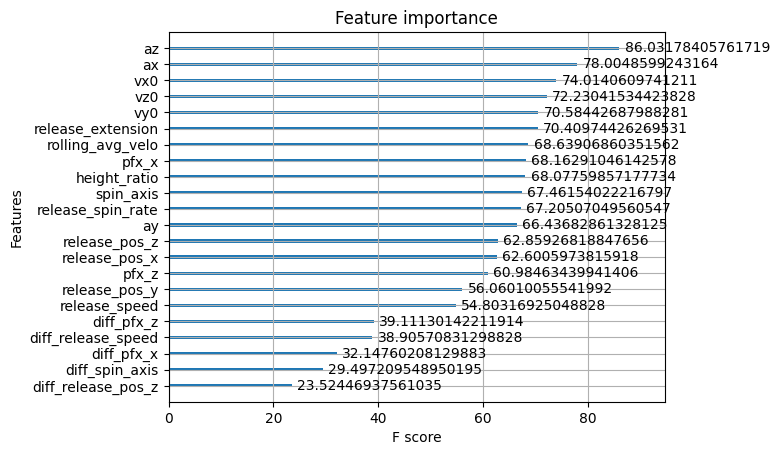

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

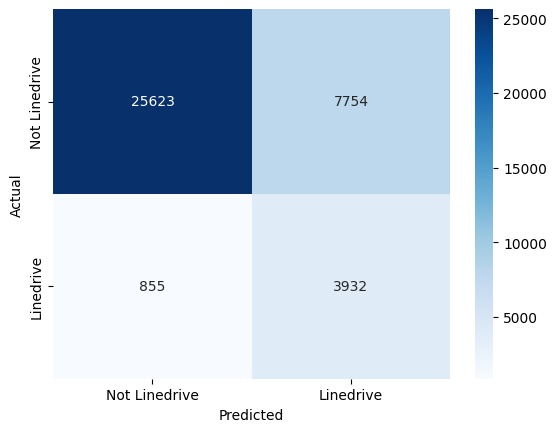

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [23]:
y_pred = final_model.predict(predictions)

In [24]:
testing_identifiers['xld'] = y_pred

In [25]:
testing_identifiers.head()

pitch_id_raw       xld
64    661032_608070_623474_4_62_9  0.290045
74    661032_680911_628452_4_64_9  0.496476
1124  661032_640458_663776_2_49_7  0.168718
1125  661032_640458_663776_2_49_7  0.158310
1126  661032_640458_663776_2_49_7  0.158310

In [26]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/ld_2022&3_xld.csv")